# Amazon Product Review Dataset Analysis

In this notebook, we will perform exploratory data analysis on [amazon product review dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html), which include millions of amazon customer reviews in 2 decades since 1995.

This dataset is a source of rich information for ML, NLP projects. In order to focus on running the analysis locally without using cluster, we will focus on a smaller portion of the entire dataset for this notebook.

## Pre-requisites
You're assumed to be somewhat familiar with
* linux command line
* aq_tool
* aws API
* essentia command

## Environment and Note
This tutorial is run locally on one Ec2 instance, and will be focusing on use of `aq_tools` without udb.



## Data Source

Data is located in a S3 bucket named `wataru-essentia-proto` (CHANGE THIS TO PUBLIC S3 BUCKET LATER), in a zipped tsv format.

In order to scan and fetch the data, and take a look at them, we'll need to
1. set essentia's datastore to the s3 bucket
2. create data category that includes the targetted data
3. look at the summary of the category

**Selecting datastore**<br>
Starting with setting the s3 bucket as the datastore with `ess select` command.

In [3]:
ess select s3://wataru-essentia-proto

**Creating Category**<br>
Our dataset is located under `/tsv/` directory in the bucket, so using `ess ls` command will display the files inside of the directory.

In [6]:
# piping the output to head to get the top 10 lines, for simplicity
ess ls /tsv/ | head -n 10

 230M Aug 01 18:55    /tsv/amazon_reviews_multilingual_DE_v1_00.tsv.gz
  67M Aug 01 18:55    /tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz
  90M Aug 01 18:55    /tsv/amazon_reviews_multilingual_JP_v1_00.tsv.gz
 333M Aug 01 18:55    /tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
 1.4G Aug 01 18:55    /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz
 618M Aug 01 18:55    /tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz
 555M Aug 01 18:55    /tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz
 340M Aug 01 18:55    /tsv/amazon_reviews_us_Baby_v1_00.tsv.gz
 871M Aug 01 18:56    /tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz
 2.6G Aug 01 18:56    /tsv/amazon_reviews_us_Books_v1_00.tsv.gz


In this notebook we'll only use the multilingual dataset (Denmark, France, Japan, UK and US) on the top 5 lines. <br>
Glob pattern to these files in the S3 buckets is 
```/tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz```

With `ess category add` command,

In [7]:
# creating the category with name of amazon_reviews. This will return error if it already exist.
ess category add amazon_reviews "/tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz" 

2019-10-28 18:43:24 ip-10-10-1-118 ess[3471]: Fetching file list from datastore.
2019-10-28 18:43:24 ip-10-10-1-118 ess[3471]: Examining largest matched file to determine compression type: /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz
2019-10-28 18:43:25 ip-10-10-1-118 ess[3471]: Probing largest matched file to determine data configuration: /tsv/amazon_reviews_multilingual_US_v1_00.tsv.gz


**Taking a look at the detail**<br>
Now we have a category, let's take a look at it's summary including schemas and sample data with `ess summary`

In [8]:
ess summary amazon_reviews

Name:        amazon_reviews
Pattern:     /tsv/amazon_reviews_multilingual_*_v1_00.tsv.gz
Exclude:     None
Date Format: auto
Date Regex:  
Archive:     
Delimiter:   Tab
# of files:  5
Total size:  2.1GB
File range:  1970-01-01 - 1970-01-01
# columns:   15
Column Spec: S:marketplace I:customer_id S:review_id S:product_id I:product_parent S:product_title S:product_category I:star_rating I:helpful_votes I:total_votes S:vine S:verified_purchase S:review_headline S,esc:review_body S:review_date
Pkey: 
Schema: S:marketplace I:customer_id S:review_id S:product_id I:product_parent S:product_title S:product_category I:star_rating I:helpful_votes I:total_votes S:vine S:verified_purchase S:review_headline S,esc:review_body S:review_date
Preprocess:  
usecache:    False
Comment:    

First few lines:
marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	5309

Essentia was able to extract the data schema automatially along with each column name. According to the meta data file, each column represents the followings.

* **marketplace**: 2 letter country code of the marketplace where the review was written
* **customer_id**: Random identifier that can be used to aggregate reviews written by a single author.
* **review_id**: The unique ID of the review
* **product_id**: The unique Product ID the review pertains to. In the multilingual dataset the reviews
* **product_parent**: Random identifier that can be used to aggregate reviews for the same product.
* **product_title**: title of the product
* **product_category**: Broad product category that can be used to group reviews (also used to group the dataset Countinto coherent parts)
* **star_rating**: The 1–5 star rating of the review.
* **helpful_votes**: Number of helpful votes.
* **total_votes**: Number of total votes the review received.
* **vine**: Review was written as part of the Vine program
* **verified_purchase**: the review is on a verified purchase
* **review_headline**: The title of the review
* **review_body**: the review text
* **review_date**: The date the review was written.

Looks like we can extract some useful information from columns such as `marketplace`, `product_category`, `star_rating`, `review_date`. 

## Exploratory Data Analysis
**Note:**<br>
There are multiple ways of counting unique values in aq_tools, such as 
* Using `aq_cnt`
* set up udb, and use `aq_udb -cnt` option.
On here, we'll be using `aq_cnt` command.

### Occurence Counts on Columns

Now we know what the data looks like, we can get started on analying the data. We'll start with looking at star rating's distribution in the dataset.

**star rating**<br>

We can display distribution of `star_rating` with `aq_cnt`.

* `ess stream amazon_reviews --bulk --master`
    * `--bulk` and `--master` was set in order to process 5 files as 1 and run `aq_cnt` on it one time. By default `ess` command runs given commands serially one time for each file.
* `aq_cnt -f,+1,tsv,eok...`
    * `eok` was added to skip the invalid row, as well as headers between files (4 headers will be present in the stream from files).

In [27]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - rating star_rating"

"star_rating","count"
2,396197
1,567938
3,766981
4,1772963
5,6330030
2019-10-28 19:44:49 ip-10-10-1-118 ess[4372]: !!!Warning!!! Multiple warnings.  See task.log for more details


The plot for this looks like following.

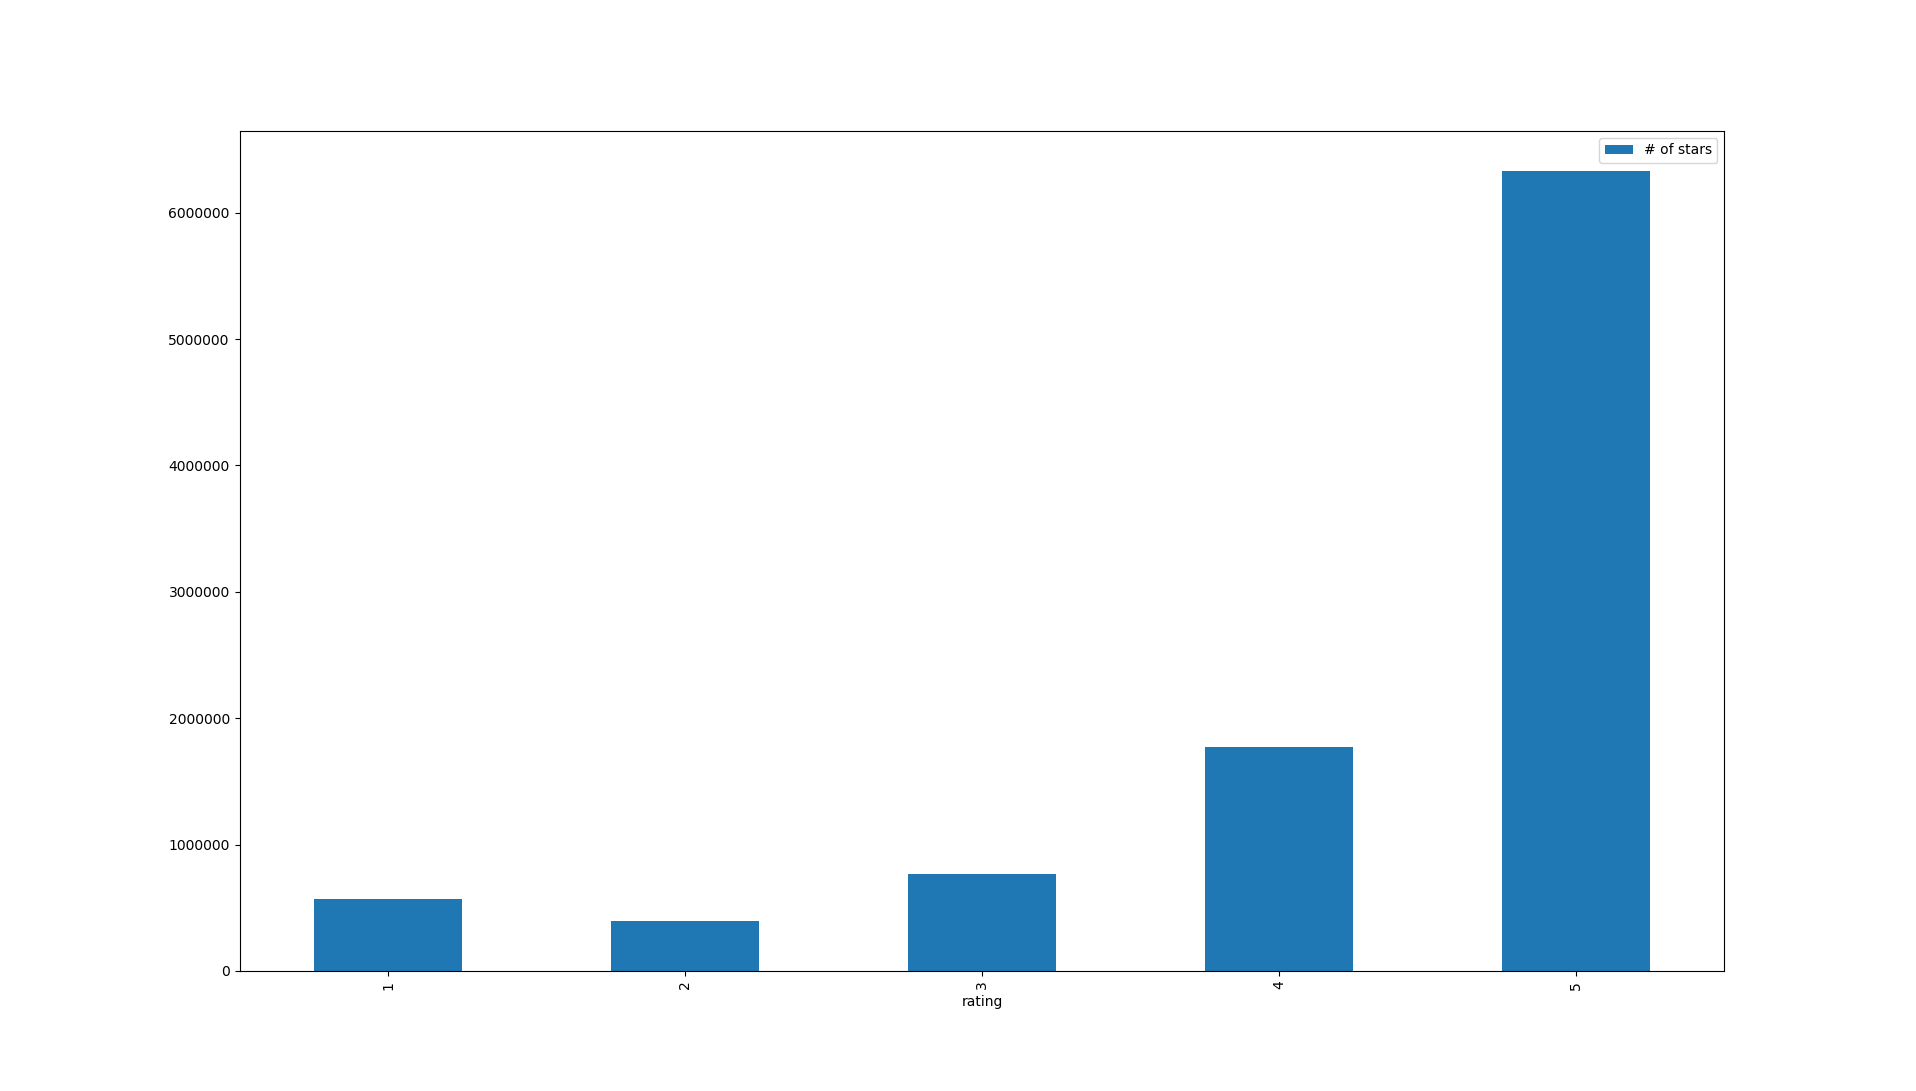

**Marketplace**<br>

You can apply similar command in order to get insights on numbers of total reviews on each marketplace.

In [28]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - marketplace marketplace"

"marketplace","count"
"US",6931013
"UK",1707480
"JP",262430
"FR",254075
"DE",679111
2019-10-28 19:59:58 ip-10-10-1-118 ess[4451]: !!!Warning!!! Multiple warnings.  See task.log for more details


marketplace counts plot

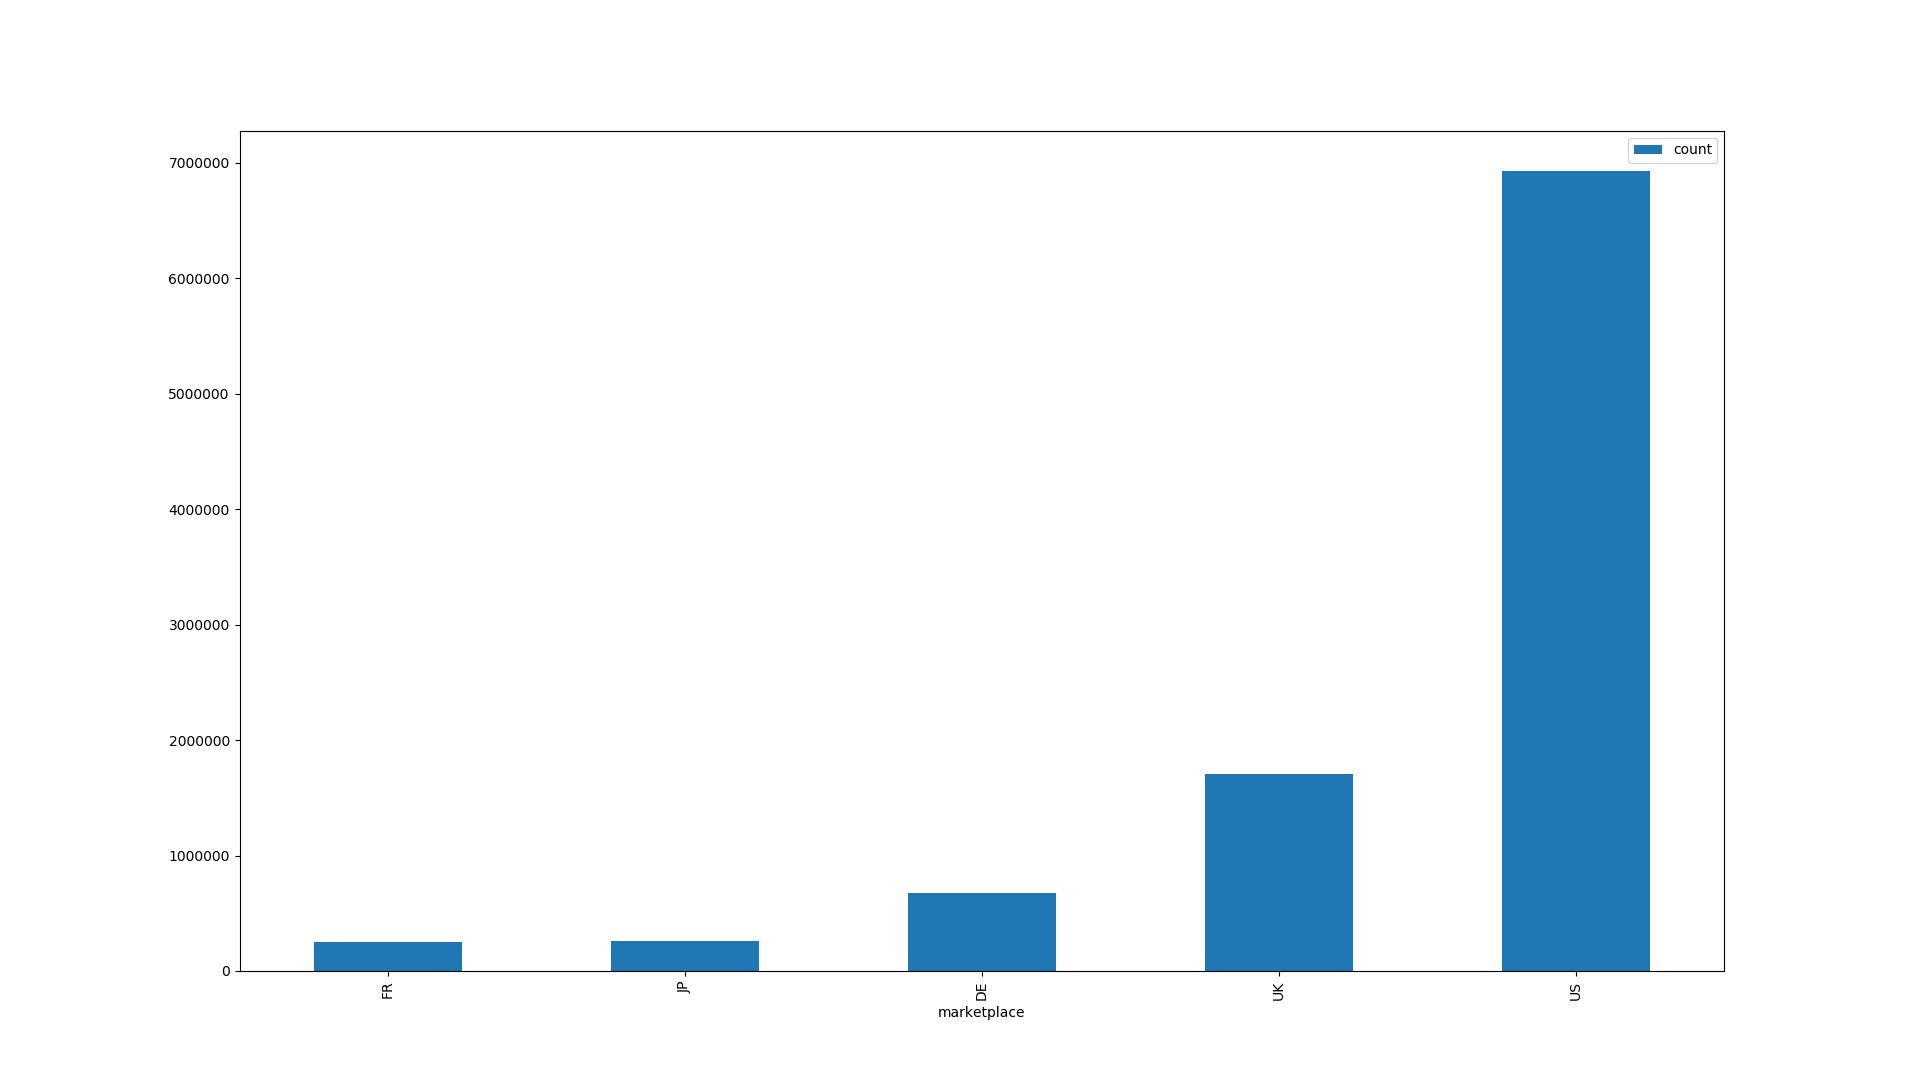

**Product Category**<br>

Counts of each product category across the marketplace and time.

In [29]:
ess stream amazon_reviews --bulk --master "*" "*" "aq_cnt -f,+1,tsv,eok - -d %cols -kX - category product_category"

"product_category","count"
"Mobile_Electronics",184
"Outdoors",3195
"Tools",7510
"Apparel",127
"Grocery",20
"Pet Products",51
"Beauty",55
"Software",204
"Furniture",101
"Lawn and Garden",1973
"Automotive",1534
"Baby",11960
"Kitchen",2365
"Camera",36786
"Video",56804
"Personal_Care_Appliances",705
"Home Entertainment",37807
"Office Products",4057
"Musical Instruments",15963
"Home",7008
"Health & Personal Care",1434
"Shoes",12559
"Luggage",475
"Wireless",36228
"Sports",9694
"Digital_Ebook_Purchase",1558331
"Digital_Music_Purchase",163296
"Toys",117348
"Video Games",22489
"Electronics",27068
"Music",1426187
"PC",95778
"Mobile_Apps",1773737
"Watches",17169
"Digital_Video_Download",1116575
"Video DVD",2066643
"Books",1194816
"Home Improvement",5873
2019-10-28 20:04:36 ip-10-10-1-118 ess[4487]: !!!Warning!!! Multiple warnings.  See task.log for more details


Just like that, you can take a look at any categorical column's occurence counts.

### Time Series

This dataset contains reviews since 1995, which I was not even aware that amazon store existed. 
We'd like to explore characteristics and patterns of reviews changed overtime. 

**Breaking down timestamp into month and year**<br>
Currently timestamp of the review (year, month and date) are stored in one string in `review_date` column. Let's break it down into year and month, so that it can be grouped by this value.

Using aq_pp's `-mapc/f` option to extract and map year and month, and we'll output `review_id`, `reviwew_date`, `year`, `month` columns only for clearity.

In [40]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id review_date year month' | head -n 6

"review_id","review_date","year","month"
"RVOG49N0H1FB6","2014-08-01","2014","08"
"RNCMD6OLTP4HM","2014-12-04","2014","12"
"R4AUOBI8YC0R8","2014-12-04","2014","12"
"R1VSHIJ1RHIBTE","2015-07-16","2015","07"
"R3JBLVALWSLCZD","2014-02-08","2014","02"
2019-10-28 21:12:11 ip-10-10-1-118 ess[4810]: !!!Warning!!! Multiple warnings.  See task.log for more details


Now the data is ready for the time series analysis.

**Numbers of reviews over years**<br>
Using the command from the last cell, we'll have it output `review_id` and `year`, and pipe it into `aq_cnt` command.
Because `review_id` is a unique identifier for each review, we'll count numbers of unique review ids group by year.<br>
Lastly using `aq_ord` command to sort the output by year.

In [51]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id year' | \
aq_cnt -f,+1 - -d S:review_id S:year -g year -k annual_reviews review_id | \
aq_ord -f,+1 - -d S:year I:count I:annual_reviews -sort year

"year","count","annual_reviews"
2019-10-28 21:46:49 ip-10-10-1-118 ess[5045]: ***Error*** Multiple errors.  See task.log for more details
"2004",13,13
"2005",69,69
"2006",44,44
"2007",170,170
"2008",951,951
"2009",1860,1860
"2010",2098,2098
"2011",2590,2590
"2012",6634,6634
"2013",24629,24629
"2014",28438,28438
"2015",18275,18275


**Numbers of Reviews over the years in each month**<br>

We can analyze numbers of reviews over the years, in each month by counting it group by year, and month. <br>
Afterwards, we can use `aq_rst` to organize the result into table with rows of months and columns of years.


In [60]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id year month' | \
aq_cnt -f,+1 - -d S:review_id S:year S:month -g year month -k reviews review_id | \
aq_rst -f,+1 - -d S:month S:year I:reviews -key month -lab year -val reviews

2019-10-28 22:22:50 ip-10-10-1-118 ess[5293]: ***Error*** Multiple errors.  See task.log for more details
"month","01","02","03","04","05","06","07","08","09","10","11","12"
"2004",0,0,0,3,1,0,0,1,2,0,1,5
"2005",5,17,4,7,5,9,3,9,3,0,3,4
"2006",1,3,6,2,3,0,5,4,7,1,3,9
"2007",7,4,8,4,2,6,8,7,8,4,49,63
"2008",109,50,62,57,64,82,66,94,92,84,101,90
"2009",130,174,163,130,140,111,198,134,137,177,161,205
"2010",235,169,130,162,152,129,154,189,188,222,183,185
"2011",220,227,217,196,180,171,225,162,214,218,250,310
"2012",436,335,312,368,389,331,400,397,545,533,962,1626
"2013",2174,1731,2088,1931,1906,1734,1856,1926,2045,2117,2425,2696
"2014",3019,2180,2395,2285,2266,1938,2072,2295,2290,2336,2450,2912
"2015",2913,2188,2238,2396,2246,2137,2110,2047,0,0,0,0


![year_month.png](attachment:year_month.png "Title")
*Heatmap, month vs year*
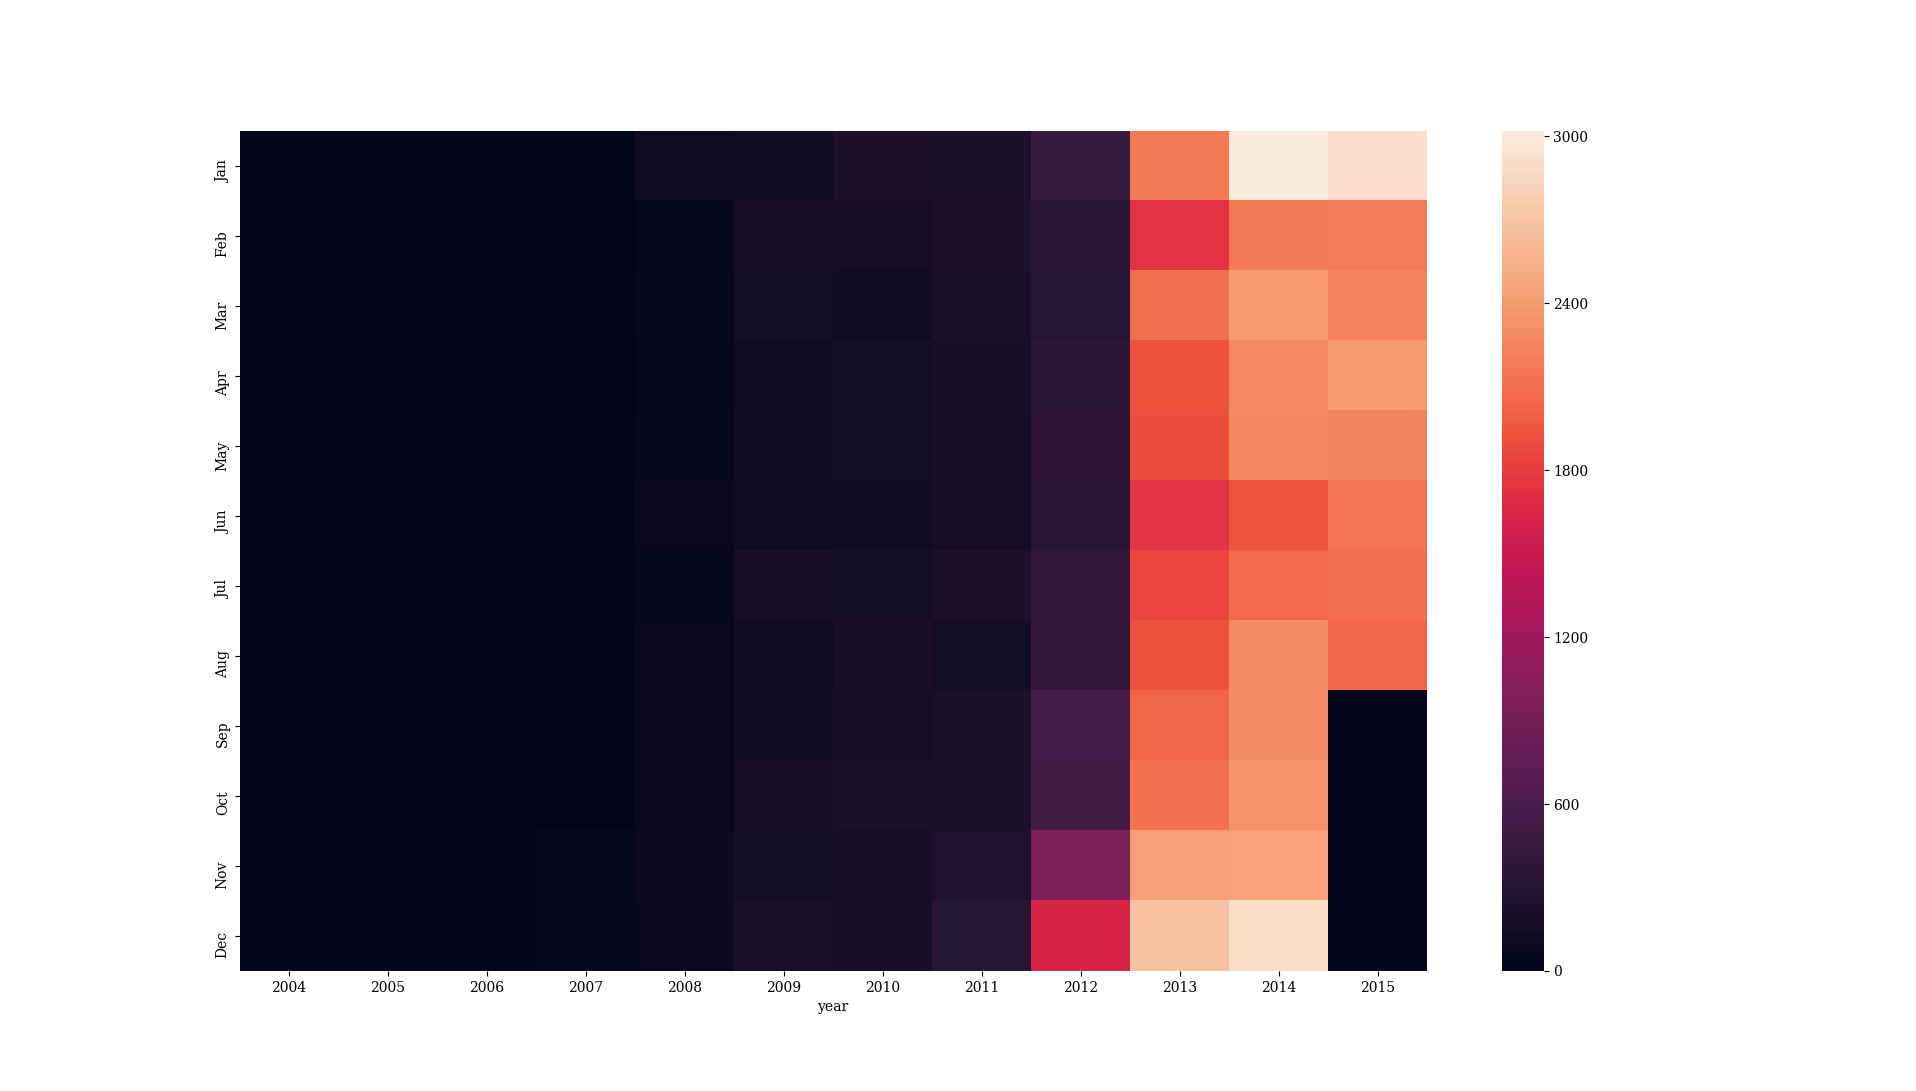

**Numbers of Reviews over months**<br>

This is useful to check if there's monthly / seasonal trends in numbers of reviews.
Let's try to dig little deeper, and gain numbers of each star_rating for each month. We can do this by further grouping record by `star_rating` value on `aq_cnt` command, then uing `aq_rst` to transform into pivot table.

In [57]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,tsv - -d %cols -mapf review_date "%%year:4-4%%-%%month:2-2%%%*" \
-mapc s:year %%YEAR%% -mapc s:month %%MONTH%% -c review_id star_rating month' | \
aq_cnt -f,+1 - -d S:review_id I:star_rating S:month -g month star_rating -k monthly review_id | \
aq_rst -f,+1 - -d S:month I:star_rating I:monthly -key star_rating -lab month -val monthly

2019-10-28 22:16:00 ip-10-10-1-118 ess[5236]: ***Error*** Multiple errors.  See task.log for more details
"star_rating","01","02","03","04","05","06","07","08","09","10","11","12"
1,472,394,433,440,419,432,457,478,293,322,465,460
2,294,248,260,246,262,210,253,257,206,197,255,269
3,609,470,538,502,483,447,470,490,380,391,445,505
4,1371,1022,1089,1050,1078,928,1067,1078,895,832,856,1131
5,6503,4944,5303,5303,5112,4631,4850,4962,3757,3950,4567,5740


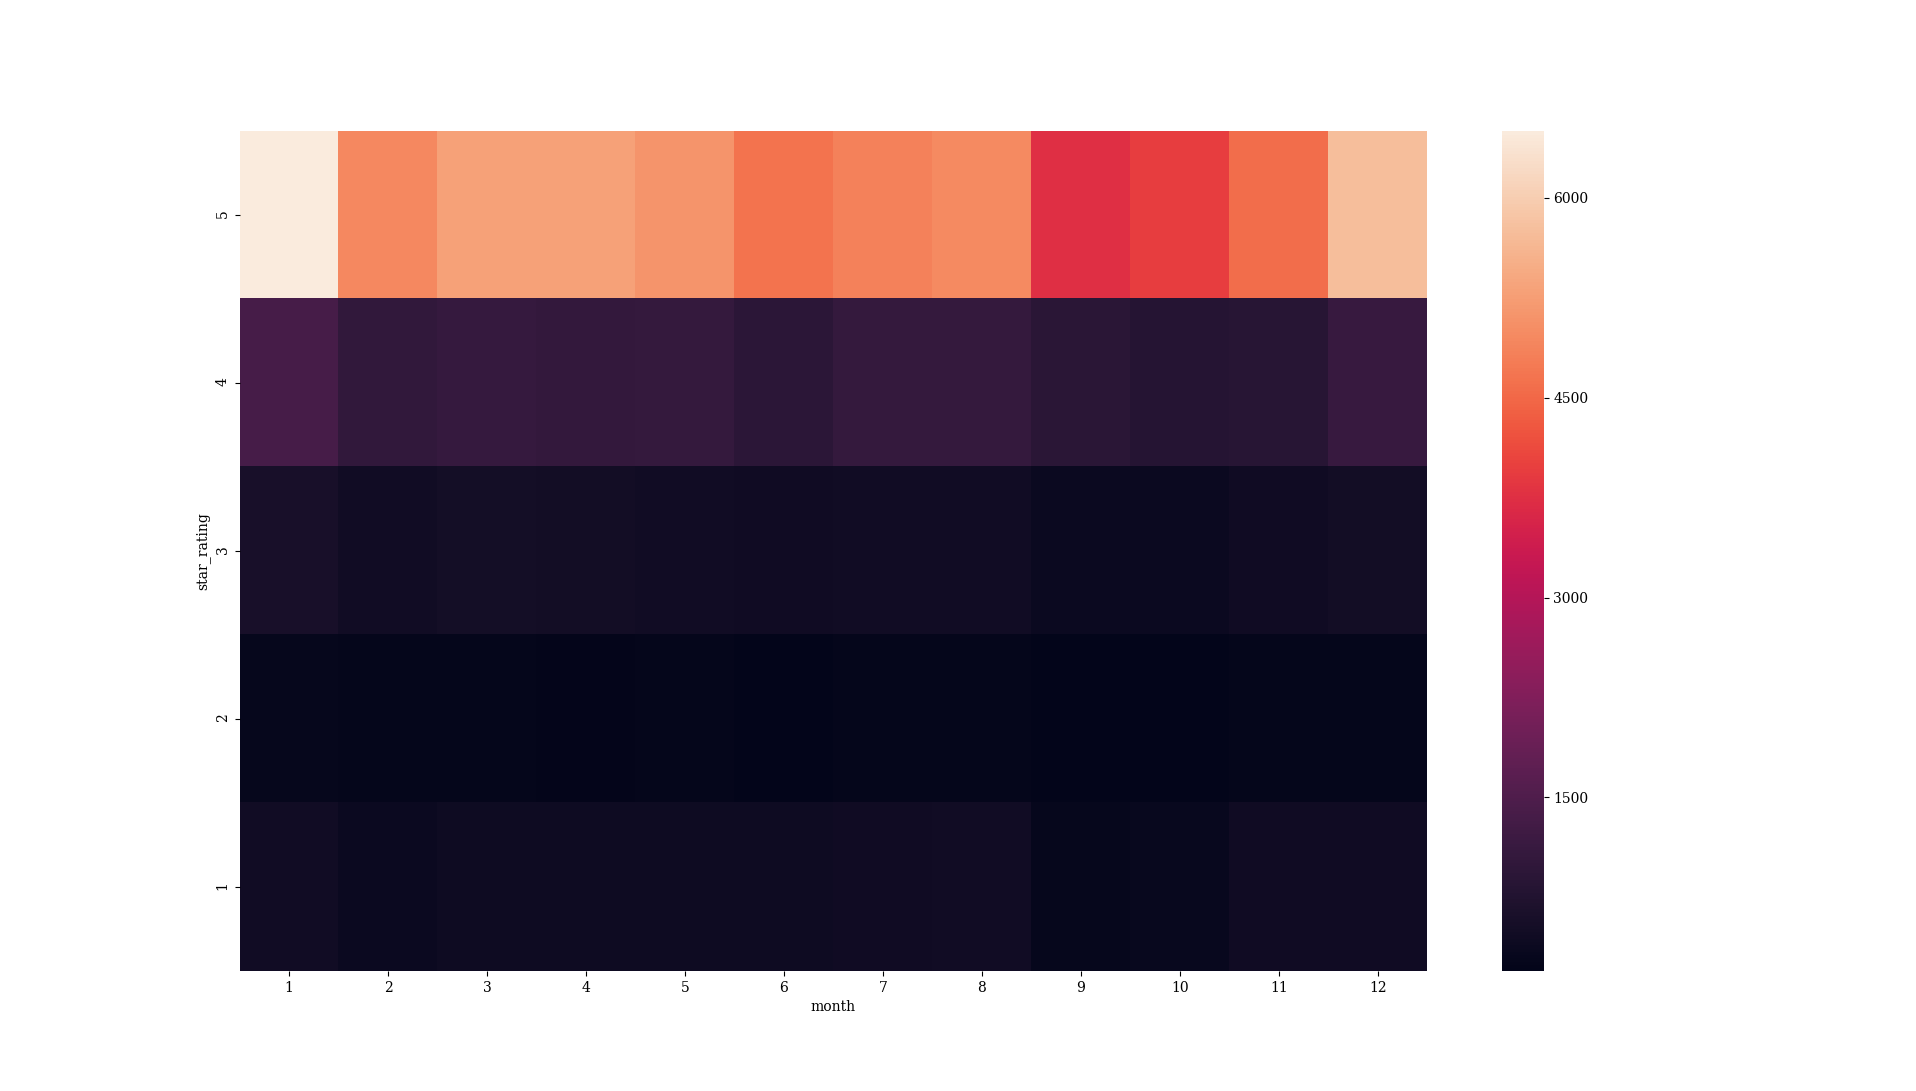
*Heatmap of rating vs month*

### Numbers of Reviews Left per Customer

Let's take a look at how many reviews are left by one customers.<br>
To get this value, we need to take 2 steps,
1. count numbers of reviews left by each customer by grouping by `customer_id`. Let's call this `reviews_per_customer`.
2. count numbers of unique `customer_id` in each `reviews_per_customer`



In [69]:
# step 1
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g customer_id -k reviews_per_customer review_id'

"customer_id","row","reviews_per_customer"
146004,2,2
254421,1,1
565563,1,1
52303,1,1
1162122,1,1
108745,1,1
1325068,1,1
515450,1,1
3733178,1,1
5662728,1,1
1117977,3,3
6454258,1,1
1772983,1,1
8556468,1,1
2288113,1,1
4599064,1,1
12461968,1,1
5724518,1,1
13397066,1,1
10015518,1,1
10319957,1,1
10409415,1,1
11100659,1,1
18301354,1,1
11580132,1,1
12601635,1,1
13673100,1,1
20251073,1,1
13721934,1,1
21204901,1,1
22160702,1,1
17967803,1,1
22198707,1,1
19608213,1,1
20044670,1,1
20390744,1,1
22829291,2,2
22964510,1,1
24431226,1,1
23342147,1,1
23903982,1,1
29663373,1,1
25221713,1,1
30478238,1,1
26437581,1,1
32519904,1,1
27074809,1,1
27617649,1,1
35016202,1,1
27777571,1,1
35556393,1,1
28958961,1,1
29456133,1,1
35890584,1,1
30067162,3,3
30755027,1,1
31194855,1,1
34443666,1,1
34510910,1,1
36598839,1,1
40794597,6,6
39142051,1,1
41873966,1,1
40627480,1,1
40761115,1,1
44825806,1,1
41210815,1,1
42034138,1,1
45317707,1,1
42038451,1,1
43070105,1,1
43215800,1,1
43325137,1,1
43407715,1,1
43540573,1,1
474877

16467041,1,1
17525293,1,1
37316956,1,1
38372914,1,1
18050339,2,2
19195405,1,1
40765042,1,1
22151364,5,5
45297979,1,1
22702498,1,1
45387146,1,1
23251801,1,1
45581302,1,1
23369383,1,1
45802658,1,1
25898652,1,1
27627839,1,1
28819601,1,1
45946560,5,5
29938093,1,1
46559443,1,1
30002174,1,1
31179062,1,1
49676890,1,1
49889289,1,1
32497162,1,1
52122559,1,1
36284997,1,1
52529402,1,1
37047630,1,1
38387482,1,1
40086373,1,1
550467,1,1
846131,1,1
41261970,1,1
1092397,1,1
1874427,1,1
3087976,1,1
42246236,1,1
42942153,1,1
4511666,1,1
43311001,1,1
4966133,1,1
5238132,1,1
5524655,1,1
6910476,1,1
8299374,1,1
9519609,1,1
10354225,1,1
11283457,1,1
44597454,8,8
44841456,1,1
45217677,1,1
13310572,1,1
45249417,1,1
13713697,1,1
13916410,1,1
45938242,1,1
15476108,1,1
16183278,1,1
47255747,1,1
16865434,1,1
47858374,1,1
47985753,1,1
20407139,1,1
49453604,1,1
20510827,1,1
49717548,1,1
50499671,1,1
21014789,4,4
51649162,1,1
22188798,1,1
132282,1,1
213002,1,1
727189,1,1
25495764,1,1
733095,1,1
1175791,1,1
26713884,

13052034,1,1
13120448,1,1
40676812,2,2
13337853,1,1
14016961,1,1
44964773,1,1
15116005,1,1
44984621,1,1
46336936,1,1
48488544,1,1
49297173,1,1
52761240,1,1
16978843,1,1
18364661,1,1
18878333,2,2
53068673,1,1
331912,1,1
20401761,1,1
1702149,1,1
23175597,1,1
1989554,4,4
2391908,1,1
3045685,1,1
23226417,4,4
4247498,1,1
23831323,1,1
5765396,1,1
24285913,1,1
6704658,1,1
24807588,1,1
25484132,1,1
25821096,1,1
11409861,1,1
28375886,1,1
11548125,1,1
28766441,1,1
29083845,1,1
13310298,1,1
29794188,1,1
14587876,1,1
30971644,1,1
14677299,1,1
15024555,1,1
31734070,1,1
19035997,1,1
32354653,2,2
19371986,1,1
32998282,1,1
19952022,1,1
33089646,1,1
22233257,1,1
34131564,1,1
22640897,1,1
38507758,1,1
23761420,1,1
41666726,1,1
42894492,1,1
24087906,2,2
43721955,1,1
44142853,1,1
25059573,1,1
25178739,1,1
44300889,1,1
25396527,1,1
27021914,1,1
27324930,2,2
47754074,1,1
27485218,1,1
48091244,1,1
28875042,1,1
48306678,1,1
29098453,1,1
48534207,1,1
48631197,1,1
32034785,1,1
52040880,1,1
727333,1,1
35099978,1

14051959,1,1
35328104,1,1
37958234,1,1
15232990,1,1
38241331,1,1
16067135,1,1
39886974,1,1
40268910,1,1
21824314,1,1
41753567,1,1
41935943,1,1
43604690,1,1
44056142,1,1
24191794,1,1
47049134,1,1
25327972,1,1
47264434,1,1
25582410,1,1
47694046,1,1
25838613,1,1
50927209,1,1
29165605,1,1
124970,1,1
31594370,1,1
215587,1,1
280113,1,1
885728,1,1
38798846,1,1
1339342,1,1
1452487,1,1
2659194,1,1
42935523,1,1
43123866,1,1
6894948,1,1
46412150,1,1
8452526,1,1
9993651,1,1
48336469,1,1
11548670,1,1
49224410,1,1
12033142,1,1
50212894,1,1
12035529,2,2
12485545,1,1
52759437,1,1
323959,1,1
410668,1,1
624980,2,2
1194822,1,1
2560454,1,1
13340211,1,1
4916467,1,1
14675413,2,2
9534302,1,1
10293599,1,1
14774364,1,1
18154351,1,1
12401875,1,1
19879441,1,1
12447147,1,1
13114084,1,1
23931319,1,1
13171968,1,1
13969501,1,1
25049894,1,1
14797805,1,1
16247446,1,1
28803532,1,1
31060221,1,1
31232091,1,1
16572332,1,1
16934378,1,1
17075827,1,1
33193830,1,1
19445241,1,1
34041207,1,1
20112289,1,1
35248827,1,1
23944084,1

22350434,1,1
22409840,1,1
48862525,1,1
50200926,1,1
23599386,4,4
50897241,1,1
24482207,1,1
51717829,1,1
25584472,1,1
107750,1,1
26270489,1,1
109203,1,1
27597408,1,1
27691609,1,1
29964368,1,1
1286467,1,1
1903114,1,1
30624443,1,1
2827599,1,1
31303898,1,1
2931721,1,1
31928793,1,1
2968086,1,1
33356438,1,1
35500193,1,1
4423967,1,1
36194483,2,2
7915364,1,1
37341625,1,1
10016216,1,1
37607062,1,1
10156344,1,1
39288684,1,1
11422402,1,1
11447843,1,1
41090506,1,1
41349967,1,1
12207196,1,1
12325527,1,1
12654862,1,1
12856788,1,1
43160921,1,1
12994628,1,1
43727980,1,1
14309542,1,1
45033477,2,2
14358416,1,1
46161247,1,1
46368853,1,1
14501037,1,1
46586736,1,1
15423272,1,1
47153700,1,1
47192505,1,1
18737920,1,1
47269195,1,1
49873796,1,1
22203845,1,1
24054987,1,1
25845440,1,1
52432399,1,1
26516950,1,1
127462,1,1
359469,1,1
27656409,1,1
522763,1,1
28316761,1,1
1260182,1,1
32699209,1,1
4704684,1,1
6003995,1,1
6213291,1,1
36506628,1,1
7049684,1,1
7150629,1,1
9601548,1,1
11097852,1,1
11691653,1,1
11880998,1

31917364,1,1
36290808,3,3
32886382,1,1
34172529,1,1
34618598,2,2
35141401,1,1
37250647,1,1
40991911,1,1
41068363,1,1
41273510,1,1
42189628,1,1
42847165,1,1
44777701,1,1
44002053,1,1
44972251,1,1
45469242,1,1
45548622,1,1
46910224,1,1
45758701,1,1
48429745,1,1
46318713,1,1
49075159,1,1
50937754,1,1
51161147,1,1
52226112,1,1
116569,1,1
160984,1,1
162995,1,1
51460193,3,3
198519,1,1
51998465,1,1
1134633,1,1
1590995,1,1
114218,1,1
673540,1,1
1849863,2,2
798075,1,1
2963270,1,1
901721,1,1
3486952,1,1
6596878,1,1
2923679,1,1
3077320,1,1
8105958,1,1
9622204,1,1
5094204,1,1
10501434,1,1
10723917,1,1
6954430,1,1
7215520,1,1
7445962,1,1
11572190,1,1
10074756,1,1
12249363,1,1
10845815,1,1
12648079,1,1
12859011,1,1
14067733,1,1
11618413,1,1
14544162,1,1
16085129,1,1
16205221,1,1
16967303,1,1
13106017,8,8
14616455,1,1
19757860,1,1
14995078,1,1
15417222,1,1
21262235,1,1
23162981,1,1
18972381,1,1
23426278,1,1
20171845,1,1
24052060,1,1
25252725,1,1
21369146,2,2
21562362,1,1
22279931,1,1
27475204,2,2
225

16540744,1,1
44416436,1,1
44458288,1,1
44546032,1,1
19274712,1,1
44716773,1,1
45753032,1,1
20326920,1,1
23298397,1,1
50255441,1,1
50957371,1,1
24385649,1,1
52220985,1,1
24568849,1,1
24994349,1,1
52567848,1,1
25402387,1,1
122027,1,1
25642985,1,1
25682663,1,1
1634627,1,1
27106036,1,1
2139181,1,1
27455783,1,1
7458871,1,1
28343127,1,1
29424516,1,1
9051557,1,1
30244212,1,1
10844542,1,1
11137427,1,1
33972742,1,1
11881532,1,1
34408140,1,1
36557748,1,1
12127379,1,1
40422379,1,1
41527903,1,1
14500176,1,1
14867579,1,1
17344925,1,1
52591807,1,1
19335758,1,1
20373581,1,1
106597,1,1
20487036,1,1
113592,1,1
20726600,1,1
21411657,1,1
463146,1,1
1878016,1,1
22300836,1,1
22375647,1,1
5545308,1,1
22434477,1,1
22493498,1,1
7213039,1,1
22816099,1,1
23097188,1,1
10145577,1,1
23606111,1,1
11179333,1,1
24067976,1,1
11525947,1,1
26337293,2,2
30839922,1,1
31073530,1,1
15448206,1,1
32559808,1,1
15819502,1,1
36088039,1,1
36424512,1,1
17527915,1,1
18272183,1,1
38147151,1,1
38162481,1,1
21455583,1,1
38305173,1,1
4

2011325,2,2
15176549,1,1
20115932,1,1
5252963,1,1
5489387,1,1
23285341,1,1
6312696,1,1
23383455,1,1
6806869,1,1
23404283,1,1
10284740,1,1
23779616,1,1
12666684,1,1
12751639,1,1
26652623,1,1
13950546,1,1
27254934,1,1
14048988,1,1
27347044,1,1
14239730,1,1
29391473,1,1
29820380,1,1
21216848,1,1
22261432,1,1
33274152,1,1
34634618,1,1
36655613,1,1
25187889,1,1
26628302,1,1
27215351,1,1
40676223,1,1
27510043,1,1
27951545,1,1
42287230,1,1
44965719,1,1
30635471,1,1
45250234,1,1
45661888,1,1
32776684,1,1
47455164,1,1
33826001,1,1
47932022,1,1
49548692,1,1
35691618,1,1
36958836,1,1
50760476,1,1
50761144,1,1
38251986,1,1
51003352,1,1
180121,1,1
335700,3,3
48926477,1,1
774902,1,1
49467799,1,1
917152,1,1
49778843,1,1
2222168,1,1
50264251,1,1
3189401,1,1
3632235,1,1
3901142,1,1
4878901,1,1
5316183,1,1
52568009,2,2
6285253,1,1
109404,1,1
6751945,1,1
358543,1,1
8125227,1,1
717837,1,1
1384355,1,1
10576711,1,1
2168630,1,1
2367508,1,1
3021223,1,1
3803536,1,1
11996950,3,3
5004009,1,1
6709328,1,1
15050877

43973242,1,1
45522676,1,1
44946930,1,1
45824753,1,1
36905522,1,1
45946645,1,1
37815512,1,1
40856152,1,1
47277147,2,2
48426958,1,1
41717119,2,2
48501341,1,1
49758497,1,1
42563175,1,1
43335388,1,1
49513905,1,1
123009,1,1
6304977,15,15
51619720,1,1
44967321,1,1
736892,1,1
49043100,1,1
850408,1,1
9201581,1,1
50450704,1,1
10529287,1,1
127849,2,2
49913733,1,1
1200129,2,2
12221852,1,1
130262,1,1
51354125,1,1
2046626,1,1
12500262,1,1
166968,1,1
2573609,1,1
12871043,1,1
199316,1,1
52528956,1,1
2913107,1,1
13133909,1,1
456935,1,1
52594287,1,1
470657,1,1
5006445,1,1
14326471,1,1
5846306,1,1
1084059,2,2
110572,1,1
5985700,1,1
884669,1,1
339362,1,1
6147186,1,1
15258331,2,2
1791422,1,1
1011196,1,1
16736085,1,1
1537663,1,1
2809640,1,1
7662015,1,1
1758617,1,1
3976816,1,1
8584642,1,1
5182428,1,1
8793329,1,1
355260,1,1
2075553,1,1
7276847,1,1
2392965,1,1
20549347,1,1
3024719,1,1
10839246,1,1
1293105,5,5
9174333,1,1
3768681,1,1
3964261,1,1
11250241,1,1
11824779,1,1
23294270,1,1
4889741,1,1
11269207,1,1
1

19991832,2,2
20060920,1,1
20114263,1,1
20869320,1,1
31722944,1,1
32257073,1,1
34988734,1,1
21954919,1,1
24275869,1,1
37297602,1,1
24973053,1,1
37949315,1,1
25142469,1,1
40052154,1,1
25460180,1,1
40905500,1,1
26142686,1,1
42083847,1,1
26822236,1,1
42938279,1,1
44670341,1,1
45009808,1,1
30155869,1,1
30228916,1,1
46467790,1,1
31042168,1,1
31351393,1,1
32962159,1,1
34956315,1,1
38624913,1,1
49139212,1,1
50001311,1,1
44975884,1,1
50751701,1,1
45402499,1,1
53088578,1,1
46415710,1,1
107746,1,1
110895,1,1
48570315,1,1
2229907,1,1
51046269,1,1
3074580,1,1
3777917,1,1
5103428,1,1
52894514,1,1
5561662,1,1
534184,1,1
7437665,1,1
2151422,1,1
8748426,1,1
2505238,1,1
9041941,1,1
3461627,1,1
10094441,1,1
4459659,1,1
10621050,1,1
5107356,1,1
10684831,1,1
5362356,1,1
10716506,1,1
6854336,1,1
10841600,1,1
9567125,1,1
10385788,1,1
10656624,1,1
11373365,5,5
11677909,1,1
11004769,1,1
12772756,1,1
13454190,1,1
11254343,1,1
15953711,1,1
16305398,1,1
13142773,1,1
17744017,1,1
13265188,1,1
13794876,1,1
19076722

20535327,1,1
45737795,1,1
21441334,1,1
46306582,1,1
50645393,1,1
21488305,3,3
26711252,1,1
128097,1,1
28235822,1,1
28423122,1,1
32807892,1,1
2359738,1,1
4547535,1,1
34762014,1,1
5131013,1,1
6882182,1,1
37295904,1,1
38750009,1,1
10876876,1,1
43435803,1,1
13483791,1,1
14307339,1,1
44077125,2,2
14981670,1,1
44799550,1,1
44929357,1,1
45399129,1,1
19389890,1,1
45997698,1,1
20518815,1,1
46654141,1,1
20634320,1,1
20966864,1,1
23022491,1,1
23462845,1,1
23886957,1,1
52081222,1,1
25579872,1,1
1658134,1,1
29310560,1,1
2538064,1,1
30386478,1,1
31514485,1,1
2724493,1,1
31585132,1,1
34662749,1,1
3610360,1,1
3998593,1,1
6864073,1,1
36379986,1,1
37307051,1,1
7206286,2,2
38240163,1,1
8147901,1,1
39194784,1,1
11124823,1,1
41534761,1,1
11284869,1,1
41621351,1,1
15482237,1,1
45032488,2,2
16347930,1,1
17122212,1,1
46418248,1,1
17329367,1,1
50046383,1,1
50328529,1,1
18865854,1,1
50531744,1,1
19781244,1,1
20530920,1,1
51745733,2,2
20866420,1,1
22063222,1,1
52835667,1,1
22687756,1,1
968106,1,1
23050199,1,1
26

11502985,1,1
12041770,1,1
52006508,1,1
107367,1,1
13342452,1,1
132216,1,1
13349572,1,1
151770,1,1
342237,1,1
1021522,1,1
13997629,3,3
1218177,1,1
2222223,1,1
3668095,1,1
3687094,1,1
14875016,1,1
4370566,1,1
14913414,1,1
5420847,1,1
14990607,1,1
15478866,1,1
8923212,1,1
15937550,1,1
10595304,1,1
16201211,1,1
11336584,1,1
16771254,1,1
12113886,1,1
12126416,1,1
17036157,1,1
17502332,1,1
18369376,1,1
14677184,1,1
20965392,1,1
22154913,1,1
22573724,1,1
16387046,1,1
16932883,1,1
23245999,1,1
18427583,1,1
29995949,1,1
19737005,1,1
30156075,1,1
20514648,1,1
31484442,1,1
32308375,1,1
27853675,1,1
37082503,1,1
28728996,1,1
38587239,1,1
40066945,1,1
41249161,1,1
41474347,1,1
42986238,1,1
43997753,1,1
37590643,3,3
44515709,1,1
39945609,1,1
44713116,1,1
40916785,1,1
44737089,1,1
43095360,1,1
48186900,1,1
48408897,1,1
44112603,1,1
44973421,1,1
107026,1,1
45347566,1,1
109682,1,1
45916219,1,1
141393,1,1
46888191,1,1
217164,1,1
52945673,1,1
988499,1,1
130707,1,1
1624203,1,1
178328,1,1
2781103,1,1
22378

23440519,1,1
46182718,1,1
23723341,1,1
47132017,1,1
13971481,1,1
31540199,1,1
15180501,1,1
26939765,1,1
35317225,1,1
27324229,1,1
17115771,1,1
51603042,1,1
17238744,1,1
28716941,3,3
52280475,1,1
44622499,1,1
661812,1,1
18656461,3,3
1684032,1,1
45935009,1,1
30437111,1,1
19391308,1,1
1695068,1,1
20529123,1,1
3148989,1,1
22046993,1,1
46858839,1,1
4208296,1,1
47158509,1,1
27852569,1,1
6934130,1,1
28757214,1,1
9344873,1,1
48338649,1,1
29539556,1,1
9981005,1,1
39619756,1,1
30848007,1,1
11377084,1,1
48939502,1,1
39762993,1,1
49393434,1,1
12677794,1,1
42664791,1,1
37535505,2,2
51294820,1,1
44730773,1,1
38876360,1,1
13826605,1,1
45191896,1,1
145783,1,1
46725489,1,1
47075576,1,1
14330572,1,1
914722,1,1
14892867,1,1
979072,1,1
50627819,1,1
52091497,1,1
15314874,1,1
2756320,1,1
52431566,2,2
17508999,1,1
5653090,1,1
318191,1,1
7934663,1,1
52769495,1,1
1592778,1,1
21651936,1,1
11504319,1,1
187129,1,1
4149408,1,1
12202249,1,1
723609,1,1
5606036,1,1
12754362,1,1
6451253,1,1
13732667,1,1
3669031,1,1
85

1249839,1,1
6290905,1,1
6469608,1,1
3714478,2,2
8098190,1,1
9889141,2,2
7775696,1,1
10293720,1,1
8513974,1,1
10414235,1,1
10571540,1,1
10271067,1,1
11518672,1,1
10527325,1,1
11706798,1,1
15907395,1,1
22885476,1,1
23426518,1,1
12655591,1,1
13699431,1,1
26283087,1,1
15036312,1,1
15346374,1,1
30267778,1,1
30707621,1,1
22227772,1,1
31442689,1,1
23526903,1,1
32885701,1,1
25096026,1,1
25950867,1,1
38150430,1,1
41177164,1,1
43138997,1,1
45647969,1,1
30552055,1,1
31291472,1,1
31844461,1,1
51405231,1,1
37613252,1,1
40098364,1,1
52818876,3,3
17612,1,1
43201690,1,1
145585,1,1
152074,1,1
44798495,1,1
1521190,1,1
46262563,1,1
2069588,1,1
46718517,1,1
48041430,1,1
2533537,1,1
48077970,1,1
2694950,1,1
49096834,1,1
2797179,1,1
50065653,1,1
3151049,1,1
50589740,1,1
3704551,1,1
52005710,1,1
52762275,1,1
873102,1,1
5929996,1,1
7671358,1,1
1114804,1,1
11911343,2,2
1571320,1,1
2720358,1,1
13572562,1,1
3042747,1,1
3097905,1,1
16802503,1,1
23010419,1,1
26448527,1,1
29798919,1,1
33009345,1,1
34551269,1,1
3742

5084274,1,1
51372262,1,1
5382929,1,1
440654,1,1
10680457,1,1
1128959,1,1
10920903,1,1
1259861,1,1
3657374,1,1
11724635,1,1
9086732,1,1
12627437,1,1
9827984,1,1
12997346,1,1
14209164,1,1
13437741,1,1
15452424,1,1
13974689,1,1
15081170,1,1
19101542,1,1
15882032,1,1
25893348,1,1
23361372,1,1
29954939,1,1
30150567,1,1
27087036,1,1
28020423,1,1
34913407,1,1
38984025,1,1
33348579,1,1
45406314,1,1
38757688,1,1
47501835,1,1
45823787,1,1
51290059,1,1
48901991,1,1
49446937,1,1
51052397,1,1
52570009,1,1
52641378,1,1
114610,1,1
169480,1,1
475237,1,1
1173358,1,1
1989858,1,1
2257242,1,1
4237705,1,1
6069738,1,1
7976038,1,1
8726154,1,1
10484936,1,1
10698076,1,1
11381541,1,1
11568047,1,1
11784471,2,2
12172200,1,1
14580021,1,1
15323162,1,1
18468657,1,1
18675110,1,1
19252078,1,1
146592,1,1
559464,1,1
22891579,1,1
2782722,1,1
22947789,1,1
26044572,1,1
13001715,1,1
13696421,1,1
29358222,1,1
15010103,1,1
29491985,1,1
15690256,1,1
31313793,1,1
16209825,1,1
17005357,1,1
17326650,1,1
18505556,1,1
18663629,1,1


951453,11,11
44316251,1,1
1082847,1,1
44820997,1,1
1179755,1,1
46453731,1,1
1194419,1,1
46642907,1,1
1569696,1,1
46846977,1,1
2682983,1,1
49583023,1,1
5578124,1,1
6132797,1,1
50617572,1,1
6926404,1,1
51141833,1,1
10512226,1,1
51266611,1,1
11863075,1,1
12035286,1,1
266878,1,1
13413697,1,1
883426,1,1
14024369,1,1
909717,1,1
14244762,2,2
1492078,1,1
14298315,1,1
2424651,1,1
14517523,1,1
2880641,1,1
5046742,1,1
5595069,1,1
5627856,1,1
9671347,1,1
15808410,4,4
9954120,1,1
16098847,1,1
18561488,1,1
11231127,3,3
11251457,1,1
11575227,1,1
20735098,1,1
13225237,1,1
21627995,1,1
23561156,1,1
26897077,1,1
16440996,1,1
30772670,1,1
33096902,1,1
34206048,1,1
25135831,1,1
25390444,1,1
37138035,1,1
26164505,1,1
29626973,1,1
40405665,1,1
29939302,1,1
30192812,1,1
45939382,1,1
36739572,1,1
47259117,1,1
36906088,1,1
50116313,1,1
222467,1,1
565378,1,1
41835720,1,1
588670,1,1
43617382,1,1
999026,1,1
43773499,1,1
1669620,1,1
2641194,1,1
3241663,1,1
45608045,1,1
3739379,2,2
49259869,1,1
4820863,1,1
5170111,

10626038,1,1
25135299,1,1
36751171,1,1
11112236,1,1
14400623,1,1
28587731,1,1
12338957,1,1
30273239,1,1
13132957,1,1
14587569,1,1
14401881,1,1
15398010,1,1
30887301,1,1
14431744,1,1
15411696,1,1
31359832,1,1
42362419,1,1
15341815,1,1
20986001,1,1
33255508,1,1
18527960,1,1
45550095,1,1
18740590,1,1
22314671,1,1
34950981,1,1
47209689,2,2
22667645,1,1
35469255,1,1
22102753,1,1
41156678,1,1
49391079,1,1
41220359,1,1
41381875,1,1
52888504,1,1
28790318,2,2
43844457,1,1
680578,1,1
27985963,1,1
1160910,1,1
29770699,1,1
1164841,1,1
2281559,1,1
34180067,1,1
36863601,1,1
2339953,3,3
37980897,1,1
2600824,1,1
39068584,1,1
37329908,1,1
4219614,1,1
39331925,1,1
38436290,1,1
44567348,1,1
8823357,1,1
40153230,2,2
45791455,1,1
42028442,1,1
42251735,1,1
46122995,1,1
10370185,1,1
45385737,1,1
47132286,1,1
10429465,1,1
43950398,1,1
45683121,1,1
47920248,2,2
10752319,1,1
44263442,1,1
46346744,1,1
48732480,1,1
11547566,1,1
45277472,1,1
49770711,1,1
45979044,1,1
47184627,1,1
51550818,1,1
11841701,1,1
48150036

2184237,1,1
14319575,1,1
2445713,1,1
15371888,1,1
15809929,1,1
3678376,1,1
5001849,1,1
18975739,1,1
6309346,1,1
20002136,1,1
6733678,1,1
21148853,1,1
6978758,1,1
21307381,1,1
9156502,1,1
24578956,1,1
26092518,1,1
9723075,1,1
11547583,1,1
26722449,1,1
27954679,1,1
12424979,1,1
28564650,1,1
13129490,3,3
13227629,1,1
30454822,1,1
16220220,1,1
32685848,1,1
19709308,1,1
24376933,1,1
39952585,1,1
27633727,2,2
40413865,2,2
27741841,1,1
42768939,1,1
28365336,4,4
44090590,1,1
28883400,1,1
46189568,1,1
46347411,1,1
32446257,1,1
33741064,1,1
34782330,1,1
48273962,1,1
35744332,1,1
48638945,1,1
49218016,1,1
40302359,1,1
40478048,1,1
50110874,1,1
52286051,1,1
41285113,1,1
41402248,1,1
42269095,1,1
42677171,1,1
43370464,1,1
43954646,2,2
44271490,1,1
107617,1,1
1081763,1,1
47512481,1,1
2434406,1,1
2847206,1,1
3945638,1,1
4736564,1,1
48645397,1,1
6308911,1,1
49012902,1,1
6586041,1,1
49148597,1,1
6853746,1,1
6948162,1,1
49267255,1,1
7649317,1,1
10990238,1,1
51466002,1,1
11541155,1,1
52545839,1,1
157252,

30765490,1,1
27077542,1,1
27683098,1,1
29048881,1,1
31129993,1,1
34825978,1,1
32200382,1,1
38073745,1,1
39964949,1,1
37422440,1,1
37772687,1,1
40296465,1,1
40701135,1,1
40603274,1,1
41220522,1,1
40638682,1,1
43173913,1,1
43487835,1,1
41193112,1,1
46248211,1,1
46510260,1,1
46864727,1,1
49816149,1,1
46990348,1,1
47365315,1,1
47881093,1,1
53036862,1,1
47913056,1,1
53042325,2,2
111112,1,1
357129,1,1
1119224,1,1
52953839,1,1
2104993,1,1
1173792,1,1
2184528,1,1
1333931,1,1
2718245,1,1
1851213,1,1
2963681,1,1
3495298,1,1
3707126,1,1
4171331,1,1
5816621,1,1
6100103,1,1
8880127,1,1
7256915,1,1
10061749,1,1
10163923,1,1
10451643,1,1
10925773,1,1
10705330,1,1
11718102,1,1
12320708,1,1
11692885,1,1
13999857,1,1
14238962,1,1
12267077,1,1
15552608,1,1
15990301,1,1
12958911,1,1
16337816,1,1
16695523,1,1
16956680,1,1
18351607,1,1
15942212,1,1
18556864,1,1
18757468,1,1
18879447,2,2
20047308,1,1
23232034,1,1
23232813,1,1
21614520,1,1
23849125,1,1
22167988,1,1
23013376,1,1
25799124,1,1
28534905,1,1
32133

8349459,1,1
9175771,1,1
6218856,1,1
9530406,1,1
10379823,1,1
10956715,1,1
11268261,1,1
11727729,1,1
11346383,1,1
12614686,1,1
12919893,1,1
12689013,1,1
13970422,1,1
12846522,1,1
14049654,1,1
13164442,1,1
14107175,1,1
15270705,1,1
14245633,1,1
15776164,1,1
14512968,2,2
15193184,1,1
15308202,1,1
18139061,1,1
20688026,1,1
22144994,1,1
23103042,1,1
23883118,1,1
18378607,1,1
26634542,1,1
19334999,1,1
27308964,1,1
19893670,1,1
27427170,1,1
27492047,1,1
21477478,1,1
29202249,1,1
23157343,1,1
31159890,1,1
23420501,1,1
31550805,1,1
23747094,1,1
32972514,1,1
34870001,1,1
23936403,1,1
35079495,1,1
24345017,1,1
35109366,1,1
28704811,1,1
35446832,1,1
30139363,1,1
30647044,1,1
37014378,1,1
38180704,1,1
40358878,1,1
32764252,1,1
40419776,1,1
33115984,1,1
33494193,1,1
41757724,1,1
42550195,2,2
35272284,1,1
43694360,1,1
45468385,1,1
45715552,1,1
45774494,1,1
45983470,1,1
36358408,6,6
46513243,1,1
46931910,1,1
48639519,1,1
40528716,1,1
49672175,1,1
41340039,1,1
50388986,1,1
44655697,1,1
51852867,1,1
451

46084434,1,1
51920849,1,1
49102877,1,1
52075715,1,1
52836752,1,1
25135,1,1
51522475,1,1
122476,1,1
1295478,1,1
52003308,1,1
1556131,1,1
1873812,1,1
52854274,1,1
52952194,2,2
2423328,2,2
53092257,1,1
2972027,1,1
118408,1,1
186863,1,1
4165112,1,1
289008,1,1
540990,1,1
5444663,1,1
7377220,1,1
7507555,1,1
1640958,1,1
8376954,1,1
1742698,1,1
10526356,1,1
4029219,1,1
10528019,1,1
4847466,1,1
7649600,1,1
7888037,1,1
10567789,1,1
10805367,1,1
12786503,1,1
11756067,1,1
13246534,1,1
13883215,1,1
14002000,1,1
14128534,1,1
14833008,1,1
14405511,1,1
14559563,1,1
15110250,1,1
15590505,1,1
17674597,1,1
17841393,1,1
17809864,1,1
18274697,1,1
18666541,1,1
18449809,1,1
20152253,1,1
21808855,1,1
22104284,1,1
26074489,1,1
18587872,9,9
27298533,1,1
18611075,1,1
27419806,1,1
18633026,1,1
29213784,1,1
32883809,1,1
34011471,1,1
21329258,1,1
34832802,1,1
22045667,1,1
36165875,1,1
22655422,2,2
36414451,1,1
22961201,1,1
36560016,2,2
25538151,1,1
36578418,1,1
25910791,1,1
26152976,1,1
37234981,1,1
26753302,1,1
38

40407442,1,1
48628504,1,1
41108162,1,1
49723991,1,1
49728615,1,1
41712259,2,2
52159324,1,1
42268849,1,1
52762954,1,1
222275,1,1
467296,1,1
43065207,1,1
631720,2,2
662740,1,1
43215690,1,1
1085086,1,1
43422426,1,1
44392216,1,1
1674154,1,1
46213393,1,1
46497540,1,1
47276847,2,2
1895631,3,3
48224439,1,1
2575253,1,1
2727323,1,1
48540377,3,3
48921181,1,1
3219989,2,2
3286265,1,1
50345618,1,1
4864871,1,1
50833734,1,1
51719147,1,1
52277411,1,1
52640791,1,1
53045126,1,1
133255,2,2
376689,1,1
6349259,3,3
472669,1,1
785242,1,1
1174079,1,1
4125521,1,1
10053717,1,1
5027694,1,1
10690892,1,1
6258603,1,1
11869241,1,1
8398407,1,1
11949098,1,1
8398791,1,1
12772153,1,1
8959829,1,1
13916276,1,1
15147142,1,1
10831438,1,1
11027621,1,1
15959472,1,1
16022034,1,1
12650451,1,1
16348762,1,1
19862912,1,1
13605341,1,1
13767260,1,1
20861796,1,1
22101873,1,1
14530772,1,1
23367426,1,1
15010640,2,2
23432089,1,1
15117991,1,1
23720682,1,1
15466150,1,1
15492947,1,1
24184420,1,1
17738386,1,1
27419602,1,1
18654594,1,1
18983

34807135,1,1
25850008,1,1
44646519,1,1
20892501,5,5
28918053,1,1
44872540,1,1
21030061,1,1
28970175,1,1
37262730,1,1
21435483,1,1
30580968,1,1
45340308,1,1
21597340,1,1
37830832,1,1
21951253,1,1
22287635,1,1
37258092,1,1
47221702,2,2
23030646,1,1
37778559,1,1
40353805,1,1
23082249,1,1
39409001,1,1
48341034,1,1
23781708,1,1
40614819,1,1
24252654,1,1
42578102,1,1
48895945,1,1
43581032,1,1
49232904,1,1
43228914,1,1
28317344,1,1
44731845,1,1
50059013,1,1
28902247,1,1
45053111,1,1
43810271,1,1
45944858,1,1
52103,1,1
44930818,1,1
29897577,1,1
46380339,1,1
270632,1,1
45281288,1,1
30303426,1,1
46426453,2,2
1679051,1,1
47170677,1,1
151818,1,1
31703337,2,2
47716345,1,1
187472,1,1
32694572,1,1
3986138,2,2
188279,1,1
48107980,1,1
4496661,1,1
723585,1,1
32700063,2,2
4661654,1,1
875351,1,1
114533,1,1
32932709,1,1
1176826,1,1
468590,1,1
34347056,1,1
48727336,1,1
7046695,1,1
1540910,1,1
529019,1,1
36329806,1,1
7167220,1,1
1870020,1,1
952695,1,1
7449391,1,1
2548652,1,1
1129795,1,1
41904044,1,1
7842201,

27697244,1,1
1050583,2,2
27949156,1,1
1380837,1,1
28049059,1,1
30104075,1,1
1813355,1,1
30983803,1,1
2188363,1,1
2194846,1,1
32870769,1,1
3773106,1,1
6496548,1,1
6609856,1,1
36849467,1,1
37863620,1,1
38778618,1,1
39498025,1,1
41437798,1,1
9296570,1,1
41840270,1,1
42880567,1,1
10477254,1,1
10795055,1,1
11567109,1,1
11840956,1,1
46180272,4,4
46858341,1,1
13506376,1,1
13989166,1,1
13993534,1,1
48633290,2,2
14117500,1,1
48958103,1,1
14472206,1,1
50159751,1,1
51014880,1,1
15110163,1,1
15271955,1,1
51683856,1,1
51802071,1,1
18174676,1,1
52108699,1,1
19159190,1,1
19908602,1,1
21577761,1,1
127273,1,1
21736480,1,1
1249664,1,1
22281318,1,1
2036416,1,1
23519204,1,1
8456627,1,1
23715222,1,1
8619834,1,1
24119709,1,1
9702081,1,1
24603700,1,1
9882155,1,1
26884688,1,1
9955562,1,1
27156401,1,1
28250982,1,1
28614365,1,1
28730396,1,1
10997164,1,1
30316670,1,1
11292285,1,1
11342811,1,1
35311558,1,1
11638413,1,1
37085861,1,1
11940708,1,1
38015833,1,1
12217801,1,1
41305342,1,1
13010546,2,2
42595814,1,1
1388

37528232,1,1
42224034,3,3
38782047,1,1
43737484,1,1
39496894,1,1
43886825,1,1
40848951,1,1
44143658,1,1
42709757,1,1
43462755,1,1
44961233,1,1
43933839,2,2
46641794,1,1
47844675,1,1
44965223,1,1
48716478,1,1
45433404,1,1
49085117,2,2
45845636,1,1
46578316,1,1
52206796,1,1
655269,1,1
51772470,1,1
1444615,1,1
111410,1,1
2174622,1,1
189785,1,1
2567893,1,1
302686,1,1
3192248,1,1
405240,1,1
3895629,1,1
567789,1,1
657229,1,1
4712670,1,1
716991,1,1
8233527,1,1
1243495,1,1
2130673,1,1
9910211,1,1
10913320,1,1
5735931,1,1
11209701,1,1
6350877,1,1
12420190,1,1
9243636,1,1
12521556,1,1
9989863,1,1
13155400,1,1
13680322,1,1
11279406,1,1
14327379,1,1
14851091,1,1
11796208,1,1
15299106,1,1
15312865,1,1
14411263,1,1
18134089,1,1
15020556,1,1
19080690,1,1
19476729,1,1
19693560,1,1
15522029,1,1
21837886,1,1
18340134,1,1
22301280,1,1
22652613,1,1
22755633,1,1
23936971,1,1
24446686,1,1
24841611,1,1
25155944,1,1
25454889,1,1
26946029,1,1
25664985,1,1
27366067,1,1
26657833,1,1
28907327,1,1
27053455,1,1
271

44256082,1,1
44313153,1,1
44579299,1,1
44602642,1,1
45302933,1,1
46447992,1,1
45590443,1,1
46265187,1,1
47570921,1,1
46688332,1,1
46737040,1,1
48674015,1,1
48022362,1,1
49255949,1,1
49927872,1,1
51429287,2,2
49438345,1,1
52040724,1,1
50317679,1,1
52115591,1,1
50330585,1,1
52229138,1,1
52368517,1,1
52642576,1,1
51076948,1,1
149621,1,1
51969209,1,1
536785,1,1
626945,1,1
874665,1,1
1173062,1,1
1507353,1,1
453007,1,1
2171563,1,1
557994,1,1
2214164,1,1
2836950,1,1
3842130,1,1
2645123,1,1
5523384,1,1
5615828,1,1
4894191,1,1
5659158,1,1
5965781,1,1
8547439,1,1
8642644,1,1
7267203,1,1
10387670,2,2
8577890,1,1
10280064,1,1
10470594,2,2
10954564,1,1
10419961,1,1
10460291,1,1
10947679,1,1
11312365,1,1
12181794,1,1
12044810,1,1
14384891,1,1
14924963,1,1
12777545,1,1
12831797,1,1
15782507,2,2
12959410,2,2
12983035,1,1
16116631,1,1
13504211,1,1
17050766,1,1
14352092,1,1
16456206,1,1
18370475,1,1
17195512,1,1
18690205,1,1
19327424,1,1
17797141,2,2
17822195,1,1
21293573,1,1
18116143,1,1
21361046,1,1
2

21911303,1,1
42735983,1,1
22768687,1,1
43235497,1,1
24119505,1,1
44359885,1,1
45109206,1,1
48878702,1,1
27170311,3,3
29465344,1,1
52728352,1,1
135410,1,1
35696390,1,1
234286,1,1
376157,1,1
38465538,1,1
549220,2,2
1709826,1,1
45113812,3,3
45707673,1,1
2036304,2,2
45789621,1,1
2038647,1,1
46856524,1,1
5378346,1,1
49841517,1,1
6251668,1,1
49974978,1,1
12328219,1,1
51101627,1,1
13945739,1,1
135578,1,1
15183135,1,1
365104,1,1
455804,1,1
17004496,1,1
464845,1,1
20349178,1,1
746011,1,1
20919088,1,1
3081937,1,1
22521990,2,2
9134077,1,1
23912025,1,1
13097639,1,1
13818119,1,1
26768038,1,1
28210260,1,1
24782610,1,1
31001637,2,2
32645248,1,1
30193914,1,1
31593910,1,1
34653283,1,1
31714725,1,1
38036604,1,1
40721912,2,2
40808834,2,2
42202565,1,1
44016259,1,1
43779123,1,1
44946877,1,1
44892321,1,1
45411622,1,1
45136153,1,1
46403869,1,1
46789983,1,1
48306577,1,1
48762366,1,1
48769279,1,1
50363836,1,1
2125372,1,1
2441649,1,1
539576,1,1
1787945,1,1
5959827,6,6
2259860,1,1
10190990,1,1
11036997,1,1
39028

25504862,1,1
1521971,1,1
27979576,1,1
10105345,1,1
30968035,1,1
13801497,1,1
16349000,1,1
34451741,1,1
35703047,1,1
17093168,3,3
38573464,1,1
19048223,1,1
20584444,1,1
39790506,1,1
29496244,1,1
43416505,1,1
31480303,1,1
44023207,1,1
34490140,1,1
44461576,1,1
37869706,1,1
46439264,1,1
42886278,4,4
51142164,2,2
44401355,1,1
51917467,1,1
44830839,1,1
52661528,1,1
45173845,1,1
53020793,1,1
46264188,1,1
334659,1,1
52603554,1,1
882979,1,1
3311296,1,1
5945155,1,1
6515491,1,1
6202245,1,1
7674687,3,3
13579265,1,1
14861159,1,1
9283322,6,6
16383780,1,1
17117523,1,1
10426480,2,2
10613212,1,1
10623783,1,1
22665555,1,1
12804708,1,1
15297572,1,1
16370186,1,1
23885197,1,1
28001286,1,1
31227564,1,1
31762936,1,1
33251501,1,1
25884644,2,2
43591050,1,1
43944142,1,1
44605372,1,1
34723561,1,1
45565621,1,1
39537314,1,1
47746236,1,1
40997179,1,1
42387439,1,1
52750422,1,1
42843664,1,1
43736433,1,1
135299,1,1
47702525,1,1
138002,1,1
643905,1,1
49706920,1,1
50370299,1,1
3030364,1,1
51655611,1,1
1733789,1,1
23674

10450742,1,1
12423447,2,2
14332244,1,1
14185366,1,1
14724905,1,1
14471911,1,1
15314848,1,1
19789186,1,1
22647026,1,1
22945127,1,1
23590067,1,1
26081159,1,1
24702910,1,1
27328234,1,1
31499322,1,1
35616782,1,1
37006553,3,3
29586501,1,1
38093169,1,1
30381250,1,1
38329792,1,1
30482545,1,1
31433068,1,1
45705255,1,1
40769623,1,1
49454969,1,1
50695930,1,1
44965570,1,1
48106729,1,1
48961004,1,1
114362,1,1
50517278,1,1
50615814,1,1
518007,1,1
2400398,1,1
3130250,1,1
142452,1,1
6863297,1,1
283536,1,1
9064589,1,1
10951620,1,1
5956727,1,1
11046348,1,1
6973987,1,1
10690104,1,1
12690152,2,2
10877800,1,1
12713869,2,2
12420556,1,1
14374777,1,1
18600392,1,1
18825681,1,1
16098389,1,1
18253111,1,1
21838329,1,1
23723976,1,1
25683034,2,2
26176070,1,1
26262867,1,1
29722104,1,1
27140953,1,1
33271845,1,1
27355149,1,1
34353616,1,1
29557900,1,1
38143282,1,1
41336474,1,1
38745425,1,1
39583365,1,1
43682666,1,1
43697920,1,1
42274101,5,5
46099638,1,1
50119759,1,1
51610193,2,2
51677424,1,1
123871,1,1
1155163,1,1
117

1171979,1,1
2497803,1,1
28408679,2,2
29411567,1,1
4254348,1,1
4801232,2,2
34893282,1,1
4961188,1,1
6142289,1,1
6400021,1,1
44065614,1,1
44363151,1,1
9511406,1,1
44824880,1,1
10199922,1,1
45095089,1,1
11499743,1,1
46866761,1,1
48253975,1,1
12255247,1,1
48493451,1,1
50229704,1,1
50701014,1,1
13827821,1,1
50985437,1,1
51924140,1,1
466776,1,1
21117993,1,1
23173163,1,1
1741566,1,1
25592779,1,1
1952249,2,2
29673776,1,1
2739898,1,1
2885640,1,1
4517281,1,1
4793727,1,1
36284205,1,1
6387301,2,2
12284547,2,2
12624839,1,1
13644240,1,1
17521735,1,1
18217830,1,1
18645530,1,1
21851315,2,2
21996379,1,1
24636672,1,1
25742202,1,1
28770551,1,1
32088100,1,1
36605807,22,22
32174886,1,1
38219184,1,1
37558790,1,1
42210651,1,1
42240550,1,1
44790143,1,1
49446167,1,1
50368880,1,1
51352373,1,1
47231042,1,1
51417295,1,1
48622944,1,1
48654989,1,1
52535194,1,1
116203,1,1
51427400,1,1
449181,2,2
575745,1,1
1006089,1,1
425826,2,2
516979,1,1
659977,1,1
3373071,1,1
2873915,1,1
3498557,1,1
3485414,1,1
7208555,1,1
371129

50713971,1,1
13125512,1,1
24398071,1,1
2277412,1,1
13766844,1,1
11643932,1,1
25142514,1,1
14016317,1,1
12122900,1,1
114295,1,1
14332089,1,1
28581570,1,1
3541575,1,1
15412371,1,1
13079692,1,1
976589,1,1
14389804,1,1
13393546,1,1
1594997,1,1
15086288,1,1
29448911,2,2
19488692,1,1
2931487,1,1
15452922,1,1
22007454,1,1
16994533,2,2
5918008,1,1
11605715,1,1
17232813,1,1
6463664,1,1
16237981,1,1
13960567,1,1
14057133,1,1
16547858,1,1
14396451,1,1
18691505,1,1
18125516,1,1
15320178,1,1
22120654,5,5
15438410,1,1
22526384,1,1
20639494,1,1
16649518,1,1
26353663,1,1
17223655,1,1
27901329,1,1
21023302,3,3
10905739,1,1
28063678,1,1
11785724,1,1
24866509,1,1
20525855,1,1
25449614,2,2
31969501,1,1
31506653,1,1
22718411,1,1
35751956,1,1
26521150,2,2
32326811,1,1
22996496,1,1
36320198,1,1
28281431,1,1
34943957,1,1
25956530,1,1
29176234,1,1
28247662,1,1
30194034,1,1
35424386,1,1
33703739,1,1
28958539,1,1
35985827,1,1
38214244,1,1
29138617,1,1
37068327,1,1
41918340,2,2
39560457,1,1
40066526,2,2
31207982,

16863260,1,1
34400762,1,1
21331420,2,2
36454211,2,2
36515469,1,1
21350889,2,2
23764915,1,1
39253184,1,1
24386163,1,1
26083080,1,1
26096587,1,1
41250825,1,1
29969164,1,1
44014332,1,1
30982027,1,1
44350088,1,1
31605132,1,1
48383244,1,1
48937221,1,1
49073509,1,1
33496570,1,1
36781528,1,1
51757320,1,1
40154213,1,1
40303460,1,1
41391660,1,1
44731477,1,1
202805,1,1
45171793,1,1
1163702,1,1
47102326,1,1
1349617,1,1
48634930,1,1
2670221,1,1
49036057,1,1
4209503,1,1
5050641,1,1
50554083,1,1
52810329,1,1
6229249,1,1
131076,1,1
11187561,1,1
12164442,1,1
1318845,1,1
2631061,2,2
4863240,1,1
14403766,2,2
5758003,3,3
6885697,1,1
19431554,1,1
7025338,1,1
19544491,1,1
10386644,1,1
19716681,1,1
12125085,1,1
12180223,1,1
12233679,1,1
23405485,3,3
13074266,1,1
24056176,1,1
25126500,1,1
28623484,1,1
14441738,1,1
31111956,1,1
17049192,1,1
32926199,1,1
32936174,1,1
18515611,1,1
34340410,1,1
18564804,1,1
18992717,1,1
36258035,1,1
20213591,1,1
20790391,1,1
37573619,1,1
22883361,1,1
38710721,1,1
22910225,1,1
23

20227566,1,1
47594843,1,1
22188965,1,1
47965260,1,1
22222814,1,1
49577708,1,1
24109727,1,1
52628341,1,1
24602383,1,1
25185183,1,1
53096250,1,1
169297,1,1
425770,1,1
30215859,1,1
951948,1,1
33300675,1,1
1352805,1,1
35343514,1,1
35856414,1,1
35901333,1,1
2455492,1,1
39001197,1,1
2654226,1,1
41898820,1,1
3111072,1,1
3806507,1,1
4454237,1,1
46542724,1,1
4472954,1,1
4520138,2,2
10163734,1,1
11533737,1,1
11889358,1,1
12302655,1,1
13237771,1,1
14951823,1,1
16097596,1,1
17149379,1,1
881112,1,1
929347,1,1
1714108,1,1
18084096,1,1
1878435,1,1
3525833,1,1
3978912,1,1
23833970,1,1
26370434,1,1
28345450,1,1
6607878,3,3
30605116,1,1
7659982,1,1
31276489,1,1
32641968,1,1
8844624,1,1
35947907,1,1
37134598,1,1
11355262,1,1
37764095,1,1
40164958,1,1
12526450,1,1
13815153,1,1
41960665,1,1
14492160,1,1
42135434,1,1
42463332,1,1
17819393,1,1
43129991,1,1
18482216,1,1
43775038,1,1
19962474,1,1
44021632,1,1
20065082,1,1
44229966,1,1
22438245,1,1
45759992,1,1
26722420,1,1
46064911,1,1
27196752,1,1
46124523,1,

10461970,1,1
11269502,1,1
36839141,1,1
11713477,1,1
37189117,1,1
12142579,1,1
14054842,1,1
14602075,1,1
38278509,1,1
42452177,1,1
42921522,1,1
15855939,1,1
45271851,1,1
17735815,1,1
17841983,1,1
46794692,1,1
19329552,1,1
49227689,1,1
24491833,1,1
50056815,2,2
24551966,2,2
51675952,1,1
52066270,1,1
26764017,1,1
52248429,2,2
30465442,1,1
31351195,1,1
175029,1,1
493084,1,1
33854946,1,1
34923235,1,1
1823755,1,1
35138892,1,1
35265285,1,1
3224688,1,1
36986313,1,1
3855150,1,1
39408646,1,1
4320321,1,1
5751528,1,1
7685605,1,1
42034475,1,1
11980549,1,1
43763737,1,1
44112635,1,1
13419779,1,1
14155219,1,1
46187583,1,1
16130313,1,1
47269171,1,1
48201600,1,1
16867232,2,2
49146506,1,1
20815500,1,1
21113656,1,1
50564402,1,1
24298528,1,1
25289219,1,1
27788946,1,1
703349,1,1
28890722,1,1
30431451,1,1
2362733,1,1
30471910,1,1
2372587,1,1
31289200,1,1
3201322,1,1
31657486,1,1
3734543,1,1
6111948,1,1
32899491,1,1
32919560,1,1
6749998,2,2
7924161,10,10
41425806,1,1
8591695,1,1
41995177,1,1
8773252,1,1
42556

3680694,1,1
21588145,1,1
46775684,1,1
12459402,1,1
3762141,1,1
12513128,1,1
3948825,1,1
12792632,1,1
3994523,1,1
5548078,1,1
25697913,1,1
14176471,1,1
5781125,1,1
25861911,1,1
52127874,1,1
15150569,1,1
6598431,1,1
7323821,1,1
27827946,1,1
16173365,1,1
9251796,1,1
28166048,1,1
138906,1,1
16397935,1,1
9740490,1,1
143271,1,1
10936387,1,1
534479,1,1
575423,1,1
16577285,2,2
800554,1,1
17154806,1,1
30801907,4,4
1514344,1,1
30914742,1,1
1573998,1,1
17836630,1,1
13311200,1,1
32091325,1,1
3208778,1,1
18566908,1,1
13344056,1,1
32386548,1,1
4992421,1,1
18896732,1,1
13987852,1,1
5203442,1,1
8266195,1,1
14698105,1,1
10039580,1,1
20294145,1,1
15212575,1,1
11709848,1,1
20673600,1,1
15718474,1,1
40998592,1,1
12556764,1,1
21140324,1,1
22068629,1,1
22238820,1,1
14413043,1,1
22287634,1,1
16376952,1,1
44192876,1,1
14550930,1,1
22337266,1,1
16890175,1,1
17543019,1,1
22910951,1,1
18346428,1,1
16929690,2,2
22011669,1,1
22523404,1,1
24389953,1,1
46667599,1,1
25964332,1,1
20331996,1,1
26645969,1,1
47280334,1,1

47683941,1,1
48836798,2,2
16350409,1,1
49535309,1,1
49542808,1,1
18614952,1,1
49668197,1,1
19314952,2,2
50755667,1,1
19378902,2,2
51034283,1,1
51740439,1,1
21802623,1,1
52460406,1,1
22435222,1,1
21035,1,1
111434,1,1
216514,1,1
3735092,1,1
5721643,1,1
6025840,1,1
23043003,5,5
23349868,1,1
24079319,1,1
24295520,1,1
9904032,2,2
25310857,1,1
25365946,1,1
26051974,1,1
26243599,1,1
10878882,3,3
26647706,2,2
11246942,1,1
27078944,2,2
28170020,1,1
12749448,1,1
12754836,1,1
13015253,1,1
13388645,1,1
13546348,1,1
33661737,1,1
14013383,1,1
33726064,1,1
14328779,1,1
35310613,1,1
35749908,1,1
17063657,1,1
35983863,1,1
17598277,1,1
18397185,1,1
39127375,1,1
18451127,1,1
40155829,1,1
18847072,1,1
41559475,1,1
18975655,1,1
41971359,1,1
21273403,1,1
21740823,1,1
42919066,1,1
21929651,1,1
44403305,1,1
23999024,1,1
45309838,1,1
24985332,1,1
45924235,1,1
46303350,1,1
26530273,1,1
46925144,1,1
26688439,1,1
47096301,1,1
26840516,1,1
47719816,2,2
27625699,1,1
27737131,1,1
50550962,2,2
29578074,1,1
50838937,1

18948368,1,1
19985378,1,1
22485268,1,1
30750669,1,1
23177618,1,1
30927152,1,1
25103103,1,1
31139349,1,1
27262637,1,1
1205744,1,1
1457807,1,1
4926835,1,1
5716636,1,1
6707109,1,1
43872514,3,3
10213531,1,1
45173952,1,1
11232826,2,2
46379920,2,2
46463728,1,1
11971555,1,1
881842,1,1
14315065,1,1
1926827,1,1
14766845,1,1
3073241,1,1
14888856,1,1
3087519,1,1
5087733,1,1
10307950,1,1
11997760,2,2
15657623,1,1
15710783,1,1
16111324,4,4
17120705,1,1
20359596,1,1
21478342,1,1
12337928,17,17
13549418,1,1
21632622,5,5
15192505,1,1
22087164,1,1
22820953,1,1
16040798,2,2
24824135,1,1
26361717,1,1
18399805,1,1
27535258,1,1
28302247,1,1
30745241,1,1
28857991,1,1
29216210,1,1
32793815,2,2
30400692,1,1
30567257,1,1
36591599,1,1
31101386,1,1
35504041,1,1
36040692,1,1
41403279,1,1
43330152,1,1
37392238,9,9
38466119,2,2
48059801,1,1
40047988,1,1
48281361,1,1
41371686,2,2
48679825,1,1
46523707,2,2
48403670,1,1
50622414,1,1
136558,4,4
166746,1,1
110517,1,1
111749,1,1
695366,1,1
945266,1,1
750938,1,1
1168618,1

4702395,1,1
133199,1,1
10617875,1,1
5292377,1,1
1632905,2,2
152081,1,1
1727881,2,2
172925,1,1
51889332,2,2
9313659,1,1
3923342,1,1
12506282,1,1
10170513,1,1
4350831,1,1
1867684,1,1
52656736,1,1
12615837,1,1
10318479,1,1
4690683,1,1
2610247,1,1
52678253,27,27
13598041,1,1
10368653,1,1
5115188,1,1
2671466,2,2
13855597,1,1
6216219,1,1
158909,1,1
2754348,1,1
10618419,1,1
164384,1,1
2854523,1,1
14711434,1,1
10702793,1,1
10431959,1,1
203485,1,1
6038044,1,1
15765523,2,2
11289164,1,1
10507421,1,1
255586,1,1
6503628,1,1
52898392,1,1
340962,1,1
8380587,1,1
154439,1,1
11584487,1,1
11541129,1,1
416165,1,1
10125679,1,1
482983,1,1
12944773,1,1
11801897,1,1
584321,1,1
10697390,2,2
490107,1,1
17656439,1,1
12143948,1,1
1409921,1,1
18645425,1,1
13611081,1,1
12587149,1,1
1407310,1,1
19354699,1,1
13877497,1,1
13838907,1,1
1603992,1,1
1729101,1,1
15049401,1,1
14368911,1,1
2165194,1,1
14691970,1,1
2732596,1,1
21318143,1,1
15214103,1,1
14917443,1,1
21424059,1,1
14727218,1,1
3987794,1,1
15041683,1,1
3502832,1

30784404,1,1
33381053,1,1
13261221,1,1
33812127,1,1
13523346,1,1
13632645,1,1
38208074,1,1
41269357,1,1
13974560,1,1
44567268,1,1
15047608,2,2
45192171,1,1
15208228,1,1
46252248,2,2
15243015,1,1
46785762,1,1
52172947,1,1
16565705,1,1
114265,1,1
20681671,1,1
124611,1,1
20849002,1,1
129490,1,1
137923,1,1
22517297,1,1
159434,1,1
23120495,1,1
648576,1,1
23835984,1,1
654824,1,1
1169702,1,1
24602015,1,1
1901506,1,1
2030989,1,1
24647249,2,2
2672001,1,1
25283049,1,1
2947640,1,1
3265961,1,1
28364764,1,1
5519092,1,1
28630378,1,1
7772782,1,1
29142780,1,1
8375950,1,1
29408410,1,1
9891669,1,1
30619805,1,1
31307269,1,1
10230148,1,1
10611328,1,1
33705594,1,1
34818095,1,1
34874806,1,1
11752702,3,3
11881555,1,1
12692124,1,1
12916265,1,1
38790734,1,1
12919936,1,1
40203298,1,1
14286411,1,1
40643365,1,1
16051821,1,1
16059881,1,1
42250231,1,1
44703938,1,1
16196202,1,1
46152915,1,1
16401532,1,1
18359371,1,1
47391073,1,1
19830134,2,2
49132393,1,1
21990127,1,1
49764872,1,1
22409558,1,1
50168880,1,1
51597031,1

48875401,1,1
7895089,1,1
11689048,1,1
8486765,1,1
11820717,1,1
9947674,1,1
14089249,1,1
52566642,1,1
10787683,1,1
14491702,1,1
10862072,1,1
15978878,1,1
14972479,1,1
11215462,1,1
15198919,1,1
13681844,1,1
17726341,1,1
15453654,1,1
344683,3,3
18188554,1,1
15672802,1,1
868095,1,1
14582565,1,1
18672266,1,1
15975664,1,1
1226226,1,1
15941480,1,1
19441942,1,1
16207660,1,1
1364197,1,1
19498791,1,1
17975213,1,1
19649121,1,1
18320422,1,1
2172370,2,2
22013245,4,4
18672195,1,1
2915974,1,1
22058358,1,1
3137566,1,1
20056831,1,1
22965058,1,1
20712640,1,1
22480445,4,4
21124923,1,1
5463224,1,1
23068677,1,1
5535459,1,1
24083899,2,2
22429448,1,1
12731664,1,1
23331149,1,1
23973867,1,1
24230639,1,1
12957601,1,1
28254206,1,1
13442726,1,1
29927999,1,1
30345798,1,1
25468729,1,1
14209623,1,1
30608726,1,1
29091209,1,1
26156686,1,1
18258337,1,1
31187300,1,1
29856979,1,1
26424394,1,1
18726507,1,1
31160761,1,1
20371420,1,1
34924894,1,1
31210432,1,1
159874,1,1
398063,1,1
14129222,1,1
1970254,1,1
14714890,1,1
14973

34137899,1,1
34821229,1,1
35716838,1,1
15825730,2,2
36978838,1,1
38941699,1,1
17086838,1,1
41236657,1,1
17900309,1,1
42698070,1,1
42716846,1,1
19507108,1,1
20589481,1,1
44111782,2,2
44643281,1,1
21188380,1,1
45399238,1,1
46092773,1,1
47106072,1,1
24634855,2,2
49198026,1,1
26654715,1,1
112066,1,1
30573484,1,1
126528,1,1
180683,1,1
654349,1,1
31464762,1,1
737784,1,1
1335846,1,1
2886109,1,1
36309251,1,1
3496608,1,1
3769588,1,1
4370202,1,1
38450705,1,1
4970832,1,1
6379654,1,1
41105773,1,1
6520189,2,2
42618133,1,1
43206009,1,1
9798677,1,1
46172357,1,1
48209750,1,1
48248374,1,1
11376889,1,1
48549598,1,1
49919446,1,1
12246474,1,1
50684639,1,1
14377565,1,1
50775813,1,1
14717061,4,4
261185,1,1
14858573,2,2
1134849,1,1
15696132,1,1
1168219,2,2
17145276,1,1
17255524,1,1
17829865,1,1
1290471,1,1
1493385,2,2
1736255,1,1
1771364,1,1
18927169,1,1
21175658,1,1
2698311,1,1
23150737,1,1
3723468,2,2
24655174,1,1
4772667,1,1
24818594,1,1
5450562,1,1
24854630,2,2
26377143,1,1
9198254,1,1
27811448,1,1
10242

14990316,1,1
29420719,1,1
31139680,1,1
15557663,1,1
16508116,1,1
33613611,1,1
33653041,1,1
17366886,1,1
17481240,1,1
35792393,1,1
17579131,1,1
36384655,1,1
18309905,1,1
20725294,1,1
38037175,1,1
20866875,1,1
38316593,1,1
20896125,1,1
38924164,1,1
21161874,1,1
41131432,1,1
41489013,1,1
42555396,1,1
23597686,1,1
23905293,1,1
43123912,1,1
23930599,1,1
24122436,1,1
25660154,1,1
25898422,1,1
44892699,1,1
45674317,1,1
27498624,2,2
45689033,2,2
27674590,2,2
30748536,1,1
31927102,1,1
48541129,1,1
48784788,1,1
49456212,1,1
36733766,2,2
50522426,1,1
41220195,1,1
52092594,1,1
52321123,1,1
1173732,1,1
44497034,1,1
45994894,1,1
2551581,1,1
46536048,1,1
5489975,2,2
6826500,1,1
47685646,1,1
47700789,1,1
8624722,1,1
48568660,1,1
49216146,1,1
10994596,1,1
49271882,1,1
11909006,1,1
49337892,1,1
14818679,1,1
14992460,1,1
51453492,1,1
15199024,1,1
52027428,1,1
16728148,1,1
52564699,1,1
52821577,1,1
53045138,1,1
114262,1,1
373585,1,1
19698851,1,1
20185830,1,1
1158965,1,1
20360556,1,1
1957210,1,1
21157423,1

27668232,1,1
30662680,1,1
28644894,2,2
31703557,1,1
30998768,1,1
31855107,1,1
31978075,1,1
32343693,1,1
33240458,1,1
33666573,1,1
35571252,1,1
35610449,1,1
34901275,1,1
37013936,1,1
37663680,1,1
43255594,1,1
44775096,1,1
45777826,1,1
45862021,1,1
38633544,1,1
46957156,1,1
48420420,1,1
40546002,2,2
48843930,1,1
40948267,1,1
41218761,1,1
42358516,1,1
42386100,1,1
42853498,1,1
43653209,1,1
934786,1,1
43858373,1,1
1405129,1,1
44104743,1,1
2603569,1,1
44991697,1,1
4579534,1,1
46910142,1,1
4690727,1,1
47645298,1,1
49788637,1,1
5566892,1,1
6027763,1,1
49909417,1,1
6383752,1,1
50434706,1,1
7257650,1,1
7292662,1,1
50615725,1,1
8510368,1,1
50837073,1,1
53071258,1,1
11248430,1,1
11319496,1,1
11319521,1,1
540780,1,1
13433551,1,1
3484365,1,1
13579694,1,1
14417126,1,1
5746955,1,1
6784573,1,1
14929534,1,1
6930649,1,1
8234165,1,1
9096761,1,1
9557018,1,1
10481493,1,1
24911844,1,1
10795942,1,1
11048763,1,1
28963203,1,1
11425547,1,1
30914567,1,1
11743764,1,1
32265868,1,1
33331995,1,1
13771863,1,1
3679749

14689912,1,1
43477058,1,1
45519428,1,1
45875262,1,1
17088758,2,2
118174,1,1
135037,1,1
22312691,1,1
861565,1,1
24578199,1,1
27895050,1,1
48830193,1,1
1967183,1,1
28084461,1,1
49856096,1,1
1986366,1,1
31384253,1,1
117239,1,1
2726908,1,1
51671933,1,1
240755,1,1
33948816,1,1
2794507,1,1
3445377,1,1
35671555,1,1
233475,1,1
6460814,1,1
803899,1,1
7548218,1,1
4276993,2,2
1945986,1,1
10825226,1,1
7067432,1,1
40032494,2,2
11440344,1,1
7841644,1,1
4126405,1,1
11525710,1,1
8160799,1,1
41840598,1,1
12366238,1,1
10457949,1,1
42240992,1,1
10870454,1,1
43905861,1,1
8896335,1,1
14100803,1,1
11632033,1,1
11124580,1,1
14158907,1,1
11365242,1,1
12682611,1,1
13013265,1,1
11487049,2,2
14640017,1,1
46855767,1,1
12569314,1,1
13592113,1,1
12925786,1,1
13739561,1,1
15969008,1,1
1531087,1,1
13803504,1,1
18152590,1,1
8900784,1,1
14708749,1,1
18974395,1,1
15023803,1,1
12055264,1,1
20840472,1,1
15243109,1,1
12247235,1,1
21398894,2,2
21458069,1,1
15938690,1,1
18077253,1,1
23750886,1,1
18993066,1,1
16933222,1,1
240

22313101,1,1
21429886,1,1
21556860,1,1
25151666,1,1
25492117,1,1
29973167,1,1
30474465,1,1
25649339,1,1
31101019,1,1
28601280,1,1
31802360,1,1
34086003,1,1
30904992,1,1
37187089,1,1
32403590,1,1
38224667,1,1
33457785,8,8
45678346,1,1
34013813,1,1
45721977,1,1
34359908,1,1
46250571,1,1
39797166,1,1
46999996,1,1
40224346,1,1
49029072,1,1
40655790,1,1
49337213,1,1
41671172,1,1
49502507,1,1
52841745,1,1
53016582,1,1
44516501,1,1
267698,1,1
45583212,1,1
309816,1,1
46901213,2,2
880601,1,1
51247476,1,1
1390551,1,1
1847189,1,1
193386,1,1
2443562,1,1
322087,1,1
3095370,1,1
986369,1,1
4524109,1,1
2192500,1,1
6006530,1,1
3534889,1,1
4418961,2,2
6852524,1,1
10949032,1,1
9017266,1,1
12167894,1,1
12219358,1,1
12352531,1,1
13054555,1,1
13161956,1,1
14178416,1,1
14191785,1,1
22803384,1,1
23632253,1,1
18494021,1,1
23664784,1,1
24482939,1,1
24545882,1,1
22925945,1,1
23598665,1,1
28594868,1,1
24164266,1,1
33524531,1,1
36964701,1,1
30543500,1,1
37982491,1,1
30802562,1,1
39335647,1,1
32685975,1,1
33386528,

17794144,1,1
30075178,5,5
31595374,1,1
32366426,1,1
35863317,1,1
21478727,1,1
38719076,1,1
22120637,1,1
39725207,1,1
23655359,1,1
40863105,1,1
24039494,1,1
44172052,1,1
26975641,1,1
27293131,1,1
46437512,1,1
49290507,1,1
30873729,2,2
32430867,1,1
36883152,1,1
38214904,1,1
39622356,2,2
141238,1,1
187660,1,1
41342932,1,1
222823,2,2
42672380,1,1
1364537,1,1
5075990,1,1
48438885,1,1
5235997,1,1
7359576,1,1
49271862,1,1
119298,1,1
9973617,1,1
130837,1,1
14023414,1,1
253012,5,5
14029400,1,1
964367,1,1
1095284,1,1
15082627,1,1
1962197,1,1
16808828,1,1
2320073,1,1
5484706,1,1
11491561,1,1
18714732,1,1
18865807,1,1
12933491,1,1
19665586,1,1
23933184,1,1
14394552,1,1
24561350,1,1
26042717,1,1
15157585,1,1
18055652,1,1
20112211,1,1
22281030,1,1
29825007,1,1
26163745,1,1
30485876,1,1
27877625,1,1
30709862,1,1
29043500,1,1
30863704,1,1
32603865,1,1
32026146,1,1
34407226,1,1
35903414,1,1
38154668,1,1
39810400,1,1
36868646,1,1
39050624,1,1
39590483,1,1
39819447,1,1
42148720,1,1
47657920,1,1
48254871,

52839270,1,1
46749977,1,1
52861622,1,1
127742,1,1
48717972,2,2
884589,1,1
49148058,1,1
1403223,1,1
2030336,1,1
50265706,1,1
2213052,1,1
2348776,1,1
52069891,1,1
4495625,1,1
52091460,1,1
5110465,1,1
245440,1,1
5776482,1,1
381187,1,1
2685861,1,1
8365314,4,4
5643260,1,1
9071792,1,1
6975529,1,1
7220919,1,1
11324453,1,1
13192580,4,4
13542620,1,1
9644441,2,2
14014956,1,1
9729984,1,1
14405591,1,1
10392966,1,1
14422891,1,1
12149261,1,1
17499970,1,1
20238836,1,1
13424162,1,1
14788752,1,1
22985928,1,1
14799740,1,1
24159343,1,1
15495184,1,1
15883537,1,1
16481559,1,1
19019448,1,1
28302067,1,1
19859868,1,1
30048453,1,1
31002721,1,1
26199505,1,1
28612355,1,1
32117559,1,1
30349865,1,1
31777293,2,2
33414670,1,1
31983780,1,1
38874050,1,1
36518652,1,1
40718364,1,1
37180098,1,1
42947896,1,1
38061034,1,1
43470507,1,1
44654683,1,1
46686788,1,1
45474469,1,1
48785649,1,1
50118547,1,1
51228019,1,1
246071,1,1
48426828,1,1
375405,1,1
3700091,1,1
4791343,1,1
50796918,5,5
4924186,1,1
51392093,1,1
52105684,1,1
129

16713096,1,1
15654361,1,1
17527877,1,1
15991400,1,1
19035776,1,1
20618789,1,1
23725514,1,1
19147401,1,1
24232206,1,1
21048992,1,1
24226259,1,1
24592707,1,1
27759131,1,1
25963186,3,3
28149587,1,1
32023835,1,1
28864946,1,1
32573378,1,1
28964546,1,1
29553259,1,1
30800624,1,1
33157210,1,1
40495552,1,1
42697958,1,1
45875250,1,1
46640635,1,1
47931793,1,1
40813677,12,12
49711782,1,1
41453789,1,1
50119341,1,1
50333466,1,1
51422364,1,1
41737452,3,3
42432500,1,1
52754644,1,1
625045,1,1
43305150,1,1
874354,1,1
2022175,1,1
43697446,1,1
2109229,1,1
43840193,1,1
2708210,1,1
45975247,1,1
4598694,1,1
46856896,1,1
5296815,1,1
48156380,1,1
6957400,1,1
48250772,1,1
7983777,1,1
10176805,1,1
51924786,4,4
10628200,1,1
123906,1,1
11085071,1,1
324618,1,1
12292335,1,1
12962531,1,1
1182907,1,1
12985372,1,1
1706136,1,1
13810902,1,1
14267594,1,1
3485190,1,1
3756752,1,1
4099283,1,1
8776032,1,1
15413402,1,1
9300247,1,1
16285447,1,1
9510764,1,1
10596886,1,1
17889495,1,1
10900721,1,1
11617011,1,1
21585769,2,2
1162395

51555406,1,1
50310513,1,1
51256786,1,1
26607190,1,1
51987770,1,1
52275687,1,1
52508975,1,1
51599436,1,1
28034431,1,1
52360508,1,1
52856846,1,1
51981320,1,1
48149155,4,4
1224536,1,1
32685261,1,1
1702014,1,1
33062821,1,1
7479984,1,1
33811929,1,1
8334331,1,1
34559152,1,1
8532752,1,1
9880991,1,1
37128509,2,2
10211617,1,1
10865152,1,1
40926948,1,1
42374905,1,1
13374491,1,1
44387021,1,1
14503290,1,1
16192737,1,1
45281192,1,1
23886412,1,1
27816973,1,1
48973716,1,1
49447694,1,1
32925234,1,1
33594820,1,1
50610669,1,1
50787582,1,1
52670414,1,1
123230,1,1
42354591,1,1
42697412,1,1
43822264,1,1
44354949,1,1
508047,1,1
693631,1,1
978397,1,1
46045771,1,1
1017665,1,1
1385615,1,1
48790107,1,1
1720039,1,1
2759977,1,1
3025546,1,1
3266831,1,1
53001097,1,1
122784,1,1
135337,1,1
15183959,1,1
168097,1,1
192810,1,1
18941848,1,1
880289,1,1
2329565,1,1
21926311,1,1
3050685,1,1
25972893,1,1
26960850,1,1
29183826,1,1
30205254,1,1
5103938,2,2
30667192,1,1
5539421,2,2
5996101,1,1
7053500,1,1
8452790,2,2
9166502,1,

150919,1,1
285761,1,1
39355896,1,1
3944784,1,1
4373117,1,1
5479281,1,1
41722213,1,1
6359897,1,1
6986205,1,1
10151298,1,1
42172609,2,2
45323617,1,1
45442773,1,1
45725711,1,1
15450317,1,1
48147907,1,1
15872605,1,1
15879766,1,1
48868051,1,1
16950996,1,1
50124312,1,1
51660686,1,1
25999149,1,1
132067,1,1
133088,1,1
28789429,1,1
2254404,1,1
33573801,1,1
2778865,2,2
37521637,1,1
5086027,1,1
8272051,1,1
9889136,1,1
10435565,1,1
38313361,1,1
10782895,1,1
39514380,1,1
41239968,1,1
10930398,2,2
43166039,1,1
11952768,1,1
43655819,1,1
12412714,1,1
43791797,1,1
13095672,1,1
13856679,1,1
14046000,1,1
45895858,1,1
46974072,1,1
14470100,1,1
48122980,2,2
15145544,1,1
48487591,1,1
48569065,1,1
15166589,2,2
49159968,1,1
49788828,1,1
15186887,2,2
15524897,1,1
52227135,1,1
15902944,1,1
16037697,1,1
16621203,4,4
52884960,1,1
16901530,1,1
267403,1,1
18672475,1,1
697394,1,1
1167682,1,1
20488831,1,1
2344238,1,1
2365770,1,1
22479837,1,1
2718580,1,1
24094691,1,1
26457519,1,1
3966237,1,1
26874350,1,1
5994200,1,1
2

22668686,1,1
50365549,1,1
27297974,1,1
30535707,1,1
37183761,1,1
50507356,1,1
24089940,1,1
50849157,1,1
31527045,1,1
38145857,1,1
24932882,1,1
38224225,1,1
25286131,1,1
34897343,1,1
149371,1,1
35182427,1,1
39543858,1,1
25541247,1,1
820310,1,1
40194443,1,1
1525725,1,1
40826863,1,1
27215014,1,1
42163755,1,1
27473057,1,1
1979775,1,1
43958056,1,1
28209875,1,1
2970595,1,1
44289541,1,1
44319577,1,1
42274816,1,1
5261823,1,1
45076618,1,1
43476340,1,1
46302838,1,1
30981314,1,1
43608303,1,1
7049386,1,1
44613723,1,1
7362076,1,1
46898483,1,1
34712876,1,1
7617536,1,1
36218059,1,1
9315072,1,1
47753492,1,1
36473821,1,1
36491355,1,1
11492009,1,1
48609579,1,1
37098638,1,1
49940694,1,1
38348114,1,1
12273045,1,1
50555660,1,1
40038293,1,1
52009904,1,1
41169466,1,1
12703272,2,2
51822996,1,1
13132923,1,1
119453,1,1
52158444,1,1
42298546,1,1
13486989,1,1
215064,1,1
43701487,1,1
14627708,1,1
150024,1,1
15139015,1,1
1166712,1,1
197332,1,1
44078720,1,1
15492709,1,1
17507819,1,1
6761548,1,1
259347,2,2
17595410,1

14380559,1,1
14469668,1,1
46893045,4,4
14570010,1,1
48166133,1,1
14988037,1,1
15066969,1,1
15818358,1,1
49355846,1,1
16817098,1,1
49558445,1,1
49862799,1,1
19707346,1,1
51672147,1,1
20313006,1,1
52001357,1,1
23343249,1,1
23426720,1,1
24006669,1,1
25181714,1,1
363641,1,1
27528586,1,1
500906,1,1
1794676,1,1
31026216,1,1
1949740,1,1
31155102,1,1
2112786,1,1
2607413,1,1
33898162,1,1
2926976,1,1
3298824,1,1
36198319,1,1
3575317,1,1
39939998,1,1
5081377,1,1
5111584,1,1
41587823,1,1
5958882,1,1
42623596,1,1
7269674,2,2
43314950,2,2
45101951,1,1
45966139,1,1
7506557,1,1
46248775,1,1
10462074,1,1
48515320,1,1
11046525,1,1
11124774,1,1
49211015,2,2
11313754,1,1
14131218,1,1
15455198,1,1
185514,1,1
16080850,1,1
2055754,1,1
16958102,1,1
2611792,1,1
17864506,1,1
18258618,1,1
4363203,1,1
18350667,1,1
7743076,1,1
11165936,1,1
11561181,1,1
20410033,3,3
12362642,1,1
20935302,1,1
12480746,1,1
13255980,1,1
13978026,1,1
15098745,1,1
15121606,1,1
16016441,1,1
16136054,1,1
16466806,1,1
17448810,1,1
19514943

44167807,1,1
5323166,1,1
5745992,1,1
46571069,1,1
8091154,2,2
48083239,1,1
8127804,2,2
10241775,1,1
48672086,1,1
48734750,1,1
10518893,1,1
11549770,1,1
51863754,1,1
11888700,1,1
123132,1,1
12277268,1,1
156103,1,1
12416796,1,1
176790,1,1
12573872,1,1
221873,2,2
225208,1,1
14017498,1,1
234668,1,1
550880,1,1
15609254,1,1
897044,1,1
16734934,1,1
1226910,1,1
17564914,1,1
17781115,1,1
1748487,1,1
1782228,2,2
18317663,1,1
1903619,1,1
18418819,1,1
18833429,1,1
4606485,1,1
4938463,1,1
19786995,1,1
5505249,1,1
20705936,1,1
5815877,1,1
6098021,1,1
21889953,1,1
6764738,1,1
22540761,1,1
9005026,1,1
23408875,1,1
10109093,1,1
23732917,1,1
10390932,1,1
10538008,1,1
10941725,1,1
29024658,1,1
10998966,1,1
30835496,1,1
11988651,1,1
31440237,1,1
12247835,1,1
12544298,1,1
32186266,1,1
32784477,1,1
12737679,1,1
34384776,1,1
13044368,1,1
35006785,1,1
13163873,1,1
35531512,2,2
13802345,1,1
35987052,2,2
14607562,1,1
36139970,2,2
36607257,1,1
15109520,1,1
15300627,1,1
37703498,1,1
15466543,1,1
38677963,1,1
3895

52451463,1,1
49646874,1,1
43686621,1,1
62314,1,1
124373,1,1
121643,1,1
44847161,1,1
358630,1,1
45382195,1,1
433661,1,1
46949339,1,1
837510,1,1
855569,1,1
47078750,1,1
1249520,1,1
53001578,1,1
47751664,1,1
1423444,1,1
170554,1,1
48512540,1,1
1682051,1,1
184085,1,1
1798299,1,1
2138641,1,1
189379,1,1
2068384,1,1
2855088,1,1
709580,1,1
2147121,1,1
2872101,1,1
760978,1,1
50563106,1,1
846336,1,1
51609174,1,1
12812829,1,1
3496885,1,1
13710158,1,1
4210597,1,1
5243191,1,1
5453021,1,1
6643988,1,1
15231262,1,1
7633091,1,1
15334119,1,1
9877784,1,1
15700309,1,1
9878286,1,1
9978399,1,1
10805777,1,1
15815447,1,1
15853823,1,1
16201940,1,1
12967193,1,1
13113153,1,1
16419062,1,1
16656867,1,1
16854665,1,1
14254653,1,1
17236877,2,2
14544998,1,1
18121480,3,3
15073151,1,1
15206739,1,1
18382805,1,1
15514764,1,1
18843837,1,1
15909323,1,1
19049747,1,1
19663514,1,1
16474120,1,1
19915053,1,1
17533977,1,1
17664037,1,1
22317510,1,1
18094252,1,1
22457411,1,1
18799923,1,1
19155533,1,1
23852521,1,1
19246948,1,1
24344

30980791,1,1
31145297,1,1
31442202,1,1
31863239,1,1
33897409,1,1
28972280,1,1
35983991,1,1
30800605,1,1
36001154,1,1
32389192,1,1
37778800,1,1
32890479,3,3
33336079,1,1
38389240,5,5
38744924,1,1
34775562,1,1
41227463,1,1
42261315,2,2
36729818,2,2
42524154,1,1
37071197,1,1
43327467,1,1
37307712,1,1
43433624,1,1
43740478,1,1
45095229,1,1
45401449,1,1
45687290,1,1
47768276,1,1
48758428,1,1
49842917,1,1
39884597,1,1
49869768,1,1
50781470,1,1
50787252,1,1
51136817,1,1
40995541,1,1
51340148,1,1
42171895,1,1
42504254,1,1
43306466,1,1
223408,1,1
44329012,1,1
396951,1,1
44408228,1,1
458686,1,1
536764,3,3
46487831,1,1
958542,1,1
1030672,1,1
46881530,2,2
1524660,1,1
47932933,1,1
1890303,1,1
2103277,1,1
49236956,1,1
50866084,1,1
4259191,1,1
50977575,1,1
52225950,1,1
52755713,1,1
10629525,4,4
52849674,1,1
10792862,1,1
123281,1,1
11590297,1,1
398704,1,1
11679962,1,1
12077332,1,1
799035,1,1
1058948,1,1
13101107,1,1
1540885,1,1
1965506,1,1
3060857,1,1
14827753,1,1
3451690,1,1
15142403,1,1
15215177,1,1

191914,1,1
41788392,1,1
42362017,1,1
507196,1,1
43109285,1,1
43978977,1,1
1716767,2,2
45272165,1,1
1765874,1,1
51895510,1,1
3731355,1,1
52431017,1,1
3870100,1,1
154681,1,1
4076806,1,1
1250207,1,1
1343878,1,1
2148652,1,1
3393164,2,2
15648568,1,1
17302283,1,1
5510468,1,1
19564334,1,1
7089140,1,1
7533107,1,1
22943142,1,1
10658462,1,1
23408650,1,1
11706805,1,1
24946392,1,1
11975572,1,1
25123937,1,1
14406456,1,1
28869641,1,1
14781049,1,1
29984927,1,1
15356376,1,1
16105526,1,1
30661957,3,3
36205432,1,1
17939625,1,1
36367247,1,1
36386829,1,1
22200878,1,1
23394015,1,1
38555586,1,1
38587195,1,1
25266623,1,1
26246826,1,1
28162495,1,1
41563475,1,1
42398868,1,1
44122127,1,1
44786628,1,1
45749863,1,1
39946165,1,1
43064630,1,1
46004259,2,2
43364115,1,1
46396703,1,1
49881000,1,1
43767960,3,3
52128833,1,1
159787,1,1
163432,1,1
2542210,1,1
4374614,1,1
45030861,2,2
4659653,1,1
45427352,1,1
46339340,2,2
8719521,3,3
9915645,1,1
47704095,2,2
10269301,1,1
49120529,1,1
11518141,1,1
51706074,1,1
12339569,1,1


43862691,1,1
1390032,2,2
46464897,1,1
2017647,1,1
3203854,1,1
49205009,1,1
49817205,1,1
587470,1,1
2583362,1,1
3381923,1,1
7012409,1,1
10686621,1,1
11228445,1,1
13359085,1,1
15842238,1,1
5264456,1,1
17283561,1,1
6897899,1,1
6925453,1,1
19582632,1,1
6991722,1,1
7124699,1,1
9753223,1,1
11565381,1,1
12126520,1,1
13675957,1,1
14253450,1,1
15024896,1,1
21104143,1,1
15459707,1,1
15490928,1,1
23591321,1,1
15585300,1,1
25953891,2,2
133872,2,2
184879,1,1
329620,2,2
24262565,1,1
224648,1,1
1334475,1,1
24313135,1,1
606726,1,1
41773545,3,3
24599086,1,1
1142213,1,1
10920928,1,1
42767099,1,1
1171591,1,1
43718475,1,1
1679341,1,1
13177485,1,1
25260192,1,1
1916912,1,1
50036637,1,1
27651820,1,1
14342597,1,1
4037265,1,1
15935429,1,1
36504785,1,1
5907156,1,1
668362,1,1
38125938,1,1
6336833,1,1
20647854,1,1
41525068,1,1
20834960,1,1
10031971,1,1
20873490,1,1
682258,3,3
22933566,1,1
2793599,1,1
11115952,2,2
4352613,1,1
12904188,1,1
48952765,1,1
13365419,1,1
7465031,1,1
50823204,1,1
17202390,1,1
24769135,1,1

50542707,1,1
51858879,1,1
22224032,1,1
52624117,1,1
23121583,1,1
166910,1,1
27177829,1,1
27993993,1,1
29816653,1,1
30368345,1,1
2186683,1,1
32054412,2,2
2533144,1,1
32380186,1,1
32794132,1,1
5453451,1,1
7381100,1,1
7776813,8,8
34216058,1,1
36350486,1,1
13344289,1,1
14558248,1,1
15425841,1,1
15434688,1,1
38615892,2,2
17064301,2,2
39107139,2,2
39918119,1,1
19508507,1,1
46574551,1,1
47564476,1,1
52827435,1,1
22985297,2,2
146689,1,1
189577,1,1
26919430,1,1
702145,1,1
27184104,1,1
27649742,1,1
2685538,1,1
27667760,1,1
8514529,1,1
31582489,1,1
14288786,1,1
38282242,1,1
40097343,1,1
16010280,1,1
18320416,1,1
45512476,1,1
45627492,1,1
20974379,1,1
46509307,1,1
47028354,1,1
23011269,1,1
187701,1,1
246567,1,1
23701583,2,2
633614,1,1
28845774,1,1
2100808,1,1
2278442,1,1
3009912,1,1
31150037,1,1
3225192,1,1
35487045,2,2
3951131,1,1
4356366,1,1
36563863,1,1
5754381,1,1
6808365,1,1
39425614,1,1
14320395,1,1
39919724,1,1
18774316,1,1
47592081,2,2
20884590,1,1
49261192,2,2
51601746,1,1
21864723,3,3
10

1473797,1,1
1780291,1,1
1821189,2,2
24985782,10,10
4713038,1,1
8462299,1,1
30283481,2,2
12837993,4,4
36302517,1,1
36352610,1,1
13665864,1,1
41946388,1,1
18427585,1,1
42441701,1,1
19574304,1,1
44887866,1,1
19937143,1,1
45132666,1,1
45391531,1,1
20611071,1,1
46913285,1,1
21145786,1,1
50328636,1,1
29337481,1,1
51664394,1,1
31022090,1,1
33806805,1,1
710775,1,1
34094994,1,1
34329584,1,1
2108661,1,1
2797734,1,1
42448837,1,1
5192490,1,1
44828453,1,1
6735918,1,1
10101919,1,1
10620561,1,1
45787024,2,2
10654466,1,1
47761646,2,2
50212727,1,1
50247109,1,1
15397261,1,1
15565788,1,1
126611,1,1
15713694,1,1
273715,1,1
15855122,2,2
16385099,1,1
742601,2,2
16918529,1,1
1112209,1,1
22726078,1,1
28271428,1,1
2757127,1,1
28881859,1,1
4959481,1,1
6980196,1,1
30214901,2,2
32234459,1,1
10040890,2,2
33149272,2,2
34646823,1,1
11795792,1,1
35187338,1,1
12132399,1,1
36801448,1,1
40727615,1,1
14197356,1,1
14701709,1,1
42139815,2,2
14984206,1,1
42883443,1,1
16679498,1,1
43518613,1,1
19350388,1,1
20746701,1,1
21604

42272656,1,1
15271506,3,3
17880959,1,1
44919612,1,1
19729901,1,1
45567733,2,2
22579528,1,1
23890413,1,1
45678392,2,2
46091572,1,1
47825311,1,1
31593678,3,3
48431895,1,1
50503430,1,1
34601775,1,1
35268753,1,1
35489390,1,1
419062,1,1
669105,1,1
36677978,2,2
854189,1,1
878793,1,1
2243976,1,1
38742231,3,3
6563139,1,1
41215581,1,1
7078646,1,1
41903036,1,1
10282981,1,1
46061282,1,1
10417841,1,1
48418051,2,2
10914875,2,2
11175138,1,1
11456997,1,1
11637745,1,1
11754536,1,1
13287877,1,1
52810082,1,1
13983468,1,1
353674,1,1
14174943,1,1
790493,1,1
14973195,1,1
16070869,1,1
1914164,2,2
2831246,1,1
16656385,2,2
3669409,1,1
18147618,1,1
4991843,1,1
19353272,1,1
20245567,1,1
21372730,1,1
10554002,2,2
21684424,1,1
12443428,1,1
23453482,1,1
24038123,1,1
26234628,1,1
31247986,1,1
19423252,1,1
34729132,1,1
37507705,4,4
21962159,3,3
26150286,1,1
28021453,1,1
38106000,4,4
30645262,1,1
32700106,1,1
33080812,1,1
37071525,1,1
46974675,1,1
37853953,1,1
42194206,1,1
52277753,1,1
43335601,1,1
43505212,1,1
14669

14370383,1,1
15840788,1,1
16109752,1,1
45206633,1,1
12072308,1,1
15060712,1,1
16265789,1,1
45451365,1,1
12469687,1,1
45795407,1,1
46516208,1,1
14182327,1,1
17753219,1,1
29969251,1,1
30257276,1,1
19779558,1,1
30683323,1,1
20056234,1,1
20454151,1,1
31371800,2,2
20465068,1,1
32209741,1,1
33982549,1,1
34263241,1,1
35654351,1,1
21651867,1,1
23031955,1,1
23803390,1,1
37074623,1,1
24567388,1,1
25414258,1,1
25523033,1,1
41312656,2,2
26320666,1,1
41719256,1,1
26462646,1,1
42821021,1,1
43910172,2,2
44688212,1,1
26541950,8,8
46182603,1,1
46418552,1,1
47235067,1,1
28816466,1,1
29221842,1,1
48031428,1,1
29647190,1,1
48587576,4,4
49293150,1,1
31385843,1,1
50480176,1,1
36077034,1,1
50989997,1,1
37689745,1,1
51990205,1,1
52642508,2,2
38797724,1,1
52713924,1,1
41134774,1,1
52867569,1,1
52916776,1,1
41519664,1,1
161808,1,1
43216768,1,1
1400767,1,1
43635945,1,1
44260757,1,1
1531978,1,1
45197248,1,1
2120253,1,1
46231076,1,1
46313215,1,1
46721043,1,1
5766420,1,1
5970466,1,1
48016550,2,2
6269131,1,1
6635572

4891029,1,1
9962470,1,1
11909033,1,1
42277796,1,1
12698386,1,1
13420355,1,1
13556308,1,1
44897633,1,1
14482349,1,1
46339023,1,1
14636081,1,1
47038026,2,2
48743843,1,1
49296690,1,1
53071823,1,1
178514,1,1
19046884,1,1
233533,1,1
535412,1,1
25495099,1,1
1549653,1,1
29907170,1,1
2513766,1,1
34841781,1,1
2937590,2,2
7399013,1,1
41350792,1,1
7567626,1,1
8048394,1,1
47008412,1,1
47012857,1,1
10068621,1,1
50813898,1,1
10430241,1,1
50852610,1,1
11667210,1,1
51053410,1,1
12887066,1,1
51629850,1,1
12961764,1,1
13370494,1,1
275966,1,1
301144,1,1
14756485,1,1
3813763,1,1
17459145,1,1
18238076,1,1
18812126,1,1
20997574,1,1
8933575,1,1
21015376,1,1
11179679,1,1
21237419,1,1
21505447,1,1
13692729,1,1
24474069,1,1
13707123,1,1
24681066,1,1
14383253,1,1
14418699,1,1
15341092,1,1
18636628,1,1
19151841,1,1
20777460,1,1
23281424,1,1
29158470,1,1
23446985,1,1
30425608,2,2
37899008,1,1
25431176,1,1
26718671,1,1
41443617,2,2
31343849,1,1
45451702,1,1
45705147,1,1
34925522,1,1
35317232,1,1
541311,1,1
1482822,

49822011,1,1
16272493,1,1
500277,1,1
51285501,1,1
16307253,1,1
653605,1,1
45178637,1,1
885618,1,1
16406351,2,2
1451152,1,1
47050528,1,1
1320944,1,1
17881002,1,1
1774450,1,1
1395305,1,1
2111681,1,1
50922438,1,1
1776305,2,2
19534155,1,1
51368414,1,1
2564738,1,1
20582293,1,1
6952232,1,1
52618069,1,1
824459,1,1
4033304,1,1
11691566,2,2
828856,2,2
7248366,1,1
3576834,1,1
8884343,1,1
10344303,1,1
12663717,1,1
24029429,1,1
12841447,1,1
12171461,1,1
30243381,1,1
12343981,1,1
31336430,1,1
13162272,1,1
12354273,1,1
14039996,1,1
19765482,1,1
15312059,1,1
13839165,1,1
21839530,1,1
15787860,1,1
23516112,1,1
17778919,1,1
14918265,1,1
38069534,1,1
25985448,1,1
26129751,1,1
30373038,1,1
39718847,1,1
21297430,1,1
41262635,1,1
41805034,1,1
41961869,1,1
18629180,1,1
36419534,1,1
45338128,1,1
26468099,2,2
37189675,1,1
46651019,1,1
20155579,1,1
40352834,1,1
30688025,1,1
20592702,1,1
41741820,1,1
47484582,1,1
41979320,1,1
28692793,1,1
35417875,1,1
32809712,1,1
48750074,3,3
35906340,1,1
36165649,1,1
42528250

15392599,1,1
18939301,1,1
18956848,1,1
36688279,1,1
40109606,1,1
40284827,1,1
41665889,1,1
23372119,2,2
26199059,1,1
45502864,2,2
28723794,2,2
46373372,1,1
49169643,1,1
51598746,1,1
52416441,1,1
46123941,1,1
742208,1,1
46695986,1,1
1150411,1,1
1181703,1,1
3267791,1,1
3295082,1,1
4286579,1,1
6342248,1,1
7409259,1,1
12616152,1,1
13053307,1,1
13553195,1,1
47734523,1,1
14920754,1,1
15122071,1,1
51281726,1,1
15441966,1,1
51652642,1,1
15573916,1,1
52148235,1,1
17372985,1,1
147899,1,1
19059872,2,2
21132518,1,1
1423836,1,1
21774996,1,1
1522731,3,3
27390001,1,1
9250831,2,2
31629284,1,1
12324610,1,1
32105452,2,2
13303523,1,1
33278615,1,1
35588117,1,1
25460891,1,1
36575582,1,1
27606357,1,1
30090480,1,1
41305573,1,1
32500662,1,1
42406087,1,1
36542029,1,1
44676425,1,1
40533283,1,1
46728387,1,1
41229580,1,1
47612693,1,1
42590543,1,1
47908470,1,1
44480017,1,1
48551085,1,1
51699089,1,1
46661363,1,1
490672,1,1
47936809,1,1
551753,1,1
1531711,1,1
2115024,1,1
52700881,1,1
155978,1,1
6555174,1,1
1196321,1

6699578,1,1
14093044,1,1
12254797,1,1
15461275,1,1
16129611,1,1
13967368,1,1
16625823,1,1
14505435,1,1
14952662,1,1
19570326,1,1
16167987,1,1
23595787,1,1
16337156,1,1
17313628,1,1
26231871,1,1
27987789,1,1
28169751,1,1
28343406,1,1
40424345,3,3
40502728,1,1
34035380,1,1
47493619,1,1
47845394,1,1
48077741,1,1
35607036,1,1
48714702,1,1
49341865,1,1
38359503,1,1
49875564,1,1
43948354,1,1
44756836,1,1
475494,1,1
51009089,2,2
1486321,1,1
1916348,1,1
2423493,1,1
2833871,2,2
3876406,1,1
6288289,1,1
10803393,1,1
12813045,1,1
52807293,2,2
15163868,1,1
596304,1,1
18847341,3,3
21514359,1,1
22115106,1,1
2455292,1,1
3536396,1,1
24437153,1,1
26452469,1,1
9993555,1,1
35027584,1,1
36593571,1,1
13257049,1,1
37177316,1,1
14294240,1,1
14479961,1,1
19736051,1,1
40463369,1,1
22525604,1,1
40718094,1,1
40795718,1,1
41166332,2,2
43442319,1,1
43610882,1,1
47184076,1,1
29768304,1,1
50268781,1,1
31355399,1,1
162349,1,1
32599019,1,1
1392364,1,1
33915400,1,1
3780161,2,2
34809136,1,1
4129500,1,1
37544617,1,1
39434

4254485,1,1
38360924,1,1
4355904,1,1
39427278,1,1
8114393,1,1
12200791,1,1
41016518,1,1
11125693,1,1
42878116,1,1
12018922,1,1
44987652,1,1
18161818,1,1
45090076,1,1
46570979,1,1
18373266,1,1
52520892,1,1
19041368,2,2
13591720,1,1
19908406,2,2
772031,1,1
50084073,1,1
1283208,1,1
50817262,1,1
15743819,1,1
52908906,2,2
3761234,1,1
15823502,1,1
20485256,1,1
4297381,1,1
53016623,2,2
17131314,1,1
20535085,1,1
1177123,1,1
9885597,2,2
1118807,1,1
21148822,1,1
1501058,1,1
10209671,1,1
2036152,1,1
21348331,1,1
1538327,1,1
4193374,1,1
1865120,2,2
35203987,1,1
3729905,1,1
35223373,1,1
5479733,1,1
4246070,1,1
36473292,1,1
11235397,1,1
7519716,2,2
26935040,1,1
37817089,1,1
7724828,1,1
27148072,1,1
38980157,1,1
12530027,1,1
8315942,1,1
29154408,1,1
13442038,1,1
32102062,1,1
44216592,1,1
13616941,2,2
7071833,2,2
44804218,1,1
13634475,1,1
10758120,1,1
37762153,1,1
11969054,1,1
48824399,1,1
49767446,1,1
11779519,5,5
40653984,1,1
50481421,1,1
15557321,4,4
12662501,3,3
17773331,1,1
44312851,1,1
14835624,

12926327,1,1
13325668,1,1
31273468,1,1
33310069,1,1
38497802,1,1
39527724,1,1
41149956,1,1
44592565,1,1
45023449,1,1
51761279,1,1
147819,2,2
18388004,1,1
210796,1,1
283175,1,1
19079750,1,1
2427014,1,1
2869678,1,1
20802712,1,1
6162807,1,1
7517397,1,1
8127969,1,1
23638803,1,1
24331899,1,1
11361055,1,1
30890638,1,1
14615073,1,1
15661496,1,1
24215421,1,1
24741835,1,1
27622244,1,1
28033352,1,1
46083798,1,1
37420873,1,1
37949355,1,1
49722311,1,1
50957110,1,1
51902499,1,1
51674581,1,1
965791,1,1
51881206,1,1
1187256,1,1
52470075,2,2
1794839,1,1
2454579,1,1
1171633,1,1
4102844,2,2
4529813,1,1
6091594,1,1
6361844,1,1
7958370,1,1
10056904,1,1
10414367,1,1
11831598,6,6
13830887,1,1
15295852,1,1
15333679,1,1
14249333,1,1
15477793,1,1
14277996,1,1
16257306,1,1
15188571,1,1
18555317,2,2
19662890,1,1
17820720,1,1
20768267,1,1
23749591,1,1
28149167,1,1
22576674,1,1
28407703,1,1
22616460,1,1
24788554,1,1
37113861,1,1
43836737,1,1
32075575,1,1
35886162,1,1
52693204,1,1
46740089,1,1
779860,1,1
46748406,1

51395630,1,1
16510400,1,1
52174774,1,1
20310548,1,1
52659453,1,1
25502806,1,1
26124037,1,1
211265,1,1
29284550,1,1
216526,1,1
30957886,1,1
836297,1,1
33843305,1,1
1622389,1,1
35795109,1,1
11788180,1,1
11846036,2,2
12272249,1,1
12445249,1,1
13079947,2,2
14932480,1,1
18323991,1,1
18707696,1,1
42433401,1,1
43722537,1,1
45589083,1,1
46567195,1,1
49556148,1,1
32026871,1,1
50327088,1,1
32035586,1,1
50400115,1,1
32103272,1,1
51041027,3,3
51304013,1,1
35951530,1,1
51392625,1,1
52001948,1,1
39235030,1,1
40460848,1,1
426253,1,1
42688386,1,1
2602652,1,1
45157755,1,1
9427095,1,1
9758876,1,1
47516468,1,1
10487261,1,1
50338940,1,1
52124383,1,1
11544350,3,3
53074994,1,1
12220439,1,1
383284,1,1
602360,1,1
15499798,1,1
2198984,1,1
2898470,2,2
3293563,1,1
6762217,1,1
6862331,1,1
7582880,2,2
10179800,1,1
37273607,1,1
11341764,1,1
40058481,1,1
12025763,1,1
13836817,1,1
43215031,1,1
15198957,1,1
15669382,1,1
16708686,2,2
44913786,1,1
46117095,1,1
48875928,1,1
49356194,1,1
50930411,1,1
50998695,1,1
21002125

45067277,1,1
17675413,1,1
18126214,1,1
47277985,1,1
18238978,1,1
19999034,1,1
48515779,1,1
20968737,1,1
50154661,1,1
21128448,6,6
25992545,1,1
27800768,1,1
27840545,1,1
28091257,1,1
52513804,1,1
30330443,1,1
189594,1,1
30738277,1,1
199698,1,1
480821,1,1
560634,2,2
34246671,1,1
643842,1,1
34754463,3,3
1498485,1,1
36810927,1,1
39391473,1,1
2415046,1,1
5293296,1,1
8721653,1,1
9332546,1,1
41752286,1,1
11038349,1,1
42097841,1,1
42149191,1,1
42307853,1,1
12376544,1,1
42469326,1,1
12432934,1,1
42807418,1,1
13530707,1,1
13546938,1,1
14161404,1,1
43380682,1,1
44402359,1,1
15284474,1,1
45569445,1,1
47827862,1,1
48096481,2,2
16489785,2,2
50389734,1,1
51795550,1,1
20101461,2,2
20740421,1,1
52518629,1,1
21037471,1,1
53085887,1,1
214460,1,1
22637553,1,1
228437,1,1
299466,1,1
1248510,1,1
25737540,1,1
1404365,1,1
26603609,1,1
1610458,1,1
26916722,1,1
1949066,1,1
27302790,1,1
2718614,1,1
27528686,1,1
3188583,1,1
28700968,1,1
4352723,1,1
31135626,1,1
8974987,1,1
10074944,1,1
10116686,1,1
32867571,1,1
10

47000779,1,1
48794677,1,1
48221611,1,1
48500782,1,1
50997096,1,1
51017477,1,1
51718616,2,2
51250880,1,1
52139590,1,1
51564875,1,1
52799957,1,1
343756,1,1
177328,1,1
401018,1,1
1187774,1,1
1044405,1,1
1755892,1,1
2576576,1,1
1514897,1,1
1688889,1,1
6593387,1,1
6616241,1,1
6828669,1,1
2135242,1,1
3125192,1,1
7621787,1,1
8297865,1,1
4476702,1,1
10051867,1,1
4533367,1,1
4537816,1,1
11662323,2,2
4661832,1,1
12042509,1,1
5902106,1,1
6139795,1,1
7550089,2,2
13901521,1,1
9750170,1,1
12192414,1,1
12397883,1,1
12992618,1,1
15748945,1,1
16351172,1,1
18183162,7,7
19000152,2,2
20045183,1,1
20917447,1,1
20964890,1,1
21451841,1,1
21657852,2,2
12993539,12,12
13686127,1,1
14529271,1,1
15089070,1,1
25913799,1,1
16759506,1,1
26003552,1,1
17116165,1,1
17282490,1,1
26687288,1,1
27154703,1,1
18012556,1,1
29046363,1,1
18152363,1,1
20032485,1,1
21680366,1,1
30352377,1,1
22251802,1,1
30465415,1,1
23662364,1,1
31419466,1,1
34517742,1,1
25338276,1,1
35382275,1,1
26740018,1,1
35803414,2,2
26850271,1,1
36210413,1,

51255750,1,1
10997352,1,1
52673986,1,1
11441764,3,3
40592,1,1
12815740,1,1
271955,1,1
1184880,1,1
1185725,3,3
1531134,1,1
15088058,1,1
2522051,2,2
3164057,1,1
3431134,1,1
17084087,3,3
18109399,1,1
4441719,1,1
18417095,1,1
7013253,1,1
8723764,1,1
24741479,1,1
10138244,1,1
12203838,1,1
31300935,1,1
12745208,1,1
32549833,1,1
13846257,1,1
32937626,1,1
14852843,1,1
33091173,1,1
33231560,1,1
34626084,1,1
16234738,1,1
35991861,1,1
36095984,1,1
18177912,1,1
38741381,1,1
18611260,1,1
39234328,1,1
18764859,1,1
42077745,1,1
19539722,1,1
42816141,1,1
42999799,1,1
44379894,1,1
20476916,1,1
45023790,1,1
20701020,1,1
45278378,1,1
23760477,1,1
22616506,1,1
11457131,1,1
24105646,1,1
11957568,2,2
26628399,1,1
13777695,1,1
26962268,1,1
29134558,1,1
14229774,1,1
16572293,1,1
30363137,1,1
16608397,1,1
30837461,1,1
30860691,1,1
32671985,1,1
20356765,2,2
20926163,1,1
23533424,1,1
24328944,1,1
37154270,1,1
25542527,1,1
39122905,1,1
29407433,1,1
42508578,1,1
31906157,1,1
43412983,1,1
36500431,1,1
43953538,1,1


15747788,1,1
43854794,1,1
16633407,1,1
45376356,2,2
45733094,1,1
46154444,1,1
19032838,2,2
46172871,1,1
19036253,1,1
21617004,1,1
47823498,1,1
49037444,1,1
24878293,1,1
50069830,1,1
50128740,1,1
51040785,1,1
52676296,1,1
25803330,6,6
26215028,1,1
26684014,1,1
533155,1,1
27750605,1,1
549210,1,1
28469688,1,1
584632,1,1
947575,1,1
1589851,1,1
29174325,1,1
29377120,1,1
1923290,2,2
30410877,1,1
2242243,1,1
2503073,1,1
2683191,1,1
32308778,1,1
34261315,1,1
3877992,1,1
5117062,1,1
34597793,1,1
5495421,1,1
36097667,1,1
36732530,1,1
36995395,1,1
6519057,1,1
7884033,1,1
39581289,1,1
8027345,2,2
42035935,2,2
12209322,1,1
43380291,1,1
43947318,1,1
44885177,1,1
14819886,2,2
16194572,1,1
45599146,1,1
20895306,1,1
46975172,2,2
21794702,2,2
48168475,1,1
22882628,1,1
51120342,1,1
23846240,1,1
51480333,1,1
24182676,1,1
25406800,1,1
25663542,1,1
27976046,1,1
30669444,1,1
31514081,1,1
53048028,1,1
32196963,1,1
224959,1,1
33926324,1,1
1118869,1,1
34841063,1,1
1196439,1,1
34920625,1,1
35044169,1,1
35683935,

23580085,1,1
1857741,1,1
2009825,1,1
25294907,1,1
4168814,1,1
26195473,1,1
26296742,1,1
26317515,1,1
6707391,4,4
6843462,1,1
7460897,1,1
9933879,1,1
10110768,1,1
33903607,1,1
34491391,1,1
10385035,1,1
11116817,1,1
36846723,1,1
11316918,1,1
36856380,1,1
11474964,1,1
37060129,1,1
11576045,1,1
38630547,1,1
11997676,1,1
38821878,1,1
12157686,1,1
40190511,1,1
12506472,1,1
40858187,1,1
12703523,1,1
42161363,1,1
12878000,1,1
42653155,1,1
13017187,1,1
43076550,1,1
13018008,1,1
43476213,1,1
43752469,1,1
13657437,1,1
44680751,1,1
13891045,1,1
14368353,1,1
15136024,1,1
45653742,1,1
45843000,1,1
45853671,1,1
47868129,1,1
15398656,1,1
48296774,1,1
49510621,1,1
16379113,1,1
50951688,1,1
468459,1,1
960503,1,1
1212881,1,1
1335641,1,1
3104704,5,5
6748741,1,1
7418752,1,1
8170019,1,1
10343828,1,1
16781072,20,20
11053267,2,2
11767779,1,1
11903724,2,2
12013142,1,1
12181165,1,1
12509032,1,1
13429476,1,1
14890673,1,1
20619990,2,2
16644620,1,1
17044945,1,1
22000148,1,1
23578229,2,2
17463538,2,2
26291406,1,1
1

20462700,1,1
18669733,1,1
21318669,1,1
19539536,1,1
21869288,2,2
19542176,1,1
21989837,1,1
22876298,1,1
23308852,1,1
20633184,1,1
23338726,1,1
23991859,1,1
20850059,4,4
21348128,1,1
21452576,1,1
24261326,1,1
21835347,1,1
23425674,1,1
23758352,1,1
25288906,1,1
24038509,1,1
25377315,1,1
27837010,1,1
32335194,1,1
28735790,1,1
32514554,1,1
31160401,1,1
33541179,2,2
32785657,1,1
35244780,1,1
34917671,1,1
35461695,1,1
35556428,1,1
35651565,1,1
39335565,1,1
36378523,1,1
36791086,1,1
43180738,1,1
38668358,1,1
47683537,1,1
38921186,1,1
42107513,1,1
42206711,2,2
48249053,2,2
43330858,1,1
44713998,1,1
51095176,1,1
45123742,1,1
46598924,1,1
52763101,1,1
46763501,1,1
47200004,1,1
214291,1,1
47376438,1,1
226303,1,1
227029,1,1
333781,1,1
49538398,1,1
370952,1,1
50772136,1,1
472064,1,1
51448916,1,1
51618316,1,1
1303199,1,1
51630182,1,1
2779584,1,1
52271495,1,1
7012258,1,1
52805717,1,1
352524,1,1
7486310,2,2
368089,1,1
693780,1,1
9695613,2,2
9827963,2,2
1554303,1,1
1702763,1,1
2379688,1,1
10915023,1,1


29396515,1,1
38113429,1,1
38246806,1,1
33886394,1,1
38613095,1,1
30700091,1,1
38898893,1,1
39146529,1,1
40237164,2,2
40882197,1,1
41480653,1,1
32142603,1,1
33924756,5,5
42231886,1,1
32642975,1,1
37641234,1,1
33077205,1,1
40925908,2,2
38059234,1,1
42369805,1,1
41474601,1,1
38430725,1,1
42585639,1,1
34650250,1,1
41801896,1,1
42609324,1,1
35737798,1,1
41848439,1,1
42619140,1,1
42677850,1,1
37813640,1,1
45499231,1,1
44206297,1,1
38948927,1,1
44224205,1,1
44601989,1,1
40121971,1,1
40208751,1,1
48522190,1,1
45446617,1,1
41978199,1,1
41408562,1,1
45631266,1,1
42384128,1,1
45797750,1,1
46304417,1,1
41868672,1,1
46320876,1,1
43286097,6,6
43716246,1,1
43347748,2,2
49475636,1,1
44712618,1,1
52719680,2,2
44856501,1,1
44228757,1,1
45404255,1,1
155359,1,1
50723717,1,1
45765692,1,1
394395,1,1
45110823,1,1
655147,1,1
45401247,1,1
51039897,1,1
45636884,1,1
47914171,1,1
795544,2,2
45919984,1,1
48139376,2,2
1219185,1,1
46140232,1,1
183156,1,1
47437937,1,1
210103,1,1
1777756,1,1
47596704,1,1
400801,1,1
50

48285256,1,1
49230310,2,2
50385421,1,1
48969976,1,1
49967686,1,1
42179857,1,1
50612773,1,1
42242530,1,1
50696590,1,1
49094602,1,1
50481154,1,1
42245499,1,1
48391782,1,1
51643593,1,1
50003865,2,2
51197267,1,1
43733811,1,1
51103754,1,1
51958279,1,1
50063819,1,1
50851797,1,1
51542879,1,1
52630844,1,1
51657426,1,1
51324440,1,1
45424497,1,1
52665643,1,1
51945545,1,1
52067229,1,1
52724224,1,1
52856075,1,1
46056932,2,2
46097283,1,1
287525,1,1
47230314,1,1
314168,1,1
526929,1,1
48296002,1,1
1057323,1,1
1151524,1,1
1585465,1,1
49205156,1,1
50742621,1,1
1670198,2,2
2106703,1,1
3783331,1,1
52918310,1,1
4046589,1,1
4758510,1,1
226715,1,1
226978,1,1
362939,1,1
4760210,4,4
444755,1,1
6703156,2,2
558532,1,1
6993240,1,1
599033,1,1
7453989,1,1
688685,1,1
8100158,1,1
896679,1,1
8874301,1,1
899979,1,1
9998327,1,1
1028334,1,1
10200587,1,1
1679941,1,1
10339003,1,1
3598609,2,2
10748182,1,1
4481430,1,1
10858591,1,1
5172368,1,1
6161200,1,1
6646328,1,1
6713472,1,1
7787156,1,1
15850528,1,1
10230289,1,1
16659285

15937918,1,1
45535570,1,1
16316662,1,1
46789404,1,1
16970452,1,1
48555494,1,1
18306096,1,1
19506217,1,1
19689865,1,1
52755751,1,1
400094,1,1
461220,1,1
21988366,1,1
482129,1,1
25134407,1,1
1642240,1,1
2564645,1,1
26750360,1,1
2684070,1,1
26762169,1,1
3045057,1,1
27108967,1,1
27469400,1,1
28916867,1,1
29015433,1,1
30337236,1,1
30654086,1,1
4346500,1,1
31680792,1,1
33019422,1,1
33486049,1,1
9018828,1,1
34063962,2,2
36610405,1,1
10653510,1,1
10966172,1,1
37503259,1,1
11908865,3,3
40846226,1,1
42964745,1,1
12559194,1,1
12805519,1,1
43547270,1,1
12875245,3,3
14352636,1,1
44537761,1,1
15545050,1,1
16227564,1,1
45677744,1,1
45742203,1,1
16745163,1,1
17137142,1,1
46243987,1,1
17303242,1,1
18234239,1,1
47721036,1,1
49577294,1,1
20051374,1,1
50543387,1,1
50593065,1,1
23525700,1,1
50928466,1,1
24569593,1,1
51910247,1,1
25164682,1,1
27702338,1,1
52942367,2,2
29406507,1,1
200554,1,1
331888,1,1
586552,1,1
31412548,1,1
31662153,1,1
1172816,1,1
32613343,1,1
2697867,1,1
33202111,1,1
3008892,1,1
3121735

17903916,1,1
39919008,1,1
18301415,1,1
41994424,1,1
42435645,2,2
42955250,1,1
43343570,1,1
20899952,2,2
21030615,1,1
21921481,1,1
44386444,1,1
45445516,1,1
45832376,1,1
23803288,1,1
46194721,2,2
24484149,1,1
46295952,1,1
25926888,1,1
46699522,1,1
27284558,1,1
47166881,1,1
47404744,1,1
27689263,3,3
27994133,1,1
48369492,2,2
29971098,1,1
50810332,1,1
51144184,1,1
31716936,1,1
51978119,1,1
31946695,1,1
36478174,1,1
36979972,1,1
400117,1,1
37130128,1,1
37193641,1,1
608070,1,1
1383593,1,1
39768562,1,1
2305092,1,1
14629183,1,1
50405944,3,3
50682298,1,1
15291754,3,3
51282098,1,1
15772147,1,1
15858793,1,1
51813860,1,1
16292703,1,1
16417237,1,1
52756212,1,1
16993781,2,2
17218817,1,1
17537573,1,1
323209,2,2
17716699,1,1
614135,1,1
17847308,1,1
752693,1,1
1083763,1,1
18097884,1,1
1208041,1,1
1215711,1,1
19198521,1,1
1608747,1,1
19235964,1,1
1834842,1,1
19340613,1,1
2022968,1,1
2672605,1,1
21072142,1,1
21086043,1,1
3022785,2,2
4996813,1,1
23334287,1,1
5418754,1,1
23822490,1,1
24549234,1,1
6581161,

461383,1,1
16450244,1,1
466238,1,1
17064448,1,1
1492894,1,1
17310927,1,1
3237584,1,1
19203873,1,1
3772554,1,1
19933754,1,1
5180982,1,1
23066065,1,1
25943473,1,1
27347447,1,1
27538503,1,1
28069068,1,1
13675692,1,1
32612807,1,1
32704224,1,1
16512579,1,1
38771825,2,2
18248181,1,1
43369285,1,1
19925701,1,1
45742974,1,1
20309482,1,1
20993116,2,2
52955894,2,2
24730490,1,1
1407627,1,1
24906404,1,1
25165304,1,1
2813896,1,1
2882371,1,1
36973754,1,1
4125124,1,1
6209393,1,1
45827793,1,1
6248124,1,1
46577833,1,1
6837164,1,1
47814411,1,1
9783729,1,1
50986212,1,1
10711274,1,1
241666,1,1
519671,1,1
14495591,1,1
1156619,1,1
1286574,1,1
1629634,1,1
14665339,1,1
3376988,1,1
4844471,1,1
15855666,1,1
9341305,2,2
16603708,1,1
11285926,1,1
19808883,1,1
11625208,1,1
27279673,1,1
32102610,1,1
32180394,1,1
13906515,1,1
33120038,1,1
17322861,1,1
33890726,1,1
34282982,1,1
18826850,2,2
37468335,1,1
23854718,1,1
37725991,1,1
23896087,1,1
40433916,1,1
24330046,1,1
40541580,1,1
43032091,1,1
31128124,1,1
46627449,1,1

16400713,1,1
11704177,1,1
18695526,3,3
12503772,1,1
19414147,1,1
24132773,1,1
460697,1,1
12531841,5,5
24166668,1,1
25452688,1,1
14016359,1,1
27145810,1,1
2123859,7,7
14323671,1,1
30215277,1,1
3746172,1,1
31415908,1,1
17909013,1,1
31615099,1,1
11372278,1,1
33807915,1,1
12267556,1,1
18894165,1,1
34446848,1,1
12531516,1,1
20955848,1,1
35301669,1,1
12957701,1,1
35435241,1,1
21920575,1,1
37856063,1,1
38402565,1,1
30107629,1,1
39502523,1,1
14352423,1,1
30723985,1,1
30731121,1,1
32525930,1,1
41015566,1,1
33319138,1,1
17373780,1,1
35216555,1,1
41959408,1,1
17884905,1,1
19622819,1,1
42959255,3,3
43023421,1,1
24194769,1,1
43283394,1,1
24462474,1,1
44258886,1,1
28033121,1,1
44279228,1,1
44685324,1,1
45245654,1,1
45852687,2,2
46442689,1,1
49889244,1,1
43061693,1,1
246316,1,1
43937215,1,1
402760,1,1
51617287,3,3
459918,1,1
51696631,1,1
650393,1,1
47074096,1,1
1010584,1,1
52708130,1,1
47942816,1,1
1287617,1,1
1141621,1,1
1653992,1,1
49569071,2,2
1894027,1,1
1723629,1,1
50233683,1,1
51957646,1,1
6878

6554671,1,1
7123166,1,1
53055784,1,1
7566184,1,1
353511,1,1
7847883,1,1
457216,1,1
10133867,1,1
897865,1,1
1073658,1,1
1692873,1,1
10320453,3,3
1698741,2,2
10843539,1,1
11221267,1,1
13786406,1,1
5090906,2,2
13885183,2,2
5283611,1,1
5844533,1,1
14155348,1,1
6425558,1,1
14956984,1,1
6444601,1,1
15407679,1,1
8357466,1,1
16108540,1,1
8380118,1,1
17467651,1,1
8587733,1,1
19145676,1,1
19290312,1,1
20544105,1,1
20683607,1,1
20690567,1,1
20802920,1,1
13354082,1,1
22752429,1,1
13385974,1,1
23482455,1,1
14249388,1,1
23581973,1,1
14268806,1,1
24961710,1,1
14541003,1,1
25814920,1,1
14556215,1,1
26312019,2,2
15182655,1,1
26528067,1,1
15356709,1,1
27038000,1,1
15540721,1,1
28043775,2,2
15935096,1,1
16448918,1,1
17220793,1,1
30333146,5,5
17691818,2,2
30839534,1,1
18724285,1,1
33637721,1,1
19997003,1,1
33676405,1,1
34788582,1,1
21853187,3,3
22054820,1,1
37329296,1,1
22931421,1,1
38244049,1,1
23780902,1,1
39317585,1,1
24385953,2,2
41946216,1,1
24407848,1,1
43180872,1,1
24553062,1,1
43287222,1,1
2528246

44561481,1,1
44778508,1,1
24851034,1,1
45178414,1,1
25042121,1,1
45567509,1,1
25374608,1,1
45692899,1,1
25456409,2,2
25588845,1,1
25815475,1,1
46399456,1,1
27069805,1,1
27668539,1,1
46835547,1,1
27931142,2,2
30650798,1,1
47332149,2,2
47378432,1,1
47993220,1,1
31036467,2,2
48209913,1,1
48443486,1,1
48804078,1,1
49138247,1,1
49683216,1,1
49952411,1,1
32822494,1,1
50792674,1,1
32846803,1,1
50914104,1,1
50984197,1,1
33294744,1,1
51116563,1,1
35553653,1,1
36117037,1,1
52593289,1,1
38409308,1,1
52720015,1,1
38787128,1,1
52897009,1,1
39275136,1,1
53070759,1,1
39837373,1,1
39977641,1,1
40022791,1,1
198491,2,2
203357,1,1
41301945,1,1
274825,1,1
280655,1,1
297034,1,1
42514350,1,1
413402,1,1
42800570,1,1
464630,1,1
44094571,1,1
722160,1,1
1215204,1,1
1307136,1,1
44665936,1,1
44937664,1,1
1649814,1,1
1935787,1,1
2034653,1,1
45376762,1,1
2081080,1,1
45746988,1,1
45753272,1,1
2126454,2,2
46166738,1,1
2484806,1,1
46346639,1,1
2485328,1,1
2504874,1,1
2575964,1,1
46639529,2,2
3339011,1,1
3666733,1,1
48

28505678,1,1
20861536,1,1
28805996,1,1
21036003,1,1
29383593,1,1
21216758,1,1
29773598,1,1
30545254,1,1
30919368,1,1
22637389,1,1
31355672,2,2
23146549,1,1
31728325,1,1
23344042,1,1
31789603,2,2
23764693,1,1
24117406,1,1
32678572,1,1
24303081,1,1
33685078,1,1
33749381,1,1
25903044,1,1
25962227,1,1
37017453,1,1
26178389,1,1
37020646,1,1
26719147,1,1
27580844,1,1
38947964,1,1
39198240,1,1
27683464,1,1
39270395,1,1
40987634,1,1
28944245,1,1
29402436,1,1
41923502,1,1
29508551,1,1
42068122,1,1
29661681,1,1
30012813,1,1
30321487,1,1
30691308,1,1
30778249,1,1
32607409,1,1
42436149,1,1
34989324,1,1
42858629,1,1
35471569,1,1
43239058,1,1
35918238,1,1
43539072,1,1
43601877,1,1
44608910,1,1
36479841,1,1
44706713,1,1
36766698,1,1
44895075,1,1
37235190,1,1
37337212,1,1
45219149,1,1
45525205,1,1
45538553,1,1
37849443,2,2
38044845,1,1
45631783,1,1
38047647,1,1
38425622,1,1
45742285,1,1
38968713,1,1
39625947,1,1
39730647,1,1
39741746,1,1
39972783,1,1
46566837,3,3
40386094,1,1
48708826,1,1
41785741,1,1

26040049,1,1
3986761,1,1
4855743,1,1
27172134,1,1
5067223,1,1
27348336,1,1
5295251,1,1
27918944,1,1
28029434,1,1
7542697,1,1
28665542,1,1
7651593,1,1
28704746,1,1
8803067,1,1
9140408,1,1
9899150,1,1
29881112,1,1
10102655,1,1
30641776,1,1
10484002,1,1
30891753,1,1
10623832,1,1
31498468,1,1
11735232,1,1
31588731,1,1
11920472,2,2
31945374,1,1
12136318,1,1
32242673,1,1
32329816,1,1
12331260,1,1
13296483,1,1
33230350,1,1
13430459,1,1
33322925,1,1
13478627,1,1
13632093,1,1
33954052,2,2
13787309,1,1
34854813,1,1
14010410,1,1
14098849,1,1
35016050,1,1
14113031,2,2
35371283,1,1
14312077,2,2
35476211,1,1
14666547,1,1
36613962,1,1
36777975,1,1
14971225,1,1
36882288,2,2
15138257,1,1
15182173,1,1
15401681,1,1
37306706,1,1
15574508,2,2
15767204,1,1
15776064,1,1
38689061,1,1
15879307,1,1
16167082,1,1
39944998,1,1
16260476,1,1
41861735,1,1
16310934,1,1
42149067,1,1
42760713,1,1
17052221,1,1
17057482,1,1
17500055,1,1
17673762,1,1
18003651,1,1
43965070,2,2
18654533,1,1
18727981,1,1
45158375,1,1
18768205

13283112,1,1
13630160,1,1
37743614,1,1
37748878,1,1
38651923,1,1
38653905,1,1
14050985,1,1
38696335,1,1
14308510,1,1
39144118,1,1
14329589,1,1
39538431,1,1
14343582,1,1
39663462,1,1
40311317,1,1
14745375,1,1
41174663,1,1
14967251,1,1
15252616,1,1
15600072,1,1
42813842,1,1
15728436,1,1
42949767,1,1
15938158,1,1
43055417,1,1
15980023,1,1
43103643,1,1
43503821,1,1
43775853,1,1
43821515,1,1
44449665,1,1
16401657,1,1
44596621,1,1
44781073,1,1
16603809,1,1
45472806,1,1
16944947,1,1
45609646,1,1
45895544,3,3
17044228,1,1
17366738,1,1
17537727,1,1
46899139,1,1
47233155,1,1
17874537,2,2
47723234,1,1
18091868,1,1
47841607,1,1
47918622,1,1
18772378,1,1
48008118,1,1
48173354,1,1
19269773,1,1
19596468,1,1
50176515,1,1
19713584,1,1
21028842,1,1
21378500,1,1
52014094,1,1
22263566,1,1
52465984,1,1
52593485,1,1
22946795,1,1
52990058,1,1
23163653,1,1
101610,1,1
187035,1,1
26193677,1,1
204685,1,1
26380123,1,1
224312,1,1
26498060,1,1
26914701,1,1
27620485,1,1
973787,1,1
28717777,1,1
1015998,2,2
29163907,1

28802771,1,1
583919,1,1
593323,1,1
30563365,1,1
710784,1,1
1127566,1,1
1190145,1,1
31284808,1,1
1256010,1,1
2071311,1,1
34545564,1,1
2276575,1,1
35792402,2,2
3727742,1,1
35988461,1,1
3994967,1,1
5602936,1,1
37073385,1,1
5825976,1,1
37612601,1,1
37671004,1,1
6864185,1,1
6904323,1,1
38120192,1,1
7977574,1,1
8719687,1,1
9171467,1,1
39472227,1,1
9612294,1,1
39507789,1,1
40222632,1,1
10038084,1,1
10259533,1,1
41554569,1,1
41567424,1,1
42046571,1,1
10753475,1,1
42995474,1,1
10799253,1,1
43509562,1,1
10828863,1,1
43665974,2,2
43681272,1,1
43706867,1,1
11681972,1,1
43906481,2,2
12826007,1,1
45247218,1,1
45403528,1,1
13920094,1,1
45667548,1,1
45868684,1,1
45910208,1,1
46282533,1,1
46750532,1,1
14072293,6,6
14221463,1,1
14429069,1,1
14501105,1,1
47627252,1,1
14860188,3,3
47637118,1,1
14889365,1,1
14894969,1,1
47984829,1,1
14985921,1,1
48207632,1,1
48420517,1,1
48651729,1,1
15451216,1,1
48691967,1,1
16243591,1,1
48870547,2,2
16710414,1,1
50309536,1,1
17025930,1,1
50496217,1,1
50506624,1,1
1752316

17074060,1,1
17088627,1,1
10505853,1,1
10736625,1,1
17754757,1,1
18430900,1,1
11183616,1,1
11247673,1,1
11588495,1,1
19338901,1,1
11925191,1,1
12106011,1,1
19894400,1,1
12405148,1,1
12497306,1,1
20672743,2,2
20802156,1,1
13193387,1,1
20846447,1,1
13403102,1,1
20988075,1,1
13538653,1,1
21223744,1,1
21704303,1,1
21893934,2,2
13875864,1,1
22911777,1,1
14111767,1,1
23638874,1,1
14123804,1,1
14165968,1,1
14727807,1,1
23901464,1,1
24058291,1,1
15025602,1,1
24380661,1,1
15458764,2,2
25438243,1,1
15474481,1,1
25732268,1,1
15960958,1,1
25856533,1,1
25979973,1,1
17089186,1,1
27704485,1,1
17912495,1,1
27836299,1,1
18239453,1,1
30482122,1,1
30622443,1,1
19953797,1,1
31481022,1,1
20042993,1,1
20411212,1,1
32250953,1,1
20665001,1,1
20730287,2,2
34153796,1,1
34357938,1,1
21403331,1,1
34498640,1,1
21663713,1,1
35127252,1,1
22796351,1,1
35187972,1,1
23072253,1,1
36093107,1,1
36813013,1,1
23382704,2,2
37268363,1,1
37476796,1,1
24998494,1,1
25027500,1,1
37923537,1,1
25236870,1,1
39356154,1,1
39425270,2,2

1677770,1,1
52404277,1,1
1847696,1,1
52442848,1,1
2030735,1,1
2106919,1,1
52586126,1,1
52690953,1,1
2339190,1,1
2356924,1,1
52895732,1,1
2504057,1,1
2747166,1,1
2756805,1,1
53036887,1,1
2783887,1,1
53084224,1,1
3013836,1,1
198113,3,3
3189303,1,1
3192504,1,1
277231,3,3
3209138,1,1
693605,2,2
715188,1,1
731373,1,1
4426379,1,1
732851,1,1
804995,3,3
848301,1,1
6008381,1,1
897013,1,1
1066585,1,1
6672712,3,3
1307961,1,1
6753388,1,1
1631835,1,1
7276713,1,1
1692928,1,1
7899043,1,1
1861369,1,1
9724649,2,2
1864575,1,1
2352427,1,1
10174828,1,1
2467900,1,1
10433953,1,1
2862072,1,1
2929903,1,1
10695697,1,1
10847527,1,1
3891326,1,1
10856335,1,1
5720104,1,1
5767474,1,1
12223510,1,1
6139703,1,1
6420983,1,1
12416709,1,1
7128834,1,1
12925381,1,1
7482275,1,1
13276882,1,1
8792210,1,1
14197265,1,1
9010283,1,1
9949028,1,1
14502131,2,2
10173401,1,1
14647262,1,1
10201754,1,1
14732850,1,1
10227402,1,1
14747548,1,1
10372324,1,1
14789904,1,1
10376237,1,1
15146767,1,1
10521784,1,1
10543192,1,1
16262929,1,1
105947

15461134,1,1
13213900,1,1
13408860,1,1
13463590,1,1
16408436,1,1
13830852,1,1
14479891,1,1
17976476,1,1
18027719,1,1
19407225,1,1
15687175,1,1
21001261,1,1
16017551,2,2
21806181,1,1
16135813,1,1
21868271,1,1
19499636,1,1
19954436,1,1
22086329,1,1
20096651,1,1
22874210,1,1
21141820,1,1
23221954,1,1
22937982,1,1
23296493,1,1
23358632,1,1
23736276,1,1
24655990,1,1
23601632,1,1
25220903,1,1
23637831,1,1
25649472,3,3
23780117,1,1
24442662,1,1
27418156,1,1
24719221,1,1
26605856,1,1
31065007,1,1
32117129,1,1
27761049,1,1
32650211,1,1
28883705,1,1
33928504,1,1
29590158,1,1
34914679,1,1
31139378,2,2
37843294,1,1
31633555,3,3
38321340,1,1
32774473,2,2
40884190,1,1
35782297,1,1
43146474,1,1
36955018,1,1
43939777,1,1
37348864,1,1
37592015,1,1
44834396,1,1
37614539,1,1
44908735,1,1
37971856,1,1
44943558,1,1
45776788,1,1
41239657,1,1
46786240,1,1
47168785,1,1
49011441,1,1
43754480,1,1
49620393,1,1
43886964,1,1
44083592,1,1
50600700,3,3
45113963,1,1
51378541,1,1
45290159,1,1
52587789,1,1
76430,1,1
99

1623813,1,1
9905960,1,1
1947380,1,1
11410248,1,1
2224338,2,2
12580139,1,1
2411523,1,1
14677269,1,1
11323804,1,1
14721320,1,1
13156193,1,1
14722434,2,2
15050497,1,1
13642525,2,2
15134680,1,1
18704261,1,1
14036915,1,1
15228612,1,1
20912861,1,1
15950557,1,1
21204080,1,1
20798561,1,1
22267482,1,1
24226299,1,1
25467989,1,1
26081204,1,1
27514766,1,1
29815832,1,1
28253799,1,1
36588131,1,1
30359008,1,1
38293279,1,1
33799441,1,1
37335159,1,1
39174764,1,1
37759040,1,1
42911805,1,1
38433548,1,1
43871215,1,1
39111402,1,1
44264680,1,1
39234638,1,1
45023720,1,1
39984959,1,1
40393357,1,1
45729697,2,2
40958418,1,1
41447207,1,1
47820189,1,1
41513417,2,2
43940770,1,1
45099963,1,1
205505,1,1
48914316,1,1
224595,2,2
49859299,1,1
484269,1,1
50392314,1,1
491119,1,1
987330,1,1
1431180,1,1
1533777,1,1
3143171,1,1
3474977,1,1
1332119,5,5
4598261,1,1
1646561,1,1
2585743,1,1
14796301,1,1
6790961,1,1
14801571,1,1
11151068,1,1
16137570,1,1
19043718,1,1
17603828,1,1
23391618,1,1
41710450,2,2
41736677,1,1
44660339,1

18765774,1,1
20475641,1,1
22294917,1,1
47264643,1,1
22659716,1,1
47448140,1,1
47961671,1,1
48031325,1,1
50856716,1,1
50865262,1,1
51113796,1,1
39876917,1,1
42957858,1,1
50338884,1,1
52036269,1,1
8967586,5,5
10489586,1,1
11257842,1,1
1053554,1,1
12601628,1,1
2623087,2,2
13429952,1,1
3682666,1,1
14571985,1,1
4303930,3,3
10248699,1,1
12187619,1,1
13862246,1,1
20516986,2,2
20906571,1,1
15360923,1,1
16066814,1,1
26131897,1,1
20544642,1,1
20916855,1,1
28232726,1,1
22675032,1,1
23117713,1,1
29259433,2,2
26951129,1,1
31383978,1,1
39085107,1,1
29976908,2,2
42226164,1,1
30939609,1,1
44370191,1,1
44753205,1,1
45665483,1,1
46527162,1,1
47034447,1,1
30956283,8,8
48122481,1,1
49346581,1,1
38825431,1,1
44707182,1,1
521498,3,3
44711870,1,1
1908559,1,1
45064485,1,1
1943022,1,1
46441282,1,1
2183136,1,1
2308067,1,1
5543068,1,1
6659007,1,1
48418944,1,1
9043527,1,1
13995659,1,1
14341749,1,1
2507410,1,1
2625047,1,1
14434996,1,1
2766954,1,1
3544462,1,1
15410781,1,1
3758381,1,1
15822626,1,1
15867826,1,1
18220

45142396,1,1
32165078,1,1
32418250,2,2
48454258,1,1
48952928,1,1
36782051,1,1
50060327,1,1
37072730,1,1
50913899,1,1
38185770,1,1
38259866,1,1
3122355,1,1
46473387,1,1
3207207,1,1
4203824,1,1
47488508,1,1
48242338,3,3
7529054,2,2
7746367,1,1
49935006,1,1
12661457,1,1
480301,1,1
645358,1,1
14316603,1,1
14604675,1,1
14639079,1,1
3329297,1,1
14876482,1,1
4908980,2,2
15163310,1,1
19546767,1,1
19643327,1,1
19786783,1,1
7851811,1,1
20571597,1,1
8480451,1,1
24554212,1,1
27603363,1,1
27903245,1,1
12394583,1,1
27935047,1,1
13529817,2,2
15263903,1,1
33799210,1,1
36039597,1,1
36055115,1,1
39188474,1,1
17269384,1,1
17358646,1,1
41801561,2,2
41955557,4,4
24068641,1,1
24870947,1,1
47772001,1,1
48874328,1,1
49877328,1,1
25831030,1,1
26010975,1,1
50955449,1,1
51402382,1,1
29592696,2,2
502712,1,1
30599804,1,1
557739,2,2
1274020,1,1
32426608,1,1
1568973,1,1
32552776,1,1
1984593,1,1
6761017,1,1
7330245,1,1
36526876,1,1
10589647,1,1
39920440,1,1
13294777,1,1
14672699,1,1
42698639,1,1
15158718,1,1
42897323

12975191,2,2
48753045,1,1
15838989,1,1
52639941,1,1
15843932,1,1
212674,1,1
340359,1,1
18749071,1,1
421445,1,1
585054,1,1
20409334,1,1
2414901,1,1
4275324,1,1
4579094,2,2
21274068,1,1
22372685,1,1
8206412,1,1
22739903,1,1
24942931,2,2
12057346,1,1
27503074,1,1
29917206,1,1
13057096,3,3
30208101,1,1
30220788,1,1
30762847,1,1
31033398,1,1
13466710,5,5
13647390,2,2
13664878,2,2
34489864,1,1
13714468,1,1
14724647,1,1
16015973,1,1
35562104,1,1
16770294,1,1
17222262,1,1
17736418,1,1
41090992,2,2
42362952,2,2
42957394,1,1
22346482,2,2
43107511,1,1
22423237,1,1
43461793,3,3
23137798,1,1
23298465,1,1
44935610,1,1
44989824,1,1
45800344,1,1
26455046,1,1
48013795,1,1
48357134,1,1
38551391,1,1
40390078,1,1
40463137,1,1
237022,1,1
919632,1,1
41387865,1,1
1443998,1,1
1522256,2,2
46881407,1,1
1945303,1,1
2009080,1,1
2213808,1,1
2570380,1,1
50109066,1,1
50817367,1,1
4792829,1,1
4924831,1,1
4943914,2,2
665476,1,1
10342267,1,1
2231229,1,1
11275781,1,1
7503981,1,1
9880175,1,1
11491826,3,3
12087832,1,1
109

50668988,1,1
25117405,1,1
25689976,1,1
51828579,1,1
52183921,1,1
27242613,1,1
52687721,1,1
31492793,1,1
386049,1,1
1064461,1,1
34322117,1,1
1184570,1,1
34701837,1,1
1203456,1,1
36048651,1,1
1224987,1,1
36922585,1,1
1435041,2,2
1735767,1,1
37074752,2,2
2134271,1,1
37231650,1,1
2485979,1,1
37772961,1,1
3992642,1,1
5754555,1,1
39711965,1,1
6374544,1,1
39921294,1,1
6574718,1,1
7836520,1,1
44259813,1,1
9938772,1,1
45861216,1,1
10082440,1,1
11023942,1,1
11170520,1,1
11513262,1,1
11587195,1,1
12590339,1,1
50040809,1,1
50226921,1,1
12599374,2,2
12924275,1,1
50810584,2,2
13141268,1,1
51404895,1,1
13722677,1,1
52959446,1,1
14964222,1,1
3302309,1,1
15571786,1,1
16296911,1,1
5402830,1,1
19846131,1,1
7124627,2,2
21826714,1,1
22489250,1,1
22640035,1,1
23750458,1,1
9999222,2,2
24667763,1,1
11012878,2,2
11923155,2,2
25724825,2,2
12024787,3,3
26698489,1,1
12162214,1,1
27304884,1,1
29223107,1,1
12860073,1,1
29722398,1,1
30609244,2,2
14002651,2,2
32991606,1,1
14283306,1,1
33611438,1,1
15352333,1,1
362445

24354573,1,1
25594438,1,1
21805679,1,1
22339883,1,1
28656245,1,1
24335893,1,1
28744027,2,2
24557457,2,2
27828228,1,1
29716454,1,1
29282616,3,3
30228125,1,1
30462641,1,1
32203840,1,1
30502189,1,1
32881575,1,1
33964791,1,1
31369688,1,1
38035618,1,1
36589960,1,1
41244099,1,1
38642560,1,1
41815246,1,1
40426588,1,1
42112885,1,1
40610959,1,1
43198435,1,1
40706447,2,2
41894684,1,1
42255498,1,1
42308440,1,1
42426516,1,1
44093671,1,1
45011065,1,1
43240144,1,1
46868434,1,1
48768804,1,1
48294363,1,1
49891491,1,1
50430040,1,1
49800721,1,1
50536023,1,1
51142066,1,1
51773955,1,1
51756314,1,1
52174787,1,1
52368343,1,1
52678436,1,1
52835377,1,1
960169,1,1
663668,4,4
1497313,1,1
1093047,1,1
1628063,2,2
2669305,1,1
2547013,1,1
2692796,2,2
2648101,1,1
3738435,1,1
3556797,1,1
3985876,1,1
6700969,1,1
11252034,1,1
6758305,1,1
11320923,1,1
10299550,1,1
11367311,1,1
10538036,1,1
11918960,1,1
10635068,1,1
10809890,1,1
11169832,1,1
12950322,1,1
11568268,1,1
12551690,1,1
13168084,1,1
13315355,1,1
13905425,1,1
13

31982231,1,1
50450160,1,1
33283646,1,1
50800472,1,1
33886676,1,1
51207101,1,1
33995875,2,2
34391959,1,1
51502683,1,1
34764592,1,1
51662960,1,1
35640368,1,1
52672308,1,1
36254252,1,1
467312,1,1
959073,1,1
1923174,1,1
2289801,1,1
2476932,1,1
37597002,2,2
38160219,1,1
38568351,1,1
39683511,2,2
40152534,1,1
4210755,1,1
40436690,1,1
41745406,1,1
6759220,1,1
6951689,2,2
9952081,1,1
43939196,1,1
10715554,1,1
44228981,2,2
10760535,1,1
44668158,1,1
11132057,1,1
45241194,1,1
11272429,1,1
46249980,2,2
12392863,1,1
46550641,1,1
12511823,1,1
46668587,1,1
12746608,1,1
46828402,1,1
13159052,1,1
47704146,1,1
14324237,1,1
14715372,1,1
16367353,1,1
50359381,1,1
17359276,2,2
52490059,1,1
18805500,1,1
483012,1,1
19504362,1,1
613436,1,1
19958494,1,1
902177,1,1
1064003,1,1
21885680,1,1
23390734,1,1
23787823,1,1
1439547,3,3
23986656,1,1
1682374,1,1
24242224,1,1
2458280,1,1
26484536,1,1
2705138,1,1
3087685,1,1
3183245,1,1
28068438,1,1
3749905,1,1
3931472,1,1
4494061,1,1
29952205,1,1
5400405,1,1
5986043,1,1
32

17841031,1,1
11704370,1,1
11820022,1,1
19544064,2,2
12172918,1,1
20874125,1,1
12343974,2,2
22524674,1,1
23181269,1,1
12600350,1,1
23506074,1,1
12790434,1,1
24728179,1,1
24762491,1,1
25056136,1,1
13340048,1,1
13442495,1,1
27336359,2,2
14739110,1,1
14864091,1,1
28069665,1,1
29292518,1,1
29295154,1,1
15246855,1,1
29746937,1,1
29951541,1,1
17052855,1,1
17322031,1,1
32805631,1,1
17345048,1,1
33489205,1,1
17520217,1,1
35610533,1,1
35675992,1,1
18604198,1,1
36556610,1,1
36640927,1,1
19295691,1,1
37512387,1,1
19681324,1,1
19941948,1,1
20259352,1,1
38450779,2,2
23584044,1,1
24079932,1,1
24501995,1,1
40179867,1,1
40584389,1,1
40782242,1,1
42179545,1,1
42524843,2,2
27999108,1,1
28316542,1,1
29565713,1,1
29593881,1,1
43733495,1,1
43894670,1,1
32694219,1,1
44233689,1,1
33207632,2,2
44761511,1,1
45403749,1,1
46632507,1,1
38955462,1,1
46702288,1,1
40122376,1,1
41505114,1,1
47888233,2,2
41838332,1,1
48324273,1,1
48551119,1,1
45265374,1,1
50691769,1,1
45705426,1,1
47886600,1,1
50880017,1,1
49232152,1,1

15047081,1,1
27788920,1,1
15208686,1,1
30897039,1,1
16899506,3,3
31456071,1,1
33092879,1,1
33775825,1,1
35241828,1,1
21653095,1,1
35474821,1,1
24297560,1,1
24702003,1,1
35988177,1,1
26257080,1,1
28492947,1,1
28950034,1,1
29303641,1,1
37365700,1,1
37967319,1,1
29751402,1,1
38082997,1,1
29900526,1,1
38717971,1,1
31279356,1,1
38786021,3,3
32414219,2,2
38796720,2,2
39140010,1,1
36077622,1,1
41454304,1,1
41509238,1,1
37199082,1,1
41798667,1,1
37996210,1,1
42408383,1,1
38054801,1,1
42618067,1,1
43223533,1,1
43257828,1,1
44103535,1,1
44476661,2,2
45623070,1,1
44921507,1,1
47221905,1,1
45192761,1,1
47776361,1,1
48194289,1,1
45390951,1,1
48201274,1,1
45478153,1,1
46667564,1,1
49226461,1,1
49909524,1,1
49994000,1,1
51108993,3,3
52155424,1,1
50351629,1,1
52188169,1,1
50352777,1,1
52641988,1,1
50773234,10,10
52809243,1,1
50993130,2,2
52877572,1,1
50999814,1,1
51735476,1,1
237143,1,1
52663167,1,1
257539,1,1
234024,1,1
281643,1,1
490341,1,1
830896,1,1
715140,1,1
1461602,1,1
1979798,2,2
901000,1,1
10

458563,1,1
43290282,1,1
43843165,1,1
25067534,1,1
460901,1,1
25118242,1,1
589902,1,1
44880862,1,1
25747094,1,1
732715,1,1
45030663,1,1
27742682,1,1
756134,1,1
45486851,1,1
47255547,1,1
1076392,1,1
48603609,1,1
45631842,2,2
1083884,1,1
49021504,1,1
46141941,1,1
29911692,1,1
1165221,1,1
49729984,1,1
30312745,1,1
1168290,1,1
50099418,1,1
46496851,1,1
30814163,1,1
1449908,1,1
31450451,1,1
51298556,1,1
32495831,1,1
2122713,1,1
47501731,1,1
33102838,1,1
2291422,1,1
48135865,1,1
33979441,1,1
2452531,1,1
51881077,1,1
48351308,2,2
34555489,1,1
2874982,1,1
37077429,1,1
4158375,1,1
49064844,1,1
37344121,1,1
5100695,1,1
52916291,1,1
50735192,1,1
5366022,1,1
6396699,1,1
451768,2,2
51661925,1,1
38893069,1,1
7118133,1,1
522746,1,1
39446491,1,1
7291222,1,1
560148,1,1
52859142,1,1
8685436,1,1
53059504,1,1
39819060,1,1
9850453,1,1
378609,1,1
10495375,1,1
607955,4,4
40329185,1,1
10562868,1,1
672158,1,1
1354548,1,1
40533468,1,1
10873209,1,1
855252,1,1
41009875,1,1
988890,1,1
1665727,4,4
42685206,1,1
26061

7005754,1,1
10613128,1,1
6399701,1,1
2475734,2,2
8901695,1,1
7176632,1,1
2742149,1,1
9209541,1,1
11022307,1,1
3628462,1,1
10059896,1,1
8638006,1,1
3745410,1,1
10085544,1,1
8668738,1,1
4165202,1,1
10153532,1,1
12592319,1,1
46021580,1,1
10384559,1,1
12644487,1,1
47051836,1,1
10591389,1,1
11094620,1,1
10621588,1,1
9556035,1,1
48083301,1,1
10965483,1,1
13290676,1,1
48994614,1,1
10202903,1,1
11406516,1,1
13983041,1,1
49404434,1,1
11532800,1,1
10294800,1,1
12574155,1,1
49423139,1,1
12601170,1,1
10716380,1,1
49654550,1,1
12696989,1,1
11084637,1,1
14422917,1,1
12899340,1,1
11226571,1,1
50830965,2,2
12956493,1,1
11407375,1,1
14178012,1,1
13246455,1,1
11891662,1,1
233580,1,1
12241273,2,2
13555040,1,1
14858325,1,1
692139,1,1
14258489,1,1
12425268,1,1
14863540,1,1
15043125,1,1
910278,1,1
14274590,1,1
12695357,1,1
15088984,2,2
1096585,2,2
14449606,1,1
16059484,1,1
15157369,1,1
1097538,1,1
13594569,1,1
10169489,1,1
15447012,1,1
1185070,1,1
11045511,1,1
16426617,1,1
15575878,1,1
1567717,1,1
16176701,

9897267,1,1
41683957,1,1
43016692,1,1
12201560,1,1
12206945,1,1
43574644,1,1
43754403,1,1
44892498,1,1
14506226,1,1
15245644,1,1
45414269,2,2
47778555,1,1
17043037,1,1
48254328,3,3
17352014,1,1
50637250,1,1
19173394,1,1
19447784,1,1
19542496,1,1
19772322,1,1
52258466,1,1
20058815,1,1
52390297,1,1
20430421,1,1
21254714,1,1
881167,1,1
1200121,1,1
22375485,1,1
1320420,1,1
22658867,1,1
22855983,1,1
2068078,1,1
2280494,3,3
23273090,2,2
2583783,1,1
23548321,1,1
24872320,1,1
2750973,5,5
25859633,1,1
25880902,1,1
2925158,1,1
3360312,2,2
3379622,1,1
3549367,1,1
3643359,1,1
3717055,2,2
5876836,1,1
6524872,1,1
6564604,1,1
7194842,1,1
9465445,1,1
26102186,14,14
9968996,1,1
26351099,1,1
10651118,1,1
27111962,3,3
11077608,1,1
12535901,1,1
30029864,1,1
30993077,1,1
13807436,1,1
32135056,1,1
14202703,1,1
32390973,1,1
14433817,1,1
33636185,2,2
14502153,1,1
14532273,1,1
14598957,1,1
34666676,1,1
14758844,1,1
34998351,1,1
35060405,1,1
14896747,1,1
14948054,1,1
15867883,1,1
16342356,1,1
16477672,1,1
40048

45896388,1,1
19120188,1,1
20120556,1,1
51194607,1,1
22726169,1,1
51434455,1,1
51682519,1,1
23500027,1,1
51798490,1,1
53055136,1,1
24590575,1,1
25490938,1,1
26467317,1,1
3208722,5,5
6787724,1,1
29060269,1,1
7420592,1,1
8136560,1,1
30825984,1,1
8697253,1,1
30976804,1,1
33205670,1,1
9825638,1,1
34288562,2,2
34953191,1,1
10327390,1,1
35379121,1,1
11537971,1,1
35404159,1,1
35581775,2,2
11599720,1,1
36403263,1,1
37769786,2,2
11952323,1,1
40151307,3,3
41267860,1,1
12396923,1,1
14360297,2,2
14573893,1,1
41784041,1,1
16587522,1,1
43775117,1,1
44068434,3,3
44814894,1,1
17607837,1,1
17806409,1,1
47212375,1,1
19602933,1,1
48184955,1,1
22721575,1,1
23136879,1,1
23240268,1,1
50453073,1,1
52029435,1,1
25027963,1,1
52102009,1,1
25449970,1,1
1992401,1,1
3505297,1,1
5734612,1,1
28433487,1,1
7203468,1,1
10042728,1,1
29062219,1,1
10138116,2,2
29381816,2,2
10271244,1,1
10675888,1,1
39940296,1,1
41201556,1,1
41952479,1,1
42851439,1,1
43256067,1,1
11127607,5,5
43608385,1,1
11319299,1,1
44567849,1,1
5720186,2

16014898,2,2
16326796,1,1
16378109,1,1
16636683,1,1
19225779,1,1
23615424,1,1
21408128,1,1
21501062,1,1
24290322,1,1
24441826,1,1
24977080,3,3
29631845,1,1
25184695,1,1
25539953,1,1
32939509,1,1
33038280,1,1
27860267,3,3
31448600,1,1
32239277,1,1
41028823,2,2
36449810,20,20
41621192,1,1
37307647,1,1
41759449,1,1
37441066,1,1
44649585,1,1
45107264,1,1
38461306,1,1
46241359,1,1
39031735,1,1
46397507,1,1
46909506,1,1
41370775,1,1
47780666,1,1
41510749,2,2
48550353,1,1
42246662,1,1
49452457,1,1
43365454,1,1
43466708,1,1
49888708,1,1
44962560,1,1
50783786,1,1
46528551,1,1
51015513,2,2
47393894,1,1
51081684,1,1
49810569,1,1
51929497,1,1
52027968,1,1
52381092,1,1
52865123,1,1
226665,1,1
848751,1,1
660167,1,1
2416716,1,1
2544361,1,1
1179848,2,2
2947463,2,2
3710534,1,1
1499687,1,1
3891910,1,1
1527029,1,1
2167220,1,1
2242951,1,1
8009966,1,1
4776360,1,1
9584775,1,1
10576313,1,1
5953582,1,1
11438548,1,1
11541732,1,1
11789930,1,1
12110308,1,1
14293591,1,1
10591218,1,1
15680172,1,1
11103565,1,1
1125

34178555,1,1
38067683,1,1
39831700,1,1
36471054,1,1
41241187,1,1
40905622,1,1
43228621,1,1
44025576,1,1
44590127,1,1
46341375,1,1
44890037,3,3
47006501,1,1
49076102,1,1
47376775,1,1
49550728,1,1
49912344,2,2
800712,1,1
3048385,1,1
52752631,4,4
3716821,1,1
3744533,1,1
13757,1,1
4059294,1,1
299672,1,1
564141,1,1
5255762,3,3
6665418,1,1
10733401,1,1
13055572,1,1
13399336,1,1
13508349,1,1
668237,1,1
13641963,1,1
1164539,2,2
1833269,1,1
2008214,1,1
14630464,1,1
15285543,2,2
2535102,3,3
2797972,2,2
3015093,2,2
17678721,1,1
4429868,1,1
17746817,2,2
4769724,1,1
5945044,1,1
22679033,1,1
9657836,1,1
26101954,1,1
9959171,1,1
27838484,1,1
10061646,1,1
10116036,3,3
10820178,1,1
31378109,1,1
32635137,1,1
11551877,2,2
12322313,1,1
12667260,1,1
35762079,1,1
35972873,1,1
13228036,1,1
37446879,1,1
41215775,1,1
14725102,1,1
42172829,1,1
15118369,1,1
16981158,1,1
44044724,1,1
17392739,1,1
44113342,1,1
18808429,1,1
44925558,1,1
46717214,1,1
19345818,1,1
47868925,1,1
48306092,3,3
24342594,2,2
48864877,1,1
5

10018195,1,1
2232202,1,1
50839233,1,1
3050796,1,1
3509459,1,1
51275551,2,2
5700546,1,1
13009120,3,3
5819541,1,1
13238285,1,1
33724774,1,1
6688898,1,1
52595153,1,1
13809507,11,11
9189229,2,2
500130,1,1
10034813,2,2
2076612,1,1
10404328,1,1
2657996,1,1
40049342,2,2
4696669,1,1
14466181,1,1
5034847,1,1
41826200,1,1
13314535,1,1
14131398,1,1
8823701,1,1
16433875,1,1
15361704,1,1
10366783,1,1
17248065,1,1
43436041,1,1
10973038,2,2
18388075,1,1
20642659,1,1
45700138,1,1
18289454,1,1
12717615,1,1
18314457,1,1
12721407,1,1
46355885,1,1
46968973,1,1
13110463,1,1
22620418,2,2
47240698,1,1
22690899,1,1
13390197,1,1
22949073,1,1
47376699,1,1
23990445,1,1
26976113,1,1
17409732,1,1
25743280,1,1
17951245,1,1
27842363,1,1
30385362,1,1
27964593,1,1
30590133,1,1
49482623,2,2
20936370,1,1
31272398,1,1
49828361,1,1
28582626,1,1
21055877,1,1
32239519,1,1
50585769,1,1
31533334,1,1
32331254,1,1
21723930,2,2
22270098,1,1
38784242,1,1
37292280,1,1
40522236,1,1
23144581,1,1
37963162,1,1
41382682,3,3
24622297,1,

34719631,2,2
35619768,1,1
44618272,1,1
37798542,1,1
45601481,1,1
39509146,1,1
40927854,1,1
41361449,1,1
46110145,3,3
42588111,1,1
43252198,3,3
51954415,1,1
43407907,1,1
52449841,1,1
369251,1,1
46197313,3,3
4705009,1,1
51213228,2,2
4785432,1,1
4815626,1,1
873452,1,1
7128091,1,1
2052447,2,2
9482031,2,2
10256081,2,2
2667122,3,3
2898981,1,1
12411748,1,1
6390257,1,1
13114780,1,1
13252159,1,1
6980290,1,1
7550340,2,2
14419625,1,1
16129005,1,1
16893079,1,1
10311436,1,1
17819418,1,1
10350142,1,1
18217418,1,1
19182199,1,1
11647248,1,1
20082821,1,1
20173399,1,1
21494959,1,1
22698267,1,1
23988660,1,1
24167704,1,1
25763403,1,1
12658569,1,1
27187603,2,2
14179459,1,1
27799256,1,1
16944841,1,1
29593541,1,1
16978415,1,1
17261622,2,2
32914261,1,1
33506984,1,1
35400499,1,1
20564567,1,1
35811410,1,1
20598441,1,1
36133834,1,1
22109220,1,1
36683954,1,1
23273385,1,1
38332978,1,1
42779030,1,1
25820138,1,1
26675002,1,1
27120004,1,1
46616687,1,1
27488455,1,1
29622161,1,1
49203524,1,1
31848682,2,2
34085702,1,1
5

22953670,1,1
23927325,1,1
24421313,1,1
27171980,1,1
28082232,1,1
28382024,1,1
28847325,1,1
32206927,1,1
37165620,1,1
38670618,1,1
37807569,11,11
39875293,1,1
38269208,1,1
40428490,1,1
40867845,1,1
43744902,1,1
38280223,5,5
39603216,1,1
39726913,1,1
46872615,1,1
40085376,1,1
47057450,1,1
40501903,1,1
41831058,1,1
41874135,1,1
51882872,1,1
275732,1,1
44176786,1,1
536069,1,1
45289606,1,1
1082137,1,1
46501698,1,1
1674941,1,1
47067346,1,1
2809929,1,1
47386638,1,1
3188968,1,1
50134766,1,1
9335392,1,1
51761058,1,1
10635918,2,2
52887046,1,1
11626952,1,1
11889799,1,1
53043146,1,1
12836170,1,1
983109,2,2
12984411,1,1
2325625,1,1
13197524,2,2
2479806,1,1
13431902,1,1
2579425,1,1
15076210,1,1
3187608,1,1
15734252,1,1
3217044,1,1
17420163,1,1
3839296,1,1
18459049,2,2
4473655,2,2
4922673,2,2
18644494,1,1
19620619,1,1
7193313,1,1
20432828,2,2
8348603,1,1
11398736,1,1
22210861,1,1
12010556,1,1
12148423,1,1
23868820,1,1
13310618,2,2
24523476,1,1
13324823,1,1
25324976,1,1
13431947,1,1
13863557,1,1
14389

33051657,1,1
33554137,2,2
34886562,1,1
34894958,1,1
35602091,2,2
36933829,2,2
39221600,1,1
40554529,1,1
42083933,1,1
42714145,1,1
42774197,1,1
43328199,1,1
43600324,3,3
44486956,1,1
443035,1,1
44679833,1,1
569139,1,1
44742416,1,1
1460040,1,1
45044093,2,2
1927803,1,1
45205802,1,1
2004281,1,1
45723126,1,1
2347006,1,1
46007840,1,1
2517106,1,1
2776860,1,1
47989108,1,1
5977930,1,1
48429328,1,1
7039676,1,1
7293770,1,1
48756702,1,1
10474871,1,1
49812923,1,1
10532307,1,1
10840891,2,2
10887202,1,1
11726072,1,1
13356576,3,3
52651285,1,1
407182,1,1
844583,1,1
15199639,4,4
886168,1,1
1051169,1,1
1111128,1,1
15879283,1,1
1138312,2,2
2598997,1,1
17219587,1,1
3122876,1,1
17513255,1,1
3820124,1,1
17783136,1,1
4876572,1,1
17862830,1,1
5451337,1,1
7077270,1,1
7120083,1,1
19421711,2,2
9255649,1,1
9996087,1,1
19674051,1,1
10339207,1,1
20117143,1,1
11381261,1,1
20901999,1,1
11510927,1,1
21358396,1,1
12800357,4,4
21680033,1,1
12807973,1,1
22785434,1,1
12862211,1,1
23639981,2,2
24388683,1,1
13549577,1,1
2445

11389574,3,3
19772931,1,1
20931936,1,1
13538231,1,1
20972298,1,1
13932954,1,1
22018696,1,1
23677143,1,1
14490273,1,1
14796943,1,1
25470198,1,1
15443310,1,1
18150881,1,1
26160584,1,1
29990806,1,1
30024277,1,1
30633525,1,1
24250393,2,2
30813111,1,1
31451855,1,1
25301638,1,1
33679188,1,1
34752828,1,1
36228708,1,1
26193562,1,1
38149459,1,1
28014752,1,1
29154092,1,1
40754985,1,1
29718090,1,1
41193921,1,1
42584907,1,1
37694015,1,1
42736097,2,2
39498494,1,1
40405536,1,1
44625838,1,1
44658823,1,1
44965113,1,1
47353529,2,2
41391175,1,1
49242533,1,1
52779489,1,1
53085504,1,1
43138798,3,3
540058,2,2
43311510,1,1
1109666,1,1
44205808,1,1
44762267,1,1
2082036,1,1
48486307,1,1
2832017,1,1
48974915,1,1
2950608,1,1
3344757,1,1
50843016,1,1
3539517,2,2
3733353,1,1
6915087,1,1
51325534,1,1
52487101,1,1
446532,1,1
449492,1,1
12866180,1,1
526660,1,1
13012832,2,2
1831541,1,1
13193717,1,1
2255267,1,1
13370613,1,1
13831700,1,1
15175841,1,1
5406186,8,8
6336535,1,1
19989605,1,1
6424477,1,1
20015867,1,1
2089637

47319290,1,1
46612463,1,1
47941602,1,1
51200701,1,1
9710075,1,1
50265691,1,1
52208974,1,1
50487115,1,1
10592989,1,1
50702424,2,2
52884039,1,1
1993636,1,1
483520,1,1
2049367,1,1
575393,1,1
2172768,1,1
791019,1,1
2614610,1,1
15850493,1,1
3266363,1,1
1440839,1,1
3775089,1,1
1611129,1,1
20863567,3,3
2076758,1,1
19831085,1,1
3711790,1,1
7607896,1,1
21147991,1,1
26785286,2,2
3714476,1,1
7852327,1,1
6328428,1,1
8601433,1,1
30047166,1,1
9490870,1,1
22411328,1,1
10847345,1,1
12772602,1,1
27837406,1,1
13262157,1,1
28655153,1,1
10828293,2,2
13381360,1,1
13566842,1,1
14273856,2,2
16056914,1,1
17039475,1,1
34536776,1,1
35787662,1,1
24628963,1,1
36255658,1,1
24812045,1,1
25136119,1,1
26636146,1,1
31824327,1,1
32711536,1,1
12895497,18,18
27252382,1,1
33510016,1,1
28115951,1,1
33559450,2,2
13103811,5,5
37830339,1,1
13628623,1,1
13795175,1,1
28673620,1,1
40552571,2,2
19729318,1,1
40805502,1,1
30368699,2,2
42264479,1,1
38824374,1,1
24564286,1,1
42476993,1,1
41380354,1,1
31883865,2,2
25641529,1,1
3478807

7844101,1,1
31890216,1,1
10800662,1,1
12319103,1,1
13483786,1,1
13759821,2,2
39683646,1,1
15457767,1,1
42073725,1,1
17123561,1,1
42599829,1,1
17402351,1,1
42868361,1,1
17523050,1,1
44270252,2,2
45487403,1,1
47192770,1,1
47213063,1,1
25262327,1,1
32126771,1,1
48869643,1,1
49438023,1,1
36845622,1,1
50455925,1,1
51196599,2,2
52866002,1,1
38670721,1,1
662290,1,1
40225966,1,1
1139011,2,2
40755953,1,1
1824684,1,1
2137476,1,1
2753930,1,1
43942210,2,2
3707552,1,1
44122937,1,1
5635879,1,1
44130868,1,1
10853844,1,1
44270884,1,1
10908753,1,1
12306962,1,1
13218589,1,1
48084938,1,1
13438201,1,1
13807575,1,1
49512646,1,1
1478071,1,1
4704321,1,1
4728436,1,1
14128499,7,7
4768297,2,2
6997168,1,1
17837384,1,1
8107473,1,1
19454201,1,1
11571731,2,2
21572454,1,1
25092407,1,1
13320718,1,1
25468405,1,1
25845985,1,1
28432646,1,1
28930283,1,1
35793628,1,1
37099167,1,1
37536535,1,1
38320561,1,1
20262994,1,1
21370160,1,1
21832810,2,2
22193652,1,1
42925851,1,1
43370981,1,1
23473724,6,6
48116882,1,1
52106870,1,1
5

1534155,1,1
16140632,1,1
1705027,1,1
16416926,1,1
2423460,1,1
5063154,1,1
17338796,1,1
6335281,1,1
6427341,1,1
18008335,4,4
10426715,1,1
18270405,1,1
19236607,2,2
22591411,1,1
11473815,2,2
11545579,1,1
23945649,1,1
12192361,1,1
24598412,1,1
12664991,1,1
25613173,1,1
12824805,1,1
27034508,1,1
14282697,1,1
27569678,1,1
17930342,1,1
29007492,1,1
18057324,1,1
18832939,1,1
19277761,1,1
20523294,1,1
21969995,1,1
22488812,1,1
33671166,7,7
23145843,1,1
35083928,1,1
23912464,1,1
38986536,1,1
25370445,1,1
40927072,1,1
41056833,1,1
29903674,1,1
31187544,1,1
31560039,1,1
42312924,1,1
32294203,1,1
42586196,1,1
33721399,1,1
45762493,1,1
34773334,1,1
46529998,3,3
47647873,1,1
38029068,1,1
41299507,1,1
49085282,1,1
49355869,1,1
50312662,1,1
43994114,3,3
52479185,1,1
44420416,1,1
45609604,1,1
723171,1,1
1132585,1,1
49487931,1,1
2241058,1,1
50059780,1,1
4344658,1,1
5319704,1,1
102473,1,1
8955856,1,1
1165776,1,1
1639367,2,2
10300998,3,3
11564606,1,1
2870250,1,1
11935781,1,1
2937832,1,1
12768916,1,1
12847

2204004,1,1
849880,1,1
3234229,1,1
852737,1,1
935695,2,2
3757040,1,1
1617205,1,1
4721472,1,1
1746658,1,1
2669014,1,1
4997672,1,1
2700302,1,1
5386648,1,1
4682652,1,1
7172120,1,1
5115003,1,1
6791833,1,1
10149401,1,1
10393354,1,1
9879508,1,1
11290505,1,1
12575527,1,1
13072793,1,1
13599625,2,2
13952619,1,1
14741344,1,1
9996884,10,10
17123918,1,1
10130050,1,1
17212596,1,1
10368769,1,1
18341656,1,1
10682551,1,1
11020330,1,1
11157664,1,1
19733186,1,1
20012046,1,1
12577314,1,1
21752800,1,1
22272549,1,1
22392462,1,1
15185105,1,1
22873730,2,2
15808192,3,3
15819945,2,2
16279084,1,1
28853780,1,1
16689494,1,1
30075177,1,1
18071661,1,1
31881880,2,2
18113017,1,1
32017149,1,1
37376964,1,1
37639749,1,1
37669733,2,2
22499933,1,1
38167081,1,1
22603614,1,1
39130254,1,1
23485729,1,1
24862677,1,1
40284885,1,1
32077441,1,1
45131193,1,1
32177958,1,1
45696878,1,1
33057741,1,1
45859869,1,1
47367775,1,1
47514767,1,1
47997067,1,1
39764080,1,1
48867335,1,1
39810685,1,1
49120308,1,1
40197234,1,1
49150300,1,1
502712

18794745,1,1
36294841,1,1
19452490,2,2
19527751,1,1
37227248,1,1
19670520,1,1
37491536,1,1
19946083,1,1
19996347,1,1
20096386,1,1
38204492,1,1
20326380,1,1
20656336,1,1
20938130,1,1
21063534,1,1
39935206,2,2
21296060,1,1
40947679,1,1
41409862,1,1
41593009,1,1
23135837,1,1
44070654,1,1
44501117,2,2
45246046,1,1
23850215,1,1
45431351,1,1
45874608,1,1
46696819,1,1
28740498,1,1
28930175,2,2
29254535,1,1
29404537,1,1
48634155,1,1
30638671,1,1
48779754,1,1
30959240,1,1
49705055,1,1
50471748,1,1
31656996,5,5
32430888,1,1
51424092,1,1
51725270,1,1
32774028,1,1
52627816,1,1
33754622,1,1
52638023,1,1
35066430,2,2
53087472,1,1
428391,1,1
496993,2,2
37646330,2,2
39220683,1,1
683487,1,1
39245094,1,1
821381,1,1
39824475,1,1
1291802,1,1
39941677,1,1
2385337,1,1
40174988,1,1
3101923,1,1
41250202,2,2
3924763,1,1
41400988,1,1
5011294,1,1
6609463,1,1
41720713,2,2
42423976,1,1
6912679,1,1
7254721,1,1
43840854,1,1
7524644,1,1
44744792,1,1
8554099,1,1
45258894,1,1
8988252,1,1
45490359,1,1
9074437,1,1
909152

4460571,1,1
50739470,1,1
5470112,1,1
7476441,1,1
2314423,1,1
3165381,1,1
3548010,1,1
3801251,1,1
11545745,1,1
12287832,1,1
8963941,2,2
14200903,1,1
11724225,1,1
13022570,2,2
15980892,1,1
13705440,2,2
14058108,1,1
17868175,1,1
21905626,1,1
14757350,1,1
14761295,1,1
14869172,1,1
23172112,4,4
15108493,1,1
27362952,1,1
15323226,1,1
15988647,1,1
36241745,1,1
40317988,1,1
17274828,1,1
46304885,1,1
47046002,1,1
24043238,1,1
26605547,1,1
49225217,1,1
26774936,1,1
49233802,1,1
31868372,1,1
32652513,1,1
34182256,1,1
50885708,1,1
51337774,1,1
39947855,2,2
43867325,1,1
694885,1,1
1785722,1,1
44577795,1,1
3748821,1,1
10009617,1,1
13207772,1,1
13263073,1,1
14395170,1,1
47321065,1,1
14588953,2,2
51821737,1,1
20335143,1,1
87086,2,2
22300488,1,1
309523,1,1
22672653,1,1
977658,3,3
1191299,1,1
33058645,1,1
8072664,1,1
14606374,2,2
34220321,1,1
15078888,1,1
34601728,1,1
16980999,1,1
18044237,1,1
36440986,1,1
18312004,1,1
38934009,1,1
19413825,1,1
22204600,1,1
23108630,1,1
25075054,1,1
26908516,1,1
2831217

31336142,1,1
49383011,1,1
50757451,1,1
33388564,1,1
52247825,1,1
33806121,1,1
620042,1,1
34446584,1,1
630138,1,1
34535451,1,1
630322,1,1
5048392,1,1
5952950,1,1
45018294,1,1
6469200,1,1
6793312,1,1
9328591,1,1
10214611,1,1
11039949,1,1
49414585,1,1
11315680,1,1
49499981,1,1
13546269,1,1
14119605,1,1
14606753,1,1
490643,1,1
689750,1,1
2440770,1,1
19804822,1,1
2823064,1,1
21128856,1,1
24193305,1,1
3414532,3,3
25380103,2,2
4938222,1,1
29706592,1,1
8160654,2,2
29789821,1,1
8170576,1,1
8489911,1,1
32165283,1,1
33016212,2,2
10153653,1,1
10885876,1,1
37175557,1,1
11163669,2,2
37478244,1,1
11226665,1,1
12284354,1,1
12410588,1,1
46874868,1,1
45275366,3,3
47376512,2,2
49789330,1,1
48849099,2,2
52803528,1,1
49078353,1,1
52623217,1,1
52851107,4,4
768178,1,1
1180435,1,1
544647,1,1
1208630,1,1
944540,1,1
985260,1,1
2398306,1,1
1601422,1,1
2604070,2,2
1836252,1,1
3063904,1,1
4558758,1,1
5258790,1,1
8094946,1,1
7984330,2,2
9331032,1,1
9488626,2,2
9904899,1,1
10850574,1,1
10531231,1,1
11700418,1,1
1094

19671378,1,1
24928732,1,1
30195677,1,1
26755279,1,1
27045850,1,1
33845274,1,1
28952846,1,1
31696813,1,1
36577330,1,1
32146865,1,1
37849590,1,1
39001882,1,1
33850399,1,1
40902684,3,3
40990419,1,1
35781259,2,2
41327622,1,1
36301869,1,1
41471719,1,1
38034089,1,1
41644669,1,1
38151035,1,1
40863476,1,1
41753293,1,1
41972095,1,1
43472839,1,1
42578038,1,1
43512646,1,1
46439184,1,1
46777664,1,1
45288270,1,1
48026361,1,1
48158290,1,1
45995055,1,1
49152165,1,1
46563369,1,1
49485798,1,1
46938536,2,2
50206901,1,1
50609355,1,1
49194074,1,1
49432932,1,1
51244623,2,2
49673553,1,1
1913570,1,1
1595597,1,1
3859420,2,2
4446293,1,1
2923205,1,1
6679944,1,1
4515973,1,1
7318899,1,1
4521094,1,1
10004987,1,1
5999751,1,1
11011465,1,1
6049136,1,1
6437220,1,1
7936152,3,3
13386324,1,1
9044312,1,1
20289969,1,1
10983722,1,1
11129779,1,1
12657829,1,1
31076378,1,1
12669030,1,1
31107666,1,1
12713840,1,1
36557987,1,1
37988022,1,1
14906114,1,1
39911670,2,2
15751610,1,1
40126504,2,2
15845404,1,1
40745509,1,1
15953252,1,1


4998181,1,1
45337726,1,1
45469857,1,1
9617661,2,2
10477570,1,1
10587645,1,1
48094886,1,1
12498535,1,1
12650476,2,2
12772346,1,1
13062657,2,2
13487856,1,1
52236398,1,1
13522738,2,2
814509,2,2
1032833,1,1
1171077,1,1
14353901,2,2
4158987,1,1
14783009,3,3
4206236,1,1
15075437,1,1
4400654,1,1
8481121,2,2
10077041,2,2
10918515,1,1
20044429,1,1
10957334,1,1
12616219,1,1
21707084,4,4
14227661,1,1
23447273,1,1
14670211,2,2
26025883,1,1
14708138,3,3
31492451,1,1
32138036,2,2
41446872,1,1
17430695,6,6
17594531,1,1
44272018,3,3
44532363,1,1
18417686,1,1
19108088,1,1
44820141,1,1
19145255,1,1
19528550,1,1
48346427,1,1
48899732,1,1
19679574,5,5
49115309,1,1
49165963,1,1
21940185,1,1
50146088,1,1
22136333,2,2
23885816,1,1
51777196,1,1
24197709,7,7
52445082,1,1
24910469,1,1
24925969,1,1
27495661,3,3
28114644,1,1
52910544,1,1
29337390,1,1
29533779,2,2
551164,2,2
30166080,1,1
4322510,1,1
33503431,1,1
8106912,1,1
38717721,1,1
38775199,2,2
10212859,1,1
39496468,1,1
10235752,1,1
11506553,1,1
11581167,1,1


50692324,1,1
41849384,1,1
50805994,1,1
46262628,1,1
47291225,1,1
52971497,1,1
53048237,1,1
49598620,1,1
50703144,1,1
1134176,2,2
1179750,1,1
51139569,1,1
1457744,1,1
3505889,1,1
1552116,1,1
3570241,1,1
2138591,1,1
2165578,1,1
2686103,1,1
3095583,1,1
3310065,1,1
4363012,1,1
4718386,1,1
10129587,1,1
6663664,1,1
10414613,1,1
10486333,1,1
11009269,1,1
11046700,1,1
11170683,1,1
11530179,1,1
12619833,1,1
12159210,1,1
12981368,1,1
13305919,1,1
14466676,1,1
14851737,1,1
15925634,1,1
16290034,1,1
16705953,1,1
16102226,1,1
17968563,2,2
21189568,1,1
22462703,1,1
22914470,2,2
23137184,1,1
18746531,1,1
23706170,1,1
20258789,1,1
20653759,1,1
27779089,2,2
31328195,1,1
25486966,1,1
31947206,1,1
33088382,1,1
39884703,1,1
30005361,1,1
42354497,1,1
30422075,1,1
31745283,1,1
42772521,1,1
32797961,1,1
44675581,1,1
36407535,1,1
36724371,1,1
36922713,1,1
47943014,1,1
37186567,1,1
38697531,1,1
48646522,8,8
49577289,2,2
40583861,3,3
42785064,1,1
52589610,1,1
43444619,1,1
43871041,4,4
43957237,1,1
45278181,2,2


41992313,3,3
13126871,1,1
42210447,1,1
14252156,1,1
14401243,2,2
44455202,1,1
17646767,1,1
47019180,1,1
19314459,1,1
47133655,1,1
48536898,1,1
50770462,1,1
29621682,1,1
51467127,2,2
31123310,1,1
35061190,1,1
944416,1,1
39512498,1,1
1188470,1,1
1741299,2,2
2436516,1,1
43884518,1,1
2842555,1,1
45242526,1,1
3702530,1,1
45372887,1,1
4311504,1,1
4344210,2,2
8063396,1,1
47258779,4,4
48201656,1,1
8870249,1,1
9846939,2,2
49499591,2,2
11486372,2,2
50561155,1,1
14411076,1,1
14835239,1,1
581539,1,1
1093952,1,1
15135455,1,1
16368413,1,1
1620744,1,1
18476534,1,1
3146102,1,1
20722794,1,1
4134957,1,1
22261879,1,1
23464868,1,1
26717990,1,1
28920315,1,1
8085531,1,1
29502717,1,1
10035622,1,1
10102541,1,1
31336205,1,1
13200786,1,1
32105342,1,1
13482836,1,1
14236510,1,1
34500818,1,1
14329992,1,1
16053985,1,1
35314866,1,1
37358907,3,3
19454869,1,1
37384846,1,1
20259715,1,1
38534631,1,1
39023804,1,1
20529501,1,1
39027728,1,1
21521152,1,1
21836229,1,1
42235268,1,1
42597084,1,1
23693805,1,1
42974436,1,1
43203

9976055,1,1
14466331,1,1
20961311,2,2
11199448,1,1
15790766,1,1
21554738,1,1
13393050,1,1
41739022,1,1
13225702,1,1
16547203,1,1
16258862,1,1
43166212,1,1
14234110,1,1
17043364,1,1
14388200,1,1
43357191,1,1
14237684,1,1
18578952,1,1
22269226,1,1
43511015,2,2
18813054,1,1
22949290,1,1
18043200,1,1
43513863,1,1
22618429,1,1
20174221,1,1
16704436,1,1
17864636,1,1
26741025,1,1
23644597,1,1
20099801,1,1
30347877,1,1
24219219,1,1
20559328,1,1
44413982,3,3
32635842,1,1
25486167,1,1
23371277,1,1
21765330,1,1
21672618,1,1
32867027,5,5
24652662,1,1
21790011,1,1
22071178,1,1
33724768,1,1
25734646,3,3
25037559,1,1
46190007,2,2
22697059,1,1
23235592,1,1
46599155,1,1
47960065,1,1
26581608,1,1
25401961,1,1
48554840,2,2
27156746,1,1
34731475,3,3
49317433,3,3
29710888,1,1
34835515,1,1
29172488,1,1
51843396,1,1
38463264,1,1
52756997,1,1
30700552,2,2
37223064,3,3
31472403,1,1
495296,1,1
32528693,2,2
41695235,1,1
31033453,1,1
33012725,1,1
498910,1,1
41846627,3,3
31146220,1,1
38111681,1,1
587388,1,1
345464

20640470,1,1
27831174,1,1
32608725,1,1
34880644,1,1
23405122,2,2
25207542,1,1
37607875,1,1
40336061,1,1
40365446,2,2
29237257,1,1
42386489,1,1
42398468,1,1
43411947,1,1
43640374,1,1
31953421,1,1
44278962,1,1
44290574,1,1
47334063,1,1
33487957,2,2
47465261,1,1
49006888,1,1
50069724,1,1
35538623,1,1
35883179,1,1
36827567,1,1
38092246,1,1
52467566,1,1
1897036,1,1
42290406,1,1
42445140,1,1
10178799,1,1
10637529,1,1
11139739,1,1
11140992,1,1
46822195,1,1
11929544,1,1
47616546,1,1
13517159,1,1
48397293,1,1
13906616,1,1
48848363,1,1
14588270,1,1
16610192,1,1
49820035,2,2
51256998,1,1
20424490,1,1
22128361,2,2
561875,2,2
23114459,1,1
1780853,1,1
23144293,1,1
5177390,1,1
31601803,1,1
6992827,3,3
37553261,2,2
40235223,2,2
11418586,2,2
40744873,1,1
12259554,1,1
40767879,1,1
41315448,1,1
47920898,1,1
49170906,1,1
14011302,1,1
52129675,1,1
14551246,1,1
1156153,1,1
14662474,1,1
15109708,1,1
3643646,1,1
21351019,1,1
4555068,2,2
5664061,1,1
6798784,1,1
9275732,1,1
10303797,1,1
24925926,1,1
13335228,1,

29514734,1,1
34920791,1,1
36489746,1,1
25984052,1,1
29123448,1,1
30149693,1,1
40621904,1,1
31837087,1,1
40991287,1,1
32486536,1,1
42181177,1,1
33072789,1,1
44871549,1,1
34553750,1,1
45299693,1,1
35759624,1,1
36209589,1,1
49071710,1,1
49179413,1,1
38789344,1,1
49422763,1,1
49965585,1,1
42159593,1,1
43924100,1,1
50084079,2,2
44177568,1,1
45204971,1,1
50815353,1,1
46630580,1,1
51159571,1,1
49411516,1,1
52468135,1,1
332610,1,1
523362,1,1
1437271,1,1
3013403,1,1
3057383,1,1
7816126,1,1
7912874,1,1
8393779,1,1
10190001,1,1
10519129,1,1
11532388,1,1
12176848,1,1
12278094,1,1
12364442,1,1
13286240,5,5
13619185,1,1
15199719,1,1
15938015,1,1
16023490,1,1
16083721,1,1
18410893,1,1
20439713,1,1
20906149,1,1
21555092,1,1
22600492,3,3
25365244,1,1
27298207,1,1
28267031,1,1
32022807,2,2
33123963,1,1
36335514,1,1
36888677,2,2
37227992,1,1
37821389,1,1
38728424,1,1
40160348,1,1
40528474,1,1
42115168,1,1
43087920,1,1
45217582,1,1
45248819,1,1
45610405,1,1
46582589,1,1
48171411,3,3
423929,1,1
706670,1,1


16348233,1,1
1940539,1,1
17020861,1,1
19267758,2,2
2310137,4,4
19901377,1,1
20018583,1,1
4986195,2,2
20034452,1,1
20113440,1,1
20187258,1,1
6635003,1,1
20705712,1,1
9442676,1,1
22136542,1,1
11976230,1,1
23278954,2,2
23337297,1,1
13259095,1,1
13522603,1,1
14047909,1,1
25793969,1,1
15262636,1,1
26355657,1,1
27986270,1,1
15870100,1,1
28548118,1,1
16125560,1,1
28686316,1,1
16763667,2,2
30145970,1,1
18081890,1,1
32003830,1,1
19319147,1,1
20344137,2,2
36664944,1,1
38082883,2,2
39200259,1,1
42191385,1,1
44607483,1,1
24603816,2,2
25885658,2,2
47826271,1,1
48366235,1,1
27870634,1,1
48816548,2,2
28431021,1,1
49364318,1,1
28773154,1,1
29995230,1,1
50469301,1,1
30681527,1,1
51136561,1,1
32996279,1,1
51580053,3,3
33720502,1,1
33820105,1,1
52451947,1,1
52515388,1,1
35809986,1,1
52589825,1,1
40150685,1,1
911484,1,1
40258283,2,2
2600965,1,1
3044938,1,1
41521218,1,1
42067015,1,1
42120499,1,1
5675403,1,1
44227482,1,1
6830998,1,1
44409828,1,1
6893084,1,1
44514388,1,1
44991790,1,1
45180225,1,1
8225892,1,1

41553223,1,1
47396676,1,1
41949656,1,1
47991256,1,1
42131734,1,1
49605630,1,1
42416143,1,1
49742492,2,2
42563452,1,1
49977970,1,1
42786976,1,1
43406535,1,1
51005908,1,1
51126109,1,1
52825723,1,1
41435,1,1
47094736,1,1
263253,1,1
520696,1,1
49724633,1,1
1098695,1,1
50145022,1,1
1472643,1,1
50661590,1,1
2064760,1,1
50695315,1,1
2445313,1,1
51397647,1,1
2627793,1,1
51722197,1,1
3213607,1,1
4424395,2,2
76735,1,1
254809,1,1
7546623,1,1
10627575,1,1
606933,3,3
10746608,1,1
10796120,1,1
1160035,2,2
11418579,1,1
2442561,1,1
3704789,1,1
12371897,2,2
3999581,1,1
4142576,1,1
12639569,1,1
5308159,1,1
12698369,1,1
6370126,1,1
7965577,1,1
13266534,1,1
10062559,1,1
11357971,1,1
13730293,1,1
11539944,1,1
13800618,1,1
11796030,1,1
15116353,1,1
13166452,1,1
15397022,1,1
15448703,1,1
14215818,1,1
15828184,1,1
16079655,1,1
14320123,1,1
16687586,1,1
14360569,1,1
17738780,1,1
15265479,1,1
19414314,1,1
18874929,3,3
21923501,1,1
19971939,1,1
23059134,1,1
23104907,1,1
20762698,2,2
23273340,1,1
25680463,1,1
225

20481907,1,1
22123436,2,2
37600392,1,1
22179923,1,1
22260011,1,1
44162080,1,1
45205589,2,2
23398577,2,2
47881580,1,1
48002810,1,1
48868890,1,1
25586216,1,1
49091642,1,1
49310971,1,1
31789300,1,1
34810322,1,1
34893404,1,1
53031001,1,1
1182137,2,2
42469961,1,1
5259134,1,1
44180991,1,1
5713164,2,2
45028009,1,1
50358418,1,1
7650995,2,2
518355,1,1
8353483,2,2
529370,1,1
9346659,1,1
1650065,1,1
11361528,1,1
13079900,1,1
5293046,1,1
10968244,2,2
11494184,1,1
15583381,6,6
15663614,1,1
16207185,1,1
16104202,1,1
17297082,1,1
17457933,1,1
21793059,1,1
19052029,1,1
21304214,1,1
21453393,1,1
27844165,1,1
28504295,1,1
29918850,1,1
31407593,1,1
30335598,2,2
32096375,1,1
31799714,1,1
32160305,1,1
40768958,1,1
37368683,1,1
39032821,1,1
42671554,1,1
41733470,3,3
43589297,1,1
46563906,1,1
44288885,1,1
47417738,1,1
44509864,2,2
45971421,1,1
47169706,1,1
48720852,2,2
48649042,1,1
396475,1,1
461050,1,1
690823,2,2
873528,2,2
3100976,1,1
878020,1,1
3614165,1,1
1385758,1,1
5143529,2,2
1826951,1,1
9555103,1,1
4

15382010,3,3
20671780,1,1
18057322,1,1
22746637,1,1
25086438,3,3
29840550,1,1
35145575,1,1
36480038,1,1
39984129,1,1
41063111,2,2
11959094,1,1
38691229,1,1
14991384,1,1
39648960,1,1
42038411,1,1
42365901,1,1
644734,1,1
958078,1,1
43676653,1,1
1201218,1,1
20641231,3,3
44067097,2,2
2014503,6,6
21759280,1,1
44568305,1,1
2429866,1,1
24876536,1,1
40570958,6,6
25040025,1,1
40955514,1,1
3760878,1,1
25910242,1,1
42517124,1,1
8974290,1,1
51640382,1,1
9978329,1,1
44091750,1,1
779936,1,1
10159606,1,1
44265239,1,1
1464854,1,1
44418797,1,1
1728468,1,1
12222260,1,1
45801458,1,1
12909719,1,1
28677555,5,5
2895485,1,1
13394654,1,1
29769960,1,1
46340357,1,1
3503170,1,1
15409367,1,1
47014648,1,1
4100201,1,1
15522262,1,1
47025929,1,1
15829744,1,1
30417364,1,1
49520535,1,1
17328533,1,1
7055777,1,1
18894571,1,1
19861326,1,1
34292931,1,1
10748935,1,1
1208006,1,1
11475583,1,1
41801412,1,1
3740030,1,1
11764468,1,1
43733319,1,1
4732954,1,1
13576579,1,1
24421503,3,3
45132632,1,1
45311967,1,1
9686627,2,2
17600716

46071146,2,2
35944910,1,1
591623,1,1
41063812,1,1
1159268,1,1
3027523,1,1
46861567,1,1
7299198,1,1
46956802,1,1
7789666,1,1
47432267,1,1
16107359,2,2
695478,1,1
16802604,1,1
958833,1,1
22996726,1,1
3794995,1,1
10058849,1,1
11463346,1,1
12477077,1,1
38721758,1,1
13964106,1,1
40816807,1,1
17614860,1,1
21636026,1,1
49871575,1,1
52194388,1,1
22518765,1,1
52430073,1,1
22797840,1,1
770652,1,1
25072582,1,1
1431981,1,1
26480522,1,1
3030125,1,1
29829010,1,1
32366931,3,3
14583706,1,1
35240378,1,1
15987696,1,1
38585224,1,1
41002122,1,1
42928645,1,1
17600750,3,3
46371816,1,1
28953874,1,1
47658707,1,1
31255476,1,1
39731682,2,2
52911784,7,7
40422890,1,1
511035,4,4
40533357,1,1
848985,1,1
40945564,1,1
41199383,1,1
1231384,1,1
41558087,1,1
1460132,1,1
2073701,1,1
3638481,2,2
44181256,1,1
7039364,2,2
45288092,1,1
11221675,1,1
47358847,2,2
11517282,2,2
48342255,1,1
11753846,1,1
50264989,1,1
51117587,1,1
15288724,1,1
15895942,1,1
20941065,2,2
22134617,1,1
22317536,1,1
22624653,2,2
23530997,1,1
23955099,1

11091071,1,1
16009455,1,1
11783857,1,1
13360966,1,1
18948045,2,2
13433077,1,1
20114163,1,1
15319503,1,1
15395036,1,1
25632175,1,1
22084915,1,1
27659450,1,1
22334834,1,1
28029942,1,1
23540019,1,1
24443513,1,1
29906041,2,2
30288405,1,1
28936674,1,1
37684255,2,2
38709835,1,1
42620269,2,2
35124585,1,1
44429237,1,1
45638982,1,1
42601664,1,1
45767300,1,1
46581559,1,1
44235330,8,8
48290707,1,1
45015969,1,1
52036859,1,1
45599049,2,2
860113,1,1
46921451,1,1
1665474,1,1
50115280,1,1
10943114,1,1
51876017,1,1
53024872,1,1
421829,1,1
551327,1,1
12653744,4,4
724024,1,1
13340095,1,1
1930453,1,1
2119105,1,1
17992523,1,1
3141795,2,2
18680272,1,1
19988000,1,1
5377664,2,2
21044095,1,1
8244013,1,1
22017047,1,1
9286990,1,1
10711340,1,1
11054173,1,1
23303582,3,3
25442443,1,1
25706378,1,1
14551625,1,1
30419279,1,1
21514612,1,1
32769290,3,3
23542077,1,1
30207824,1,1
36120325,1,1
30347411,1,1
37248099,1,1
37850824,1,1
33065737,1,1
39249660,1,1
39271807,1,1
47615647,1,1
40942338,1,1
48169501,1,1
41219334,1,1
5

45865292,1,1
30141557,1,1
29712653,1,1
35822491,1,1
46398993,1,1
34711371,1,1
37471779,1,1
47847377,1,1
37718745,1,1
40491156,1,1
39380244,1,1
43925225,1,1
40221562,1,1
43695614,1,1
52801487,1,1
48117572,1,1
46164377,1,1
254947,1,1
47603211,1,1
548153,2,2
50429794,1,1
1055659,1,1
2109812,2,2
49972011,1,1
2363420,1,1
50852910,1,1
52052909,1,1
528813,1,1
6954742,2,2
598234,1,1
1177987,1,1
2370827,1,1
8998965,1,1
2834073,1,1
930392,1,1
10812757,1,1
1170690,2,2
4548567,2,2
11408534,1,1
1830078,1,1
6065271,1,1
13303434,1,1
3552533,1,1
7125885,1,1
14437251,1,1
10423404,1,1
6637662,1,1
15364942,1,1
10471636,1,1
7183671,1,1
12270249,2,2
15402509,8,8
9447020,1,1
17065792,2,2
12526021,1,1
14753907,1,1
18169356,1,1
19175972,1,1
18500517,1,1
19596205,1,1
14888228,2,2
19108395,1,1
22367194,1,1
14122609,2,2
15511371,1,1
14531805,1,1
20875708,1,1
25133700,1,1
18637032,1,1
24753813,1,1
25246070,1,1
21594456,1,1
16955681,1,1
22122398,2,2
26422966,1,1
27548186,1,1
23615033,1,1
19061597,1,1
27797100,1,1


13401759,1,1
51815828,1,1
14601144,1,1
15088456,1,1
18313029,1,1
718309,3,3
18340628,1,1
1118776,1,1
21244085,1,1
2714444,2,2
10615892,1,1
24952352,1,1
10718722,1,1
25686973,1,1
30582313,1,1
11805085,1,1
12230862,1,1
31912684,1,1
13165365,1,1
41989445,1,1
13594461,1,1
13689789,1,1
46192820,1,1
46950957,1,1
14516346,1,1
15498275,1,1
51353295,1,1
16671980,1,1
440653,1,1
18540244,1,1
2456678,1,1
21530353,1,1
3812942,3,3
21911197,1,1
4050943,1,1
22965007,1,1
9916431,2,2
24073227,1,1
12905740,2,2
24266563,1,1
24347782,1,1
29380732,2,2
15620158,1,1
29893801,1,1
16394353,1,1
35452375,1,1
38373753,1,1
18635753,1,1
20484846,1,1
45999441,1,1
20653472,2,2
46399724,1,1
23282513,1,1
46475454,1,1
24538026,2,2
1308131,1,1
26401978,1,1
10186531,1,1
28056420,1,1
30244020,1,1
10507115,3,3
11286694,1,1
31535664,2,2
33532523,1,1
14992508,1,1
40049388,1,1
17915390,1,1
41733467,1,1
23361895,1,1
46347409,1,1
32202992,1,1
33064502,4,4
50348693,1,1
35297824,1,1
50713803,1,1
36265359,1,1
51113651,1,1
42345887,1

47805337,2,2
51337514,2,2
22230674,3,3
1125259,3,3
23446812,1,1
1902166,1,1
23711122,1,1
6193178,1,1
10053392,2,2
11264863,1,1
25368451,3,3
11447976,1,1
29164684,1,1
29961719,1,1
13883191,1,1
15933635,2,2
18229117,1,1
38003530,1,1
19855440,1,1
39808846,1,1
47571714,1,1
588152,1,1
22268908,2,2
609891,2,2
24434383,1,1
764152,1,1
28754020,1,1
3725085,1,1
36298062,1,1
4503667,1,1
5645288,1,1
12752195,1,1
41653294,1,1
45274617,1,1
46526596,1,1
49323680,2,2
883269,2,2
1625622,1,1
6872393,1,1
13438414,9,9
10473973,1,1
13884219,1,1
14672297,1,1
14342050,1,1
18533998,1,1
19132030,1,1
20517849,1,1
20587870,1,1
20919212,1,1
31961481,1,1
27327333,1,1
27587091,2,2
32277419,1,1
34108340,1,1
33435762,10,10
34597173,1,1
37675839,1,1
39615389,1,1
39955117,1,1
44104360,1,1
48334327,2,2
258398,1,1
446484,1,1
277009,1,1
619237,2,2
576613,1,1
1876451,1,1
1030109,1,1
1165281,1,1
3357926,1,1
10951626,1,1
3655718,1,1
4448758,2,2
12822108,1,1
10016971,1,1
10491927,1,1
11711863,1,1
13827365,1,1
14329531,3,3
211

12623815,1,1
18423703,1,1
16913957,1,1
14178022,1,1
4765563,1,1
21594284,1,1
19843977,1,1
18196802,2,2
22760393,1,1
15281528,1,1
24914248,1,1
26901175,1,1
16769486,1,1
33915819,1,1
18232095,1,1
10487530,1,1
29332799,1,1
11920313,1,1
30425970,1,1
12870250,1,1
27243658,4,4
25432587,1,1
30435199,1,1
37699027,1,1
13870368,1,1
35478854,1,1
38556895,1,1
37313187,1,1
37311053,1,1
41216392,1,1
44281738,3,3
32712646,1,1
15091056,1,1
38594980,1,1
32731847,1,1
46216625,1,1
36406977,1,1
19249043,1,1
47114788,1,1
38168053,2,2
47566742,1,1
50175865,1,1
37830865,1,1
20256918,1,1
47401377,1,1
38948261,1,1
49564752,1,1
50750807,1,1
38094482,1,1
49623776,1,1
41143793,1,1
46395053,1,1
44285063,1,1
24243399,1,1
52583249,1,1
52490349,1,1
52181912,1,1
51502433,1,1
53048741,1,1
52858322,1,1
1095479,1,1
1225877,1,1
4064686,1,1
41358720,1,1
4660883,1,1
7775720,1,1
44365348,1,1
7971431,1,1
46527714,1,1
8211717,1,1
10078890,1,1
11106093,1,1
46705469,4,4
11670870,1,1
14306800,1,1
1182696,1,1
22745962,1,1
2688240,

41400930,1,1
2719214,5,5
1505965,1,1
19542458,2,2
41498692,1,1
3975703,1,1
4484371,1,1
1688853,1,1
41631705,1,1
4927397,1,1
1982154,2,2
7377778,4,4
2468959,1,1
23300174,2,2
41965778,1,1
3191541,1,1
23327283,1,1
3207336,1,1
23974982,1,1
46857141,1,1
25747375,1,1
47036081,1,1
26597766,2,2
47566946,1,1
6856850,1,1
29690331,1,1
49531184,1,1
32311608,1,1
49933499,1,1
12873745,5,5
50304271,1,1
51405139,2,2
7820987,1,1
37691391,1,1
40586673,1,1
17589893,1,1
10506103,2,2
42191994,1,1
18656708,1,1
10852511,1,1
43308551,1,1
19542155,1,1
11927004,1,1
43908477,1,1
52692147,1,1
20142628,1,1
12206896,1,1
44759683,1,1
299415,3,3
20557604,1,1
13188613,1,1
47702217,1,1
754225,1,1
20675361,1,1
13554633,1,1
49296346,1,1
1235805,2,2
21667284,1,1
15994187,1,1
49685907,1,1
2292664,1,1
22223438,2,2
16765347,1,1
49753129,1,1
3238816,1,1
17133277,1,1
51651033,1,1
24031257,1,1
18681366,1,1
3718333,2,2
25243195,1,1
18765176,1,1
52394353,1,1
4223074,1,1
25454162,1,1
19511640,1,1
4862859,1,1
25506623,2,2
1169396,3

631932,1,1
46696062,1,1
699520,1,1
48800966,1,1
1102686,1,1
1116928,1,1
50173456,1,1
1121268,1,1
1133147,1,1
1331814,1,1
63678,1,1
1764673,1,1
270766,1,1
473735,1,1
563328,1,1
2247000,1,1
2751786,1,1
3529272,1,1
4142299,1,1
4248866,1,1
4268214,1,1
7091810,3,3
6022967,1,1
7311403,1,1
7005670,1,1
7973250,1,1
7775793,1,1
8860644,2,2
9153164,1,1
12118545,2,2
10049793,1,1
12243355,1,1
10241890,1,1
12614662,1,1
10413555,1,1
10637053,1,1
11377041,1,1
14744916,1,1
11903326,1,1
18288637,2,2
11939771,1,1
18385237,1,1
20440108,1,1
13441650,2,2
21293701,1,1
13607070,1,1
21582966,1,1
13742304,1,1
13881489,3,3
24078328,1,1
15238788,1,1
24543994,1,1
25967142,1,1
17659164,1,1
26159902,1,1
17691055,2,2
28642253,1,1
19314877,1,1
28968570,3,3
20616193,1,1
30536249,1,1
20868900,1,1
21242416,1,1
21520872,1,1
36468235,1,1
23823537,1,1
36488471,1,1
24208014,5,5
40177396,2,2
42281707,1,1
44140859,1,1
26991906,1,1
45949141,1,1
27340917,1,1
28180076,1,1
46215667,1,1
28833835,1,1
46836528,1,1
47484237,1,1
479965

9418645,1,1
5835082,1,1
10761010,1,1
5934781,1,1
10824514,1,1
6201382,1,1
6226040,1,1
12039017,1,1
6579546,1,1
12232307,2,2
6725316,1,1
12255460,1,1
12435962,3,3
13560530,1,1
13646170,1,1
8875748,1,1
9745491,1,1
10077605,1,1
10849075,1,1
12558711,1,1
15021490,1,1
13880316,1,1
17195171,1,1
17328626,1,1
18223088,1,1
15153541,1,1
15320005,1,1
16826688,1,1
18975182,1,1
19282305,1,1
23138226,1,1
19941227,1,1
23741819,1,1
22106613,2,2
26128126,2,2
31157008,1,1
32008847,1,1
25070497,1,1
32659553,1,1
25165277,1,1
36009777,1,1
26203760,1,1
36606078,1,1
27168148,1,1
30051647,3,3
38367107,2,2
38700922,1,1
40829773,1,1
42383629,1,1
42605892,1,1
43032761,1,1
44765677,1,1
44871965,1,1
43511111,1,1
47301302,3,3
44232499,1,1
49086548,1,1
45378332,1,1
48428411,1,1
48794655,1,1
51402260,1,1
52076988,1,1
50206443,1,1
50711509,1,1
52407399,1,1
52673834,1,1
45525,1,1
286921,1,1
421770,1,1
780807,1,1
395420,2,2
1213322,2,2
1067478,1,1
1726823,2,2
2091632,1,1
2281211,1,1
2340527,1,1
3347510,1,1
3648639,1,1
5

21385934,1,1
43638889,1,1
21465990,2,2
44400100,1,1
21526237,1,1
45616926,1,1
45853425,2,2
22695680,1,1
25692109,1,1
50480437,1,1
50484882,1,1
28673836,1,1
29334227,1,1
51135043,1,1
51804101,1,1
30543542,1,1
52000043,1,1
52278772,1,1
52614958,1,1
34162861,1,1
52657140,1,1
36048326,1,1
52779959,1,1
571109,1,1
39903935,1,1
904137,1,1
1488021,7,7
1541928,1,1
1722492,2,2
2479877,1,1
42575209,1,1
3228934,1,1
3242741,1,1
43876336,4,4
3794604,1,1
44572532,1,1
4529032,1,1
44669538,1,1
44903482,3,3
9147391,1,1
10877666,1,1
10997892,1,1
45394091,1,1
45530811,1,1
12203342,1,1
46285933,1,1
13311165,1,1
46715579,1,1
14021412,1,1
47125968,1,1
14349429,1,1
14399836,1,1
14624673,2,2
14886018,1,1
15013434,2,2
15527759,1,1
51498098,1,1
16504084,1,1
51644598,1,1
17489537,1,1
51998608,1,1
18679917,1,1
19928733,1,1
20038537,1,1
52927451,2,2
20172941,1,1
582991,1,1
20449827,1,1
585862,1,1
20826415,1,1
586821,1,1
23382229,1,1
598317,2,2
23906455,1,1
648903,1,1
937431,1,1
940874,2,2
1035373,1,1
26715067,1,1
1

7387428,1,1
13820749,1,1
10871755,1,1
18990817,1,1
15836259,1,1
20465824,1,1
23714537,1,1
23047950,1,1
24801655,1,1
27359588,6,6
27447324,1,1
25180901,2,2
27294721,4,4
30085909,1,1
41416373,1,1
42281162,1,1
42395297,1,1
28093544,1,1
44333267,1,1
30462221,1,1
47194380,1,1
32630635,2,2
51984250,1,1
37793351,1,1
291708,1,1
432271,1,1
38003606,2,2
1083313,1,1
39015244,1,1
2314680,1,1
40780917,1,1
41235353,1,1
5057434,1,1
41687482,1,1
42598109,1,1
6939924,1,1
49776640,1,1
12815369,3,3
51684909,1,1
79424,1,1
17464766,1,1
19259484,3,3
2264870,3,3
2573881,1,1
20887752,1,1
25760288,1,1
7515446,1,1
7995558,1,1
28948091,1,1
31362226,1,1
34084659,1,1
12720648,2,2
13395675,1,1
13463004,1,1
15353915,1,1
41293432,1,1
43084538,1,1
16303007,1,1
43740163,2,2
22422928,1,1
44006268,1,1
23591627,1,1
44130543,1,1
45592431,1,1
25427126,1,1
45681895,1,1
45876271,1,1
27280265,1,1
31633497,1,1
33246093,1,1
47442268,1,1
33380849,1,1
41750547,1,1
43211843,1,1
51078128,1,1
47036547,1,1
624085,1,1
50909069,1,1
1487

2198177,1,1
33184617,1,1
34213720,1,1
4047998,1,1
36387657,1,1
4942630,1,1
6417670,1,1
38925734,1,1
10452413,1,1
40687731,1,1
41315664,1,1
12576017,1,1
42161556,1,1
43251284,1,1
44093678,1,1
13879020,1,1
48034520,1,1
14210323,1,1
48139518,1,1
16026600,1,1
49898872,1,1
50438329,2,2
17227239,3,3
18353264,1,1
51442795,1,1
18359403,1,1
782723,1,1
2142115,1,1
19572669,1,1
3671361,2,2
19740603,1,1
22263716,1,1
7082927,1,1
7125647,1,1
7409665,1,1
9270865,1,1
10048249,1,1
27752134,3,3
30214971,1,1
32630449,1,1
10803833,4,4
34039596,1,1
11935005,1,1
16103999,1,1
42951313,1,1
43850831,1,1
16938591,2,2
44448777,1,1
18247716,1,1
18619709,1,1
19476003,1,1
23514570,1,1
45357925,1,1
45386582,1,1
24860154,1,1
45468483,1,1
24938264,3,3
25669612,1,1
27080374,1,1
28381560,1,1
35183099,1,1
37118771,1,1
52637174,1,1
37135456,1,1
39913658,2,2
647267,1,1
42497530,1,1
769453,1,1
42562392,2,2
1894875,1,1
43583939,1,1
3196516,1,1
5810007,1,1
10568836,1,1
44797629,1,1
12375999,1,1
12590900,1,1
45849552,1,1
13798

5994256,1,1
28064552,1,1
29012417,1,1
29325176,1,1
7334976,7,7
33058474,2,2
7401288,1,1
36049899,1,1
36214173,1,1
11659456,1,1
37285148,1,1
11759395,1,1
12088894,1,1
12314209,1,1
38306891,1,1
12360730,1,1
41387905,3,3
41808571,1,1
12874986,3,3
43290088,1,1
13153489,1,1
45082789,2,2
45332801,1,1
45528973,1,1
15419316,1,1
45953788,1,1
46035283,1,1
17137478,1,1
46153660,1,1
17689055,1,1
48533062,1,1
18494035,1,1
50020493,1,1
18510851,1,1
20958919,1,1
52155874,1,1
1278922,3,3
21985468,2,2
2055274,2,2
2699430,1,1
24724702,1,1
4074571,1,1
27128681,2,2
5019329,1,1
28535096,1,1
35445701,1,1
10864273,1,1
11003472,1,1
43609005,1,1
11291517,1,1
43697668,1,1
45628926,1,1
45886934,1,1
46912552,1,1
13872241,1,1
49476530,1,1
14901252,1,1
14968872,1,1
15772338,1,1
53096567,1,1
17939196,1,1
289440,1,1
17984807,1,1
388752,1,1
18065703,1,1
836048,1,1
18991653,1,1
1433692,1,1
19060854,1,1
1763672,3,3
20323097,2,2
3202698,1,1
20601793,1,1
3749509,1,1
27063259,1,1
5090073,2,2
29421868,1,1
9529576,1,1
283711

48458679,1,1
49067608,1,1
35856691,1,1
45848264,1,1
49367256,1,1
35948053,2,2
46606395,1,1
49086183,1,1
51548838,1,1
51407647,1,1
51535221,1,1
52481466,1,1
52642235,1,1
52776411,1,1
52631835,1,1
52824284,1,1
53006141,1,1
37935382,3,3
325964,1,1
591678,1,1
1548362,1,1
40693959,1,1
1585738,1,1
2100681,1,1
3185227,1,1
3240108,2,2
44965369,1,1
3305981,1,1
47508103,1,1
3869260,1,1
48974868,1,1
4154450,1,1
50903313,1,1
6002000,1,1
53014739,1,1
297441,1,1
595469,1,1
1296500,3,3
11328169,1,1
1887230,1,1
1899905,1,1
12557619,1,1
2205960,1,1
12575394,1,1
2483503,1,1
2666877,1,1
2811067,1,1
13159910,1,1
4519567,2,2
14031873,1,1
5161699,1,1
14040403,1,1
6502884,1,1
14436211,1,1
16416284,1,1
16619509,1,1
8439356,1,1
19805872,1,1
9686695,1,1
21933095,1,1
22148287,1,1
23609924,1,1
13929464,1,1
24582023,1,1
15011434,1,1
18778184,1,1
27751806,1,1
21789152,1,1
29527014,1,1
29672168,1,1
32131026,3,3
32655567,1,1
25813232,1,1
26527336,1,1
26570732,2,2
38118823,1,1
26767950,1,1
39689584,1,1
27198843,1,1
40

22572989,2,2
23811007,2,2
24007091,1,1
28281382,1,1
25629000,1,1
29084603,1,1
28655630,1,1
29251684,1,1
30725605,1,1
30780499,1,1
30850816,1,1
33085484,1,1
31022229,1,1
31900192,1,1
32212296,1,1
32735728,1,1
35462999,3,3
33877788,1,1
39608862,1,1
41061735,1,1
41452637,1,1
43628837,1,1
43509639,1,1
45093511,1,1
44712101,1,1
45635943,1,1
45372388,1,1
47584029,1,1
45382373,1,1
48247669,1,1
48024267,1,1
48290179,1,1
48223067,1,1
52535860,1,1
826562,1,1
2874321,1,1
281728,2,2
3847519,1,1
7635644,1,1
744255,1,1
8012175,1,1
12832341,2,2
13199024,1,1
14974095,1,1
2306934,1,1
4585713,1,1
4755596,1,1
18385288,3,3
5576041,1,1
18900613,1,1
9737344,1,1
19808400,1,1
20168451,1,1
12948644,2,2
13017547,1,1
13118620,1,1
14196156,1,1
27036551,1,1
14221048,2,2
27725441,1,1
14405263,1,1
28146254,1,1
14587517,1,1
29927515,1,1
14601285,1,1
30194451,1,1
15973237,1,1
32100839,3,3
16033040,2,2
33619802,1,1
16098749,1,1
16574485,1,1
35645070,1,1
16732164,1,1
36495724,1,1
18008342,1,1
37312302,1,1
18620473,1,1
3

17942858,1,1
18731444,2,2
18309555,1,1
19119667,2,2
20696925,1,1
21475636,1,1
22280182,1,1
22495564,1,1
23858153,1,1
24685096,1,1
23409553,1,1
25924180,2,2
24697730,1,1
26089910,1,1
28936236,2,2
31384664,1,1
35521090,1,1
35538387,1,1
32817848,1,1
36052708,2,2
33139252,1,1
36201987,1,1
37415201,2,2
38244416,1,1
38628286,1,1
34364081,1,1
40877032,1,1
37556682,1,1
44922274,1,1
37668318,1,1
45942874,1,1
39691040,1,1
40494862,1,1
41056919,1,1
41152400,1,1
50920574,2,2
44045287,1,1
51615320,1,1
52821391,1,1
452035,1,1
45415327,1,1
2419001,1,1
3903461,1,1
47856516,1,1
50130281,1,1
7732045,1,1
10173360,1,1
50312750,1,1
10672902,1,1
50852748,1,1
10850240,1,1
51927397,1,1
52743136,1,1
11198510,1,1
570936,1,1
11270423,1,1
843497,1,1
12087230,2,2
12713483,1,1
2178698,1,1
12801546,1,1
2429710,1,1
12821034,1,1
13420926,1,1
3819984,1,1
13593091,1,1
16949510,1,1
17681708,1,1
18270247,1,1
4805565,1,1
4835523,1,1
8702114,1,1
19947654,1,1
10447778,1,1
11720407,1,1
22077583,1,1
11782804,1,1
22433534,1,1
1

15181365,1,1
19137438,1,1
16068364,1,1
19329475,1,1
21159265,1,1
17292596,1,1
17625555,1,1
18515329,1,1
19014165,1,1
23212072,1,1
23288999,1,1
24279552,1,1
26975873,1,1
27092998,1,1
25652094,1,1
28540972,1,1
30096262,1,1
30827413,1,1
31629569,1,1
34723562,1,1
39029332,1,1
35942550,2,2
38246661,1,1
39909567,1,1
41249195,1,1
41600352,1,1
41887991,1,1
41644594,1,1
42574433,1,1
44182774,1,1
42694469,1,1
43830174,1,1
44403360,1,1
45751068,1,1
44437094,1,1
50792759,1,1
47562269,1,1
51638106,1,1
48525164,1,1
48690758,1,1
52755887,1,1
256524,1,1
52276497,1,1
719109,1,1
52681621,1,1
1194535,1,1
355772,1,1
1230718,1,1
1582048,1,1
677268,2,2
1595798,2,2
2995518,1,1
5576387,1,1
1814132,1,1
2399809,1,1
3380938,1,1
10989416,1,1
4240175,1,1
11029638,2,2
6243586,1,1
12152212,2,2
6836004,1,1
7815057,1,1
12357958,1,1
12871238,1,1
10135655,1,1
10519012,1,1
13850734,1,1
10944256,1,1
14077546,1,1
14172979,1,1
11267193,1,1
15169251,1,1
13534354,1,1
15778189,1,1
14034783,2,2
15941126,1,1
19170327,1,1
1815594

22565359,2,2
27598823,1,1
48383215,1,1
22680105,1,1
27968883,1,1
49473918,1,1
11123859,2,2
51058850,2,2
28551785,1,1
33666813,1,1
52432329,1,1
30195253,1,1
784733,2,2
32912741,1,1
792150,1,1
34275398,1,1
43754930,1,1
17324035,5,5
44650586,1,1
38185505,2,2
2355310,1,1
52357672,1,1
2988229,1,1
41070102,1,1
7010465,1,1
42622506,1,1
855239,2,2
24024244,1,1
12019899,1,1
27972690,1,1
12374766,1,1
44291205,1,1
9942475,1,1
31637121,1,1
12437328,1,1
10656447,1,1
31787360,1,1
45107137,2,2
12866415,1,1
32662741,1,1
12892581,1,1
32887958,1,1
37780828,1,1
15025813,1,1
38652375,1,1
18819832,1,1
16604832,1,1
21316804,1,1
47822107,1,1
21408945,1,1
49346620,1,1
20297171,1,1
50547108,1,1
24424120,1,1
22523985,1,1
25638700,1,1
52655225,1,1
24457380,1,1
6861718,1,1
25287418,1,1
44423679,1,1
27415943,1,1
11579951,1,1
420053,2,2
45019387,1,1
29104347,1,1
30897208,3,3
45031076,2,2
30763816,1,1
1777345,2,2
32180112,1,1
13655302,4,4
2554152,1,1
31362113,1,1
47963124,1,1
38225369,1,1
34559252,1,1
48978814,1,1
4

20105219,1,1
305540,1,1
1249426,1,1
21959032,4,4
2902266,1,1
24934557,1,1
3560160,1,1
4611034,2,2
29425267,1,1
33091958,1,1
7222861,1,1
11981484,1,1
14693502,1,1
15901108,1,1
16675099,1,1
18474180,1,1
40400164,2,2
20648063,1,1
21760380,1,1
44277760,1,1
44711419,1,1
23618308,1,1
46406778,1,1
24923959,4,4
25703948,1,1
47896451,1,1
26180482,1,1
28370764,1,1
29998768,2,2
50269323,1,1
35432336,1,1
554773,1,1
620692,2,2
36501716,1,1
920725,1,1
37625540,1,1
39951880,1,1
4630741,1,1
42548544,1,1
5202710,2,2
6379519,1,1
44597549,2,2
9483633,1,1
10501602,1,1
11692515,1,1
11966831,1,1
12320852,1,1
48842939,1,1
12529949,1,1
50792805,1,1
12615112,1,1
13968461,3,3
305081,1,1
14796894,1,1
401316,1,1
15340865,1,1
1030656,1,1
17506065,1,1
2004934,1,1
18945048,1,1
2027237,1,1
19427266,1,1
3036467,3,3
20127724,1,1
4184300,1,1
4475701,1,1
4593667,1,1
21971014,1,1
22698084,1,1
5091675,4,4
24585922,1,1
25123584,1,1
5814113,3,3
11267047,1,1
12975126,1,1
26879265,6,6
35640422,1,1
35732796,1,1
36816541,1,1
381

2169326,1,1
2819126,1,1
12717014,1,1
5631177,1,1
12761171,1,1
10672647,1,1
12842665,1,1
11379632,1,1
12961514,1,1
13060963,1,1
14057132,1,1
15624968,1,1
15107155,1,1
16710730,1,1
17316659,1,1
15410788,2,2
18180137,1,1
23192230,1,1
17527895,5,5
23238202,1,1
17871295,2,2
26294124,1,1
19533952,1,1
26502430,1,1
24966315,1,1
25898629,1,1
27302072,2,2
34966874,1,1
28139846,1,1
40527800,1,1
40798846,1,1
41118989,1,1
34028486,1,1
36365127,1,1
36377347,2,2
44772289,1,1
37372052,1,1
38686594,1,1
41296435,1,1
51340904,2,2
42055296,1,1
43693246,1,1
45259881,1,1
786370,1,1
46491458,1,1
831864,1,1
47230026,1,1
906627,1,1
2824354,1,1
3520068,1,1
51690528,1,1
4245679,1,1
6748193,2,2
8305814,1,1
52246031,1,1
626942,1,1
11866821,1,1
2901254,1,1
12404760,1,1
2981219,1,1
12489222,1,1
3403070,1,1
13851502,1,1
3640326,1,1
14998093,1,1
8705623,1,1
15065861,1,1
9103966,1,1
16495354,1,1
16980247,1,1
17234732,1,1
17269046,1,1
19826990,1,1
13189383,4,4
23609362,1,1
14261612,4,4
25833263,1,1
26249706,2,2
15198547

22174837,1,1
38449755,2,2
40383667,1,1
41363779,1,1
41886388,1,1
42265795,1,1
43526064,2,2
45364806,1,1
46618121,1,1
52604006,1,1
27804276,1,1
13937,1,1
28014296,1,1
28129179,1,1
4081144,1,1
28714864,1,1
29210639,1,1
37198082,1,1
38233295,1,1
10264336,1,1
39764408,1,1
47887903,1,1
48866798,2,2
11302355,1,1
49951017,1,1
51639209,1,1
11776110,1,1
52283929,1,1
12567884,1,1
746895,2,2
13515424,2,2
16435253,1,1
19154444,1,1
6512518,1,1
20703070,1,1
21145133,1,1
7038104,1,1
8615344,1,1
9067500,1,1
10440343,1,1
12951825,1,1
26138671,1,1
15861035,1,1
30086643,1,1
16716783,1,1
19587093,1,1
19886649,1,1
35365133,1,1
35994119,1,1
20711545,1,1
36014407,1,1
21141474,1,1
36784648,1,1
21314610,2,2
37743530,2,2
23388791,1,1
24875899,2,2
27157341,1,1
42636410,1,1
27676239,1,1
32446817,1,1
34326817,1,1
44071289,1,1
44388988,1,1
44845474,1,1
40321328,1,1
45786748,1,1
41306039,1,1
46465379,1,1
41881549,1,1
43617209,1,1
47591088,1,1
49739262,1,1
48002138,2,2
49445139,1,1
50652191,3,3
50894121,1,1
50809993,

34866365,1,1
872038,1,1
35631222,1,1
1048300,1,1
1329218,2,2
37480141,1,1
1470423,1,1
41452947,1,1
2004324,1,1
42003730,1,1
2391867,1,1
42451415,1,1
45523170,1,1
3296224,1,1
3527821,1,1
6106115,1,1
6800029,1,1
51540324,1,1
623783,1,1
11156520,2,2
920049,1,1
1172568,1,1
11671748,1,1
1722160,1,1
12169866,1,1
1821848,1,1
2465936,1,1
4862603,2,2
14786112,2,2
8271054,1,1
9774361,1,1
16050703,1,1
10232853,2,2
16232273,1,1
10910410,2,2
10957459,1,1
18953644,1,1
10957560,2,2
11133305,2,2
27675160,1,1
28164752,1,1
11225632,4,4
28226963,1,1
14340632,1,1
35318199,1,1
15369097,1,1
36567941,1,1
36992994,1,1
16710857,3,3
17947300,1,1
42435617,1,1
18510932,3,3
43496790,2,2
23463416,1,1
28000013,1,1
28846296,1,1
30637844,1,1
31891183,1,1
45820403,9,9
32430321,1,1
46014482,1,1
40559778,2,2
46108955,1,1
41400445,1,1
46476760,1,1
47011633,1,1
42103589,2,2
48283759,1,1
44970438,1,1
45482488,1,1
49601968,1,1
46242828,1,1
46489533,1,1
51040974,1,1
51185875,1,1
48272385,1,1
48300313,1,1
48356200,1,1
407332,1

15238618,1,1
17006323,1,1
18467550,1,1
18514863,1,1
35113613,1,1
19652827,1,1
21148494,1,1
43128287,1,1
43326426,1,1
23083685,2,2
43724891,1,1
46121744,1,1
46471448,1,1
50106474,1,1
33838319,1,1
51538675,1,1
36832280,1,1
340126,1,1
38949595,1,1
633452,1,1
1343025,2,2
39878045,3,3
2293688,1,1
2530437,3,3
42847863,1,1
2942259,1,1
45413424,1,1
4118995,1,1
50807206,1,1
5592976,1,1
6777919,1,1
52735835,1,1
10177121,1,1
1142565,2,2
12046470,3,3
12622359,1,1
12876117,1,1
2122675,1,1
17640192,2,2
5700845,1,1
17856425,1,1
18285538,1,1
18444256,1,1
8210690,1,1
9577780,1,1
9943592,1,1
21002769,1,1
22839171,1,1
9982837,3,3
10013332,1,1
24116597,1,1
24643098,1,1
11328469,1,1
26575082,1,1
12599485,2,2
14013540,1,1
28906553,3,3
19095449,1,1
30407006,3,3
20081016,1,1
22584954,1,1
33894147,1,1
23038287,1,1
38079747,1,1
28473536,1,1
39228778,1,1
31683244,1,1
41845749,1,1
44737998,1,1
48723443,1,1
949346,1,1
41314471,1,1
41861722,1,1
1621253,1,1
43126380,1,1
1718069,1,1
43351753,1,1
2522378,1,1
46322604,

4531233,1,1
2393735,2,2
5607088,1,1
6803382,1,1
3558939,1,1
7374591,1,1
4291002,1,1
8068645,2,2
4396882,1,1
9609299,1,1
5515554,1,1
7470971,2,2
10911437,1,1
11425113,1,1
10227498,3,3
11667012,1,1
12041973,1,1
10394014,1,1
12158742,1,1
10430296,1,1
12324732,1,1
12251312,1,1
13685433,1,1
12316921,1,1
13915259,1,1
12659480,1,1
14131662,1,1
13367059,1,1
14406106,1,1
13604184,1,1
14620865,1,1
14626067,2,2
14534449,1,1
14657464,1,1
15366614,1,1
15500688,1,1
313275,2,2
15561307,1,1
370997,1,1
16101112,1,1
712640,1,1
15211441,1,1
1057319,1,1
1145012,1,1
15614011,1,1
1407857,1,1
1591641,1,1
18198321,1,1
16103856,1,1
20467297,3,3
16868121,1,1
4142768,1,1
20732318,1,1
16948771,1,1
20984736,2,2
6699774,1,1
7369029,1,1
21407588,1,1
17770715,1,1
21670883,1,1
18258780,1,1
22971264,1,1
9320532,2,2
23131164,1,1
19768172,1,1
10101181,1,1
23454342,2,2
10241423,1,1
23463526,1,1
21557437,2,2
10704039,1,1
21831626,1,1
10844819,1,1
22906422,1,1
11050245,2,2
23609510,1,1
24287455,1,1
12637728,1,1
25943028,2,2

28660718,1,1
5648311,1,1
28673239,1,1
5857207,2,2
34995648,1,1
7342645,1,1
37465566,1,1
10215648,1,1
38268154,1,1
11571252,1,1
41550341,1,1
41832447,1,1
11946231,1,1
42350205,1,1
43219967,1,1
12142969,1,1
44733205,1,1
12439066,3,3
12784995,1,1
48461908,1,1
49557543,1,1
13800260,2,2
14541480,3,3
49972026,1,1
14604922,1,1
50783584,1,1
15590460,1,1
51852129,1,1
52543317,1,1
16807770,1,1
445051,1,1
712915,1,1
19428342,1,1
941973,1,1
20655795,1,1
1988676,5,5
3071179,1,1
3259138,1,1
3266811,1,1
4307964,1,1
23999021,1,1
4417441,1,1
24607679,1,1
25768459,1,1
6804598,1,1
26992514,1,1
9322025,1,1
27850937,1,1
10457697,1,1
28046697,1,1
28528461,1,1
29118486,1,1
12689974,2,2
29456462,1,1
13376732,1,1
30064277,1,1
31518479,1,1
15244228,1,1
17222828,1,1
18835372,1,1
32121371,5,5
19676657,2,2
34830870,1,1
20346395,1,1
37121135,1,1
21018463,1,1
22285721,1,1
38523190,1,1
39057720,1,1
24943016,1,1
41844869,1,1
42139853,1,1
26844416,1,1
42386701,1,1
43440103,1,1
28252489,1,1
43887093,1,1
28517313,1,1
287

12788239,1,1
13599787,1,1
13382456,1,1
13966609,1,1
13712315,1,1
14053172,1,1
16796972,1,1
15118003,1,1
17237465,1,1
15901475,1,1
17584667,1,1
16966199,1,1
18590550,1,1
26254403,1,1
20666682,1,1
28203147,1,1
28714478,1,1
23601653,1,1
28818060,1,1
29332244,1,1
23641080,3,3
23681758,2,2
30754373,2,2
23767505,1,1
25334787,1,1
27074265,1,1
33183542,1,1
27381144,1,1
34005427,1,1
29534361,1,1
29852702,1,1
31635953,1,1
34656995,2,2
35215705,1,1
35922384,1,1
38666483,1,1
42593535,1,1
43214489,1,1
43403258,1,1
39369570,1,1
43721521,1,1
39683634,2,2
43790293,1,1
40045362,1,1
44534227,1,1
45507695,1,1
42132422,2,2
47434387,1,1
42912163,1,1
47447383,1,1
43253810,1,1
43463587,2,2
51799888,1,1
43789425,1,1
44780226,1,1
52053714,1,1
44847113,1,1
52371101,1,1
46545643,1,1
46948930,1,1
47153447,1,1
47193853,2,2
946918,1,1
1047367,1,1
49679032,1,1
1122675,1,1
50534432,1,1
50548978,1,1
1156139,3,3
1403727,1,1
1675818,1,1
1807015,1,1
2078350,2,2
2564855,1,1
52610227,1,1
2881641,1,1
329751,1,1
610417,3,3
9

20228479,1,1
21953323,1,1
13447917,1,1
14547529,1,1
26786040,1,1
16153514,1,1
27431168,2,2
16257266,1,1
28896565,1,1
30481199,1,1
18446200,1,1
30570776,1,1
33525954,1,1
22726104,1,1
25702406,1,1
25833318,3,3
29905197,1,1
43271273,1,1
45020723,1,1
49395487,1,1
37176442,1,1
50576118,1,1
53009668,1,1
259275,1,1
39543887,1,1
815842,1,1
1154233,1,1
1468577,2,2
44766282,1,1
2336330,3,3
2347960,1,1
45024511,1,1
6356748,1,1
47490859,1,1
49337443,1,1
7406258,1,1
50187196,1,1
9214577,1,1
690696,1,1
10780251,1,1
1655188,1,1
11909981,2,2
3184606,2,2
9945796,1,1
13023670,3,3
14687029,1,1
10961212,2,2
14804144,1,1
11305577,1,1
15988620,1,1
11898251,1,1
16764819,1,1
13371534,1,1
17279743,1,1
13861950,1,1
16977469,1,1
24646046,3,3
21461980,1,1
27699481,2,2
28114516,1,1
29995956,1,1
36032208,1,1
31108449,1,1
36818022,1,1
41385213,2,2
37449523,1,1
43236020,1,1
41012654,1,1
44539807,1,1
46151295,1,1
49366540,2,2
50662928,1,1
43806769,1,1
51025010,1,1
51658176,1,1
44466742,1,1
1965660,1,1
44871134,1,1
361

51393489,3,3
52635668,1,1
52936005,3,3
35841697,3,3
310281,1,1
38308771,1,1
1179463,2,2
1337945,2,2
40241308,2,2
1478244,1,1
42360961,1,1
2979497,1,1
43345226,1,1
3758153,1,1
45289176,1,1
3764221,3,3
46526102,1,1
5715820,1,1
46895291,1,1
5791535,1,1
47910715,2,2
10686555,2,2
10857589,1,1
11777756,1,1
49397897,1,1
16005441,1,1
51024542,1,1
16277438,1,1
16843975,1,1
18263784,2,2
51452414,3,3
52406896,1,1
308690,1,1
1530839,1,1
2165829,1,1
26751583,1,1
28196735,1,1
8742357,1,1
9629664,1,1
10890301,1,1
11028443,1,1
32883672,1,1
11725883,1,1
37596027,1,1
13127135,1,1
14879164,1,1
40640048,1,1
15238690,1,1
40866596,2,2
18356745,1,1
20420434,2,2
47235513,1,1
23746653,1,1
24165605,1,1
26416111,1,1
1174805,1,1
1970090,1,1
2402828,1,1
3755671,1,1
35778421,1,1
5373683,1,1
35903956,1,1
9653991,1,1
37174152,2,2
10980241,1,1
11809113,1,1
37437175,1,1
12754851,2,2
14477276,1,1
15056407,1,1
16293457,1,1
17675852,1,1
20085506,1,1
24656179,1,1
28421502,1,1
30734824,1,1
42085368,11,11
30890987,1,1
430226

45230762,2,2
45245453,1,1
934563,1,1
45873359,1,1
938351,1,1
2656782,2,2
46953739,1,1
4000277,1,1
48114173,1,1
5278486,1,1
5284343,1,1
6213238,1,1
49612925,1,1
8940735,4,4
50197143,2,2
9359916,1,1
762480,1,1
9959214,1,1
10167416,1,1
3012114,1,1
10807754,1,1
11407752,1,1
7313178,1,1
12219684,1,1
8603818,1,1
13331819,1,1
8792909,1,1
13940500,1,1
9190493,1,1
14246207,1,1
10683546,1,1
14909126,1,1
16215707,1,1
11542213,1,1
12338514,1,1
23374661,1,1
12910464,1,1
16383415,1,1
17836676,1,1
32765760,1,1
18913638,1,1
32988461,1,1
23587563,2,2
34719296,1,1
26063405,1,1
36009771,1,1
37520283,1,1
41201089,1,1
28241166,1,1
42625482,1,1
42744879,1,1
30291553,1,1
45022083,1,1
32405999,1,1
45353161,1,1
33029084,2,2
48964912,1,1
50308571,1,1
50352055,1,1
34925346,5,5
51935049,1,1
52135227,1,1
36254386,1,1
37377945,1,1
973514,1,1
46175240,2,2
47753526,1,1
48633819,1,1
1115330,1,1
1857058,1,1
1956137,1,1
52837880,1,1
742034,1,1
4872024,2,2
9374837,1,1
2039771,1,1
3291291,1,1
3476587,1,1
12707737,3,3
3652

46774510,1,1
15178430,1,1
15308374,1,1
18124944,1,1
51642710,1,1
53020890,1,1
1049436,1,1
2469273,1,1
2684813,1,1
2857889,1,1
3403522,1,1
4749768,1,1
5902985,1,1
19340263,1,1
9552663,1,1
10334829,1,1
21234330,1,1
10367988,1,1
10696192,2,2
25660761,1,1
10800402,1,1
26546895,1,1
10984456,1,1
11794449,1,1
30058432,1,1
11926341,1,1
11993088,2,2
31065515,1,1
12582993,1,1
33600051,1,1
13521408,1,1
14129901,2,2
36415212,2,2
15774615,1,1
17693667,1,1
19157549,1,1
21718325,1,1
41234078,1,1
23963528,1,1
44662778,2,2
45292272,1,1
25972138,3,3
49104863,1,1
30875950,1,1
50865638,1,1
31690829,1,1
31966542,1,1
259154,1,1
32899855,1,1
277608,1,1
36219283,1,1
570609,1,1
1009457,1,1
39312249,1,1
1154535,1,1
2418857,1,1
41509808,1,1
3911285,1,1
43494981,2,2
6598943,1,1
45327406,2,2
45382751,1,1
11877454,1,1
45383975,1,1
12439078,1,1
46634926,2,2
13151495,1,1
47482825,1,1
48787026,1,1
16444939,1,1
50477719,1,1
21588063,3,3
22876408,1,1
23916586,1,1
25416443,1,1
27614043,1,1
52937318,1,1
27814139,1,1
89582

2273288,1,1
2720741,1,1
3163390,1,1
9024716,1,1
9417904,2,2
4171012,1,1
9958057,1,1
4517160,1,1
10491687,1,1
4903445,2,2
6144882,1,1
7727649,1,1
12798668,1,1
15638469,1,1
8165909,2,2
8668510,1,1
16503929,1,1
10252290,3,3
17189168,2,2
10272350,1,1
11734663,1,1
13232053,1,1
13259373,1,1
20400285,1,1
20715602,1,1
13700621,2,2
22799429,1,1
14150195,1,1
27285344,1,1
15369474,2,2
28902011,1,1
16130384,1,1
30684558,1,1
26282754,1,1
26387046,1,1
27686751,2,2
28457884,1,1
35981982,1,1
28637237,1,1
36107480,1,1
31420925,1,1
36427172,2,2
37242848,2,2
37438876,1,1
32101207,1,1
39252669,1,1
34032291,1,1
40352022,1,1
40614742,1,1
42082181,2,2
36064813,5,5
36482833,1,1
41118933,2,2
41321859,1,1
41323915,1,1
44491232,1,1
44908358,1,1
45040056,1,1
323327,1,1
44104718,18,18
47320734,1,1
1885529,1,1
44515141,2,2
403242,1,1
3356111,1,1
48332053,1,1
915079,1,1
4795410,1,1
51343807,1,1
921184,2,2
52223608,1,1
1017933,1,1
362667,1,1
2187392,1,1
8823134,1,1
575260,1,1
3272300,2,2
9176842,1,1
673687,1,1
401306

30056108,1,1
30362256,1,1
35566439,1,1
38188186,1,1
38256289,1,1
38568710,1,1
39241671,1,1
39362577,1,1
39807371,1,1
41881750,1,1
39989909,2,2
41332005,1,1
43447638,1,1
42058375,1,1
44902749,1,1
46338816,1,1
47007639,1,1
45423183,1,1
49893681,1,1
46856209,1,1
47181717,1,1
50538161,1,1
48257816,1,1
51157575,1,1
51812183,1,1
49161523,1,1
50188014,2,2
51519804,1,1
325817,1,1
51594352,1,1
51620382,2,2
52713988,1,1
742399,1,1
838194,1,1
804275,1,1
2066957,1,1
1879799,1,1
1890538,1,1
2784326,1,1
2121614,1,1
2797652,1,1
2292065,1,1
3164436,1,1
5170287,3,3
3942215,1,1
5279839,1,1
9968956,1,1
5472635,1,1
5869860,1,1
11612069,1,1
11941910,1,1
6866030,2,2
12973566,1,1
13596774,1,1
15763587,1,1
17459621,1,1
12978483,1,1
17465598,1,1
13334335,1,1
17507645,3,3
13878408,1,1
18868962,1,1
14377974,1,1
18886067,1,1
17410035,1,1
19804544,1,1
19736152,1,1
21499436,1,1
22000898,2,2
21545437,3,3
22460418,1,1
22578973,1,1
25829852,1,1
23424882,2,2
24134259,1,1
26971279,1,1
28698822,1,1
26015329,1,1
26310895,

593724,1,1
43734151,1,1
1337802,2,2
44741761,1,1
25589841,1,1
2494004,1,1
45888334,1,1
2604154,1,1
41852656,1,1
46765461,2,2
27437820,1,1
47044418,2,2
4019651,2,2
41881838,1,1
28044404,1,1
7012953,1,1
43946628,1,1
48595617,1,1
29022722,1,1
7382398,1,1
9922375,2,2
32906649,1,1
10820295,1,1
37920205,1,1
11933157,1,1
48727407,1,1
801889,1,1
41751351,1,1
876289,1,1
946190,1,1
14524950,1,1
50873618,1,1
957225,1,1
14802296,1,1
15742862,1,1
51219902,1,1
1287663,1,1
47005158,1,1
18104443,1,1
1503774,1,1
47986871,1,1
18384691,1,1
1547518,1,1
1941756,1,1
48397562,3,3
18776875,2,2
275840,2,2
2504726,2,2
341164,1,1
2532510,1,1
20053014,1,1
525640,1,1
21255465,1,1
679135,1,1
52648625,1,1
4581016,1,1
23092927,1,1
1485040,1,1
1681899,1,1
751921,2,2
24932121,1,1
2981153,1,1
7353248,1,1
1210760,1,1
3574989,1,1
7966413,1,1
1324388,1,1
27288891,1,1
6674662,2,2
2167517,1,1
28901585,1,1
9903953,1,1
2384740,1,1
6801630,1,1
9957540,1,1
3104325,1,1
29813866,1,1
9702672,1,1
31934947,1,1
10383708,1,1
13204243,2

27321425,1,1
12691553,1,1
28705982,1,1
12707541,1,1
30078680,1,1
32765552,1,1
34819657,3,3
13674193,1,1
35060905,1,1
15005967,1,1
35968731,1,1
16002650,1,1
36848405,1,1
16468352,1,1
16888492,1,1
39765391,1,1
16981525,1,1
42472678,1,1
17915613,1,1
43505392,1,1
18899906,1,1
18977777,1,1
20679622,4,4
21518443,1,1
47656602,2,2
35459028,2,2
51470022,1,1
38973834,1,1
52596222,1,1
39935936,1,1
780153,1,1
40116737,2,2
1812794,1,1
41566020,1,1
41755453,1,1
3326587,1,1
3681587,1,1
52457875,1,1
901816,2,2
52468030,11,11
920179,1,1
52547564,1,1
1644870,1,1
52881345,1,1
274054,1,1
1050051,3,3
2039789,4,4
2246182,1,1
2550261,1,1
3292772,1,1
4071124,2,2
4294277,1,1
4382361,1,1
4483560,1,1
4732566,1,1
5505963,1,1
6753340,1,1
7315633,1,1
8572427,2,2
9528950,1,1
9608449,1,1
10862662,1,1
10069338,2,2
10415466,1,1
10875153,1,1
10714564,1,1
11868811,1,1
12471563,1,1
12521007,1,1
13931867,1,1
11634726,1,1
14929102,3,3
13531695,1,1
13798668,1,1
14497454,1,1
15907179,1,1
14901059,1,1
17049160,1,1
17770512,1,1

4537164,1,1
5633842,1,1
6545556,1,1
19883891,1,1
9807416,1,1
20383193,1,1
24258825,1,1
12595239,1,1
24486435,1,1
24516605,1,1
13119000,1,1
25159021,1,1
26853639,1,1
27758102,1,1
27982433,1,1
29931203,1,1
16341886,1,1
35585542,1,1
37759994,1,1
16914589,1,1
16920584,2,2
17691710,1,1
19092762,1,1
41653762,2,2
42065474,1,1
21465645,1,1
42934895,4,4
43660192,1,1
44071334,1,1
45124873,1,1
46729743,1,1
47611236,2,2
29224025,1,1
36987915,1,1
51621179,1,1
39969317,13,13
52793228,1,1
41156785,1,1
270557,1,1
43214639,1,1
43753619,3,3
46016346,1,1
1348389,1,1
46245641,1,1
1380945,1,1
1586166,1,1
48057379,1,1
1855423,1,1
48418482,1,1
49442573,1,1
4585274,1,1
5537263,1,1
51205520,1,1
6630004,1,1
51632212,2,2
10144910,1,1
51924957,1,1
10482575,1,1
52592714,1,1
11225549,2,2
11362267,1,1
281758,1,1
11814679,1,1
1179808,2,2
2416825,1,1
12840956,1,1
13239160,1,1
3666582,3,3
7485770,1,1
14736763,4,4
10246681,1,1
15502472,1,1
10272888,1,1
16223566,1,1
10489929,1,1
16316064,1,1
11016173,1,1
11643736,1,1
179

14727425,4,4
1473639,1,1
14791765,1,1
2709103,1,1
2719711,1,1
15064392,1,1
5005198,1,1
5900695,1,1
6527307,2,2
7289139,1,1
17945008,1,1
9324461,1,1
17948858,1,1
10446997,1,1
10593537,1,1
11087900,1,1
20204445,1,1
11901689,1,1
20271752,1,1
12950210,3,3
14521230,1,1
14536031,1,1
21396797,1,1
23330976,1,1
15189583,1,1
23713691,1,1
26918064,1,1
16402245,1,1
28215087,3,3
17046330,1,1
17098064,1,1
29715568,1,1
18503025,1,1
19310832,1,1
30775185,1,1
19401551,1,1
32419875,1,1
19669659,1,1
33178526,1,1
19778449,1,1
33251803,1,1
21717107,1,1
34807916,2,2
22742773,1,1
36933981,2,2
42163458,1,1
43985959,1,1
29031572,1,1
44637457,1,1
29697398,1,1
46520499,1,1
31438144,1,1
47138350,1,1
47293984,2,2
34614915,1,1
47532866,3,3
48201137,1,1
48605185,1,1
48727314,1,1
49093857,1,1
40904576,1,1
49412602,1,1
41778169,1,1
50856580,1,1
41890369,1,1
52724801,1,1
52744772,1,1
43087352,3,3
679868,1,1
43098255,2,2
44593137,1,1
921104,2,2
45969583,1,1
938438,1,1
1001148,1,1
2429421,1,1
2517290,1,1
2743629,1,1
4813

617652,1,1
1143406,1,1
1097680,3,3
1152411,3,3
1529551,1,1
1179980,1,1
1567927,1,1
1710702,1,1
1800645,1,1
1763283,3,3
2034756,1,1
2839038,2,2
2974001,1,1
5116141,1,1
5263876,1,1
10164482,1,1
5783686,1,1
11409480,1,1
6993181,1,1
13260241,1,1
7790954,2,2
14491501,1,1
11421670,1,1
16247093,1,1
11676202,1,1
17873488,2,2
12457328,1,1
18792682,1,1
18823433,1,1
12789397,1,1
19146761,1,1
13175484,1,1
21631465,1,1
14194830,1,1
21768079,3,3
22011647,1,1
18621779,1,1
24008001,1,1
19145559,1,1
19353615,1,1
26457341,1,1
28412533,1,1
34163285,1,1
34594178,1,1
35539810,1,1
22713696,2,2
38449193,1,1
38810828,1,1
38923643,1,1
44313421,1,1
22881776,14,14
23073304,1,1
46516159,1,1
23445522,1,1
46593322,1,1
25445095,1,1
46631288,1,1
26635724,1,1
26727995,1,1
49963678,1,1
27783013,1,1
50354996,1,1
29537654,1,1
51913343,2,2
30069057,1,1
52084113,1,1
356559,1,1
32033125,2,2
32558229,2,2
396670,1,1
35437703,1,1
774740,1,1
38195865,2,2
38697139,1,1
4922065,1,1
41882830,1,1
42231551,2,2
5993326,2,2
42394614,1,

1982557,1,1
2351305,1,1
2829475,1,1
3343833,1,1
46134971,1,1
5291140,1,1
47426436,1,1
5851460,2,2
48461566,2,2
6093647,1,1
6312712,1,1
49653546,1,1
6913746,1,1
9299317,1,1
11864502,1,1
52913292,1,1
12061931,1,1
12794675,1,1
267938,2,2
12910414,1,1
451347,1,1
683456,2,2
14491083,1,1
1020359,1,1
1221808,1,1
1378102,1,1
18881641,1,1
1771103,1,1
1968175,1,1
19209427,2,2
2092003,1,1
19541805,1,1
3518905,2,2
20881284,1,1
8355035,1,1
21251649,1,1
9983979,1,1
21535782,1,1
10633169,1,1
21675185,1,1
10666027,1,1
22666843,2,2
22757893,1,1
11803549,1,1
12179100,1,1
12241930,1,1
23864976,1,1
12701601,1,1
28182559,1,1
12772712,1,1
29496983,1,1
13717301,1,1
29891701,1,1
14552915,1,1
17554691,1,1
30497813,1,1
18490493,1,1
32371093,1,1
18714604,1,1
33209838,1,1
20463976,1,1
33868534,1,1
21036426,1,1
34906057,1,1
21459765,1,1
37182546,1,1
37770679,1,1
37823723,1,1
37923573,1,1
26054947,2,2
40577743,1,1
44973650,2,2
30770829,1,1
45676922,2,2
31372320,1,1
45932355,2,2
46464225,1,1
33950940,1,1
35024748,1,

4899570,1,1
5585145,1,1
49129350,1,1
5640290,2,2
6025205,2,2
51467426,1,1
7464721,1,1
65056,1,1
7845921,1,1
254564,1,1
300172,1,1
652333,2,2
11599202,1,1
11797481,2,2
11841249,1,1
1705771,1,1
1975265,1,1
11883146,1,1
12241051,1,1
2776204,1,1
15301938,1,1
4284477,1,1
4824877,1,1
15699784,1,1
17099233,1,1
19565934,1,1
14851871,2,2
22562830,1,1
23349408,1,1
16041884,1,1
23929633,1,1
26898223,1,1
16050012,1,1
17318833,1,1
28409360,1,1
17587891,1,1
28874245,1,1
29078595,1,1
18665485,1,1
19101249,1,1
30516093,3,3
32607318,1,1
20991039,2,2
36422530,1,1
21414109,2,2
22400865,1,1
38563388,1,1
39032074,1,1
22691563,1,1
39451409,2,2
23234371,1,1
41050837,1,1
24486107,1,1
43861856,1,1
43915523,1,1
43950747,3,3
25446868,2,2
44269536,1,1
26650263,1,1
46358155,1,1
48696297,1,1
28668918,2,2
51518001,1,1
29599843,1,1
51532126,1,1
1442718,1,1
1736858,1,1
33756876,1,1
2745354,1,1
3223908,1,1
6592141,1,1
8155048,1,1
39282152,3,3
9010916,2,2
9242561,1,1
11744034,1,1
12194020,1,1
12571216,1,1
40729751,1,1
1

52193089,1,1
53001661,1,1
52697801,1,1
25949546,2,2
294981,1,1
28658545,1,1
960182,1,1
28978300,1,1
1028195,1,1
1187525,3,3
32436625,1,1
2304204,1,1
36863462,1,1
2596081,1,1
4732149,1,1
39515022,1,1
6750399,1,1
41348068,1,1
43166075,2,2
43402406,1,1
8097333,1,1
43930349,1,1
10614535,2,2
44053680,1,1
11053250,1,1
45468869,1,1
12207164,1,1
48085514,2,2
12529800,3,3
48126382,2,2
14464640,1,1
14752210,1,1
50070847,4,4
51774398,2,2
21906535,1,1
52771310,1,1
282680,1,1
824936,5,5
25581632,1,1
1007286,1,1
26005140,1,1
1151778,1,1
26286742,1,1
26773839,1,1
28632354,1,1
30349064,1,1
1635013,9,9
2035953,1,1
31513396,2,2
2181484,2,2
3124358,1,1
3549688,1,1
4853994,1,1
36019741,1,1
6668357,1,1
36376255,1,1
7563803,1,1
36662165,2,2
8328307,1,1
38376957,1,1
8713753,1,1
41491332,1,1
12917757,1,1
12929862,1,1
42243768,5,5
13836112,1,1
42622275,2,2
13922403,1,1
43232887,1,1
14039970,1,1
14145851,1,1
14261799,1,1
14334496,2,2
43673187,4,4
14488400,1,1
45201991,1,1
14571433,1,1
45311897,1,1
46322570,1,1


18362261,1,1
11711607,1,1
18868667,1,1
12682121,1,1
19990340,1,1
12816533,1,1
13668898,1,1
25368620,1,1
14518511,1,1
25870831,1,1
26307463,1,1
14803486,7,7
27700031,1,1
16187607,1,1
16282144,1,1
33495308,1,1
34469111,2,2
37751768,1,1
17901016,1,1
39631346,3,3
17990088,1,1
40478462,1,1
40747053,1,1
18601947,1,1
40808088,1,1
19310992,1,1
21202293,1,1
23295290,1,1
43142669,1,1
23337494,1,1
43746777,1,1
23498520,1,1
12790915,1,1
17942428,1,1
13365081,1,1
18809690,1,1
14270274,5,5
18996929,1,1
19008778,1,1
19490293,1,1
15792125,1,1
21134513,1,1
23952332,1,1
16177826,1,1
18303603,1,1
24438800,1,1
19011007,1,1
25938859,1,1
26978932,1,1
26992050,1,1
22608080,1,1
24048449,1,1
28352221,1,1
24478119,1,1
28484507,1,1
30757223,1,1
31923780,1,1
36491997,1,1
35640410,2,2
37002329,2,2
39766195,1,1
41489484,8,8
42311514,1,1
41302961,1,1
42820021,2,2
41346269,1,1
43910058,1,1
44532922,1,1
42413308,1,1
47497942,1,1
43172338,1,1
49412291,1,1
52374542,1,1
46947517,1,1
839322,1,1
1008526,6,6
1675980,1,1
506

4452697,2,2
13958065,1,1
14136174,1,1
5799509,1,1
5986989,1,1
1640152,1,1
1967960,1,1
14370778,3,3
2087648,2,2
8473907,1,1
2528003,1,1
11367031,1,1
15444221,1,1
11642693,1,1
15852441,1,1
3250228,3,3
12201267,1,1
15987180,1,1
4365855,1,1
12485910,1,1
16592579,1,1
12934122,1,1
7131401,1,1
13051114,1,1
18023046,1,1
13169325,1,1
13213595,1,1
18687068,2,2
11450466,1,1
14394672,1,1
18843873,1,1
11812609,1,1
14616747,1,1
20936220,1,1
12198134,1,1
21081255,1,1
13459994,1,1
15580766,2,2
21154064,1,1
13649606,1,1
13701318,1,1
23273929,1,1
13810027,1,1
20179284,1,1
25674940,2,2
14055989,1,1
26671348,1,1
15007115,1,1
22804478,1,1
16195795,1,1
29901110,1,1
19075715,1,1
19517521,1,1
19764212,1,1
34903777,1,1
33215279,1,1
21597685,1,1
36830760,1,1
22124808,1,1
34432714,2,2
22323423,1,1
36466653,1,1
39275929,2,2
39585182,1,1
38176907,2,2
46178042,1,1
39309165,1,1
46307167,1,1
39471059,1,1
23692930,1,1
40008602,1,1
40287335,1,1
26521815,1,1
48527416,1,1
43925303,2,2
27445298,1,1
48713627,1,1
28326865,1

45425811,1,1
50086665,1,1
41854318,4,4
50221502,1,1
48252196,1,1
43073975,1,1
48768096,1,1
50054384,1,1
49775387,1,1
49192461,1,1
50600524,2,2
48745698,4,4
50523542,3,3
49410159,1,1
44319614,8,8
51015853,1,1
49073180,1,1
50081507,1,1
50595316,1,1
50740346,1,1
50591108,1,1
51281449,1,1
51466361,1,1
51315722,1,1
51145294,1,1
51849301,1,1
47550139,1,1
51833806,1,1
50755891,1,1
52352818,1,1
50907217,1,1
53056330,2,2
297142,1,1
1015881,1,1
51630425,2,2
1121214,1,1
52029361,1,1
1308719,1,1
52233896,1,1
6227453,1,1
6423460,3,3
863695,1,1
6917934,1,1
1839524,1,1
7619527,1,1
2005796,1,1
2277654,1,1
8636055,1,1
2737392,1,1
8972011,1,1
2764210,1,1
10560021,1,1
3336880,1,1
13082123,1,1
5351186,1,1
5911362,1,1
15427093,1,1
15751739,1,1
9945919,1,1
16200590,1,1
10010128,1,1
19474148,1,1
19699457,1,1
12092459,1,1
20102877,1,1
12860377,1,1
13017254,1,1
14198728,1,1
25115840,1,1
14777456,1,1
25160553,1,1
27425707,1,1
27786777,1,1
17941071,1,1
30519666,1,1
30785727,1,1
18712946,1,1
32717868,1,1
18783648

49782278,1,1
51002634,1,1
36800244,1,1
51648782,1,1
52606654,1,1
1171030,1,1
40086578,1,1
40491144,1,1
1896628,1,1
41738572,1,1
2033666,1,1
42755757,1,1
3688873,1,1
44698910,1,1
7054885,1,1
45635451,4,4
9134589,1,1
9902269,2,2
50861491,1,1
52097411,2,2
10252509,2,2
10492302,1,1
52837993,2,2
866704,1,1
11111647,2,2
2089913,1,1
11306476,1,1
11650884,1,1
3961320,1,1
4210564,1,1
16754849,1,1
4791495,1,1
8358804,1,1
16870445,3,3
16911610,1,1
17538129,1,1
17938149,1,1
18836150,1,1
12515249,1,1
21500509,2,2
12587648,2,2
12750220,1,1
24374819,1,1
12752471,2,2
13445869,1,1
28807379,1,1
14552956,1,1
15007597,1,1
29918844,2,2
30702184,1,1
15335067,1,1
31149700,1,1
34611955,2,2
35497976,1,1
16955134,1,1
36413932,1,1
40297180,1,1
17332917,1,1
18139142,1,1
18490455,1,1
20094592,1,1
23225060,1,1
23751876,1,1
40973778,9,9
24151932,1,1
42165298,1,1
29587705,1,1
29934009,1,1
44952402,1,1
45748714,2,2
46921833,1,1
35337809,2,2
47374299,3,3
47712344,1,1
49338629,1,1
41368105,1,1
51123716,1,1
42821738,1,1


14459243,1,1
17053886,2,2
19022670,1,1
19495638,2,2
19969900,4,4
21262637,4,4
22394839,1,1
24167218,2,2
24814443,1,1
25366779,1,1
27133503,1,1
27363789,1,1
28060651,1,1
29699010,1,1
31318770,1,1
31374888,1,1
31614906,1,1
34097005,1,1
40168979,2,2
41626464,1,1
42012771,1,1
42038402,1,1
43410711,1,1
45713972,1,1
46575255,1,1
47068292,1,1
50581245,2,2
50631374,1,1
51106273,1,1
51704667,1,1
682397,1,1
1639060,1,1
2470041,1,1
10855494,1,1
275287,1,1
11269603,2,2
1096862,1,1
2169082,1,1
3064352,1,1
3645490,1,1
14033250,1,1
14430139,2,2
14698897,1,1
12216291,1,1
14956656,1,1
14650484,1,1
16464778,1,1
17447471,2,2
18679522,1,1
18012537,1,1
20970390,1,1
21419516,1,1
22750591,1,1
22897346,1,1
23332934,1,1
25830160,1,1
23500311,1,1
26452376,1,1
24003341,1,1
28163645,1,1
30373929,2,2
28941220,1,1
30388471,1,1
31069606,1,1
31007385,4,4
33016172,1,1
35970132,1,1
37239605,1,1
37522165,1,1
41063176,1,1
38419192,2,2
41069277,1,1
41705149,1,1
43602919,1,1
46961795,1,1
47669392,1,1
44872866,1,1
44996719,

1648598,2,2
49180468,1,1
2147096,1,1
2348931,2,2
51869203,1,1
4721928,1,1
4905106,1,1
3613160,1,1
6950744,1,1
10428178,1,1
5185005,1,1
10499387,1,1
7364264,1,1
11958397,1,1
7471314,1,1
12431841,1,1
9231600,1,1
13175739,1,1
12304905,1,1
14995301,1,1
15490894,1,1
15048396,1,1
15858819,1,1
16120798,1,1
19395625,1,1
17094048,1,1
20514991,1,1
17105310,1,1
21021145,1,1
18460515,2,2
21350588,1,1
23337842,1,1
19805920,1,1
23473168,2,2
20962723,1,1
23484182,1,1
23495404,2,2
25535599,1,1
23516974,1,1
30272019,1,1
23635249,1,1
23896855,1,1
30853682,1,1
26690167,3,3
31012259,1,1
26917147,1,1
31064631,1,1
31205099,1,1
35712978,1,1
36365506,1,1
31741661,1,1
37773897,1,1
33161984,1,1
38371149,1,1
34740859,1,1
40372379,4,4
35005494,2,2
41196721,1,1
35094863,1,1
42496658,1,1
36619678,1,1
43741244,1,1
43648231,1,1
44093148,1,1
43802528,1,1
44437637,1,1
45266288,1,1
48571591,1,1
45740678,1,1
49350429,2,2
46380029,1,1
52718418,1,1
5376846,2,2
53095334,1,1
6055825,1,1
720948,1,1
10235360,1,1
10247800,1,1
3

7400614,1,1
37836627,1,1
38052035,1,1
10227144,1,1
10772731,1,1
10990918,1,1
11022549,1,1
38696872,4,4
11112102,1,1
11491948,1,1
41252438,4,4
43287322,1,1
13656727,1,1
45787260,1,1
46766975,1,1
16573645,1,1
47208057,1,1
16939664,1,1
47641586,1,1
49343670,1,1
49582760,2,2
20727652,1,1
51136621,1,1
51268266,1,1
25705662,2,2
51902788,1,1
29225547,1,1
31372625,1,1
308058,3,3
32816554,1,1
1750424,7,7
3228785,1,1
3279177,1,1
36803504,1,1
6961617,1,1
37489096,1,1
7855917,1,1
9127239,1,1
40822656,1,1
40888848,1,1
10544189,1,1
41302283,1,1
41476066,1,1
10631662,2,2
41832922,1,1
11063980,1,1
11221208,1,1
41891552,1,1
12012705,1,1
42111746,1,1
12707249,1,1
44029691,1,1
12983926,1,1
44595097,1,1
13404645,1,1
13629510,1,1
45147448,1,1
45390013,2,2
14387173,1,1
47444318,1,1
47702615,1,1
50359163,1,1
15481590,1,1
15512080,3,3
52993494,1,1
17494078,1,1
927828,1,1
20678123,1,1
934435,1,1
1024336,2,2
1466441,1,1
24404902,1,1
1766884,1,1
24693309,1,1
24891417,1,1
2695876,2,2
2750009,2,2
33068618,1,1
3142

43286341,1,1
46445951,1,1
45320282,1,1
46517597,1,1
47869839,1,1
46761476,1,1
48329877,1,1
48622449,1,1
52317460,1,1
52501973,1,1
50463987,2,2
50960415,1,1
52771309,4,4
51011560,2,2
51402023,1,1
53069264,1,1
13626,1,1
314524,1,1
312420,2,2
985038,1,1
386930,1,1
1541281,1,1
1021413,1,1
1610133,1,1
1187988,2,2
2745334,1,1
5192326,1,1
3756879,1,1
5449221,1,1
7934420,1,1
9965382,1,1
4697587,1,1
10502512,1,1
10515864,1,1
5467625,1,1
12721804,1,1
7860677,2,2
10057819,1,1
10639112,1,1
11580007,1,1
12901109,3,3
14645805,2,2
13064966,1,1
13698728,1,1
14070260,2,2
14361906,1,1
16414125,1,1
14394913,1,1
16415737,1,1
19226162,2,2
17184759,1,1
18863731,2,2
19842886,1,1
25884730,2,2
21158964,1,1
22223545,1,1
29808351,1,1
23567965,1,1
30746795,1,1
27879313,1,1
31009030,2,2
29676136,1,1
30117125,1,1
30207772,1,1
34018070,1,1
35959491,1,1
35543050,1,1
37170795,3,3
36911409,1,1
38019112,1,1
38172726,1,1
38434451,1,1
39257592,1,1
38955180,1,1
39337368,1,1
39687205,1,1
40191805,1,1
42030503,1,1
42170313,2

46560712,1,1
2381601,1,1
2437203,1,1
46937025,1,1
47142260,1,1
3127195,3,3
47579076,1,1
48719485,1,1
3683709,2,2
3724880,1,1
50379255,1,1
3748933,1,1
6658855,1,1
9896053,1,1
52474623,1,1
10523103,1,1
52600850,1,1
11230229,3,3
11543120,2,2
11969952,1,1
374883,1,1
694321,1,1
866337,1,1
1060657,1,1
15258537,1,1
1864444,1,1
3018822,1,1
15376773,1,1
3135062,1,1
3279889,1,1
16565559,2,2
5088439,1,1
20383038,1,1
5727938,1,1
20722786,1,1
22520767,1,1
12565295,1,1
12663222,1,1
24736241,1,1
25350371,1,1
25717938,1,1
26432137,5,5
16310259,1,1
17141510,1,1
26843199,1,1
27715710,1,1
27907262,1,1
30696339,1,1
25010230,1,1
26281017,1,1
36844196,2,2
36887702,1,1
26425409,1,1
37434273,2,2
36753767,1,1
37851356,1,1
37788467,2,2
37998493,1,1
39885146,1,1
38468001,1,1
42368893,1,1
39357674,1,1
43373824,1,1
40182222,1,1
41231075,1,1
44056296,1,1
44641184,1,1
44778129,1,1
44835628,1,1
45422187,1,1
46126267,1,1
42769016,2,2
48950211,1,1
49557082,1,1
50340578,1,1
44854400,2,2
50351746,1,1
45730044,1,1
4620170

37868645,1,1
28680061,2,2
39021349,1,1
39288695,1,1
49819948,2,2
25522567,2,2
29738643,1,1
39352532,1,1
51170119,1,1
30825935,2,2
51983912,1,1
27854762,1,1
40754736,1,1
52250093,1,1
28114089,1,1
41184115,1,1
52491105,1,1
28393802,1,1
35963289,1,1
41980798,1,1
37189555,1,1
42224171,1,1
255570,2,2
30426349,1,1
37229450,1,1
30519933,1,1
44603570,1,1
1232064,1,1
31065150,1,1
45152210,1,1
2692775,1,1
39553119,1,1
45760983,1,1
2698881,1,1
32132965,1,1
46078736,1,1
3008748,1,1
32349334,1,1
46939328,1,1
3635850,1,1
43279831,1,1
47333498,1,1
3694547,1,1
34554899,2,2
4151298,1,1
34985077,1,1
44696375,1,1
4352645,2,2
36105465,1,1
44784269,1,1
4544313,1,1
37751376,1,1
49603760,1,1
4893576,1,1
40717442,1,1
48545157,1,1
42299938,1,1
49534957,1,1
50208107,3,3
7843827,1,1
8129678,1,1
43169447,1,1
43353427,2,2
51886084,1,1
43512033,1,1
51920791,1,1
51638448,1,1
9667120,1,1
44364680,1,1
312064,1,1
45888363,1,1
887132,1,1
46009465,1,1
13512649,1,1
46229361,1,1
2222866,1,1
13731504,1,1
47762175,1,1
149980

43661132,2,2
20669374,1,1
44985438,1,1
45139878,1,1
45231224,1,1
46205988,1,1
25074530,1,1
46440800,1,1
25194803,2,2
26545524,1,1
29430314,2,2
47228280,2,2
29757909,5,5
50337241,1,1
30511542,1,1
50911944,1,1
30552364,1,1
30722126,1,1
30928223,1,1
31512606,1,1
32264164,1,1
305059,1,1
309283,1,1
34156695,1,1
37645322,1,1
330841,2,2
508276,1,1
38656898,4,4
38699016,1,1
39007258,1,1
1153478,1,1
1164621,1,1
39086836,2,2
2074984,1,1
2077398,1,1
42328040,1,1
2077549,1,1
2360451,1,1
3667824,3,3
5604446,1,1
44894537,1,1
8021505,1,1
45680952,1,1
8090492,1,1
9884465,2,2
10141129,1,1
46396328,3,3
46752469,1,1
10516025,1,1
47309315,1,1
48122707,1,1
49829057,1,1
12888994,1,1
13099627,1,1
13290447,1,1
295613,2,2
408211,1,1
13407225,1,1
782239,1,1
14045480,1,1
909395,1,1
16043942,1,1
1726144,1,1
17370655,1,1
17900639,1,1
2367131,2,2
3143336,1,1
20944184,1,1
3172399,1,1
3233372,1,1
20953813,2,2
22748709,1,1
4207690,1,1
23212101,1,1
24383258,1,1
5584081,1,1
24934669,1,1
6910513,1,1
26434519,1,1
26947518

23837627,1,1
46217939,1,1
25297566,1,1
50529040,1,1
50759677,1,1
28263490,3,3
51275366,3,3
52391431,1,1
30250234,1,1
36229990,1,1
878642,1,1
39109955,1,1
961152,1,1
39765584,1,1
1217689,1,1
41518349,1,1
1358970,1,1
1425241,1,1
1596703,2,2
2546403,1,1
44855660,1,1
2587942,1,1
45515874,1,1
45668958,1,1
3225424,1,1
3371837,1,1
3706523,1,1
5343187,1,1
47581685,3,3
49849999,1,1
11229800,1,1
11474364,1,1
12661184,1,1
13223405,1,1
13647743,1,1
51705089,1,1
52307023,1,1
14041428,1,1
53055506,1,1
14527159,1,1
448789,1,1
15203909,1,1
591504,1,1
15492641,1,1
1157680,1,1
1167985,1,1
17833142,1,1
18120717,1,1
18573483,1,1
19452447,1,1
1493900,1,1
19824052,1,1
1758772,1,1
1970120,1,1
2240554,1,1
2362102,1,1
24461425,1,1
3082274,1,1
3734380,2,2
4041479,2,2
27407772,2,2
5449392,1,1
28182945,1,1
11087206,1,1
28634875,1,1
29304386,2,2
14762646,1,1
14861806,1,1
32017806,2,2
36295358,1,1
16412383,1,1
36383981,1,1
17007832,1,1
38723148,1,1
18068504,1,1
44010103,1,1
19333018,1,1
44782550,1,1
19671250,1,1
45

39380249,1,1
39817794,1,1
41086856,1,1
43556411,1,1
44948716,1,1
43987164,1,1
46678067,1,1
45580234,1,1
47255338,1,1
49829764,1,1
51121205,1,1
52019298,1,1
435291,1,1
1123439,1,1
1322941,1,1
1539202,1,1
2067715,1,1
2351987,1,1
2373306,1,1
3405043,1,1
4042237,1,1
4939757,1,1
6975431,1,1
7189025,1,1
7426364,1,1
7880053,1,1
615719,3,3
848729,1,1
13830244,1,1
877822,1,1
14092340,1,1
1069445,1,1
1217490,1,1
1308406,1,1
16917042,1,1
1693733,1,1
17425179,1,1
1952623,1,1
18048388,1,1
19023340,1,1
2929104,1,1
3648344,1,1
20901417,1,1
9474509,1,1
21128816,1,1
21248846,1,1
10582830,1,1
21634278,1,1
22739581,1,1
11038943,1,1
24840681,1,1
25311037,1,1
11143601,2,2
27626916,1,1
11615763,1,1
11723444,1,1
32748000,1,1
12026672,1,1
12050245,1,1
33251083,1,1
12694127,1,1
36923849,1,1
37571669,2,2
38308540,1,1
40126527,1,1
14413882,1,1
40142015,1,1
44529396,1,1
44651439,1,1
16821446,1,1
20984475,2,2
23055906,1,1
23245376,1,1
44812499,7,7
23412651,1,1
45795248,1,1
25114501,1,1
46878504,1,1
25451453,2,2
50

44827837,1,1
45946787,1,1
46006250,1,1
37918446,3,3
46751310,1,1
38708693,2,2
38966670,1,1
48085294,1,1
48218997,1,1
42349148,1,1
43151891,1,1
44014579,1,1
44325887,1,1
44922022,1,1
45533308,1,1
45538086,1,1
49691856,1,1
49895560,1,1
45982239,1,1
46532527,1,1
46805453,2,2
52629803,1,1
52875142,1,1
48058878,1,1
636462,1,1
1226652,1,1
1294737,1,1
50855099,1,1
1783716,1,1
52095959,1,1
2350446,2,2
331410,1,1
4133688,1,1
533225,1,1
6713012,1,1
1190379,1,1
7436066,1,1
1607092,3,3
7439514,2,2
1788157,3,3
8753072,3,3
8903689,1,1
10455242,2,2
10689928,1,1
6277384,3,3
6289840,1,1
9938954,1,1
10001480,2,2
10950719,1,1
12135489,9,9
13151600,1,1
14147583,2,2
17238986,1,1
11821568,2,2
18560218,1,1
12298746,1,1
12501993,1,1
20313940,2,2
20740385,1,1
20931970,4,4
14653848,1,1
22488533,1,1
19608048,1,1
24456862,1,1
20573616,1,1
26494956,1,1
21110939,1,1
29463524,2,2
22844123,1,1
23049164,1,1
32587727,1,1
23074882,1,1
37005706,1,1
24136724,1,1
38128739,1,1
40164141,1,1
25961832,1,1
26427741,1,1
42964764

52806030,1,1
16080181,1,1
1089480,1,1
18031532,1,1
1186727,2,2
1211349,1,1
19672559,1,1
1486816,1,1
20737967,1,1
6806182,1,1
7894997,1,1
9807854,1,1
22790337,1,1
24408202,1,1
10648641,1,1
29526584,1,1
10928601,1,1
31878135,1,1
11223452,1,1
11523976,1,1
34057826,1,1
35377199,1,1
12631392,2,2
14352911,1,1
40428695,1,1
41280598,1,1
23636539,1,1
42007801,1,1
28603625,1,1
42629984,1,1
28994374,1,1
29615015,1,1
34351508,1,1
34655641,1,1
34724010,1,1
34918356,1,1
36905113,1,1
38554099,1,1
39048885,2,2
42966571,1,1
43049449,1,1
43733028,1,1
44082548,1,1
44678627,1,1
46193073,1,1
47288814,2,2
45464526,1,1
50504546,1,1
50784182,1,1
46576448,1,1
50829682,1,1
46625423,2,2
46752248,2,2
46877161,1,1
51958747,1,1
52565250,1,1
282198,1,1
49836329,1,1
913041,3,3
49837458,1,1
984681,2,2
51123617,1,1
51312407,1,1
2182028,1,1
2511827,1,1
2632545,1,1
328677,1,1
3745996,1,1
4780185,1,1
1311213,2,2
5587024,1,1
1793015,1,1
6185167,1,1
2045776,1,1
6466835,1,1
2399355,1,1
8732744,1,1
3286734,1,1
9734728,1,1
371

25734987,1,1
700550,3,3
27863499,1,1
11440061,1,1
907383,1,1
12282973,1,1
1031807,1,1
29306423,1,1
1436262,1,1
29461387,1,1
12462647,2,2
12467092,1,1
13170988,1,1
4269926,1,1
36812930,1,1
13232627,1,1
5702370,1,1
36946093,1,1
19434303,1,1
37261694,1,1
19757868,1,1
37557124,1,1
15500725,1,1
8338711,1,1
19861704,1,1
38211529,1,1
23759342,1,1
38636715,1,1
15797266,4,4
24498968,1,1
15928211,1,1
25401378,2,2
20195179,1,1
16587977,1,1
16725841,1,1
22450853,1,1
39250482,2,2
18247775,1,1
13301076,1,1
25414437,3,3
40652669,3,3
18420016,1,1
13885689,1,1
26165804,1,1
11287808,1,1
24086587,1,1
42516756,1,1
21810526,1,1
26403641,1,1
42776886,1,1
21920794,1,1
13950135,2,2
29228666,2,2
13344438,1,1
42839300,1,1
22860637,1,1
29861019,1,1
23109999,1,1
14093328,1,1
25370540,1,1
30961974,1,1
14480683,1,1
25791955,1,1
31425296,1,1
26474911,2,2
44284238,3,3
14390862,5,5
16304057,1,1
27117116,1,1
26131832,1,1
15137684,1,1
16854640,1,1
44726879,1,1
27976924,1,1
33813427,1,1
17035297,1,1
31700505,1,1
15456247

38203269,1,1
4034360,1,1
39625541,1,1
5304073,1,1
41925483,1,1
9149825,1,1
42142972,3,3
9974532,1,1
46314661,1,1
47257751,1,1
11537632,1,1
48377668,1,1
51905774,1,1
13430210,1,1
13581239,1,1
52744595,1,1
301160,1,1
15261200,1,1
2201390,1,1
2721783,1,1
3993134,1,1
18791401,1,1
20294209,1,1
5919376,1,1
20885229,3,3
6472558,2,2
22924325,1,1
8337325,1,1
27647118,1,1
28035709,1,1
13576303,1,1
28364268,1,1
14499191,1,1
34402054,1,1
36818328,1,1
16129733,1,1
16399376,1,1
16553061,2,2
40371738,2,2
23313015,1,1
40785244,1,1
24008277,1,1
41502126,2,2
27276943,2,2
44599658,2,2
29460985,1,1
29621421,1,1
30975788,1,1
31859257,1,1
33007393,1,1
45987105,1,1
36284250,1,1
46056138,2,2
49495549,1,1
36719967,3,3
52453458,1,1
354708,1,1
43865568,1,1
1102601,1,1
44331738,1,1
1320690,1,1
44404336,1,1
1331155,1,1
44642680,1,1
1417569,1,1
1927238,1,1
3848206,1,1
45351085,1,1
45926000,1,1
6764771,1,1
46788077,1,1
8106570,2,2
8498059,1,1
11109342,1,1
47446236,1,1
49084815,1,1
14997996,1,1
51278459,1,1
17777100,

16297160,1,1
47304079,2,2
16491993,1,1
47749705,1,1
16992378,1,1
47921605,1,1
17295103,1,1
50231575,2,2
17972982,1,1
50573167,1,1
18494042,1,1
18804153,1,1
1237547,1,1
20118417,1,1
1580118,1,1
20215270,1,1
1884891,1,1
20784224,1,1
2832700,1,1
21354339,2,2
5612937,1,1
6655358,1,1
21576963,1,1
7253551,3,3
22162132,3,3
10231737,1,1
10460941,1,1
22683482,2,2
10963744,1,1
23333574,1,1
11043596,1,1
23595275,2,2
12457974,1,1
25100033,1,1
26352743,2,2
27683095,1,1
12496643,4,4
13599974,3,3
14779363,1,1
29239094,1,1
30290259,1,1
16602508,2,2
33119305,1,1
16758627,1,1
18628895,1,1
34711439,1,1
34772356,1,1
23830449,1,1
36072225,1,1
24009529,1,1
37343177,1,1
37362790,1,1
27377419,1,1
40697758,2,2
41088636,1,1
29996065,1,1
41173889,1,1
42051719,1,1
43113820,3,3
45242186,1,1
45335167,1,1
39429424,1,1
41201010,1,1
46552030,2,2
41383041,1,1
46634576,1,1
42097295,1,1
46707266,1,1
43449488,1,1
47595380,1,1
43975677,1,1
43985126,1,1
49612803,1,1
46659435,1,1
46778861,1,1
49900799,5,5
51986575,1,1
504203

22634533,1,1
19404173,3,3
28284195,2,2
20309569,1,1
20491501,1,1
33298816,1,1
34571362,1,1
37521864,1,1
22583401,1,1
38342310,1,1
38772139,1,1
24637668,1,1
44520970,1,1
26577964,1,1
27469654,1,1
27760444,1,1
45886256,1,1
28105631,1,1
46527395,1,1
28241698,1,1
47691339,1,1
30261425,1,1
48318653,1,1
31924100,1,1
32708815,1,1
51148933,1,1
51730531,1,1
35845650,2,2
53019966,1,1
37479182,2,2
365251,1,1
38908953,1,1
1038513,1,1
40207273,1,1
2148451,1,1
41492847,1,1
4702626,1,1
42081865,1,1
42699947,1,1
4870974,1,1
6672247,1,1
44647014,1,1
45448526,5,5
6763509,1,1
7046797,1,1
47342734,1,1
48005323,1,1
10164121,1,1
48730513,1,1
49260805,1,1
49746625,1,1
10291680,4,4
10972032,2,2
11173569,1,1
430638,1,1
683465,1,1
3913207,1,1
4210250,1,1
12824601,6,6
13233945,1,1
5430482,1,1
16198750,1,1
7467229,1,1
16951048,1,1
8129281,1,1
19850495,1,1
9200077,1,1
21018573,1,1
10777068,1,1
22680210,2,2
23216927,2,2
26094161,1,1
14251603,1,1
29657871,1,1
14859188,1,1
31249308,1,1
15398614,1,1
32505680,1,1
15605

40771426,1,1
45702932,1,1
40891497,2,2
46037007,2,2
41122963,1,1
48214334,1,1
41650280,1,1
48842683,1,1
42926304,1,1
43321748,1,1
50452652,3,3
50556360,1,1
50866870,1,1
45998855,1,1
46648660,1,1
348217,1,1
48774213,1,1
930312,1,1
49119040,1,1
50677547,1,1
1236209,1,1
51841844,2,2
1484652,1,1
1500757,1,1
279026,1,1
1796899,1,1
972101,1,1
1185255,1,1
1360517,1,1
3483435,1,1
4105892,2,2
1956175,1,1
5427428,1,1
5633909,2,2
2259512,1,1
8277663,1,1
6791398,3,3
9373690,1,1
7394467,1,1
10517518,1,1
10566768,1,1
9284937,1,1
10596970,1,1
12518236,1,1
9455167,2,2
13314926,1,1
9567984,1,1
13769498,1,1
10075276,1,1
10145971,1,1
14121557,1,1
12640008,2,2
15673830,1,1
15807843,1,1
16188685,1,1
13896031,1,1
14061021,3,3
16456079,1,1
16547064,1,1
19766932,1,1
16775147,1,1
20617264,1,1
16816027,2,2
21964964,1,1
17568301,1,1
18108484,1,1
18805553,1,1
22639665,1,1
19377420,1,1
23781035,1,1
24192724,1,1
24235423,1,1
21978794,1,1
24926295,1,1
23641046,1,1
27169732,1,1
23827705,2,2
30855332,1,1
26938038,1,1


39599136,1,1
21112579,1,1
26415666,1,1
40214099,1,1
30259450,1,1
40360781,1,1
390202,1,1
41046935,1,1
406913,1,1
31589650,4,4
41266552,1,1
25272001,1,1
31832990,1,1
650162,1,1
41645444,1,1
1017307,1,1
35765365,1,1
41735122,2,2
42131097,1,1
2233878,2,2
42482180,1,1
34483774,1,1
2348133,2,2
37711718,2,2
30095642,3,3
37870372,2,2
43597515,2,2
2349218,1,1
30159487,1,1
3605440,1,1
38976736,1,1
44286531,1,1
38545707,1,1
44345663,1,1
3685365,1,1
44531135,1,1
31261635,1,1
38643157,1,1
44766161,1,1
4515968,1,1
41482080,1,1
44982269,1,1
4559957,2,2
42485737,1,1
47069616,1,1
35851807,1,1
43405040,1,1
47125851,1,1
40165110,2,2
46148877,4,4
43542241,1,1
43013781,1,1
40413962,1,1
47180068,1,1
5632422,5,5
43560065,1,1
47601398,4,4
42413802,1,1
47775321,1,1
6369887,1,1
44221263,1,1
47848734,1,1
44520366,1,1
43624657,1,1
48218152,2,2
7146866,1,1
45118628,2,2
48738353,3,3
44813918,1,1
43847173,1,1
10796868,1,1
45623853,1,1
49026109,4,4
10880540,1,1
47251800,1,1
45638668,1,1
49699513,1,1
11060334,1,1
475

2085458,1,1
23424041,1,1
4010013,1,1
4331309,1,1
23985556,1,1
4387923,1,1
25711851,1,1
4713969,2,2
27987698,1,1
8663644,1,1
29989298,1,1
9591242,1,1
15285089,1,1
14165082,1,1
16093934,1,1
15012308,1,1
16864010,1,1
15705740,1,1
15877947,1,1
19113475,1,1
15895374,1,1
15934643,1,1
16196966,1,1
19440959,1,1
20101958,1,1
20185063,1,1
16428914,1,1
21051087,2,2
21583614,5,5
16734376,1,1
22030376,1,1
17023605,1,1
17122733,1,1
22659895,1,1
17219063,1,1
23028417,1,1
17355785,1,1
23228532,2,2
17959717,1,1
23794352,1,1
24012795,1,1
18413855,1,1
18660832,1,1
24396081,1,1
24725977,1,1
20648260,1,1
25214177,1,1
21863015,1,1
25682116,2,2
22208265,1,1
23491475,1,1
27612705,1,1
23884384,1,1
28489672,3,3
24961903,1,1
29912780,1,1
32772563,1,1
32800850,2,2
32806201,1,1
27527704,1,1
27960092,1,1
33733661,1,1
33800532,1,1
36293078,1,1
30715096,2,2
36824134,1,1
37226816,1,1
33404971,1,1
38161798,2,2
33845807,1,1
41318407,1,1
35792175,1,1
42981170,1,1
37815365,1,1
38520368,1,1
40171817,1,1
44781257,1,1
449157

9099121,1,1
11738654,1,1
52933301,1,1
340348,1,1
11883332,1,1
356560,1,1
1607424,1,1
12340149,1,1
3611784,1,1
14270613,1,1
9159095,1,1
14587670,1,1
11603455,1,1
14684984,1,1
12225534,2,2
15820841,1,1
12374749,1,1
17852743,1,1
13812596,1,1
18044057,1,1
14899894,1,1
15584718,2,2
18376728,1,1
18542333,1,1
19816376,1,1
19847672,1,1
20120587,1,1
23239252,1,1
18492862,1,1
18894411,1,1
26097804,1,1
19885586,2,2
27647028,1,1
21137093,2,2
28793889,2,2
28944594,1,1
23698139,2,2
23966305,1,1
29162980,1,1
24344758,1,1
29997901,1,1
30244263,1,1
25235690,1,1
30543457,1,1
25352647,1,1
26541696,1,1
31959212,1,1
26795724,1,1
26837078,1,1
33069441,1,1
34643090,1,1
29638813,1,1
30769437,1,1
35698033,2,2
32880684,1,1
33738893,2,2
37219870,1,1
37598973,2,2
37601915,1,1
37675684,1,1
39411018,1,1
36595320,1,1
39437523,1,1
38096849,1,1
39045665,1,1
39925968,1,1
42770339,1,1
42856020,1,1
40198480,1,1
41228668,1,1
43934821,1,1
41305768,1,1
43967140,1,1
41528232,1,1
44062403,1,1
43322254,1,1
45627765,2,2
4502460

8602445,2,2
41704958,1,1
10326399,1,1
41824065,1,1
10859732,1,1
11176171,1,1
42723332,1,1
11342311,1,1
43286600,1,1
11967841,1,1
43398431,2,2
12075945,1,1
43538956,2,2
44762957,1,1
12900757,2,2
44969052,1,1
12906566,4,4
48495788,1,1
13537104,1,1
48785783,1,1
13606916,1,1
13659481,1,1
50663858,1,1
14338789,1,1
51034716,2,2
15504050,2,2
51749986,1,1
15508380,1,1
15900961,1,1
15976022,1,1
16129650,1,1
16597126,1,1
16807962,2,2
1250621,1,1
17818657,1,1
18461152,1,1
2004659,1,1
2562024,2,2
18633019,3,3
21018613,1,1
22277367,1,1
22445254,2,2
3386795,1,1
22948354,1,1
3805796,2,2
23198146,1,1
23338975,1,1
25532171,1,1
5107398,2,2
7083043,1,1
26286571,1,1
7158061,1,1
27328920,1,1
27944436,1,1
7818838,1,1
8582545,1,1
28648083,1,1
30938722,1,1
33036385,1,1
33415263,1,1
34182684,2,2
10301958,1,1
34570727,1,1
35990830,1,1
36149104,1,1
11460782,2,2
11483218,1,1
37261662,1,1
38211996,2,2
11538689,1,1
38430026,1,1
12191961,1,1
41156907,1,1
12633331,1,1
12819545,1,1
42770835,1,1
13004201,1,1
43146808,1

11728128,1,1
32771881,1,1
13248576,1,1
34622418,1,1
13774685,1,1
14212751,1,1
14474518,1,1
37311689,2,2
15521393,1,1
39298934,1,1
16988332,1,1
40091719,1,1
20733885,1,1
40528789,1,1
21752897,1,1
40729037,1,1
22945470,1,1
41287305,1,1
22947814,2,2
24061904,1,1
43505426,1,1
25283483,1,1
44055919,1,1
44784519,1,1
30172265,2,2
45185715,1,1
32026371,1,1
45921384,1,1
47596104,1,1
33923412,1,1
48397534,2,2
34813801,1,1
36544587,1,1
36549018,1,1
263699,1,1
36595537,1,1
361019,1,1
1103239,1,1
37600266,2,2
1599130,4,4
2465724,1,1
38236785,1,1
3966976,4,4
4243684,3,3
40706345,1,1
42060760,1,1
4995793,1,1
6244439,1,1
10570720,1,1
45946035,1,1
46259342,2,2
48148604,1,1
11706852,1,1
48432278,1,1
49249745,1,1
11858233,2,2
51106105,1,1
11952493,5,5
11978326,1,1
369803,1,1
1056507,1,1
1151370,4,4
1476596,1,1
13452730,1,1
2101977,1,1
13709530,2,2
14338727,1,1
15213945,1,1
5882866,1,1
15856643,1,1
16276657,1,1
17795312,1,1
7441609,1,1
18297362,1,1
8333329,1,1
19904931,1,1
10260328,1,1
23208947,1,1
239157

44985652,4,4
46350914,1,1
47538132,1,1
50429535,1,1
52773856,1,1
37069966,1,1
37265713,1,1
53086760,1,1
39213894,1,1
358262,1,1
39359646,1,1
895677,1,1
1182965,1,1
1200679,1,1
1563108,1,1
41461289,4,4
2113534,1,1
3271755,3,3
43868074,1,1
3274238,1,1
3522947,2,2
44087521,2,2
5472145,1,1
44513554,1,1
44593837,1,1
8060722,2,2
44624437,1,1
10088032,1,1
10243130,1,1
10412295,1,1
46136653,1,1
11087275,1,1
47249783,3,3
12201371,1,1
12260795,1,1
12842943,2,2
13595654,1,1
51531840,2,2
14925444,1,1
51735681,2,2
382605,1,1
609050,1,1
16111103,1,1
986889,1,1
1593843,1,1
19716515,1,1
2358340,1,1
23001093,1,1
2371993,1,1
24038204,1,1
2493331,4,4
27809513,1,1
28573302,1,1
4715967,1,1
4886819,1,1
29817133,1,1
5589759,1,1
31342062,1,1
5594531,1,1
31562967,1,1
7004343,1,1
32320551,1,1
11766563,1,1
12791711,1,1
13003029,1,1
35665766,1,1
13672271,1,1
35790445,1,1
36307951,1,1
14317581,1,1
36632808,1,1
14376715,1,1
15037999,1,1
15342752,1,1
16156851,1,1
40438606,1,1
16199477,1,1
16958884,1,1
41322098,1,1
1

27398938,1,1
26033548,1,1
24190862,1,1
27779070,1,1
27469484,1,1
29262469,1,1
31910475,1,1
29504874,1,1
29357253,1,1
32747250,1,1
30220153,1,1
36040760,1,1
40575696,1,1
33632759,1,1
41777364,1,1
38618534,1,1
39186943,1,1
34664221,2,2
42723573,1,1
42849513,1,1
37358031,1,1
41753024,1,1
43918252,1,1
43335611,1,1
44200037,1,1
44313960,1,1
45266948,1,1
44391311,1,1
43294467,6,6
45741684,1,1
44378563,1,1
46461348,1,1
45644377,2,2
46956722,1,1
46214371,1,1
48739822,1,1
47754549,1,1
45480331,1,1
48644210,1,1
48050565,1,1
48135422,1,1
49392306,4,4
48461178,1,1
1024460,1,1
50050894,2,2
48595481,1,1
1539907,1,1
2135313,1,1
360619,1,1
2987318,3,3
591202,1,1
322702,1,1
269822,1,1
3385074,1,1
419591,1,1
1163204,1,1
5260020,1,1
889298,2,2
1074416,1,1
1390309,1,1
7636874,2,2
1154197,3,3
1525930,1,1
1457644,2,2
2930768,1,1
1310362,1,1
1696873,1,1
3988856,1,1
11627974,1,1
4305431,1,1
11649443,1,1
2599442,1,1
4587373,1,1
4136772,1,1
3763295,2,2
5233150,1,1
14214612,1,1
5951443,1,1
16763255,1,1
6721687,1

50524231,1,1
52123941,1,1
51946601,1,1
21882024,1,1
52559682,1,1
51407167,3,3
52911762,3,3
22871617,1,1
267807,1,1
23867497,1,1
360128,1,1
24968111,1,1
392739,1,1
680198,2,2
26383883,1,1
751847,1,1
27281410,1,1
1474120,1,1
28682301,1,1
1540311,2,2
29067895,2,2
1686092,1,1
1854347,2,2
32798398,1,1
32808495,1,1
5761082,1,1
6078943,1,1
33587915,1,1
34317917,1,1
7251152,1,1
34782701,1,1
7281865,1,1
34972391,1,1
7666178,1,1
7855705,1,1
35967011,1,1
8251214,1,1
8394287,1,1
8706916,1,1
9041612,1,1
43116805,2,2
44855703,2,2
45404852,1,1
45943952,1,1
10199007,1,1
46725114,2,2
11068026,1,1
47855346,1,1
11346041,1,1
12747561,1,1
15156698,2,2
15984360,1,1
16232072,1,1
16487169,1,1
584825,3,3
16626916,1,1
1128845,2,2
1202769,1,1
1662539,1,1
19154544,1,1
2769054,1,1
19831055,1,1
3036458,1,1
21174062,1,1
21361829,2,2
3356599,1,1
21915177,1,1
3416817,3,3
22051016,1,1
22692491,1,1
6850232,1,1
7096008,1,1
23796123,1,1
7761650,1,1
9962298,1,1
10829030,1,1
11053276,1,1
27740546,1,1
11309586,1,1
29076267,2

50671922,1,1
52575362,2,2
368663,1,1
1035691,1,1
261881,3,3
1394182,7,7
1632247,1,1
1409511,1,1
1615053,1,1
4687760,1,1
3756056,1,1
804220,1,1
1383786,1,1
18277838,2,2
2068906,1,1
2213346,1,1
3777148,1,1
5594467,2,2
19126637,1,1
6312443,1,1
20255864,2,2
9957503,1,1
21229738,1,1
9988061,2,2
21424188,1,1
10424944,2,2
11312246,1,1
12619767,1,1
24109578,1,1
24277154,1,1
15989084,1,1
25651616,1,1
16013297,1,1
26066915,1,1
26811439,1,1
16626501,3,3
28675257,1,1
29493170,1,1
18685320,1,1
31071291,1,1
19158266,1,1
33507163,1,1
20104088,1,1
20401642,1,1
22125819,1,1
35069794,1,1
22776774,2,2
23834038,1,1
36614362,2,2
24305825,1,1
37926839,1,1
24337060,3,3
24360670,2,2
38970014,1,1
25703752,1,1
26458043,1,1
41894513,1,1
45606526,1,1
31311445,2,2
46795679,1,1
47077387,1,1
47355758,1,1
32389374,1,1
32596112,1,1
49273579,1,1
33643811,1,1
34591293,2,2
49840883,1,1
34644801,1,1
51145004,1,1
52188661,1,1
430901,4,4
856081,1,1
39166145,1,1
1122689,3,3
40687064,1,1
1202661,1,1
1232645,2,2
42745341,1,1
2

22463833,1,1
4477448,1,1
23064906,1,1
4715648,1,1
23547728,2,2
6916807,2,2
7427156,1,1
25431738,3,3
32015993,1,1
11477600,2,2
32435290,1,1
11842200,1,1
32573220,1,1
12707476,1,1
12873811,1,1
13051831,1,1
35308920,2,2
35942780,3,3
36016416,1,1
36619798,1,1
15538049,1,1
37762715,1,1
16986592,1,1
38481192,2,2
17988359,1,1
38935937,1,1
18660816,1,1
41068881,1,1
19400698,3,3
42018223,2,2
19574336,1,1
43292102,1,1
20701451,1,1
44648458,1,1
22657329,1,1
22984200,1,1
23887124,2,2
52567477,1,1
24229256,1,1
27173401,1,1
52749764,1,1
30218365,1,1
30300935,1,1
52816081,1,1
30603875,1,1
665247,1,1
30792126,1,1
1333139,2,2
32027565,1,1
1831630,1,1
2174992,1,1
2181055,1,1
2185144,1,1
34060672,1,1
34330846,1,1
4503963,2,2
35230923,1,1
4571157,1,1
4885630,2,2
37512828,1,1
5519848,1,1
40511236,1,1
42786710,1,1
10953367,1,1
42810136,1,1
44067069,1,1
44143043,1,1
12898220,2,2
13236703,1,1
44735588,4,4
13486533,1,1
44737220,1,1
14387359,2,2
14517940,1,1
15652759,1,1
15836632,1,1
16214928,1,1
18158961,2,2
1

In [73]:
# step2: pipe the result from step1 into another aq_cnt.
# sort at the last line
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g customer_id -k reviews_per_customer review_id | \
 aq_cnt -f,+1 - -d I:customer_id I:row I:reviews_per_customer -g reviews_per_customer -k numbers_customer customer_id | \
 aq_ord -f,+1 - -d I:reviews_per_customer I:row I:numbers_customer -sort reviews_per_customer'

"reviews_per_customer","row","numbers_customer"
1,4074808,4074808
2,851376,851376
3,305377,305377
4,142319,142319
5,76569,76569
6,45982,45982
7,30036,30036
8,20271,20271
9,14798,14798
10,10746,10746
11,8224,8224
12,6567,6567
13,5181,5181
14,4315,4315
15,3528,3528
16,2887,2887
17,2401,2401
18,2102,2102
19,1848,1848
20,1599,1599
21,1347,1347
22,1154,1154
23,1080,1080
24,930,930
25,857,857
26,736,736
27,685,685
28,607,607
29,529,529
30,479,479
31,477,477
32,431,431
33,405,405
34,349,349
35,338,338
36,317,317
37,275,275
38,262,262
39,246,246
40,239,239
41,212,212
42,209,209
43,173,173
44,139,139
45,148,148
46,131,131
47,138,138
48,135,135
49,120,120
50,126,126
51,110,110
52,111,111
53,83,83
54,89,89
55,81,81
56,92,92
57,89,89
58,76,76
59,67,67
60,74,74
61,64,64
62,62,62
63,73,73
64,77,77
65,62,62
66,58,58
67,63,63
68,68,68
69,39,39
70,54,54
71,56,56
72,52,52
73,42,42
74,35,35
75,40,40
76,40,40
77,45,45
78,35,35
79,38,38
80,42,42
81,25,25
82,25,25
83,27,27
84,33,33
85,33,33
86,28,28
87,28,2

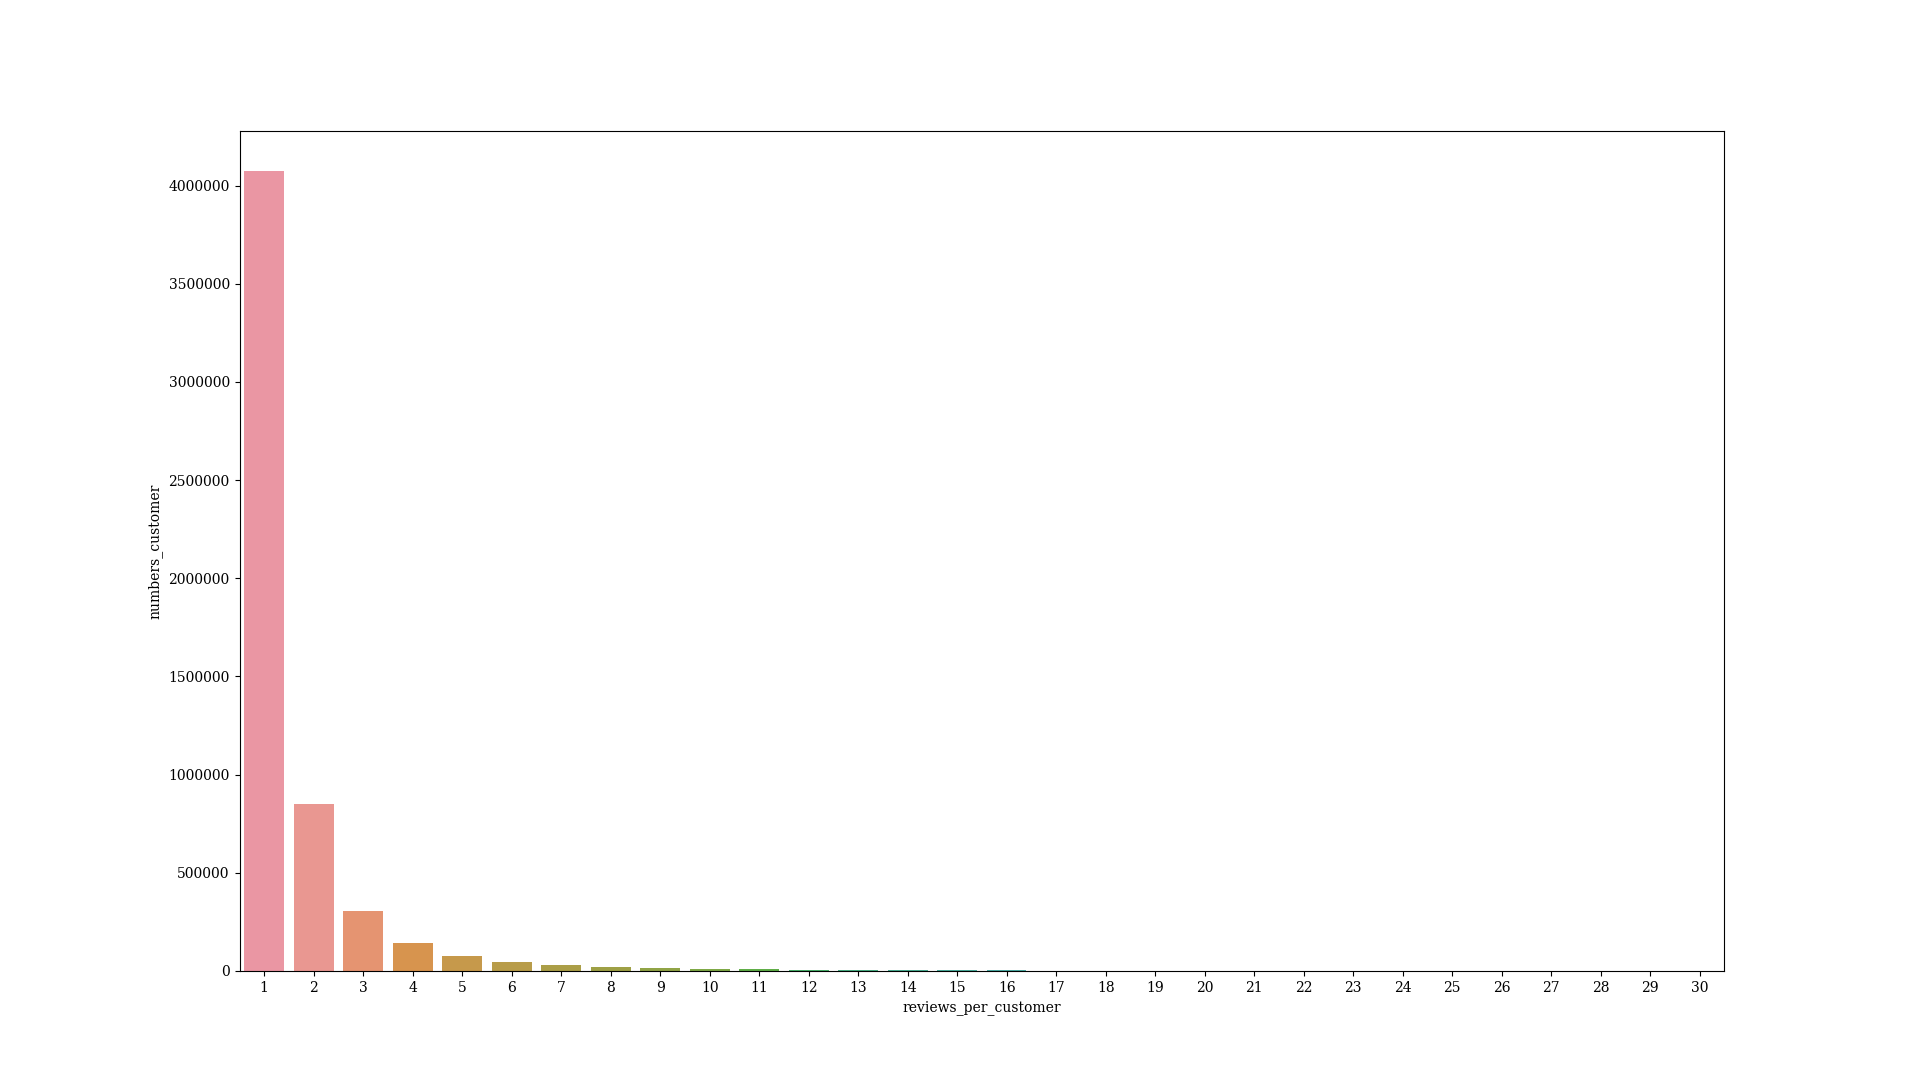
*Numbers of reviews vs Numbers of customer*

You can observe that most customers only leave 1 review, and up to about 5.
Note that this visualization only covers up to customers with 30 reviews, but the maximum number of reviews left by one customer was 3162.
This might indicates that some of the reviews / customers were fraudulent.

### Verifying Customer Reviews

This dataset comes with column `verified_purchase`, which means a customer actually purchased the product from amazon prior to leaving the review.
We will compare the numbers of reviews left by each customer, between verified reviews vs non-verified reviews.

**Verified Reviews**<br>
In the following steps and corresponding line in a cell below, we'll gain average numbers of reviews left per customer for verified purchases only.
1. make essentia data stream in bulk mode
2. filter out verified records only
3. get numbers of reviews left by each customer by counting numbers of unique review_id per customer_id
4. get the average of numbers of reviews per customer

In [9]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,eok,tsv - -d %cols -filt "verified_purchase == \"Y\"" -c review_id customer_id | \
 aq_cnt -f,+1 - -d S:review_id I:customer_id -g customer_id -k num_reviews review_id | \
 aq_cnt -f,+1 - -d I:customer_id I:row I:num_reviews -kX - analytics customer_id STATS:num_reviews'

"customer_id","count","num_reviews.sum","num_reviews.avg","num_reviews.stddev","num_reviews.min","num_reviews.max"
10133,1,1,1,0,1,1
19612,1,2,2,0,2,2
19677,1,1,1,0,1,1
19999,1,1,1,0,1,1
20014,1,1,1,0,1,1
20152,1,6,6,0,6,6
20376,1,2,2,0,2,2
20402,1,1,1,0,1,1
20426,1,3,3,0,3,3
20613,1,1,1,0,1,1
20641,1,1,1,0,1,1
20851,1,3,3,0,3,3
20943,1,1,1,0,1,1
20967,1,3,3,0,3,3
21355,1,2,2,0,2,2
21426,1,3,3,0,3,3
21788,1,1,1,0,1,1
21834,1,2,2,0,2,2
22085,1,3,3,0,3,3
22134,1,1,1,0,1,1
22161,1,1,1,0,1,1
22423,1,1,1,0,1,1
22800,1,1,1,0,1,1
22820,1,2,2,0,2,2
22843,1,1,1,0,1,1
22845,1,2,2,0,2,2
23054,1,2,2,0,2,2
23235,1,1,1,0,1,1
23334,1,2,2,0,2,2
23568,1,2,2,0,2,2
23598,1,2,2,0,2,2
23648,1,1,1,0,1,1
24105,1,1,1,0,1,1
25331,1,1,1,0,1,1
26422,1,1,1,0,1,1
26496,1,1,1,0,1,1
26559,1,1,1,0,1,1
26828,1,1,1,0,1,1
26852,1,1,1,0,1,1
26857,1,2,2,0,2,2
26999,1,2,2,0,2,2
28614,1,5,5,0,5,5
28867,1,1,1,0,1,1
28872,1,1,1,0,1,1
29095,1,1,1,0,1,1
29493,1,1,1,0,1,1
29599,1,1,1,0,1,1
30350,1,1,1,0,1,1
30820,1,1,1,0,1,1
312

2031186,1,1,1,0,1,1
2042012,1,1,1,0,1,1
2049257,1,1,1,0,1,1
2063106,1,1,1,0,1,1
2082278,1,1,1,0,1,1
2094984,1,1,1,0,1,1
2097257,1,1,1,0,1,1
2148673,1,1,1,0,1,1
2149036,1,1,1,0,1,1
2154602,1,1,1,0,1,1
2159380,1,1,1,0,1,1
2165412,1,1,1,0,1,1
2172492,1,1,1,0,1,1
2208522,1,1,1,0,1,1
2221209,1,1,1,0,1,1
2225004,1,2,2,0,2,2
2230000,1,1,1,0,1,1
2231066,1,1,1,0,1,1
2251373,1,1,1,0,1,1
2271034,1,1,1,0,1,1
2291681,1,3,3,0,3,3
2305155,1,1,1,0,1,1
2306311,1,2,2,0,2,2
2318063,1,1,1,0,1,1
2334057,1,2,2,0,2,2
2339528,1,2,2,0,2,2
2339950,1,1,1,0,1,1
2355245,1,1,1,0,1,1
2380091,1,1,1,0,1,1
2426415,1,2,2,0,2,2
2429257,1,1,1,0,1,1
2434531,1,1,1,0,1,1
2443424,1,1,1,0,1,1
2444071,1,1,1,0,1,1
2470491,1,1,1,0,1,1
2480547,1,1,1,0,1,1
2482978,1,2,2,0,2,2
2490726,1,1,1,0,1,1
2495107,1,2,2,0,2,2
2496442,1,1,1,0,1,1
2512999,1,1,1,0,1,1
2524712,1,1,1,0,1,1
2547541,1,2,2,0,2,2
2555955,1,1,1,0,1,1
2560396,1,1,1,0,1,1
2564252,1,1,1,0,1,1
2564460,1,1,1,0,1,1
2583705,1,1,1,0,1,1
2589369,1,1,1,0,1,1
2622390,1,1,1,0,1,1


3336381,1,1,1,0,1,1
3336414,1,1,1,0,1,1
3336929,1,1,1,0,1,1
3340440,1,1,1,0,1,1
3341034,1,1,1,0,1,1
3341555,1,3,3,0,3,3
3341974,1,1,1,0,1,1
3342109,1,1,1,0,1,1
3342470,1,1,1,0,1,1
3344381,1,1,1,0,1,1
3346146,1,1,1,0,1,1
3346544,1,1,1,0,1,1
3347312,1,1,1,0,1,1
3347433,1,1,1,0,1,1
3347849,1,1,1,0,1,1
3347916,1,1,1,0,1,1
3348679,1,1,1,0,1,1
3348745,1,1,1,0,1,1
3349648,1,1,1,0,1,1
3350900,1,1,1,0,1,1
3351691,1,1,1,0,1,1
3352056,1,2,2,0,2,2
3352831,1,1,1,0,1,1
3353157,1,1,1,0,1,1
3354513,1,1,1,0,1,1
3355884,1,1,1,0,1,1
3355955,1,1,1,0,1,1
3356022,1,1,1,0,1,1
3356205,1,1,1,0,1,1
3358426,1,6,6,0,6,6
3358473,1,1,1,0,1,1
3360899,1,1,1,0,1,1
3361725,1,1,1,0,1,1
3362978,1,1,1,0,1,1
3363506,1,1,1,0,1,1
3363767,1,1,1,0,1,1
3365706,1,2,2,0,2,2
3366800,1,1,1,0,1,1
3367036,1,2,2,0,2,2
3367171,1,2,2,0,2,2
3368641,1,1,1,0,1,1
3370450,1,1,1,0,1,1
3371339,1,1,1,0,1,1
3372241,1,1,1,0,1,1
3373545,1,1,1,0,1,1
3375636,1,1,1,0,1,1
3378142,1,1,1,0,1,1
3379283,1,1,1,0,1,1
3379489,1,1,1,0,1,1
3380382,1,1,1,0,1,1


3551077,1,1,1,0,1,1
3551234,1,1,1,0,1,1
3551342,1,1,1,0,1,1
3551417,1,1,1,0,1,1
3551675,1,2,2,0,2,2
3551745,1,1,1,0,1,1
3552712,1,1,1,0,1,1
3553169,1,1,1,0,1,1
3553386,1,1,1,0,1,1
3553939,1,1,1,0,1,1
3554117,1,2,2,0,2,2
3554770,1,1,1,0,1,1
3554775,1,1,1,0,1,1
3554825,1,1,1,0,1,1
3554937,1,1,1,0,1,1
3555146,1,1,1,0,1,1
3555461,1,1,1,0,1,1
3555792,1,2,2,0,2,2
3555798,1,1,1,0,1,1
3555888,1,1,1,0,1,1
3555898,1,1,1,0,1,1
3556441,1,2,2,0,2,2
3557230,1,1,1,0,1,1
3557240,1,1,1,0,1,1
3557499,1,1,1,0,1,1
3557564,1,3,3,0,3,3
3558033,1,1,1,0,1,1
3558043,1,1,1,0,1,1
3558481,1,1,1,0,1,1
3558642,1,1,1,0,1,1
3558859,1,2,2,0,2,2
3558864,1,1,1,0,1,1
3558918,1,1,1,0,1,1
3558926,1,1,1,0,1,1
3558993,1,1,1,0,1,1
3559762,1,1,1,0,1,1
3560640,1,1,1,0,1,1
3560658,1,1,1,0,1,1
3560842,1,1,1,0,1,1
3561124,1,1,1,0,1,1
3561297,1,1,1,0,1,1
3561453,1,1,1,0,1,1
3561590,1,1,1,0,1,1
3561659,1,2,2,0,2,2
3561918,1,1,1,0,1,1
3562136,1,1,1,0,1,1
3562137,1,1,1,0,1,1
3562533,1,3,3,0,3,3
3562687,1,1,1,0,1,1
3563114,1,1,1,0,1,1


3717671,1,1,1,0,1,1
3718002,1,2,2,0,2,2
3718829,1,1,1,0,1,1
3719164,1,1,1,0,1,1
3719605,1,1,1,0,1,1
3720152,1,1,1,0,1,1
3720453,1,1,1,0,1,1
3720545,1,1,1,0,1,1
3720824,1,3,3,0,3,3
3720914,1,1,1,0,1,1
3721020,1,1,1,0,1,1
3721186,1,1,1,0,1,1
3721832,1,1,1,0,1,1
3722183,1,1,1,0,1,1
3723450,1,1,1,0,1,1
3724302,1,1,1,0,1,1
3724717,1,1,1,0,1,1
3724789,1,1,1,0,1,1
3725420,1,1,1,0,1,1
3726415,1,1,1,0,1,1
3726806,1,1,1,0,1,1
3726995,1,1,1,0,1,1
3727512,1,1,1,0,1,1
3728053,1,1,1,0,1,1
3728603,1,1,1,0,1,1
3729757,1,1,1,0,1,1
3729889,1,1,1,0,1,1
3729924,1,1,1,0,1,1
3730533,1,1,1,0,1,1
3731123,1,1,1,0,1,1
3731211,1,4,4,0,4,4
3732025,1,1,1,0,1,1
3732081,1,1,1,0,1,1
3732167,1,1,1,0,1,1
3732306,1,1,1,0,1,1
3732481,1,1,1,0,1,1
3732536,1,3,3,0,3,3
3736085,1,1,1,0,1,1
3738110,1,1,1,0,1,1
3738998,1,7,7,0,7,7
3739473,1,1,1,0,1,1
3741738,1,1,1,0,1,1
3741754,1,1,1,0,1,1
3743643,1,2,2,0,2,2
3744024,1,1,1,0,1,1
3744098,1,1,1,0,1,1
3745298,1,1,1,0,1,1
3746781,1,1,1,0,1,1
3747676,1,1,1,0,1,1
3748645,1,1,1,0,1,1


3899626,1,1,1,0,1,1
3899793,1,1,1,0,1,1
3899957,1,1,1,0,1,1
3900006,1,1,1,0,1,1
3900189,1,1,1,0,1,1
3900383,1,2,2,0,2,2
3901102,1,1,1,0,1,1
3901350,1,1,1,0,1,1
3901918,1,1,1,0,1,1
3902188,1,1,1,0,1,1
3902827,1,1,1,0,1,1
3902923,1,1,1,0,1,1
3903332,1,1,1,0,1,1
3903404,1,1,1,0,1,1
3903438,1,1,1,0,1,1
3903632,1,3,3,0,3,3
3903892,1,2,2,0,2,2
3904877,1,1,1,0,1,1
3905714,1,1,1,0,1,1
3906758,1,1,1,0,1,1
3906770,1,1,1,0,1,1
3906854,1,1,1,0,1,1
3907373,1,1,1,0,1,1
3907759,1,1,1,0,1,1
3908192,1,1,1,0,1,1
3908370,1,1,1,0,1,1
3908394,1,1,1,0,1,1
3908990,1,1,1,0,1,1
3909048,1,1,1,0,1,1
3909076,1,1,1,0,1,1
3912290,1,1,1,0,1,1
3914059,1,1,1,0,1,1
3914095,1,1,1,0,1,1
3915929,1,1,1,0,1,1
3916150,1,1,1,0,1,1
3916179,1,1,1,0,1,1
3916752,1,1,1,0,1,1
3916795,1,1,1,0,1,1
3916970,1,1,1,0,1,1
3917742,1,1,1,0,1,1
3918639,1,1,1,0,1,1
3919298,1,1,1,0,1,1
3919429,1,1,1,0,1,1
3919994,1,1,1,0,1,1
3920322,1,1,1,0,1,1
3921698,1,2,2,0,2,2
3922858,1,1,1,0,1,1
3923541,1,1,1,0,1,1
3923724,1,3,3,0,3,3
3923762,1,1,1,0,1,1


4081741,1,1,1,0,1,1
4082390,1,1,1,0,1,1
4082537,1,1,1,0,1,1
4082542,1,1,1,0,1,1
4083092,1,1,1,0,1,1
4083171,1,1,1,0,1,1
4083228,1,1,1,0,1,1
4083366,1,1,1,0,1,1
4084185,1,1,1,0,1,1
4084186,1,3,3,0,3,3
4084811,1,11,11,0,11,11
4084847,1,1,1,0,1,1
4085981,1,1,1,0,1,1
4086141,1,1,1,0,1,1
4086747,1,1,1,0,1,1
4086921,1,1,1,0,1,1
4087119,1,1,1,0,1,1
4087933,1,1,1,0,1,1
4088476,1,2,2,0,2,2
4089151,1,1,1,0,1,1
4089503,1,1,1,0,1,1
4090435,1,1,1,0,1,1
4091117,1,1,1,0,1,1
4091388,1,1,1,0,1,1
4092162,1,1,1,0,1,1
4092235,1,1,1,0,1,1
4092920,1,1,1,0,1,1
4093546,1,2,2,0,2,2
4094206,1,1,1,0,1,1
4094558,1,1,1,0,1,1
4095867,1,2,2,0,2,2
4096090,1,1,1,0,1,1
4096662,1,1,1,0,1,1
4096870,1,2,2,0,2,2
4097716,1,1,1,0,1,1
4097860,1,1,1,0,1,1
4098362,1,1,1,0,1,1
4098528,1,1,1,0,1,1
4098616,1,1,1,0,1,1
4099135,1,1,1,0,1,1
4100492,1,1,1,0,1,1
4101694,1,1,1,0,1,1
4104247,1,1,1,0,1,1
4104478,1,1,1,0,1,1
4104744,1,1,1,0,1,1
4105100,1,1,1,0,1,1
4105533,1,1,1,0,1,1
4107098,1,1,1,0,1,1
4107952,1,1,1,0,1,1
4108241,1,1,1,0,

4294877,1,1,1,0,1,1
4294939,1,1,1,0,1,1
4295111,1,1,1,0,1,1
4295180,1,1,1,0,1,1
4295790,1,19,19,0,19,19
4295944,1,1,1,0,1,1
4296217,1,1,1,0,1,1
4297405,1,1,1,0,1,1
4297551,1,2,2,0,2,2
4298851,1,1,1,0,1,1
4300177,1,1,1,0,1,1
4302521,1,2,2,0,2,2
4302894,1,1,1,0,1,1
4302916,1,1,1,0,1,1
4303051,1,1,1,0,1,1
4303168,1,1,1,0,1,1
4303676,1,1,1,0,1,1
4303701,1,2,2,0,2,2
4303865,1,1,1,0,1,1
4304045,1,1,1,0,1,1
4304181,1,1,1,0,1,1
4304761,1,1,1,0,1,1
4304950,1,1,1,0,1,1
4305808,1,2,2,0,2,2
4305850,1,2,2,0,2,2
4306257,1,1,1,0,1,1
4306321,1,1,1,0,1,1
4306875,1,1,1,0,1,1
4307188,1,1,1,0,1,1
4307390,1,1,1,0,1,1
4307827,1,1,1,0,1,1
4307880,1,1,1,0,1,1
4308488,1,1,1,0,1,1
4308942,1,1,1,0,1,1
4309763,1,1,1,0,1,1
4310441,1,1,1,0,1,1
4310772,1,1,1,0,1,1
4311080,1,2,2,0,2,2
4311490,1,1,1,0,1,1
4311747,1,1,1,0,1,1
4312053,1,1,1,0,1,1
4314071,1,1,1,0,1,1
4314284,1,1,1,0,1,1
4314537,1,1,1,0,1,1
4314678,1,1,1,0,1,1
4315195,1,1,1,0,1,1
4316427,1,1,1,0,1,1
4316965,1,1,1,0,1,1
4317448,1,1,1,0,1,1
4317666,1,1,1,0,

4476781,1,1,1,0,1,1
4476932,1,3,3,0,3,3
4478537,1,1,1,0,1,1
4480121,1,10,10,0,10,10
4480573,1,1,1,0,1,1
4481243,1,1,1,0,1,1
4481322,1,1,1,0,1,1
4481573,1,2,2,0,2,2
4481612,1,1,1,0,1,1
4482016,1,2,2,0,2,2
4483893,1,2,2,0,2,2
4484645,1,1,1,0,1,1
4486203,1,1,1,0,1,1
4486323,1,1,1,0,1,1
4486472,1,1,1,0,1,1
4486500,1,1,1,0,1,1
4487330,1,1,1,0,1,1
4488773,1,1,1,0,1,1
4488932,1,1,1,0,1,1
4489242,1,1,1,0,1,1
4489427,1,1,1,0,1,1
4490931,1,1,1,0,1,1
4491080,1,1,1,0,1,1
4491439,1,1,1,0,1,1
4491836,1,1,1,0,1,1
4492395,1,2,2,0,2,2
4492652,1,1,1,0,1,1
4492733,1,1,1,0,1,1
4492928,1,1,1,0,1,1
4493106,1,1,1,0,1,1
4493724,1,1,1,0,1,1
4494626,1,1,1,0,1,1
4494755,1,1,1,0,1,1
4495021,1,1,1,0,1,1
4495042,1,1,1,0,1,1
4495228,1,1,1,0,1,1
4495879,1,4,4,0,4,4
4496215,1,2,2,0,2,2
4497059,1,1,1,0,1,1
4497277,1,1,1,0,1,1
4498125,1,1,1,0,1,1
4498309,1,1,1,0,1,1
4498467,1,1,1,0,1,1
4498534,1,1,1,0,1,1
4498992,1,1,1,0,1,1
4499259,1,2,2,0,2,2
4499496,1,1,1,0,1,1
4499502,1,2,2,0,2,2
4499517,1,1,1,0,1,1
4500669,1,1,1,0,

4641946,1,1,1,0,1,1
4642071,1,1,1,0,1,1
4642273,1,1,1,0,1,1
4642837,1,2,2,0,2,2
4643202,1,2,2,0,2,2
4643498,1,1,1,0,1,1
4643577,1,1,1,0,1,1
4643687,1,1,1,0,1,1
4643723,1,1,1,0,1,1
4643793,1,1,1,0,1,1
4644042,1,1,1,0,1,1
4644169,1,1,1,0,1,1
4644197,1,1,1,0,1,1
4644789,1,1,1,0,1,1
4645020,1,1,1,0,1,1
4645605,1,1,1,0,1,1
4646068,1,1,1,0,1,1
4646462,1,1,1,0,1,1
4646759,1,1,1,0,1,1
4647253,1,1,1,0,1,1
4647391,1,2,2,0,2,2
4649517,1,2,2,0,2,2
4649653,1,1,1,0,1,1
4649751,1,1,1,0,1,1
4650208,1,1,1,0,1,1
4650531,1,1,1,0,1,1
4650579,1,1,1,0,1,1
4650832,1,2,2,0,2,2
4650904,1,1,1,0,1,1
4651178,1,1,1,0,1,1
4651377,1,1,1,0,1,1
4651926,1,1,1,0,1,1
4651942,1,2,2,0,2,2
4653717,1,1,1,0,1,1
4654713,1,2,2,0,2,2
4655934,1,1,1,0,1,1
4656726,1,1,1,0,1,1
4656831,1,1,1,0,1,1
4658485,1,1,1,0,1,1
4659733,1,1,1,0,1,1
4660346,1,1,1,0,1,1
4660415,1,1,1,0,1,1
4660788,1,1,1,0,1,1
4660948,1,2,2,0,2,2
4662197,1,1,1,0,1,1
4663186,1,1,1,0,1,1
4663440,1,1,1,0,1,1
4663745,1,2,2,0,2,2
4664224,1,1,1,0,1,1
4664406,1,1,1,0,1,1


4782120,1,1,1,0,1,1
4782494,1,2,2,0,2,2
4782714,1,1,1,0,1,1
4782971,1,1,1,0,1,1
4783057,1,1,1,0,1,1
4783675,1,1,1,0,1,1
4784520,1,1,1,0,1,1
4784627,1,2,2,0,2,2
4784774,1,1,1,0,1,1
4784862,1,1,1,0,1,1
4786222,1,2,2,0,2,2
4788540,1,1,1,0,1,1
4789791,1,1,1,0,1,1
4790388,1,1,1,0,1,1
4791088,1,1,1,0,1,1
4791242,1,1,1,0,1,1
4791545,1,1,1,0,1,1
4791903,1,1,1,0,1,1
4792493,1,1,1,0,1,1
4796372,1,1,1,0,1,1
4796732,1,1,1,0,1,1
4797214,1,1,1,0,1,1
4797417,1,1,1,0,1,1
4797441,1,1,1,0,1,1
4797576,1,1,1,0,1,1
4798238,1,2,2,0,2,2
4798535,1,1,1,0,1,1
4799235,1,1,1,0,1,1
4799963,1,1,1,0,1,1
4800141,1,1,1,0,1,1
4800785,1,1,1,0,1,1
4800938,1,2,2,0,2,2
4801019,1,1,1,0,1,1
4801193,1,1,1,0,1,1
4801817,1,2,2,0,2,2
4802002,1,1,1,0,1,1
4802158,1,4,4,0,4,4
4802229,1,1,1,0,1,1
4802375,1,1,1,0,1,1
4802916,1,1,1,0,1,1
4803429,1,1,1,0,1,1
4803516,1,1,1,0,1,1
4804514,1,1,1,0,1,1
4804649,1,1,1,0,1,1
4804970,1,1,1,0,1,1
4805104,1,1,1,0,1,1
4805541,1,2,2,0,2,2
4805707,1,1,1,0,1,1
4806152,1,1,1,0,1,1
4806304,1,1,1,0,1,1


4963771,1,1,1,0,1,1
4963903,1,1,1,0,1,1
4964224,1,1,1,0,1,1
4964314,1,1,1,0,1,1
4964647,1,1,1,0,1,1
4965004,1,2,2,0,2,2
4965060,1,2,2,0,2,2
4965185,1,1,1,0,1,1
4965663,1,2,2,0,2,2
4965792,1,1,1,0,1,1
4965986,1,1,1,0,1,1
4967066,1,1,1,0,1,1
4967179,1,1,1,0,1,1
4967293,1,1,1,0,1,1
4968186,1,1,1,0,1,1
4968529,1,1,1,0,1,1
4968798,1,1,1,0,1,1
4968874,1,1,1,0,1,1
4969076,1,1,1,0,1,1
4969134,1,1,1,0,1,1
4969498,1,1,1,0,1,1
4969696,1,1,1,0,1,1
4969843,1,4,4,0,4,4
4970773,1,1,1,0,1,1
4971122,1,1,1,0,1,1
4972103,1,1,1,0,1,1
4972692,1,1,1,0,1,1
4973150,1,1,1,0,1,1
4973752,1,1,1,0,1,1
4974880,1,1,1,0,1,1
4975170,1,1,1,0,1,1
4975264,1,1,1,0,1,1
4975281,1,1,1,0,1,1
4975516,1,1,1,0,1,1
4975829,1,1,1,0,1,1
4976205,1,2,2,0,2,2
4976266,1,1,1,0,1,1
4976325,1,1,1,0,1,1
4976518,1,1,1,0,1,1
4976835,1,2,2,0,2,2
4976936,1,1,1,0,1,1
4977809,1,2,2,0,2,2
4977817,1,1,1,0,1,1
4978024,1,2,2,0,2,2
4978404,1,2,2,0,2,2
4979844,1,1,1,0,1,1
4979985,1,1,1,0,1,1
4980192,1,1,1,0,1,1
4980301,1,1,1,0,1,1
4980472,1,2,2,0,2,2


5126769,1,1,1,0,1,1
5126844,1,1,1,0,1,1
5126963,1,1,1,0,1,1
5127052,1,1,1,0,1,1
5127173,1,1,1,0,1,1
5127230,1,1,1,0,1,1
5127528,1,3,3,0,3,3
5128480,1,2,2,0,2,2
5129309,1,1,1,0,1,1
5129434,1,1,1,0,1,1
5129685,1,1,1,0,1,1
5130480,1,1,1,0,1,1
5130772,1,1,1,0,1,1
5131065,1,1,1,0,1,1
5131460,1,1,1,0,1,1
5131483,1,3,3,0,3,3
5131836,1,1,1,0,1,1
5131996,1,1,1,0,1,1
5132047,1,1,1,0,1,1
5132915,1,2,2,0,2,2
5133350,1,2,2,0,2,2
5136345,1,1,1,0,1,1
5136597,1,1,1,0,1,1
5136960,1,1,1,0,1,1
5137726,1,1,1,0,1,1
5139009,1,1,1,0,1,1
5140034,1,1,1,0,1,1
5140041,1,1,1,0,1,1
5140612,1,1,1,0,1,1
5140675,1,1,1,0,1,1
5140999,1,1,1,0,1,1
5141485,1,1,1,0,1,1
5142277,1,1,1,0,1,1
5142641,1,1,1,0,1,1
5142886,1,1,1,0,1,1
5143062,1,1,1,0,1,1
5143128,1,1,1,0,1,1
5143592,1,1,1,0,1,1
5143945,1,1,1,0,1,1
5143971,1,2,2,0,2,2
5144273,1,1,1,0,1,1
5144295,1,1,1,0,1,1
5144318,1,1,1,0,1,1
5144762,1,1,1,0,1,1
5145101,1,1,1,0,1,1
5145697,1,1,1,0,1,1
5145801,1,1,1,0,1,1
5145883,1,1,1,0,1,1
5146456,1,1,1,0,1,1
5146567,1,2,2,0,2,2


5293790,1,2,2,0,2,2
5293804,1,1,1,0,1,1
5293882,1,1,1,0,1,1
5293890,1,1,1,0,1,1
5293926,1,2,2,0,2,2
5293938,1,1,1,0,1,1
5294345,1,3,3,0,3,3
5294710,1,2,2,0,2,2
5295737,1,1,1,0,1,1
5295957,1,1,1,0,1,1
5295980,1,1,1,0,1,1
5296503,1,1,1,0,1,1
5297859,1,1,1,0,1,1
5297919,1,1,1,0,1,1
5298320,1,1,1,0,1,1
5299237,1,3,3,0,3,3
5299320,1,1,1,0,1,1
5299579,1,1,1,0,1,1
5300601,1,1,1,0,1,1
5300997,1,1,1,0,1,1
5301095,1,1,1,0,1,1
5301454,1,1,1,0,1,1
5301587,1,1,1,0,1,1
5302367,1,1,1,0,1,1
5302586,1,1,1,0,1,1
5303574,1,1,1,0,1,1
5303859,1,1,1,0,1,1
5303884,1,1,1,0,1,1
5304673,1,1,1,0,1,1
5305176,1,1,1,0,1,1
5305253,1,1,1,0,1,1
5305721,1,1,1,0,1,1
5305841,1,1,1,0,1,1
5306168,1,1,1,0,1,1
5306558,1,1,1,0,1,1
5306845,1,1,1,0,1,1
5307623,1,1,1,0,1,1
5307867,1,2,2,0,2,2
5308161,1,1,1,0,1,1
5308831,1,1,1,0,1,1
5308864,1,1,1,0,1,1
5308924,1,1,1,0,1,1
5309121,1,1,1,0,1,1
5309920,1,1,1,0,1,1
5310715,1,1,1,0,1,1
5310727,1,2,2,0,2,2
5311483,1,1,1,0,1,1
5311564,1,2,2,0,2,2
5311786,1,2,2,0,2,2
5311949,1,1,1,0,1,1


5440163,1,1,1,0,1,1
5440290,1,1,1,0,1,1
5440416,1,8,8,0,8,8
5440593,1,1,1,0,1,1
5440843,1,1,1,0,1,1
5441443,1,1,1,0,1,1
5441615,1,3,3,0,3,3
5441777,1,1,1,0,1,1
5442407,1,1,1,0,1,1
5442486,1,1,1,0,1,1
5442723,1,1,1,0,1,1
5442981,1,1,1,0,1,1
5443036,1,2,2,0,2,2
5444087,1,1,1,0,1,1
5445274,1,1,1,0,1,1
5445298,1,1,1,0,1,1
5445490,1,1,1,0,1,1
5445536,1,1,1,0,1,1
5445748,1,1,1,0,1,1
5445868,1,1,1,0,1,1
5446070,1,3,3,0,3,3
5446608,1,1,1,0,1,1
5446978,1,1,1,0,1,1
5446985,1,15,15,0,15,15
5447049,1,1,1,0,1,1
5447295,1,1,1,0,1,1
5447748,1,1,1,0,1,1
5447922,1,1,1,0,1,1
5448145,1,2,2,0,2,2
5448250,1,1,1,0,1,1
5448301,1,1,1,0,1,1
5448337,1,2,2,0,2,2
5448371,1,1,1,0,1,1
5448935,1,1,1,0,1,1
5449309,1,1,1,0,1,1
5449655,1,1,1,0,1,1
5449658,1,2,2,0,2,2
5449669,1,1,1,0,1,1
5449845,1,1,1,0,1,1
5450012,1,1,1,0,1,1
5451055,1,1,1,0,1,1
5451077,1,1,1,0,1,1
5451969,1,1,1,0,1,1
5452238,1,1,1,0,1,1
5452352,1,1,1,0,1,1
5452701,1,1,1,0,1,1
5452771,1,1,1,0,1,1
5452802,1,1,1,0,1,1
5453126,1,1,1,0,1,1
5453442,1,1,1,0,

5557953,1,3,3,0,3,3
5558138,1,1,1,0,1,1
5558627,1,1,1,0,1,1
5558896,1,8,8,0,8,8
5558958,1,1,1,0,1,1
5559619,1,1,1,0,1,1
5559630,1,1,1,0,1,1
5559781,1,1,1,0,1,1
5560498,1,1,1,0,1,1
5560508,1,1,1,0,1,1
5560564,1,1,1,0,1,1
5560665,1,6,6,0,6,6
5560780,1,1,1,0,1,1
5560872,1,1,1,0,1,1
5561158,1,1,1,0,1,1
5562117,1,1,1,0,1,1
5562396,1,1,1,0,1,1
5562569,1,1,1,0,1,1
5562575,1,1,1,0,1,1
5562705,1,1,1,0,1,1
5562756,1,2,2,0,2,2
5562855,1,1,1,0,1,1
5564099,1,2,2,0,2,2
5564328,1,1,1,0,1,1
5564515,1,1,1,0,1,1
5564576,1,1,1,0,1,1
5564768,1,1,1,0,1,1
5565142,1,1,1,0,1,1
5566296,1,1,1,0,1,1
5566368,1,1,1,0,1,1
5566690,1,1,1,0,1,1
5566737,1,1,1,0,1,1
5566810,1,1,1,0,1,1
5566895,1,1,1,0,1,1
5567075,1,1,1,0,1,1
5567196,1,1,1,0,1,1
5567300,1,1,1,0,1,1
5567331,1,1,1,0,1,1
5567841,1,1,1,0,1,1
5568157,1,2,2,0,2,2
5568274,1,1,1,0,1,1
5568544,1,1,1,0,1,1
5570135,1,1,1,0,1,1
5570223,1,1,1,0,1,1
5570534,1,1,1,0,1,1
5570543,1,1,1,0,1,1
5570692,1,1,1,0,1,1
5570953,1,2,2,0,2,2
5571293,1,2,2,0,2,2
5571583,1,3,3,0,3,3


5708935,1,1,1,0,1,1
5709026,1,1,1,0,1,1
5709291,1,1,1,0,1,1
5709656,1,1,1,0,1,1
5709917,1,1,1,0,1,1
5710847,1,1,1,0,1,1
5710902,1,1,1,0,1,1
5710984,1,1,1,0,1,1
5711654,1,1,1,0,1,1
5712530,1,1,1,0,1,1
5712591,1,1,1,0,1,1
5712975,1,1,1,0,1,1
5713451,1,1,1,0,1,1
5713686,1,1,1,0,1,1
5713735,1,1,1,0,1,1
5713977,1,2,2,0,2,2
5714684,1,1,1,0,1,1
5714749,1,1,1,0,1,1
5714918,1,1,1,0,1,1
5715331,1,1,1,0,1,1
5715600,1,1,1,0,1,1
5715834,1,1,1,0,1,1
5716221,1,1,1,0,1,1
5716902,1,1,1,0,1,1
5717233,1,1,1,0,1,1
5717948,1,1,1,0,1,1
5718026,1,2,2,0,2,2
5718168,1,1,1,0,1,1
5718299,1,2,2,0,2,2
5719531,1,1,1,0,1,1
5719574,1,1,1,0,1,1
5719764,1,1,1,0,1,1
5719959,1,1,1,0,1,1
5720039,1,1,1,0,1,1
5720204,1,1,1,0,1,1
5720938,1,1,1,0,1,1
5721018,1,1,1,0,1,1
5721050,1,1,1,0,1,1
5721280,1,1,1,0,1,1
5721752,1,1,1,0,1,1
5723012,1,1,1,0,1,1
5723954,1,1,1,0,1,1
5724214,1,1,1,0,1,1
5725616,1,1,1,0,1,1
5726054,1,1,1,0,1,1
5726455,1,1,1,0,1,1
5726502,1,2,2,0,2,2
5726513,1,1,1,0,1,1
5727082,1,1,1,0,1,1
5727208,1,1,1,0,1,1


5868675,1,1,1,0,1,1
5868885,1,1,1,0,1,1
5869120,1,2,2,0,2,2
5869273,1,1,1,0,1,1
5869621,1,1,1,0,1,1
5871326,1,1,1,0,1,1
5871418,1,1,1,0,1,1
5873136,1,1,1,0,1,1
5873483,1,1,1,0,1,1
5873839,1,1,1,0,1,1
5874847,1,1,1,0,1,1
5875305,1,1,1,0,1,1
5876308,1,1,1,0,1,1
5877558,1,1,1,0,1,1
5877874,1,1,1,0,1,1
5878104,1,1,1,0,1,1
5878301,1,2,2,0,2,2
5878690,1,1,1,0,1,1
5879011,1,1,1,0,1,1
5879062,1,1,1,0,1,1
5879617,1,1,1,0,1,1
5879746,1,1,1,0,1,1
5880269,1,1,1,0,1,1
5881073,1,1,1,0,1,1
5881715,1,2,2,0,2,2
5882216,1,1,1,0,1,1
5882242,1,1,1,0,1,1
5882443,1,1,1,0,1,1
5882444,1,1,1,0,1,1
5882635,1,1,1,0,1,1
5883243,1,1,1,0,1,1
5884164,1,1,1,0,1,1
5884573,1,1,1,0,1,1
5884849,1,1,1,0,1,1
5885127,1,1,1,0,1,1
5885567,1,1,1,0,1,1
5887508,1,1,1,0,1,1
5888189,1,1,1,0,1,1
5888756,1,1,1,0,1,1
5889112,1,1,1,0,1,1
5889416,1,1,1,0,1,1
5889981,1,1,1,0,1,1
5890508,1,3,3,0,3,3
5891419,1,1,1,0,1,1
5891488,1,2,2,0,2,2
5891542,1,1,1,0,1,1
5891922,1,1,1,0,1,1
5892098,1,1,1,0,1,1
5892509,1,9,9,0,9,9
5892696,1,1,1,0,1,1


6040699,1,1,1,0,1,1
6041457,1,1,1,0,1,1
6041580,1,1,1,0,1,1
6042543,1,1,1,0,1,1
6043362,1,1,1,0,1,1
6043762,1,1,1,0,1,1
6043873,1,1,1,0,1,1
6044870,1,1,1,0,1,1
6045388,1,1,1,0,1,1
6046342,1,1,1,0,1,1
6046668,1,6,6,0,6,6
6046798,1,1,1,0,1,1
6046909,1,1,1,0,1,1
6046969,1,1,1,0,1,1
6047274,1,1,1,0,1,1
6047511,1,1,1,0,1,1
6047560,1,1,1,0,1,1
6048057,1,1,1,0,1,1
6048472,1,1,1,0,1,1
6049140,1,2,2,0,2,2
6049719,1,2,2,0,2,2
6050090,1,1,1,0,1,1
6050255,1,2,2,0,2,2
6050420,1,1,1,0,1,1
6051695,1,1,1,0,1,1
6052343,1,1,1,0,1,1
6053162,1,1,1,0,1,1
6053214,1,1,1,0,1,1
6053224,1,1,1,0,1,1
6053502,1,1,1,0,1,1
6054743,1,2,2,0,2,2
6055412,1,1,1,0,1,1
6055846,1,1,1,0,1,1
6055906,1,1,1,0,1,1
6056846,1,1,1,0,1,1
6056968,1,1,1,0,1,1
6057441,1,1,1,0,1,1
6057458,1,3,3,0,3,3
6057798,1,1,1,0,1,1
6058755,1,1,1,0,1,1
6058883,1,1,1,0,1,1
6059392,1,2,2,0,2,2
6059763,1,2,2,0,2,2
6060286,1,1,1,0,1,1
6060482,1,1,1,0,1,1
6060827,1,1,1,0,1,1
6061837,1,1,1,0,1,1
6062415,1,2,2,0,2,2
6062847,1,3,3,0,3,3
6063203,1,1,1,0,1,1


6200816,1,1,1,0,1,1
6200853,1,2,2,0,2,2
6202558,1,1,1,0,1,1
6202673,1,1,1,0,1,1
6202792,1,3,3,0,3,3
6203186,1,1,1,0,1,1
6203208,1,1,1,0,1,1
6203578,1,1,1,0,1,1
6204120,1,3,3,0,3,3
6204254,1,6,6,0,6,6
6204303,1,1,1,0,1,1
6205114,1,1,1,0,1,1
6205392,1,2,2,0,2,2
6205825,1,3,3,0,3,3
6206008,1,1,1,0,1,1
6206034,1,1,1,0,1,1
6206067,1,1,1,0,1,1
6206155,1,1,1,0,1,1
6206375,1,1,1,0,1,1
6206448,1,5,5,0,5,5
6206567,1,1,1,0,1,1
6206633,1,1,1,0,1,1
6206738,1,1,1,0,1,1
6208666,1,1,1,0,1,1
6209220,1,3,3,0,3,3
6209240,1,2,2,0,2,2
6210126,1,1,1,0,1,1
6210408,1,2,2,0,2,2
6211622,1,1,1,0,1,1
6211954,1,1,1,0,1,1
6211958,1,3,3,0,3,3
6212990,1,1,1,0,1,1
6213232,1,2,2,0,2,2
6214087,1,1,1,0,1,1
6214307,1,2,2,0,2,2
6214516,1,1,1,0,1,1
6214960,1,1,1,0,1,1
6215596,1,1,1,0,1,1
6215721,1,2,2,0,2,2
6215987,1,1,1,0,1,1
6216196,1,1,1,0,1,1
6216457,1,1,1,0,1,1
6216665,1,1,1,0,1,1
6216805,1,1,1,0,1,1
6217361,1,4,4,0,4,4
6217446,1,1,1,0,1,1
6217688,1,1,1,0,1,1
6217936,1,1,1,0,1,1
6217991,1,1,1,0,1,1
6218106,1,1,1,0,1,1


6359276,1,1,1,0,1,1
6359691,1,1,1,0,1,1
6359725,1,1,1,0,1,1
6359772,1,1,1,0,1,1
6359838,1,1,1,0,1,1
6360236,1,1,1,0,1,1
6360716,1,1,1,0,1,1
6362854,1,1,1,0,1,1
6362908,1,1,1,0,1,1
6363844,1,3,3,0,3,3
6364084,1,2,2,0,2,2
6364323,1,1,1,0,1,1
6364457,1,1,1,0,1,1
6364534,1,3,3,0,3,3
6364938,1,1,1,0,1,1
6365783,1,2,2,0,2,2
6365982,1,1,1,0,1,1
6366005,1,1,1,0,1,1
6366688,1,1,1,0,1,1
6366979,1,1,1,0,1,1
6367402,1,1,1,0,1,1
6367872,1,1,1,0,1,1
6368064,1,1,1,0,1,1
6368664,1,1,1,0,1,1
6369006,1,1,1,0,1,1
6369268,1,1,1,0,1,1
6369320,1,1,1,0,1,1
6369882,1,1,1,0,1,1
6370534,1,1,1,0,1,1
6370657,1,1,1,0,1,1
6375189,1,2,2,0,2,2
6375349,1,1,1,0,1,1
6375967,1,1,1,0,1,1
6376701,1,1,1,0,1,1
6376766,1,2,2,0,2,2
6376997,1,1,1,0,1,1
6377289,1,1,1,0,1,1
6377674,1,1,1,0,1,1
6377932,1,1,1,0,1,1
6378403,1,1,1,0,1,1
6378505,1,1,1,0,1,1
6378667,1,1,1,0,1,1
6378823,1,3,3,0,3,3
6378925,1,6,6,0,6,6
6379240,1,1,1,0,1,1
6379406,1,1,1,0,1,1
6379488,1,1,1,0,1,1
6379627,1,1,1,0,1,1
6379817,1,2,2,0,2,2
6380024,1,1,1,0,1,1


6517834,1,1,1,0,1,1
6518202,1,3,3,0,3,3
6518379,1,1,1,0,1,1
6518441,1,1,1,0,1,1
6518481,1,1,1,0,1,1
6519363,1,1,1,0,1,1
6519677,1,1,1,0,1,1
6520819,1,1,1,0,1,1
6521069,1,1,1,0,1,1
6521165,1,1,1,0,1,1
6521247,1,1,1,0,1,1
6521273,1,1,1,0,1,1
6521558,1,1,1,0,1,1
6521591,1,1,1,0,1,1
6521704,1,1,1,0,1,1
6522628,1,2,2,0,2,2
6522696,1,1,1,0,1,1
6522701,1,1,1,0,1,1
6522747,1,1,1,0,1,1
6522863,1,1,1,0,1,1
6523067,1,1,1,0,1,1
6524388,1,2,2,0,2,2
6524389,1,1,1,0,1,1
6524732,1,1,1,0,1,1
6525086,1,3,3,0,3,3
6525382,1,2,2,0,2,2
6525395,1,1,1,0,1,1
6526186,1,1,1,0,1,1
6526280,1,1,1,0,1,1
6526348,1,1,1,0,1,1
6526486,1,1,1,0,1,1
6526588,1,1,1,0,1,1
6526903,1,1,1,0,1,1
6527122,1,2,2,0,2,2
6527423,1,1,1,0,1,1
6527845,1,1,1,0,1,1
6528479,1,1,1,0,1,1
6528526,1,1,1,0,1,1
6528570,1,1,1,0,1,1
6528977,1,1,1,0,1,1
6529225,1,1,1,0,1,1
6529672,1,1,1,0,1,1
6530472,1,3,3,0,3,3
6530879,1,1,1,0,1,1
6532390,1,3,3,0,3,3
6532776,1,1,1,0,1,1
6534404,1,2,2,0,2,2
6534533,1,1,1,0,1,1
6534707,1,1,1,0,1,1
6534739,1,1,1,0,1,1


6675171,1,1,1,0,1,1
6676110,1,2,2,0,2,2
6676556,1,1,1,0,1,1
6676908,1,1,1,0,1,1
6677258,1,1,1,0,1,1
6678252,1,1,1,0,1,1
6678920,1,1,1,0,1,1
6679396,1,1,1,0,1,1
6680333,1,1,1,0,1,1
6680431,1,1,1,0,1,1
6681678,1,1,1,0,1,1
6682328,1,1,1,0,1,1
6682894,1,1,1,0,1,1
6683941,1,3,3,0,3,3
6684222,1,1,1,0,1,1
6684360,1,1,1,0,1,1
6684475,1,2,2,0,2,2
6684476,1,1,1,0,1,1
6684496,1,1,1,0,1,1
6686359,1,1,1,0,1,1
6686598,1,1,1,0,1,1
6686605,1,1,1,0,1,1
6686762,1,4,4,0,4,4
6687003,1,1,1,0,1,1
6688382,1,1,1,0,1,1
6688498,1,1,1,0,1,1
6688770,1,1,1,0,1,1
6689224,1,4,4,0,4,4
6689273,1,1,1,0,1,1
6690330,1,1,1,0,1,1
6690357,1,1,1,0,1,1
6691160,1,1,1,0,1,1
6692058,1,1,1,0,1,1
6692245,1,2,2,0,2,2
6692258,1,1,1,0,1,1
6692502,1,1,1,0,1,1
6692618,1,1,1,0,1,1
6693907,1,1,1,0,1,1
6694223,1,1,1,0,1,1
6694476,1,1,1,0,1,1
6694683,1,4,4,0,4,4
6694738,1,2,2,0,2,2
6694941,1,1,1,0,1,1
6695253,1,1,1,0,1,1
6695534,1,1,1,0,1,1
6695593,1,1,1,0,1,1
6695652,1,1,1,0,1,1
6696010,1,1,1,0,1,1
6696255,1,1,1,0,1,1
6696386,1,1,1,0,1,1


6860602,1,2,2,0,2,2
6860781,1,1,1,0,1,1
6861089,1,1,1,0,1,1
6861543,1,1,1,0,1,1
6861596,1,1,1,0,1,1
6862159,1,1,1,0,1,1
6862695,1,1,1,0,1,1
6863392,1,1,1,0,1,1
6863786,1,7,7,0,7,7
6864131,1,1,1,0,1,1
6865870,1,1,1,0,1,1
6866425,1,1,1,0,1,1
6867624,1,1,1,0,1,1
6868024,1,4,4,0,4,4
6868093,1,2,2,0,2,2
6868357,1,1,1,0,1,1
6868915,1,1,1,0,1,1
6869114,1,1,1,0,1,1
6869458,1,1,1,0,1,1
6869561,1,4,4,0,4,4
6869844,1,1,1,0,1,1
6870955,1,1,1,0,1,1
6871208,1,2,2,0,2,2
6871524,1,1,1,0,1,1
6871667,1,1,1,0,1,1
6872768,1,1,1,0,1,1
6872975,1,10,10,0,10,10
6873171,1,1,1,0,1,1
6875526,1,7,7,0,7,7
6876256,1,5,5,0,5,5
6878350,1,23,23,0,23,23
6878352,1,1,1,0,1,1
6878433,1,1,1,0,1,1
6879114,1,1,1,0,1,1
6880766,1,2,2,0,2,2
6880967,1,1,1,0,1,1
6881108,1,2,2,0,2,2
6881391,1,1,1,0,1,1
6881394,1,1,1,0,1,1
6882065,1,1,1,0,1,1
6882313,1,1,1,0,1,1
6882509,1,1,1,0,1,1
6882940,1,1,1,0,1,1
6882968,1,1,1,0,1,1
6883048,1,3,3,0,3,3
6883133,1,1,1,0,1,1
6883611,1,2,2,0,2,2
6884208,1,1,1,0,1,1
6886350,1,1,1,0,1,1
6886412,1,1,

7076519,1,1,1,0,1,1
7076989,1,2,2,0,2,2
7077165,1,1,1,0,1,1
7077793,1,1,1,0,1,1
7079304,1,1,1,0,1,1
7079573,1,2,2,0,2,2
7080048,1,1,1,0,1,1
7081358,1,1,1,0,1,1
7081560,1,1,1,0,1,1
7081680,1,1,1,0,1,1
7081961,1,2,2,0,2,2
7082045,1,1,1,0,1,1
7082628,1,1,1,0,1,1
7083342,1,1,1,0,1,1
7084622,1,1,1,0,1,1
7085624,1,1,1,0,1,1
7085953,1,1,1,0,1,1
7086202,1,1,1,0,1,1
7086631,1,1,1,0,1,1
7087348,1,1,1,0,1,1
7087387,1,3,3,0,3,3
7087436,1,2,2,0,2,2
7088231,1,1,1,0,1,1
7088478,1,4,4,0,4,4
7088771,1,4,4,0,4,4
7089211,1,1,1,0,1,1
7089806,1,1,1,0,1,1
7089816,1,1,1,0,1,1
7090025,1,1,1,0,1,1
7090258,1,1,1,0,1,1
7090355,1,1,1,0,1,1
7090843,1,1,1,0,1,1
7091008,1,1,1,0,1,1
7091238,1,1,1,0,1,1
7091388,1,2,2,0,2,2
7091632,1,1,1,0,1,1
7091692,1,1,1,0,1,1
7092274,1,1,1,0,1,1
7092646,1,1,1,0,1,1
7092831,1,2,2,0,2,2
7093162,1,2,2,0,2,2
7093215,1,1,1,0,1,1
7093573,1,2,2,0,2,2
7093856,1,6,6,0,6,6
7094080,1,3,3,0,3,3
7094235,1,2,2,0,2,2
7094607,1,2,2,0,2,2
7095004,1,1,1,0,1,1
7095178,1,1,1,0,1,1
7095287,1,1,1,0,1,1


7216714,1,1,1,0,1,1
7216744,1,1,1,0,1,1
7216833,1,1,1,0,1,1
7216940,1,1,1,0,1,1
7217146,1,1,1,0,1,1
7217527,1,1,1,0,1,1
7218049,1,1,1,0,1,1
7218301,1,1,1,0,1,1
7218668,1,1,1,0,1,1
7219210,1,1,1,0,1,1
7219476,1,1,1,0,1,1
7219541,1,2,2,0,2,2
7219989,1,1,1,0,1,1
7220790,1,1,1,0,1,1
7221313,1,6,6,0,6,6
7221374,1,3,3,0,3,3
7221847,1,1,1,0,1,1
7222440,1,1,1,0,1,1
7222460,1,1,1,0,1,1
7223311,1,1,1,0,1,1
7223926,1,1,1,0,1,1
7224092,1,1,1,0,1,1
7224246,1,1,1,0,1,1
7224751,1,1,1,0,1,1
7226644,1,1,1,0,1,1
7226981,1,1,1,0,1,1
7227587,1,1,1,0,1,1
7227765,1,1,1,0,1,1
7228523,1,1,1,0,1,1
7228807,1,1,1,0,1,1
7228922,1,1,1,0,1,1
7229161,1,1,1,0,1,1
7229505,1,1,1,0,1,1
7230225,1,1,1,0,1,1
7230252,1,1,1,0,1,1
7230469,1,1,1,0,1,1
7230523,1,1,1,0,1,1
7230954,1,1,1,0,1,1
7231411,1,5,5,0,5,5
7231650,1,1,1,0,1,1
7232889,1,2,2,0,2,2
7232986,1,1,1,0,1,1
7233745,1,1,1,0,1,1
7233881,1,1,1,0,1,1
7234725,1,1,1,0,1,1
7234738,1,1,1,0,1,1
7234951,1,1,1,0,1,1
7235102,1,1,1,0,1,1
7235459,1,1,1,0,1,1
7235803,1,1,1,0,1,1


7366732,1,1,1,0,1,1
7367000,1,1,1,0,1,1
7367057,1,1,1,0,1,1
7367548,1,2,2,0,2,2
7367568,1,1,1,0,1,1
7367778,1,1,1,0,1,1
7368110,1,1,1,0,1,1
7368709,1,1,1,0,1,1
7368851,1,2,2,0,2,2
7368964,1,1,1,0,1,1
7369195,1,1,1,0,1,1
7370150,1,1,1,0,1,1
7370644,1,1,1,0,1,1
7370665,1,1,1,0,1,1
7371402,1,1,1,0,1,1
7371450,1,2,2,0,2,2
7371594,1,1,1,0,1,1
7372344,1,2,2,0,2,2
7372766,1,1,1,0,1,1
7372792,1,1,1,0,1,1
7373108,1,1,1,0,1,1
7373701,1,1,1,0,1,1
7373745,1,1,1,0,1,1
7374279,1,1,1,0,1,1
7374674,1,1,1,0,1,1
7375014,1,1,1,0,1,1
7375081,1,1,1,0,1,1
7375519,1,1,1,0,1,1
7375992,1,1,1,0,1,1
7376032,1,1,1,0,1,1
7376062,1,1,1,0,1,1
7376159,1,1,1,0,1,1
7376882,1,1,1,0,1,1
7377087,1,5,5,0,5,5
7377196,1,1,1,0,1,1
7377268,1,1,1,0,1,1
7377518,1,1,1,0,1,1
7377793,1,1,1,0,1,1
7378338,1,1,1,0,1,1
7378821,1,1,1,0,1,1
7378921,1,1,1,0,1,1
7379252,1,1,1,0,1,1
7379853,1,1,1,0,1,1
7379859,1,1,1,0,1,1
7379912,1,1,1,0,1,1
7380153,1,2,2,0,2,2
7380247,1,1,1,0,1,1
7380466,1,1,1,0,1,1
7381516,1,1,1,0,1,1
7381862,1,1,1,0,1,1


7525825,1,1,1,0,1,1
7525893,1,2,2,0,2,2
7526093,1,2,2,0,2,2
7526327,1,1,1,0,1,1
7526792,1,1,1,0,1,1
7526824,1,1,1,0,1,1
7526856,1,1,1,0,1,1
7526885,1,1,1,0,1,1
7527119,1,1,1,0,1,1
7527438,1,1,1,0,1,1
7528301,1,1,1,0,1,1
7529146,1,9,9,0,9,9
7529619,1,2,2,0,2,2
7530108,1,1,1,0,1,1
7531614,1,1,1,0,1,1
7531766,1,1,1,0,1,1
7531832,1,1,1,0,1,1
7532085,1,1,1,0,1,1
7532378,1,1,1,0,1,1
7532606,1,1,1,0,1,1
7532646,1,1,1,0,1,1
7532928,1,4,4,0,4,4
7533003,1,1,1,0,1,1
7533020,1,1,1,0,1,1
7533175,1,1,1,0,1,1
7533359,1,3,3,0,3,3
7533879,1,2,2,0,2,2
7533929,1,1,1,0,1,1
7534039,1,1,1,0,1,1
7534508,1,1,1,0,1,1
7534840,1,1,1,0,1,1
7535140,1,1,1,0,1,1
7535348,1,2,2,0,2,2
7535654,1,1,1,0,1,1
7535756,1,1,1,0,1,1
7537399,1,6,6,0,6,6
7537622,1,1,1,0,1,1
7537880,1,3,3,0,3,3
7538143,1,1,1,0,1,1
7539191,1,1,1,0,1,1
7540045,1,1,1,0,1,1
7540496,1,1,1,0,1,1
7541269,1,1,1,0,1,1
7541391,1,1,1,0,1,1
7541808,1,1,1,0,1,1
7542110,1,1,1,0,1,1
7542197,1,1,1,0,1,1
7542204,1,1,1,0,1,1
7542283,1,1,1,0,1,1
7542357,1,1,1,0,1,1


7672462,1,1,1,0,1,1
7672788,1,1,1,0,1,1
7672894,1,1,1,0,1,1
7674143,1,1,1,0,1,1
7674771,1,1,1,0,1,1
7674799,1,1,1,0,1,1
7674818,1,1,1,0,1,1
7675761,1,3,3,0,3,3
7675777,1,3,3,0,3,3
7675782,1,1,1,0,1,1
7676200,1,1,1,0,1,1
7677190,1,1,1,0,1,1
7677692,1,1,1,0,1,1
7677733,1,1,1,0,1,1
7678056,1,1,1,0,1,1
7678778,1,4,4,0,4,4
7678798,1,1,1,0,1,1
7678831,1,1,1,0,1,1
7679024,1,1,1,0,1,1
7680396,1,1,1,0,1,1
7680457,1,5,5,0,5,5
7681543,1,1,1,0,1,1
7681866,1,1,1,0,1,1
7682158,1,1,1,0,1,1
7683529,1,1,1,0,1,1
7683792,1,1,1,0,1,1
7684321,1,1,1,0,1,1
7684346,1,1,1,0,1,1
7684347,1,1,1,0,1,1
7684515,1,1,1,0,1,1
7684700,1,1,1,0,1,1
7684759,1,2,2,0,2,2
7685466,1,1,1,0,1,1
7685721,1,1,1,0,1,1
7686671,1,1,1,0,1,1
7687117,1,4,4,0,4,4
7687471,1,1,1,0,1,1
7687507,1,1,1,0,1,1
7688120,1,1,1,0,1,1
7688390,1,1,1,0,1,1
7688391,1,1,1,0,1,1
7688600,1,2,2,0,2,2
7689535,1,1,1,0,1,1
7689538,1,1,1,0,1,1
7690065,1,1,1,0,1,1
7690140,1,1,1,0,1,1
7690179,1,1,1,0,1,1
7690192,1,1,1,0,1,1
7691141,1,1,1,0,1,1
7691143,1,1,1,0,1,1


7820185,1,1,1,0,1,1
7820786,1,1,1,0,1,1
7821683,1,1,1,0,1,1
7821771,1,1,1,0,1,1
7821832,1,1,1,0,1,1
7821944,1,1,1,0,1,1
7821953,1,1,1,0,1,1
7823178,1,1,1,0,1,1
7823565,1,1,1,0,1,1
7823885,1,1,1,0,1,1
7824666,1,1,1,0,1,1
7824677,1,2,2,0,2,2
7825238,1,1,1,0,1,1
7825566,1,1,1,0,1,1
7825681,1,1,1,0,1,1
7825685,1,1,1,0,1,1
7825855,1,1,1,0,1,1
7825901,1,1,1,0,1,1
7825904,1,1,1,0,1,1
7827850,1,1,1,0,1,1
7828358,1,1,1,0,1,1
7828584,1,1,1,0,1,1
7828618,1,3,3,0,3,3
7828706,1,1,1,0,1,1
7829347,1,1,1,0,1,1
7829539,1,1,1,0,1,1
7829832,1,1,1,0,1,1
7830371,1,1,1,0,1,1
7830829,1,1,1,0,1,1
7831470,1,1,1,0,1,1
7831564,1,1,1,0,1,1
7831816,1,1,1,0,1,1
7833402,1,1,1,0,1,1
7833881,1,1,1,0,1,1
7833951,1,1,1,0,1,1
7834418,1,1,1,0,1,1
7834591,1,2,2,0,2,2
7834640,1,1,1,0,1,1
7834820,1,1,1,0,1,1
7835259,1,1,1,0,1,1
7835755,1,1,1,0,1,1
7836261,1,1,1,0,1,1
7836267,1,1,1,0,1,1
7836387,1,1,1,0,1,1
7836503,1,1,1,0,1,1
7836913,1,3,3,0,3,3
7837157,1,1,1,0,1,1
7837200,1,2,2,0,2,2
7837212,1,1,1,0,1,1
7837359,1,1,1,0,1,1


7968132,1,1,1,0,1,1
7968266,1,1,1,0,1,1
7968601,1,1,1,0,1,1
7968640,1,1,1,0,1,1
7969185,1,4,4,0,4,4
7969739,1,1,1,0,1,1
7969844,1,1,1,0,1,1
7970474,1,4,4,0,4,4
7970479,1,1,1,0,1,1
7971524,1,2,2,0,2,2
7971807,1,1,1,0,1,1
7971822,1,1,1,0,1,1
7972375,1,3,3,0,3,3
7972626,1,1,1,0,1,1
7973608,1,1,1,0,1,1
7973862,1,1,1,0,1,1
7974520,1,4,4,0,4,4
7974701,1,1,1,0,1,1
7975695,1,1,1,0,1,1
7976230,1,1,1,0,1,1
7976474,1,2,2,0,2,2
7976622,1,1,1,0,1,1
7977079,1,1,1,0,1,1
7977221,1,1,1,0,1,1
7977369,1,2,2,0,2,2
7977839,1,1,1,0,1,1
7977900,1,2,2,0,2,2
7978270,1,1,1,0,1,1
7978398,1,1,1,0,1,1
7978407,1,5,5,0,5,5
7978673,1,1,1,0,1,1
7978882,1,1,1,0,1,1
7979208,1,2,2,0,2,2
7979657,1,2,2,0,2,2
7980339,1,1,1,0,1,1
7981052,1,2,2,0,2,2
7981060,1,2,2,0,2,2
7981081,1,1,1,0,1,1
7981396,1,1,1,0,1,1
7981480,1,1,1,0,1,1
7981649,1,1,1,0,1,1
7981919,1,2,2,0,2,2
7982213,1,1,1,0,1,1
7983167,1,1,1,0,1,1
7983219,1,1,1,0,1,1
7983457,1,8,8,0,8,8
7983579,1,1,1,0,1,1
7984103,1,1,1,0,1,1
7984244,1,1,1,0,1,1
7984820,1,1,1,0,1,1


8098034,1,1,1,0,1,1
8098063,1,1,1,0,1,1
8098267,1,1,1,0,1,1
8098552,1,1,1,0,1,1
8098659,1,1,1,0,1,1
8099288,1,1,1,0,1,1
8099627,1,1,1,0,1,1
8099990,1,1,1,0,1,1
8100457,1,1,1,0,1,1
8100460,1,1,1,0,1,1
8100760,1,1,1,0,1,1
8100970,1,2,2,0,2,2
8100987,1,3,3,0,3,3
8101013,1,2,2,0,2,2
8102290,1,1,1,0,1,1
8102437,1,1,1,0,1,1
8103130,1,1,1,0,1,1
8103945,1,1,1,0,1,1
8104219,1,1,1,0,1,1
8104476,1,3,3,0,3,3
8104931,1,1,1,0,1,1
8105352,1,1,1,0,1,1
8105376,1,1,1,0,1,1
8106856,1,1,1,0,1,1
8107105,1,1,1,0,1,1
8107484,1,1,1,0,1,1
8107630,1,1,1,0,1,1
8108188,1,1,1,0,1,1
8108825,1,1,1,0,1,1
8109096,1,1,1,0,1,1
8109709,1,1,1,0,1,1
8109906,1,1,1,0,1,1
8110446,1,5,5,0,5,5
8111442,1,1,1,0,1,1
8111473,1,1,1,0,1,1
8111555,1,1,1,0,1,1
8111669,1,1,1,0,1,1
8111707,1,1,1,0,1,1
8112815,1,3,3,0,3,3
8114080,1,7,7,0,7,7
8114621,1,1,1,0,1,1
8115528,1,1,1,0,1,1
8115552,1,1,1,0,1,1
8115755,1,1,1,0,1,1
8115758,1,1,1,0,1,1
8115777,1,2,2,0,2,2
8116050,1,1,1,0,1,1
8116688,1,2,2,0,2,2
8116723,1,1,1,0,1,1
8117061,1,1,1,0,1,1


8236985,1,1,1,0,1,1
8237015,1,1,1,0,1,1
8237477,1,4,4,0,4,4
8237647,1,1,1,0,1,1
8238108,1,1,1,0,1,1
8238550,1,1,1,0,1,1
8238565,1,1,1,0,1,1
8239876,1,4,4,0,4,4
8240674,1,1,1,0,1,1
8241057,1,1,1,0,1,1
8241439,1,1,1,0,1,1
8241535,1,2,2,0,2,2
8241693,1,3,3,0,3,3
8241829,1,1,1,0,1,1
8242037,1,1,1,0,1,1
8242226,1,1,1,0,1,1
8242595,1,1,1,0,1,1
8243056,1,1,1,0,1,1
8244123,1,1,1,0,1,1
8244629,1,1,1,0,1,1
8245029,1,1,1,0,1,1
8245111,1,1,1,0,1,1
8245120,1,1,1,0,1,1
8245145,1,5,5,0,5,5
8245153,1,1,1,0,1,1
8245258,1,1,1,0,1,1
8245651,1,1,1,0,1,1
8245665,1,1,1,0,1,1
8246340,1,1,1,0,1,1
8246999,1,1,1,0,1,1
8247606,1,1,1,0,1,1
8247677,1,1,1,0,1,1
8247930,1,1,1,0,1,1
8248246,1,4,4,0,4,4
8248553,1,1,1,0,1,1
8248564,1,1,1,0,1,1
8248809,1,1,1,0,1,1
8249626,1,1,1,0,1,1
8249755,1,1,1,0,1,1
8249803,1,1,1,0,1,1
8250280,1,7,7,0,7,7
8250567,1,1,1,0,1,1
8251570,1,1,1,0,1,1
8252026,1,1,1,0,1,1
8252889,1,1,1,0,1,1
8253413,1,1,1,0,1,1
8253669,1,2,2,0,2,2
8254132,1,2,2,0,2,2
8254480,1,1,1,0,1,1
8255922,1,1,1,0,1,1


8382490,1,1,1,0,1,1
8382639,1,1,1,0,1,1
8382809,1,1,1,0,1,1
8383218,1,1,1,0,1,1
8383230,1,1,1,0,1,1
8383255,1,1,1,0,1,1
8383602,1,23,23,0,23,23
8383648,1,1,1,0,1,1
8384171,1,1,1,0,1,1
8384640,1,1,1,0,1,1
8384721,1,1,1,0,1,1
8384724,1,1,1,0,1,1
8384777,1,1,1,0,1,1
8384840,1,1,1,0,1,1
8385154,1,1,1,0,1,1
8386130,1,1,1,0,1,1
8386709,1,1,1,0,1,1
8386991,1,3,3,0,3,3
8387059,1,1,1,0,1,1
8387630,1,1,1,0,1,1
8387646,1,8,8,0,8,8
8387827,1,1,1,0,1,1
8389451,1,1,1,0,1,1
8390255,1,2,2,0,2,2
8390451,1,1,1,0,1,1
8390963,1,10,10,0,10,10
8391042,1,1,1,0,1,1
8391797,1,2,2,0,2,2
8392165,1,2,2,0,2,2
8392722,1,1,1,0,1,1
8393425,1,1,1,0,1,1
8394291,1,1,1,0,1,1
8394373,1,1,1,0,1,1
8394446,1,1,1,0,1,1
8395529,1,1,1,0,1,1
8395896,1,1,1,0,1,1
8395922,1,1,1,0,1,1
8395924,1,3,3,0,3,3
8396113,1,1,1,0,1,1
8396258,1,1,1,0,1,1
8396586,1,6,6,0,6,6
8396595,1,1,1,0,1,1
8396767,1,1,1,0,1,1
8396844,1,1,1,0,1,1
8397219,1,2,2,0,2,2
8397353,1,1,1,0,1,1
8397600,1,2,2,0,2,2
8397620,1,2,2,0,2,2
8399425,1,1,1,0,1,1
8399494,1,1,

8518755,1,1,1,0,1,1
8519556,1,1,1,0,1,1
8520614,1,3,3,0,3,3
8520787,1,1,1,0,1,1
8520944,1,8,8,0,8,8
8521216,1,1,1,0,1,1
8522278,1,1,1,0,1,1
8522301,1,1,1,0,1,1
8522412,1,1,1,0,1,1
8522793,1,1,1,0,1,1
8523124,1,1,1,0,1,1
8523369,1,1,1,0,1,1
8523748,1,2,2,0,2,2
8523849,1,1,1,0,1,1
8524318,1,1,1,0,1,1
8525523,1,2,2,0,2,2
8525543,1,1,1,0,1,1
8525725,1,1,1,0,1,1
8525942,1,1,1,0,1,1
8526001,1,1,1,0,1,1
8526273,1,1,1,0,1,1
8526564,1,1,1,0,1,1
8526827,1,1,1,0,1,1
8527013,1,1,1,0,1,1
8527035,1,4,4,0,4,4
8527909,1,16,16,0,16,16
8528166,1,1,1,0,1,1
8528278,1,1,1,0,1,1
8529336,1,2,2,0,2,2
8529403,1,2,2,0,2,2
8529716,1,1,1,0,1,1
8529718,1,2,2,0,2,2
8529971,1,5,5,0,5,5
8530152,1,3,3,0,3,3
8531219,1,1,1,0,1,1
8531356,1,2,2,0,2,2
8531627,1,1,1,0,1,1
8531657,1,1,1,0,1,1
8531712,1,1,1,0,1,1
8531937,1,1,1,0,1,1
8532335,1,1,1,0,1,1
8532478,1,1,1,0,1,1
8532697,1,1,1,0,1,1
8532992,1,9,9,0,9,9
8533454,1,1,1,0,1,1
8533948,1,1,1,0,1,1
8534179,1,1,1,0,1,1
8534634,1,2,2,0,2,2
8535483,1,1,1,0,1,1
8535847,1,1,1,0,

8652710,1,1,1,0,1,1
8653066,1,2,2,0,2,2
8653161,1,2,2,0,2,2
8653255,1,5,5,0,5,5
8653335,1,2,2,0,2,2
8653507,1,1,1,0,1,1
8653891,1,3,3,0,3,3
8654467,1,1,1,0,1,1
8654930,1,1,1,0,1,1
8655074,1,1,1,0,1,1
8655399,1,2,2,0,2,2
8655424,1,3,3,0,3,3
8655500,1,1,1,0,1,1
8655529,1,1,1,0,1,1
8656174,1,1,1,0,1,1
8656610,1,1,1,0,1,1
8656742,1,1,1,0,1,1
8656808,1,2,2,0,2,2
8656966,1,1,1,0,1,1
8657469,1,1,1,0,1,1
8657981,1,1,1,0,1,1
8658185,1,1,1,0,1,1
8658502,1,3,3,0,3,3
8658586,1,1,1,0,1,1
8658791,1,1,1,0,1,1
8658801,1,2,2,0,2,2
8658848,1,1,1,0,1,1
8659648,1,1,1,0,1,1
8659716,1,2,2,0,2,2
8660364,1,1,1,0,1,1
8660669,1,6,6,0,6,6
8661440,1,1,1,0,1,1
8662603,1,1,1,0,1,1
8662633,1,1,1,0,1,1
8663223,1,1,1,0,1,1
8663353,1,1,1,0,1,1
8663609,1,2,2,0,2,2
8663718,1,1,1,0,1,1
8664351,1,1,1,0,1,1
8664684,1,1,1,0,1,1
8664816,1,1,1,0,1,1
8665264,1,3,3,0,3,3
8666418,1,1,1,0,1,1
8667225,1,1,1,0,1,1
8667399,1,1,1,0,1,1
8667618,1,1,1,0,1,1
8667733,1,1,1,0,1,1
8667910,1,1,1,0,1,1
8668305,1,1,1,0,1,1
8668643,1,1,1,0,1,1


8775263,1,1,1,0,1,1
8777108,1,1,1,0,1,1
8777383,1,1,1,0,1,1
8777400,1,1,1,0,1,1
8777883,1,1,1,0,1,1
8777978,1,3,3,0,3,3
8778154,1,1,1,0,1,1
8778178,1,1,1,0,1,1
8778489,1,1,1,0,1,1
8778848,1,1,1,0,1,1
8779034,1,1,1,0,1,1
8779278,1,1,1,0,1,1
8779327,1,1,1,0,1,1
8779637,1,1,1,0,1,1
8779825,1,1,1,0,1,1
8780000,1,3,3,0,3,3
8780338,1,1,1,0,1,1
8780404,1,1,1,0,1,1
8780627,1,1,1,0,1,1
8780949,1,1,1,0,1,1
8782091,1,2,2,0,2,2
8782614,1,1,1,0,1,1
8782856,1,1,1,0,1,1
8783134,1,1,1,0,1,1
8783590,1,2,2,0,2,2
8783856,1,2,2,0,2,2
8784114,1,1,1,0,1,1
8784753,1,1,1,0,1,1
8785100,1,1,1,0,1,1
8785458,1,1,1,0,1,1
8785838,1,1,1,0,1,1
8786308,1,3,3,0,3,3
8786813,1,1,1,0,1,1
8787288,1,1,1,0,1,1
8787307,1,5,5,0,5,5
8787844,1,1,1,0,1,1
8788181,1,1,1,0,1,1
8788542,1,2,2,0,2,2
8789007,1,3,3,0,3,3
8790098,1,1,1,0,1,1
8790107,1,1,1,0,1,1
8790463,1,1,1,0,1,1
8790715,1,4,4,0,4,4
8791638,1,1,1,0,1,1
8791917,1,1,1,0,1,1
8792015,1,1,1,0,1,1
8792292,1,1,1,0,1,1
8792810,1,1,1,0,1,1
8792913,1,2,2,0,2,2
8793356,1,1,1,0,1,1


8858132,1,1,1,0,1,1
8858142,1,1,1,0,1,1
8858258,1,1,1,0,1,1
8858508,1,1,1,0,1,1
8858977,1,1,1,0,1,1
8858996,1,1,1,0,1,1
8859258,1,1,1,0,1,1
8859875,1,1,1,0,1,1
8860108,1,2,2,0,2,2
8860259,1,1,1,0,1,1
8860361,1,2,2,0,2,2
8861032,1,1,1,0,1,1
8861302,1,1,1,0,1,1
8861346,1,2,2,0,2,2
8861470,1,1,1,0,1,1
8861513,1,1,1,0,1,1
8861642,1,5,5,0,5,5
8861814,1,1,1,0,1,1
8862014,1,2,2,0,2,2
8862146,1,1,1,0,1,1
8862385,1,1,1,0,1,1
8862557,1,2,2,0,2,2
8862577,1,1,1,0,1,1
8862684,1,1,1,0,1,1
8863258,1,1,1,0,1,1
8863780,1,1,1,0,1,1
8864092,1,1,1,0,1,1
8864402,1,1,1,0,1,1
8864723,1,1,1,0,1,1
8864897,1,6,6,0,6,6
8864939,1,1,1,0,1,1
8864964,1,1,1,0,1,1
8865082,1,3,3,0,3,3
8865220,1,1,1,0,1,1
8865314,1,1,1,0,1,1
8865409,1,1,1,0,1,1
8866157,1,1,1,0,1,1
8866538,1,1,1,0,1,1
8866583,1,1,1,0,1,1
8866634,1,2,2,0,2,2
8866752,1,1,1,0,1,1
8866935,1,2,2,0,2,2
8867583,1,2,2,0,2,2
8867874,1,2,2,0,2,2
8868496,1,1,1,0,1,1
8868500,1,4,4,0,4,4
8868766,1,1,1,0,1,1
8868918,1,1,1,0,1,1
8869048,1,1,1,0,1,1
8869856,1,1,1,0,1,1


8970790,1,1,1,0,1,1
8970992,1,1,1,0,1,1
8971108,1,1,1,0,1,1
8971530,1,1,1,0,1,1
8972073,1,1,1,0,1,1
8972467,1,1,1,0,1,1
8972824,1,1,1,0,1,1
8973088,1,12,12,0,12,12
8973120,1,1,1,0,1,1
8973264,1,2,2,0,2,2
8973280,1,1,1,0,1,1
8973912,1,1,1,0,1,1
8973946,1,1,1,0,1,1
8974218,1,2,2,0,2,2
8974250,1,1,1,0,1,1
8974284,1,1,1,0,1,1
8974672,1,1,1,0,1,1
8974739,1,1,1,0,1,1
8974952,1,1,1,0,1,1
8974971,1,1,1,0,1,1
8975614,1,1,1,0,1,1
8975799,1,2,2,0,2,2
8975818,1,1,1,0,1,1
8975878,1,2,2,0,2,2
8975962,1,2,2,0,2,2
8975971,1,1,1,0,1,1
8976001,1,1,1,0,1,1
8976250,1,1,1,0,1,1
8976296,1,1,1,0,1,1
8976508,1,4,4,0,4,4
8976531,1,1,1,0,1,1
8976902,1,3,3,0,3,3
8976951,1,1,1,0,1,1
8977366,1,1,1,0,1,1
8977599,1,1,1,0,1,1
8977913,1,1,1,0,1,1
8978024,1,1,1,0,1,1
8978500,1,2,2,0,2,2
8978715,1,1,1,0,1,1
8979414,1,3,3,0,3,3
8980280,1,1,1,0,1,1
8980625,1,1,1,0,1,1
8980851,1,1,1,0,1,1
8981104,1,1,1,0,1,1
8981274,1,1,1,0,1,1
8981276,1,1,1,0,1,1
8981583,1,1,1,0,1,1
8981640,1,1,1,0,1,1
8981952,1,1,1,0,1,1
8982559,1,1,1,0,

9077171,1,1,1,0,1,1
9077416,1,1,1,0,1,1
9077480,1,1,1,0,1,1
9077644,1,13,13,0,13,13
9078013,1,2,2,0,2,2
9079272,1,1,1,0,1,1
9079322,1,1,1,0,1,1
9079753,1,1,1,0,1,1
9079871,1,1,1,0,1,1
9079922,1,1,1,0,1,1
9080067,1,1,1,0,1,1
9080095,1,1,1,0,1,1
9080103,1,1,1,0,1,1
9080715,1,2,2,0,2,2
9080955,1,1,1,0,1,1
9081647,1,1,1,0,1,1
9081976,1,7,7,0,7,7
9082655,1,1,1,0,1,1
9082666,1,1,1,0,1,1
9082685,1,1,1,0,1,1
9082732,1,1,1,0,1,1
9083316,1,1,1,0,1,1
9083395,1,1,1,0,1,1
9083905,1,2,2,0,2,2
9084148,1,1,1,0,1,1
9084180,1,1,1,0,1,1
9084444,1,1,1,0,1,1
9084522,1,1,1,0,1,1
9084523,1,2,2,0,2,2
9084748,1,1,1,0,1,1
9084917,1,1,1,0,1,1
9085405,1,2,2,0,2,2
9085550,1,1,1,0,1,1
9085551,1,1,1,0,1,1
9085595,1,2,2,0,2,2
9085607,1,1,1,0,1,1
9085640,1,1,1,0,1,1
9085784,1,1,1,0,1,1
9085927,1,1,1,0,1,1
9086152,1,1,1,0,1,1
9086263,1,1,1,0,1,1
9086476,1,3,3,0,3,3
9086480,1,3,3,0,3,3
9086760,1,1,1,0,1,1
9086823,1,1,1,0,1,1
9087251,1,1,1,0,1,1
9087506,1,1,1,0,1,1
9087819,1,1,1,0,1,1
9087850,1,1,1,0,1,1
9088320,1,2,2,0,

9194388,1,1,1,0,1,1
9194635,1,1,1,0,1,1
9194701,1,3,3,0,3,3
9195800,1,1,1,0,1,1
9195863,1,1,1,0,1,1
9196002,1,1,1,0,1,1
9196142,1,1,1,0,1,1
9196438,1,2,2,0,2,2
9196483,1,1,1,0,1,1
9196545,1,1,1,0,1,1
9196576,1,2,2,0,2,2
9197211,1,1,1,0,1,1
9197384,1,1,1,0,1,1
9197861,1,1,1,0,1,1
9197894,1,1,1,0,1,1
9198250,1,1,1,0,1,1
9198410,1,1,1,0,1,1
9198510,1,1,1,0,1,1
9198547,1,1,1,0,1,1
9198768,1,2,2,0,2,2
9198858,1,1,1,0,1,1
9199583,1,1,1,0,1,1
9199937,1,1,1,0,1,1
9200242,1,1,1,0,1,1
9200331,1,1,1,0,1,1
9200397,1,1,1,0,1,1
9200608,1,12,12,0,12,12
9200899,1,3,3,0,3,3
9201378,1,1,1,0,1,1
9201663,1,1,1,0,1,1
9201785,1,1,1,0,1,1
9202113,1,1,1,0,1,1
9202166,1,1,1,0,1,1
9202371,1,1,1,0,1,1
9202392,1,1,1,0,1,1
9202431,1,1,1,0,1,1
9202737,1,1,1,0,1,1
9203108,1,1,1,0,1,1
9203147,1,1,1,0,1,1
9203168,1,2,2,0,2,2
9203190,1,1,1,0,1,1
9203286,1,1,1,0,1,1
9203298,1,1,1,0,1,1
9203344,1,1,1,0,1,1
9203557,1,1,1,0,1,1
9203654,1,2,2,0,2,2
9204088,1,1,1,0,1,1
9204895,1,1,1,0,1,1
9205087,1,1,1,0,1,1
9205093,1,1,1,0,

9293728,1,1,1,0,1,1
9294322,1,2,2,0,2,2
9294353,1,1,1,0,1,1
9294419,1,1,1,0,1,1
9294456,1,1,1,0,1,1
9294536,1,1,1,0,1,1
9294636,1,1,1,0,1,1
9294869,1,1,1,0,1,1
9295008,1,1,1,0,1,1
9295644,1,1,1,0,1,1
9295771,1,1,1,0,1,1
9295784,1,4,4,0,4,4
9295899,1,2,2,0,2,2
9295907,1,1,1,0,1,1
9296076,1,7,7,0,7,7
9296099,1,1,1,0,1,1
9296116,1,1,1,0,1,1
9296336,1,1,1,0,1,1
9296594,1,5,5,0,5,5
9296909,1,1,1,0,1,1
9297129,1,1,1,0,1,1
9298258,1,1,1,0,1,1
9298500,1,1,1,0,1,1
9299129,1,1,1,0,1,1
9299610,1,1,1,0,1,1
9300012,1,3,3,0,3,3
9300076,1,3,3,0,3,3
9300177,1,1,1,0,1,1
9300332,1,1,1,0,1,1
9300412,1,1,1,0,1,1
9300439,1,2,2,0,2,2
9301080,1,1,1,0,1,1
9301130,1,1,1,0,1,1
9301142,1,1,1,0,1,1
9301780,1,1,1,0,1,1
9301990,1,1,1,0,1,1
9302115,1,1,1,0,1,1
9302235,1,1,1,0,1,1
9302331,1,1,1,0,1,1
9302390,1,3,3,0,3,3
9302547,1,2,2,0,2,2
9302644,1,1,1,0,1,1
9302736,1,1,1,0,1,1
9303052,1,3,3,0,3,3
9303506,1,2,2,0,2,2
9303515,1,1,1,0,1,1
9303696,1,1,1,0,1,1
9303733,1,1,1,0,1,1
9303813,1,1,1,0,1,1
9303947,1,1,1,0,1,1


9395135,1,1,1,0,1,1
9395496,1,2,2,0,2,2
9395632,1,1,1,0,1,1
9395778,1,1,1,0,1,1
9395883,1,2,2,0,2,2
9395985,1,1,1,0,1,1
9396038,1,1,1,0,1,1
9396129,1,1,1,0,1,1
9396140,1,1,1,0,1,1
9396222,1,1,1,0,1,1
9396247,1,1,1,0,1,1
9396258,1,1,1,0,1,1
9396403,1,1,1,0,1,1
9396405,1,1,1,0,1,1
9396478,1,1,1,0,1,1
9396547,1,2,2,0,2,2
9396727,1,2,2,0,2,2
9396875,1,1,1,0,1,1
9397135,1,1,1,0,1,1
9397235,1,1,1,0,1,1
9397309,1,1,1,0,1,1
9397567,1,1,1,0,1,1
9398016,1,1,1,0,1,1
9398192,1,1,1,0,1,1
9398288,1,3,3,0,3,3
9398476,1,2,2,0,2,2
9398526,1,1,1,0,1,1
9398659,1,1,1,0,1,1
9398687,1,1,1,0,1,1
9398733,1,7,7,0,7,7
9398871,1,1,1,0,1,1
9399096,1,1,1,0,1,1
9399952,1,1,1,0,1,1
9400035,1,1,1,0,1,1
9400550,1,1,1,0,1,1
9400851,1,1,1,0,1,1
9401256,1,2,2,0,2,2
9401691,1,3,3,0,3,3
9401864,1,1,1,0,1,1
9401947,1,1,1,0,1,1
9402091,1,1,1,0,1,1
9402094,1,1,1,0,1,1
9402469,1,4,4,0,4,4
9402665,1,1,1,0,1,1
9402748,1,1,1,0,1,1
9402771,1,2,2,0,2,2
9402811,1,1,1,0,1,1
9403311,1,1,1,0,1,1
9403974,1,1,1,0,1,1
9404487,1,1,1,0,1,1


9506918,1,2,2,0,2,2
9507136,1,1,1,0,1,1
9507890,1,1,1,0,1,1
9509673,1,1,1,0,1,1
9510133,1,1,1,0,1,1
9510424,1,4,4,0,4,4
9510680,1,2,2,0,2,2
9511208,1,1,1,0,1,1
9511229,1,1,1,0,1,1
9511394,1,1,1,0,1,1
9511670,1,1,1,0,1,1
9511940,1,1,1,0,1,1
9512014,1,1,1,0,1,1
9512358,1,1,1,0,1,1
9512360,1,5,5,0,5,5
9512505,1,1,1,0,1,1
9512665,1,7,7,0,7,7
9512963,1,3,3,0,3,3
9513202,1,3,3,0,3,3
9513496,1,1,1,0,1,1
9513556,1,1,1,0,1,1
9513714,1,1,1,0,1,1
9514260,1,1,1,0,1,1
9514738,1,1,1,0,1,1
9514961,1,1,1,0,1,1
9515460,1,2,2,0,2,2
9515577,1,1,1,0,1,1
9515748,1,3,3,0,3,3
9515778,1,2,2,0,2,2
9515781,1,1,1,0,1,1
9515815,1,1,1,0,1,1
9516172,1,1,1,0,1,1
9516548,1,1,1,0,1,1
9517196,1,2,2,0,2,2
9517218,1,1,1,0,1,1
9517363,1,1,1,0,1,1
9517637,1,2,2,0,2,2
9518002,1,3,3,0,3,3
9518391,1,1,1,0,1,1
9518481,1,1,1,0,1,1
9518497,1,1,1,0,1,1
9518519,1,1,1,0,1,1
9518848,1,1,1,0,1,1
9518992,1,2,2,0,2,2
9519298,1,2,2,0,2,2
9519402,1,1,1,0,1,1
9519470,1,4,4,0,4,4
9519573,1,1,1,0,1,1
9519682,1,1,1,0,1,1
9519824,1,1,1,0,1,1


9601026,1,1,1,0,1,1
9601460,1,4,4,0,4,4
9601984,1,1,1,0,1,1
9602396,1,1,1,0,1,1
9603866,1,1,1,0,1,1
9603875,1,1,1,0,1,1
9603900,1,1,1,0,1,1
9603950,1,2,2,0,2,2
9604151,1,3,3,0,3,3
9604163,1,1,1,0,1,1
9604263,1,1,1,0,1,1
9604392,1,3,3,0,3,3
9604496,1,1,1,0,1,1
9604676,1,1,1,0,1,1
9604679,1,1,1,0,1,1
9604810,1,1,1,0,1,1
9605113,1,2,2,0,2,2
9605375,1,1,1,0,1,1
9605424,1,1,1,0,1,1
9605693,1,1,1,0,1,1
9605725,1,2,2,0,2,2
9605857,1,1,1,0,1,1
9606108,1,1,1,0,1,1
9606203,1,1,1,0,1,1
9606494,1,1,1,0,1,1
9606986,1,1,1,0,1,1
9607583,1,1,1,0,1,1
9607838,1,2,2,0,2,2
9608149,1,1,1,0,1,1
9608858,1,2,2,0,2,2
9609168,1,1,1,0,1,1
9609531,1,1,1,0,1,1
9609683,1,2,2,0,2,2
9609733,1,1,1,0,1,1
9609748,1,1,1,0,1,1
9609815,1,1,1,0,1,1
9609958,1,1,1,0,1,1
9610087,1,1,1,0,1,1
9610166,1,1,1,0,1,1
9610495,1,1,1,0,1,1
9611268,1,1,1,0,1,1
9612055,1,1,1,0,1,1
9612159,1,1,1,0,1,1
9612234,1,1,1,0,1,1
9612329,1,2,2,0,2,2
9612792,1,2,2,0,2,2
9612812,1,3,3,0,3,3
9612859,1,1,1,0,1,1
9613005,1,1,1,0,1,1
9613040,1,1,1,0,1,1


9696531,1,2,2,0,2,2
9696724,1,1,1,0,1,1
9696744,1,1,1,0,1,1
9696928,1,1,1,0,1,1
9697237,1,3,3,0,3,3
9697296,1,1,1,0,1,1
9697453,1,1,1,0,1,1
9697955,1,1,1,0,1,1
9698160,1,1,1,0,1,1
9698226,1,2,2,0,2,2
9698439,1,1,1,0,1,1
9698491,1,2,2,0,2,2
9698616,1,1,1,0,1,1
9698782,1,1,1,0,1,1
9698832,1,1,1,0,1,1
9699034,1,1,1,0,1,1
9699482,1,1,1,0,1,1
9699666,1,1,1,0,1,1
9699756,1,4,4,0,4,4
9699932,1,1,1,0,1,1
9700499,1,8,8,0,8,8
9700619,1,1,1,0,1,1
9700620,1,3,3,0,3,3
9700670,1,1,1,0,1,1
9701748,1,5,5,0,5,5
9701793,1,1,1,0,1,1
9701795,1,1,1,0,1,1
9702094,1,1,1,0,1,1
9702647,1,1,1,0,1,1
9703371,1,1,1,0,1,1
9703735,1,1,1,0,1,1
9703800,1,1,1,0,1,1
9703848,1,1,1,0,1,1
9704064,1,1,1,0,1,1
9704192,1,1,1,0,1,1
9704410,1,1,1,0,1,1
9704492,1,1,1,0,1,1
9704536,1,1,1,0,1,1
9704746,1,1,1,0,1,1
9704765,1,5,5,0,5,5
9705493,1,1,1,0,1,1
9705495,1,1,1,0,1,1
9705529,1,1,1,0,1,1
9706128,1,1,1,0,1,1
9706169,1,1,1,0,1,1
9706258,1,1,1,0,1,1
9706599,1,4,4,0,4,4
9707004,1,1,1,0,1,1
9707019,1,2,2,0,2,2
9707037,1,1,1,0,1,1


9785425,1,1,1,0,1,1
9785584,1,1,1,0,1,1
9785614,1,2,2,0,2,2
9785743,1,1,1,0,1,1
9787170,1,1,1,0,1,1
9787199,1,1,1,0,1,1
9787210,1,2,2,0,2,2
9787835,1,1,1,0,1,1
9788355,1,1,1,0,1,1
9788358,1,1,1,0,1,1
9788753,1,1,1,0,1,1
9788824,1,1,1,0,1,1
9788889,1,1,1,0,1,1
9789321,1,1,1,0,1,1
9789350,1,1,1,0,1,1
9789895,1,2,2,0,2,2
9790194,1,1,1,0,1,1
9790260,1,1,1,0,1,1
9790774,1,1,1,0,1,1
9791070,1,1,1,0,1,1
9791450,1,1,1,0,1,1
9791471,1,1,1,0,1,1
9791496,1,1,1,0,1,1
9791991,1,1,1,0,1,1
9792195,1,1,1,0,1,1
9792427,1,1,1,0,1,1
9792467,1,1,1,0,1,1
9792667,1,3,3,0,3,3
9792689,1,2,2,0,2,2
9792822,1,1,1,0,1,1
9793048,1,1,1,0,1,1
9794240,1,1,1,0,1,1
9794494,1,1,1,0,1,1
9794753,1,1,1,0,1,1
9794866,1,1,1,0,1,1
9794902,1,1,1,0,1,1
9794910,1,1,1,0,1,1
9795175,1,1,1,0,1,1
9795421,1,1,1,0,1,1
9795546,1,1,1,0,1,1
9795790,1,6,6,0,6,6
9795811,1,3,3,0,3,3
9795850,1,1,1,0,1,1
9795901,1,1,1,0,1,1
9797123,1,1,1,0,1,1
9797446,1,1,1,0,1,1
9797510,1,2,2,0,2,2
9797835,1,1,1,0,1,1
9798211,1,1,1,0,1,1
9799118,1,4,4,0,4,4


10074771,1,2,2,0,2,2
10075441,1,1,1,0,1,1
10076306,1,2,2,0,2,2
10076762,1,1,1,0,1,1
10077631,1,1,1,0,1,1
10088103,1,2,2,0,2,2
10089324,1,1,1,0,1,1
10091497,1,1,1,0,1,1
10093478,1,2,2,0,2,2
10101878,1,1,1,0,1,1
10109608,1,2,2,0,2,2
10120532,1,2,2,0,2,2
10137796,1,1,1,0,1,1
10138954,1,1,1,0,1,1
10157518,1,2,2,0,2,2
10166228,1,1,1,0,1,1
10167331,1,7,7,0,7,7
10172397,1,7,7,0,7,7
10173434,1,1,1,0,1,1
10173455,1,1,1,0,1,1
10183185,1,1,1,0,1,1
10211908,1,1,1,0,1,1
10218437,1,2,2,0,2,2
10234251,1,1,1,0,1,1
10247400,1,1,1,0,1,1
10248382,1,1,1,0,1,1
10260728,1,1,1,0,1,1
10273011,1,1,1,0,1,1
10275777,1,1,1,0,1,1
10275881,1,1,1,0,1,1
10288281,1,1,1,0,1,1
10291338,1,2,2,0,2,2
10296846,1,1,1,0,1,1
10301012,1,1,1,0,1,1
10305537,1,1,1,0,1,1
10320494,1,1,1,0,1,1
10327302,1,1,1,0,1,1
10330466,1,1,1,0,1,1
10332412,1,1,1,0,1,1
10335113,1,1,1,0,1,1
10336047,1,1,1,0,1,1
10342162,1,1,1,0,1,1
10344890,1,2,2,0,2,2
10351215,1,2,2,0,2,2
10354222,1,1,1,0,1,1
10366286,1,1,1,0,1,1
10367016,1,1,1,0,1,1
10374697,1,1,

12602382,1,1,1,0,1,1
12604815,1,1,1,0,1,1
12616557,1,5,5,0,5,5
12620885,1,1,1,0,1,1
12621770,1,3,3,0,3,3
12628603,1,1,1,0,1,1
12629636,1,1,1,0,1,1
12634815,1,1,1,0,1,1
12639161,1,2,2,0,2,2
12639251,1,3,3,0,3,3
12651787,1,1,1,0,1,1
12661578,1,1,1,0,1,1
12668825,1,1,1,0,1,1
12669973,1,1,1,0,1,1
12685370,1,1,1,0,1,1
12685517,1,2,2,0,2,2
12689917,1,1,1,0,1,1
12691254,1,1,1,0,1,1
12703605,1,11,11,0,11,11
12704765,1,1,1,0,1,1
12710445,1,1,1,0,1,1
12717950,1,1,1,0,1,1
12731223,1,3,3,0,3,3
12734404,1,1,1,0,1,1
12745702,1,2,2,0,2,2
12748733,1,1,1,0,1,1
12763405,1,1,1,0,1,1
12770857,1,1,1,0,1,1
12772052,1,1,1,0,1,1
12778253,1,1,1,0,1,1
12785720,1,1,1,0,1,1
12795064,1,1,1,0,1,1
12804129,1,1,1,0,1,1
12813667,1,1,1,0,1,1
12816899,1,1,1,0,1,1
12824034,1,2,2,0,2,2
12836429,1,3,3,0,3,3
12845342,1,1,1,0,1,1
12845720,1,1,1,0,1,1
12857152,1,1,1,0,1,1
12869798,1,1,1,0,1,1
12878231,1,1,1,0,1,1
12881174,1,2,2,0,2,2
12888045,1,1,1,0,1,1
12891435,1,1,1,0,1,1
12895777,1,1,1,0,1,1
12898881,1,1,1,0,1,1
12902616,

14737030,1,1,1,0,1,1
14759109,1,1,1,0,1,1
14762187,1,1,1,0,1,1
14763968,1,2,2,0,2,2
14771199,1,1,1,0,1,1
14774131,1,1,1,0,1,1
14775832,1,1,1,0,1,1
14777584,1,1,1,0,1,1
14777699,1,1,1,0,1,1
14779376,1,1,1,0,1,1
14791316,1,2,2,0,2,2
14809779,1,3,3,0,3,3
14818046,1,1,1,0,1,1
14818766,1,2,2,0,2,2
14824885,1,1,1,0,1,1
14830038,1,1,1,0,1,1
14831355,1,1,1,0,1,1
14832916,1,1,1,0,1,1
14849717,1,1,1,0,1,1
14851078,1,4,4,0,4,4
14851310,1,1,1,0,1,1
14852516,1,4,4,0,4,4
14866167,1,3,3,0,3,3
14867141,1,6,6,0,6,6
14879683,1,1,1,0,1,1
14882167,1,1,1,0,1,1
14896692,1,1,1,0,1,1
14901357,1,1,1,0,1,1
14907811,1,4,4,0,4,4
14911509,1,1,1,0,1,1
14918629,1,1,1,0,1,1
14922011,1,2,2,0,2,2
14926412,1,1,1,0,1,1
14937516,1,3,3,0,3,3
14940517,1,1,1,0,1,1
14955348,1,1,1,0,1,1
14968836,1,2,2,0,2,2
14973791,1,1,1,0,1,1
14979473,1,2,2,0,2,2
14984448,1,1,1,0,1,1
14985343,1,4,4,0,4,4
14998324,1,1,1,0,1,1
15002338,1,2,2,0,2,2
15013090,1,1,1,0,1,1
15014849,1,4,4,0,4,4
15015525,1,2,2,0,2,2
15020674,1,1,1,0,1,1
15021341,1,1,

15614953,1,1,1,0,1,1
15617818,1,1,1,0,1,1
15618635,1,1,1,0,1,1
15619867,1,2,2,0,2,2
15620580,1,1,1,0,1,1
15620634,1,1,1,0,1,1
15620749,1,1,1,0,1,1
15620934,1,1,1,0,1,1
15622495,1,1,1,0,1,1
15622894,1,1,1,0,1,1
15622914,1,1,1,0,1,1
15623008,1,1,1,0,1,1
15623073,1,1,1,0,1,1
15623180,1,1,1,0,1,1
15623500,1,3,3,0,3,3
15623738,1,1,1,0,1,1
15623757,1,1,1,0,1,1
15624771,1,1,1,0,1,1
15625226,1,1,1,0,1,1
15625829,1,2,2,0,2,2
15626542,1,2,2,0,2,2
15626978,1,1,1,0,1,1
15626998,1,2,2,0,2,2
15627012,1,1,1,0,1,1
15627217,1,1,1,0,1,1
15627429,1,1,1,0,1,1
15628104,1,1,1,0,1,1
15628397,1,1,1,0,1,1
15628812,1,4,4,0,4,4
15629261,1,1,1,0,1,1
15629311,1,1,1,0,1,1
15629692,1,2,2,0,2,2
15630096,1,1,1,0,1,1
15630136,1,1,1,0,1,1
15630395,1,3,3,0,3,3
15630543,1,7,7,0,7,7
15630557,1,1,1,0,1,1
15630568,1,2,2,0,2,2
15630797,1,1,1,0,1,1
15631125,1,1,1,0,1,1
15631391,1,1,1,0,1,1
15631401,1,1,1,0,1,1
15632106,1,1,1,0,1,1
15632482,1,1,1,0,1,1
15632812,1,1,1,0,1,1
15632891,1,1,1,0,1,1
15633038,1,2,2,0,2,2
15633097,1,1,

15728668,1,2,2,0,2,2
15729341,1,1,1,0,1,1
15729608,1,1,1,0,1,1
15729648,1,1,1,0,1,1
15729786,1,2,2,0,2,2
15730526,1,1,1,0,1,1
15730737,1,1,1,0,1,1
15730747,1,1,1,0,1,1
15731177,1,2,2,0,2,2
15731231,1,1,1,0,1,1
15731232,1,1,1,0,1,1
15731257,1,5,5,0,5,5
15731422,1,1,1,0,1,1
15731484,1,1,1,0,1,1
15731586,1,1,1,0,1,1
15731745,1,1,1,0,1,1
15732437,1,1,1,0,1,1
15732688,1,1,1,0,1,1
15733065,1,1,1,0,1,1
15733158,1,1,1,0,1,1
15733356,1,3,3,0,3,3
15733681,1,1,1,0,1,1
15733821,1,19,19,0,19,19
15733904,1,1,1,0,1,1
15734112,1,1,1,0,1,1
15734237,1,1,1,0,1,1
15734616,1,1,1,0,1,1
15734776,1,1,1,0,1,1
15734836,1,1,1,0,1,1
15734869,1,1,1,0,1,1
15735172,1,1,1,0,1,1
15735293,1,2,2,0,2,2
15735369,1,1,1,0,1,1
15735584,1,1,1,0,1,1
15735607,1,1,1,0,1,1
15735628,1,3,3,0,3,3
15735636,1,1,1,0,1,1
15735982,1,1,1,0,1,1
15735989,1,1,1,0,1,1
15736208,1,1,1,0,1,1
15736554,1,1,1,0,1,1
15736614,1,1,1,0,1,1
15737116,1,2,2,0,2,2
15737202,1,1,1,0,1,1
15737354,1,2,2,0,2,2
15737624,1,1,1,0,1,1
15737645,1,1,1,0,1,1
15737901,

15972956,1,1,1,0,1,1
15973072,1,1,1,0,1,1
15974026,1,1,1,0,1,1
15975645,1,1,1,0,1,1
15976134,1,2,2,0,2,2
15976138,1,1,1,0,1,1
15978307,1,6,6,0,6,6
15978392,1,1,1,0,1,1
15978437,1,1,1,0,1,1
15979886,1,1,1,0,1,1
15980795,1,1,1,0,1,1
15981191,1,1,1,0,1,1
15981855,1,2,2,0,2,2
15983672,1,3,3,0,3,3
15984039,1,1,1,0,1,1
15984499,1,1,1,0,1,1
15985365,1,1,1,0,1,1
15986064,1,1,1,0,1,1
15989736,1,1,1,0,1,1
15995421,1,1,1,0,1,1
16002012,1,1,1,0,1,1
16002715,1,1,1,0,1,1
16005363,1,1,1,0,1,1
16007092,1,2,2,0,2,2
16007344,1,1,1,0,1,1
16008553,1,1,1,0,1,1
16009747,1,1,1,0,1,1
16010093,1,4,4,0,4,4
16010446,1,1,1,0,1,1
16011267,1,14,14,0,14,14
16011837,1,1,1,0,1,1
16012776,1,1,1,0,1,1
16013111,1,1,1,0,1,1
16013636,1,4,4,0,4,4
16013787,1,1,1,0,1,1
16013883,1,1,1,0,1,1
16014468,1,2,2,0,2,2
16014622,1,3,3,0,3,3
16014652,1,1,1,0,1,1
16014670,1,1,1,0,1,1
16014980,1,3,3,0,3,3
16016002,1,1,1,0,1,1
16016060,1,1,1,0,1,1
16016349,1,1,1,0,1,1
16017660,1,1,1,0,1,1
16018581,1,1,1,0,1,1
16019532,1,1,1,0,1,1
16019602,

16247543,1,4,4,0,4,4
16247726,1,1,1,0,1,1
16247829,1,1,1,0,1,1
16247884,1,1,1,0,1,1
16248020,1,1,1,0,1,1
16248023,1,1,1,0,1,1
16248362,1,1,1,0,1,1
16248562,1,1,1,0,1,1
16249127,1,2,2,0,2,2
16250611,1,1,1,0,1,1
16250793,1,1,1,0,1,1
16250904,1,1,1,0,1,1
16250916,1,4,4,0,4,4
16251032,1,1,1,0,1,1
16251605,1,1,1,0,1,1
16251787,1,2,2,0,2,2
16252080,1,1,1,0,1,1
16252519,1,8,8,0,8,8
16252832,1,1,1,0,1,1
16253065,1,3,3,0,3,3
16254272,1,1,1,0,1,1
16254510,1,1,1,0,1,1
16254731,1,1,1,0,1,1
16254747,1,1,1,0,1,1
16255216,1,1,1,0,1,1
16255744,1,1,1,0,1,1
16266304,1,1,1,0,1,1
16268305,1,1,1,0,1,1
16269160,1,1,1,0,1,1
16273230,1,2,2,0,2,2
16275638,1,1,1,0,1,1
16275855,1,7,7,0,7,7
16276325,1,2,2,0,2,2
16276671,1,1,1,0,1,1
16277133,1,5,5,0,5,5
16277527,1,1,1,0,1,1
16278133,1,2,2,0,2,2
16278248,1,1,1,0,1,1
16279702,1,1,1,0,1,1
16280160,1,1,1,0,1,1
16280352,1,1,1,0,1,1
16280449,1,2,2,0,2,2
16280469,1,1,1,0,1,1
16280699,1,1,1,0,1,1
16280733,1,1,1,0,1,1
16280856,1,1,1,0,1,1
16281072,1,1,1,0,1,1
16281175,1,1,

16520011,1,2,2,0,2,2
16520403,1,1,1,0,1,1
16521042,1,1,1,0,1,1
16521387,1,3,3,0,3,3
16521398,1,1,1,0,1,1
16521492,1,2,2,0,2,2
16521544,1,1,1,0,1,1
16522202,1,1,1,0,1,1
16522544,1,1,1,0,1,1
16523196,1,1,1,0,1,1
16523492,1,1,1,0,1,1
16523683,1,1,1,0,1,1
16523900,1,2,2,0,2,2
16524193,1,1,1,0,1,1
16524234,1,1,1,0,1,1
16524971,1,1,1,0,1,1
16525163,1,2,2,0,2,2
16525359,1,1,1,0,1,1
16525450,1,1,1,0,1,1
16525567,1,1,1,0,1,1
16525724,1,1,1,0,1,1
16525988,1,1,1,0,1,1
16527405,1,1,1,0,1,1
16527519,1,1,1,0,1,1
16527748,1,1,1,0,1,1
16527762,1,1,1,0,1,1
16527928,1,1,1,0,1,1
16528173,1,1,1,0,1,1
16528197,1,1,1,0,1,1
16528247,1,1,1,0,1,1
16528283,1,2,2,0,2,2
16528373,1,1,1,0,1,1
16528402,1,1,1,0,1,1
16528958,1,1,1,0,1,1
16529276,1,1,1,0,1,1
16529787,1,1,1,0,1,1
16529833,1,1,1,0,1,1
16530087,1,1,1,0,1,1
16531523,1,4,4,0,4,4
16531863,1,1,1,0,1,1
16532200,1,3,3,0,3,3
16532411,1,1,1,0,1,1
16532435,1,1,1,0,1,1
16532469,1,1,1,0,1,1
16532853,1,1,1,0,1,1
16532864,1,2,2,0,2,2
16532955,1,1,1,0,1,1
16533073,1,1,

16616724,1,1,1,0,1,1
16616960,1,3,3,0,3,3
16618068,1,1,1,0,1,1
16618572,1,1,1,0,1,1
16618678,1,1,1,0,1,1
16618688,1,1,1,0,1,1
16618757,1,1,1,0,1,1
16618999,1,2,2,0,2,2
16619054,1,1,1,0,1,1
16619674,1,1,1,0,1,1
16619744,1,1,1,0,1,1
16619823,1,1,1,0,1,1
16620066,1,1,1,0,1,1
16620070,1,4,4,0,4,4
16620118,1,1,1,0,1,1
16620324,1,1,1,0,1,1
16620465,1,1,1,0,1,1
16620540,1,1,1,0,1,1
16620838,1,1,1,0,1,1
16621189,1,1,1,0,1,1
16621520,1,1,1,0,1,1
16621603,1,1,1,0,1,1
16621756,1,1,1,0,1,1
16621782,1,2,2,0,2,2
16622014,1,1,1,0,1,1
16622061,1,3,3,0,3,3
16623237,1,1,1,0,1,1
16624073,1,2,2,0,2,2
16624542,1,3,3,0,3,3
16624771,1,1,1,0,1,1
16624914,1,1,1,0,1,1
16624996,1,1,1,0,1,1
16624998,1,1,1,0,1,1
16625396,1,1,1,0,1,1
16625949,1,1,1,0,1,1
16626019,1,1,1,0,1,1
16626086,1,1,1,0,1,1
16626237,1,1,1,0,1,1
16626306,1,1,1,0,1,1
16626312,1,1,1,0,1,1
16626581,1,1,1,0,1,1
16627073,1,1,1,0,1,1
16627243,1,1,1,0,1,1
16627402,1,1,1,0,1,1
16628070,1,2,2,0,2,2
16628390,1,1,1,0,1,1
16628436,1,2,2,0,2,2
16628517,1,1,

16722862,1,1,1,0,1,1
16722963,1,3,3,0,3,3
16723009,1,1,1,0,1,1
16723036,1,1,1,0,1,1
16723063,1,1,1,0,1,1
16723254,1,1,1,0,1,1
16723460,1,1,1,0,1,1
16723803,1,1,1,0,1,1
16723813,1,1,1,0,1,1
16724160,1,1,1,0,1,1
16724402,1,1,1,0,1,1
16724418,1,2,2,0,2,2
16724456,1,1,1,0,1,1
16724608,1,1,1,0,1,1
16724750,1,1,1,0,1,1
16725050,1,1,1,0,1,1
16725051,1,2,2,0,2,2
16725375,1,1,1,0,1,1
16725386,1,1,1,0,1,1
16725778,1,1,1,0,1,1
16725800,1,1,1,0,1,1
16726083,1,1,1,0,1,1
16726145,1,1,1,0,1,1
16726333,1,1,1,0,1,1
16726435,1,1,1,0,1,1
16726748,1,1,1,0,1,1
16727034,1,1,1,0,1,1
16727320,1,1,1,0,1,1
16727510,1,1,1,0,1,1
16727770,1,2,2,0,2,2
16727943,1,1,1,0,1,1
16728179,1,1,1,0,1,1
16728474,1,1,1,0,1,1
19011019,1,2,2,0,2,2
19011121,1,1,1,0,1,1
19011386,1,1,1,0,1,1
19011933,1,1,1,0,1,1
19011993,1,1,1,0,1,1
19012075,1,1,1,0,1,1
19012162,1,3,3,0,3,3
19012208,1,3,3,0,3,3
19012390,1,1,1,0,1,1
19012439,1,1,1,0,1,1
19012539,1,1,1,0,1,1
19012691,1,1,1,0,1,1
19012861,1,1,1,0,1,1
19012884,1,1,1,0,1,1
19012991,1,1,

19065864,1,2,2,0,2,2
19065889,1,1,1,0,1,1
19065923,1,1,1,0,1,1
19066364,1,2,2,0,2,2
19066646,1,1,1,0,1,1
19066789,1,1,1,0,1,1
19066958,1,1,1,0,1,1
19067103,1,1,1,0,1,1
19067147,1,1,1,0,1,1
19067387,1,1,1,0,1,1
19067468,1,2,2,0,2,2
19067499,1,1,1,0,1,1
19067944,1,2,2,0,2,2
19068209,1,3,3,0,3,3
19068352,1,2,2,0,2,2
19068501,1,1,1,0,1,1
19068529,1,1,1,0,1,1
19068804,1,3,3,0,3,3
19069090,1,1,1,0,1,1
19069136,1,1,1,0,1,1
19069288,1,1,1,0,1,1
19069433,1,1,1,0,1,1
19069608,1,1,1,0,1,1
19069696,1,3,3,0,3,3
19069974,1,2,2,0,2,2
19070027,1,1,1,0,1,1
19070126,1,1,1,0,1,1
19070195,1,1,1,0,1,1
19070519,1,1,1,0,1,1
19070655,1,2,2,0,2,2
19070911,1,1,1,0,1,1
19071139,1,1,1,0,1,1
19071261,1,1,1,0,1,1
19071666,1,1,1,0,1,1
19071869,1,1,1,0,1,1
19071890,1,1,1,0,1,1
19072207,1,1,1,0,1,1
19072669,1,3,3,0,3,3
19072795,1,1,1,0,1,1
19073047,1,1,1,0,1,1
19073069,1,1,1,0,1,1
19073143,1,2,2,0,2,2
19073297,1,1,1,0,1,1
19073327,1,1,1,0,1,1
19073928,1,1,1,0,1,1
19074162,1,1,1,0,1,1
19074363,1,1,1,0,1,1
19074389,1,1,

19433694,1,1,1,0,1,1
19433870,1,1,1,0,1,1
19433917,1,2,2,0,2,2
19433960,1,1,1,0,1,1
19434016,1,2,2,0,2,2
19434165,1,1,1,0,1,1
19434187,1,1,1,0,1,1
19434212,1,1,1,0,1,1
19434521,1,2,2,0,2,2
19435422,1,1,1,0,1,1
19435538,1,2,2,0,2,2
19435749,1,1,1,0,1,1
19436501,1,12,12,0,12,12
19436557,1,1,1,0,1,1
19436675,1,1,1,0,1,1
19436934,1,4,4,0,4,4
19437116,1,1,1,0,1,1
19437214,1,1,1,0,1,1
19437392,1,2,2,0,2,2
19437520,1,1,1,0,1,1
19437547,1,2,2,0,2,2
19437723,1,1,1,0,1,1
19437727,1,1,1,0,1,1
19437857,1,1,1,0,1,1
19437930,1,1,1,0,1,1
19437970,1,4,4,0,4,4
19438032,1,2,2,0,2,2
19438587,1,2,2,0,2,2
19438643,1,2,2,0,2,2
19438889,1,1,1,0,1,1
19438901,1,1,1,0,1,1
19439294,1,1,1,0,1,1
19439731,1,4,4,0,4,4
19439834,1,1,1,0,1,1
19440912,1,1,1,0,1,1
19440993,1,1,1,0,1,1
19441053,1,1,1,0,1,1
19441199,1,1,1,0,1,1
19441326,1,3,3,0,3,3
19441608,1,1,1,0,1,1
19441693,1,1,1,0,1,1
19441710,1,1,1,0,1,1
19441944,1,2,2,0,2,2
19442432,1,1,1,0,1,1
19442463,1,1,1,0,1,1
19442517,1,1,1,0,1,1
19442536,1,3,3,0,3,3
19442689,

19493336,1,1,1,0,1,1
19493465,1,3,3,0,3,3
19493681,1,1,1,0,1,1
19493755,1,1,1,0,1,1
19493760,1,1,1,0,1,1
19493780,1,2,2,0,2,2
19493801,1,1,1,0,1,1
19493863,1,3,3,0,3,3
19493867,1,1,1,0,1,1
19493963,1,2,2,0,2,2
19494212,1,1,1,0,1,1
19494235,1,1,1,0,1,1
19495382,1,1,1,0,1,1
19495457,1,1,1,0,1,1
19495553,1,1,1,0,1,1
19495874,1,1,1,0,1,1
19495973,1,3,3,0,3,3
19496273,1,5,5,0,5,5
19496286,1,1,1,0,1,1
19497099,1,1,1,0,1,1
19497166,1,3,3,0,3,3
19497320,1,1,1,0,1,1
19497394,1,1,1,0,1,1
19497412,1,1,1,0,1,1
19497420,1,1,1,0,1,1
19497494,1,1,1,0,1,1
19497640,1,2,2,0,2,2
19497660,1,1,1,0,1,1
19497920,1,1,1,0,1,1
19497972,1,1,1,0,1,1
19497982,1,1,1,0,1,1
19498064,1,2,2,0,2,2
19498114,1,1,1,0,1,1
19498699,1,1,1,0,1,1
19499155,1,6,6,0,6,6
19499597,1,1,1,0,1,1
19499762,1,3,3,0,3,3
19500010,1,1,1,0,1,1
19500272,1,1,1,0,1,1
19500655,1,1,1,0,1,1
19500891,1,1,1,0,1,1
19501166,1,1,1,0,1,1
19502017,1,1,1,0,1,1
19502077,1,1,1,0,1,1
19502096,1,1,1,0,1,1
19502325,1,1,1,0,1,1
19502579,1,1,1,0,1,1
19502680,1,1,

19557787,1,2,2,0,2,2
19557991,1,1,1,0,1,1
19558035,1,1,1,0,1,1
19558236,1,1,1,0,1,1
19558296,1,1,1,0,1,1
19558406,1,1,1,0,1,1
19558510,1,1,1,0,1,1
19558571,1,3,3,0,3,3
19558633,1,1,1,0,1,1
19558738,1,1,1,0,1,1
19558793,1,1,1,0,1,1
19558807,1,1,1,0,1,1
19559078,1,1,1,0,1,1
19559285,1,1,1,0,1,1
19559352,1,3,3,0,3,3
19559387,1,1,1,0,1,1
19559480,1,1,1,0,1,1
19559579,1,1,1,0,1,1
19559890,1,1,1,0,1,1
19559912,1,1,1,0,1,1
19559987,1,1,1,0,1,1
19560145,1,3,3,0,3,3
19560253,1,2,2,0,2,2
19560441,1,1,1,0,1,1
19560477,1,1,1,0,1,1
19560540,1,1,1,0,1,1
19560758,1,3,3,0,3,3
19561362,1,1,1,0,1,1
19561456,1,1,1,0,1,1
19561624,1,1,1,0,1,1
19561811,1,2,2,0,2,2
19561951,1,1,1,0,1,1
19562242,1,1,1,0,1,1
19562388,1,1,1,0,1,1
19562845,1,1,1,0,1,1
19563091,1,2,2,0,2,2
19563293,1,2,2,0,2,2
19563406,1,1,1,0,1,1
19563981,1,1,1,0,1,1
19564082,1,1,1,0,1,1
19564090,1,1,1,0,1,1
19564338,1,1,1,0,1,1
19564487,1,1,1,0,1,1
19564815,1,1,1,0,1,1
19565184,1,1,1,0,1,1
19565411,1,4,4,0,4,4
19565688,1,5,5,0,5,5
19565755,1,3,

19623564,1,2,2,0,2,2
19623600,1,4,4,0,4,4
19623918,1,1,1,0,1,1
19624006,1,2,2,0,2,2
19624025,1,1,1,0,1,1
19624503,1,2,2,0,2,2
19624507,1,1,1,0,1,1
19624605,1,1,1,0,1,1
19624641,1,1,1,0,1,1
19624654,1,1,1,0,1,1
19624682,1,2,2,0,2,2
19624721,1,1,1,0,1,1
19624843,1,1,1,0,1,1
19625071,1,1,1,0,1,1
19625239,1,1,1,0,1,1
19625365,1,1,1,0,1,1
19625951,1,1,1,0,1,1
19625955,1,1,1,0,1,1
19626062,1,4,4,0,4,4
19626143,1,1,1,0,1,1
19626302,1,1,1,0,1,1
19626503,1,1,1,0,1,1
19626998,1,1,1,0,1,1
19627267,1,1,1,0,1,1
19627329,1,1,1,0,1,1
19627338,1,1,1,0,1,1
19627857,1,1,1,0,1,1
19627934,1,1,1,0,1,1
19628057,1,1,1,0,1,1
19628115,1,1,1,0,1,1
19628356,1,1,1,0,1,1
19628436,1,4,4,0,4,4
19628630,1,3,3,0,3,3
19629401,1,1,1,0,1,1
19629500,1,1,1,0,1,1
19629537,1,5,5,0,5,5
19629586,1,1,1,0,1,1
19629866,1,3,3,0,3,3
19630599,1,1,1,0,1,1
19630695,1,1,1,0,1,1
19630810,1,1,1,0,1,1
19630859,1,1,1,0,1,1
19631033,1,1,1,0,1,1
19631677,1,1,1,0,1,1
19631718,1,1,1,0,1,1
19631791,1,3,3,0,3,3
19631921,1,2,2,0,2,2
19632166,1,2,

19699922,1,1,1,0,1,1
19699930,1,2,2,0,2,2
19700258,1,1,1,0,1,1
19700324,1,1,1,0,1,1
19700420,1,1,1,0,1,1
19700678,1,2,2,0,2,2
19700722,1,1,1,0,1,1
19700795,1,1,1,0,1,1
19701014,1,1,1,0,1,1
19701314,1,1,1,0,1,1
19701440,1,1,1,0,1,1
19701481,1,1,1,0,1,1
19701550,1,1,1,0,1,1
19701765,1,2,2,0,2,2
19701774,1,1,1,0,1,1
19702075,1,1,1,0,1,1
19702189,1,2,2,0,2,2
19702202,1,1,1,0,1,1
19702223,1,1,1,0,1,1
19702355,1,4,4,0,4,4
19702759,1,1,1,0,1,1
19702919,1,1,1,0,1,1
19703316,1,1,1,0,1,1
19703454,1,1,1,0,1,1
19703566,1,1,1,0,1,1
19703664,1,1,1,0,1,1
19703989,1,1,1,0,1,1
19704017,1,1,1,0,1,1
19704155,1,1,1,0,1,1
19704356,1,2,2,0,2,2
19704614,1,1,1,0,1,1
19704775,1,1,1,0,1,1
19705230,1,1,1,0,1,1
19705245,1,1,1,0,1,1
19705263,1,1,1,0,1,1
19705944,1,1,1,0,1,1
19705952,1,3,3,0,3,3
19706146,1,1,1,0,1,1
19706213,1,1,1,0,1,1
19706717,1,1,1,0,1,1
19706963,1,1,1,0,1,1
19707102,1,1,1,0,1,1
19707120,1,1,1,0,1,1
19707153,1,1,1,0,1,1
19707401,1,1,1,0,1,1
19707460,1,1,1,0,1,1
19707715,1,1,1,0,1,1
19707857,1,1,

19769775,1,1,1,0,1,1
19770057,1,1,1,0,1,1
19770067,1,1,1,0,1,1
19770134,1,1,1,0,1,1
19770245,1,1,1,0,1,1
19770357,1,1,1,0,1,1
19770452,1,1,1,0,1,1
19770490,1,2,2,0,2,2
19770772,1,1,1,0,1,1
19770835,1,7,7,0,7,7
19770915,1,1,1,0,1,1
19771131,1,1,1,0,1,1
19771954,1,1,1,0,1,1
19771982,1,1,1,0,1,1
19771986,1,1,1,0,1,1
19772152,1,1,1,0,1,1
19772215,1,1,1,0,1,1
19772291,1,1,1,0,1,1
19772305,1,1,1,0,1,1
19772436,1,1,1,0,1,1
19772460,1,3,3,0,3,3
19772552,1,1,1,0,1,1
19772683,1,1,1,0,1,1
19772945,1,3,3,0,3,3
19772947,1,1,1,0,1,1
19773255,1,1,1,0,1,1
19773827,1,6,6,0,6,6
19773980,1,1,1,0,1,1
19774000,1,1,1,0,1,1
19774620,1,1,1,0,1,1
19774790,1,1,1,0,1,1
19775526,1,1,1,0,1,1
19775741,1,1,1,0,1,1
19775748,1,3,3,0,3,3
19775942,1,1,1,0,1,1
19776261,1,1,1,0,1,1
19776893,1,1,1,0,1,1
19776905,1,1,1,0,1,1
19777446,1,1,1,0,1,1
19777594,1,1,1,0,1,1
19777656,1,1,1,0,1,1
19777682,1,1,1,0,1,1
19777715,1,1,1,0,1,1
19777876,1,1,1,0,1,1
19778325,1,1,1,0,1,1
19778340,1,1,1,0,1,1
19778711,1,2,2,0,2,2
19778720,1,1,

19842012,1,1,1,0,1,1
19842442,1,2,2,0,2,2
19842463,1,3,3,0,3,3
19842890,1,1,1,0,1,1
19842902,1,1,1,0,1,1
19842944,1,2,2,0,2,2
19843093,1,1,1,0,1,1
19843843,1,1,1,0,1,1
19844167,1,1,1,0,1,1
19844492,1,18,18,0,18,18
19844544,1,2,2,0,2,2
19844548,1,1,1,0,1,1
19844987,1,1,1,0,1,1
19845012,1,1,1,0,1,1
19845064,1,1,1,0,1,1
19845159,1,1,1,0,1,1
19845183,1,2,2,0,2,2
19845200,1,1,1,0,1,1
19845259,1,1,1,0,1,1
19845523,1,6,6,0,6,6
19845552,1,35,35,0,35,35
19845612,1,2,2,0,2,2
19845676,1,2,2,0,2,2
19846343,1,1,1,0,1,1
19846621,1,1,1,0,1,1
19846807,1,1,1,0,1,1
19846829,1,1,1,0,1,1
19847318,1,1,1,0,1,1
19847625,1,2,2,0,2,2
19847783,1,4,4,0,4,4
19847891,1,3,3,0,3,3
19847968,1,1,1,0,1,1
19848309,1,1,1,0,1,1
19848522,1,6,6,0,6,6
19848575,1,2,2,0,2,2
19848643,1,1,1,0,1,1
19848751,1,1,1,0,1,1
19848975,1,2,2,0,2,2
19849054,1,1,1,0,1,1
19849120,1,1,1,0,1,1
19849460,1,2,2,0,2,2
19849665,1,3,3,0,3,3
19849775,1,1,1,0,1,1
19849958,1,1,1,0,1,1
19850223,1,1,1,0,1,1
19850303,1,2,2,0,2,2
19850326,1,1,1,0,1,1
19850

19913370,1,1,1,0,1,1
19913641,1,1,1,0,1,1
19913920,1,1,1,0,1,1
19914029,1,4,4,0,4,4
19914487,1,1,1,0,1,1
19914498,1,1,1,0,1,1
19914507,1,1,1,0,1,1
19914526,1,1,1,0,1,1
19914579,1,1,1,0,1,1
19914763,1,1,1,0,1,1
19914917,1,1,1,0,1,1
19914923,1,2,2,0,2,2
19915023,1,2,2,0,2,2
19915169,1,1,1,0,1,1
19915690,1,1,1,0,1,1
19915863,1,1,1,0,1,1
19916066,1,1,1,0,1,1
19916146,1,1,1,0,1,1
19916220,1,1,1,0,1,1
19916249,1,1,1,0,1,1
19916340,1,1,1,0,1,1
19916508,1,3,3,0,3,3
19916564,1,2,2,0,2,2
19916674,1,2,2,0,2,2
19917582,1,1,1,0,1,1
19917635,1,1,1,0,1,1
19917752,1,2,2,0,2,2
19917934,1,1,1,0,1,1
19917970,1,3,3,0,3,3
19918011,1,1,1,0,1,1
19918020,1,1,1,0,1,1
19918269,1,2,2,0,2,2
19918343,1,1,1,0,1,1
19918717,1,2,2,0,2,2
19918860,1,1,1,0,1,1
19918916,1,1,1,0,1,1
19918973,1,1,1,0,1,1
19919146,1,1,1,0,1,1
19919249,1,1,1,0,1,1
19919553,1,1,1,0,1,1
19919798,1,1,1,0,1,1
19920125,1,2,2,0,2,2
19920151,1,1,1,0,1,1
19920317,1,1,1,0,1,1
19920400,1,3,3,0,3,3
19921006,1,1,1,0,1,1
19921596,1,1,1,0,1,1
19921609,1,1,

19986078,1,1,1,0,1,1
19986478,1,2,2,0,2,2
19986607,1,1,1,0,1,1
19986982,1,2,2,0,2,2
19987155,1,1,1,0,1,1
19987160,1,1,1,0,1,1
19987306,1,1,1,0,1,1
19987330,1,2,2,0,2,2
19987560,1,1,1,0,1,1
19987974,1,1,1,0,1,1
19988486,1,6,6,0,6,6
19988548,1,4,4,0,4,4
19988751,1,1,1,0,1,1
19988771,1,1,1,0,1,1
19988968,1,1,1,0,1,1
19989137,1,3,3,0,3,3
19989368,1,4,4,0,4,4
19989371,1,4,4,0,4,4
19989524,1,13,13,0,13,13
19989769,1,1,1,0,1,1
19989935,1,1,1,0,1,1
19989946,1,1,1,0,1,1
19990345,1,1,1,0,1,1
19990403,1,1,1,0,1,1
19990552,1,1,1,0,1,1
19990695,1,1,1,0,1,1
19990755,1,1,1,0,1,1
19990819,1,1,1,0,1,1
19990884,1,1,1,0,1,1
19990921,1,1,1,0,1,1
19991036,1,1,1,0,1,1
19991154,1,1,1,0,1,1
19991568,1,1,1,0,1,1
19991919,1,1,1,0,1,1
19991967,1,1,1,0,1,1
19992410,1,1,1,0,1,1
19992953,1,2,2,0,2,2
19993240,1,2,2,0,2,2
19994185,1,3,3,0,3,3
19994550,1,2,2,0,2,2
19994572,1,1,1,0,1,1
19994919,1,1,1,0,1,1
19995027,1,1,1,0,1,1
19995055,1,1,1,0,1,1
19995414,1,1,1,0,1,1
19995562,1,1,1,0,1,1
19996030,1,1,1,0,1,1
19996069,

20060907,1,1,1,0,1,1
20061250,1,1,1,0,1,1
20061979,1,1,1,0,1,1
20062209,1,1,1,0,1,1
20062352,1,1,1,0,1,1
20062547,1,1,1,0,1,1
20062681,1,1,1,0,1,1
20063062,1,2,2,0,2,2
20063122,1,1,1,0,1,1
20063360,1,2,2,0,2,2
20063526,1,1,1,0,1,1
20063666,1,2,2,0,2,2
20064158,1,3,3,0,3,3
20064405,1,1,1,0,1,1
20064495,1,1,1,0,1,1
20064552,1,2,2,0,2,2
20064617,1,2,2,0,2,2
20064647,1,2,2,0,2,2
20064755,1,1,1,0,1,1
20064915,1,1,1,0,1,1
20065077,1,1,1,0,1,1
20065204,1,1,1,0,1,1
20065212,1,1,1,0,1,1
20065277,1,2,2,0,2,2
20065402,1,2,2,0,2,2
20065483,1,1,1,0,1,1
20065506,1,2,2,0,2,2
20065646,1,2,2,0,2,2
20065921,1,1,1,0,1,1
20066136,1,1,1,0,1,1
20067274,1,1,1,0,1,1
20067476,1,1,1,0,1,1
20067633,1,1,1,0,1,1
20067650,1,2,2,0,2,2
20067770,1,1,1,0,1,1
20068051,1,17,17,0,17,17
20068172,1,1,1,0,1,1
20068323,1,1,1,0,1,1
20068750,1,4,4,0,4,4
20068918,1,4,4,0,4,4
20069065,1,1,1,0,1,1
20069171,1,3,3,0,3,3
20069555,1,1,1,0,1,1
20069567,1,1,1,0,1,1
20069615,1,1,1,0,1,1
20069658,1,1,1,0,1,1
20069720,1,1,1,0,1,1
20069781,

22079198,1,1,1,0,1,1
22079989,1,2,2,0,2,2
22080208,1,2,2,0,2,2
22080566,1,1,1,0,1,1
22080755,1,3,3,0,3,3
22080782,1,1,1,0,1,1
22080840,1,1,1,0,1,1
22081363,1,1,1,0,1,1
22081366,1,4,4,0,4,4
22081370,1,1,1,0,1,1
22081410,1,1,1,0,1,1
22081434,1,3,3,0,3,3
22081493,1,1,1,0,1,1
22081563,1,1,1,0,1,1
22082046,1,1,1,0,1,1
22082386,1,2,2,0,2,2
22082475,1,1,1,0,1,1
22082986,1,2,2,0,2,2
22083210,1,1,1,0,1,1
22083459,1,32,32,0,32,32
22083852,1,1,1,0,1,1
22084532,1,2,2,0,2,2
22084582,1,21,21,0,21,21
22084932,1,4,4,0,4,4
22084969,1,1,1,0,1,1
22085014,1,2,2,0,2,2
22085046,1,1,1,0,1,1
22085231,1,1,1,0,1,1
22085322,1,3,3,0,3,3
22085342,1,1,1,0,1,1
22085426,1,2,2,0,2,2
22085590,1,1,1,0,1,1
22085734,1,3,3,0,3,3
22085792,1,1,1,0,1,1
22085809,1,1,1,0,1,1
22086056,1,2,2,0,2,2
22086068,1,2,2,0,2,2
22086103,1,1,1,0,1,1
22086476,1,1,1,0,1,1
22086479,1,4,4,0,4,4
22086534,1,1,1,0,1,1
22087089,1,1,1,0,1,1
22087242,1,1,1,0,1,1
22087309,1,2,2,0,2,2
22087313,1,2,2,0,2,2
22087372,1,1,1,0,1,1
22087487,1,2,2,0,2,2
22087

22415197,1,1,1,0,1,1
22415234,1,3,3,0,3,3
22415353,1,2,2,0,2,2
22415420,1,6,6,0,6,6
22415489,1,3,3,0,3,3
22415526,1,1,1,0,1,1
22415599,1,1,1,0,1,1
22415892,1,1,1,0,1,1
22415911,1,2,2,0,2,2
22415965,1,1,1,0,1,1
22416139,1,1,1,0,1,1
22416161,1,1,1,0,1,1
22416383,1,1,1,0,1,1
22416545,1,2,2,0,2,2
22417676,1,1,1,0,1,1
22417712,1,1,1,0,1,1
22418113,1,1,1,0,1,1
22418138,1,1,1,0,1,1
22418233,1,1,1,0,1,1
22418235,1,1,1,0,1,1
22418254,1,2,2,0,2,2
22418415,1,1,1,0,1,1
22418882,1,1,1,0,1,1
22418964,1,1,1,0,1,1
22419071,1,1,1,0,1,1
22419204,1,1,1,0,1,1
22419441,1,1,1,0,1,1
22419862,1,1,1,0,1,1
22419868,1,2,2,0,2,2
22419895,1,1,1,0,1,1
22419909,1,1,1,0,1,1
22419926,1,1,1,0,1,1
22420071,1,1,1,0,1,1
22420265,1,3,3,0,3,3
22420452,1,1,1,0,1,1
22420481,1,1,1,0,1,1
22420493,1,1,1,0,1,1
22420527,1,2,2,0,2,2
22420581,1,1,1,0,1,1
22420602,1,2,2,0,2,2
22420839,1,1,1,0,1,1
22420897,1,1,1,0,1,1
22420912,1,1,1,0,1,1
22421198,1,1,1,0,1,1
22421216,1,2,2,0,2,2
22421655,1,1,1,0,1,1
22421702,1,1,1,0,1,1
22421743,1,1,

22477544,1,1,1,0,1,1
22477708,1,3,3,0,3,3
22477727,1,1,1,0,1,1
22477889,1,1,1,0,1,1
22478040,1,1,1,0,1,1
22478304,1,1,1,0,1,1
22478912,1,1,1,0,1,1
22479628,1,5,5,0,5,5
22479758,1,1,1,0,1,1
22479966,1,1,1,0,1,1
22480027,1,2,2,0,2,2
22480226,1,3,3,0,3,3
22480240,1,1,1,0,1,1
22480344,1,1,1,0,1,1
22480967,1,1,1,0,1,1
22481004,1,1,1,0,1,1
22481299,1,1,1,0,1,1
22481518,1,1,1,0,1,1
22481545,1,1,1,0,1,1
22481851,1,1,1,0,1,1
22482104,1,1,1,0,1,1
22482291,1,1,1,0,1,1
22482523,1,1,1,0,1,1
22482636,1,1,1,0,1,1
22482690,1,1,1,0,1,1
22482828,1,1,1,0,1,1
22483333,1,4,4,0,4,4
22483577,1,1,1,0,1,1
22483580,1,1,1,0,1,1
22483598,1,1,1,0,1,1
22483642,1,1,1,0,1,1
22483804,1,1,1,0,1,1
22483847,1,1,1,0,1,1
22483921,1,1,1,0,1,1
22484045,1,1,1,0,1,1
22484338,1,1,1,0,1,1
22484457,1,1,1,0,1,1
22484861,1,2,2,0,2,2
22484895,1,1,1,0,1,1
22484953,1,1,1,0,1,1
22485295,1,1,1,0,1,1
22485359,1,1,1,0,1,1
22485500,1,3,3,0,3,3
22485554,1,1,1,0,1,1
22485757,1,1,1,0,1,1
22486184,1,1,1,0,1,1
22486324,1,1,1,0,1,1
22486611,1,1,

22813546,1,1,1,0,1,1
22813766,1,1,1,0,1,1
22813836,1,2,2,0,2,2
22813989,1,1,1,0,1,1
22814058,1,1,1,0,1,1
22814126,1,1,1,0,1,1
22814327,1,1,1,0,1,1
22814344,1,2,2,0,2,2
22814545,1,1,1,0,1,1
22814626,1,3,3,0,3,3
22814861,1,4,4,0,4,4
22814868,1,1,1,0,1,1
22814946,1,1,1,0,1,1
22815146,1,2,2,0,2,2
22815427,1,2,2,0,2,2
22815874,1,2,2,0,2,2
22815919,1,2,2,0,2,2
22816079,1,6,6,0,6,6
22816140,1,1,1,0,1,1
22816298,1,1,1,0,1,1
22816433,1,1,1,0,1,1
22816470,1,1,1,0,1,1
22816533,1,3,3,0,3,3
22816807,1,4,4,0,4,4
22816863,1,1,1,0,1,1
22817030,1,1,1,0,1,1
22817227,1,2,2,0,2,2
22817252,1,1,1,0,1,1
22817255,1,1,1,0,1,1
22817455,1,1,1,0,1,1
22817554,1,1,1,0,1,1
22817555,1,1,1,0,1,1
22817682,1,1,1,0,1,1
22817788,1,1,1,0,1,1
22817860,1,2,2,0,2,2
22818539,1,1,1,0,1,1
22818673,1,1,1,0,1,1
22819002,1,1,1,0,1,1
22819302,1,3,3,0,3,3
22819580,1,1,1,0,1,1
22819667,1,1,1,0,1,1
22819886,1,1,1,0,1,1
22820038,1,1,1,0,1,1
22820111,1,1,1,0,1,1
22820132,1,1,1,0,1,1
22820569,1,1,1,0,1,1
22821037,1,1,1,0,1,1
22821076,1,2,

22871899,1,1,1,0,1,1
22871951,1,4,4,0,4,4
22871977,1,2,2,0,2,2
22872096,1,1,1,0,1,1
22872107,1,1,1,0,1,1
22872136,1,1,1,0,1,1
22872180,1,1,1,0,1,1
22872271,1,1,1,0,1,1
22872336,1,2,2,0,2,2
22872423,1,3,3,0,3,3
22872685,1,3,3,0,3,3
22872893,1,1,1,0,1,1
22873075,1,1,1,0,1,1
22873159,1,1,1,0,1,1
22873354,1,1,1,0,1,1
22873566,1,1,1,0,1,1
22873584,1,1,1,0,1,1
22873694,1,1,1,0,1,1
22873835,1,1,1,0,1,1
22873875,1,4,4,0,4,4
22873970,1,1,1,0,1,1
22874430,1,2,2,0,2,2
22874441,1,1,1,0,1,1
22874966,1,1,1,0,1,1
22875093,1,1,1,0,1,1
22875225,1,2,2,0,2,2
22875261,1,1,1,0,1,1
22875527,1,1,1,0,1,1
22875639,1,1,1,0,1,1
22875799,1,5,5,0,5,5
22875869,1,1,1,0,1,1
22875955,1,1,1,0,1,1
22876313,1,1,1,0,1,1
22876315,1,1,1,0,1,1
22876419,1,1,1,0,1,1
22876631,1,1,1,0,1,1
22876856,1,3,3,0,3,3
22877136,1,1,1,0,1,1
22877496,1,1,1,0,1,1
22877697,1,3,3,0,3,3
22877840,1,1,1,0,1,1
22877862,1,1,1,0,1,1
22878152,1,2,2,0,2,2
22878369,1,2,2,0,2,2
22878438,1,1,1,0,1,1
22878777,1,1,1,0,1,1
22878845,1,1,1,0,1,1
22878923,1,1,

22933384,1,1,1,0,1,1
22933492,1,1,1,0,1,1
22933730,1,1,1,0,1,1
22933831,1,1,1,0,1,1
22933835,1,2,2,0,2,2
22933917,1,1,1,0,1,1
22934174,1,1,1,0,1,1
22934178,1,2,2,0,2,2
22934653,1,1,1,0,1,1
22934658,1,1,1,0,1,1
22934676,1,1,1,0,1,1
22935054,1,2,2,0,2,2
22935074,1,1,1,0,1,1
22935167,1,1,1,0,1,1
22935193,1,3,3,0,3,3
22935225,1,2,2,0,2,2
22935354,1,1,1,0,1,1
22935455,1,1,1,0,1,1
22935791,1,1,1,0,1,1
22935871,1,1,1,0,1,1
22936165,1,2,2,0,2,2
22936289,1,1,1,0,1,1
22936403,1,1,1,0,1,1
22936541,1,1,1,0,1,1
22936737,1,2,2,0,2,2
22936870,1,1,1,0,1,1
22936936,1,1,1,0,1,1
22936943,1,1,1,0,1,1
22936950,1,1,1,0,1,1
22936980,1,1,1,0,1,1
22937177,1,2,2,0,2,2
22937362,1,1,1,0,1,1
22937546,1,1,1,0,1,1
22937639,1,2,2,0,2,2
22937701,1,1,1,0,1,1
22937734,1,1,1,0,1,1
22937751,1,1,1,0,1,1
22937840,1,3,3,0,3,3
22937905,1,1,1,0,1,1
22938177,1,2,2,0,2,2
22938313,1,1,1,0,1,1
22938397,1,2,2,0,2,2
22938490,1,1,1,0,1,1
22938500,1,2,2,0,2,2
22938506,1,1,1,0,1,1
22938533,1,1,1,0,1,1
22938909,1,1,1,0,1,1
22938925,1,1,

22988753,1,1,1,0,1,1
22988889,1,2,2,0,2,2
22989022,1,1,1,0,1,1
22989028,1,1,1,0,1,1
22989072,1,1,1,0,1,1
22989118,1,1,1,0,1,1
22989185,1,1,1,0,1,1
22989315,1,1,1,0,1,1
22989419,1,1,1,0,1,1
22989534,1,1,1,0,1,1
22989571,1,1,1,0,1,1
22989768,1,2,2,0,2,2
22989996,1,1,1,0,1,1
22990085,1,2,2,0,2,2
22990117,1,3,3,0,3,3
22990140,1,1,1,0,1,1
22990767,1,1,1,0,1,1
22990812,1,1,1,0,1,1
22990895,1,1,1,0,1,1
22990929,1,2,2,0,2,2
22991000,1,1,1,0,1,1
22991008,1,2,2,0,2,2
22991223,1,1,1,0,1,1
22991225,1,3,3,0,3,3
22991272,1,2,2,0,2,2
22991290,1,1,1,0,1,1
22991721,1,3,3,0,3,3
22992562,1,2,2,0,2,2
22992774,1,1,1,0,1,1
22992785,1,1,1,0,1,1
22992876,1,1,1,0,1,1
22992957,1,24,24,0,24,24
22993093,1,12,12,0,12,12
22993283,1,1,1,0,1,1
22993325,1,1,1,0,1,1
22993329,1,2,2,0,2,2
22993338,1,1,1,0,1,1
22993695,1,1,1,0,1,1
22994197,1,4,4,0,4,4
22994333,1,1,1,0,1,1
22994711,1,1,1,0,1,1
22994911,1,1,1,0,1,1
22995063,1,1,1,0,1,1
22995150,1,1,1,0,1,1
22995219,1,1,1,0,1,1
22995255,1,1,1,0,1,1
22995357,1,1,1,0,1,1
22995

23054599,1,4,4,0,4,4
23055023,1,1,1,0,1,1
23055773,1,2,2,0,2,2
23056241,1,2,2,0,2,2
23056501,1,1,1,0,1,1
23056507,1,1,1,0,1,1
23056776,1,4,4,0,4,4
23056830,1,1,1,0,1,1
23057030,1,3,3,0,3,3
23057295,1,1,1,0,1,1
23057392,1,1,1,0,1,1
23057447,1,1,1,0,1,1
23057688,1,1,1,0,1,1
23057832,1,1,1,0,1,1
23057925,1,1,1,0,1,1
23058024,1,3,3,0,3,3
23058460,1,1,1,0,1,1
23058526,1,1,1,0,1,1
23059146,1,2,2,0,2,2
23059158,1,1,1,0,1,1
23059659,1,1,1,0,1,1
23059688,1,1,1,0,1,1
23059882,1,2,2,0,2,2
23060236,1,2,2,0,2,2
23060354,1,1,1,0,1,1
23060379,1,1,1,0,1,1
23060548,1,1,1,0,1,1
23060800,1,1,1,0,1,1
23060811,1,1,1,0,1,1
23060893,1,1,1,0,1,1
23060964,1,1,1,0,1,1
23061025,1,2,2,0,2,2
23061251,1,1,1,0,1,1
23061288,1,1,1,0,1,1
23061415,1,1,1,0,1,1
23061865,1,1,1,0,1,1
23062357,1,1,1,0,1,1
23062569,1,1,1,0,1,1
23062592,1,4,4,0,4,4
23062658,1,1,1,0,1,1
23063637,1,3,3,0,3,3
23063914,1,1,1,0,1,1
23064071,1,2,2,0,2,2
23064599,1,2,2,0,2,2
23064648,1,1,1,0,1,1
23064812,1,1,1,0,1,1
23065257,1,1,1,0,1,1
23065306,1,1,

23137878,1,1,1,0,1,1
23137936,1,3,3,0,3,3
23137968,1,1,1,0,1,1
23137974,1,1,1,0,1,1
23138332,1,3,3,0,3,3
23138471,1,1,1,0,1,1
23138521,1,1,1,0,1,1
23138663,1,1,1,0,1,1
23138693,1,1,1,0,1,1
23139256,1,1,1,0,1,1
23139314,1,1,1,0,1,1
23139414,1,1,1,0,1,1
23139555,1,1,1,0,1,1
23139699,1,1,1,0,1,1
23140372,1,1,1,0,1,1
23140481,1,4,4,0,4,4
23141212,1,1,1,0,1,1
23141558,1,1,1,0,1,1
23141612,1,1,1,0,1,1
23141633,1,1,1,0,1,1
23141882,1,1,1,0,1,1
23142039,1,1,1,0,1,1
23142119,1,1,1,0,1,1
23142187,1,2,2,0,2,2
23142207,1,1,1,0,1,1
23142426,1,1,1,0,1,1
23142574,1,2,2,0,2,2
23142768,1,3,3,0,3,3
23142928,1,1,1,0,1,1
23143181,1,1,1,0,1,1
23143217,1,1,1,0,1,1
23143470,1,2,2,0,2,2
23143483,1,1,1,0,1,1
23143532,1,2,2,0,2,2
23143564,1,1,1,0,1,1
23143570,1,3,3,0,3,3
23144012,1,2,2,0,2,2
23144247,1,1,1,0,1,1
23144980,1,2,2,0,2,2
23145342,1,1,1,0,1,1
23145345,1,2,2,0,2,2
23145408,1,1,1,0,1,1
23145619,1,2,2,0,2,2
23145668,1,1,1,0,1,1
23145699,1,1,1,0,1,1
23145871,1,1,1,0,1,1
23145904,1,1,1,0,1,1
23145933,1,1,

23214829,1,1,1,0,1,1
23214866,1,1,1,0,1,1
23214933,1,1,1,0,1,1
23215227,1,3,3,0,3,3
23215640,1,1,1,0,1,1
23216128,1,1,1,0,1,1
23216233,1,1,1,0,1,1
23216440,1,1,1,0,1,1
23216534,1,1,1,0,1,1
23216606,1,3,3,0,3,3
23216747,1,1,1,0,1,1
23217134,1,3,3,0,3,3
23217593,1,1,1,0,1,1
23217905,1,1,1,0,1,1
23218108,1,1,1,0,1,1
23218157,1,1,1,0,1,1
23218203,1,1,1,0,1,1
23218320,1,1,1,0,1,1
23218468,1,1,1,0,1,1
23218663,1,2,2,0,2,2
23219159,1,1,1,0,1,1
23219272,1,1,1,0,1,1
23219286,1,1,1,0,1,1
23219666,1,1,1,0,1,1
23219728,1,1,1,0,1,1
23219875,1,2,2,0,2,2
23219910,1,1,1,0,1,1
23219928,1,1,1,0,1,1
23220053,1,10,10,0,10,10
23220451,1,1,1,0,1,1
23220564,1,2,2,0,2,2
23220602,1,2,2,0,2,2
23220992,1,1,1,0,1,1
23221451,1,3,3,0,3,3
23221479,1,1,1,0,1,1
23221588,1,14,14,0,14,14
23221785,1,1,1,0,1,1
23221969,1,1,1,0,1,1
23221987,1,3,3,0,3,3
23222002,1,2,2,0,2,2
23222085,1,1,1,0,1,1
23222252,1,1,1,0,1,1
23222298,1,1,1,0,1,1
23222538,1,1,1,0,1,1
23222602,1,2,2,0,2,2
23222786,1,1,1,0,1,1
23223180,1,1,1,0,1,1
23223

23298522,1,2,2,0,2,2
23298548,1,1,1,0,1,1
23298939,1,1,1,0,1,1
23299008,1,1,1,0,1,1
23299368,1,1,1,0,1,1
23299446,1,1,1,0,1,1
23299488,1,1,1,0,1,1
23299655,1,1,1,0,1,1
23299746,1,1,1,0,1,1
23299757,1,1,1,0,1,1
23299833,1,1,1,0,1,1
23299875,1,1,1,0,1,1
23299892,1,1,1,0,1,1
23299906,1,1,1,0,1,1
23300111,1,1,1,0,1,1
23300168,1,3,3,0,3,3
23300296,1,1,1,0,1,1
23300366,1,1,1,0,1,1
23300415,1,2,2,0,2,2
23300548,1,1,1,0,1,1
23300878,1,2,2,0,2,2
23301181,1,1,1,0,1,1
23301267,1,1,1,0,1,1
23301519,1,1,1,0,1,1
23301597,1,1,1,0,1,1
23301653,1,1,1,0,1,1
23301700,1,4,4,0,4,4
23301713,1,1,1,0,1,1
23301785,1,2,2,0,2,2
23301827,1,2,2,0,2,2
23302105,1,1,1,0,1,1
23302356,1,1,1,0,1,1
23302364,1,1,1,0,1,1
23302424,1,1,1,0,1,1
23302691,1,1,1,0,1,1
23302784,1,3,3,0,3,3
23302853,1,1,1,0,1,1
23303015,1,1,1,0,1,1
23303150,1,1,1,0,1,1
23303291,1,2,2,0,2,2
23303366,1,1,1,0,1,1
23303443,1,1,1,0,1,1
23303502,1,1,1,0,1,1
23303523,1,1,1,0,1,1
23303687,1,2,2,0,2,2
23303946,1,2,2,0,2,2
23304366,1,1,1,0,1,1
23304929,1,1,

23372409,1,1,1,0,1,1
23372421,1,1,1,0,1,1
23372720,1,1,1,0,1,1
23373106,1,1,1,0,1,1
23373371,1,1,1,0,1,1
23373470,1,1,1,0,1,1
23374718,1,2,2,0,2,2
23374835,1,2,2,0,2,2
23375009,1,2,2,0,2,2
23376262,1,5,5,0,5,5
23376768,1,1,1,0,1,1
23377033,1,1,1,0,1,1
23377322,1,2,2,0,2,2
23377400,1,1,1,0,1,1
23377584,1,1,1,0,1,1
23377688,1,1,1,0,1,1
23377776,1,1,1,0,1,1
23377962,1,3,3,0,3,3
23378034,1,2,2,0,2,2
23378399,1,1,1,0,1,1
23378709,1,1,1,0,1,1
23378831,1,2,2,0,2,2
23379640,1,1,1,0,1,1
23379864,1,1,1,0,1,1
23380057,1,1,1,0,1,1
23380114,1,1,1,0,1,1
23380180,1,1,1,0,1,1
23380400,1,1,1,0,1,1
23380427,1,4,4,0,4,4
23380428,1,1,1,0,1,1
23380495,1,2,2,0,2,2
23380540,1,2,2,0,2,2
23381092,1,1,1,0,1,1
23381150,1,1,1,0,1,1
23381194,1,1,1,0,1,1
23381735,1,1,1,0,1,1
23382507,1,1,1,0,1,1
23382831,1,1,1,0,1,1
23383008,1,1,1,0,1,1
23383132,1,1,1,0,1,1
23383308,1,1,1,0,1,1
23383442,1,1,1,0,1,1
23383828,1,3,3,0,3,3
23383905,1,1,1,0,1,1
23384226,1,1,1,0,1,1
23384511,1,1,1,0,1,1
23384568,1,2,2,0,2,2
23384987,1,1,

25259738,1,2,2,0,2,2
25260338,1,1,1,0,1,1
25260387,1,1,1,0,1,1
25260496,1,2,2,0,2,2
25260588,1,1,1,0,1,1
25260778,1,1,1,0,1,1
25260870,1,6,6,0,6,6
25260904,1,1,1,0,1,1
25261223,1,2,2,0,2,2
25261255,1,1,1,0,1,1
25261353,1,1,1,0,1,1
25261373,1,3,3,0,3,3
25261530,1,2,2,0,2,2
25261624,1,1,1,0,1,1
25261691,1,1,1,0,1,1
25261912,1,1,1,0,1,1
25262196,1,2,2,0,2,2
25262227,1,1,1,0,1,1
25262495,1,1,1,0,1,1
25262789,1,1,1,0,1,1
25262820,1,1,1,0,1,1
25262896,1,2,2,0,2,2
25262982,1,1,1,0,1,1
25263218,1,1,1,0,1,1
25263329,1,2,2,0,2,2
25263464,1,2,2,0,2,2
25263630,1,1,1,0,1,1
25263877,1,1,1,0,1,1
25263945,1,1,1,0,1,1
25264011,1,1,1,0,1,1
25264153,1,1,1,0,1,1
25264249,1,1,1,0,1,1
25264297,1,1,1,0,1,1
25264301,1,2,2,0,2,2
25264354,1,1,1,0,1,1
25264490,1,1,1,0,1,1
25264641,1,1,1,0,1,1
25264934,1,1,1,0,1,1
25264943,1,1,1,0,1,1
25264980,1,2,2,0,2,2
25265024,1,1,1,0,1,1
25265039,1,1,1,0,1,1
25265085,1,3,3,0,3,3
25265216,1,4,4,0,4,4
25265227,1,1,1,0,1,1
25265513,1,1,1,0,1,1
25265887,1,1,1,0,1,1
25265943,1,1,

25647358,1,1,1,0,1,1
25647463,1,2,2,0,2,2
25647566,1,1,1,0,1,1
25647901,1,1,1,0,1,1
25648369,1,1,1,0,1,1
25648384,1,1,1,0,1,1
25648533,1,1,1,0,1,1
25648868,1,3,3,0,3,3
25648983,1,1,1,0,1,1
25649162,1,1,1,0,1,1
25649171,1,2,2,0,2,2
25649372,1,1,1,0,1,1
25649941,1,3,3,0,3,3
25650265,1,1,1,0,1,1
25650359,1,1,1,0,1,1
25650600,1,1,1,0,1,1
25650897,1,1,1,0,1,1
25651033,1,4,4,0,4,4
25651196,1,7,7,0,7,7
25651375,1,2,2,0,2,2
25651862,1,3,3,0,3,3
25651902,1,1,1,0,1,1
25651925,1,1,1,0,1,1
25652217,1,1,1,0,1,1
25652246,1,1,1,0,1,1
25652298,1,2,2,0,2,2
25652351,1,1,1,0,1,1
25652452,1,1,1,0,1,1
25652586,1,1,1,0,1,1
25652606,1,3,3,0,3,3
25652617,1,1,1,0,1,1
25653253,1,1,1,0,1,1
25653448,1,1,1,0,1,1
25653516,1,1,1,0,1,1
25653669,1,1,1,0,1,1
25653750,1,1,1,0,1,1
25654144,1,2,2,0,2,2
25654263,1,1,1,0,1,1
25654478,1,1,1,0,1,1
25654505,1,1,1,0,1,1
25654728,1,1,1,0,1,1
25654769,1,2,2,0,2,2
25654809,1,1,1,0,1,1
25655052,1,1,1,0,1,1
25655384,1,1,1,0,1,1
25655388,1,2,2,0,2,2
25655811,1,6,6,0,6,6
25655873,1,1,

26001722,1,1,1,0,1,1
26001801,1,1,1,0,1,1
26001831,1,1,1,0,1,1
26001903,1,1,1,0,1,1
26001938,1,1,1,0,1,1
26002115,1,1,1,0,1,1
26002248,1,2,2,0,2,2
26002392,1,1,1,0,1,1
26002568,1,1,1,0,1,1
26002922,1,1,1,0,1,1
26002926,1,1,1,0,1,1
26003349,1,2,2,0,2,2
26003520,1,5,5,0,5,5
26003708,1,2,2,0,2,2
26003826,1,2,2,0,2,2
26003959,1,1,1,0,1,1
26004023,1,2,2,0,2,2
26004024,1,1,1,0,1,1
26004168,1,1,1,0,1,1
26004373,1,1,1,0,1,1
26004388,1,1,1,0,1,1
26004526,1,5,5,0,5,5
26004571,1,1,1,0,1,1
26004612,1,2,2,0,2,2
26004829,1,1,1,0,1,1
26004960,1,3,3,0,3,3
26005018,1,1,1,0,1,1
26005029,1,1,1,0,1,1
26005082,1,1,1,0,1,1
26005106,1,1,1,0,1,1
26005188,1,1,1,0,1,1
26005257,1,1,1,0,1,1
26005797,1,1,1,0,1,1
26006091,1,3,3,0,3,3
26006253,1,1,1,0,1,1
26006649,1,1,1,0,1,1
26007042,1,1,1,0,1,1
26007061,1,1,1,0,1,1
26007244,1,1,1,0,1,1
26007305,1,1,1,0,1,1
26007427,1,2,2,0,2,2
26007488,1,1,1,0,1,1
26007541,1,3,3,0,3,3
26007563,1,1,1,0,1,1
26007571,1,1,1,0,1,1
26007833,1,1,1,0,1,1
26007883,1,1,1,0,1,1
26008384,1,1,

26067227,1,1,1,0,1,1
26067349,1,2,2,0,2,2
26067457,1,2,2,0,2,2
26067464,1,1,1,0,1,1
26067491,1,2,2,0,2,2
26067571,1,1,1,0,1,1
26067649,1,1,1,0,1,1
26067729,1,3,3,0,3,3
26068101,1,1,1,0,1,1
26068153,1,1,1,0,1,1
26068293,1,1,1,0,1,1
26068333,1,1,1,0,1,1
26068477,1,1,1,0,1,1
26068717,1,1,1,0,1,1
26068721,1,2,2,0,2,2
26069267,1,1,1,0,1,1
26069409,1,1,1,0,1,1
26069441,1,1,1,0,1,1
26069494,1,1,1,0,1,1
26069511,1,1,1,0,1,1
26069555,1,1,1,0,1,1
26069573,1,1,1,0,1,1
26069654,1,1,1,0,1,1
26069708,1,1,1,0,1,1
26069871,1,2,2,0,2,2
26069908,1,1,1,0,1,1
26069913,1,1,1,0,1,1
26070068,1,1,1,0,1,1
26070338,1,1,1,0,1,1
26070391,1,2,2,0,2,2
26070708,1,1,1,0,1,1
26070920,1,1,1,0,1,1
26071003,1,1,1,0,1,1
26071334,1,1,1,0,1,1
26071335,1,1,1,0,1,1
26071443,1,1,1,0,1,1
26071747,1,1,1,0,1,1
26072381,1,1,1,0,1,1
26072654,1,1,1,0,1,1
26072691,1,1,1,0,1,1
26072826,1,2,2,0,2,2
26073877,1,1,1,0,1,1
26074044,1,1,1,0,1,1
26074045,1,2,2,0,2,2
26074059,1,1,1,0,1,1
26074194,1,1,1,0,1,1
26074229,1,2,2,0,2,2
26074273,1,2,

26132149,1,2,2,0,2,2
26132251,1,1,1,0,1,1
26132493,1,1,1,0,1,1
26133018,1,1,1,0,1,1
26133098,1,1,1,0,1,1
26133497,1,1,1,0,1,1
26133667,1,1,1,0,1,1
26133696,1,1,1,0,1,1
26133935,1,1,1,0,1,1
26134026,1,1,1,0,1,1
26134067,1,1,1,0,1,1
26134132,1,1,1,0,1,1
26134245,1,1,1,0,1,1
26134332,1,4,4,0,4,4
26134355,1,1,1,0,1,1
26134356,1,1,1,0,1,1
26134407,1,1,1,0,1,1
26134433,1,1,1,0,1,1
26134605,1,1,1,0,1,1
26134616,1,1,1,0,1,1
26135089,1,1,1,0,1,1
26135550,1,1,1,0,1,1
26135685,1,1,1,0,1,1
26135744,1,1,1,0,1,1
26135903,1,1,1,0,1,1
26136068,1,1,1,0,1,1
26136105,1,1,1,0,1,1
26136574,1,1,1,0,1,1
26136960,1,1,1,0,1,1
26137037,1,1,1,0,1,1
26137126,1,1,1,0,1,1
26137319,1,1,1,0,1,1
26137613,1,2,2,0,2,2
26137650,1,1,1,0,1,1
26137709,1,1,1,0,1,1
26137982,1,1,1,0,1,1
26138022,1,1,1,0,1,1
26139031,1,2,2,0,2,2
26139226,1,1,1,0,1,1
26139286,1,1,1,0,1,1
26139387,1,2,2,0,2,2
26139718,1,2,2,0,2,2
26139894,1,1,1,0,1,1
26139939,1,1,1,0,1,1
26140058,1,1,1,0,1,1
26140169,1,3,3,0,3,3
26140328,1,4,4,0,4,4
26140410,1,1,

26204060,1,1,1,0,1,1
26204073,1,3,3,0,3,3
26204556,1,1,1,0,1,1
26204656,1,1,1,0,1,1
26204657,1,1,1,0,1,1
26204963,1,1,1,0,1,1
26205261,1,1,1,0,1,1
26205289,1,1,1,0,1,1
26205597,1,1,1,0,1,1
26205830,1,2,2,0,2,2
26205989,1,1,1,0,1,1
26206238,1,1,1,0,1,1
26206312,1,1,1,0,1,1
26206411,1,1,1,0,1,1
26206619,1,1,1,0,1,1
26206979,1,1,1,0,1,1
26207330,1,1,1,0,1,1
26207337,1,1,1,0,1,1
26207592,1,1,1,0,1,1
26207596,1,1,1,0,1,1
26207618,1,1,1,0,1,1
26208035,1,1,1,0,1,1
26208156,1,2,2,0,2,2
26208311,1,1,1,0,1,1
26208453,1,5,5,0,5,5
26208529,1,1,1,0,1,1
26209037,1,1,1,0,1,1
26209184,1,2,2,0,2,2
26209297,1,1,1,0,1,1
26209322,1,1,1,0,1,1
26209338,1,1,1,0,1,1
26209348,1,1,1,0,1,1
26209385,1,1,1,0,1,1
26209411,1,1,1,0,1,1
26209447,1,2,2,0,2,2
26209981,1,1,1,0,1,1
26210057,1,2,2,0,2,2
26210421,1,1,1,0,1,1
26210458,1,1,1,0,1,1
26210520,1,1,1,0,1,1
26210846,1,2,2,0,2,2
26211074,1,1,1,0,1,1
26211192,1,1,1,0,1,1
26211257,1,1,1,0,1,1
26211665,1,1,1,0,1,1
26211789,1,1,1,0,1,1
26211936,1,2,2,0,2,2
26211981,1,1,

26270627,1,1,1,0,1,1
26270937,1,1,1,0,1,1
26271095,1,1,1,0,1,1
26271222,1,1,1,0,1,1
26271463,1,1,1,0,1,1
26271537,1,4,4,0,4,4
26271569,1,1,1,0,1,1
26272278,1,1,1,0,1,1
26272679,1,1,1,0,1,1
26272809,1,1,1,0,1,1
26273034,1,2,2,0,2,2
26273073,1,1,1,0,1,1
26273566,1,11,11,0,11,11
26274054,1,13,13,0,13,13
26274212,1,1,1,0,1,1
26274333,1,1,1,0,1,1
26274522,1,1,1,0,1,1
26274809,1,1,1,0,1,1
26274826,1,1,1,0,1,1
26275032,1,1,1,0,1,1
26275083,1,2,2,0,2,2
26275325,1,1,1,0,1,1
26275386,1,1,1,0,1,1
26275443,1,1,1,0,1,1
26275546,1,1,1,0,1,1
26275726,1,1,1,0,1,1
26275866,1,1,1,0,1,1
26275921,1,1,1,0,1,1
26276051,1,1,1,0,1,1
26276549,1,1,1,0,1,1
26276604,1,1,1,0,1,1
26276655,1,1,1,0,1,1
26276706,1,1,1,0,1,1
26276709,1,1,1,0,1,1
26277199,1,2,2,0,2,2
26277450,1,1,1,0,1,1
26277474,1,1,1,0,1,1
26277508,1,1,1,0,1,1
26277641,1,1,1,0,1,1
26277691,1,1,1,0,1,1
26277700,1,1,1,0,1,1
26277713,1,3,3,0,3,3
26277777,1,1,1,0,1,1
26278817,1,19,19,0,19,19
26279445,1,1,1,0,1,1
26279712,1,1,1,0,1,1
26279798,1,1,1,0,1,1
2

27231988,1,1,1,0,1,1
27232022,1,2,2,0,2,2
27232026,1,1,1,0,1,1
27232136,1,1,1,0,1,1
27232190,1,1,1,0,1,1
27232540,1,3,3,0,3,3
27232623,1,1,1,0,1,1
27232647,1,1,1,0,1,1
27232865,1,1,1,0,1,1
27232934,1,5,5,0,5,5
27233084,1,1,1,0,1,1
27233207,1,1,1,0,1,1
27233408,1,1,1,0,1,1
27233463,1,2,2,0,2,2
27233497,1,1,1,0,1,1
27233866,1,1,1,0,1,1
27234246,1,1,1,0,1,1
27234352,1,1,1,0,1,1
27235021,1,1,1,0,1,1
27235068,1,1,1,0,1,1
27235078,1,1,1,0,1,1
27235129,1,1,1,0,1,1
27235221,1,1,1,0,1,1
27235357,1,1,1,0,1,1
27235483,1,1,1,0,1,1
27235925,1,1,1,0,1,1
27236899,1,1,1,0,1,1
27236916,1,2,2,0,2,2
27236930,1,1,1,0,1,1
27237259,1,1,1,0,1,1
27237464,1,1,1,0,1,1
27237647,1,2,2,0,2,2
27237934,1,1,1,0,1,1
27237989,1,1,1,0,1,1
27238099,1,2,2,0,2,2
27238275,1,1,1,0,1,1
27238426,1,1,1,0,1,1
27238581,1,1,1,0,1,1
27238758,1,1,1,0,1,1
27238925,1,2,2,0,2,2
27239627,1,2,2,0,2,2
27239630,1,1,1,0,1,1
27239639,1,2,2,0,2,2
27239731,1,1,1,0,1,1
27239782,1,7,7,0,7,7
27239932,1,1,1,0,1,1
27240006,1,1,1,0,1,1
27240228,1,1,

27297780,1,1,1,0,1,1
27298089,1,1,1,0,1,1
27298158,1,1,1,0,1,1
27298650,1,1,1,0,1,1
27298937,1,1,1,0,1,1
27298945,1,1,1,0,1,1
27299152,1,1,1,0,1,1
27299486,1,1,1,0,1,1
27299549,1,1,1,0,1,1
27299775,1,1,1,0,1,1
27300036,1,1,1,0,1,1
27300127,1,1,1,0,1,1
27300462,1,2,2,0,2,2
27300701,1,4,4,0,4,4
27301165,1,1,1,0,1,1
27301354,1,2,2,0,2,2
27301373,1,1,1,0,1,1
27301374,1,1,1,0,1,1
27301517,1,1,1,0,1,1
27301584,1,2,2,0,2,2
27301692,1,1,1,0,1,1
27301886,1,1,1,0,1,1
27302196,1,1,1,0,1,1
27302216,1,1,1,0,1,1
27302297,1,1,1,0,1,1
27302305,1,1,1,0,1,1
27302470,1,1,1,0,1,1
27302505,1,1,1,0,1,1
27302748,1,3,3,0,3,3
27302785,1,2,2,0,2,2
27302935,1,2,2,0,2,2
27303057,1,2,2,0,2,2
27303222,1,2,2,0,2,2
27303293,1,1,1,0,1,1
27303589,1,2,2,0,2,2
27304076,1,1,1,0,1,1
27304442,1,1,1,0,1,1
27304448,1,1,1,0,1,1
27304716,1,1,1,0,1,1
27304804,1,1,1,0,1,1
27304837,1,1,1,0,1,1
27304864,1,1,1,0,1,1
27305050,1,1,1,0,1,1
27305131,1,3,3,0,3,3
27305144,1,1,1,0,1,1
27305179,1,1,1,0,1,1
27305215,1,9,9,0,9,9
27305254,1,1,

27679553,1,1,1,0,1,1
27679664,1,2,2,0,2,2
27679819,1,1,1,0,1,1
27680179,1,1,1,0,1,1
27680295,1,1,1,0,1,1
27680309,1,1,1,0,1,1
27680325,1,1,1,0,1,1
27680334,1,2,2,0,2,2
27680383,1,1,1,0,1,1
27680647,1,1,1,0,1,1
27681155,1,1,1,0,1,1
27681166,1,1,1,0,1,1
27681267,1,1,1,0,1,1
27681449,1,1,1,0,1,1
27681514,1,1,1,0,1,1
27681851,1,1,1,0,1,1
27682105,1,1,1,0,1,1
27682139,1,1,1,0,1,1
27682336,1,1,1,0,1,1
27682352,1,1,1,0,1,1
27682378,1,1,1,0,1,1
27682562,1,1,1,0,1,1
27682591,1,1,1,0,1,1
27682596,1,1,1,0,1,1
27682635,1,1,1,0,1,1
27682738,1,1,1,0,1,1
27682971,1,1,1,0,1,1
27683280,1,1,1,0,1,1
27683351,1,6,6,0,6,6
27683417,1,1,1,0,1,1
27683494,1,1,1,0,1,1
27683682,1,1,1,0,1,1
27683756,1,1,1,0,1,1
27683818,1,1,1,0,1,1
27683827,1,1,1,0,1,1
27683858,1,1,1,0,1,1
27684388,1,1,1,0,1,1
27684436,1,2,2,0,2,2
27684747,1,1,1,0,1,1
27684773,1,1,1,0,1,1
27684844,1,2,2,0,2,2
27685102,1,1,1,0,1,1
27685181,1,1,1,0,1,1
27685277,1,2,2,0,2,2
27685327,1,1,1,0,1,1
27685410,1,1,1,0,1,1
27686056,1,1,1,0,1,1
27686310,1,1,

28055068,1,1,1,0,1,1
28055123,1,1,1,0,1,1
28055408,1,1,1,0,1,1
28055723,1,1,1,0,1,1
28055764,1,1,1,0,1,1
28056014,1,1,1,0,1,1
28056339,1,1,1,0,1,1
28056456,1,1,1,0,1,1
28056695,1,11,11,0,11,11
28056781,1,1,1,0,1,1
28056844,1,1,1,0,1,1
28057029,1,1,1,0,1,1
28057247,1,1,1,0,1,1
28057386,1,1,1,0,1,1
28057573,1,2,2,0,2,2
28057649,1,1,1,0,1,1
28057754,1,1,1,0,1,1
28057863,1,1,1,0,1,1
28058020,1,1,1,0,1,1
28058247,1,2,2,0,2,2
28058498,1,1,1,0,1,1
28058627,1,4,4,0,4,4
28058705,1,1,1,0,1,1
28058732,1,1,1,0,1,1
28058949,1,2,2,0,2,2
28059242,1,3,3,0,3,3
28059314,1,4,4,0,4,4
28059407,1,1,1,0,1,1
28059463,1,1,1,0,1,1
28059466,1,1,1,0,1,1
28059623,1,3,3,0,3,3
28059907,1,2,2,0,2,2
28059983,1,1,1,0,1,1
28060057,1,1,1,0,1,1
28060097,1,1,1,0,1,1
28060288,1,1,1,0,1,1
28060297,1,1,1,0,1,1
28060521,1,1,1,0,1,1
28061033,1,1,1,0,1,1
28061207,1,1,1,0,1,1
28061411,1,1,1,0,1,1
28061522,1,1,1,0,1,1
28061529,1,1,1,0,1,1
28061582,1,1,1,0,1,1
28062139,1,2,2,0,2,2
28062329,1,1,1,0,1,1
28062456,1,1,1,0,1,1
28062461,

28404060,1,1,1,0,1,1
28404417,1,1,1,0,1,1
28404486,1,1,1,0,1,1
28404516,1,1,1,0,1,1
28404795,1,1,1,0,1,1
28404824,1,1,1,0,1,1
28404929,1,3,3,0,3,3
28404990,1,1,1,0,1,1
28405002,1,1,1,0,1,1
28405150,1,1,1,0,1,1
28405156,1,1,1,0,1,1
28405250,1,1,1,0,1,1
28405255,1,1,1,0,1,1
28405257,1,2,2,0,2,2
28405425,1,1,1,0,1,1
28405473,1,2,2,0,2,2
28405483,1,1,1,0,1,1
28406001,1,2,2,0,2,2
28406065,1,1,1,0,1,1
28406177,1,1,1,0,1,1
28406227,1,3,3,0,3,3
28406399,1,2,2,0,2,2
28406463,1,3,3,0,3,3
28406511,1,1,1,0,1,1
28406645,1,1,1,0,1,1
28406655,1,1,1,0,1,1
28406669,1,3,3,0,3,3
28406881,1,2,2,0,2,2
28407130,1,2,2,0,2,2
28407137,1,2,2,0,2,2
28407186,1,1,1,0,1,1
28407301,1,1,1,0,1,1
28407501,1,1,1,0,1,1
28407580,1,2,2,0,2,2
28407677,1,1,1,0,1,1
28407973,1,1,1,0,1,1
28408102,1,1,1,0,1,1
28408130,1,22,22,0,22,22
28408136,1,1,1,0,1,1
28408327,1,1,1,0,1,1
28408440,1,1,1,0,1,1
28408539,1,4,4,0,4,4
28408757,1,2,2,0,2,2
28409658,1,1,1,0,1,1
28410070,1,1,1,0,1,1
28410075,1,1,1,0,1,1
28410172,1,1,1,0,1,1
28410248,

28458333,1,2,2,0,2,2
28458434,1,1,1,0,1,1
28458674,1,2,2,0,2,2
28459077,1,1,1,0,1,1
28459179,1,1,1,0,1,1
28459525,1,1,1,0,1,1
28459661,1,1,1,0,1,1
28460026,1,1,1,0,1,1
28460089,1,1,1,0,1,1
28460474,1,2,2,0,2,2
28461018,1,1,1,0,1,1
28461069,1,1,1,0,1,1
28461164,1,1,1,0,1,1
28461217,1,6,6,0,6,6
28461321,1,3,3,0,3,3
28461354,1,1,1,0,1,1
28461729,1,3,3,0,3,3
28461883,1,1,1,0,1,1
28462054,1,1,1,0,1,1
28462136,1,1,1,0,1,1
28462399,1,3,3,0,3,3
28462469,1,1,1,0,1,1
28462683,1,2,2,0,2,2
28462928,1,1,1,0,1,1
28463119,1,2,2,0,2,2
28463125,1,1,1,0,1,1
28463603,1,1,1,0,1,1
28463686,1,1,1,0,1,1
28463690,1,1,1,0,1,1
28463838,1,1,1,0,1,1
28463844,1,2,2,0,2,2
28463861,1,1,1,0,1,1
28463939,1,1,1,0,1,1
28464189,1,2,2,0,2,2
28464196,1,1,1,0,1,1
28464456,1,1,1,0,1,1
28464462,1,1,1,0,1,1
28464611,1,1,1,0,1,1
28464632,1,1,1,0,1,1
28464661,1,1,1,0,1,1
28465097,1,1,1,0,1,1
28465149,1,2,2,0,2,2
28465431,1,2,2,0,2,2
28465531,1,1,1,0,1,1
28465557,1,1,1,0,1,1
28465625,1,1,1,0,1,1
28465642,1,7,7,0,7,7
28465773,1,3,

28520011,1,2,2,0,2,2
28520024,1,1,1,0,1,1
28520050,1,1,1,0,1,1
28520068,1,2,2,0,2,2
28520192,1,1,1,0,1,1
28520370,1,1,1,0,1,1
28520524,1,1,1,0,1,1
28520696,1,3,3,0,3,3
28520714,1,1,1,0,1,1
28521076,1,1,1,0,1,1
28521169,1,1,1,0,1,1
28521293,1,1,1,0,1,1
28521509,1,1,1,0,1,1
28521797,1,1,1,0,1,1
28521872,1,1,1,0,1,1
28521934,1,7,7,0,7,7
28522105,1,1,1,0,1,1
28522146,1,2,2,0,2,2
28522163,1,2,2,0,2,2
28522375,1,1,1,0,1,1
28522517,1,1,1,0,1,1
28522780,1,1,1,0,1,1
28522794,1,5,5,0,5,5
28522993,1,74,74,0,74,74
28523038,1,1,1,0,1,1
28523235,1,1,1,0,1,1
28523415,1,2,2,0,2,2
28523500,1,1,1,0,1,1
28523722,1,1,1,0,1,1
28523840,1,1,1,0,1,1
28523948,1,1,1,0,1,1
28524324,1,1,1,0,1,1
28524659,1,1,1,0,1,1
28525146,1,2,2,0,2,2
28525213,1,1,1,0,1,1
28525335,1,1,1,0,1,1
28525344,1,1,1,0,1,1
28525443,1,1,1,0,1,1
28525522,1,4,4,0,4,4
28525682,1,3,3,0,3,3
28525802,1,1,1,0,1,1
28525817,1,1,1,0,1,1
28525901,1,1,1,0,1,1
28526027,1,1,1,0,1,1
28526179,1,1,1,0,1,1
28526225,1,1,1,0,1,1
28526704,1,1,1,0,1,1
28527190,

28577171,1,2,2,0,2,2
28577332,1,1,1,0,1,1
28577466,1,1,1,0,1,1
28577619,1,1,1,0,1,1
28577650,1,1,1,0,1,1
28577676,1,1,1,0,1,1
28577872,1,7,7,0,7,7
28577928,1,1,1,0,1,1
28578217,1,1,1,0,1,1
28578224,1,1,1,0,1,1
28578254,1,1,1,0,1,1
28578366,1,1,1,0,1,1
28578570,1,1,1,0,1,1
28578620,1,1,1,0,1,1
28578653,1,2,2,0,2,2
28578795,1,1,1,0,1,1
28579171,1,1,1,0,1,1
28579387,1,1,1,0,1,1
28579433,1,1,1,0,1,1
28579875,1,1,1,0,1,1
28579985,1,1,1,0,1,1
28579988,1,1,1,0,1,1
28580039,1,1,1,0,1,1
28580062,1,1,1,0,1,1
28580090,1,3,3,0,3,3
28580148,1,1,1,0,1,1
28580471,1,3,3,0,3,3
28580490,1,1,1,0,1,1
28580542,1,2,2,0,2,2
28580755,1,1,1,0,1,1
28580947,1,1,1,0,1,1
28581013,1,1,1,0,1,1
28581103,1,1,1,0,1,1
28581125,1,1,1,0,1,1
28581164,1,1,1,0,1,1
28581238,1,3,3,0,3,3
28581390,1,1,1,0,1,1
28581427,1,3,3,0,3,3
28581541,1,1,1,0,1,1
28581675,1,1,1,0,1,1
28581764,1,1,1,0,1,1
28581903,1,3,3,0,3,3
28581943,1,1,1,0,1,1
28582142,1,1,1,0,1,1
28582146,1,4,4,0,4,4
28582176,1,7,7,0,7,7
28582242,1,1,1,0,1,1
28582245,1,1,

28631551,1,4,4,0,4,4
28631554,1,1,1,0,1,1
28631695,1,1,1,0,1,1
28631960,1,1,1,0,1,1
28632042,1,1,1,0,1,1
28632263,1,3,3,0,3,3
28632269,1,1,1,0,1,1
28632285,1,1,1,0,1,1
28632579,1,1,1,0,1,1
28632755,1,3,3,0,3,3
28632806,1,1,1,0,1,1
28633260,1,1,1,0,1,1
28633714,1,1,1,0,1,1
28634073,1,1,1,0,1,1
28634304,1,1,1,0,1,1
28634878,1,1,1,0,1,1
28635680,1,1,1,0,1,1
28635822,1,1,1,0,1,1
28635834,1,3,3,0,3,3
28635875,1,1,1,0,1,1
28636071,1,3,3,0,3,3
28636196,1,5,5,0,5,5
28636239,1,2,2,0,2,2
28636287,1,1,1,0,1,1
28636429,1,1,1,0,1,1
28636928,1,1,1,0,1,1
28637015,1,1,1,0,1,1
28637064,1,1,1,0,1,1
28637103,1,3,3,0,3,3
28637534,1,1,1,0,1,1
28637746,1,1,1,0,1,1
28637760,1,9,9,0,9,9
28637813,1,1,1,0,1,1
28637875,1,1,1,0,1,1
28637967,1,1,1,0,1,1
28638111,1,2,2,0,2,2
28638323,1,1,1,0,1,1
28638462,1,2,2,0,2,2
28638685,1,1,1,0,1,1
28639239,1,1,1,0,1,1
28639381,1,2,2,0,2,2
28639407,1,1,1,0,1,1
28639425,1,1,1,0,1,1
28639452,1,1,1,0,1,1
28639512,1,1,1,0,1,1
28639526,1,1,1,0,1,1
28639548,1,2,2,0,2,2
28639692,1,1,

28689149,1,1,1,0,1,1
28689191,1,1,1,0,1,1
28689376,1,1,1,0,1,1
28689629,1,1,1,0,1,1
28689682,1,1,1,0,1,1
28689801,1,1,1,0,1,1
28690145,1,6,6,0,6,6
28690180,1,2,2,0,2,2
28690405,1,1,1,0,1,1
28690489,1,1,1,0,1,1
28690543,1,1,1,0,1,1
28690643,1,2,2,0,2,2
28690754,1,2,2,0,2,2
28690785,1,1,1,0,1,1
28690893,1,1,1,0,1,1
28690912,1,1,1,0,1,1
28690989,1,1,1,0,1,1
28691062,1,2,2,0,2,2
28691069,1,1,1,0,1,1
28691078,1,1,1,0,1,1
28691218,1,1,1,0,1,1
28691228,1,1,1,0,1,1
28691266,1,1,1,0,1,1
28691341,1,1,1,0,1,1
28691396,1,1,1,0,1,1
28691425,1,1,1,0,1,1
28691525,1,1,1,0,1,1
28691555,1,1,1,0,1,1
28691556,1,4,4,0,4,4
28691661,1,1,1,0,1,1
28691823,1,1,1,0,1,1
28692157,1,1,1,0,1,1
28692211,1,1,1,0,1,1
28692282,1,2,2,0,2,2
28692424,1,1,1,0,1,1
28692635,1,4,4,0,4,4
28692648,1,1,1,0,1,1
28692649,1,1,1,0,1,1
28692684,1,1,1,0,1,1
28692774,1,2,2,0,2,2
28693222,1,1,1,0,1,1
28693498,1,1,1,0,1,1
28693582,1,1,1,0,1,1
28693703,1,2,2,0,2,2
28694047,1,1,1,0,1,1
28694278,1,2,2,0,2,2
28694517,1,1,1,0,1,1
28694736,1,3,

28734483,1,1,1,0,1,1
28734631,1,3,3,0,3,3
28734751,1,1,1,0,1,1
28734963,1,1,1,0,1,1
28735014,1,1,1,0,1,1
28735237,1,1,1,0,1,1
28735310,1,8,8,0,8,8
28735455,1,1,1,0,1,1
28735617,1,9,9,0,9,9
28735718,1,2,2,0,2,2
28735765,1,1,1,0,1,1
28735821,1,1,1,0,1,1
28735909,1,1,1,0,1,1
28736333,1,1,1,0,1,1
28736387,1,1,1,0,1,1
28736443,1,1,1,0,1,1
28736496,1,1,1,0,1,1
28736509,1,1,1,0,1,1
28736590,1,2,2,0,2,2
28736642,1,1,1,0,1,1
28736773,1,2,2,0,2,2
28736922,1,1,1,0,1,1
28737209,1,1,1,0,1,1
28737266,1,2,2,0,2,2
28737680,1,1,1,0,1,1
28737906,1,1,1,0,1,1
28737917,1,2,2,0,2,2
28738089,1,1,1,0,1,1
28738250,1,2,2,0,2,2
28738265,1,1,1,0,1,1
28738373,1,2,2,0,2,2
28738473,1,1,1,0,1,1
28738495,1,1,1,0,1,1
28738522,1,1,1,0,1,1
28738618,1,2,2,0,2,2
28738804,1,1,1,0,1,1
28738853,1,1,1,0,1,1
28738895,1,1,1,0,1,1
28739081,1,1,1,0,1,1
28739099,1,1,1,0,1,1
28739697,1,1,1,0,1,1
28739789,1,3,3,0,3,3
28739907,1,4,4,0,4,4
28739982,1,3,3,0,3,3
28740027,1,1,1,0,1,1
28740400,1,1,1,0,1,1
28740528,1,2,2,0,2,2
28740787,1,2,

28787706,1,3,3,0,3,3
28787755,1,1,1,0,1,1
28787760,1,1,1,0,1,1
28787784,1,2,2,0,2,2
28788030,1,1,1,0,1,1
28788032,1,8,8,0,8,8
28788322,1,1,1,0,1,1
28788363,1,1,1,0,1,1
28788522,1,1,1,0,1,1
28788528,1,1,1,0,1,1
28788540,1,1,1,0,1,1
28788579,1,1,1,0,1,1
28788770,1,4,4,0,4,4
28788826,1,1,1,0,1,1
28788873,1,1,1,0,1,1
28789102,1,1,1,0,1,1
28789659,1,1,1,0,1,1
28789723,1,1,1,0,1,1
28789957,1,3,3,0,3,3
28790026,1,2,2,0,2,2
28790097,1,12,12,0,12,12
28790142,1,1,1,0,1,1
28790217,1,1,1,0,1,1
28790295,1,1,1,0,1,1
28790491,1,2,2,0,2,2
28790675,1,1,1,0,1,1
28790682,1,1,1,0,1,1
28791015,1,1,1,0,1,1
28791051,1,1,1,0,1,1
28791207,1,1,1,0,1,1
28791306,1,1,1,0,1,1
28791622,1,1,1,0,1,1
28791663,1,1,1,0,1,1
28791706,1,2,2,0,2,2
28791898,1,1,1,0,1,1
28792050,1,1,1,0,1,1
28792322,1,1,1,0,1,1
28792404,1,1,1,0,1,1
28792496,1,1,1,0,1,1
28793295,1,1,1,0,1,1
28793440,1,1,1,0,1,1
28793589,1,2,2,0,2,2
28793736,1,2,2,0,2,2
28793911,1,1,1,0,1,1
28794576,1,1,1,0,1,1
28794770,1,1,1,0,1,1
28795304,1,5,5,0,5,5
28795330,

30651829,1,1,1,0,1,1
30652358,1,3,3,0,3,3
30652494,1,1,1,0,1,1
30652647,1,4,4,0,4,4
30652702,1,1,1,0,1,1
30652737,1,1,1,0,1,1
30652856,1,3,3,0,3,3
30653045,1,1,1,0,1,1
30653063,1,1,1,0,1,1
30653516,1,1,1,0,1,1
30653570,1,1,1,0,1,1
30653648,1,1,1,0,1,1
30653872,1,1,1,0,1,1
30654001,1,1,1,0,1,1
30654090,1,1,1,0,1,1
30654094,1,1,1,0,1,1
30654248,1,1,1,0,1,1
30654464,1,1,1,0,1,1
30654510,1,1,1,0,1,1
30654991,1,1,1,0,1,1
30655577,1,1,1,0,1,1
30655842,1,1,1,0,1,1
30655993,1,1,1,0,1,1
30656029,1,2,2,0,2,2
30656108,1,5,5,0,5,5
30656297,1,1,1,0,1,1
30656345,1,1,1,0,1,1
30656404,1,1,1,0,1,1
30656581,1,3,3,0,3,3
30656667,1,2,2,0,2,2
30656787,1,3,3,0,3,3
30656979,1,1,1,0,1,1
30657203,1,1,1,0,1,1
30657267,1,1,1,0,1,1
30657282,1,2,2,0,2,2
30657615,1,1,1,0,1,1
30657647,1,1,1,0,1,1
30657703,1,1,1,0,1,1
30657936,1,2,2,0,2,2
30658105,1,1,1,0,1,1
30658120,1,1,1,0,1,1
30658141,1,1,1,0,1,1
30658153,1,2,2,0,2,2
30658242,1,1,1,0,1,1
30658416,1,1,1,0,1,1
30658493,1,1,1,0,1,1
30658700,1,1,1,0,1,1
30658915,1,2,

30981547,1,2,2,0,2,2
30981596,1,1,1,0,1,1
30981712,1,2,2,0,2,2
30982022,1,1,1,0,1,1
30982026,1,1,1,0,1,1
30982146,1,1,1,0,1,1
30982217,1,1,1,0,1,1
30982304,1,1,1,0,1,1
30982374,1,1,1,0,1,1
30982411,1,1,1,0,1,1
30982515,1,2,2,0,2,2
30982682,1,1,1,0,1,1
30982828,1,4,4,0,4,4
30982921,1,2,2,0,2,2
30983108,1,6,6,0,6,6
30983129,1,1,1,0,1,1
30983317,1,2,2,0,2,2
30983437,1,1,1,0,1,1
30983729,1,1,1,0,1,1
30983802,1,3,3,0,3,3
30984047,1,2,2,0,2,2
30984253,1,1,1,0,1,1
30984523,1,1,1,0,1,1
30984687,1,1,1,0,1,1
30984829,1,2,2,0,2,2
30984888,1,4,4,0,4,4
30985118,1,1,1,0,1,1
30985215,1,1,1,0,1,1
30985266,1,1,1,0,1,1
30985441,1,1,1,0,1,1
30985536,1,1,1,0,1,1
30985819,1,2,2,0,2,2
30985844,1,2,2,0,2,2
30985862,1,1,1,0,1,1
30986228,1,1,1,0,1,1
30986327,1,1,1,0,1,1
30986435,1,1,1,0,1,1
30986443,1,4,4,0,4,4
30986504,1,1,1,0,1,1
30986534,1,1,1,0,1,1
30986614,1,20,20,0,20,20
30986651,1,1,1,0,1,1
30986850,1,2,2,0,2,2
30986927,1,5,5,0,5,5
30986958,1,3,3,0,3,3
30986974,1,1,1,0,1,1
30987130,1,1,1,0,1,1
30987331,

31293695,1,7,7,0,7,7
31293716,1,12,12,0,12,12
31293754,1,1,1,0,1,1
31293806,1,1,1,0,1,1
31294106,1,1,1,0,1,1
31294183,1,1,1,0,1,1
31294285,1,1,1,0,1,1
31294354,1,1,1,0,1,1
31294420,1,1,1,0,1,1
31294905,1,2,2,0,2,2
31294965,1,1,1,0,1,1
31295140,1,1,1,0,1,1
31295285,1,4,4,0,4,4
31295823,1,1,1,0,1,1
31295875,1,4,4,0,4,4
31295996,1,1,1,0,1,1
31296027,1,2,2,0,2,2
31296196,1,1,1,0,1,1
31296265,1,2,2,0,2,2
31296291,1,1,1,0,1,1
31296617,1,1,1,0,1,1
31296653,1,1,1,0,1,1
31296925,1,1,1,0,1,1
31297026,1,1,1,0,1,1
31297159,1,1,1,0,1,1
31297387,1,1,1,0,1,1
31297798,1,1,1,0,1,1
31298041,1,1,1,0,1,1
31298379,1,1,1,0,1,1
31298430,1,3,3,0,3,3
31298479,1,1,1,0,1,1
31298632,1,1,1,0,1,1
31299274,1,2,2,0,2,2
31299763,1,1,1,0,1,1
31300160,1,1,1,0,1,1
31300354,1,1,1,0,1,1
31300399,1,2,2,0,2,2
31300704,1,1,1,0,1,1
31301373,1,2,2,0,2,2
31301580,1,1,1,0,1,1
31301603,1,1,1,0,1,1
31301751,1,2,2,0,2,2
31301757,1,2,2,0,2,2
31301853,1,1,1,0,1,1
31301932,1,1,1,0,1,1
31302213,1,3,3,0,3,3
31302215,1,1,1,0,1,1
31302325,

31353666,1,1,1,0,1,1
31353979,1,1,1,0,1,1
31354151,1,1,1,0,1,1
31354235,1,1,1,0,1,1
31354442,1,1,1,0,1,1
31354464,1,1,1,0,1,1
31354543,1,1,1,0,1,1
31354580,1,1,1,0,1,1
31354649,1,1,1,0,1,1
31354741,1,1,1,0,1,1
31354757,1,2,2,0,2,2
31354944,1,1,1,0,1,1
31354946,1,3,3,0,3,3
31355064,1,1,1,0,1,1
31355102,1,1,1,0,1,1
31355139,1,1,1,0,1,1
31355155,1,1,1,0,1,1
31355348,1,1,1,0,1,1
31355371,1,2,2,0,2,2
31355386,1,1,1,0,1,1
31355448,1,1,1,0,1,1
31355526,1,1,1,0,1,1
31355631,1,1,1,0,1,1
31355728,1,1,1,0,1,1
31355759,1,1,1,0,1,1
31355779,1,1,1,0,1,1
31355802,1,1,1,0,1,1
31355865,1,1,1,0,1,1
31356306,1,1,1,0,1,1
31356417,1,1,1,0,1,1
31356435,1,1,1,0,1,1
31356482,1,1,1,0,1,1
31356655,1,1,1,0,1,1
31356664,1,1,1,0,1,1
31356846,1,2,2,0,2,2
31356850,1,2,2,0,2,2
31357077,1,1,1,0,1,1
31357561,1,2,2,0,2,2
31357810,1,2,2,0,2,2
31357873,1,1,1,0,1,1
31358055,1,1,1,0,1,1
31358096,1,2,2,0,2,2
31358280,1,2,2,0,2,2
31358300,1,1,1,0,1,1
31358619,1,1,1,0,1,1
31358778,1,2,2,0,2,2
31358919,1,1,1,0,1,1
31358996,1,1,

31657897,1,1,1,0,1,1
31658127,1,1,1,0,1,1
31658149,1,1,1,0,1,1
31658157,1,1,1,0,1,1
31658716,1,1,1,0,1,1
31658717,1,20,20,0,20,20
31659175,1,1,1,0,1,1
31659365,1,1,1,0,1,1
31659470,1,2,2,0,2,2
31660056,1,1,1,0,1,1
31660198,1,1,1,0,1,1
31660665,1,1,1,0,1,1
31660689,1,2,2,0,2,2
31660829,1,4,4,0,4,4
31660869,1,1,1,0,1,1
31661099,1,1,1,0,1,1
31661215,1,1,1,0,1,1
31661253,1,1,1,0,1,1
31661260,1,1,1,0,1,1
31661419,1,2,2,0,2,2
31661500,1,3,3,0,3,3
31661526,1,1,1,0,1,1
31661571,1,1,1,0,1,1
31661600,1,1,1,0,1,1
31661795,1,1,1,0,1,1
31661910,1,1,1,0,1,1
31662075,1,1,1,0,1,1
31662244,1,2,2,0,2,2
31662256,1,1,1,0,1,1
31662368,1,1,1,0,1,1
31663245,1,1,1,0,1,1
31663259,1,1,1,0,1,1
31663623,1,2,2,0,2,2
31663649,1,1,1,0,1,1
31663751,1,1,1,0,1,1
31663825,1,2,2,0,2,2
31664029,1,1,1,0,1,1
31664227,1,1,1,0,1,1
31664611,1,1,1,0,1,1
31664699,1,1,1,0,1,1
31665137,1,2,2,0,2,2
31665223,1,1,1,0,1,1
31665276,1,1,1,0,1,1
31665422,1,1,1,0,1,1
31665548,1,1,1,0,1,1
31665592,1,2,2,0,2,2
31665613,1,1,1,0,1,1
31665702,

31744097,1,3,3,0,3,3
31744260,1,1,1,0,1,1
31744503,1,1,1,0,1,1
31744674,1,1,1,0,1,1
31744983,1,1,1,0,1,1
31745106,1,2,2,0,2,2
31745253,1,1,1,0,1,1
31745273,1,1,1,0,1,1
31745413,1,1,1,0,1,1
31745818,1,4,4,0,4,4
31745870,1,2,2,0,2,2
31746629,1,1,1,0,1,1
31747102,1,1,1,0,1,1
31747430,1,1,1,0,1,1
31747686,1,2,2,0,2,2
31747697,1,1,1,0,1,1
31747727,1,1,1,0,1,1
31748060,1,1,1,0,1,1
31748169,1,1,1,0,1,1
31748204,1,1,1,0,1,1
31748259,1,1,1,0,1,1
31748303,1,1,1,0,1,1
31748422,1,1,1,0,1,1
31748466,1,1,1,0,1,1
31748481,1,1,1,0,1,1
31748491,1,1,1,0,1,1
31748663,1,2,2,0,2,2
31748802,1,1,1,0,1,1
31748805,1,1,1,0,1,1
31748833,1,1,1,0,1,1
31749677,1,1,1,0,1,1
31749689,1,3,3,0,3,3
31749854,1,1,1,0,1,1
31749959,1,1,1,0,1,1
31750002,1,1,1,0,1,1
31750357,1,2,2,0,2,2
31750423,1,1,1,0,1,1
31750474,1,1,1,0,1,1
31750524,1,1,1,0,1,1
31750737,1,1,1,0,1,1
31751070,1,1,1,0,1,1
31751246,1,1,1,0,1,1
31751331,1,1,1,0,1,1
31751579,1,1,1,0,1,1
31751650,1,1,1,0,1,1
31751868,1,1,1,0,1,1
31751945,1,1,1,0,1,1
31751992,1,1,

31938804,1,1,1,0,1,1
31939309,1,2,2,0,2,2
31939375,1,1,1,0,1,1
31939383,1,1,1,0,1,1
31939463,1,10,10,0,10,10
31939467,1,2,2,0,2,2
31939528,1,1,1,0,1,1
31939613,1,1,1,0,1,1
31939627,1,1,1,0,1,1
31939686,1,1,1,0,1,1
31939706,1,1,1,0,1,1
31940292,1,1,1,0,1,1
31940442,1,1,1,0,1,1
31940766,1,3,3,0,3,3
31940828,1,1,1,0,1,1
31941124,1,1,1,0,1,1
31941264,1,1,1,0,1,1
31941755,1,4,4,0,4,4
31941795,1,1,1,0,1,1
31942016,1,1,1,0,1,1
31942041,1,1,1,0,1,1
31942044,1,1,1,0,1,1
31942197,1,1,1,0,1,1
31942236,1,1,1,0,1,1
31942281,1,2,2,0,2,2
31942287,1,1,1,0,1,1
31942496,1,1,1,0,1,1
31942635,1,1,1,0,1,1
31942689,1,1,1,0,1,1
31942708,1,3,3,0,3,3
31942909,1,1,1,0,1,1
31942951,1,1,1,0,1,1
31943013,1,1,1,0,1,1
31943107,1,1,1,0,1,1
31943208,1,1,1,0,1,1
31943229,1,1,1,0,1,1
31943230,1,1,1,0,1,1
31943299,1,1,1,0,1,1
31943325,1,1,1,0,1,1
31943332,1,1,1,0,1,1
31943364,1,1,1,0,1,1
31943437,1,1,1,0,1,1
31943438,1,3,3,0,3,3
31943597,1,1,1,0,1,1
31943602,1,1,1,0,1,1
31943759,1,12,12,0,12,12
31943776,1,2,2,0,2,2
31944

31995602,1,3,3,0,3,3
31995689,1,2,2,0,2,2
31995787,1,1,1,0,1,1
31996029,1,3,3,0,3,3
31996139,1,1,1,0,1,1
31996164,1,1,1,0,1,1
31996245,1,2,2,0,2,2
31996375,1,1,1,0,1,1
31996590,1,1,1,0,1,1
31996598,1,1,1,0,1,1
31996719,1,1,1,0,1,1
31996758,1,1,1,0,1,1
31996763,1,1,1,0,1,1
31996877,1,1,1,0,1,1
31997065,1,1,1,0,1,1
31997095,1,1,1,0,1,1
31997168,1,3,3,0,3,3
31997337,1,2,2,0,2,2
31997596,1,1,1,0,1,1
31997680,1,1,1,0,1,1
31997687,1,1,1,0,1,1
31997923,1,1,1,0,1,1
31997929,1,3,3,0,3,3
31998074,1,2,2,0,2,2
31998115,1,1,1,0,1,1
31998148,1,1,1,0,1,1
31998317,1,1,1,0,1,1
31998320,1,1,1,0,1,1
31998341,1,1,1,0,1,1
31998380,1,1,1,0,1,1
31998468,1,1,1,0,1,1
31998511,1,1,1,0,1,1
31998603,1,1,1,0,1,1
31998628,1,1,1,0,1,1
31998859,1,1,1,0,1,1
31998934,1,2,2,0,2,2
31999050,1,1,1,0,1,1
31999057,1,1,1,0,1,1
31999141,1,1,1,0,1,1
31999148,1,1,1,0,1,1
31999152,1,1,1,0,1,1
31999207,1,1,1,0,1,1
31999236,1,2,2,0,2,2
31999484,1,1,1,0,1,1
31999679,1,3,3,0,3,3
32536920,1,3,3,0,3,3
32537250,1,1,1,0,1,1
32537349,1,2,

32580652,1,1,1,0,1,1
32580694,1,1,1,0,1,1
32580798,1,1,1,0,1,1
32580811,1,2,2,0,2,2
32581043,1,1,1,0,1,1
32581210,1,1,1,0,1,1
32581346,1,1,1,0,1,1
32581379,1,1,1,0,1,1
32581431,1,1,1,0,1,1
32581501,1,1,1,0,1,1
32581550,1,1,1,0,1,1
32581638,1,1,1,0,1,1
32581695,1,1,1,0,1,1
32581867,1,1,1,0,1,1
32581947,1,1,1,0,1,1
32582146,1,2,2,0,2,2
32582242,1,1,1,0,1,1
32582536,1,1,1,0,1,1
32582718,1,1,1,0,1,1
32582854,1,1,1,0,1,1
32583355,1,4,4,0,4,4
32583606,1,2,2,0,2,2
32583684,1,3,3,0,3,3
32583713,1,2,2,0,2,2
32583869,1,1,1,0,1,1
32583883,1,1,1,0,1,1
32584062,1,1,1,0,1,1
32584165,1,1,1,0,1,1
32584441,1,2,2,0,2,2
32584455,1,3,3,0,3,3
32584627,1,1,1,0,1,1
32584741,1,1,1,0,1,1
32584874,1,1,1,0,1,1
32584875,1,1,1,0,1,1
32585068,1,1,1,0,1,1
32585128,1,1,1,0,1,1
32585167,1,1,1,0,1,1
32585318,1,3,3,0,3,3
32585378,1,3,3,0,3,3
32585432,1,1,1,0,1,1
32585535,1,1,1,0,1,1
32585728,1,2,2,0,2,2
32585953,1,1,1,0,1,1
32586113,1,1,1,0,1,1
32586150,1,2,2,0,2,2
32586277,1,1,1,0,1,1
32586486,1,1,1,0,1,1
32586535,1,1,

32630577,1,2,2,0,2,2
32630637,1,1,1,0,1,1
32630822,1,1,1,0,1,1
32630849,1,4,4,0,4,4
32630957,1,1,1,0,1,1
32631035,1,3,3,0,3,3
32631218,1,2,2,0,2,2
32631297,1,2,2,0,2,2
32631308,1,1,1,0,1,1
32631348,1,1,1,0,1,1
32631377,1,1,1,0,1,1
32631419,1,1,1,0,1,1
32631666,1,2,2,0,2,2
32631693,1,2,2,0,2,2
32631696,1,1,1,0,1,1
32631757,1,1,1,0,1,1
32632014,1,1,1,0,1,1
32632118,1,1,1,0,1,1
32632262,1,1,1,0,1,1
32632480,1,1,1,0,1,1
32632680,1,1,1,0,1,1
32632703,1,1,1,0,1,1
32632763,1,1,1,0,1,1
32632774,1,1,1,0,1,1
32632786,1,1,1,0,1,1
32632934,1,1,1,0,1,1
32632988,1,1,1,0,1,1
32633035,1,1,1,0,1,1
32633393,1,2,2,0,2,2
32633433,1,1,1,0,1,1
32633488,1,1,1,0,1,1
32633511,1,1,1,0,1,1
32633615,1,1,1,0,1,1
32633760,1,1,1,0,1,1
32633808,1,1,1,0,1,1
32633845,1,3,3,0,3,3
32633847,1,1,1,0,1,1
32633860,1,1,1,0,1,1
32633925,1,1,1,0,1,1
32634203,1,1,1,0,1,1
32634272,1,1,1,0,1,1
32634321,1,1,1,0,1,1
32634347,1,1,1,0,1,1
32634460,1,1,1,0,1,1
32634479,1,2,2,0,2,2
32634496,1,1,1,0,1,1
32634718,1,1,1,0,1,1
32634868,1,1,

32675598,1,1,1,0,1,1
32675734,1,6,6,0,6,6
32675743,1,1,1,0,1,1
32675926,1,9,9,0,9,9
32676167,1,1,1,0,1,1
32676244,1,1,1,0,1,1
32676405,1,2,2,0,2,2
32676525,1,1,1,0,1,1
32676644,1,1,1,0,1,1
32676688,1,1,1,0,1,1
32676689,1,1,1,0,1,1
32676814,1,3,3,0,3,3
32676818,1,1,1,0,1,1
32676957,1,2,2,0,2,2
32676985,1,1,1,0,1,1
32677199,1,1,1,0,1,1
32677259,1,1,1,0,1,1
32677307,1,1,1,0,1,1
32677366,1,2,2,0,2,2
32677761,1,1,1,0,1,1
32678086,1,3,3,0,3,3
32678170,1,3,3,0,3,3
32678246,1,2,2,0,2,2
32678263,1,1,1,0,1,1
32678751,1,1,1,0,1,1
32678898,1,2,2,0,2,2
32678903,1,1,1,0,1,1
32678984,1,1,1,0,1,1
32679078,1,3,3,0,3,3
32679271,1,1,1,0,1,1
32679470,1,4,4,0,4,4
32679544,1,2,2,0,2,2
32679771,1,1,1,0,1,1
32679897,1,2,2,0,2,2
32679936,1,1,1,0,1,1
32679962,1,2,2,0,2,2
32679979,1,1,1,0,1,1
32679999,1,1,1,0,1,1
32680035,1,3,3,0,3,3
32680262,1,4,4,0,4,4
32680288,1,1,1,0,1,1
32680384,1,1,1,0,1,1
32680515,1,1,1,0,1,1
32680529,1,6,6,0,6,6
32680638,1,3,3,0,3,3
32680649,1,2,2,0,2,2
32680719,1,5,5,0,5,5
32680845,1,1,

32725829,1,1,1,0,1,1
32726091,1,1,1,0,1,1
32726312,1,1,1,0,1,1
32726317,1,1,1,0,1,1
32726345,1,1,1,0,1,1
32726429,1,6,6,0,6,6
32726439,1,1,1,0,1,1
32726569,1,1,1,0,1,1
32726631,1,1,1,0,1,1
32726662,1,1,1,0,1,1
32726848,1,1,1,0,1,1
32726939,1,1,1,0,1,1
32726966,1,1,1,0,1,1
32727001,1,2,2,0,2,2
32727065,1,2,2,0,2,2
32727583,1,1,1,0,1,1
32727593,1,1,1,0,1,1
32727599,1,1,1,0,1,1
32727691,1,1,1,0,1,1
32727814,1,1,1,0,1,1
32727922,1,1,1,0,1,1
32727928,1,1,1,0,1,1
32727951,1,1,1,0,1,1
32727979,1,2,2,0,2,2
32728037,1,2,2,0,2,2
32728071,1,1,1,0,1,1
32728371,1,1,1,0,1,1
32728625,1,3,3,0,3,3
32728717,1,1,1,0,1,1
32728749,1,1,1,0,1,1
32728941,1,3,3,0,3,3
32729321,1,1,1,0,1,1
32729391,1,1,1,0,1,1
32729639,1,1,1,0,1,1
32729685,1,1,1,0,1,1
32729747,1,1,1,0,1,1
32729774,1,1,1,0,1,1
32730003,1,1,1,0,1,1
32730008,1,2,2,0,2,2
32730182,1,1,1,0,1,1
32730264,1,1,1,0,1,1
32730279,1,2,2,0,2,2
32730575,1,2,2,0,2,2
32730781,1,1,1,0,1,1
32731113,1,1,1,0,1,1
32731196,1,1,1,0,1,1
32731239,1,1,1,0,1,1
32731248,1,1,

32779252,1,5,5,0,5,5
32779597,1,2,2,0,2,2
32779752,1,2,2,0,2,2
32779856,1,2,2,0,2,2
32780234,1,2,2,0,2,2
32780490,1,1,1,0,1,1
32780583,1,1,1,0,1,1
32780604,1,1,1,0,1,1
32780697,1,7,7,0,7,7
32781001,1,1,1,0,1,1
32781038,1,2,2,0,2,2
32781054,1,3,3,0,3,3
32781114,1,1,1,0,1,1
32781131,1,1,1,0,1,1
32781329,1,2,2,0,2,2
32781346,1,1,1,0,1,1
32781401,1,1,1,0,1,1
32781524,1,1,1,0,1,1
32781666,1,1,1,0,1,1
32781753,1,1,1,0,1,1
32781788,1,1,1,0,1,1
32782039,1,2,2,0,2,2
32782047,1,1,1,0,1,1
32782170,1,1,1,0,1,1
32782393,1,1,1,0,1,1
32782508,1,1,1,0,1,1
32782656,1,1,1,0,1,1
32782717,1,1,1,0,1,1
32782764,1,1,1,0,1,1
32782931,1,1,1,0,1,1
32783041,1,1,1,0,1,1
32783136,1,1,1,0,1,1
32783464,1,2,2,0,2,2
32783505,1,1,1,0,1,1
32783654,1,1,1,0,1,1
32784112,1,1,1,0,1,1
32784121,1,2,2,0,2,2
32784420,1,1,1,0,1,1
32784435,1,10,10,0,10,10
32784621,1,1,1,0,1,1
32784650,1,1,1,0,1,1
32784714,1,1,1,0,1,1
32784800,1,3,3,0,3,3
32784905,1,1,1,0,1,1
32785086,1,2,2,0,2,2
32785302,1,2,2,0,2,2
32785316,1,1,1,0,1,1
32785387,

32830608,1,1,1,0,1,1
32830676,1,1,1,0,1,1
32830793,1,1,1,0,1,1
32830809,1,2,2,0,2,2
32830819,1,9,9,0,9,9
32830848,1,1,1,0,1,1
32831072,1,1,1,0,1,1
32831152,1,1,1,0,1,1
32831252,1,1,1,0,1,1
32831358,1,1,1,0,1,1
32831431,1,1,1,0,1,1
32831496,1,1,1,0,1,1
32831759,1,1,1,0,1,1
32831834,1,1,1,0,1,1
32831953,1,1,1,0,1,1
32832054,1,1,1,0,1,1
32832216,1,1,1,0,1,1
32832223,1,1,1,0,1,1
32832665,1,1,1,0,1,1
32832756,1,3,3,0,3,3
32832883,1,1,1,0,1,1
32833162,1,2,2,0,2,2
32833245,1,3,3,0,3,3
32833505,1,1,1,0,1,1
32833607,1,2,2,0,2,2
32833759,1,1,1,0,1,1
32833864,1,1,1,0,1,1
32834028,1,1,1,0,1,1
32834305,1,1,1,0,1,1
32834495,1,16,16,0,16,16
32834567,1,1,1,0,1,1
32834588,1,1,1,0,1,1
32834605,1,1,1,0,1,1
32834661,1,1,1,0,1,1
32834783,1,1,1,0,1,1
32834835,1,1,1,0,1,1
32834846,1,1,1,0,1,1
32834995,1,1,1,0,1,1
32835221,1,1,1,0,1,1
32835279,1,3,3,0,3,3
32835346,1,1,1,0,1,1
32835474,1,1,1,0,1,1
32835479,1,3,3,0,3,3
32835725,1,1,1,0,1,1
32835973,1,1,1,0,1,1
32836051,1,2,2,0,2,2
32836195,1,1,1,0,1,1
32836698,

32881542,1,2,2,0,2,2
32881759,1,2,2,0,2,2
32881896,1,1,1,0,1,1
32881910,1,1,1,0,1,1
32882274,1,1,1,0,1,1
32882347,1,1,1,0,1,1
32882368,1,2,2,0,2,2
32882478,1,2,2,0,2,2
32882505,1,1,1,0,1,1
32882575,1,1,1,0,1,1
32882738,1,1,1,0,1,1
32882807,1,1,1,0,1,1
32882817,1,3,3,0,3,3
32882944,1,1,1,0,1,1
32882948,1,1,1,0,1,1
32882985,1,1,1,0,1,1
32883077,1,4,4,0,4,4
32883222,1,1,1,0,1,1
32883259,1,1,1,0,1,1
32883294,1,2,2,0,2,2
32883379,1,1,1,0,1,1
32883517,1,1,1,0,1,1
32883624,1,1,1,0,1,1
32883811,1,1,1,0,1,1
32883950,1,3,3,0,3,3
32884040,1,1,1,0,1,1
32884046,1,2,2,0,2,2
32884235,1,1,1,0,1,1
32884295,1,1,1,0,1,1
32884384,1,1,1,0,1,1
32884452,1,1,1,0,1,1
32884499,1,1,1,0,1,1
32884547,1,3,3,0,3,3
32884597,1,2,2,0,2,2
32884629,1,1,1,0,1,1
32884721,1,1,1,0,1,1
32885020,1,6,6,0,6,6
32885024,1,3,3,0,3,3
32885171,1,1,1,0,1,1
32885183,1,1,1,0,1,1
32885242,1,2,2,0,2,2
32885302,1,6,6,0,6,6
32885347,1,1,1,0,1,1
32885383,1,1,1,0,1,1
32885406,1,1,1,0,1,1
32885631,1,1,1,0,1,1
32885687,1,1,1,0,1,1
32885699,1,2,

32931689,1,1,1,0,1,1
32931693,1,1,1,0,1,1
32931753,1,4,4,0,4,4
32931781,1,4,4,0,4,4
32931796,1,1,1,0,1,1
32931907,1,1,1,0,1,1
32932268,1,1,1,0,1,1
32932277,1,3,3,0,3,3
32932500,1,1,1,0,1,1
32932669,1,1,1,0,1,1
32932723,1,2,2,0,2,2
32932976,1,1,1,0,1,1
32933031,1,1,1,0,1,1
32933183,1,1,1,0,1,1
32933330,1,1,1,0,1,1
32933493,1,1,1,0,1,1
32933494,1,1,1,0,1,1
32933937,1,1,1,0,1,1
32933994,1,1,1,0,1,1
32934380,1,1,1,0,1,1
32934740,1,2,2,0,2,2
32934768,1,1,1,0,1,1
32935127,1,1,1,0,1,1
32935190,1,1,1,0,1,1
32935241,1,1,1,0,1,1
32935378,1,9,9,0,9,9
32935394,1,10,10,0,10,10
32935463,1,1,1,0,1,1
32935528,1,1,1,0,1,1
32935726,1,3,3,0,3,3
32936122,1,1,1,0,1,1
32936516,1,1,1,0,1,1
32936725,1,2,2,0,2,2
32936863,1,1,1,0,1,1
32936904,1,1,1,0,1,1
32937094,1,1,1,0,1,1
32937188,1,2,2,0,2,2
32937236,1,1,1,0,1,1
32937504,1,1,1,0,1,1
32937557,1,2,2,0,2,2
32937571,1,2,2,0,2,2
32937583,1,1,1,0,1,1
32937632,1,1,1,0,1,1
32937719,1,1,1,0,1,1
32937790,1,13,13,0,13,13
32937964,1,1,1,0,1,1
32938058,1,1,1,0,1,1
32938

32988344,1,2,2,0,2,2
32988490,1,3,3,0,3,3
32988496,1,1,1,0,1,1
32988681,1,1,1,0,1,1
32988779,1,1,1,0,1,1
32989055,1,1,1,0,1,1
32989108,1,1,1,0,1,1
32989690,1,1,1,0,1,1
32989743,1,1,1,0,1,1
32989936,1,1,1,0,1,1
32989948,1,1,1,0,1,1
32990003,1,1,1,0,1,1
32990102,1,1,1,0,1,1
32990204,1,2,2,0,2,2
32990451,1,1,1,0,1,1
32990715,1,1,1,0,1,1
32991258,1,2,2,0,2,2
32991387,1,1,1,0,1,1
32991476,1,1,1,0,1,1
32991619,1,11,11,0,11,11
32991647,1,1,1,0,1,1
32991659,1,1,1,0,1,1
32991670,1,1,1,0,1,1
32991712,1,1,1,0,1,1
32991713,1,2,2,0,2,2
32992024,1,1,1,0,1,1
32992142,1,2,2,0,2,2
32992217,1,4,4,0,4,4
32992243,1,1,1,0,1,1
32992272,1,1,1,0,1,1
32992276,1,1,1,0,1,1
32992388,1,1,1,0,1,1
32992412,1,1,1,0,1,1
32992542,1,1,1,0,1,1
32992555,1,3,3,0,3,3
32992590,1,1,1,0,1,1
32993186,1,1,1,0,1,1
32993202,1,1,1,0,1,1
32993206,1,1,1,0,1,1
32993211,1,6,6,0,6,6
32993346,1,14,14,0,14,14
32993424,1,1,1,0,1,1
32993782,1,1,1,0,1,1
32993797,1,1,1,0,1,1
32993905,1,2,2,0,2,2
32993963,1,1,1,0,1,1
32993967,1,3,3,0,3,3
32994

33036820,1,4,4,0,4,4
33036843,1,1,1,0,1,1
33036968,1,1,1,0,1,1
33037129,1,5,5,0,5,5
33037150,1,1,1,0,1,1
33037274,1,1,1,0,1,1
33037315,1,2,2,0,2,2
33037512,1,7,7,0,7,7
33037702,1,2,2,0,2,2
33037934,1,1,1,0,1,1
33037979,1,1,1,0,1,1
33038209,1,1,1,0,1,1
33038285,1,1,1,0,1,1
33038523,1,1,1,0,1,1
33038585,1,2,2,0,2,2
33038868,1,1,1,0,1,1
33039338,1,1,1,0,1,1
33039499,1,2,2,0,2,2
33039509,1,1,1,0,1,1
33039520,1,4,4,0,4,4
33039606,1,1,1,0,1,1
33039856,1,1,1,0,1,1
33039914,1,2,2,0,2,2
33039916,1,1,1,0,1,1
33040208,1,3,3,0,3,3
33040323,1,1,1,0,1,1
33040408,1,1,1,0,1,1
33040446,1,3,3,0,3,3
33040570,1,2,2,0,2,2
33040675,1,2,2,0,2,2
33041026,1,1,1,0,1,1
33041686,1,1,1,0,1,1
33041780,1,1,1,0,1,1
33041914,1,1,1,0,1,1
33042526,1,1,1,0,1,1
33042832,1,1,1,0,1,1
33043175,1,1,1,0,1,1
33043218,1,1,1,0,1,1
33043577,1,2,2,0,2,2
33043813,1,1,1,0,1,1
33044239,1,1,1,0,1,1
33044272,1,1,1,0,1,1
33044313,1,2,2,0,2,2
33044661,1,1,1,0,1,1
33044745,1,1,1,0,1,1
33044759,1,1,1,0,1,1
33044764,1,1,1,0,1,1
33044867,1,2,

33096522,1,1,1,0,1,1
33096596,1,2,2,0,2,2
33096892,1,1,1,0,1,1
33097238,1,2,2,0,2,2
33097286,1,1,1,0,1,1
33097312,1,1,1,0,1,1
33097624,1,1,1,0,1,1
33097965,1,1,1,0,1,1
33098150,1,1,1,0,1,1
33098202,1,1,1,0,1,1
33098473,1,1,1,0,1,1
33098654,1,1,1,0,1,1
33098903,1,1,1,0,1,1
33098942,1,1,1,0,1,1
33098960,1,8,8,0,8,8
33099074,1,1,1,0,1,1
33099338,1,2,2,0,2,2
33099994,1,1,1,0,1,1
33100015,1,1,1,0,1,1
33100178,1,1,1,0,1,1
33100240,1,1,1,0,1,1
33100274,1,1,1,0,1,1
33100301,1,1,1,0,1,1
33100782,1,1,1,0,1,1
33100789,1,1,1,0,1,1
33100918,1,3,3,0,3,3
33100999,1,1,1,0,1,1
33101160,1,1,1,0,1,1
33101242,1,1,1,0,1,1
33101303,1,1,1,0,1,1
33101410,1,1,1,0,1,1
33101596,1,1,1,0,1,1
33101795,1,1,1,0,1,1
33101973,1,1,1,0,1,1
33102031,1,1,1,0,1,1
33102264,1,2,2,0,2,2
33102687,1,1,1,0,1,1
33102745,1,1,1,0,1,1
33102980,1,1,1,0,1,1
33103015,1,1,1,0,1,1
33103588,1,1,1,0,1,1
33103704,1,1,1,0,1,1
33103712,1,2,2,0,2,2
33103724,1,1,1,0,1,1
33103762,1,1,1,0,1,1
33104004,1,5,5,0,5,5
33104054,1,2,2,0,2,2
33104180,1,1,

35350407,1,3,3,0,3,3
35350621,1,2,2,0,2,2
35350742,1,1,1,0,1,1
35350783,1,1,1,0,1,1
35350873,1,2,2,0,2,2
35351157,1,1,1,0,1,1
35351242,1,2,2,0,2,2
35351243,1,1,1,0,1,1
35351279,1,1,1,0,1,1
35351293,1,4,4,0,4,4
35351309,1,1,1,0,1,1
35351737,1,1,1,0,1,1
35351849,1,1,1,0,1,1
35351900,1,1,1,0,1,1
35352018,1,1,1,0,1,1
35352148,1,1,1,0,1,1
35352277,1,1,1,0,1,1
35352297,1,1,1,0,1,1
35352337,1,1,1,0,1,1
35352495,1,1,1,0,1,1
35352522,1,4,4,0,4,4
35352820,1,1,1,0,1,1
35352920,1,1,1,0,1,1
35352928,1,3,3,0,3,3
35353000,1,2,2,0,2,2
35353262,1,1,1,0,1,1
35353298,1,4,4,0,4,4
35353374,1,1,1,0,1,1
35353422,1,1,1,0,1,1
35353460,1,4,4,0,4,4
35353473,1,4,4,0,4,4
35353714,1,1,1,0,1,1
35353736,1,1,1,0,1,1
35353753,1,2,2,0,2,2
35354122,1,1,1,0,1,1
35354327,1,1,1,0,1,1
35354540,1,1,1,0,1,1
35354588,1,1,1,0,1,1
35354676,1,11,11,0,11,11
35354904,1,2,2,0,2,2
35354931,1,3,3,0,3,3
35355186,1,1,1,0,1,1
35355197,1,1,1,0,1,1
35355377,1,1,1,0,1,1
35355404,1,1,1,0,1,1
35355497,1,1,1,0,1,1
35355609,1,1,1,0,1,1
35355675,

35624686,1,1,1,0,1,1
35624688,1,1,1,0,1,1
35624692,1,2,2,0,2,2
35624812,1,1,1,0,1,1
35624905,1,1,1,0,1,1
35625011,1,1,1,0,1,1
35625318,1,1,1,0,1,1
35625335,1,1,1,0,1,1
35625448,1,1,1,0,1,1
35625635,1,2,2,0,2,2
35625676,1,1,1,0,1,1
35625737,1,4,4,0,4,4
35625996,1,1,1,0,1,1
35626064,1,1,1,0,1,1
35626069,1,1,1,0,1,1
35626396,1,1,1,0,1,1
35626621,1,4,4,0,4,4
35626722,1,1,1,0,1,1
35626772,1,7,7,0,7,7
35627001,1,1,1,0,1,1
35627039,1,1,1,0,1,1
35627367,1,3,3,0,3,3
35627511,1,1,1,0,1,1
35627608,1,1,1,0,1,1
35627663,1,1,1,0,1,1
35627757,1,1,1,0,1,1
35627816,1,1,1,0,1,1
35627819,1,1,1,0,1,1
35628008,1,1,1,0,1,1
35628332,1,2,2,0,2,2
35628413,1,1,1,0,1,1
35628442,1,2,2,0,2,2
35628488,1,1,1,0,1,1
35628541,1,2,2,0,2,2
35628555,1,1,1,0,1,1
35628572,1,1,1,0,1,1
35628624,1,1,1,0,1,1
35628714,1,3,3,0,3,3
35628867,1,1,1,0,1,1
35628894,1,1,1,0,1,1
35629038,1,2,2,0,2,2
35629363,1,1,1,0,1,1
35629485,1,1,1,0,1,1
35629868,1,2,2,0,2,2
35630032,1,1,1,0,1,1
35630153,1,1,1,0,1,1
35630171,1,1,1,0,1,1
35630217,1,1,

35673763,1,3,3,0,3,3
35673900,1,2,2,0,2,2
35674018,1,1,1,0,1,1
35674281,1,2,2,0,2,2
35674333,1,2,2,0,2,2
35674391,1,1,1,0,1,1
35674420,1,2,2,0,2,2
35674835,1,1,1,0,1,1
35675066,1,6,6,0,6,6
35675149,1,2,2,0,2,2
35675333,1,1,1,0,1,1
35675390,1,1,1,0,1,1
35675429,1,2,2,0,2,2
35675443,1,1,1,0,1,1
35675479,1,1,1,0,1,1
35675628,1,1,1,0,1,1
35675768,1,4,4,0,4,4
35675859,1,4,4,0,4,4
35675934,1,1,1,0,1,1
35676027,1,4,4,0,4,4
35676172,1,1,1,0,1,1
35676405,1,1,1,0,1,1
35676432,1,1,1,0,1,1
35676556,1,1,1,0,1,1
35676642,1,1,1,0,1,1
35677040,1,1,1,0,1,1
35677061,1,1,1,0,1,1
35677323,1,1,1,0,1,1
35677429,1,14,14,0,14,14
35677552,1,1,1,0,1,1
35677868,1,1,1,0,1,1
35677982,1,1,1,0,1,1
35678009,1,1,1,0,1,1
35678094,1,1,1,0,1,1
35678348,1,3,3,0,3,3
35678380,1,1,1,0,1,1
35678438,1,1,1,0,1,1
35678615,1,1,1,0,1,1
35678740,1,1,1,0,1,1
35678775,1,5,5,0,5,5
35678793,1,2,2,0,2,2
35678981,1,1,1,0,1,1
35679031,1,1,1,0,1,1
35679202,1,1,1,0,1,1
35679246,1,1,1,0,1,1
35679264,1,1,1,0,1,1
35679418,1,1,1,0,1,1
35679579,

35720272,1,1,1,0,1,1
35720280,1,2,2,0,2,2
35720284,1,1,1,0,1,1
35720557,1,4,4,0,4,4
35720668,1,1,1,0,1,1
35720755,1,2,2,0,2,2
35720813,1,1,1,0,1,1
35720840,1,2,2,0,2,2
35720995,1,1,1,0,1,1
35721104,1,1,1,0,1,1
35721453,1,1,1,0,1,1
35721563,1,1,1,0,1,1
35721584,1,1,1,0,1,1
35721627,1,1,1,0,1,1
35721709,1,1,1,0,1,1
35721898,1,1,1,0,1,1
35721998,1,3,3,0,3,3
35722044,1,1,1,0,1,1
35722252,1,2,2,0,2,2
35722608,1,2,2,0,2,2
35722630,1,1,1,0,1,1
35722697,1,3,3,0,3,3
35723106,1,1,1,0,1,1
35723403,1,1,1,0,1,1
35723643,1,1,1,0,1,1
35723718,1,1,1,0,1,1
35723883,1,1,1,0,1,1
35723990,1,1,1,0,1,1
35724327,1,1,1,0,1,1
35724397,1,1,1,0,1,1
35724596,1,2,2,0,2,2
35724686,1,1,1,0,1,1
35724733,1,1,1,0,1,1
35724974,1,1,1,0,1,1
35725015,1,1,1,0,1,1
35725053,1,1,1,0,1,1
35725154,1,1,1,0,1,1
35725229,1,1,1,0,1,1
35725377,1,1,1,0,1,1
35725625,1,1,1,0,1,1
35725678,1,2,2,0,2,2
35725932,1,1,1,0,1,1
35725957,1,1,1,0,1,1
35726106,1,1,1,0,1,1
35726271,1,1,1,0,1,1
35726436,1,1,1,0,1,1
35726447,1,2,2,0,2,2
35726470,1,1,

35762578,1,1,1,0,1,1
35763060,1,1,1,0,1,1
35763239,1,2,2,0,2,2
35763286,1,1,1,0,1,1
35763334,1,1,1,0,1,1
35763395,1,1,1,0,1,1
35763543,1,1,1,0,1,1
35763764,1,1,1,0,1,1
35763897,1,1,1,0,1,1
35763957,1,1,1,0,1,1
35764048,1,1,1,0,1,1
35764230,1,7,7,0,7,7
35764387,1,1,1,0,1,1
35764415,1,1,1,0,1,1
35764457,1,1,1,0,1,1
35764473,1,2,2,0,2,2
35764699,1,2,2,0,2,2
35764805,1,1,1,0,1,1
35764830,1,1,1,0,1,1
35764894,1,1,1,0,1,1
35765011,1,1,1,0,1,1
35765094,1,1,1,0,1,1
35765159,1,1,1,0,1,1
35765307,1,1,1,0,1,1
35765447,1,1,1,0,1,1
35765525,1,1,1,0,1,1
35765665,1,1,1,0,1,1
35765706,1,3,3,0,3,3
35765769,1,2,2,0,2,2
35765902,1,2,2,0,2,2
35765924,1,1,1,0,1,1
35765930,1,2,2,0,2,2
35765975,1,1,1,0,1,1
35766023,1,1,1,0,1,1
35766064,1,1,1,0,1,1
35766187,1,1,1,0,1,1
35766240,1,1,1,0,1,1
35766466,1,1,1,0,1,1
35766482,1,2,2,0,2,2
35766485,1,1,1,0,1,1
35766525,1,1,1,0,1,1
35766549,1,1,1,0,1,1
35766667,1,1,1,0,1,1
35766673,1,1,1,0,1,1
35767004,1,4,4,0,4,4
35767006,1,1,1,0,1,1
35767053,1,6,6,0,6,6
35767057,1,1,

35810525,1,1,1,0,1,1
35810556,1,1,1,0,1,1
35811009,1,1,1,0,1,1
35811110,1,2,2,0,2,2
35811119,1,3,3,0,3,3
35811220,1,1,1,0,1,1
35811421,1,1,1,0,1,1
35811425,1,1,1,0,1,1
35811476,1,1,1,0,1,1
35811585,1,1,1,0,1,1
35811697,1,1,1,0,1,1
35811720,1,1,1,0,1,1
35811785,1,1,1,0,1,1
35812023,1,1,1,0,1,1
35812087,1,1,1,0,1,1
35812279,1,1,1,0,1,1
35812432,1,1,1,0,1,1
35812526,1,2,2,0,2,2
35812997,1,1,1,0,1,1
35813030,1,1,1,0,1,1
35813247,1,1,1,0,1,1
35813332,1,7,7,0,7,7
35813357,1,2,2,0,2,2
35813359,1,1,1,0,1,1
35813741,1,1,1,0,1,1
35813749,1,2,2,0,2,2
35813765,1,1,1,0,1,1
35813794,1,1,1,0,1,1
35813835,1,3,3,0,3,3
35813995,1,1,1,0,1,1
35814036,1,1,1,0,1,1
35814065,1,1,1,0,1,1
35814109,1,1,1,0,1,1
35814230,1,1,1,0,1,1
35814307,1,1,1,0,1,1
35814312,1,1,1,0,1,1
35814459,1,1,1,0,1,1
35814544,1,1,1,0,1,1
35814657,1,4,4,0,4,4
35815084,1,1,1,0,1,1
35815178,1,1,1,0,1,1
35815240,1,2,2,0,2,2
35815330,1,1,1,0,1,1
35815463,1,1,1,0,1,1
35815490,1,1,1,0,1,1
35815662,1,3,3,0,3,3
35815725,1,2,2,0,2,2
35815885,1,1,

35855286,1,1,1,0,1,1
35855389,1,4,4,0,4,4
35855554,1,1,1,0,1,1
35855788,1,2,2,0,2,2
35855835,1,1,1,0,1,1
35855975,1,1,1,0,1,1
35856098,1,3,3,0,3,3
35856360,1,1,1,0,1,1
35856371,1,1,1,0,1,1
35856539,1,3,3,0,3,3
35856670,1,1,1,0,1,1
35856844,1,1,1,0,1,1
35856886,1,2,2,0,2,2
35857307,1,1,1,0,1,1
35857352,1,1,1,0,1,1
35857412,1,1,1,0,1,1
35857617,1,1,1,0,1,1
35857710,1,1,1,0,1,1
35858169,1,1,1,0,1,1
35858240,1,1,1,0,1,1
35858640,1,1,1,0,1,1
35859080,1,1,1,0,1,1
35859136,1,1,1,0,1,1
35859399,1,1,1,0,1,1
35859557,1,1,1,0,1,1
35859680,1,15,15,0,15,15
35859964,1,1,1,0,1,1
35860003,1,1,1,0,1,1
35860098,1,4,4,0,4,4
35860188,1,1,1,0,1,1
35860221,1,1,1,0,1,1
35860526,1,1,1,0,1,1
35860597,1,1,1,0,1,1
37077227,1,1,1,0,1,1
37077260,1,1,1,0,1,1
37077548,1,1,1,0,1,1
37077584,1,1,1,0,1,1
37077986,1,1,1,0,1,1
37078411,1,1,1,0,1,1
37078435,1,1,1,0,1,1
37078465,1,1,1,0,1,1
37078714,1,2,2,0,2,2
37078716,1,2,2,0,2,2
37079201,1,3,3,0,3,3
37079302,1,1,1,0,1,1
37079466,1,1,1,0,1,1
37079578,1,2,2,0,2,2
37079907,

37127894,1,1,1,0,1,1
37127957,1,1,1,0,1,1
37127973,1,1,1,0,1,1
37128031,1,1,1,0,1,1
37128052,1,1,1,0,1,1
37128169,1,1,1,0,1,1
37128423,1,1,1,0,1,1
37128626,1,1,1,0,1,1
37128648,1,1,1,0,1,1
37128650,1,1,1,0,1,1
37128660,1,1,1,0,1,1
37129054,1,1,1,0,1,1
37129129,1,2,2,0,2,2
37129335,1,5,5,0,5,5
37129458,1,2,2,0,2,2
37129492,1,1,1,0,1,1
37129882,1,1,1,0,1,1
37130373,1,3,3,0,3,3
37130502,1,2,2,0,2,2
37130622,1,1,1,0,1,1
37130820,1,1,1,0,1,1
37130869,1,3,3,0,3,3
37131073,1,1,1,0,1,1
37131268,1,2,2,0,2,2
37131275,1,1,1,0,1,1
37131389,1,2,2,0,2,2
37131589,1,1,1,0,1,1
37131626,1,3,3,0,3,3
37131877,1,3,3,0,3,3
37131961,1,2,2,0,2,2
37132162,1,1,1,0,1,1
37132319,1,1,1,0,1,1
37132341,1,1,1,0,1,1
37132590,1,1,1,0,1,1
37132712,1,1,1,0,1,1
37132918,1,2,2,0,2,2
37133161,1,1,1,0,1,1
37133437,1,1,1,0,1,1
37133719,1,1,1,0,1,1
37133799,1,1,1,0,1,1
37133828,1,1,1,0,1,1
37134211,1,5,5,0,5,5
37134266,1,2,2,0,2,2
37134283,1,1,1,0,1,1
37134315,1,1,1,0,1,1
37134364,1,2,2,0,2,2
37134486,1,1,1,0,1,1
37134521,1,1,

37210816,1,1,1,0,1,1
37210879,1,1,1,0,1,1
37210928,1,1,1,0,1,1
37210932,1,1,1,0,1,1
37210949,1,1,1,0,1,1
37211034,1,1,1,0,1,1
37211075,1,2,2,0,2,2
37211121,1,3,3,0,3,3
37211196,1,2,2,0,2,2
37211292,1,1,1,0,1,1
37211352,1,2,2,0,2,2
37211451,1,1,1,0,1,1
37211517,1,1,1,0,1,1
37211581,1,1,1,0,1,1
37211611,1,1,1,0,1,1
37211946,1,1,1,0,1,1
37212025,1,1,1,0,1,1
37212753,1,1,1,0,1,1
37212766,1,1,1,0,1,1
37213061,1,2,2,0,2,2
37213214,1,1,1,0,1,1
37213404,1,1,1,0,1,1
37213477,1,1,1,0,1,1
37213615,1,1,1,0,1,1
37214193,1,1,1,0,1,1
37214643,1,1,1,0,1,1
37214676,1,1,1,0,1,1
37214878,1,1,1,0,1,1
37214944,1,1,1,0,1,1
37214992,1,1,1,0,1,1
37215072,1,1,1,0,1,1
37215440,1,1,1,0,1,1
37215577,1,1,1,0,1,1
37215682,1,1,1,0,1,1
37215763,1,2,2,0,2,2
37215888,1,9,9,0,9,9
37216983,1,3,3,0,3,3
37217069,1,1,1,0,1,1
37217122,1,1,1,0,1,1
37217349,1,1,1,0,1,1
37217414,1,1,1,0,1,1
37217687,1,2,2,0,2,2
37217717,1,2,2,0,2,2
37217983,1,4,4,0,4,4
37218298,1,1,1,0,1,1
37218396,1,1,1,0,1,1
37218748,1,6,6,0,6,6
37218777,1,1,

37574809,1,1,1,0,1,1
37575135,1,1,1,0,1,1
37575343,1,1,1,0,1,1
37575478,1,1,1,0,1,1
37575869,1,1,1,0,1,1
37576299,1,1,1,0,1,1
37576393,1,3,3,0,3,3
37576646,1,1,1,0,1,1
37576813,1,1,1,0,1,1
37577073,1,1,1,0,1,1
37577658,1,1,1,0,1,1
37578141,1,1,1,0,1,1
37578188,1,1,1,0,1,1
37578243,1,1,1,0,1,1
37578591,1,1,1,0,1,1
37578709,1,1,1,0,1,1
37578860,1,2,2,0,2,2
37579430,1,1,1,0,1,1
37579698,1,2,2,0,2,2
37580203,1,1,1,0,1,1
37580207,1,2,2,0,2,2
37580650,1,1,1,0,1,1
37581421,1,1,1,0,1,1
37581560,1,2,2,0,2,2
37581619,1,1,1,0,1,1
37581647,1,2,2,0,2,2
37581816,1,1,1,0,1,1
37582139,1,1,1,0,1,1
37582146,1,1,1,0,1,1
37582216,1,2,2,0,2,2
37582580,1,1,1,0,1,1
37582674,1,1,1,0,1,1
37582752,1,2,2,0,2,2
37583594,1,2,2,0,2,2
37583644,1,1,1,0,1,1
37583819,1,2,2,0,2,2
37583821,1,1,1,0,1,1
37584013,1,2,2,0,2,2
37584261,1,1,1,0,1,1
37584340,1,1,1,0,1,1
37584493,1,1,1,0,1,1
37585138,1,1,1,0,1,1
37585203,1,1,1,0,1,1
37585224,1,1,1,0,1,1
37585315,1,8,8,0,8,8
37585397,1,2,2,0,2,2
37585403,1,1,1,0,1,1
37585547,1,1,

38484619,1,1,1,0,1,1
38484657,1,4,4,0,4,4
38485227,1,1,1,0,1,1
38485348,1,2,2,0,2,2
38486475,1,2,2,0,2,2
38486607,1,1,1,0,1,1
38486636,1,1,1,0,1,1
38486664,1,1,1,0,1,1
38486771,1,1,1,0,1,1
38486774,1,1,1,0,1,1
38486857,1,1,1,0,1,1
38487148,1,1,1,0,1,1
38487188,1,1,1,0,1,1
38487219,1,1,1,0,1,1
38487220,1,1,1,0,1,1
38487297,1,1,1,0,1,1
38487309,1,5,5,0,5,5
38487322,1,8,8,0,8,8
38487519,1,5,5,0,5,5
38487656,1,1,1,0,1,1
38488115,1,1,1,0,1,1
38488241,1,3,3,0,3,3
38488333,1,1,1,0,1,1
38488382,1,1,1,0,1,1
38489017,1,1,1,0,1,1
38489061,1,2,2,0,2,2
38489069,1,1,1,0,1,1
38489088,1,1,1,0,1,1
38489282,1,1,1,0,1,1
38489486,1,1,1,0,1,1
38489568,1,1,1,0,1,1
38489858,1,1,1,0,1,1
38490217,1,1,1,0,1,1
38490875,1,1,1,0,1,1
38491320,1,1,1,0,1,1
38491396,1,1,1,0,1,1
38491427,1,2,2,0,2,2
38491485,1,1,1,0,1,1
38491923,1,2,2,0,2,2
38492154,1,1,1,0,1,1
38492248,1,1,1,0,1,1
38492738,1,13,13,0,13,13
38492772,1,1,1,0,1,1
38493118,1,1,1,0,1,1
38493600,1,1,1,0,1,1
38493602,1,2,2,0,2,2
38493621,1,1,1,0,1,1
38493770,

38560917,1,1,1,0,1,1
38560974,1,1,1,0,1,1
38561322,1,1,1,0,1,1
38561525,1,3,3,0,3,3
38561569,1,1,1,0,1,1
38561813,1,1,1,0,1,1
38562056,1,1,1,0,1,1
38562072,1,1,1,0,1,1
38562285,1,1,1,0,1,1
38562510,1,2,2,0,2,2
38562718,1,3,3,0,3,3
38562748,1,1,1,0,1,1
38562921,1,1,1,0,1,1
38562939,1,3,3,0,3,3
38563410,1,1,1,0,1,1
38563670,1,1,1,0,1,1
38563689,1,3,3,0,3,3
38563774,1,1,1,0,1,1
38563938,1,1,1,0,1,1
38564093,1,1,1,0,1,1
38564470,1,1,1,0,1,1
38564595,1,1,1,0,1,1
38564946,1,2,2,0,2,2
38564970,1,1,1,0,1,1
38565067,1,1,1,0,1,1
38565417,1,1,1,0,1,1
38565591,1,4,4,0,4,4
38565667,1,2,2,0,2,2
38566019,1,1,1,0,1,1
38566187,1,3,3,0,3,3
38566270,1,1,1,0,1,1
38566469,1,1,1,0,1,1
38567146,1,2,2,0,2,2
38567196,1,1,1,0,1,1
38567238,1,2,2,0,2,2
38567394,1,1,1,0,1,1
38567442,1,1,1,0,1,1
38567846,1,2,2,0,2,2
38567986,1,1,1,0,1,1
38568157,1,1,1,0,1,1
38568187,1,2,2,0,2,2
38568245,1,1,1,0,1,1
38568391,1,1,1,0,1,1
38568592,1,1,1,0,1,1
38568728,1,1,1,0,1,1
38569102,1,1,1,0,1,1
38569105,1,2,2,0,2,2
38569406,1,1,

39006881,1,1,1,0,1,1
39006983,1,1,1,0,1,1
39007143,1,1,1,0,1,1
39007237,1,1,1,0,1,1
39007252,1,1,1,0,1,1
39007696,1,1,1,0,1,1
39007744,1,2,2,0,2,2
39007987,1,1,1,0,1,1
39008157,1,2,2,0,2,2
39008230,1,5,5,0,5,5
39008290,1,1,1,0,1,1
39008377,1,15,15,0,15,15
39008586,1,1,1,0,1,1
39008639,1,1,1,0,1,1
39008815,1,2,2,0,2,2
39008820,1,1,1,0,1,1
39009190,1,1,1,0,1,1
39009269,1,1,1,0,1,1
39009309,1,1,1,0,1,1
39009825,1,1,1,0,1,1
39010021,1,1,1,0,1,1
39010083,1,1,1,0,1,1
39010415,1,5,5,0,5,5
39010585,1,1,1,0,1,1
39010635,1,1,1,0,1,1
39010819,1,1,1,0,1,1
39010847,1,1,1,0,1,1
39011278,1,1,1,0,1,1
39011668,1,2,2,0,2,2
39011671,1,1,1,0,1,1
39012070,1,1,1,0,1,1
39012165,1,1,1,0,1,1
39012265,1,1,1,0,1,1
39012311,1,2,2,0,2,2
39012472,1,3,3,0,3,3
39012598,1,1,1,0,1,1
39012677,1,1,1,0,1,1
39012990,1,1,1,0,1,1
39013053,1,1,1,0,1,1
39013151,1,1,1,0,1,1
39013159,1,1,1,0,1,1
39013533,1,1,1,0,1,1
39013672,1,2,2,0,2,2
39013754,1,2,2,0,2,2
39013813,1,2,2,0,2,2
39013872,1,3,3,0,3,3
39013982,1,1,1,0,1,1
39014069,

39315637,1,1,1,0,1,1
39315729,1,1,1,0,1,1
39316067,1,2,2,0,2,2
39316177,1,1,1,0,1,1
39316178,1,1,1,0,1,1
39316250,1,2,2,0,2,2
39316255,1,2,2,0,2,2
39316423,1,1,1,0,1,1
39316441,1,1,1,0,1,1
39316460,1,2,2,0,2,2
39316493,1,1,1,0,1,1
39316545,1,1,1,0,1,1
39316702,1,1,1,0,1,1
39316723,1,1,1,0,1,1
39316734,1,1,1,0,1,1
39316771,1,1,1,0,1,1
39316809,1,2,2,0,2,2
39316823,1,1,1,0,1,1
39316940,1,1,1,0,1,1
39317185,1,3,3,0,3,3
39317211,1,1,1,0,1,1
39317566,1,1,1,0,1,1
39317582,1,1,1,0,1,1
39317840,1,3,3,0,3,3
39317934,1,1,1,0,1,1
39317954,1,1,1,0,1,1
39318050,1,1,1,0,1,1
39318193,1,1,1,0,1,1
39318226,1,2,2,0,2,2
39318380,1,1,1,0,1,1
39318391,1,2,2,0,2,2
39318451,1,4,4,0,4,4
39318498,1,1,1,0,1,1
39318910,1,1,1,0,1,1
39318934,1,1,1,0,1,1
39319127,1,1,1,0,1,1
39319221,1,1,1,0,1,1
39319610,1,1,1,0,1,1
39320439,1,1,1,0,1,1
39320662,1,4,4,0,4,4
39320684,1,3,3,0,3,3
39320747,1,1,1,0,1,1
39320830,1,1,1,0,1,1
39320856,1,4,4,0,4,4
39321099,1,2,2,0,2,2
39321264,1,1,1,0,1,1
39321321,1,1,1,0,1,1
39321365,1,1,

39363594,1,2,2,0,2,2
39363612,1,1,1,0,1,1
39363752,1,1,1,0,1,1
39363846,1,1,1,0,1,1
39363849,1,2,2,0,2,2
39363943,1,1,1,0,1,1
39364071,1,1,1,0,1,1
39364148,1,1,1,0,1,1
39364390,1,4,4,0,4,4
39365133,1,1,1,0,1,1
39365356,1,1,1,0,1,1
39365630,1,1,1,0,1,1
39365806,1,2,2,0,2,2
39365860,1,1,1,0,1,1
39365896,1,1,1,0,1,1
39365997,1,1,1,0,1,1
39366872,1,1,1,0,1,1
39366953,1,1,1,0,1,1
39367384,1,1,1,0,1,1
39367498,1,1,1,0,1,1
39367535,1,1,1,0,1,1
39367577,1,1,1,0,1,1
39367671,1,1,1,0,1,1
39367903,1,1,1,0,1,1
39367940,1,1,1,0,1,1
39367977,1,2,2,0,2,2
39367997,1,1,1,0,1,1
39368008,1,1,1,0,1,1
39368010,1,1,1,0,1,1
39368018,1,1,1,0,1,1
39368286,1,1,1,0,1,1
39368356,1,1,1,0,1,1
39368647,1,1,1,0,1,1
39368688,1,4,4,0,4,4
39368734,1,1,1,0,1,1
39368962,1,3,3,0,3,3
39369494,1,1,1,0,1,1
39369816,1,3,3,0,3,3
39369948,1,1,1,0,1,1
39369998,1,1,1,0,1,1
39370008,1,2,2,0,2,2
39370293,1,1,1,0,1,1
39370380,1,1,1,0,1,1
39370641,1,1,1,0,1,1
39370851,1,1,1,0,1,1
39370894,1,1,1,0,1,1
39370977,1,5,5,0,5,5
39370983,1,2,

39419183,1,1,1,0,1,1
39419324,1,4,4,0,4,4
39419431,1,1,1,0,1,1
39419462,1,7,7,0,7,7
39419525,1,1,1,0,1,1
39419594,1,2,2,0,2,2
39419725,1,1,1,0,1,1
39419800,1,1,1,0,1,1
39419937,1,1,1,0,1,1
39420066,1,9,9,0,9,9
39420131,1,1,1,0,1,1
39420299,1,1,1,0,1,1
39420451,1,1,1,0,1,1
39420460,1,1,1,0,1,1
39420724,1,3,3,0,3,3
39420862,1,1,1,0,1,1
39420869,1,1,1,0,1,1
39420922,1,2,2,0,2,2
39421185,1,1,1,0,1,1
39421189,1,1,1,0,1,1
39421255,1,1,1,0,1,1
39421270,1,1,1,0,1,1
39421351,1,1,1,0,1,1
39421774,1,1,1,0,1,1
39421829,1,1,1,0,1,1
39422068,1,1,1,0,1,1
39422292,1,1,1,0,1,1
39422497,1,1,1,0,1,1
39422668,1,1,1,0,1,1
39422890,1,1,1,0,1,1
39422946,1,1,1,0,1,1
39423110,1,2,2,0,2,2
39423165,1,1,1,0,1,1
39423222,1,1,1,0,1,1
39423274,1,8,8,0,8,8
39423423,1,1,1,0,1,1
39423550,1,1,1,0,1,1
39423659,1,1,1,0,1,1
39423687,1,1,1,0,1,1
39423745,1,2,2,0,2,2
39423760,1,7,7,0,7,7
39423914,1,1,1,0,1,1
39424081,1,1,1,0,1,1
39424150,1,5,5,0,5,5
39424480,1,1,1,0,1,1
39424490,1,1,1,0,1,1
39424736,1,1,1,0,1,1
39424967,1,1,

39468481,1,1,1,0,1,1
39468971,1,1,1,0,1,1
39468998,1,1,1,0,1,1
39469019,1,1,1,0,1,1
39469050,1,2,2,0,2,2
39469322,1,1,1,0,1,1
39469331,1,1,1,0,1,1
39469593,1,6,6,0,6,6
39469674,1,4,4,0,4,4
39469705,1,1,1,0,1,1
39469932,1,1,1,0,1,1
39470018,1,4,4,0,4,4
39470109,1,1,1,0,1,1
39470115,1,1,1,0,1,1
39470231,1,1,1,0,1,1
39470233,1,1,1,0,1,1
39470734,1,2,2,0,2,2
39471417,1,1,1,0,1,1
39471659,1,1,1,0,1,1
39471767,1,2,2,0,2,2
39471813,1,1,1,0,1,1
39471893,1,3,3,0,3,3
39472034,1,1,1,0,1,1
39472282,1,1,1,0,1,1
39472290,1,1,1,0,1,1
39472329,1,1,1,0,1,1
39472579,1,2,2,0,2,2
39473204,1,2,2,0,2,2
39473386,1,1,1,0,1,1
39473466,1,1,1,0,1,1
39473481,1,2,2,0,2,2
39473587,1,1,1,0,1,1
39473629,1,1,1,0,1,1
39473709,1,4,4,0,4,4
39473834,1,1,1,0,1,1
39474075,1,1,1,0,1,1
39474102,1,1,1,0,1,1
39474394,1,1,1,0,1,1
39474432,1,1,1,0,1,1
39474491,1,1,1,0,1,1
39474504,1,1,1,0,1,1
39474527,1,1,1,0,1,1
39474547,1,1,1,0,1,1
39474603,1,2,2,0,2,2
39474859,1,2,2,0,2,2
39475072,1,2,2,0,2,2
39475463,1,1,1,0,1,1
39475649,1,1,

39522602,1,1,1,0,1,1
39522649,1,1,1,0,1,1
39522765,1,11,11,0,11,11
39523016,1,1,1,0,1,1
39523062,1,1,1,0,1,1
39523082,1,2,2,0,2,2
39523292,1,1,1,0,1,1
39523360,1,1,1,0,1,1
39523419,1,1,1,0,1,1
39523444,1,2,2,0,2,2
39523517,1,2,2,0,2,2
39523540,1,1,1,0,1,1
39523625,1,2,2,0,2,2
39523630,1,2,2,0,2,2
39523784,1,3,3,0,3,3
39523966,1,1,1,0,1,1
39523993,1,1,1,0,1,1
39524068,1,1,1,0,1,1
39524134,1,1,1,0,1,1
39524261,1,1,1,0,1,1
39524753,1,1,1,0,1,1
39524929,1,2,2,0,2,2
39524963,1,3,3,0,3,3
39525174,1,3,3,0,3,3
39525312,1,3,3,0,3,3
39525563,1,2,2,0,2,2
39525579,1,2,2,0,2,2
39525615,1,1,1,0,1,1
39525799,1,1,1,0,1,1
39526000,1,1,1,0,1,1
39526041,1,1,1,0,1,1
39526229,1,1,1,0,1,1
39526499,1,1,1,0,1,1
39526546,1,1,1,0,1,1
39526623,1,1,1,0,1,1
39526748,1,1,1,0,1,1
39526839,1,1,1,0,1,1
39526862,1,1,1,0,1,1
39527016,1,1,1,0,1,1
39527063,1,1,1,0,1,1
39527386,1,1,1,0,1,1
39527594,1,1,1,0,1,1
39527924,1,3,3,0,3,3
39527930,1,1,1,0,1,1
39528024,1,1,1,0,1,1
39528421,1,1,1,0,1,1
39528457,1,1,1,0,1,1
39528573,

39572028,1,1,1,0,1,1
39572098,1,5,5,0,5,5
39572328,1,1,1,0,1,1
39572368,1,1,1,0,1,1
39572378,1,1,1,0,1,1
39572586,1,2,2,0,2,2
39572630,1,2,2,0,2,2
39572698,1,1,1,0,1,1
39572853,1,1,1,0,1,1
39573290,1,1,1,0,1,1
39573336,1,1,1,0,1,1
39573607,1,1,1,0,1,1
39573711,1,3,3,0,3,3
39573946,1,1,1,0,1,1
39573999,1,1,1,0,1,1
39574034,1,9,9,0,9,9
39574203,1,1,1,0,1,1
39574326,1,2,2,0,2,2
39574412,1,1,1,0,1,1
39574700,1,4,4,0,4,4
39574711,1,4,4,0,4,4
39574757,1,3,3,0,3,3
39574759,1,1,1,0,1,1
39574826,1,6,6,0,6,6
39574833,1,1,1,0,1,1
39574855,1,1,1,0,1,1
39574871,1,1,1,0,1,1
39575196,1,2,2,0,2,2
39575215,1,8,8,0,8,8
39575224,1,1,1,0,1,1
39575411,1,1,1,0,1,1
39575688,1,1,1,0,1,1
39575862,1,1,1,0,1,1
39575953,1,1,1,0,1,1
39576078,1,1,1,0,1,1
39576127,1,1,1,0,1,1
39576143,1,1,1,0,1,1
39576444,1,4,4,0,4,4
39576533,1,1,1,0,1,1
39576702,1,1,1,0,1,1
39577049,1,1,1,0,1,1
39577065,1,1,1,0,1,1
39577264,1,3,3,0,3,3
39577363,1,1,1,0,1,1
39577452,1,3,3,0,3,3
39577609,1,1,1,0,1,1
39577692,1,2,2,0,2,2
39577826,1,1,

39627841,1,1,1,0,1,1
39627944,1,1,1,0,1,1
39628009,1,1,1,0,1,1
39628083,1,1,1,0,1,1
39628181,1,1,1,0,1,1
39628312,1,1,1,0,1,1
39628333,1,1,1,0,1,1
39628344,1,1,1,0,1,1
39628459,1,2,2,0,2,2
39628475,1,2,2,0,2,2
39628482,1,1,1,0,1,1
39628553,1,1,1,0,1,1
39628644,1,23,23,0,23,23
39628860,1,1,1,0,1,1
39628932,1,2,2,0,2,2
39629132,1,1,1,0,1,1
39629234,1,1,1,0,1,1
39629276,1,1,1,0,1,1
39629304,1,1,1,0,1,1
39629979,1,5,5,0,5,5
39630031,1,2,2,0,2,2
39630102,1,1,1,0,1,1
39630134,1,1,1,0,1,1
39630768,1,2,2,0,2,2
39630891,1,1,1,0,1,1
39631007,1,1,1,0,1,1
39631132,1,1,1,0,1,1
39631364,1,1,1,0,1,1
39631567,1,1,1,0,1,1
39631603,1,1,1,0,1,1
39631731,1,1,1,0,1,1
39631941,1,1,1,0,1,1
39632409,1,1,1,0,1,1
39632603,1,1,1,0,1,1
39632798,1,1,1,0,1,1
39632934,1,1,1,0,1,1
39633040,1,1,1,0,1,1
39633188,1,1,1,0,1,1
39633626,1,1,1,0,1,1
39633660,1,1,1,0,1,1
39633728,1,2,2,0,2,2
39634085,1,1,1,0,1,1
39634437,1,1,1,0,1,1
39635018,1,1,1,0,1,1
39635241,1,6,6,0,6,6
39635476,1,2,2,0,2,2
39635601,1,2,2,0,2,2
39635606,

39685617,1,2,2,0,2,2
39685633,1,2,2,0,2,2
39685654,1,1,1,0,1,1
39685825,1,1,1,0,1,1
39686017,1,1,1,0,1,1
39686051,1,1,1,0,1,1
39686117,1,1,1,0,1,1
39686634,1,1,1,0,1,1
39686636,1,1,1,0,1,1
39686694,1,1,1,0,1,1
39686845,1,1,1,0,1,1
39686891,1,1,1,0,1,1
39687013,1,1,1,0,1,1
39687251,1,1,1,0,1,1
39687259,1,2,2,0,2,2
39687274,1,1,1,0,1,1
39687277,1,1,1,0,1,1
39687673,1,1,1,0,1,1
39687761,1,1,1,0,1,1
39687862,1,1,1,0,1,1
39688007,1,6,6,0,6,6
39688106,1,1,1,0,1,1
39688328,1,4,4,0,4,4
39688616,1,1,1,0,1,1
39688630,1,1,1,0,1,1
39688686,1,1,1,0,1,1
39688729,1,1,1,0,1,1
39689146,1,1,1,0,1,1
39689629,1,1,1,0,1,1
39689758,1,1,1,0,1,1
39689780,1,1,1,0,1,1
39689815,1,1,1,0,1,1
39689983,1,1,1,0,1,1
39690215,1,1,1,0,1,1
39690329,1,1,1,0,1,1
39690346,1,2,2,0,2,2
39690652,1,1,1,0,1,1
39690786,1,4,4,0,4,4
39690899,1,1,1,0,1,1
39690942,1,1,1,0,1,1
39690967,1,1,1,0,1,1
39691026,1,1,1,0,1,1
39691339,1,2,2,0,2,2
39691345,1,2,2,0,2,2
39691676,1,2,2,0,2,2
39691793,1,1,1,0,1,1
39692619,1,1,1,0,1,1
39692716,1,1,

39743343,1,7,7,0,7,7
39743451,1,1,1,0,1,1
39743637,1,1,1,0,1,1
39743674,1,1,1,0,1,1
39743736,1,4,4,0,4,4
39743741,1,1,1,0,1,1
39743792,1,12,12,0,12,12
39743807,1,1,1,0,1,1
39744075,1,2,2,0,2,2
39744107,1,1,1,0,1,1
39744178,1,9,9,0,9,9
39744242,1,1,1,0,1,1
39744298,1,2,2,0,2,2
39744378,1,1,1,0,1,1
39744417,1,4,4,0,4,4
39744518,1,1,1,0,1,1
39744778,1,4,4,0,4,4
39744782,1,1,1,0,1,1
39744945,1,1,1,0,1,1
39745245,1,1,1,0,1,1
39745299,1,2,2,0,2,2
39745314,1,1,1,0,1,1
39745533,1,1,1,0,1,1
39745598,1,1,1,0,1,1
39745738,1,1,1,0,1,1
39745846,1,1,1,0,1,1
39745865,1,1,1,0,1,1
39745908,1,1,1,0,1,1
39745967,1,1,1,0,1,1
39746276,1,1,1,0,1,1
39746359,1,1,1,0,1,1
39746708,1,1,1,0,1,1
39746751,1,4,4,0,4,4
39747005,1,2,2,0,2,2
39747328,1,1,1,0,1,1
39747357,1,1,1,0,1,1
39747477,1,1,1,0,1,1
39747624,1,1,1,0,1,1
39747751,1,1,1,0,1,1
39747806,1,1,1,0,1,1
39747907,1,1,1,0,1,1
39747934,1,1,1,0,1,1
39748084,1,1,1,0,1,1
39748140,1,2,2,0,2,2
39748168,1,4,4,0,4,4
39748228,1,1,1,0,1,1
39748249,1,1,1,0,1,1
39748337,

41890728,1,2,2,0,2,2
41890899,1,1,1,0,1,1
41890957,1,1,1,0,1,1
41891065,1,1,1,0,1,1
41891381,1,1,1,0,1,1
41891474,1,1,1,0,1,1
41891709,1,2,2,0,2,2
41891932,1,2,2,0,2,2
41892025,1,1,1,0,1,1
41892087,1,1,1,0,1,1
41892169,1,1,1,0,1,1
41892230,1,1,1,0,1,1
41892234,1,1,1,0,1,1
41892254,1,2,2,0,2,2
41892391,1,1,1,0,1,1
41892519,1,2,2,0,2,2
41892605,1,6,6,0,6,6
41892672,1,1,1,0,1,1
41892727,1,2,2,0,2,2
41892778,1,1,1,0,1,1
41893078,1,2,2,0,2,2
41893347,1,1,1,0,1,1
41893522,1,1,1,0,1,1
41893659,1,1,1,0,1,1
41893811,1,1,1,0,1,1
41894102,1,1,1,0,1,1
41894125,1,1,1,0,1,1
41894254,1,1,1,0,1,1
41894286,1,1,1,0,1,1
41894322,1,1,1,0,1,1
41894467,1,1,1,0,1,1
41894578,1,1,1,0,1,1
41894632,1,1,1,0,1,1
41895248,1,1,1,0,1,1
41895257,1,2,2,0,2,2
41895783,1,2,2,0,2,2
41896316,1,1,1,0,1,1
41896317,1,1,1,0,1,1
41896803,1,3,3,0,3,3
41896830,1,1,1,0,1,1
41896974,1,3,3,0,3,3
41897474,1,1,1,0,1,1
41897653,1,1,1,0,1,1
41897901,1,1,1,0,1,1
41898015,1,1,1,0,1,1
41898213,1,1,1,0,1,1
41898472,1,1,1,0,1,1
41898597,1,1,

42772691,1,1,1,0,1,1
42772692,1,1,1,0,1,1
42773420,1,1,1,0,1,1
42773588,1,6,6,0,6,6
42774107,1,2,2,0,2,2
42774144,1,1,1,0,1,1
42774250,1,1,1,0,1,1
42774300,1,1,1,0,1,1
42774337,1,2,2,0,2,2
42774364,1,1,1,0,1,1
42774540,1,1,1,0,1,1
42774770,1,1,1,0,1,1
42774893,1,1,1,0,1,1
42774969,1,1,1,0,1,1
42775148,1,17,17,0,17,17
42775300,1,1,1,0,1,1
42775373,1,1,1,0,1,1
42775895,1,1,1,0,1,1
42775984,1,2,2,0,2,2
42776100,1,1,1,0,1,1
42776344,1,1,1,0,1,1
42776725,1,2,2,0,2,2
42776827,1,2,2,0,2,2
42776928,1,1,1,0,1,1
42777221,1,2,2,0,2,2
42777252,1,2,2,0,2,2
42777672,1,1,1,0,1,1
42777747,1,1,1,0,1,1
42777830,1,2,2,0,2,2
42778392,1,1,1,0,1,1
42778818,1,1,1,0,1,1
42778880,1,1,1,0,1,1
42779092,1,1,1,0,1,1
42779129,1,1,1,0,1,1
42779403,1,1,1,0,1,1
42779701,1,1,1,0,1,1
42779897,1,1,1,0,1,1
42779979,1,1,1,0,1,1
42780123,1,3,3,0,3,3
42780761,1,1,1,0,1,1
42781054,1,2,2,0,2,2
42781118,1,1,1,0,1,1
42781141,1,1,1,0,1,1
42781705,1,1,1,0,1,1
42781709,1,1,1,0,1,1
42782288,1,1,1,0,1,1
42782516,1,1,1,0,1,1
42782545,

42846840,1,2,2,0,2,2
42846954,1,1,1,0,1,1
42847203,1,1,1,0,1,1
42847376,1,1,1,0,1,1
42847593,1,1,1,0,1,1
42848743,1,2,2,0,2,2
42849467,1,1,1,0,1,1
42849725,1,1,1,0,1,1
42850542,1,1,1,0,1,1
42850555,1,1,1,0,1,1
42850842,1,1,1,0,1,1
42851482,1,1,1,0,1,1
42851975,1,1,1,0,1,1
42852018,1,2,2,0,2,2
42852506,1,1,1,0,1,1
42852525,1,1,1,0,1,1
42852596,1,1,1,0,1,1
42852802,1,1,1,0,1,1
42853060,1,1,1,0,1,1
43238534,1,3,3,0,3,3
43238814,1,2,2,0,2,2
43238873,1,1,1,0,1,1
43238900,1,14,14,0,14,14
43239833,1,1,1,0,1,1
43239850,1,2,2,0,2,2
43240394,1,2,2,0,2,2
43240494,1,1,1,0,1,1
43240682,1,1,1,0,1,1
43240771,1,2,2,0,2,2
43241169,1,1,1,0,1,1
43241260,1,2,2,0,2,2
43241379,1,3,3,0,3,3
43241562,1,1,1,0,1,1
43241730,1,1,1,0,1,1
43241769,1,2,2,0,2,2
43242149,1,1,1,0,1,1
43242156,1,1,1,0,1,1
43242422,1,1,1,0,1,1
43242971,1,1,1,0,1,1
43243016,1,2,2,0,2,2
43243044,1,1,1,0,1,1
43243306,1,2,2,0,2,2
43243497,1,21,21,0,21,21
43243761,1,1,1,0,1,1
43243867,1,1,1,0,1,1
43243895,1,1,1,0,1,1
43243975,1,1,1,0,1,1
43244

43321989,1,1,1,0,1,1
43322311,1,3,3,0,3,3
43322512,1,1,1,0,1,1
43322542,1,1,1,0,1,1
43322744,1,1,1,0,1,1
43322780,1,2,2,0,2,2
43322809,1,3,3,0,3,3
43322913,1,1,1,0,1,1
43323016,1,1,1,0,1,1
43323361,1,1,1,0,1,1
43323668,1,1,1,0,1,1
43323931,1,1,1,0,1,1
43324073,1,1,1,0,1,1
43324077,1,1,1,0,1,1
43324078,1,1,1,0,1,1
43324601,1,2,2,0,2,2
43324958,1,1,1,0,1,1
43325036,1,1,1,0,1,1
43325060,1,1,1,0,1,1
43325217,1,1,1,0,1,1
43325250,1,1,1,0,1,1
43325734,1,2,2,0,2,2
43325845,1,2,2,0,2,2
43325944,1,1,1,0,1,1
43326100,1,2,2,0,2,2
43326289,1,1,1,0,1,1
43326544,1,2,2,0,2,2
43326785,1,4,4,0,4,4
43326939,1,4,4,0,4,4
43327662,1,1,1,0,1,1
43327955,1,1,1,0,1,1
43328089,1,1,1,0,1,1
43328099,1,1,1,0,1,1
43328424,1,1,1,0,1,1
43328655,1,1,1,0,1,1
43328704,1,6,6,0,6,6
43328845,1,1,1,0,1,1
43328899,1,1,1,0,1,1
43329115,1,1,1,0,1,1
43329124,1,1,1,0,1,1
43329927,1,2,2,0,2,2
43329969,1,1,1,0,1,1
43330586,1,1,1,0,1,1
43330666,1,1,1,0,1,1
43330674,1,15,15,0,15,15
43330726,1,1,1,0,1,1
43330805,1,1,1,0,1,1
43330990,

43884068,1,9,9,0,9,9
43884355,1,1,1,0,1,1
43884986,1,1,1,0,1,1
43885067,1,1,1,0,1,1
43885471,1,2,2,0,2,2
43885527,1,1,1,0,1,1
43885561,1,1,1,0,1,1
43885648,1,1,1,0,1,1
43886045,1,1,1,0,1,1
43886474,1,4,4,0,4,4
43886709,1,1,1,0,1,1
43886864,1,3,3,0,3,3
43887109,1,1,1,0,1,1
43887277,1,1,1,0,1,1
43887375,1,1,1,0,1,1
43887821,1,1,1,0,1,1
43887960,1,1,1,0,1,1
43887970,1,1,1,0,1,1
43887971,1,1,1,0,1,1
43888354,1,1,1,0,1,1
43889631,1,2,2,0,2,2
43889740,1,1,1,0,1,1
43889978,1,1,1,0,1,1
43890171,1,1,1,0,1,1
43890656,1,1,1,0,1,1
43890901,1,1,1,0,1,1
43891530,1,1,1,0,1,1
43891744,1,1,1,0,1,1
43892146,1,1,1,0,1,1
43892406,1,2,2,0,2,2
43892504,1,1,1,0,1,1
43893397,1,1,1,0,1,1
43893464,1,1,1,0,1,1
43894110,1,1,1,0,1,1
43894234,1,1,1,0,1,1
43894240,1,1,1,0,1,1
43894694,1,1,1,0,1,1
43894895,1,1,1,0,1,1
43895441,1,2,2,0,2,2
43896037,1,1,1,0,1,1
43896176,1,1,1,0,1,1
43896328,1,1,1,0,1,1
43896457,1,2,2,0,2,2
43896712,1,3,3,0,3,3
43896896,1,1,1,0,1,1
43896951,1,2,2,0,2,2
43897412,1,1,1,0,1,1
43897867,1,2,

44449346,1,1,1,0,1,1
44449552,1,1,1,0,1,1
44449575,1,1,1,0,1,1
44449609,1,2,2,0,2,2
44449634,1,1,1,0,1,1
44449741,1,1,1,0,1,1
44449964,1,1,1,0,1,1
44450039,1,1,1,0,1,1
44450128,1,1,1,0,1,1
44450309,1,1,1,0,1,1
44450342,1,1,1,0,1,1
44450483,1,1,1,0,1,1
44450493,1,1,1,0,1,1
44450617,1,2,2,0,2,2
44451049,1,1,1,0,1,1
44451196,1,1,1,0,1,1
44451349,1,1,1,0,1,1
44451371,1,1,1,0,1,1
44451392,1,1,1,0,1,1
44451419,1,3,3,0,3,3
44451501,1,2,2,0,2,2
44451847,1,1,1,0,1,1
44452090,1,1,1,0,1,1
44452822,1,1,1,0,1,1
44452907,1,2,2,0,2,2
44453439,1,1,1,0,1,1
44453441,1,1,1,0,1,1
44453584,1,3,3,0,3,3
44453626,1,2,2,0,2,2
44454211,1,1,1,0,1,1
44454239,1,1,1,0,1,1
44454550,1,1,1,0,1,1
44454641,1,1,1,0,1,1
44454703,1,2,2,0,2,2
44455140,1,10,10,0,10,10
44455161,1,1,1,0,1,1
44455253,1,1,1,0,1,1
44455261,1,1,1,0,1,1
44455668,1,1,1,0,1,1
44455701,1,2,2,0,2,2
44455901,1,1,1,0,1,1
44456569,1,1,1,0,1,1
44456652,1,1,1,0,1,1
44456959,1,1,1,0,1,1
44457029,1,1,1,0,1,1
44457328,1,1,1,0,1,1
44457691,1,11,11,0,11,11
44457

45045956,1,1,1,0,1,1
45046160,1,1,1,0,1,1
45046478,1,2,2,0,2,2
45046653,1,1,1,0,1,1
45047107,1,1,1,0,1,1
45047239,1,1,1,0,1,1
45048400,1,1,1,0,1,1
45048790,1,1,1,0,1,1
45049163,1,1,1,0,1,1
45049173,1,1,1,0,1,1
45049270,1,2,2,0,2,2
45049523,1,2,2,0,2,2
45049840,1,2,2,0,2,2
45049898,1,1,1,0,1,1
45050115,1,1,1,0,1,1
45050255,1,1,1,0,1,1
45050276,1,2,2,0,2,2
45050340,1,29,29,0,29,29
45051050,1,1,1,0,1,1
45051462,1,1,1,0,1,1
45051605,1,1,1,0,1,1
45051615,1,3,3,0,3,3
45051660,1,1,1,0,1,1
45051757,1,1,1,0,1,1
45051864,1,1,1,0,1,1
45052010,1,1,1,0,1,1
45052017,1,1,1,0,1,1
45052077,1,1,1,0,1,1
45052434,1,2,2,0,2,2
45052450,1,2,2,0,2,2
45053643,1,1,1,0,1,1
45053717,1,1,1,0,1,1
45053802,1,1,1,0,1,1
45054132,1,1,1,0,1,1
45054168,1,2,2,0,2,2
45054184,1,1,1,0,1,1
45054527,1,1,1,0,1,1
45054840,1,1,1,0,1,1
45054954,1,1,1,0,1,1
45055449,1,1,1,0,1,1
45055642,1,2,2,0,2,2
45055714,1,1,1,0,1,1
45055749,1,2,2,0,2,2
45055902,1,1,1,0,1,1
45056026,1,2,2,0,2,2
45056052,1,2,2,0,2,2
45056239,1,2,2,0,2,2
45056289,

45143875,1,1,1,0,1,1
45144096,1,1,1,0,1,1
45144266,1,1,1,0,1,1
45145026,1,1,1,0,1,1
45145148,1,2,2,0,2,2
45145214,1,2,2,0,2,2
45145227,1,1,1,0,1,1
45145273,1,1,1,0,1,1
45145704,1,1,1,0,1,1
45146036,1,1,1,0,1,1
45146397,1,1,1,0,1,1
45146466,1,7,7,0,7,7
45146628,1,3,3,0,3,3
45146857,1,1,1,0,1,1
45147045,1,3,3,0,3,3
45147120,1,1,1,0,1,1
45147744,1,6,6,0,6,6
45147871,1,1,1,0,1,1
45148804,1,1,1,0,1,1
45150159,1,3,3,0,3,3
45150195,1,1,1,0,1,1
45150270,1,1,1,0,1,1
45150430,1,1,1,0,1,1
45150638,1,1,1,0,1,1
45150773,1,1,1,0,1,1
45151046,1,1,1,0,1,1
45151662,1,1,1,0,1,1
45151748,1,3,3,0,3,3
45151817,1,1,1,0,1,1
45152271,1,1,1,0,1,1
45152704,1,2,2,0,2,2
45153115,1,4,4,0,4,4
45153222,1,1,1,0,1,1
45153755,1,1,1,0,1,1
45153761,1,1,1,0,1,1
45153821,1,1,1,0,1,1
45153988,1,2,2,0,2,2
45154137,1,1,1,0,1,1
45154348,1,1,1,0,1,1
45155680,1,1,1,0,1,1
45155704,1,1,1,0,1,1
45155805,1,1,1,0,1,1
45156592,1,1,1,0,1,1
45156891,1,1,1,0,1,1
45157356,1,1,1,0,1,1
45157443,1,2,2,0,2,2
45157583,1,1,1,0,1,1
45158399,1,1,

45721668,1,1,1,0,1,1
45721770,1,1,1,0,1,1
45721819,1,1,1,0,1,1
45722001,1,1,1,0,1,1
45722075,1,1,1,0,1,1
45722470,1,1,1,0,1,1
45722541,1,20,20,0,20,20
45722622,1,1,1,0,1,1
45722751,1,5,5,0,5,5
45723122,1,1,1,0,1,1
45723167,1,1,1,0,1,1
45723975,1,1,1,0,1,1
45724730,1,1,1,0,1,1
45724858,1,1,1,0,1,1
45725216,1,1,1,0,1,1
45725276,1,1,1,0,1,1
45725286,1,1,1,0,1,1
45725555,1,8,8,0,8,8
45725868,1,2,2,0,2,2
45725985,1,1,1,0,1,1
45726410,1,1,1,0,1,1
45726698,1,2,2,0,2,2
45727135,1,1,1,0,1,1
45727578,1,2,2,0,2,2
45727995,1,2,2,0,2,2
45728881,1,1,1,0,1,1
45729017,1,1,1,0,1,1
45729020,1,1,1,0,1,1
45729378,1,1,1,0,1,1
45729473,1,1,1,0,1,1
45729549,1,1,1,0,1,1
45729651,1,1,1,0,1,1
45730146,1,1,1,0,1,1
45730202,1,1,1,0,1,1
45730525,1,2,2,0,2,2
45730629,1,2,2,0,2,2
45731910,1,1,1,0,1,1
45732194,1,1,1,0,1,1
45732244,1,1,1,0,1,1
45732378,1,1,1,0,1,1
45732773,1,1,1,0,1,1
45732830,1,1,1,0,1,1
45733254,1,1,1,0,1,1
45733279,1,1,1,0,1,1
45733296,1,1,1,0,1,1
45733799,1,1,1,0,1,1
45734208,1,1,1,0,1,1
45734303,

46186521,1,2,2,0,2,2
46187034,1,1,1,0,1,1
46187229,1,1,1,0,1,1
46187374,1,2,2,0,2,2
46187552,1,1,1,0,1,1
46187627,1,2,2,0,2,2
46188054,1,1,1,0,1,1
46188275,1,1,1,0,1,1
46188303,1,1,1,0,1,1
46188459,1,1,1,0,1,1
46188667,1,1,1,0,1,1
46188684,1,1,1,0,1,1
46188894,1,1,1,0,1,1
46188921,1,1,1,0,1,1
46189064,1,7,7,0,7,7
46189110,1,1,1,0,1,1
46189249,1,1,1,0,1,1
46189461,1,1,1,0,1,1
46189511,1,1,1,0,1,1
46189937,1,6,6,0,6,6
46190018,1,1,1,0,1,1
46190106,1,1,1,0,1,1
46190124,1,1,1,0,1,1
46190217,1,5,5,0,5,5
46190245,1,1,1,0,1,1
46190290,1,1,1,0,1,1
46190515,1,1,1,0,1,1
46190733,1,3,3,0,3,3
46190932,1,1,1,0,1,1
46191061,1,2,2,0,2,2
46191255,1,2,2,0,2,2
46191449,1,16,16,0,16,16
46191572,1,1,1,0,1,1
46191702,1,1,1,0,1,1
46191713,1,1,1,0,1,1
46191748,1,1,1,0,1,1
46192019,1,1,1,0,1,1
46192077,1,2,2,0,2,2
46192097,1,1,1,0,1,1
46192253,1,1,1,0,1,1
46192493,1,1,1,0,1,1
46192528,1,1,1,0,1,1
46192723,1,2,2,0,2,2
46193025,1,1,1,0,1,1
46193148,1,1,1,0,1,1
46193277,1,1,1,0,1,1
46194192,1,1,1,0,1,1
46194203,

46534092,1,3,3,0,3,3
46534215,1,1,1,0,1,1
46534269,1,3,3,0,3,3
46534284,1,2,2,0,2,2
46534314,1,1,1,0,1,1
46534354,1,1,1,0,1,1
46534448,1,1,1,0,1,1
46534606,1,1,1,0,1,1
46534787,1,1,1,0,1,1
46534802,1,1,1,0,1,1
46534857,1,2,2,0,2,2
46534908,1,1,1,0,1,1
46535048,1,1,1,0,1,1
46535188,1,1,1,0,1,1
46535272,1,1,1,0,1,1
46535487,1,2,2,0,2,2
46535567,1,1,1,0,1,1
46535608,1,1,1,0,1,1
46535805,1,1,1,0,1,1
46536410,1,1,1,0,1,1
46536514,1,2,2,0,2,2
46536605,1,1,1,0,1,1
46536735,1,1,1,0,1,1
46537159,1,1,1,0,1,1
46537238,1,3,3,0,3,3
46537365,1,1,1,0,1,1
46537764,1,2,2,0,2,2
46537832,1,1,1,0,1,1
46537956,1,1,1,0,1,1
46537968,1,1,1,0,1,1
46538063,1,1,1,0,1,1
46538155,1,1,1,0,1,1
46538250,1,1,1,0,1,1
46538550,1,1,1,0,1,1
46538803,1,7,7,0,7,7
46538919,1,1,1,0,1,1
46539019,1,2,2,0,2,2
46539129,1,3,3,0,3,3
46539266,1,8,8,0,8,8
46539325,1,4,4,0,4,4
46539601,1,1,1,0,1,1
46539700,1,1,1,0,1,1
46540372,1,1,1,0,1,1
46540376,1,2,2,0,2,2
46540605,1,1,1,0,1,1
46540801,1,1,1,0,1,1
46540826,1,1,1,0,1,1
46541397,1,2,

46601766,1,1,1,0,1,1
46602221,1,4,4,0,4,4
46602533,1,1,1,0,1,1
46602667,1,1,1,0,1,1
46602690,1,1,1,0,1,1
46602713,1,1,1,0,1,1
46602825,1,1,1,0,1,1
46602909,1,1,1,0,1,1
46603130,1,1,1,0,1,1
46603386,1,2,2,0,2,2
46897307,1,1,1,0,1,1
46897345,1,1,1,0,1,1
46897880,1,1,1,0,1,1
46898022,1,1,1,0,1,1
46898058,1,2,2,0,2,2
46898072,1,1,1,0,1,1
46898092,1,1,1,0,1,1
46898171,1,1,1,0,1,1
46898440,1,1,1,0,1,1
46898445,1,1,1,0,1,1
46898449,1,1,1,0,1,1
46898607,1,1,1,0,1,1
46899217,1,3,3,0,3,3
46899230,1,1,1,0,1,1
46899303,1,1,1,0,1,1
46899316,1,1,1,0,1,1
46899376,1,1,1,0,1,1
46899414,1,2,2,0,2,2
46899445,1,3,3,0,3,3
46900267,1,1,1,0,1,1
46900531,1,1,1,0,1,1
46900533,1,1,1,0,1,1
46900574,1,8,8,0,8,8
46900769,1,1,1,0,1,1
46900819,1,3,3,0,3,3
46900916,1,2,2,0,2,2
46901077,1,5,5,0,5,5
46901162,1,1,1,0,1,1
46901342,1,2,2,0,2,2
46901465,1,1,1,0,1,1
46901553,1,2,2,0,2,2
46901574,1,1,1,0,1,1
46901717,1,1,1,0,1,1
46901948,1,2,2,0,2,2
46901990,1,2,2,0,2,2
46902005,1,1,1,0,1,1
46902122,1,1,1,0,1,1
46902190,1,1,

46950068,1,2,2,0,2,2
46950160,1,1,1,0,1,1
46950210,1,1,1,0,1,1
46950217,1,1,1,0,1,1
46950390,1,1,1,0,1,1
46950541,1,1,1,0,1,1
46950622,1,1,1,0,1,1
46950688,1,1,1,0,1,1
46950875,1,1,1,0,1,1
46951057,1,1,1,0,1,1
46951388,1,1,1,0,1,1
46951749,1,3,3,0,3,3
46951784,1,1,1,0,1,1
46951866,1,1,1,0,1,1
46951973,1,1,1,0,1,1
46952044,1,1,1,0,1,1
46952217,1,1,1,0,1,1
46952321,1,1,1,0,1,1
46952328,1,1,1,0,1,1
46952369,1,1,1,0,1,1
46952422,1,1,1,0,1,1
46952447,1,1,1,0,1,1
46952483,1,1,1,0,1,1
46952541,1,1,1,0,1,1
46952707,1,1,1,0,1,1
46952994,1,1,1,0,1,1
46953160,1,4,4,0,4,4
46953503,1,1,1,0,1,1
46953846,1,9,9,0,9,9
46953887,1,2,2,0,2,2
46953891,1,1,1,0,1,1
46953996,1,1,1,0,1,1
46954274,1,1,1,0,1,1
46954397,1,1,1,0,1,1
46954507,1,1,1,0,1,1
46954532,1,2,2,0,2,2
46954741,1,1,1,0,1,1
46954772,1,2,2,0,2,2
46954980,1,1,1,0,1,1
46955016,1,1,1,0,1,1
46955063,1,1,1,0,1,1
46955203,1,1,1,0,1,1
46955373,1,9,9,0,9,9
46955677,1,1,1,0,1,1
46955755,1,1,1,0,1,1
46955977,1,1,1,0,1,1
46956812,1,1,1,0,1,1
46957289,1,1,

47070918,1,1,1,0,1,1
47071265,1,1,1,0,1,1
47071508,1,2,2,0,2,2
47071893,1,14,14,0,14,14
47071963,1,1,1,0,1,1
47071996,1,4,4,0,4,4
47072076,1,3,3,0,3,3
47072225,1,1,1,0,1,1
47072266,1,1,1,0,1,1
47072272,1,1,1,0,1,1
47072388,1,1,1,0,1,1
47072958,1,1,1,0,1,1
47073119,1,1,1,0,1,1
47073139,1,1,1,0,1,1
47073416,1,1,1,0,1,1
47073530,1,1,1,0,1,1
47073535,1,12,12,0,12,12
47073624,1,1,1,0,1,1
47073679,1,1,1,0,1,1
47073685,1,1,1,0,1,1
47073932,1,1,1,0,1,1
47074280,1,1,1,0,1,1
47074531,1,1,1,0,1,1
47075058,1,1,1,0,1,1
47075134,1,1,1,0,1,1
47075409,1,1,1,0,1,1
47075641,1,6,6,0,6,6
47075759,1,1,1,0,1,1
47075848,1,1,1,0,1,1
47075878,1,1,1,0,1,1
47075972,1,1,1,0,1,1
47075980,1,1,1,0,1,1
47076049,1,2,2,0,2,2
47076181,1,1,1,0,1,1
47076323,1,2,2,0,2,2
47076377,1,7,7,0,7,7
47076470,1,1,1,0,1,1
47076523,1,1,1,0,1,1
47076550,1,1,1,0,1,1
47076589,1,3,3,0,3,3
47076598,1,1,1,0,1,1
47076789,1,1,1,0,1,1
47076925,1,1,1,0,1,1
47077153,1,1,1,0,1,1
47077346,1,1,1,0,1,1
47077743,1,1,1,0,1,1
47077796,1,1,1,0,1,1
47077

47671572,1,1,1,0,1,1
47671770,1,1,1,0,1,1
47671780,1,1,1,0,1,1
47672039,1,1,1,0,1,1
47672521,1,1,1,0,1,1
47672833,1,1,1,0,1,1
47673238,1,1,1,0,1,1
47673481,1,2,2,0,2,2
47673583,1,1,1,0,1,1
47673722,1,5,5,0,5,5
47673813,1,1,1,0,1,1
47673845,1,1,1,0,1,1
47674280,1,1,1,0,1,1
47674407,1,2,2,0,2,2
47674496,1,1,1,0,1,1
47674587,1,4,4,0,4,4
47674670,1,1,1,0,1,1
47674710,1,1,1,0,1,1
47674883,1,1,1,0,1,1
47675555,1,1,1,0,1,1
47675602,1,1,1,0,1,1
47675865,1,2,2,0,2,2
47676138,1,1,1,0,1,1
47676244,1,2,2,0,2,2
47676598,1,1,1,0,1,1
47677058,1,4,4,0,4,4
47677245,1,1,1,0,1,1
47677267,1,1,1,0,1,1
47677337,1,4,4,0,4,4
47677493,1,5,5,0,5,5
47677570,1,1,1,0,1,1
47677812,1,1,1,0,1,1
47677823,1,1,1,0,1,1
47678026,1,1,1,0,1,1
47678072,1,1,1,0,1,1
47678331,1,1,1,0,1,1
47678523,1,1,1,0,1,1
47678604,1,1,1,0,1,1
47678804,1,7,7,0,7,7
47678899,1,1,1,0,1,1
47679240,1,1,1,0,1,1
47679263,1,1,1,0,1,1
47679287,1,1,1,0,1,1
47679389,1,1,1,0,1,1
47679533,1,1,1,0,1,1
47679810,1,1,1,0,1,1
47679998,1,1,1,0,1,1
47680058,1,2,

47999030,1,1,1,0,1,1
47999222,1,1,1,0,1,1
47999332,1,2,2,0,2,2
47999352,1,1,1,0,1,1
47999459,1,2,2,0,2,2
47999508,1,1,1,0,1,1
47999514,1,1,1,0,1,1
47999524,1,1,1,0,1,1
47999768,1,1,1,0,1,1
47999812,1,2,2,0,2,2
47999873,1,1,1,0,1,1
47999906,1,1,1,0,1,1
48000019,1,1,1,0,1,1
48000251,1,1,1,0,1,1
48000304,1,2,2,0,2,2
48000314,1,1,1,0,1,1
48000405,1,1,1,0,1,1
48000477,1,1,1,0,1,1
48000807,1,2,2,0,2,2
48000919,1,1,1,0,1,1
48001029,1,2,2,0,2,2
48001149,1,1,1,0,1,1
48001308,1,1,1,0,1,1
48001371,1,1,1,0,1,1
48001384,1,1,1,0,1,1
48001437,1,1,1,0,1,1
48001501,1,3,3,0,3,3
48001507,1,1,1,0,1,1
48001622,1,1,1,0,1,1
48001700,1,1,1,0,1,1
48001832,1,2,2,0,2,2
48001892,1,2,2,0,2,2
48001951,1,1,1,0,1,1
48001971,1,1,1,0,1,1
48002020,1,2,2,0,2,2
48002323,1,3,3,0,3,3
48002905,1,2,2,0,2,2
48003118,1,1,1,0,1,1
48003120,1,1,1,0,1,1
48003166,1,4,4,0,4,4
48003206,1,1,1,0,1,1
48003225,1,3,3,0,3,3
48003268,1,1,1,0,1,1
48003430,1,2,2,0,2,2
48003764,1,1,1,0,1,1
48003784,1,3,3,0,3,3
48003889,1,2,2,0,2,2
48003936,1,1,

48042203,1,1,1,0,1,1
48042631,1,3,3,0,3,3
48042713,1,1,1,0,1,1
48042992,1,1,1,0,1,1
48043022,1,1,1,0,1,1
48043107,1,2,2,0,2,2
48043108,1,1,1,0,1,1
48043139,1,1,1,0,1,1
48043155,1,1,1,0,1,1
48043367,1,2,2,0,2,2
48043535,1,1,1,0,1,1
48043706,1,1,1,0,1,1
48043789,1,1,1,0,1,1
48043974,1,1,1,0,1,1
48043979,1,1,1,0,1,1
48043990,1,1,1,0,1,1
48044334,1,2,2,0,2,2
48044368,1,3,3,0,3,3
48044388,1,1,1,0,1,1
48044571,1,1,1,0,1,1
48044709,1,2,2,0,2,2
48044801,1,3,3,0,3,3
48044823,1,1,1,0,1,1
48044828,1,2,2,0,2,2
48044866,1,1,1,0,1,1
48044989,1,1,1,0,1,1
48045029,1,1,1,0,1,1
48045033,1,1,1,0,1,1
48045240,1,1,1,0,1,1
48045252,1,9,9,0,9,9
48045549,1,3,3,0,3,3
48045901,1,3,3,0,3,3
48046007,1,2,2,0,2,2
48046309,1,2,2,0,2,2
48046363,1,1,1,0,1,1
48046427,1,2,2,0,2,2
48046610,1,1,1,0,1,1
48046642,1,1,1,0,1,1
48046663,1,1,1,0,1,1
48046891,1,1,1,0,1,1
48046908,1,3,3,0,3,3
48046955,1,1,1,0,1,1
48047042,1,1,1,0,1,1
48047092,1,7,7,0,7,7
48047236,1,2,2,0,2,2
48047325,1,2,2,0,2,2
48047503,1,1,1,0,1,1
48047505,1,3,

48685864,1,1,1,0,1,1
48685955,1,1,1,0,1,1
48686104,1,1,1,0,1,1
48686306,1,1,1,0,1,1
48686790,1,1,1,0,1,1
48687251,1,1,1,0,1,1
48687429,1,1,1,0,1,1
48687476,1,1,1,0,1,1
48687764,1,1,1,0,1,1
48688029,1,7,7,0,7,7
48688338,1,1,1,0,1,1
48688446,1,2,2,0,2,2
48688451,1,1,1,0,1,1
48688712,1,4,4,0,4,4
48688734,1,1,1,0,1,1
48688936,1,1,1,0,1,1
48689191,1,1,1,0,1,1
48689217,1,1,1,0,1,1
48689288,1,1,1,0,1,1
48689312,1,1,1,0,1,1
48689373,1,1,1,0,1,1
48689489,1,1,1,0,1,1
48689784,1,1,1,0,1,1
48689846,1,1,1,0,1,1
48690304,1,1,1,0,1,1
48690321,1,1,1,0,1,1
48690520,1,1,1,0,1,1
48690525,1,5,5,0,5,5
48690612,1,1,1,0,1,1
48690743,1,1,1,0,1,1
48690832,1,5,5,0,5,5
48691078,1,1,1,0,1,1
48691105,1,1,1,0,1,1
48691142,1,1,1,0,1,1
48691637,1,1,1,0,1,1
48692352,1,1,1,0,1,1
48692393,1,3,3,0,3,3
48692460,1,2,2,0,2,2
48692667,1,1,1,0,1,1
48692785,1,1,1,0,1,1
48692846,1,1,1,0,1,1
48693107,1,1,1,0,1,1
48693242,1,1,1,0,1,1
48693357,1,1,1,0,1,1
48693389,1,1,1,0,1,1
48693472,1,1,1,0,1,1
48693568,1,1,1,0,1,1
48693668,1,1,

49052982,1,2,2,0,2,2
49053015,1,1,1,0,1,1
49054868,1,1,1,0,1,1
49055154,1,1,1,0,1,1
49055585,1,1,1,0,1,1
49055692,1,2,2,0,2,2
49056059,1,1,1,0,1,1
49056073,1,4,4,0,4,4
49057235,1,1,1,0,1,1
49057368,1,15,15,0,15,15
49057648,1,1,1,0,1,1
49058288,1,1,1,0,1,1
49058856,1,1,1,0,1,1
49059154,1,1,1,0,1,1
49059209,1,9,9,0,9,9
49059525,1,1,1,0,1,1
49059591,1,2,2,0,2,2
49061214,1,1,1,0,1,1
49062238,1,1,1,0,1,1
49062958,1,1,1,0,1,1
49063384,1,1,1,0,1,1
49063908,1,1,1,0,1,1
49064082,1,1,1,0,1,1
49064423,1,2,2,0,2,2
49065369,1,2,2,0,2,2
49065582,1,3,3,0,3,3
49065944,1,1,1,0,1,1
49066607,1,1,1,0,1,1
49066785,1,1,1,0,1,1
49067603,1,1,1,0,1,1
49067717,1,1,1,0,1,1
49067834,1,1,1,0,1,1
49068003,1,1,1,0,1,1
49068240,1,1,1,0,1,1
49068276,1,1,1,0,1,1
49068322,1,1,1,0,1,1
49068528,1,1,1,0,1,1
49068561,1,1,1,0,1,1
49068573,1,1,1,0,1,1
49068580,1,1,1,0,1,1
49068594,1,1,1,0,1,1
49068624,1,1,1,0,1,1
49068633,1,1,1,0,1,1
49068652,1,1,1,0,1,1
49068677,1,3,3,0,3,3
49068928,1,4,4,0,4,4
49069034,1,1,1,0,1,1
49069744,

49135776,1,2,2,0,2,2
49135777,1,1,1,0,1,1
49136059,1,2,2,0,2,2
49136096,1,1,1,0,1,1
49138061,1,1,1,0,1,1
49138217,1,1,1,0,1,1
49138234,1,1,1,0,1,1
49138474,1,1,1,0,1,1
49138993,1,1,1,0,1,1
49139003,1,1,1,0,1,1
49139277,1,2,2,0,2,2
49139442,1,1,1,0,1,1
49139653,1,1,1,0,1,1
49139819,1,1,1,0,1,1
49139829,1,6,6,0,6,6
49139914,1,1,1,0,1,1
49139977,1,1,1,0,1,1
49140042,1,1,1,0,1,1
49140411,1,1,1,0,1,1
49140817,1,1,1,0,1,1
49140872,1,1,1,0,1,1
49141138,1,1,1,0,1,1
49141397,1,9,9,0,9,9
49141498,1,2,2,0,2,2
49141512,1,3,3,0,3,3
49141757,1,1,1,0,1,1
49141822,1,2,2,0,2,2
49142021,1,1,1,0,1,1
49142190,1,1,1,0,1,1
49142253,1,1,1,0,1,1
49142522,1,2,2,0,2,2
49142546,1,1,1,0,1,1
49142592,1,1,1,0,1,1
49142680,1,1,1,0,1,1
49143045,1,1,1,0,1,1
49143385,1,1,1,0,1,1
49143446,1,1,1,0,1,1
49143555,1,1,1,0,1,1
49143584,1,2,2,0,2,2
49143677,1,1,1,0,1,1
49143683,1,5,5,0,5,5
49143741,1,1,1,0,1,1
49143750,1,1,1,0,1,1
49143765,1,1,1,0,1,1
49143946,1,1,1,0,1,1
49144066,1,2,2,0,2,2
49144933,1,2,2,0,2,2
49145488,1,1,

49218797,1,4,4,0,4,4
49218911,1,2,2,0,2,2
49219144,1,1,1,0,1,1
49219216,1,2,2,0,2,2
49219550,1,3,3,0,3,3
49219615,1,1,1,0,1,1
49219661,1,3,3,0,3,3
49219722,1,1,1,0,1,1
49219823,1,1,1,0,1,1
49219867,1,1,1,0,1,1
49219996,1,1,1,0,1,1
49220172,1,1,1,0,1,1
49220982,1,3,3,0,3,3
49220995,1,1,1,0,1,1
49221539,1,6,6,0,6,6
49221774,1,1,1,0,1,1
49221982,1,1,1,0,1,1
49222191,1,1,1,0,1,1
49222395,1,2,2,0,2,2
49222648,1,3,3,0,3,3
49222808,1,1,1,0,1,1
49222889,1,1,1,0,1,1
49222936,1,2,2,0,2,2
49223061,1,1,1,0,1,1
49223150,1,1,1,0,1,1
49223432,1,1,1,0,1,1
49223530,1,3,3,0,3,3
49223702,1,1,1,0,1,1
49223768,1,1,1,0,1,1
49223968,1,3,3,0,3,3
49224527,1,1,1,0,1,1
49224816,1,1,1,0,1,1
49224858,1,1,1,0,1,1
49224953,1,1,1,0,1,1
49225383,1,1,1,0,1,1
49225506,1,1,1,0,1,1
49225601,1,1,1,0,1,1
49225654,1,1,1,0,1,1
49225700,1,1,1,0,1,1
49225744,1,1,1,0,1,1
49225767,1,1,1,0,1,1
49225770,1,2,2,0,2,2
49225840,1,1,1,0,1,1
49226016,1,1,1,0,1,1
49226089,1,3,3,0,3,3
49226308,1,1,1,0,1,1
49226415,1,2,2,0,2,2
49226641,1,1,

49288544,1,2,2,0,2,2
49288567,1,1,1,0,1,1
49288576,1,1,1,0,1,1
49288717,1,2,2,0,2,2
49289131,1,1,1,0,1,1
49289510,1,1,1,0,1,1
49289664,1,3,3,0,3,3
49290375,1,1,1,0,1,1
49290702,1,1,1,0,1,1
49290768,1,1,1,0,1,1
49290801,1,2,2,0,2,2
49290858,1,1,1,0,1,1
49291084,1,1,1,0,1,1
49291281,1,1,1,0,1,1
49291849,1,1,1,0,1,1
49292375,1,2,2,0,2,2
49292605,1,1,1,0,1,1
49293222,1,1,1,0,1,1
49293289,1,1,1,0,1,1
49293560,1,1,1,0,1,1
49293690,1,1,1,0,1,1
49293790,1,5,5,0,5,5
49293811,1,2,2,0,2,2
49293842,1,1,1,0,1,1
49293861,1,1,1,0,1,1
49293884,1,1,1,0,1,1
49293893,1,1,1,0,1,1
49293934,1,1,1,0,1,1
49294050,1,1,1,0,1,1
49294767,1,1,1,0,1,1
49295710,1,1,1,0,1,1
49295802,1,1,1,0,1,1
49296169,1,1,1,0,1,1
49296290,1,1,1,0,1,1
49296549,1,1,1,0,1,1
49297120,1,1,1,0,1,1
49297283,1,1,1,0,1,1
49297819,1,1,1,0,1,1
49298172,1,1,1,0,1,1
49298335,1,1,1,0,1,1
49298451,1,1,1,0,1,1
49298617,1,1,1,0,1,1
49298849,1,2,2,0,2,2
49299195,1,1,1,0,1,1
49299266,1,1,1,0,1,1
49299614,1,1,1,0,1,1
49299813,1,4,4,0,4,4
49299831,1,1,

49375453,1,1,1,0,1,1
49375516,1,1,1,0,1,1
49375648,1,1,1,0,1,1
49375919,1,2,2,0,2,2
49376438,1,1,1,0,1,1
49376744,1,1,1,0,1,1
49376771,1,1,1,0,1,1
49376843,1,1,1,0,1,1
49377094,1,7,7,0,7,7
49378171,1,1,1,0,1,1
49378193,1,1,1,0,1,1
49378330,1,2,2,0,2,2
49378433,1,1,1,0,1,1
49379021,1,1,1,0,1,1
49379465,1,6,6,0,6,6
49379571,1,1,1,0,1,1
49379593,1,1,1,0,1,1
49379866,1,1,1,0,1,1
49380400,1,2,2,0,2,2
49380603,1,1,1,0,1,1
49380678,1,1,1,0,1,1
49380781,1,1,1,0,1,1
49381151,1,1,1,0,1,1
49381215,1,1,1,0,1,1
49381651,1,2,2,0,2,2
49381823,1,1,1,0,1,1
49381965,1,3,3,0,3,3
49382101,1,1,1,0,1,1
49382253,1,1,1,0,1,1
49382478,1,1,1,0,1,1
49382545,1,3,3,0,3,3
49382636,1,1,1,0,1,1
49382656,1,1,1,0,1,1
49382789,1,1,1,0,1,1
49383323,1,2,2,0,2,2
49383500,1,1,1,0,1,1
49383782,1,2,2,0,2,2
49384423,1,1,1,0,1,1
49385161,1,1,1,0,1,1
49385282,1,1,1,0,1,1
49385435,1,1,1,0,1,1
49385582,1,1,1,0,1,1
49385721,1,3,3,0,3,3
49386033,1,1,1,0,1,1
49386249,1,3,3,0,3,3
49386669,1,2,2,0,2,2
49386670,1,1,1,0,1,1
49386814,1,1,

49454615,1,1,1,0,1,1
49454783,1,2,2,0,2,2
49454817,1,1,1,0,1,1
49454826,1,1,1,0,1,1
49456225,1,1,1,0,1,1
49456276,1,1,1,0,1,1
49456346,1,1,1,0,1,1
49456708,1,1,1,0,1,1
49456748,1,1,1,0,1,1
49457019,1,3,3,0,3,3
49457518,1,1,1,0,1,1
49457666,1,1,1,0,1,1
49458082,1,1,1,0,1,1
49458164,1,1,1,0,1,1
49458220,1,1,1,0,1,1
49458267,1,1,1,0,1,1
49458286,1,1,1,0,1,1
49458345,1,1,1,0,1,1
49458607,1,66,66,0,66,66
49458656,1,4,4,0,4,4
49458761,1,1,1,0,1,1
49458830,1,1,1,0,1,1
49458890,1,6,6,0,6,6
49458951,1,1,1,0,1,1
49459042,1,7,7,0,7,7
49459076,1,1,1,0,1,1
49459089,1,1,1,0,1,1
49459095,1,1,1,0,1,1
49459108,1,1,1,0,1,1
49459212,1,1,1,0,1,1
49459600,1,1,1,0,1,1
49459806,1,1,1,0,1,1
49460151,1,1,1,0,1,1
49460272,1,1,1,0,1,1
49460411,1,2,2,0,2,2
49460738,1,2,2,0,2,2
49461113,1,1,1,0,1,1
49461209,1,1,1,0,1,1
49462144,1,2,2,0,2,2
49462373,1,1,1,0,1,1
49462539,1,1,1,0,1,1
49462910,1,1,1,0,1,1
49463002,1,1,1,0,1,1
49463611,1,2,2,0,2,2
49463839,1,3,3,0,3,3
49463895,1,1,1,0,1,1
49463950,1,2,2,0,2,2
49464017,

49525336,1,1,1,0,1,1
49525384,1,1,1,0,1,1
49525582,1,1,1,0,1,1
49525584,1,1,1,0,1,1
49525824,1,1,1,0,1,1
49526242,1,1,1,0,1,1
49526579,1,1,1,0,1,1
49526728,1,5,5,0,5,5
49527009,1,1,1,0,1,1
49527143,1,3,3,0,3,3
49527270,1,1,1,0,1,1
49527463,1,1,1,0,1,1
49527596,1,2,2,0,2,2
49527597,1,4,4,0,4,4
49527603,1,2,2,0,2,2
49527633,1,2,2,0,2,2
49527699,1,2,2,0,2,2
49528219,1,1,1,0,1,1
49528259,1,1,1,0,1,1
49528305,1,1,1,0,1,1
49528314,1,2,2,0,2,2
49528332,1,1,1,0,1,1
49528576,1,1,1,0,1,1
49528582,1,1,1,0,1,1
49528604,1,1,1,0,1,1
49528688,1,3,3,0,3,3
49528881,1,1,1,0,1,1
49529635,1,6,6,0,6,6
49529833,1,1,1,0,1,1
49529987,1,2,2,0,2,2
49530098,1,1,1,0,1,1
49530257,1,1,1,0,1,1
49530455,1,3,3,0,3,3
49530550,1,2,2,0,2,2
49530817,1,1,1,0,1,1
49531043,1,1,1,0,1,1
49531164,1,1,1,0,1,1
49531369,1,1,1,0,1,1
49531732,1,1,1,0,1,1
49531914,1,2,2,0,2,2
49532350,1,1,1,0,1,1
49532656,1,3,3,0,3,3
49532750,1,4,4,0,4,4
49532873,1,1,1,0,1,1
49533077,1,1,1,0,1,1
49533269,1,2,2,0,2,2
49533315,1,8,8,0,8,8
49533409,1,1,

49592947,1,1,1,0,1,1
49593072,1,2,2,0,2,2
49593158,1,1,1,0,1,1
49593279,1,2,2,0,2,2
49593344,1,1,1,0,1,1
49593463,1,1,1,0,1,1
49593489,1,1,1,0,1,1
49593557,1,1,1,0,1,1
49593660,1,2,2,0,2,2
49593837,1,16,16,0,16,16
49593929,1,1,1,0,1,1
49594329,1,1,1,0,1,1
49594983,1,2,2,0,2,2
49595529,1,1,1,0,1,1
49595611,1,1,1,0,1,1
49595682,1,2,2,0,2,2
49595960,1,1,1,0,1,1
49596038,1,3,3,0,3,3
49596136,1,1,1,0,1,1
49596194,1,1,1,0,1,1
49596197,1,1,1,0,1,1
49596369,1,1,1,0,1,1
49596386,1,1,1,0,1,1
49596456,1,2,2,0,2,2
49596640,1,1,1,0,1,1
49596658,1,2,2,0,2,2
49596707,1,1,1,0,1,1
49596834,1,6,6,0,6,6
49596844,1,2,2,0,2,2
49596948,1,1,1,0,1,1
49597018,1,1,1,0,1,1
49597089,1,1,1,0,1,1
49597537,1,1,1,0,1,1
49598289,1,2,2,0,2,2
49598499,1,1,1,0,1,1
49598915,1,1,1,0,1,1
49598961,1,1,1,0,1,1
49599155,1,1,1,0,1,1
49599427,1,1,1,0,1,1
49599651,1,1,1,0,1,1
49599725,1,1,1,0,1,1
49599802,1,1,1,0,1,1
49599873,1,3,3,0,3,3
49599923,1,1,1,0,1,1
49599970,1,1,1,0,1,1
49599977,1,1,1,0,1,1
49600164,1,1,1,0,1,1
49600734,

49660854,1,1,1,0,1,1
49660899,1,3,3,0,3,3
49661424,1,1,1,0,1,1
49661557,1,1,1,0,1,1
49661579,1,1,1,0,1,1
49661938,1,1,1,0,1,1
49662169,1,2,2,0,2,2
49662335,1,3,3,0,3,3
49662497,1,1,1,0,1,1
49662545,1,1,1,0,1,1
49662701,1,2,2,0,2,2
49662709,1,1,1,0,1,1
49662737,1,1,1,0,1,1
49662838,1,1,1,0,1,1
49662955,1,1,1,0,1,1
49663204,1,1,1,0,1,1
49663291,1,1,1,0,1,1
49663326,1,1,1,0,1,1
49663365,1,1,1,0,1,1
49663474,1,1,1,0,1,1
49663497,1,1,1,0,1,1
49663516,1,1,1,0,1,1
49663627,1,1,1,0,1,1
49663641,1,1,1,0,1,1
49663651,1,1,1,0,1,1
49663657,1,3,3,0,3,3
49663680,1,1,1,0,1,1
49663713,1,1,1,0,1,1
49664082,1,1,1,0,1,1
49664958,1,1,1,0,1,1
49664985,1,1,1,0,1,1
49665090,1,2,2,0,2,2
49665531,1,1,1,0,1,1
49665627,1,1,1,0,1,1
49665895,1,2,2,0,2,2
49666305,1,1,1,0,1,1
49666517,1,1,1,0,1,1
49666808,1,2,2,0,2,2
49666944,1,4,4,0,4,4
49667149,1,2,2,0,2,2
49667283,1,2,2,0,2,2
49667496,1,1,1,0,1,1
49667643,1,1,1,0,1,1
49667875,1,1,1,0,1,1
49667975,1,6,6,0,6,6
49668102,1,1,1,0,1,1
49668431,1,1,1,0,1,1
49668734,1,1,

49732617,1,1,1,0,1,1
49732758,1,1,1,0,1,1
49732977,1,1,1,0,1,1
49733198,1,1,1,0,1,1
49733284,1,1,1,0,1,1
49733368,1,1,1,0,1,1
49733751,1,1,1,0,1,1
49733814,1,1,1,0,1,1
49733883,1,2,2,0,2,2
49733950,1,1,1,0,1,1
49734007,1,2,2,0,2,2
49734121,1,1,1,0,1,1
49734190,1,1,1,0,1,1
49734311,1,1,1,0,1,1
49734815,1,37,37,0,37,37
49734915,1,4,4,0,4,4
49735125,1,1,1,0,1,1
49735327,1,1,1,0,1,1
49735447,1,1,1,0,1,1
49735486,1,1,1,0,1,1
49735621,1,1,1,0,1,1
49735648,1,5,5,0,5,5
49735652,1,3,3,0,3,3
49736006,1,1,1,0,1,1
49736054,1,1,1,0,1,1
49736057,1,1,1,0,1,1
49736098,1,1,1,0,1,1
49736221,1,1,1,0,1,1
49736243,1,2,2,0,2,2
49736313,1,1,1,0,1,1
49736482,1,1,1,0,1,1
49736589,1,1,1,0,1,1
49736621,1,1,1,0,1,1
49736661,1,2,2,0,2,2
49736668,1,1,1,0,1,1
49736693,1,1,1,0,1,1
49736727,1,1,1,0,1,1
49737512,1,1,1,0,1,1
49737675,1,1,1,0,1,1
49737706,1,1,1,0,1,1
49739188,1,6,6,0,6,6
49739218,1,1,1,0,1,1
49739229,1,1,1,0,1,1
49739514,1,1,1,0,1,1
49739529,1,1,1,0,1,1
49739640,1,2,2,0,2,2
49740024,1,1,1,0,1,1
49740056,

52401812,1,4,4,0,4,4
52401948,1,1,1,0,1,1
52402012,1,1,1,0,1,1
52402024,1,1,1,0,1,1
52402061,1,1,1,0,1,1
52402097,1,2,2,0,2,2
52402228,1,1,1,0,1,1
52402554,1,1,1,0,1,1
52402651,1,1,1,0,1,1
52402686,1,1,1,0,1,1
52402855,1,1,1,0,1,1
52402994,1,1,1,0,1,1
52403021,1,3,3,0,3,3
52403033,1,2,2,0,2,2
52403087,1,1,1,0,1,1
52403111,1,1,1,0,1,1
52403116,1,1,1,0,1,1
52403180,1,1,1,0,1,1
52403274,1,1,1,0,1,1
52403388,1,2,2,0,2,2
52403404,1,3,3,0,3,3
52403534,1,2,2,0,2,2
52403536,1,1,1,0,1,1
52403541,1,1,1,0,1,1
52403583,1,1,1,0,1,1
52403599,1,1,1,0,1,1
52403622,1,1,1,0,1,1
52403681,1,1,1,0,1,1
52403722,1,1,1,0,1,1
52403737,1,1,1,0,1,1
52403768,1,5,5,0,5,5
52403828,1,2,2,0,2,2
52403842,1,1,1,0,1,1
52403876,1,1,1,0,1,1
52404026,1,1,1,0,1,1
52404079,1,1,1,0,1,1
52404085,1,1,1,0,1,1
52404116,1,1,1,0,1,1
52404146,1,1,1,0,1,1
52404300,1,1,1,0,1,1
52404308,1,2,2,0,2,2
52404349,1,1,1,0,1,1
52404475,1,1,1,0,1,1
52404509,1,1,1,0,1,1
52404570,1,1,1,0,1,1
52404584,1,1,1,0,1,1
52404619,1,2,2,0,2,2
52404693,1,1,

5090924,1,2,2,0,2,2
5091292,1,1,1,0,1,1
5091616,1,1,1,0,1,1
5092284,1,1,1,0,1,1
5092752,1,1,1,0,1,1
5093990,1,1,1,0,1,1
5094008,1,2,2,0,2,2
5094375,1,1,1,0,1,1
5094628,1,3,3,0,3,3
5094828,1,1,1,0,1,1
5094888,1,1,1,0,1,1
5095086,1,1,1,0,1,1
5095626,1,1,1,0,1,1
5095910,1,2,2,0,2,2
5096436,1,2,2,0,2,2
5096590,1,1,1,0,1,1
5097879,1,1,1,0,1,1
5098411,1,1,1,0,1,1
5099543,1,3,3,0,3,3
5099913,1,1,1,0,1,1
5100578,1,1,1,0,1,1
5100857,1,3,3,0,3,3
5100874,1,2,2,0,2,2
5101321,1,1,1,0,1,1
5101585,1,2,2,0,2,2
5101867,1,5,5,0,5,5
5102288,1,1,1,0,1,1
5103543,1,1,1,0,1,1
5104129,1,1,1,0,1,1
5104166,1,1,1,0,1,1
5104947,1,1,1,0,1,1
5105096,1,1,1,0,1,1
5105974,1,1,1,0,1,1
5108344,1,1,1,0,1,1
5110183,1,1,1,0,1,1
5110437,1,1,1,0,1,1
5110535,1,1,1,0,1,1
5112287,1,1,1,0,1,1
5112944,1,1,1,0,1,1
5113027,1,1,1,0,1,1
5113208,1,1,1,0,1,1
5113375,1,1,1,0,1,1
5113512,1,1,1,0,1,1
5114449,1,1,1,0,1,1
5114566,1,1,1,0,1,1
5117449,1,1,1,0,1,1
5117533,1,1,1,0,1,1
5118691,1,1,1,0,1,1
5118994,1,6,6,0,6,6
5119028,1,1,1,0,1,1


5329705,1,1,1,0,1,1
5329928,1,2,2,0,2,2
5331004,1,1,1,0,1,1
5331022,1,1,1,0,1,1
5331141,1,1,1,0,1,1
5331204,1,1,1,0,1,1
5331436,1,1,1,0,1,1
5331677,1,1,1,0,1,1
5332790,1,1,1,0,1,1
5333009,1,1,1,0,1,1
5334636,1,1,1,0,1,1
5335626,1,1,1,0,1,1
5336330,1,1,1,0,1,1
5336584,1,3,3,0,3,3
5336925,1,1,1,0,1,1
5337169,1,1,1,0,1,1
5337705,1,1,1,0,1,1
5337985,1,1,1,0,1,1
5338373,1,1,1,0,1,1
5338488,1,1,1,0,1,1
5338573,1,2,2,0,2,2
5338987,1,1,1,0,1,1
5339444,1,1,1,0,1,1
5339808,1,1,1,0,1,1
5340414,1,1,1,0,1,1
5340931,1,30,30,0,30,30
5341063,1,1,1,0,1,1
5341101,1,1,1,0,1,1
5341606,1,1,1,0,1,1
5343333,1,1,1,0,1,1
5344204,1,1,1,0,1,1
5344619,1,1,1,0,1,1
5345930,1,1,1,0,1,1
5346041,1,1,1,0,1,1
5346893,1,1,1,0,1,1
5348129,1,2,2,0,2,2
5349209,1,1,1,0,1,1
5349599,1,1,1,0,1,1
5351245,1,1,1,0,1,1
5351869,1,1,1,0,1,1
5352771,1,1,1,0,1,1
5352979,1,1,1,0,1,1
5353543,1,1,1,0,1,1
5353971,1,1,1,0,1,1
5354631,1,1,1,0,1,1
5355126,1,2,2,0,2,2
5355799,1,1,1,0,1,1
5355855,1,1,1,0,1,1
5356388,1,1,1,0,1,1
5356681,1,1,1,0,

5661476,1,1,1,0,1,1
5662012,1,1,1,0,1,1
5662371,1,1,1,0,1,1
5662705,1,2,2,0,2,2
5662862,1,1,1,0,1,1
5662962,1,1,1,0,1,1
5663810,1,1,1,0,1,1
5664463,1,2,2,0,2,2
5664720,1,4,4,0,4,4
5664939,1,1,1,0,1,1
5666299,1,1,1,0,1,1
5666324,1,1,1,0,1,1
5667158,1,1,1,0,1,1
5667205,1,1,1,0,1,1
5667389,1,2,2,0,2,2
5668037,1,12,12,0,12,12
5668592,1,1,1,0,1,1
5668846,1,1,1,0,1,1
5669386,1,1,1,0,1,1
5669497,1,1,1,0,1,1
5669682,1,1,1,0,1,1
5670959,1,1,1,0,1,1
5672198,1,1,1,0,1,1
5672564,1,1,1,0,1,1
5673039,1,1,1,0,1,1
5674049,1,1,1,0,1,1
5674292,1,2,2,0,2,2
5674854,1,1,1,0,1,1
5675022,1,2,2,0,2,2
5675350,1,1,1,0,1,1
5675761,1,2,2,0,2,2
5675972,1,1,1,0,1,1
5676020,1,1,1,0,1,1
5676033,1,1,1,0,1,1
5676206,1,1,1,0,1,1
5676713,1,1,1,0,1,1
5677221,1,2,2,0,2,2
5677253,1,1,1,0,1,1
5678146,1,1,1,0,1,1
5678993,1,1,1,0,1,1
5679605,1,2,2,0,2,2
5680040,1,2,2,0,2,2
5680244,1,7,7,0,7,7
5680458,1,1,1,0,1,1
5680500,1,1,1,0,1,1
5680891,1,1,1,0,1,1
5680973,1,1,1,0,1,1
5681404,1,1,1,0,1,1
5681541,1,2,2,0,2,2
5681986,1,1,1,0,

6503684,1,1,1,0,1,1
6504496,1,1,1,0,1,1
6504646,1,1,1,0,1,1
6505082,1,4,4,0,4,4
6505091,1,1,1,0,1,1
6505256,1,2,2,0,2,2
6506942,1,1,1,0,1,1
6509250,1,1,1,0,1,1
6509801,1,1,1,0,1,1
6509955,1,2,2,0,2,2
6510046,1,1,1,0,1,1
6511027,1,1,1,0,1,1
6511773,1,1,1,0,1,1
6514292,1,1,1,0,1,1
6515639,1,1,1,0,1,1
6516743,1,1,1,0,1,1
6517233,1,1,1,0,1,1
6518731,1,1,1,0,1,1
6520022,1,1,1,0,1,1
6520375,1,5,5,0,5,5
6521034,1,4,4,0,4,4
6521621,1,1,1,0,1,1
6522750,1,1,1,0,1,1
6524067,1,3,3,0,3,3
6524458,1,1,1,0,1,1
6524585,1,1,1,0,1,1
6524842,1,1,1,0,1,1
6525684,1,1,1,0,1,1
6525796,1,1,1,0,1,1
6526048,1,1,1,0,1,1
6527482,1,1,1,0,1,1
6527701,1,1,1,0,1,1
6527729,1,5,5,0,5,5
6529327,1,1,1,0,1,1
6529460,1,7,7,0,7,7
6530460,1,1,1,0,1,1
6531662,1,1,1,0,1,1
6532334,1,3,3,0,3,3
6532633,1,1,1,0,1,1
6533965,1,1,1,0,1,1
6534761,1,1,1,0,1,1
6534812,1,3,3,0,3,3
6534840,1,4,4,0,4,4
6534968,1,1,1,0,1,1
6535600,1,1,1,0,1,1
6535862,1,1,1,0,1,1
6536438,1,1,1,0,1,1
6537103,1,1,1,0,1,1
6538422,1,1,1,0,1,1
6538872,1,1,1,0,1,1


7847736,1,1,1,0,1,1
7847765,1,2,2,0,2,2
7847937,1,1,1,0,1,1
7848273,1,8,8,0,8,8
7848642,1,1,1,0,1,1
7850103,1,1,1,0,1,1
7851778,1,3,3,0,3,3
7851821,1,2,2,0,2,2
7851862,1,1,1,0,1,1
7852989,1,1,1,0,1,1
7853236,1,1,1,0,1,1
7853242,1,3,3,0,3,3
7853637,1,1,1,0,1,1
7853857,1,1,1,0,1,1
7854166,1,1,1,0,1,1
7856980,1,1,1,0,1,1
7858199,1,3,3,0,3,3
7858225,1,1,1,0,1,1
7858562,1,1,1,0,1,1
7858738,1,1,1,0,1,1
7858976,1,1,1,0,1,1
7858981,1,1,1,0,1,1
7859445,1,1,1,0,1,1
7859486,1,1,1,0,1,1
7860093,1,1,1,0,1,1
7860350,1,1,1,0,1,1
7860867,1,2,2,0,2,2
7862104,1,1,1,0,1,1
7862344,1,1,1,0,1,1
7863228,1,1,1,0,1,1
7864141,1,1,1,0,1,1
7864242,1,1,1,0,1,1
7864805,1,1,1,0,1,1
7864936,1,1,1,0,1,1
7865398,1,4,4,0,4,4
7865568,1,1,1,0,1,1
7865860,1,1,1,0,1,1
7866563,1,2,2,0,2,2
7866788,1,1,1,0,1,1
7867249,1,2,2,0,2,2
7869267,1,1,1,0,1,1
7869526,1,1,1,0,1,1
7870105,1,3,3,0,3,3
7870229,1,1,1,0,1,1
7871328,1,1,1,0,1,1
7871459,1,2,2,0,2,2
7871541,1,6,6,0,6,6
7871623,1,1,1,0,1,1
7872609,1,1,1,0,1,1
7872859,1,2,2,0,2,2


8055686,1,1,1,0,1,1
8055766,1,1,1,0,1,1
8057109,1,1,1,0,1,1
8057152,1,1,1,0,1,1
8057291,1,1,1,0,1,1
8057437,1,1,1,0,1,1
8057587,1,1,1,0,1,1
8058005,1,1,1,0,1,1
8058331,1,1,1,0,1,1
8059487,1,1,1,0,1,1
8059670,1,1,1,0,1,1
8060785,1,1,1,0,1,1
8061492,1,2,2,0,2,2
8061923,1,2,2,0,2,2
8062432,1,1,1,0,1,1
8063981,1,1,1,0,1,1
8064433,1,3,3,0,3,3
8065088,1,12,12,0,12,12
8066594,1,1,1,0,1,1
8067544,1,1,1,0,1,1
8067826,1,2,2,0,2,2
8068910,1,1,1,0,1,1
8070311,1,1,1,0,1,1
8070505,1,1,1,0,1,1
8070797,1,1,1,0,1,1
8071569,1,1,1,0,1,1
8071608,1,1,1,0,1,1
8071620,1,1,1,0,1,1
8072150,1,1,1,0,1,1
8073655,1,1,1,0,1,1
8074484,1,1,1,0,1,1
8074992,1,1,1,0,1,1
8076026,1,1,1,0,1,1
8076132,1,1,1,0,1,1
8076487,1,1,1,0,1,1
8076756,1,2,2,0,2,2
8077166,1,1,1,0,1,1
8077250,1,1,1,0,1,1
8077441,1,1,1,0,1,1
8077631,1,1,1,0,1,1
8078155,1,1,1,0,1,1
8079179,1,1,1,0,1,1
8079385,1,1,1,0,1,1
8079741,1,1,1,0,1,1
8080132,1,1,1,0,1,1
8080180,1,2,2,0,2,2
8080516,1,1,1,0,1,1
8081348,1,1,1,0,1,1
8081498,1,1,1,0,1,1
8081905,1,1,1,0,

8270860,1,1,1,0,1,1
8271559,1,1,1,0,1,1
8272030,1,1,1,0,1,1
8272102,1,1,1,0,1,1
8272728,1,2,2,0,2,2
8272965,1,1,1,0,1,1
8273483,1,1,1,0,1,1
8274376,1,1,1,0,1,1
8274424,1,1,1,0,1,1
8274454,1,1,1,0,1,1
8275389,1,1,1,0,1,1
8276561,1,1,1,0,1,1
8277257,1,1,1,0,1,1
8277561,1,2,2,0,2,2
8277766,1,3,3,0,3,3
8278044,1,1,1,0,1,1
8278502,1,1,1,0,1,1
8279576,1,3,3,0,3,3
8280280,1,1,1,0,1,1
8280706,1,1,1,0,1,1
8280796,1,3,3,0,3,3
8280847,1,1,1,0,1,1
8280996,1,1,1,0,1,1
8281306,1,1,1,0,1,1
8281662,1,1,1,0,1,1
8282074,1,1,1,0,1,1
8282560,1,1,1,0,1,1
8283228,1,1,1,0,1,1
8283595,1,1,1,0,1,1
8284632,1,1,1,0,1,1
8285589,1,2,2,0,2,2
8286228,1,3,3,0,3,3
8286234,1,1,1,0,1,1
8286410,1,1,1,0,1,1
8286612,1,1,1,0,1,1
8286723,1,1,1,0,1,1
8286731,1,1,1,0,1,1
8288545,1,1,1,0,1,1
8288768,1,5,5,0,5,5
8288808,1,1,1,0,1,1
8289836,1,1,1,0,1,1
8293822,1,7,7,0,7,7
8294526,1,1,1,0,1,1
8294626,1,1,1,0,1,1
8294636,1,1,1,0,1,1
8295218,1,1,1,0,1,1
8295562,1,1,1,0,1,1
8295954,1,3,3,0,3,3
8296499,1,1,1,0,1,1
8297623,1,1,1,0,1,1


8467820,1,1,1,0,1,1
8468138,1,1,1,0,1,1
8468877,1,11,11,0,11,11
8469786,1,6,6,0,6,6
8470581,1,1,1,0,1,1
8471010,1,1,1,0,1,1
8471535,1,1,1,0,1,1
8473072,1,1,1,0,1,1
8474482,1,1,1,0,1,1
8474688,1,1,1,0,1,1
8475307,1,2,2,0,2,2
8476904,1,1,1,0,1,1
8477016,1,1,1,0,1,1
8478413,1,1,1,0,1,1
8479197,1,1,1,0,1,1
8479610,1,1,1,0,1,1
8479986,1,1,1,0,1,1
8480100,1,1,1,0,1,1
8480779,1,1,1,0,1,1
8480858,1,4,4,0,4,4
8481390,1,1,1,0,1,1
8481472,1,1,1,0,1,1
8481642,1,1,1,0,1,1
8481869,1,1,1,0,1,1
8483283,1,1,1,0,1,1
8483510,1,3,3,0,3,3
8483941,1,1,1,0,1,1
8484473,1,1,1,0,1,1
8484809,1,1,1,0,1,1
8485150,1,2,2,0,2,2
8485638,1,1,1,0,1,1
8485815,1,1,1,0,1,1
8486384,1,1,1,0,1,1
8486538,1,1,1,0,1,1
8487112,1,1,1,0,1,1
8487307,1,1,1,0,1,1
8487684,1,1,1,0,1,1
8487691,1,1,1,0,1,1
8488017,1,1,1,0,1,1
8489433,1,2,2,0,2,2
8491541,1,1,1,0,1,1
8492364,1,1,1,0,1,1
8492536,1,1,1,0,1,1
8492918,1,1,1,0,1,1
8493009,1,1,1,0,1,1
8493189,1,1,1,0,1,1
8493278,1,1,1,0,1,1
8493826,1,1,1,0,1,1
8495128,1,1,1,0,1,1
8495171,1,1,1,0,

8676080,1,1,1,0,1,1
8676341,1,1,1,0,1,1
8676785,1,1,1,0,1,1
8677185,1,1,1,0,1,1
8678014,1,1,1,0,1,1
8679050,1,1,1,0,1,1
8679511,1,2,2,0,2,2
8679988,1,1,1,0,1,1
8681054,1,1,1,0,1,1
8681536,1,1,1,0,1,1
8682695,1,1,1,0,1,1
8683580,1,1,1,0,1,1
8683707,1,1,1,0,1,1
8684560,1,1,1,0,1,1
8684839,1,1,1,0,1,1
8685222,1,1,1,0,1,1
8685252,1,1,1,0,1,1
8685634,1,1,1,0,1,1
8687115,1,1,1,0,1,1
8687694,1,1,1,0,1,1
8688551,1,1,1,0,1,1
8689021,1,1,1,0,1,1
8689376,1,1,1,0,1,1
8690274,1,2,2,0,2,2
8690320,1,1,1,0,1,1
8690811,1,1,1,0,1,1
8690912,1,1,1,0,1,1
8692141,1,1,1,0,1,1
8693550,1,1,1,0,1,1
8693897,1,2,2,0,2,2
8694050,1,1,1,0,1,1
8694508,1,1,1,0,1,1
8696726,1,1,1,0,1,1
8697476,1,1,1,0,1,1
8699578,1,1,1,0,1,1
8700448,1,1,1,0,1,1
8700759,1,1,1,0,1,1
8703087,1,2,2,0,2,2
8703789,1,1,1,0,1,1
8703877,1,4,4,0,4,4
8704317,1,1,1,0,1,1
8704462,1,1,1,0,1,1
8704723,1,1,1,0,1,1
8705450,1,1,1,0,1,1
8705796,1,1,1,0,1,1
8706292,1,4,4,0,4,4
8706630,1,3,3,0,3,3
8707204,1,1,1,0,1,1
8707335,1,1,1,0,1,1
8707853,1,1,1,0,1,1


8879787,1,16,16,0,16,16
8880214,1,1,1,0,1,1
8880397,1,2,2,0,2,2
8880621,1,2,2,0,2,2
8881183,1,1,1,0,1,1
8882072,1,1,1,0,1,1
8882270,1,4,4,0,4,4
8882781,1,1,1,0,1,1
8883172,1,1,1,0,1,1
8884036,1,1,1,0,1,1
8885590,1,1,1,0,1,1
8885685,1,1,1,0,1,1
8886323,1,2,2,0,2,2
8886366,1,4,4,0,4,4
8886547,1,2,2,0,2,2
8886657,1,1,1,0,1,1
8886936,1,1,1,0,1,1
8886984,1,1,1,0,1,1
8887011,1,1,1,0,1,1
8887488,1,3,3,0,3,3
8887976,1,1,1,0,1,1
8889573,1,1,1,0,1,1
8889625,1,1,1,0,1,1
8889694,1,1,1,0,1,1
8889801,1,2,2,0,2,2
8889939,1,1,1,0,1,1
8890262,1,1,1,0,1,1
8890275,1,3,3,0,3,3
8891610,1,1,1,0,1,1
8891691,1,1,1,0,1,1
8891744,1,1,1,0,1,1
8892081,1,1,1,0,1,1
8892465,1,1,1,0,1,1
8893886,1,1,1,0,1,1
8894747,1,1,1,0,1,1
8896184,1,1,1,0,1,1
8896316,1,1,1,0,1,1
8896798,1,8,8,0,8,8
8896962,1,2,2,0,2,2
8897520,1,2,2,0,2,2
8897871,1,1,1,0,1,1
8897919,1,1,1,0,1,1
8897963,1,2,2,0,2,2
8897975,1,1,1,0,1,1
8898801,1,1,1,0,1,1
8899032,1,1,1,0,1,1
8899540,1,1,1,0,1,1
8899722,1,1,1,0,1,1
8899843,1,3,3,0,3,3
8900334,1,2,2,0,

9052457,1,1,1,0,1,1
9052921,1,1,1,0,1,1
9053091,1,2,2,0,2,2
9053126,1,1,1,0,1,1
9053224,1,2,2,0,2,2
9054081,1,2,2,0,2,2
9054097,1,1,1,0,1,1
9054608,1,2,2,0,2,2
9055280,1,1,1,0,1,1
9055688,1,1,1,0,1,1
9056513,1,1,1,0,1,1
9057044,1,1,1,0,1,1
9058055,1,1,1,0,1,1
9058616,1,1,1,0,1,1
9059403,1,1,1,0,1,1
9059843,1,1,1,0,1,1
9060025,1,1,1,0,1,1
9060681,1,2,2,0,2,2
9061790,1,1,1,0,1,1
9062434,1,1,1,0,1,1
9063185,1,1,1,0,1,1
9063886,1,1,1,0,1,1
9064318,1,1,1,0,1,1
9065616,1,5,5,0,5,5
9066155,1,1,1,0,1,1
9066407,1,1,1,0,1,1
9066804,1,1,1,0,1,1
9066991,1,1,1,0,1,1
9067224,1,1,1,0,1,1
9067326,1,2,2,0,2,2
9068670,1,1,1,0,1,1
9069048,1,1,1,0,1,1
9070095,1,3,3,0,3,3
9070186,1,1,1,0,1,1
9070316,1,2,2,0,2,2
9070527,1,1,1,0,1,1
9070722,1,1,1,0,1,1
9071162,1,1,1,0,1,1
9071198,1,1,1,0,1,1
9071695,1,1,1,0,1,1
9072000,1,1,1,0,1,1
9073030,1,1,1,0,1,1
9073313,1,1,1,0,1,1
9073373,1,1,1,0,1,1
9073664,1,1,1,0,1,1
9073760,1,3,3,0,3,3
9074246,1,2,2,0,2,2
9074332,1,1,1,0,1,1
9074541,1,1,1,0,1,1
9075150,1,1,1,0,1,1


9238402,1,2,2,0,2,2
9238457,1,1,1,0,1,1
9238638,1,2,2,0,2,2
9238920,1,1,1,0,1,1
9239746,1,1,1,0,1,1
9239905,1,1,1,0,1,1
9240487,1,1,1,0,1,1
9240540,1,1,1,0,1,1
9240627,1,1,1,0,1,1
9240739,1,1,1,0,1,1
9241006,1,1,1,0,1,1
9241363,1,1,1,0,1,1
9241821,1,1,1,0,1,1
9241978,1,1,1,0,1,1
9242431,1,2,2,0,2,2
9242686,1,1,1,0,1,1
9243309,1,1,1,0,1,1
9243968,1,1,1,0,1,1
9244257,1,1,1,0,1,1
9244470,1,1,1,0,1,1
9245707,1,3,3,0,3,3
9245821,1,1,1,0,1,1
9245900,1,1,1,0,1,1
9246265,1,1,1,0,1,1
9246288,1,1,1,0,1,1
9246494,1,1,1,0,1,1
9246723,1,1,1,0,1,1
9246990,1,1,1,0,1,1
9247364,1,1,1,0,1,1
9247521,1,1,1,0,1,1
9247559,1,1,1,0,1,1
9248289,1,1,1,0,1,1
9248390,1,1,1,0,1,1
9248407,1,1,1,0,1,1
9248651,1,1,1,0,1,1
9248709,1,1,1,0,1,1
9248840,1,2,2,0,2,2
9249685,1,1,1,0,1,1
9249696,1,1,1,0,1,1
9249738,1,1,1,0,1,1
9250168,1,1,1,0,1,1
9250246,1,1,1,0,1,1
9250264,1,3,3,0,3,3
9251084,1,1,1,0,1,1
9252256,1,1,1,0,1,1
9252282,1,1,1,0,1,1
9252352,1,1,1,0,1,1
9252875,1,3,3,0,3,3
9252881,1,1,1,0,1,1
9253005,1,1,1,0,1,1


9385242,1,1,1,0,1,1
9385617,1,1,1,0,1,1
9385652,1,1,1,0,1,1
9386101,1,1,1,0,1,1
9386729,1,1,1,0,1,1
9386804,1,1,1,0,1,1
9386847,1,2,2,0,2,2
9386913,1,1,1,0,1,1
9387203,1,1,1,0,1,1
9387618,1,2,2,0,2,2
9387894,1,1,1,0,1,1
9388285,1,3,3,0,3,3
9388363,1,1,1,0,1,1
9389069,1,2,2,0,2,2
9389219,1,2,2,0,2,2
9389777,1,1,1,0,1,1
9390061,1,3,3,0,3,3
9390439,1,1,1,0,1,1
9391135,1,1,1,0,1,1
9391256,1,1,1,0,1,1
9392308,1,1,1,0,1,1
9393154,1,2,2,0,2,2
9393222,1,2,2,0,2,2
9393248,1,1,1,0,1,1
9393796,1,1,1,0,1,1
9393907,1,1,1,0,1,1
9393989,1,1,1,0,1,1
9394013,1,1,1,0,1,1
9394133,1,1,1,0,1,1
9394255,1,1,1,0,1,1
9394540,1,1,1,0,1,1
9395206,1,1,1,0,1,1
9395878,1,1,1,0,1,1
9395967,1,1,1,0,1,1
9396116,1,2,2,0,2,2
9396223,1,1,1,0,1,1
9396362,1,1,1,0,1,1
9396474,1,1,1,0,1,1
9397124,1,1,1,0,1,1
9397325,1,1,1,0,1,1
9398113,1,2,2,0,2,2
9398488,1,1,1,0,1,1
9398709,1,1,1,0,1,1
9398841,1,1,1,0,1,1
9399471,1,2,2,0,2,2
9399657,1,1,1,0,1,1
9400029,1,1,1,0,1,1
9400769,1,1,1,0,1,1
9401184,1,3,3,0,3,3
9401308,1,1,1,0,1,1


9539717,1,1,1,0,1,1
9539886,1,1,1,0,1,1
9539924,1,2,2,0,2,2
9540851,1,1,1,0,1,1
9540877,1,1,1,0,1,1
9542724,1,1,1,0,1,1
9542817,1,1,1,0,1,1
9542903,1,1,1,0,1,1
9543102,1,1,1,0,1,1
9543148,1,1,1,0,1,1
9543298,1,1,1,0,1,1
9543614,1,1,1,0,1,1
9543851,1,1,1,0,1,1
9544429,1,1,1,0,1,1
9544514,1,1,1,0,1,1
9544901,1,4,4,0,4,4
9544909,1,1,1,0,1,1
9544993,1,1,1,0,1,1
9545130,1,1,1,0,1,1
9545487,1,1,1,0,1,1
9545739,1,1,1,0,1,1
9546220,1,2,2,0,2,2
9546437,1,1,1,0,1,1
9546469,1,4,4,0,4,4
9546657,1,1,1,0,1,1
9546711,1,3,3,0,3,3
9547622,1,1,1,0,1,1
9547773,1,1,1,0,1,1
9548099,1,1,1,0,1,1
9548523,1,1,1,0,1,1
9548616,1,1,1,0,1,1
9548700,1,2,2,0,2,2
9549040,1,1,1,0,1,1
9549586,1,1,1,0,1,1
9550343,1,1,1,0,1,1
9550655,1,1,1,0,1,1
9551056,1,1,1,0,1,1
9551360,1,1,1,0,1,1
9551368,1,1,1,0,1,1
9551495,1,1,1,0,1,1
9551982,1,2,2,0,2,2
9552007,1,1,1,0,1,1
9552374,1,1,1,0,1,1
9552681,1,3,3,0,3,3
9552743,1,4,4,0,4,4
9552896,1,1,1,0,1,1
9553421,1,1,1,0,1,1
9553480,1,1,1,0,1,1
9553613,1,2,2,0,2,2
9554035,1,1,1,0,1,1


20610052,1,1,1,0,1,1
20611882,1,2,2,0,2,2
20611909,1,1,1,0,1,1
20612573,1,7,7,0,7,7
20612862,1,6,6,0,6,6
20614177,1,1,1,0,1,1
20614235,1,1,1,0,1,1
20614257,1,5,5,0,5,5
20614291,1,1,1,0,1,1
20615083,1,1,1,0,1,1
20615170,1,2,2,0,2,2
20615293,1,1,1,0,1,1
20615405,1,1,1,0,1,1
20615691,1,2,2,0,2,2
20615985,1,1,1,0,1,1
20616121,1,1,1,0,1,1
20616271,1,1,1,0,1,1
20616769,1,3,3,0,3,3
20617477,1,1,1,0,1,1
20617629,1,1,1,0,1,1
20618053,1,1,1,0,1,1
20618259,1,1,1,0,1,1
20618676,1,1,1,0,1,1
20619691,1,1,1,0,1,1
20620297,1,1,1,0,1,1
20620382,1,2,2,0,2,2
20620900,1,1,1,0,1,1
20621051,1,2,2,0,2,2
20621172,1,20,20,0,20,20
20621208,1,1,1,0,1,1
20621970,1,1,1,0,1,1
20622162,1,1,1,0,1,1
20622545,1,1,1,0,1,1
20622707,1,1,1,0,1,1
20622816,1,1,1,0,1,1
20623756,1,1,1,0,1,1
20624329,1,1,1,0,1,1
20624504,1,1,1,0,1,1
20624590,1,2,2,0,2,2
20624595,1,1,1,0,1,1
20625361,1,1,1,0,1,1
20625900,1,12,12,0,12,12
20625912,1,1,1,0,1,1
20625941,1,1,1,0,1,1
20625983,1,1,1,0,1,1
20626023,1,2,2,0,2,2
20626045,1,4,4,0,4,4
20626

21445498,1,1,1,0,1,1
21445582,1,2,2,0,2,2
21446244,1,4,4,0,4,4
21446514,1,1,1,0,1,1
21446613,1,1,1,0,1,1
21446690,1,6,6,0,6,6
21446766,1,1,1,0,1,1
21446812,1,1,1,0,1,1
21446890,1,2,2,0,2,2
21447039,1,1,1,0,1,1
21447354,1,1,1,0,1,1
21447594,1,1,1,0,1,1
21447616,1,2,2,0,2,2
21448741,1,1,1,0,1,1
21448916,1,2,2,0,2,2
21449069,1,1,1,0,1,1
21449376,1,2,2,0,2,2
21450480,1,2,2,0,2,2
21450866,1,1,1,0,1,1
21450940,1,1,1,0,1,1
21452078,1,1,1,0,1,1
21452125,1,6,6,0,6,6
21452355,1,2,2,0,2,2
21452461,1,1,1,0,1,1
21453567,1,1,1,0,1,1
21453583,1,1,1,0,1,1
21453992,1,1,1,0,1,1
21454012,1,3,3,0,3,3
21454664,1,1,1,0,1,1
21454797,1,3,3,0,3,3
21454929,1,3,3,0,3,3
21455343,1,1,1,0,1,1
21455554,1,2,2,0,2,2
21455692,1,6,6,0,6,6
21456087,1,2,2,0,2,2
21456313,1,1,1,0,1,1
21456817,1,1,1,0,1,1
21457176,1,3,3,0,3,3
21457947,1,2,2,0,2,2
21459279,1,1,1,0,1,1
21460154,1,2,2,0,2,2
21460679,1,1,1,0,1,1
21461383,1,1,1,0,1,1
21461692,1,1,1,0,1,1
21462083,1,1,1,0,1,1
21462583,1,2,2,0,2,2
21463433,1,1,1,0,1,1
21463483,1,2,

22279815,1,1,1,0,1,1
22280629,1,3,3,0,3,3
22280893,1,3,3,0,3,3
22281374,1,3,3,0,3,3
22281413,1,1,1,0,1,1
22281819,1,2,2,0,2,2
22282887,1,1,1,0,1,1
22283103,1,1,1,0,1,1
22283321,1,1,1,0,1,1
22283605,1,1,1,0,1,1
22284123,1,1,1,0,1,1
22284154,1,1,1,0,1,1
22284332,1,1,1,0,1,1
22284735,1,1,1,0,1,1
22285067,1,1,1,0,1,1
22285168,1,1,1,0,1,1
22285428,1,1,1,0,1,1
22285814,1,1,1,0,1,1
22286489,1,1,1,0,1,1
22287457,1,1,1,0,1,1
22287962,1,1,1,0,1,1
22287996,1,1,1,0,1,1
22288478,1,1,1,0,1,1
22288572,1,1,1,0,1,1
22288985,1,1,1,0,1,1
22289014,1,1,1,0,1,1
22290133,1,1,1,0,1,1
22290429,1,2,2,0,2,2
22290965,1,1,1,0,1,1
22291001,1,1,1,0,1,1
22291187,1,1,1,0,1,1
22291330,1,2,2,0,2,2
22291610,1,1,1,0,1,1
22292290,1,1,1,0,1,1
22292366,1,1,1,0,1,1
22292713,1,1,1,0,1,1
22292971,1,1,1,0,1,1
22293219,1,1,1,0,1,1
22293998,1,1,1,0,1,1
22294786,1,2,2,0,2,2
22295268,1,1,1,0,1,1
22296034,1,2,2,0,2,2
22296836,1,1,1,0,1,1
22296938,1,1,1,0,1,1
22298290,1,1,1,0,1,1
22298473,1,1,1,0,1,1
22299218,1,2,2,0,2,2
22299313,1,1,

22432837,1,1,1,0,1,1
22433057,1,4,4,0,4,4
22433927,1,3,3,0,3,3
22434580,1,1,1,0,1,1
22434719,1,1,1,0,1,1
22434987,1,1,1,0,1,1
22435044,1,1,1,0,1,1
22435319,1,1,1,0,1,1
22435467,1,1,1,0,1,1
22435758,1,2,2,0,2,2
22436077,1,1,1,0,1,1
22436264,1,3,3,0,3,3
22436632,1,1,1,0,1,1
22438530,1,1,1,0,1,1
22439611,1,1,1,0,1,1
22439863,1,1,1,0,1,1
22439983,1,1,1,0,1,1
22440008,1,1,1,0,1,1
22440097,1,1,1,0,1,1
22441005,1,2,2,0,2,2
22441257,1,1,1,0,1,1
22441515,1,1,1,0,1,1
22441816,1,1,1,0,1,1
22441917,1,1,1,0,1,1
22442309,1,1,1,0,1,1
22442467,1,1,1,0,1,1
22443093,1,1,1,0,1,1
22443787,1,3,3,0,3,3
22443802,1,1,1,0,1,1
22444155,1,2,2,0,2,2
22444543,1,1,1,0,1,1
22445529,1,1,1,0,1,1
22446376,1,1,1,0,1,1
22446611,1,2,2,0,2,2
22446684,1,1,1,0,1,1
22447300,1,1,1,0,1,1
22448086,1,1,1,0,1,1
22448187,1,2,2,0,2,2
22448509,1,1,1,0,1,1
22448543,1,1,1,0,1,1
22448594,1,1,1,0,1,1
22448779,1,1,1,0,1,1
22449449,1,2,2,0,2,2
22449981,1,1,1,0,1,1
22450038,1,1,1,0,1,1
22450402,1,3,3,0,3,3
22450702,1,1,1,0,1,1
22450785,1,2,

23343684,1,1,1,0,1,1
23343923,1,1,1,0,1,1
23344051,1,10,10,0,10,10
23344086,1,1,1,0,1,1
23344305,1,1,1,0,1,1
23344352,1,1,1,0,1,1
23344964,1,1,1,0,1,1
23346087,1,1,1,0,1,1
23346309,1,1,1,0,1,1
23347041,1,2,2,0,2,2
23347240,1,1,1,0,1,1
23347380,1,1,1,0,1,1
23348985,1,1,1,0,1,1
23349200,1,1,1,0,1,1
23349442,1,1,1,0,1,1
23349605,1,1,1,0,1,1
23349889,1,4,4,0,4,4
23350193,1,6,6,0,6,6
23350672,1,1,1,0,1,1
23351090,1,1,1,0,1,1
23351257,1,1,1,0,1,1
23351630,1,2,2,0,2,2
23351987,1,1,1,0,1,1
23353148,1,1,1,0,1,1
23354813,1,1,1,0,1,1
23354920,1,1,1,0,1,1
23355362,1,1,1,0,1,1
23355369,1,2,2,0,2,2
23355985,1,2,2,0,2,2
23356171,1,1,1,0,1,1
23356223,1,1,1,0,1,1
23356317,1,1,1,0,1,1
23357169,1,1,1,0,1,1
23357195,1,1,1,0,1,1
23357356,1,1,1,0,1,1
23357998,1,1,1,0,1,1
23358117,1,1,1,0,1,1
23358139,1,5,5,0,5,5
23358379,1,1,1,0,1,1
23358970,1,1,1,0,1,1
23359323,1,1,1,0,1,1
23359358,1,1,1,0,1,1
23359538,1,1,1,0,1,1
23359814,1,1,1,0,1,1
23360064,1,2,2,0,2,2
23360368,1,1,1,0,1,1
23360717,1,1,1,0,1,1
23361157,

25273920,1,1,1,0,1,1
25274093,1,1,1,0,1,1
25274142,1,2,2,0,2,2
25274364,1,1,1,0,1,1
25274741,1,1,1,0,1,1
25275228,1,1,1,0,1,1
25275438,1,1,1,0,1,1
25275460,1,1,1,0,1,1
25275661,1,1,1,0,1,1
25275732,1,1,1,0,1,1
25277167,1,1,1,0,1,1
25277761,1,4,4,0,4,4
25277824,1,1,1,0,1,1
25277882,1,1,1,0,1,1
25279217,1,1,1,0,1,1
25279558,1,5,5,0,5,5
25279824,1,2,2,0,2,2
25282405,1,1,1,0,1,1
25283438,1,1,1,0,1,1
25284122,1,1,1,0,1,1
25284602,1,1,1,0,1,1
25285073,1,1,1,0,1,1
25285189,1,1,1,0,1,1
25285333,1,2,2,0,2,2
25285612,1,1,1,0,1,1
25285793,1,1,1,0,1,1
25286392,1,2,2,0,2,2
25286531,1,1,1,0,1,1
25286696,1,1,1,0,1,1
25286706,1,1,1,0,1,1
25287043,1,1,1,0,1,1
25287430,1,1,1,0,1,1
25288078,1,1,1,0,1,1
25288545,1,1,1,0,1,1
25288708,1,1,1,0,1,1
25288810,1,2,2,0,2,2
25288870,1,1,1,0,1,1
25289224,1,2,2,0,2,2
25289911,1,1,1,0,1,1
25290106,1,1,1,0,1,1
25291172,1,1,1,0,1,1
25291337,1,1,1,0,1,1
25291456,1,1,1,0,1,1
25292278,1,2,2,0,2,2
25292642,1,1,1,0,1,1
25292687,1,2,2,0,2,2
25292733,1,1,1,0,1,1
25293172,1,1,

25427514,1,1,1,0,1,1
25428190,1,3,3,0,3,3
25428609,1,2,2,0,2,2
25428862,1,1,1,0,1,1
25429115,1,1,1,0,1,1
25431239,1,1,1,0,1,1
25431265,1,1,1,0,1,1
25432094,1,1,1,0,1,1
25432249,1,1,1,0,1,1
25432315,1,1,1,0,1,1
25432799,1,1,1,0,1,1
25432856,1,1,1,0,1,1
25432896,1,2,2,0,2,2
25433206,1,1,1,0,1,1
25433492,1,2,2,0,2,2
25433859,1,1,1,0,1,1
25434246,1,1,1,0,1,1
25434340,1,1,1,0,1,1
25434674,1,1,1,0,1,1
25434878,1,1,1,0,1,1
25435487,1,6,6,0,6,6
25435537,1,2,2,0,2,2
25435924,1,1,1,0,1,1
25436340,1,1,1,0,1,1
25436470,1,1,1,0,1,1
25436644,1,1,1,0,1,1
25436785,1,1,1,0,1,1
25437942,1,2,2,0,2,2
25438347,1,1,1,0,1,1
25438634,1,2,2,0,2,2
25438781,1,1,1,0,1,1
25438788,1,1,1,0,1,1
25440530,1,1,1,0,1,1
25441332,1,1,1,0,1,1
25442096,1,1,1,0,1,1
25442159,1,1,1,0,1,1
25442257,1,1,1,0,1,1
25443200,1,1,1,0,1,1
25443346,1,2,2,0,2,2
25443726,1,1,1,0,1,1
25444034,1,1,1,0,1,1
25444303,1,1,1,0,1,1
25444326,1,2,2,0,2,2
25444350,1,1,1,0,1,1
25444632,1,1,1,0,1,1
25445123,1,1,1,0,1,1
25445865,1,1,1,0,1,1
25446260,1,2,

25609446,1,1,1,0,1,1
25609713,1,9,9,0,9,9
25610384,1,1,1,0,1,1
25610949,1,1,1,0,1,1
25610973,1,1,1,0,1,1
25611028,1,2,2,0,2,2
25611569,1,1,1,0,1,1
25612898,1,2,2,0,2,2
25613460,1,2,2,0,2,2
25614068,1,1,1,0,1,1
25614390,1,20,20,0,20,20
25614609,1,1,1,0,1,1
25614707,1,1,1,0,1,1
25614895,1,1,1,0,1,1
25615004,1,1,1,0,1,1
25615050,1,1,1,0,1,1
25615126,1,1,1,0,1,1
25615219,1,1,1,0,1,1
25615583,1,2,2,0,2,2
25615644,1,2,2,0,2,2
25615949,1,1,1,0,1,1
25616144,1,1,1,0,1,1
25616243,1,1,1,0,1,1
25616333,1,1,1,0,1,1
25616364,1,1,1,0,1,1
25616408,1,1,1,0,1,1
25617954,1,1,1,0,1,1
25618346,1,1,1,0,1,1
25618462,1,1,1,0,1,1
25618479,1,2,2,0,2,2
25618645,1,1,1,0,1,1
25618672,1,1,1,0,1,1
25619027,1,1,1,0,1,1
25619205,1,2,2,0,2,2
25619990,1,1,1,0,1,1
25620378,1,1,1,0,1,1
25620448,1,3,3,0,3,3
25620669,1,1,1,0,1,1
25620870,1,1,1,0,1,1
25621158,1,1,1,0,1,1
25621378,1,1,1,0,1,1
25622214,1,1,1,0,1,1
25622363,1,1,1,0,1,1
25622377,1,1,1,0,1,1
25622601,1,1,1,0,1,1
25622680,1,9,9,0,9,9
25623119,1,1,1,0,1,1
25623219,

25775061,1,1,1,0,1,1
25775380,1,1,1,0,1,1
25775459,1,1,1,0,1,1
25775667,1,2,2,0,2,2
25775781,1,2,2,0,2,2
25775965,1,1,1,0,1,1
25776097,1,2,2,0,2,2
25776192,1,1,1,0,1,1
25776253,1,1,1,0,1,1
25776324,1,1,1,0,1,1
25776849,1,1,1,0,1,1
25777317,1,1,1,0,1,1
25777558,1,4,4,0,4,4
25778232,1,1,1,0,1,1
25780004,1,2,2,0,2,2
25780521,1,1,1,0,1,1
25780999,1,1,1,0,1,1
25781248,1,1,1,0,1,1
25781384,1,4,4,0,4,4
25781531,1,1,1,0,1,1
25781897,1,1,1,0,1,1
25782398,1,1,1,0,1,1
25782481,1,1,1,0,1,1
25783093,1,1,1,0,1,1
25783234,1,1,1,0,1,1
25783349,1,1,1,0,1,1
25783742,1,5,5,0,5,5
25783924,1,22,22,0,22,22
25784099,1,1,1,0,1,1
25784792,1,1,1,0,1,1
25785203,1,1,1,0,1,1
25786566,1,1,1,0,1,1
25786753,1,1,1,0,1,1
25787075,1,1,1,0,1,1
25787317,1,1,1,0,1,1
25787483,1,1,1,0,1,1
25787689,1,1,1,0,1,1
25788078,1,1,1,0,1,1
25788875,1,2,2,0,2,2
25788913,1,1,1,0,1,1
25789026,1,1,1,0,1,1
25789317,1,2,2,0,2,2
25789568,1,1,1,0,1,1
25790134,1,1,1,0,1,1
25790191,1,1,1,0,1,1
25790233,1,1,1,0,1,1
25791024,1,1,1,0,1,1
25791403,

25940952,1,1,1,0,1,1
25940987,1,3,3,0,3,3
25941166,1,1,1,0,1,1
25941392,1,1,1,0,1,1
25942109,1,2,2,0,2,2
25942748,1,1,1,0,1,1
25943127,1,1,1,0,1,1
25943529,1,1,1,0,1,1
25943812,1,1,1,0,1,1
25944109,1,1,1,0,1,1
25944470,1,1,1,0,1,1
25944714,1,4,4,0,4,4
25944850,1,1,1,0,1,1
25945115,1,1,1,0,1,1
25945548,1,1,1,0,1,1
25945633,1,1,1,0,1,1
25945836,1,1,1,0,1,1
25945879,1,1,1,0,1,1
25945938,1,1,1,0,1,1
25946263,1,1,1,0,1,1
25946406,1,1,1,0,1,1
25946528,1,1,1,0,1,1
25947666,1,1,1,0,1,1
25948149,1,1,1,0,1,1
25948935,1,2,2,0,2,2
25949102,1,1,1,0,1,1
25949467,1,1,1,0,1,1
25949500,1,2,2,0,2,2
25950079,1,1,1,0,1,1
25950906,1,1,1,0,1,1
25951176,1,1,1,0,1,1
25951625,1,1,1,0,1,1
25953537,1,1,1,0,1,1
25953864,1,1,1,0,1,1
25954281,1,1,1,0,1,1
25954704,1,1,1,0,1,1
25955568,1,2,2,0,2,2
25956222,1,1,1,0,1,1
25957623,1,1,1,0,1,1
25959203,1,1,1,0,1,1
25959324,1,5,5,0,5,5
25959669,1,4,4,0,4,4
25960930,1,1,1,0,1,1
25961013,1,2,2,0,2,2
25961807,1,1,1,0,1,1
25962066,1,1,1,0,1,1
25963359,1,1,1,0,1,1
25964669,1,1,

26120194,1,1,1,0,1,1
26120807,1,1,1,0,1,1
26120914,1,1,1,0,1,1
26123445,1,1,1,0,1,1
26123497,1,1,1,0,1,1
26123667,1,46,46,0,46,46
26123982,1,1,1,0,1,1
26124352,1,1,1,0,1,1
26124582,1,1,1,0,1,1
26124696,1,2,2,0,2,2
26124837,1,1,1,0,1,1
26125510,1,1,1,0,1,1
26126545,1,1,1,0,1,1
26127543,1,3,3,0,3,3
26127679,1,1,1,0,1,1
26127775,1,1,1,0,1,1
26127932,1,1,1,0,1,1
26130162,1,2,2,0,2,2
26130344,1,25,25,0,25,25
26130711,1,1,1,0,1,1
26131127,1,1,1,0,1,1
26131453,1,1,1,0,1,1
26132233,1,1,1,0,1,1
26132483,1,1,1,0,1,1
26133167,1,2,2,0,2,2
26133273,1,1,1,0,1,1
26133422,1,1,1,0,1,1
26133423,1,2,2,0,2,2
26133489,1,2,2,0,2,2
26133658,1,1,1,0,1,1
26134986,1,1,1,0,1,1
26135236,1,3,3,0,3,3
26135962,1,1,1,0,1,1
26136552,1,2,2,0,2,2
26137128,1,1,1,0,1,1
26137864,1,1,1,0,1,1
26138092,1,1,1,0,1,1
26138889,1,1,1,0,1,1
26139717,1,81,81,0,81,81
26139880,1,2,2,0,2,2
26140070,1,1,1,0,1,1
26140319,1,1,1,0,1,1
26140667,1,1,1,0,1,1
26141576,1,1,1,0,1,1
26141958,1,1,1,0,1,1
26142631,1,2,2,0,2,2
26143227,1,1,1,0,1,1
2

26308348,1,2,2,0,2,2
26308412,1,1,1,0,1,1
26308420,1,2,2,0,2,2
26308743,1,4,4,0,4,4
26309731,1,1,1,0,1,1
26310317,1,1,1,0,1,1
26311013,1,1,1,0,1,1
26311718,1,1,1,0,1,1
26311925,1,1,1,0,1,1
26312011,1,1,1,0,1,1
26312256,1,1,1,0,1,1
26312509,1,2,2,0,2,2
26312856,1,1,1,0,1,1
26312968,1,1,1,0,1,1
26313222,1,1,1,0,1,1
26313978,1,1,1,0,1,1
26313983,1,2,2,0,2,2
26314496,1,1,1,0,1,1
26314656,1,3,3,0,3,3
26316382,1,1,1,0,1,1
26316719,1,1,1,0,1,1
26317724,1,1,1,0,1,1
26317951,1,1,1,0,1,1
26317969,1,1,1,0,1,1
26317974,1,1,1,0,1,1
26318380,1,1,1,0,1,1
26318669,1,6,6,0,6,6
26319471,1,2,2,0,2,2
26319520,1,2,2,0,2,2
26319674,1,1,1,0,1,1
26320744,1,1,1,0,1,1
26320905,1,3,3,0,3,3
26321002,1,1,1,0,1,1
26322109,1,1,1,0,1,1
26322179,1,1,1,0,1,1
26322301,1,1,1,0,1,1
26322769,1,1,1,0,1,1
26322948,1,1,1,0,1,1
26322955,1,1,1,0,1,1
26323209,1,3,3,0,3,3
26324536,1,4,4,0,4,4
26325064,1,2,2,0,2,2
26325110,1,1,1,0,1,1
26325181,1,2,2,0,2,2
26325232,1,2,2,0,2,2
26325332,1,1,1,0,1,1
26325602,1,2,2,0,2,2
26326365,1,2,

26485810,1,1,1,0,1,1
26486087,1,1,1,0,1,1
26486167,1,1,1,0,1,1
26486700,1,1,1,0,1,1
26486753,1,3,3,0,3,3
26486994,1,1,1,0,1,1
26487103,1,1,1,0,1,1
26488131,1,1,1,0,1,1
26488282,1,1,1,0,1,1
26489433,1,1,1,0,1,1
26489904,1,1,1,0,1,1
26490071,1,1,1,0,1,1
26490548,1,1,1,0,1,1
26491271,1,1,1,0,1,1
26491329,1,9,9,0,9,9
26491543,1,1,1,0,1,1
26491969,1,1,1,0,1,1
26492008,1,2,2,0,2,2
26492129,1,2,2,0,2,2
26492550,1,1,1,0,1,1
26492756,1,1,1,0,1,1
26493773,1,1,1,0,1,1
26493794,1,1,1,0,1,1
26494254,1,1,1,0,1,1
26494433,1,1,1,0,1,1
26494866,1,2,2,0,2,2
26495456,1,1,1,0,1,1
26495495,1,1,1,0,1,1
26495696,1,1,1,0,1,1
26495961,1,1,1,0,1,1
26496235,1,1,1,0,1,1
26496458,1,1,1,0,1,1
26496811,1,1,1,0,1,1
26497046,1,8,8,0,8,8
26497050,1,1,1,0,1,1
26497349,1,1,1,0,1,1
26497688,1,1,1,0,1,1
26498591,1,3,3,0,3,3
26498883,1,1,1,0,1,1
26499929,1,1,1,0,1,1
26500139,1,1,1,0,1,1
26500251,1,1,1,0,1,1
26500625,1,1,1,0,1,1
26501810,1,3,3,0,3,3
26501836,1,1,1,0,1,1
26501925,1,1,1,0,1,1
26503843,1,1,1,0,1,1
26504513,1,1,

26680602,1,1,1,0,1,1
26681354,1,1,1,0,1,1
26681572,1,1,1,0,1,1
26681961,1,1,1,0,1,1
26682001,1,1,1,0,1,1
26683666,1,1,1,0,1,1
26683708,1,1,1,0,1,1
26683939,1,4,4,0,4,4
26684216,1,1,1,0,1,1
26684960,1,1,1,0,1,1
26685689,1,1,1,0,1,1
26686248,1,1,1,0,1,1
26686355,1,1,1,0,1,1
26687284,1,1,1,0,1,1
26687761,1,2,2,0,2,2
26687778,1,2,2,0,2,2
26687897,1,1,1,0,1,1
26688056,1,1,1,0,1,1
26688409,1,1,1,0,1,1
26688722,1,3,3,0,3,3
26689625,1,1,1,0,1,1
26689698,1,1,1,0,1,1
26690654,1,3,3,0,3,3
26691575,1,3,3,0,3,3
26691589,1,1,1,0,1,1
26691918,1,3,3,0,3,3
26692471,1,1,1,0,1,1
26693208,1,10,10,0,10,10
26693763,1,1,1,0,1,1
26694508,1,1,1,0,1,1
26694619,1,6,6,0,6,6
26694689,1,1,1,0,1,1
26694710,1,1,1,0,1,1
26696438,1,2,2,0,2,2
26696929,1,1,1,0,1,1
26697027,1,2,2,0,2,2
26698324,1,1,1,0,1,1
26698814,1,1,1,0,1,1
26698908,1,1,1,0,1,1
26699118,1,2,2,0,2,2
26699573,1,1,1,0,1,1
26699590,1,2,2,0,2,2
26699885,1,1,1,0,1,1
26699926,1,1,1,0,1,1
26700677,1,1,1,0,1,1
26700974,1,1,1,0,1,1
26701044,1,1,1,0,1,1
26701220,

26847105,1,1,1,0,1,1
26848520,1,1,1,0,1,1
26849296,1,1,1,0,1,1
26849702,1,1,1,0,1,1
26850178,1,1,1,0,1,1
26850229,1,2,2,0,2,2
26851269,1,1,1,0,1,1
26851811,1,1,1,0,1,1
26852318,1,1,1,0,1,1
26852604,1,1,1,0,1,1
26853774,1,1,1,0,1,1
26854849,1,1,1,0,1,1
26855197,1,1,1,0,1,1
26855672,1,1,1,0,1,1
26856304,1,1,1,0,1,1
26856521,1,1,1,0,1,1
26856594,1,1,1,0,1,1
26856872,1,1,1,0,1,1
26857312,1,1,1,0,1,1
26857633,1,1,1,0,1,1
26858054,1,1,1,0,1,1
26858217,1,1,1,0,1,1
26858532,1,1,1,0,1,1
26858606,1,1,1,0,1,1
26859494,1,2,2,0,2,2
26859587,1,1,1,0,1,1
26859672,1,2,2,0,2,2
26860111,1,2,2,0,2,2
26860442,1,1,1,0,1,1
26860469,1,2,2,0,2,2
26860786,1,2,2,0,2,2
26861297,1,1,1,0,1,1
26861794,1,2,2,0,2,2
26861885,1,1,1,0,1,1
26862078,1,1,1,0,1,1
26862226,1,1,1,0,1,1
26863590,1,1,1,0,1,1
26863747,1,1,1,0,1,1
26864849,1,1,1,0,1,1
26864883,1,1,1,0,1,1
26865113,1,1,1,0,1,1
26866053,1,1,1,0,1,1
26866440,1,1,1,0,1,1
26867138,1,1,1,0,1,1
26867161,1,1,1,0,1,1
26867450,1,1,1,0,1,1
26867714,1,1,1,0,1,1
26868986,1,3,

32395680,1,2,2,0,2,2
32395857,1,1,1,0,1,1
32396456,1,1,1,0,1,1
32397668,1,1,1,0,1,1
32398553,1,1,1,0,1,1
32398554,1,3,3,0,3,3
32398660,1,2,2,0,2,2
32398840,1,1,1,0,1,1
32399413,1,1,1,0,1,1
32399863,1,1,1,0,1,1
32400381,1,2,2,0,2,2
32401604,1,1,1,0,1,1
32402079,1,2,2,0,2,2
32402222,1,1,1,0,1,1
32402934,1,1,1,0,1,1
32403626,1,1,1,0,1,1
32404691,1,3,3,0,3,3
32404719,1,2,2,0,2,2
32405304,1,1,1,0,1,1
32405828,1,1,1,0,1,1
32406802,1,3,3,0,3,3
32407027,1,2,2,0,2,2
32407072,1,1,1,0,1,1
32407158,1,1,1,0,1,1
32407850,1,1,1,0,1,1
32408256,1,1,1,0,1,1
32408267,1,1,1,0,1,1
32408629,1,1,1,0,1,1
32409179,1,2,2,0,2,2
32409301,1,3,3,0,3,3
32410113,1,9,9,0,9,9
32410569,1,2,2,0,2,2
32410751,1,3,3,0,3,3
32410831,1,1,1,0,1,1
32411320,1,1,1,0,1,1
32411566,1,2,2,0,2,2
32412144,1,1,1,0,1,1
32412274,1,5,5,0,5,5
32412839,1,2,2,0,2,2
32413622,1,1,1,0,1,1
32414806,1,3,3,0,3,3
32414890,1,1,1,0,1,1
32415093,1,1,1,0,1,1
32415564,1,2,2,0,2,2
32415899,1,2,2,0,2,2
32416102,1,1,1,0,1,1
32416172,1,1,1,0,1,1
32417036,1,1,

32551517,1,1,1,0,1,1
32552085,1,2,2,0,2,2
32552676,1,1,1,0,1,1
32553035,1,1,1,0,1,1
32553500,1,1,1,0,1,1
32553755,1,1,1,0,1,1
32554654,1,8,8,0,8,8
32554984,1,1,1,0,1,1
32555551,1,2,2,0,2,2
32555975,1,1,1,0,1,1
32556324,1,1,1,0,1,1
32556595,1,1,1,0,1,1
32557028,1,1,1,0,1,1
32558997,1,1,1,0,1,1
32559868,1,1,1,0,1,1
32560225,1,1,1,0,1,1
32560246,1,3,3,0,3,3
32560434,1,1,1,0,1,1
32561283,1,1,1,0,1,1
32561612,1,1,1,0,1,1
32561863,1,2,2,0,2,2
32562214,1,2,2,0,2,2
32562339,1,1,1,0,1,1
32562430,1,1,1,0,1,1
32562761,1,1,1,0,1,1
32563966,1,1,1,0,1,1
32564489,1,1,1,0,1,1
32564778,1,1,1,0,1,1
32564976,1,3,3,0,3,3
32565399,1,1,1,0,1,1
32565864,1,1,1,0,1,1
32565885,1,1,1,0,1,1
32566047,1,11,11,0,11,11
32566243,1,1,1,0,1,1
32566309,1,1,1,0,1,1
32566375,1,1,1,0,1,1
32566646,1,1,1,0,1,1
34262994,1,1,1,0,1,1
34263374,1,1,1,0,1,1
34263495,1,1,1,0,1,1
34263643,1,3,3,0,3,3
34263664,1,1,1,0,1,1
34263710,1,2,2,0,2,2
34264439,1,1,1,0,1,1
34265058,1,13,13,0,13,13
34265123,1,1,1,0,1,1
34265450,1,1,1,0,1,1
34265

34412177,1,9,9,0,9,9
34412720,1,1,1,0,1,1
34413046,1,2,2,0,2,2
34413380,1,1,1,0,1,1
34413493,1,1,1,0,1,1
34413637,1,1,1,0,1,1
34415223,1,1,1,0,1,1
34415597,1,1,1,0,1,1
34415631,1,1,1,0,1,1
34415713,1,1,1,0,1,1
34415772,1,1,1,0,1,1
34416457,1,1,1,0,1,1
34416832,1,1,1,0,1,1
34417775,1,1,1,0,1,1
34417926,1,1,1,0,1,1
34418225,1,2,2,0,2,2
34418634,1,1,1,0,1,1
34418696,1,3,3,0,3,3
34419695,1,1,1,0,1,1
34420274,1,2,2,0,2,2
34420360,1,1,1,0,1,1
34420775,1,1,1,0,1,1
34421237,1,1,1,0,1,1
34421830,1,1,1,0,1,1
34421942,1,6,6,0,6,6
34422367,1,1,1,0,1,1
34422764,1,1,1,0,1,1
34422850,1,1,1,0,1,1
34423120,1,3,3,0,3,3
34423199,1,1,1,0,1,1
34423338,1,1,1,0,1,1
34423440,1,1,1,0,1,1
34424309,1,1,1,0,1,1
34424419,1,1,1,0,1,1
34424937,1,1,1,0,1,1
34426108,1,1,1,0,1,1
34426924,1,1,1,0,1,1
34427086,1,4,4,0,4,4
34427450,1,1,1,0,1,1
34427505,1,1,1,0,1,1
34427698,1,1,1,0,1,1
34427798,1,4,4,0,4,4
34428191,1,1,1,0,1,1
34428511,1,1,1,0,1,1
34428761,1,1,1,0,1,1
34428836,1,1,1,0,1,1
34428853,1,1,1,0,1,1
34428981,1,2,

34695041,1,1,1,0,1,1
34695682,1,1,1,0,1,1
34696151,1,1,1,0,1,1
34696389,1,3,3,0,3,3
34696895,1,3,3,0,3,3
34697050,1,1,1,0,1,1
34697441,1,2,2,0,2,2
34697834,1,2,2,0,2,2
34698413,1,1,1,0,1,1
34698535,1,1,1,0,1,1
34698591,1,1,1,0,1,1
34699084,1,2,2,0,2,2
34699868,1,1,1,0,1,1
34700022,1,8,8,0,8,8
34700563,1,1,1,0,1,1
34700757,1,1,1,0,1,1
34701305,1,2,2,0,2,2
34701423,1,4,4,0,4,4
34701458,1,1,1,0,1,1
34701640,1,1,1,0,1,1
34701693,1,2,2,0,2,2
34701713,1,1,1,0,1,1
34702406,1,1,1,0,1,1
34702727,1,1,1,0,1,1
34703534,1,1,1,0,1,1
34704261,1,2,2,0,2,2
34704909,1,1,1,0,1,1
34705580,1,1,1,0,1,1
34705624,1,1,1,0,1,1
34706104,1,1,1,0,1,1
34706204,1,1,1,0,1,1
34706257,1,5,5,0,5,5
34706598,1,1,1,0,1,1
34706945,1,1,1,0,1,1
34707049,1,1,1,0,1,1
34707705,1,8,8,0,8,8
34707731,1,1,1,0,1,1
34709416,1,2,2,0,2,2
34709942,1,3,3,0,3,3
34711072,1,4,4,0,4,4
34711259,1,2,2,0,2,2
34711323,1,1,1,0,1,1
34711600,1,1,1,0,1,1
34712128,1,1,1,0,1,1
34712529,1,2,2,0,2,2
34712545,1,1,1,0,1,1
34712611,1,1,1,0,1,1
34713518,1,1,

35326940,1,2,2,0,2,2
35327094,1,1,1,0,1,1
35328366,1,1,1,0,1,1
35328601,1,1,1,0,1,1
35328669,1,1,1,0,1,1
35329611,1,1,1,0,1,1
35329844,1,1,1,0,1,1
35329869,1,1,1,0,1,1
35330517,1,1,1,0,1,1
35330779,1,1,1,0,1,1
35331306,1,1,1,0,1,1
35331383,1,2,2,0,2,2
35331716,1,2,2,0,2,2
35332289,1,1,1,0,1,1
35332394,1,1,1,0,1,1
35332688,1,2,2,0,2,2
35332707,1,1,1,0,1,1
35332834,1,1,1,0,1,1
35332836,1,1,1,0,1,1
35333167,1,1,1,0,1,1
35333602,1,4,4,0,4,4
35333929,1,1,1,0,1,1
35334884,1,1,1,0,1,1
35335068,1,1,1,0,1,1
35336029,1,1,1,0,1,1
35336355,1,1,1,0,1,1
35336407,1,1,1,0,1,1
35337316,1,1,1,0,1,1
35337329,1,1,1,0,1,1
35338337,1,1,1,0,1,1
35338781,1,1,1,0,1,1
35339886,1,1,1,0,1,1
35340113,1,1,1,0,1,1
35340555,1,1,1,0,1,1
35340648,1,1,1,0,1,1
35341283,1,1,1,0,1,1
35341300,1,1,1,0,1,1
35341306,1,2,2,0,2,2
35341746,1,4,4,0,4,4
35341777,1,1,1,0,1,1
35342307,1,1,1,0,1,1
35342576,1,1,1,0,1,1
35345362,1,1,1,0,1,1
35345491,1,2,2,0,2,2
35346839,1,1,1,0,1,1
35347542,1,1,1,0,1,1
35347718,1,1,1,0,1,1
35347731,1,1,

36258614,1,2,2,0,2,2
36258831,1,2,2,0,2,2
36259042,1,5,5,0,5,5
36259103,1,1,1,0,1,1
36260410,1,1,1,0,1,1
36260437,1,1,1,0,1,1
36261337,1,1,1,0,1,1
36262825,1,1,1,0,1,1
36262878,1,1,1,0,1,1
36263886,1,2,2,0,2,2
36264399,1,3,3,0,3,3
36264632,1,3,3,0,3,3
36264878,1,1,1,0,1,1
36265541,1,1,1,0,1,1
36266351,1,1,1,0,1,1
36266437,1,1,1,0,1,1
36267004,1,2,2,0,2,2
36267846,1,1,1,0,1,1
36268624,1,2,2,0,2,2
36268905,1,1,1,0,1,1
36269140,1,6,6,0,6,6
36269427,1,1,1,0,1,1
36271002,1,3,3,0,3,3
36271214,1,1,1,0,1,1
36272046,1,1,1,0,1,1
36272575,1,3,3,0,3,3
36273480,1,1,1,0,1,1
36273496,1,1,1,0,1,1
36273734,1,1,1,0,1,1
36273849,1,1,1,0,1,1
36274177,1,1,1,0,1,1
36274518,1,1,1,0,1,1
36274555,1,1,1,0,1,1
36274760,1,1,1,0,1,1
36274840,1,5,5,0,5,5
36275072,1,1,1,0,1,1
36275261,1,1,1,0,1,1
36276837,1,1,1,0,1,1
36279153,1,1,1,0,1,1
36279170,1,1,1,0,1,1
36279766,1,2,2,0,2,2
36280285,1,1,1,0,1,1
36280872,1,1,1,0,1,1
36281137,1,1,1,0,1,1
36281438,1,3,3,0,3,3
36281894,1,2,2,0,2,2
36282210,1,1,1,0,1,1
36282563,1,1,

36437138,1,1,1,0,1,1
36437563,1,2,2,0,2,2
36438343,1,1,1,0,1,1
36438431,1,1,1,0,1,1
36439150,1,2,2,0,2,2
36439536,1,12,12,0,12,12
36440373,1,1,1,0,1,1
36440468,1,1,1,0,1,1
36440980,1,2,2,0,2,2
36441182,1,4,4,0,4,4
36441250,1,1,1,0,1,1
36441328,1,1,1,0,1,1
36441525,1,2,2,0,2,2
36441770,1,1,1,0,1,1
36442396,1,1,1,0,1,1
36442420,1,2,2,0,2,2
36442619,1,1,1,0,1,1
36442782,1,1,1,0,1,1
36443248,1,1,1,0,1,1
36443846,1,1,1,0,1,1
36444315,1,6,6,0,6,6
36444338,1,2,2,0,2,2
36444438,1,1,1,0,1,1
36444593,1,1,1,0,1,1
36444850,1,1,1,0,1,1
36445962,1,1,1,0,1,1
36446166,1,1,1,0,1,1
36446321,1,1,1,0,1,1
36446829,1,1,1,0,1,1
36446896,1,1,1,0,1,1
36446957,1,1,1,0,1,1
36447027,1,1,1,0,1,1
36447467,1,4,4,0,4,4
36447976,1,4,4,0,4,4
36448769,1,5,5,0,5,5
36448884,1,1,1,0,1,1
36448896,1,1,1,0,1,1
36449132,1,2,2,0,2,2
36449163,1,1,1,0,1,1
36449705,1,1,1,0,1,1
36450353,1,4,4,0,4,4
36450493,1,2,2,0,2,2
36450585,1,1,1,0,1,1
36450604,1,1,1,0,1,1
36450788,1,1,1,0,1,1
36451005,1,1,1,0,1,1
36451064,1,4,4,0,4,4
36451448,

38810485,1,3,3,0,3,3
38810531,1,4,4,0,4,4
38810641,1,1,1,0,1,1
38811063,1,1,1,0,1,1
38811515,1,2,2,0,2,2
38811911,1,1,1,0,1,1
38812419,1,1,1,0,1,1
38812481,1,1,1,0,1,1
38812486,1,1,1,0,1,1
38812655,1,1,1,0,1,1
38812849,1,1,1,0,1,1
38813561,1,2,2,0,2,2
38813592,1,2,2,0,2,2
38813929,1,3,3,0,3,3
38814594,1,1,1,0,1,1
38815944,1,1,1,0,1,1
38817741,1,1,1,0,1,1
38817805,1,2,2,0,2,2
38818865,1,1,1,0,1,1
38820285,1,2,2,0,2,2
38820531,1,1,1,0,1,1
38821075,1,1,1,0,1,1
38821394,1,1,1,0,1,1
38821788,1,7,7,0,7,7
38822326,1,1,1,0,1,1
38823399,1,1,1,0,1,1
38823450,1,10,10,0,10,10
38823503,1,1,1,0,1,1
38824009,1,1,1,0,1,1
38824195,1,1,1,0,1,1
38824335,1,2,2,0,2,2
38824528,1,1,1,0,1,1
38825270,1,1,1,0,1,1
38825623,1,2,2,0,2,2
38825706,1,3,3,0,3,3
38825966,1,1,1,0,1,1
38826759,1,1,1,0,1,1
38827717,1,1,1,0,1,1
38828459,1,1,1,0,1,1
38828870,1,1,1,0,1,1
38829538,1,1,1,0,1,1
38829900,1,1,1,0,1,1
38830407,1,2,2,0,2,2
38830825,1,3,3,0,3,3
38831511,1,1,1,0,1,1
38831818,1,1,1,0,1,1
38832523,1,6,6,0,6,6
38833762,

38998824,1,2,2,0,2,2
38998832,1,2,2,0,2,2
38999884,1,3,3,0,3,3
39001626,1,1,1,0,1,1
39001773,1,1,1,0,1,1
39001807,1,1,1,0,1,1
39003372,1,1,1,0,1,1
39003422,1,1,1,0,1,1
39004434,1,2,2,0,2,2
39004907,1,1,1,0,1,1
39006992,1,1,1,0,1,1
39007094,1,4,4,0,4,4
39007693,1,2,2,0,2,2
39007822,1,2,2,0,2,2
39008383,1,4,4,0,4,4
39008444,1,1,1,0,1,1
39008518,1,1,1,0,1,1
39008695,1,1,1,0,1,1
39008893,1,2,2,0,2,2
39009012,1,1,1,0,1,1
39009249,1,1,1,0,1,1
39009897,1,1,1,0,1,1
39010228,1,1,1,0,1,1
39010465,1,1,1,0,1,1
39010647,1,2,2,0,2,2
39011950,1,1,1,0,1,1
39011991,1,4,4,0,4,4
39012187,1,1,1,0,1,1
39012473,1,1,1,0,1,1
39012562,1,1,1,0,1,1
39014109,1,1,1,0,1,1
39014281,1,1,1,0,1,1
39014500,1,1,1,0,1,1
39015690,1,1,1,0,1,1
39016465,1,1,1,0,1,1
39016841,1,3,3,0,3,3
39017757,1,1,1,0,1,1
39019825,1,1,1,0,1,1
39020875,1,1,1,0,1,1
39021499,1,1,1,0,1,1
39021932,1,3,3,0,3,3
39022128,1,1,1,0,1,1
39022426,1,1,1,0,1,1
39022560,1,1,1,0,1,1
39022830,1,1,1,0,1,1
39023848,1,1,1,0,1,1
39024089,1,2,2,0,2,2
39024147,1,1,

39200287,1,1,1,0,1,1
39203219,1,1,1,0,1,1
39204925,1,2,2,0,2,2
39205408,1,1,1,0,1,1
39205535,1,1,1,0,1,1
39206067,1,10,10,0,10,10
39206312,1,1,1,0,1,1
39207396,1,1,1,0,1,1
39207433,1,1,1,0,1,1
39208207,1,1,1,0,1,1
39208693,1,1,1,0,1,1
39209827,1,1,1,0,1,1
39210584,1,1,1,0,1,1
39211627,1,1,1,0,1,1
39212665,1,2,2,0,2,2
39213118,1,1,1,0,1,1
39213153,1,2,2,0,2,2
39213441,1,1,1,0,1,1
39213660,1,4,4,0,4,4
39214544,1,1,1,0,1,1
39214555,1,1,1,0,1,1
39215003,1,1,1,0,1,1
39215186,1,1,1,0,1,1
39215496,1,1,1,0,1,1
39215661,1,1,1,0,1,1
39215691,1,1,1,0,1,1
39215877,1,1,1,0,1,1
39216334,1,1,1,0,1,1
39216754,1,1,1,0,1,1
39216916,1,1,1,0,1,1
39217263,1,1,1,0,1,1
39217826,1,2,2,0,2,2
39218152,1,1,1,0,1,1
39220034,1,1,1,0,1,1
39220282,1,1,1,0,1,1
39221987,1,4,4,0,4,4
39222483,1,1,1,0,1,1
39222820,1,2,2,0,2,2
39222922,1,1,1,0,1,1
39223538,1,2,2,0,2,2
39224114,1,4,4,0,4,4
39224451,1,1,1,0,1,1
39225156,1,1,1,0,1,1
39226226,1,1,1,0,1,1
39226381,1,1,1,0,1,1
39227468,1,3,3,0,3,3
39227522,1,4,4,0,4,4
39229136,

39431307,1,2,2,0,2,2
39431687,1,1,1,0,1,1
39431793,1,1,1,0,1,1
39432741,1,1,1,0,1,1
39434294,1,1,1,0,1,1
39435396,1,2,2,0,2,2
39435639,1,2,2,0,2,2
39437550,1,1,1,0,1,1
39437971,1,1,1,0,1,1
39438066,1,1,1,0,1,1
39439278,1,1,1,0,1,1
39439443,1,3,3,0,3,3
39439484,1,1,1,0,1,1
39440196,1,4,4,0,4,4
39440674,1,1,1,0,1,1
39441254,1,1,1,0,1,1
39442038,1,1,1,0,1,1
39442971,1,1,1,0,1,1
39443021,1,2,2,0,2,2
39444264,1,1,1,0,1,1
39445045,1,3,3,0,3,3
39445442,1,1,1,0,1,1
39446270,1,1,1,0,1,1
39446573,1,1,1,0,1,1
39447019,1,1,1,0,1,1
39447950,1,4,4,0,4,4
39448138,1,1,1,0,1,1
39448584,1,1,1,0,1,1
39450219,1,2,2,0,2,2
39450950,1,3,3,0,3,3
39451194,1,1,1,0,1,1
39452507,1,1,1,0,1,1
39454140,1,1,1,0,1,1
39454952,1,1,1,0,1,1
39455952,1,3,3,0,3,3
39456030,1,1,1,0,1,1
39456238,1,1,1,0,1,1
39457095,1,1,1,0,1,1
39458850,1,1,1,0,1,1
39458976,1,1,1,0,1,1
39459282,1,1,1,0,1,1
39459927,1,1,1,0,1,1
39460361,1,1,1,0,1,1
39461456,1,1,1,0,1,1
39461531,1,1,1,0,1,1
39461638,1,1,1,0,1,1
39461760,1,3,3,0,3,3
39462085,1,1,

39655901,1,1,1,0,1,1
39657318,1,1,1,0,1,1
39658036,1,1,1,0,1,1
39658289,1,2,2,0,2,2
39659112,1,1,1,0,1,1
39659458,1,2,2,0,2,2
39659993,1,1,1,0,1,1
39660868,1,1,1,0,1,1
39661998,1,1,1,0,1,1
39662383,1,1,1,0,1,1
39662542,1,1,1,0,1,1
39663097,1,1,1,0,1,1
39663288,1,1,1,0,1,1
39664496,1,1,1,0,1,1
39664929,1,1,1,0,1,1
39665605,1,1,1,0,1,1
39666504,1,1,1,0,1,1
39666565,1,2,2,0,2,2
39667101,1,1,1,0,1,1
39667767,1,1,1,0,1,1
39668280,1,1,1,0,1,1
39671261,1,1,1,0,1,1
39671712,1,1,1,0,1,1
39672661,1,2,2,0,2,2
39672925,1,1,1,0,1,1
39672952,1,1,1,0,1,1
39674355,1,1,1,0,1,1
39674635,1,8,8,0,8,8
39675194,1,2,2,0,2,2
39676670,1,3,3,0,3,3
39678648,1,1,1,0,1,1
39678800,1,1,1,0,1,1
39678967,1,1,1,0,1,1
39679098,1,6,6,0,6,6
39679570,1,3,3,0,3,3
39679685,1,1,1,0,1,1
39679958,1,1,1,0,1,1
39680352,1,1,1,0,1,1
39680400,1,1,1,0,1,1
39681137,1,2,2,0,2,2
39681196,1,1,1,0,1,1
39682962,1,1,1,0,1,1
39683182,1,1,1,0,1,1
39683302,1,1,1,0,1,1
39683391,1,1,1,0,1,1
39683395,1,1,1,0,1,1
39684234,1,4,4,0,4,4
39684319,1,3,

39858090,1,1,1,0,1,1
39859500,1,1,1,0,1,1
39859814,1,4,4,0,4,4
39860929,1,1,1,0,1,1
39861546,1,1,1,0,1,1
39861890,1,1,1,0,1,1
39863115,1,1,1,0,1,1
39863257,1,4,4,0,4,4
39863906,1,1,1,0,1,1
39863932,1,5,5,0,5,5
39864550,1,1,1,0,1,1
39864743,1,1,1,0,1,1
39865711,1,2,2,0,2,2
39865768,1,10,10,0,10,10
39866149,1,2,2,0,2,2
39866662,1,1,1,0,1,1
39867251,1,4,4,0,4,4
39867858,1,1,1,0,1,1
39868147,1,1,1,0,1,1
39868198,1,2,2,0,2,2
39868368,1,1,1,0,1,1
39869264,1,1,1,0,1,1
39870440,1,1,1,0,1,1
39871124,1,1,1,0,1,1
39871169,1,1,1,0,1,1
39871479,1,1,1,0,1,1
39871612,1,1,1,0,1,1
39871631,1,1,1,0,1,1
39872281,1,1,1,0,1,1
39872498,1,1,1,0,1,1
39872705,1,2,2,0,2,2
39873441,1,1,1,0,1,1
39874313,1,4,4,0,4,4
39874372,1,2,2,0,2,2
39874949,1,1,1,0,1,1
39877822,1,1,1,0,1,1
39878686,1,1,1,0,1,1
39878838,1,1,1,0,1,1
39879578,1,1,1,0,1,1
39879646,1,1,1,0,1,1
39879713,1,1,1,0,1,1
39880089,1,1,1,0,1,1
39880160,1,5,5,0,5,5
39880505,1,2,2,0,2,2
39881181,1,1,1,0,1,1
39882268,1,1,1,0,1,1
39882303,1,1,1,0,1,1
39882459,

40046819,1,1,1,0,1,1
40047250,1,2,2,0,2,2
40047541,1,1,1,0,1,1
40047704,1,1,1,0,1,1
40047826,1,1,1,0,1,1
40048863,1,1,1,0,1,1
40050335,1,1,1,0,1,1
40051777,1,3,3,0,3,3
40052286,1,2,2,0,2,2
40053183,1,1,1,0,1,1
40054389,1,1,1,0,1,1
40054394,1,2,2,0,2,2
40054909,1,15,15,0,15,15
40055782,1,1,1,0,1,1
40055795,1,1,1,0,1,1
40056643,1,2,2,0,2,2
40057281,1,1,1,0,1,1
40057555,1,1,1,0,1,1
40058216,1,1,1,0,1,1
40058384,1,1,1,0,1,1
40058401,1,1,1,0,1,1
40059497,1,1,1,0,1,1
40059979,1,1,1,0,1,1
40062375,1,1,1,0,1,1
40062857,1,1,1,0,1,1
40062869,1,1,1,0,1,1
40062872,1,1,1,0,1,1
40063194,1,11,11,0,11,11
40063532,1,1,1,0,1,1
40064093,1,1,1,0,1,1
40064260,1,1,1,0,1,1
40065136,1,1,1,0,1,1
40065437,1,1,1,0,1,1
40065746,1,18,18,0,18,18
40065901,1,1,1,0,1,1
40066713,1,4,4,0,4,4
40067069,1,2,2,0,2,2
40067291,1,1,1,0,1,1
40067919,1,1,1,0,1,1
40069807,1,1,1,0,1,1
40070278,1,1,1,0,1,1
40071671,1,2,2,0,2,2
40072496,1,1,1,0,1,1
40072547,1,5,5,0,5,5
40072721,1,1,1,0,1,1
40073167,1,1,1,0,1,1
40073180,1,2,2,0,2,2
4

40249151,1,2,2,0,2,2
40249738,1,1,1,0,1,1
40250081,1,6,6,0,6,6
40250395,1,9,9,0,9,9
40250940,1,1,1,0,1,1
40251620,1,2,2,0,2,2
40251870,1,1,1,0,1,1
40253447,1,2,2,0,2,2
40253546,1,4,4,0,4,4
40254003,1,1,1,0,1,1
40254302,1,1,1,0,1,1
40255423,1,1,1,0,1,1
40256260,1,1,1,0,1,1
40256311,1,1,1,0,1,1
40256841,1,2,2,0,2,2
40257176,1,5,5,0,5,5
40257624,1,1,1,0,1,1
40257859,1,1,1,0,1,1
40259094,1,4,4,0,4,4
40259246,1,1,1,0,1,1
40260018,1,1,1,0,1,1
40260040,1,1,1,0,1,1
40260800,1,1,1,0,1,1
40261568,1,1,1,0,1,1
40262545,1,2,2,0,2,2
40262732,1,1,1,0,1,1
40263511,1,1,1,0,1,1
40263959,1,1,1,0,1,1
40263968,1,1,1,0,1,1
40264954,1,1,1,0,1,1
40265019,1,2,2,0,2,2
40265196,1,1,1,0,1,1
40265506,1,1,1,0,1,1
40265702,1,1,1,0,1,1
40266059,1,1,1,0,1,1
40266116,1,1,1,0,1,1
40267005,1,3,3,0,3,3
40267436,1,12,12,0,12,12
40267712,1,13,13,0,13,13
40267791,1,1,1,0,1,1
40267821,1,1,1,0,1,1
40268088,1,1,1,0,1,1
40270211,1,1,1,0,1,1
40270908,1,2,2,0,2,2
40271177,1,1,1,0,1,1
40271364,1,1,1,0,1,1
40271476,1,1,1,0,1,1
40271

40465146,1,1,1,0,1,1
40465463,1,1,1,0,1,1
40465670,1,1,1,0,1,1
40465958,1,1,1,0,1,1
40465989,1,1,1,0,1,1
40466499,1,1,1,0,1,1
40466833,1,2,2,0,2,2
40466985,1,9,9,0,9,9
40467241,1,1,1,0,1,1
40467306,1,1,1,0,1,1
40467689,1,2,2,0,2,2
40467731,1,1,1,0,1,1
40467763,1,1,1,0,1,1
40467984,1,1,1,0,1,1
40468245,1,1,1,0,1,1
40468294,1,1,1,0,1,1
40469061,1,1,1,0,1,1
40469404,1,1,1,0,1,1
40470112,1,5,5,0,5,5
40470120,1,1,1,0,1,1
40471595,1,1,1,0,1,1
40471957,1,1,1,0,1,1
40472070,1,1,1,0,1,1
40473266,1,6,6,0,6,6
40474419,1,1,1,0,1,1
40474437,1,1,1,0,1,1
40474786,1,1,1,0,1,1
40475247,1,1,1,0,1,1
40476101,1,1,1,0,1,1
40476994,1,1,1,0,1,1
40477046,1,1,1,0,1,1
40477467,1,1,1,0,1,1
40479051,1,1,1,0,1,1
40479282,1,1,1,0,1,1
40479461,1,1,1,0,1,1
40480416,1,1,1,0,1,1
40480674,1,1,1,0,1,1
40481551,1,8,8,0,8,8
40482661,1,1,1,0,1,1
40482807,1,1,1,0,1,1
40483513,1,1,1,0,1,1
40483745,1,1,1,0,1,1
40483881,1,1,1,0,1,1
40483892,1,1,1,0,1,1
40484190,1,2,2,0,2,2
40485220,1,1,1,0,1,1
40485648,1,1,1,0,1,1
40485652,1,3,

40696844,1,2,2,0,2,2
40697016,1,1,1,0,1,1
40697291,1,1,1,0,1,1
40698931,1,1,1,0,1,1
40699130,1,1,1,0,1,1
40702465,1,1,1,0,1,1
40702728,1,1,1,0,1,1
40704770,1,1,1,0,1,1
40706365,1,1,1,0,1,1
40706614,1,4,4,0,4,4
40706650,1,1,1,0,1,1
40707906,1,2,2,0,2,2
40707928,1,1,1,0,1,1
40709444,1,1,1,0,1,1
40710324,1,1,1,0,1,1
40710422,1,3,3,0,3,3
40712603,1,1,1,0,1,1
40714193,1,1,1,0,1,1
40714967,1,1,1,0,1,1
40715051,1,1,1,0,1,1
40718905,1,1,1,0,1,1
40719352,1,1,1,0,1,1
40719380,1,2,2,0,2,2
40719782,1,1,1,0,1,1
40720509,1,1,1,0,1,1
40720607,1,1,1,0,1,1
40720743,1,2,2,0,2,2
40721007,1,9,9,0,9,9
40721492,1,1,1,0,1,1
40722097,1,1,1,0,1,1
40722127,1,1,1,0,1,1
40722500,1,1,1,0,1,1
40723274,1,1,1,0,1,1
40724518,1,1,1,0,1,1
40724795,1,1,1,0,1,1
40725028,1,1,1,0,1,1
40725173,1,1,1,0,1,1
40725198,1,1,1,0,1,1
40726287,1,1,1,0,1,1
40726323,1,1,1,0,1,1
40726708,1,2,2,0,2,2
40727840,1,6,6,0,6,6
40728901,1,2,2,0,2,2
40729224,1,3,3,0,3,3
40729808,1,1,1,0,1,1
40729966,1,1,1,0,1,1
40731669,1,1,1,0,1,1
40733115,1,3,

47943721,1,1,1,0,1,1
47944067,1,1,1,0,1,1
47945232,1,6,6,0,6,6
47946386,1,2,2,0,2,2
47946497,1,1,1,0,1,1
47946646,1,1,1,0,1,1
47947389,1,3,3,0,3,3
47947717,1,1,1,0,1,1
47947759,1,2,2,0,2,2
47948703,1,1,1,0,1,1
47948712,1,1,1,0,1,1
47949860,1,1,1,0,1,1
47949939,1,1,1,0,1,1
47950580,1,1,1,0,1,1
47951279,1,1,1,0,1,1
47951567,1,1,1,0,1,1
47952059,1,2,2,0,2,2
47952163,1,1,1,0,1,1
47953535,1,1,1,0,1,1
47953751,1,1,1,0,1,1
47955431,1,1,1,0,1,1
47955471,1,1,1,0,1,1
47956104,1,2,2,0,2,2
47957022,1,1,1,0,1,1
47957147,1,1,1,0,1,1
47958343,1,1,1,0,1,1
47958623,1,1,1,0,1,1
47959124,1,3,3,0,3,3
47959485,1,1,1,0,1,1
47960099,1,1,1,0,1,1
47960116,1,1,1,0,1,1
47960312,1,1,1,0,1,1
47960716,1,13,13,0,13,13
47961692,1,1,1,0,1,1
47962100,1,1,1,0,1,1
47962935,1,1,1,0,1,1
47963118,1,1,1,0,1,1
47964315,1,1,1,0,1,1
47965490,1,2,2,0,2,2
47965638,1,1,1,0,1,1
47966632,1,1,1,0,1,1
47966996,1,10,10,0,10,10
47967162,1,31,31,0,31,31
47967222,1,1,1,0,1,1
47967778,1,1,1,0,1,1
47968114,1,1,1,0,1,1
47968412,1,1,1,0,1,1
4

52082579,1,1,1,0,1,1
52083529,1,1,1,0,1,1
52085341,1,1,1,0,1,1
52085973,1,2,2,0,2,2
52086031,1,1,1,0,1,1
52088375,1,1,1,0,1,1
52089702,1,1,1,0,1,1
52090402,1,1,1,0,1,1
52092761,1,1,1,0,1,1
52093167,1,1,1,0,1,1
52094086,1,1,1,0,1,1
52094440,1,1,1,0,1,1
52094946,1,1,1,0,1,1
52097073,1,1,1,0,1,1
52097290,1,2,2,0,2,2
52097368,1,1,1,0,1,1
52098577,1,1,1,0,1,1
52099526,1,1,1,0,1,1
52099845,1,1,1,0,1,1
52101528,1,1,1,0,1,1
52102499,1,3,3,0,3,3
52103924,1,2,2,0,2,2
52104530,1,1,1,0,1,1
52106111,1,1,1,0,1,1
52111154,1,1,1,0,1,1
52111998,1,1,1,0,1,1
52112474,1,1,1,0,1,1
52113745,1,1,1,0,1,1
52116183,1,1,1,0,1,1
52116949,1,2,2,0,2,2
52117076,1,1,1,0,1,1
52118115,1,2,2,0,2,2
52118356,1,2,2,0,2,2
52119147,1,1,1,0,1,1
52119606,1,1,1,0,1,1
52119643,1,1,1,0,1,1
52120143,1,1,1,0,1,1
52121987,1,1,1,0,1,1
52122490,1,1,1,0,1,1
52124467,1,1,1,0,1,1
52127487,1,1,1,0,1,1
52129910,1,1,1,0,1,1
52130296,1,10,10,0,10,10
52132162,1,1,1,0,1,1
52132805,1,1,1,0,1,1
52133225,1,4,4,0,4,4
52133431,1,2,2,0,2,2
52133922,

52597516,1,1,1,0,1,1
52597596,1,1,1,0,1,1
52600696,1,1,1,0,1,1
52602778,1,2,2,0,2,2
52603340,1,4,4,0,4,4
52604018,1,1,1,0,1,1
52608478,1,2,2,0,2,2
52608973,1,1,1,0,1,1
52610214,1,1,1,0,1,1
52615646,1,4,4,0,4,4
52622617,1,1,1,0,1,1
52624774,1,1,1,0,1,1
52624866,1,3,3,0,3,3
52625346,1,1,1,0,1,1
52626104,1,1,1,0,1,1
52627578,1,1,1,0,1,1
52630161,1,1,1,0,1,1
52631279,1,1,1,0,1,1
52633278,1,1,1,0,1,1
52634552,1,2,2,0,2,2
52635008,1,3,3,0,3,3
52638528,1,3,3,0,3,3
52639434,1,1,1,0,1,1
52641233,1,1,1,0,1,1
52641822,1,3,3,0,3,3
52646851,1,1,1,0,1,1
52648415,1,1,1,0,1,1
52649350,1,3,3,0,3,3
52649792,1,1,1,0,1,1
52652750,1,12,12,0,12,12
52654255,1,2,2,0,2,2
52656287,1,1,1,0,1,1
52661234,1,5,5,0,5,5
52661650,1,1,1,0,1,1
52661864,1,3,3,0,3,3
52663628,1,1,1,0,1,1
52665629,1,1,1,0,1,1
52666119,1,2,2,0,2,2
52666797,1,1,1,0,1,1
52667043,1,1,1,0,1,1
52670121,1,1,1,0,1,1
52671344,1,2,2,0,2,2
52671982,1,1,1,0,1,1
52672811,1,1,1,0,1,1
52674007,1,1,1,0,1,1
52674356,1,1,1,0,1,1
52681328,1,1,1,0,1,1
52687848,

5942089,1,1,1,0,1,1
5944048,1,1,1,0,1,1
5944837,1,3,3,0,3,3
5952902,1,1,1,0,1,1
5954975,1,1,1,0,1,1
5956765,1,1,1,0,1,1
5958385,1,2,2,0,2,2
5977299,1,1,1,0,1,1
5977308,1,1,1,0,1,1
5977684,1,1,1,0,1,1
5980378,1,1,1,0,1,1
5985328,1,1,1,0,1,1
5986997,1,1,1,0,1,1
5987201,1,1,1,0,1,1
5987502,1,1,1,0,1,1
5987902,1,1,1,0,1,1
5992753,1,1,1,0,1,1
5993341,1,1,1,0,1,1
5993692,1,1,1,0,1,1
5996302,1,1,1,0,1,1
6003565,1,1,1,0,1,1
6010507,1,1,1,0,1,1
6011710,1,1,1,0,1,1
6014456,1,1,1,0,1,1
6014710,1,1,1,0,1,1
6014729,1,2,2,0,2,2
6015748,1,1,1,0,1,1
6020701,1,1,1,0,1,1
6020995,1,1,1,0,1,1
6022694,1,1,1,0,1,1
6023568,1,1,1,0,1,1
6025218,1,2,2,0,2,2
6030411,1,1,1,0,1,1
6030983,1,1,1,0,1,1
6037461,1,1,1,0,1,1
6039106,1,1,1,0,1,1
6041434,1,1,1,0,1,1
6043929,1,1,1,0,1,1
6043947,1,1,1,0,1,1
6044337,1,1,1,0,1,1
6044623,1,1,1,0,1,1
6044736,1,1,1,0,1,1
6050798,1,1,1,0,1,1
6054565,1,1,1,0,1,1
6056037,1,1,1,0,1,1
6056775,1,1,1,0,1,1
6056825,1,1,1,0,1,1
6059032,1,1,1,0,1,1
6063014,1,1,1,0,1,1
6063847,1,1,1,0,1,1


6624876,1,1,1,0,1,1
6627703,1,1,1,0,1,1
6628498,1,1,1,0,1,1
6628633,1,1,1,0,1,1
6630059,1,1,1,0,1,1
6630969,1,1,1,0,1,1
6631175,1,1,1,0,1,1
6634653,1,1,1,0,1,1
6634988,1,1,1,0,1,1
6635874,1,1,1,0,1,1
6639791,1,1,1,0,1,1
6640297,1,1,1,0,1,1
6643182,1,1,1,0,1,1
6643440,1,1,1,0,1,1
6645295,1,1,1,0,1,1
6645459,1,1,1,0,1,1
6645858,1,1,1,0,1,1
6646162,1,1,1,0,1,1
6646256,1,1,1,0,1,1
6646399,1,1,1,0,1,1
6647109,1,1,1,0,1,1
6647658,1,1,1,0,1,1
6649830,1,2,2,0,2,2
6650828,1,1,1,0,1,1
6651215,1,1,1,0,1,1
6651402,1,1,1,0,1,1
6652079,1,1,1,0,1,1
6652944,1,1,1,0,1,1
6653857,1,1,1,0,1,1
6654011,1,2,2,0,2,2
6654487,1,1,1,0,1,1
6656312,1,1,1,0,1,1
6656349,1,1,1,0,1,1
6656417,1,1,1,0,1,1
6657283,1,1,1,0,1,1
6661308,1,1,1,0,1,1
6662529,1,1,1,0,1,1
6664269,1,1,1,0,1,1
6665456,1,1,1,0,1,1
6665574,1,1,1,0,1,1
6666235,1,1,1,0,1,1
6667135,1,1,1,0,1,1
6668702,1,1,1,0,1,1
6669527,1,1,1,0,1,1
6670046,1,1,1,0,1,1
6671624,1,1,1,0,1,1
6672273,1,1,1,0,1,1
6672563,1,1,1,0,1,1
6673801,1,1,1,0,1,1
6674255,1,1,1,0,1,1


6975428,1,1,1,0,1,1
6976261,1,1,1,0,1,1
6976772,1,1,1,0,1,1
6979363,1,1,1,0,1,1
6980160,1,1,1,0,1,1
6980705,1,1,1,0,1,1
6981713,1,1,1,0,1,1
6982387,1,1,1,0,1,1
6983216,1,1,1,0,1,1
6984326,1,1,1,0,1,1
6984950,1,1,1,0,1,1
6985640,1,1,1,0,1,1
6986242,1,1,1,0,1,1
6987150,1,5,5,0,5,5
6987234,1,1,1,0,1,1
6988889,1,1,1,0,1,1
6991459,1,1,1,0,1,1
6991592,1,1,1,0,1,1
6992064,1,1,1,0,1,1
6993058,1,1,1,0,1,1
6994480,1,1,1,0,1,1
6996235,1,1,1,0,1,1
6996938,1,1,1,0,1,1
6997330,1,1,1,0,1,1
6997924,1,2,2,0,2,2
6998044,1,1,1,0,1,1
6998903,1,1,1,0,1,1
6999161,1,1,1,0,1,1
6999266,1,1,1,0,1,1
7000216,1,1,1,0,1,1
7000512,1,1,1,0,1,1
7001324,1,1,1,0,1,1
7002122,1,1,1,0,1,1
7003173,1,1,1,0,1,1
7003296,1,2,2,0,2,2
7003930,1,1,1,0,1,1
7004017,1,1,1,0,1,1
7004348,1,1,1,0,1,1
7004554,1,2,2,0,2,2
7005154,1,1,1,0,1,1
7005222,1,2,2,0,2,2
7005605,1,12,12,0,12,12
7007135,1,1,1,0,1,1
7007349,1,1,1,0,1,1
7007532,1,3,3,0,3,3
7008502,1,1,1,0,1,1
7009296,1,1,1,0,1,1
7009616,1,2,2,0,2,2
7010799,1,1,1,0,1,1
7011680,1,1,1,0,

7227870,1,1,1,0,1,1
7228229,1,1,1,0,1,1
7228872,1,1,1,0,1,1
7229221,1,1,1,0,1,1
7229485,1,1,1,0,1,1
7229801,1,1,1,0,1,1
7230549,1,1,1,0,1,1
7232344,1,1,1,0,1,1
7233164,1,5,5,0,5,5
7233776,1,1,1,0,1,1
7234254,1,2,2,0,2,2
7234368,1,1,1,0,1,1
7235482,1,1,1,0,1,1
7235858,1,1,1,0,1,1
7235947,1,1,1,0,1,1
7235992,1,1,1,0,1,1
7236190,1,1,1,0,1,1
7236394,1,1,1,0,1,1
7237163,1,1,1,0,1,1
7239327,1,1,1,0,1,1
7239784,1,1,1,0,1,1
7239986,1,1,1,0,1,1
7241033,1,1,1,0,1,1
7241183,1,1,1,0,1,1
7241355,1,1,1,0,1,1
7242158,1,1,1,0,1,1
7242396,1,1,1,0,1,1
7242573,1,1,1,0,1,1
7242667,1,2,2,0,2,2
7244234,1,1,1,0,1,1
7244506,1,1,1,0,1,1
7244866,1,1,1,0,1,1
7245433,1,1,1,0,1,1
7245967,1,1,1,0,1,1
7246647,1,1,1,0,1,1
7246693,1,1,1,0,1,1
7247433,1,1,1,0,1,1
7248765,1,1,1,0,1,1
7249117,1,1,1,0,1,1
7249697,1,1,1,0,1,1
7250107,1,1,1,0,1,1
7250289,1,2,2,0,2,2
7251076,1,1,1,0,1,1
7251647,1,1,1,0,1,1
7251980,1,3,3,0,3,3
7251983,1,1,1,0,1,1
7252223,1,1,1,0,1,1
7252288,1,2,2,0,2,2
7252738,1,1,1,0,1,1
7253109,1,1,1,0,1,1


7438247,1,1,1,0,1,1
7439030,1,1,1,0,1,1
7439107,1,2,2,0,2,2
7439267,1,1,1,0,1,1
7440113,1,1,1,0,1,1
7440386,1,1,1,0,1,1
7440515,1,1,1,0,1,1
7440761,1,1,1,0,1,1
7440787,1,1,1,0,1,1
7440827,1,2,2,0,2,2
7441244,1,1,1,0,1,1
7441461,1,1,1,0,1,1
7442131,1,1,1,0,1,1
7442209,1,1,1,0,1,1
7442641,1,2,2,0,2,2
7443834,1,1,1,0,1,1
7444509,1,1,1,0,1,1
7444824,1,1,1,0,1,1
7445199,1,2,2,0,2,2
7445518,1,4,4,0,4,4
7445602,1,1,1,0,1,1
7445753,1,1,1,0,1,1
7446594,1,1,1,0,1,1
7446624,1,1,1,0,1,1
7447489,1,1,1,0,1,1
7447619,1,1,1,0,1,1
7447907,1,1,1,0,1,1
7448142,1,1,1,0,1,1
7448386,1,2,2,0,2,2
7449164,1,1,1,0,1,1
7449348,1,1,1,0,1,1
7449372,1,1,1,0,1,1
7449500,1,1,1,0,1,1
7450124,1,1,1,0,1,1
7450469,1,1,1,0,1,1
7450780,1,1,1,0,1,1
7452307,1,1,1,0,1,1
7452364,1,1,1,0,1,1
7452366,1,1,1,0,1,1
7453967,1,1,1,0,1,1
7454006,1,2,2,0,2,2
7454098,1,1,1,0,1,1
7454231,1,1,1,0,1,1
7454916,1,1,1,0,1,1
7455955,1,2,2,0,2,2
7456380,1,1,1,0,1,1
7457578,1,1,1,0,1,1
7457868,1,2,2,0,2,2
7458657,1,1,1,0,1,1
7458707,1,1,1,0,1,1


7628037,1,1,1,0,1,1
7628112,1,1,1,0,1,1
7628482,1,1,1,0,1,1
7628535,1,6,6,0,6,6
7629177,1,1,1,0,1,1
7629292,1,1,1,0,1,1
7629456,1,1,1,0,1,1
7630802,1,1,1,0,1,1
7631075,1,1,1,0,1,1
7631284,1,1,1,0,1,1
7631759,1,1,1,0,1,1
7631762,1,1,1,0,1,1
7632169,1,1,1,0,1,1
7632270,1,1,1,0,1,1
7632465,1,2,2,0,2,2
7632689,1,1,1,0,1,1
7632926,1,1,1,0,1,1
7633122,1,1,1,0,1,1
7633755,1,1,1,0,1,1
7634330,1,1,1,0,1,1
7634437,1,1,1,0,1,1
7634995,1,3,3,0,3,3
7635710,1,1,1,0,1,1
7636016,1,2,2,0,2,2
7636026,1,1,1,0,1,1
7636271,1,1,1,0,1,1
7636567,1,2,2,0,2,2
7637405,1,1,1,0,1,1
7637609,1,1,1,0,1,1
7637709,1,2,2,0,2,2
7637986,1,1,1,0,1,1
7638225,1,1,1,0,1,1
7638969,1,2,2,0,2,2
7639039,1,1,1,0,1,1
7639269,1,1,1,0,1,1
7639979,1,1,1,0,1,1
7640186,1,2,2,0,2,2
7640626,1,1,1,0,1,1
7641444,1,1,1,0,1,1
7641713,1,1,1,0,1,1
7642019,1,1,1,0,1,1
7642654,1,2,2,0,2,2
7642727,1,1,1,0,1,1
7642811,1,1,1,0,1,1
7643063,1,1,1,0,1,1
7643341,1,2,2,0,2,2
7643373,1,1,1,0,1,1
7643642,1,1,1,0,1,1
7644049,1,1,1,0,1,1
7644193,1,1,1,0,1,1


7796047,1,1,1,0,1,1
7796221,1,1,1,0,1,1
7796357,1,1,1,0,1,1
7796495,1,3,3,0,3,3
7796737,1,1,1,0,1,1
7797166,1,1,1,0,1,1
7797249,1,1,1,0,1,1
7797340,1,1,1,0,1,1
7797632,1,1,1,0,1,1
7797856,1,1,1,0,1,1
7798221,1,1,1,0,1,1
7798603,1,2,2,0,2,2
7798890,1,1,1,0,1,1
7799598,1,1,1,0,1,1
7800103,1,1,1,0,1,1
7800571,1,1,1,0,1,1
7800645,1,1,1,0,1,1
7800836,1,2,2,0,2,2
7800993,1,1,1,0,1,1
7801811,1,1,1,0,1,1
7801862,1,2,2,0,2,2
7802356,1,1,1,0,1,1
7802422,1,2,2,0,2,2
7802691,1,1,1,0,1,1
7802861,1,1,1,0,1,1
7803240,1,1,1,0,1,1
7803340,1,2,2,0,2,2
7803411,1,1,1,0,1,1
7803787,1,1,1,0,1,1
7803832,1,1,1,0,1,1
7803923,1,3,3,0,3,3
7804243,1,1,1,0,1,1
7804748,1,1,1,0,1,1
7804880,1,1,1,0,1,1
7804961,1,2,2,0,2,2
7805716,1,1,1,0,1,1
7805817,1,1,1,0,1,1
7805934,1,1,1,0,1,1
7806390,1,1,1,0,1,1
7806464,1,1,1,0,1,1
7806784,1,1,1,0,1,1
7807163,1,3,3,0,3,3
7807241,1,1,1,0,1,1
7807323,1,1,1,0,1,1
7807888,1,1,1,0,1,1
7808287,1,1,1,0,1,1
7808810,1,1,1,0,1,1
7809147,1,1,1,0,1,1
7809194,1,1,1,0,1,1
7809236,1,1,1,0,1,1


7936191,1,1,1,0,1,1
7936446,1,1,1,0,1,1
7936758,1,1,1,0,1,1
7937110,1,1,1,0,1,1
7937446,1,1,1,0,1,1
7937861,1,1,1,0,1,1
7937929,1,1,1,0,1,1
7938048,1,2,2,0,2,2
7938083,1,1,1,0,1,1
7938197,1,1,1,0,1,1
7938570,1,1,1,0,1,1
7938646,1,1,1,0,1,1
7938869,1,1,1,0,1,1
7939109,1,1,1,0,1,1
7939174,1,1,1,0,1,1
7939282,1,1,1,0,1,1
7939333,1,1,1,0,1,1
7939507,1,2,2,0,2,2
7939522,1,1,1,0,1,1
7939553,1,1,1,0,1,1
7939574,1,1,1,0,1,1
7939594,1,1,1,0,1,1
7940426,1,1,1,0,1,1
7940554,1,1,1,0,1,1
7940883,1,1,1,0,1,1
7941155,1,1,1,0,1,1
7941452,1,1,1,0,1,1
7941509,1,2,2,0,2,2
7942265,1,1,1,0,1,1
7942657,1,1,1,0,1,1
7942888,1,1,1,0,1,1
7942987,1,1,1,0,1,1
7943120,1,1,1,0,1,1
7943215,1,1,1,0,1,1
7943542,1,1,1,0,1,1
7943738,1,1,1,0,1,1
7944434,1,1,1,0,1,1
7945050,1,2,2,0,2,2
7945511,1,9,9,0,9,9
7945542,1,5,5,0,5,5
7945580,1,1,1,0,1,1
7945715,1,2,2,0,2,2
7945831,1,2,2,0,2,2
7946117,1,1,1,0,1,1
7946282,1,1,1,0,1,1
7946708,1,1,1,0,1,1
7946872,1,1,1,0,1,1
7947166,1,1,1,0,1,1
7947517,1,1,1,0,1,1
7948365,1,1,1,0,1,1


8059100,1,1,1,0,1,1
8059251,1,1,1,0,1,1
8059367,1,1,1,0,1,1
8059719,1,1,1,0,1,1
8059900,1,1,1,0,1,1
8059927,1,1,1,0,1,1
8060277,1,1,1,0,1,1
8060600,1,1,1,0,1,1
8060616,1,1,1,0,1,1
8060814,1,2,2,0,2,2
8061043,1,1,1,0,1,1
8061217,1,1,1,0,1,1
8061412,1,1,1,0,1,1
8061551,1,1,1,0,1,1
8062188,1,1,1,0,1,1
8062197,1,1,1,0,1,1
8062367,1,1,1,0,1,1
8062570,1,1,1,0,1,1
8062674,1,1,1,0,1,1
8063136,1,1,1,0,1,1
8063422,1,1,1,0,1,1
8063532,1,1,1,0,1,1
8063724,1,1,1,0,1,1
8064241,1,1,1,0,1,1
8064306,1,3,3,0,3,3
8064438,1,1,1,0,1,1
8064837,1,1,1,0,1,1
8064989,1,1,1,0,1,1
8065118,1,1,1,0,1,1
8066510,1,3,3,0,3,3
8066690,1,4,4,0,4,4
8067218,1,1,1,0,1,1
8067545,1,1,1,0,1,1
8067904,1,1,1,0,1,1
8068889,1,1,1,0,1,1
8068991,1,1,1,0,1,1
8070140,1,1,1,0,1,1
8070202,1,1,1,0,1,1
8070798,1,1,1,0,1,1
8071950,1,1,1,0,1,1
8071974,1,2,2,0,2,2
8072197,1,12,12,0,12,12
8072281,1,1,1,0,1,1
8072445,1,1,1,0,1,1
8072452,1,1,1,0,1,1
8072501,1,1,1,0,1,1
8072999,1,2,2,0,2,2
8073742,1,1,1,0,1,1
8073990,1,1,1,0,1,1
8074031,1,2,2,0,

27707394,1,1,1,0,1,1
27707852,1,1,1,0,1,1
27708037,1,1,1,0,1,1
27708124,1,1,1,0,1,1
27708182,1,1,1,0,1,1
27709486,1,2,2,0,2,2
27709604,1,1,1,0,1,1
27710346,1,1,1,0,1,1
27710367,1,1,1,0,1,1
27710769,1,1,1,0,1,1
27710876,1,1,1,0,1,1
27711016,1,1,1,0,1,1
27711208,1,1,1,0,1,1
27711522,1,1,1,0,1,1
27711716,1,1,1,0,1,1
27711717,1,1,1,0,1,1
27711744,1,1,1,0,1,1
27711794,1,1,1,0,1,1
27713085,1,1,1,0,1,1
27713252,1,1,1,0,1,1
27713303,1,1,1,0,1,1
27713322,1,1,1,0,1,1
27713742,1,1,1,0,1,1
27713988,1,1,1,0,1,1
27714245,1,1,1,0,1,1
27714324,1,8,8,0,8,8
27714406,1,1,1,0,1,1
27714576,1,1,1,0,1,1
27714668,1,1,1,0,1,1
27714705,1,1,1,0,1,1
27714790,1,1,1,0,1,1
27715292,1,1,1,0,1,1
27715430,1,1,1,0,1,1
27715562,1,1,1,0,1,1
27715645,1,1,1,0,1,1
27715707,1,1,1,0,1,1
27715866,1,1,1,0,1,1
27716014,1,1,1,0,1,1
27716218,1,1,1,0,1,1
27716321,1,1,1,0,1,1
27716813,1,2,2,0,2,2
27717204,1,1,1,0,1,1
27717514,1,2,2,0,2,2
27717654,1,1,1,0,1,1
27718584,1,2,2,0,2,2
27718683,1,1,1,0,1,1
27718949,1,1,1,0,1,1
27719098,1,1,

27806204,1,3,3,0,3,3
27806578,1,1,1,0,1,1
27806596,1,1,1,0,1,1
27806755,1,1,1,0,1,1
27807163,1,2,2,0,2,2
27807235,1,1,1,0,1,1
27807444,1,1,1,0,1,1
27807638,1,2,2,0,2,2
27807845,1,1,1,0,1,1
27808163,1,1,1,0,1,1
27808701,1,1,1,0,1,1
27808748,1,1,1,0,1,1
27808970,1,1,1,0,1,1
27809149,1,1,1,0,1,1
27809360,1,1,1,0,1,1
27809818,1,3,3,0,3,3
27809870,1,1,1,0,1,1
27809912,1,1,1,0,1,1
27810185,1,1,1,0,1,1
27810364,1,1,1,0,1,1
27810371,1,1,1,0,1,1
27810545,1,1,1,0,1,1
27810904,1,1,1,0,1,1
27810941,1,1,1,0,1,1
27811122,1,1,1,0,1,1
27811449,1,1,1,0,1,1
27811662,1,1,1,0,1,1
27812047,1,1,1,0,1,1
27812184,1,1,1,0,1,1
27812895,1,1,1,0,1,1
27813364,1,2,2,0,2,2
27813488,1,1,1,0,1,1
27813861,1,1,1,0,1,1
27814231,1,2,2,0,2,2
27814419,1,1,1,0,1,1
27815300,1,1,1,0,1,1
27815406,1,1,1,0,1,1
27815511,1,1,1,0,1,1
27815621,1,1,1,0,1,1
27815631,1,1,1,0,1,1
27815903,1,1,1,0,1,1
27816076,1,1,1,0,1,1
27816143,1,3,3,0,3,3
27816239,1,1,1,0,1,1
27816575,1,2,2,0,2,2
27816624,1,1,1,0,1,1
27816884,1,2,2,0,2,2
27817294,1,1,

27908599,1,4,4,0,4,4
27908773,1,1,1,0,1,1
27909678,1,1,1,0,1,1
27909693,1,1,1,0,1,1
27910986,1,1,1,0,1,1
27912014,1,1,1,0,1,1
27912070,1,1,1,0,1,1
27912759,1,1,1,0,1,1
27912801,1,1,1,0,1,1
27912903,1,1,1,0,1,1
27912946,1,1,1,0,1,1
27913593,1,3,3,0,3,3
27914313,1,3,3,0,3,3
27914477,1,1,1,0,1,1
27914641,1,1,1,0,1,1
27914872,1,1,1,0,1,1
27914999,1,1,1,0,1,1
27915260,1,1,1,0,1,1
27915262,1,3,3,0,3,3
27916076,1,1,1,0,1,1
27916222,1,1,1,0,1,1
27916485,1,1,1,0,1,1
27916886,1,1,1,0,1,1
27917209,1,1,1,0,1,1
27917704,1,1,1,0,1,1
27918182,1,1,1,0,1,1
27918286,1,1,1,0,1,1
27918949,1,1,1,0,1,1
27919087,1,1,1,0,1,1
27919129,1,1,1,0,1,1
27919432,1,1,1,0,1,1
27920032,1,1,1,0,1,1
27920043,1,7,7,0,7,7
27920142,1,3,3,0,3,3
27920764,1,1,1,0,1,1
27921017,1,1,1,0,1,1
27921451,1,1,1,0,1,1
27921672,1,1,1,0,1,1
27921793,1,1,1,0,1,1
27922106,1,2,2,0,2,2
27922183,1,4,4,0,4,4
27922473,1,2,2,0,2,2
27922531,1,2,2,0,2,2
27923191,1,1,1,0,1,1
27923929,1,1,1,0,1,1
27924548,1,1,1,0,1,1
27924789,1,1,1,0,1,1
27924790,1,1,

28044373,1,1,1,0,1,1
28044480,1,1,1,0,1,1
28044549,1,1,1,0,1,1
28044686,1,1,1,0,1,1
28044724,1,6,6,0,6,6
28044883,1,1,1,0,1,1
28045485,1,1,1,0,1,1
28045527,1,2,2,0,2,2
28045868,1,4,4,0,4,4
28045969,1,3,3,0,3,3
28047158,1,1,1,0,1,1
28047538,1,1,1,0,1,1
28047659,1,1,1,0,1,1
28047664,1,1,1,0,1,1
28047983,1,1,1,0,1,1
28048631,1,2,2,0,2,2
28049043,1,1,1,0,1,1
28049063,1,1,1,0,1,1
28049248,1,1,1,0,1,1
28049338,1,1,1,0,1,1
28049956,1,1,1,0,1,1
28049983,1,1,1,0,1,1
28050991,1,1,1,0,1,1
28051426,1,3,3,0,3,3
28052639,1,1,1,0,1,1
28054423,1,1,1,0,1,1
28055203,1,1,1,0,1,1
28055218,1,5,5,0,5,5
28055509,1,33,33,0,33,33
28056550,1,1,1,0,1,1
28056794,1,2,2,0,2,2
28057959,1,1,1,0,1,1
28058005,1,1,1,0,1,1
28058050,1,1,1,0,1,1
28058688,1,1,1,0,1,1
28058929,1,1,1,0,1,1
28059816,1,1,1,0,1,1
28060211,1,1,1,0,1,1
28060831,1,1,1,0,1,1
28060928,1,1,1,0,1,1
28061397,1,2,2,0,2,2
28061443,1,1,1,0,1,1
28061537,1,1,1,0,1,1
28061633,1,2,2,0,2,2
28061800,1,1,1,0,1,1
28062188,1,1,1,0,1,1
28062783,1,1,1,0,1,1
28063025,

28185346,1,1,1,0,1,1
28185355,1,1,1,0,1,1
28185504,1,1,1,0,1,1
28185645,1,1,1,0,1,1
28186284,1,1,1,0,1,1
28186665,1,1,1,0,1,1
28186825,1,9,9,0,9,9
28187014,1,1,1,0,1,1
28187208,1,3,3,0,3,3
28187515,1,1,1,0,1,1
28187639,1,1,1,0,1,1
28188049,1,1,1,0,1,1
28188874,1,1,1,0,1,1
28189525,1,1,1,0,1,1
28189882,1,1,1,0,1,1
28190079,1,1,1,0,1,1
28191117,1,1,1,0,1,1
28191173,1,1,1,0,1,1
28191834,1,1,1,0,1,1
28191874,1,1,1,0,1,1
28191896,1,2,2,0,2,2
28191939,1,1,1,0,1,1
28192407,1,1,1,0,1,1
28192953,1,1,1,0,1,1
28193023,1,1,1,0,1,1
28193593,1,1,1,0,1,1
28194121,1,7,7,0,7,7
28194156,1,1,1,0,1,1
28195261,1,1,1,0,1,1
28195338,1,3,3,0,3,3
28196369,1,4,4,0,4,4
28196662,1,5,5,0,5,5
28196720,1,2,2,0,2,2
28197009,1,1,1,0,1,1
28197207,1,8,8,0,8,8
28197325,1,1,1,0,1,1
28197855,1,77,77,0,77,77
28199103,1,1,1,0,1,1
28199495,1,1,1,0,1,1
28199515,1,1,1,0,1,1
28200016,1,1,1,0,1,1
28200478,1,1,1,0,1,1
28200719,1,1,1,0,1,1
28200887,1,1,1,0,1,1
28201582,1,1,1,0,1,1
28201812,1,1,1,0,1,1
28201982,1,1,1,0,1,1
28202267,

28311919,1,3,3,0,3,3
28312339,1,1,1,0,1,1
28312593,1,1,1,0,1,1
28312685,1,1,1,0,1,1
28312818,1,1,1,0,1,1
28312823,1,3,3,0,3,3
28312848,1,1,1,0,1,1
28313154,1,2,2,0,2,2
28313205,1,1,1,0,1,1
28313236,1,1,1,0,1,1
28313923,1,1,1,0,1,1
28313995,1,1,1,0,1,1
28314773,1,1,1,0,1,1
28314885,1,1,1,0,1,1
28315252,1,3,3,0,3,3
28315324,1,1,1,0,1,1
28315649,1,2,2,0,2,2
28315851,1,1,1,0,1,1
28316346,1,4,4,0,4,4
28316879,1,1,1,0,1,1
28317302,1,3,3,0,3,3
28317471,1,1,1,0,1,1
28317541,1,1,1,0,1,1
28317809,1,1,1,0,1,1
28318034,1,1,1,0,1,1
28318194,1,1,1,0,1,1
28318418,1,1,1,0,1,1
28318601,1,1,1,0,1,1
28318625,1,1,1,0,1,1
28319025,1,1,1,0,1,1
28319124,1,1,1,0,1,1
28319300,1,2,2,0,2,2
28321110,1,1,1,0,1,1
28321657,1,1,1,0,1,1
28321853,1,1,1,0,1,1
28321915,1,6,6,0,6,6
28321991,1,2,2,0,2,2
28322529,1,1,1,0,1,1
28322829,1,1,1,0,1,1
28322838,1,1,1,0,1,1
28323716,1,10,10,0,10,10
28323766,1,1,1,0,1,1
28324046,1,1,1,0,1,1
28324433,1,1,1,0,1,1
28324635,1,1,1,0,1,1
28325698,1,1,1,0,1,1
28326085,1,1,1,0,1,1
28326342,

28441056,1,1,1,0,1,1
28441423,1,1,1,0,1,1
28441585,1,2,2,0,2,2
28441635,1,1,1,0,1,1
28442285,1,1,1,0,1,1
28442715,1,2,2,0,2,2
28443192,1,1,1,0,1,1
28443202,1,1,1,0,1,1
28443599,1,1,1,0,1,1
28443823,1,2,2,0,2,2
28444270,1,1,1,0,1,1
28444451,1,1,1,0,1,1
28444649,1,1,1,0,1,1
28444680,1,1,1,0,1,1
28444754,1,1,1,0,1,1
28445342,1,1,1,0,1,1
28445811,1,1,1,0,1,1
28445879,1,1,1,0,1,1
28445960,1,4,4,0,4,4
28446039,1,1,1,0,1,1
28446044,1,1,1,0,1,1
28446736,1,1,1,0,1,1
28446742,1,1,1,0,1,1
28446828,1,1,1,0,1,1
28446896,1,1,1,0,1,1
28448454,1,4,4,0,4,4
28448538,1,1,1,0,1,1
28448635,1,1,1,0,1,1
28449495,1,1,1,0,1,1
28449773,1,1,1,0,1,1
28449949,1,1,1,0,1,1
28450062,1,2,2,0,2,2
28450661,1,1,1,0,1,1
28450723,1,1,1,0,1,1
28450938,1,1,1,0,1,1
28451834,1,1,1,0,1,1
28452408,1,1,1,0,1,1
28452415,1,1,1,0,1,1
28452647,1,2,2,0,2,2
28453003,1,1,1,0,1,1
28453805,1,1,1,0,1,1
28454467,1,1,1,0,1,1
28455967,1,1,1,0,1,1
28456402,1,1,1,0,1,1
28456942,1,1,1,0,1,1
28457384,1,2,2,0,2,2
28457433,1,1,1,0,1,1
28457950,1,1,

28577790,1,1,1,0,1,1
28578008,1,1,1,0,1,1
28578183,1,1,1,0,1,1
28578251,1,4,4,0,4,4
28578343,1,1,1,0,1,1
28578569,1,1,1,0,1,1
28578636,1,1,1,0,1,1
28578823,1,1,1,0,1,1
28579293,1,1,1,0,1,1
28580046,1,1,1,0,1,1
28580580,1,7,7,0,7,7
28581192,1,1,1,0,1,1
28581387,1,1,1,0,1,1
28581900,1,4,4,0,4,4
28582152,1,4,4,0,4,4
28582254,1,4,4,0,4,4
28582593,1,1,1,0,1,1
28582724,1,1,1,0,1,1
28582763,1,1,1,0,1,1
28583241,1,1,1,0,1,1
28583879,1,2,2,0,2,2
28584061,1,1,1,0,1,1
28584485,1,1,1,0,1,1
28584616,1,1,1,0,1,1
28584686,1,1,1,0,1,1
28585348,1,1,1,0,1,1
28586217,1,2,2,0,2,2
28586221,1,1,1,0,1,1
28586583,1,1,1,0,1,1
28586649,1,1,1,0,1,1
28586824,1,1,1,0,1,1
28587895,1,1,1,0,1,1
28587960,1,1,1,0,1,1
28587967,1,1,1,0,1,1
28588860,1,1,1,0,1,1
28588888,1,1,1,0,1,1
28589884,1,1,1,0,1,1
28590061,1,1,1,0,1,1
28590647,1,1,1,0,1,1
28591125,1,1,1,0,1,1
28591458,1,3,3,0,3,3
28591554,1,4,4,0,4,4
28591706,1,2,2,0,2,2
28591728,1,1,1,0,1,1
28592290,1,1,1,0,1,1
28592330,1,1,1,0,1,1
28592699,1,1,1,0,1,1
28593096,1,1,

28692381,1,1,1,0,1,1
28692652,1,7,7,0,7,7
28692749,1,1,1,0,1,1
28694806,1,2,2,0,2,2
28696385,1,1,1,0,1,1
28696958,1,3,3,0,3,3
28696973,1,1,1,0,1,1
28697382,1,1,1,0,1,1
28697625,1,1,1,0,1,1
28697991,1,1,1,0,1,1
28698315,1,1,1,0,1,1
28698533,1,1,1,0,1,1
28699388,1,7,7,0,7,7
28699868,1,1,1,0,1,1
28700465,1,1,1,0,1,1
28701615,1,2,2,0,2,2
28701786,1,1,1,0,1,1
28702325,1,1,1,0,1,1
28702571,1,1,1,0,1,1
28702654,1,1,1,0,1,1
28703396,1,2,2,0,2,2
28704084,1,1,1,0,1,1
28704572,1,1,1,0,1,1
28704733,1,1,1,0,1,1
28705596,1,1,1,0,1,1
28705942,1,1,1,0,1,1
28706100,1,1,1,0,1,1
28706483,1,1,1,0,1,1
28706984,1,2,2,0,2,2
28707366,1,1,1,0,1,1
28708371,1,1,1,0,1,1
28710556,1,2,2,0,2,2
28710575,1,1,1,0,1,1
28710731,1,1,1,0,1,1
28710740,1,1,1,0,1,1
28711103,1,2,2,0,2,2
28711206,1,1,1,0,1,1
28712769,1,1,1,0,1,1
28713308,1,1,1,0,1,1
28713331,1,1,1,0,1,1
28714310,1,1,1,0,1,1
28714594,1,1,1,0,1,1
28714703,1,3,3,0,3,3
28714851,1,1,1,0,1,1
28714898,1,2,2,0,2,2
28715304,1,1,1,0,1,1
28715560,1,1,1,0,1,1
28716279,1,1,

28832798,1,1,1,0,1,1
28832868,1,1,1,0,1,1
28833081,1,1,1,0,1,1
28833469,1,4,4,0,4,4
28833781,1,1,1,0,1,1
28834170,1,1,1,0,1,1
28835539,1,2,2,0,2,2
28836107,1,1,1,0,1,1
28836156,1,2,2,0,2,2
28836818,1,1,1,0,1,1
28837471,1,1,1,0,1,1
28837727,1,1,1,0,1,1
28837965,1,1,1,0,1,1
28838016,1,3,3,0,3,3
28838371,1,1,1,0,1,1
28839290,1,1,1,0,1,1
28839319,1,1,1,0,1,1
28839388,1,1,1,0,1,1
28839609,1,1,1,0,1,1
28839994,1,1,1,0,1,1
28840105,1,1,1,0,1,1
28840349,1,1,1,0,1,1
28840554,1,1,1,0,1,1
28840950,1,1,1,0,1,1
28841061,1,1,1,0,1,1
28841502,1,3,3,0,3,3
28841832,1,1,1,0,1,1
28841894,1,1,1,0,1,1
28842128,1,1,1,0,1,1
28842582,1,1,1,0,1,1
28842985,1,1,1,0,1,1
28843310,1,1,1,0,1,1
28843351,1,1,1,0,1,1
28844201,1,1,1,0,1,1
28845915,1,1,1,0,1,1
28846000,1,2,2,0,2,2
28846113,1,1,1,0,1,1
28846644,1,1,1,0,1,1
28846691,1,1,1,0,1,1
28846792,1,1,1,0,1,1
28846809,1,1,1,0,1,1
28846843,1,1,1,0,1,1
28846992,1,1,1,0,1,1
28847040,1,1,1,0,1,1
28847703,1,2,2,0,2,2
28848311,1,1,1,0,1,1
28848552,1,1,1,0,1,1
28848578,1,1,

28951823,1,4,4,0,4,4
28953285,1,1,1,0,1,1
28953802,1,2,2,0,2,2
28954182,1,1,1,0,1,1
28955510,1,2,2,0,2,2
28955563,1,1,1,0,1,1
28955612,1,1,1,0,1,1
28955776,1,1,1,0,1,1
28956197,1,2,2,0,2,2
28956273,1,1,1,0,1,1
28956721,1,1,1,0,1,1
28956754,1,2,2,0,2,2
28957000,1,1,1,0,1,1
28957025,1,1,1,0,1,1
28957078,1,2,2,0,2,2
28958013,1,1,1,0,1,1
28958026,1,1,1,0,1,1
28958108,1,1,1,0,1,1
28958354,1,1,1,0,1,1
28959206,1,1,1,0,1,1
28959292,1,1,1,0,1,1
28959816,1,1,1,0,1,1
28960753,1,2,2,0,2,2
28961751,1,1,1,0,1,1
28961902,1,2,2,0,2,2
28962766,1,1,1,0,1,1
28962813,1,1,1,0,1,1
28962918,1,1,1,0,1,1
28963594,1,1,1,0,1,1
28964507,1,1,1,0,1,1
28964632,1,2,2,0,2,2
31997136,1,1,1,0,1,1
31997222,1,1,1,0,1,1
31997329,1,1,1,0,1,1
31997570,1,1,1,0,1,1
31997588,1,3,3,0,3,3
31997918,1,1,1,0,1,1
31998111,1,1,1,0,1,1
31998126,1,1,1,0,1,1
31998304,1,1,1,0,1,1
31998472,1,1,1,0,1,1
31998589,1,6,6,0,6,6
31998765,1,1,1,0,1,1
31998801,1,1,1,0,1,1
31998825,1,2,2,0,2,2
31999059,1,1,1,0,1,1
31999221,1,7,7,0,7,7
31999554,1,1,

32079340,1,1,1,0,1,1
32079824,1,1,1,0,1,1
32080337,1,1,1,0,1,1
32080451,1,1,1,0,1,1
32080459,1,1,1,0,1,1
32080527,1,1,1,0,1,1
32081073,1,1,1,0,1,1
32081576,1,1,1,0,1,1
32081898,1,3,3,0,3,3
32082046,1,1,1,0,1,1
32082602,1,1,1,0,1,1
32082711,1,1,1,0,1,1
32082785,1,1,1,0,1,1
32083031,1,1,1,0,1,1
32083204,1,1,1,0,1,1
32083437,1,1,1,0,1,1
32084120,1,1,1,0,1,1
32084360,1,1,1,0,1,1
32084370,1,1,1,0,1,1
32084513,1,1,1,0,1,1
32084551,1,1,1,0,1,1
32084582,1,1,1,0,1,1
32085556,1,1,1,0,1,1
32086818,1,1,1,0,1,1
32086988,1,1,1,0,1,1
32087029,1,1,1,0,1,1
32087178,1,2,2,0,2,2
32087255,1,1,1,0,1,1
32087365,1,1,1,0,1,1
32087601,1,1,1,0,1,1
32087716,1,2,2,0,2,2
32087825,1,1,1,0,1,1
32087922,1,1,1,0,1,1
32088028,1,1,1,0,1,1
32088193,1,1,1,0,1,1
32088571,1,1,1,0,1,1
32088728,1,1,1,0,1,1
32088775,1,1,1,0,1,1
32089347,1,1,1,0,1,1
32089460,1,1,1,0,1,1
32089714,1,1,1,0,1,1
32089726,1,5,5,0,5,5
32089939,1,1,1,0,1,1
32091014,1,1,1,0,1,1
32091130,1,1,1,0,1,1
32091182,1,1,1,0,1,1
32092205,1,1,1,0,1,1
32092359,1,1,

32983231,1,1,1,0,1,1
32983245,1,2,2,0,2,2
32983435,1,1,1,0,1,1
32983443,1,2,2,0,2,2
32984390,1,1,1,0,1,1
32984519,1,1,1,0,1,1
32984863,1,2,2,0,2,2
32984886,1,1,1,0,1,1
32984944,1,2,2,0,2,2
32985016,1,3,3,0,3,3
32985165,1,1,1,0,1,1
32985174,1,1,1,0,1,1
32985305,1,1,1,0,1,1
32985381,1,1,1,0,1,1
32985524,1,1,1,0,1,1
32985568,1,1,1,0,1,1
32985756,1,2,2,0,2,2
32985824,1,1,1,0,1,1
32986625,1,1,1,0,1,1
32986726,1,1,1,0,1,1
32987025,1,3,3,0,3,3
32987139,1,1,1,0,1,1
32987259,1,2,2,0,2,2
32987770,1,3,3,0,3,3
32987907,1,1,1,0,1,1
32988474,1,1,1,0,1,1
32989414,1,1,1,0,1,1
32989417,1,2,2,0,2,2
32990783,1,1,1,0,1,1
32990926,1,2,2,0,2,2
32990930,1,1,1,0,1,1
32991126,1,1,1,0,1,1
32991254,1,1,1,0,1,1
32991335,1,2,2,0,2,2
32991521,1,1,1,0,1,1
32991550,1,2,2,0,2,2
32991665,1,1,1,0,1,1
32991716,1,1,1,0,1,1
32992003,1,1,1,0,1,1
32992018,1,1,1,0,1,1
32992048,1,1,1,0,1,1
32992172,1,2,2,0,2,2
32992646,1,1,1,0,1,1
32992723,1,1,1,0,1,1
32992877,1,2,2,0,2,2
32993079,1,1,1,0,1,1
32993879,1,2,2,0,2,2
32994093,1,5,

33477923,1,1,1,0,1,1
33478526,1,1,1,0,1,1
33478807,1,1,1,0,1,1
33478812,1,1,1,0,1,1
33479077,1,3,3,0,3,3
33479366,1,1,1,0,1,1
33479403,1,1,1,0,1,1
33479635,1,1,1,0,1,1
33479691,1,1,1,0,1,1
33479711,1,1,1,0,1,1
33480461,1,1,1,0,1,1
33480634,1,1,1,0,1,1
33481211,1,1,1,0,1,1
33481444,1,1,1,0,1,1
33481658,1,1,1,0,1,1
33481666,1,3,3,0,3,3
33481939,1,1,1,0,1,1
33482399,1,1,1,0,1,1
33482590,1,1,1,0,1,1
33482643,1,1,1,0,1,1
33482914,1,1,1,0,1,1
33482961,1,1,1,0,1,1
33483168,1,1,1,0,1,1
33483445,1,1,1,0,1,1
33483516,1,1,1,0,1,1
33483728,1,1,1,0,1,1
33483914,1,1,1,0,1,1
33484036,1,1,1,0,1,1
33484420,1,1,1,0,1,1
33484447,1,1,1,0,1,1
33484477,1,1,1,0,1,1
33484546,1,1,1,0,1,1
33484783,1,1,1,0,1,1
33484827,1,1,1,0,1,1
33485199,1,1,1,0,1,1
33485293,1,1,1,0,1,1
33486133,1,2,2,0,2,2
33486412,1,1,1,0,1,1
33486454,1,1,1,0,1,1
33486557,1,1,1,0,1,1
33487253,1,1,1,0,1,1
33487288,1,1,1,0,1,1
33487566,1,1,1,0,1,1
33487582,1,1,1,0,1,1
33487753,1,1,1,0,1,1
33487794,1,1,1,0,1,1
33487816,1,1,1,0,1,1
33487907,1,1,

33985963,1,4,4,0,4,4
33986370,1,1,1,0,1,1
33986784,1,1,1,0,1,1
33986913,1,1,1,0,1,1
33987107,1,2,2,0,2,2
33987190,1,1,1,0,1,1
33987234,1,1,1,0,1,1
33987304,1,1,1,0,1,1
33987586,1,2,2,0,2,2
33987960,1,2,2,0,2,2
33988213,1,1,1,0,1,1
33988353,1,1,1,0,1,1
33988579,1,1,1,0,1,1
33988660,1,1,1,0,1,1
33988956,1,1,1,0,1,1
33988966,1,1,1,0,1,1
33989001,1,1,1,0,1,1
33989196,1,2,2,0,2,2
33990149,1,1,1,0,1,1
33990429,1,1,1,0,1,1
33990530,1,1,1,0,1,1
33990586,1,1,1,0,1,1
33990664,1,1,1,0,1,1
33990782,1,2,2,0,2,2
33991008,1,1,1,0,1,1
33991292,1,1,1,0,1,1
33991488,1,1,1,0,1,1
33991556,1,2,2,0,2,2
33991836,1,1,1,0,1,1
33991923,1,1,1,0,1,1
33992022,1,1,1,0,1,1
33992261,1,1,1,0,1,1
33992718,1,1,1,0,1,1
33992964,1,1,1,0,1,1
33993328,1,1,1,0,1,1
33993491,1,1,1,0,1,1
33993644,1,4,4,0,4,4
33994178,1,26,26,0,26,26
33994237,1,2,2,0,2,2
33994690,1,1,1,0,1,1
33994782,1,1,1,0,1,1
33995026,1,1,1,0,1,1
33995069,1,2,2,0,2,2
33995343,1,1,1,0,1,1
33995347,1,1,1,0,1,1
33996544,1,1,1,0,1,1
33996546,1,1,1,0,1,1
33996670,

34070924,1,5,5,0,5,5
34070970,1,1,1,0,1,1
34071177,1,1,1,0,1,1
34071372,1,1,1,0,1,1
34071662,1,1,1,0,1,1
34072010,1,2,2,0,2,2
34072190,1,1,1,0,1,1
34072207,1,3,3,0,3,3
34072250,1,1,1,0,1,1
34072288,1,2,2,0,2,2
34072525,1,1,1,0,1,1
34072599,1,1,1,0,1,1
34073084,1,1,1,0,1,1
34073119,1,1,1,0,1,1
34073127,1,2,2,0,2,2
34073308,1,1,1,0,1,1
34073401,1,1,1,0,1,1
34073452,1,1,1,0,1,1
34073544,1,1,1,0,1,1
34073581,1,3,3,0,3,3
34073684,1,1,1,0,1,1
34073751,1,1,1,0,1,1
34074052,1,1,1,0,1,1
34074070,1,1,1,0,1,1
34074226,1,1,1,0,1,1
34074784,1,1,1,0,1,1
34075250,1,1,1,0,1,1
34075418,1,1,1,0,1,1
34076094,1,1,1,0,1,1
34076175,1,1,1,0,1,1
34076881,1,1,1,0,1,1
34077257,1,6,6,0,6,6
34077412,1,1,1,0,1,1
34077991,1,1,1,0,1,1
34078451,1,4,4,0,4,4
34078747,1,1,1,0,1,1
34079485,1,1,1,0,1,1
34079644,1,1,1,0,1,1
34079981,1,1,1,0,1,1
34080241,1,1,1,0,1,1
34080287,1,1,1,0,1,1
34080848,1,1,1,0,1,1
34081123,1,1,1,0,1,1
34081289,1,1,1,0,1,1
34081295,1,3,3,0,3,3
34081851,1,1,1,0,1,1
34081994,1,2,2,0,2,2
34082122,1,1,

34269301,1,1,1,0,1,1
34269355,1,1,1,0,1,1
34269658,1,1,1,0,1,1
34269683,1,1,1,0,1,1
34269806,1,1,1,0,1,1
34269823,1,1,1,0,1,1
34270107,1,3,3,0,3,3
34270176,1,1,1,0,1,1
34270302,1,1,1,0,1,1
34271328,1,1,1,0,1,1
34271401,1,1,1,0,1,1
34271571,1,1,1,0,1,1
34271694,1,2,2,0,2,2
34271968,1,1,1,0,1,1
34272073,1,1,1,0,1,1
34272806,1,1,1,0,1,1
34273078,1,2,2,0,2,2
34273192,1,3,3,0,3,3
34273649,1,1,1,0,1,1
34273676,1,1,1,0,1,1
34274115,1,1,1,0,1,1
34274701,1,1,1,0,1,1
34274714,1,1,1,0,1,1
34274915,1,1,1,0,1,1
34275668,1,2,2,0,2,2
34275832,1,1,1,0,1,1
34275966,1,3,3,0,3,3
34276147,1,1,1,0,1,1
34276380,1,1,1,0,1,1
34276507,1,3,3,0,3,3
34276721,1,1,1,0,1,1
34277103,1,1,1,0,1,1
34277790,1,1,1,0,1,1
34278348,1,1,1,0,1,1
34278410,1,1,1,0,1,1
34278927,1,1,1,0,1,1
34278931,1,1,1,0,1,1
34279200,1,1,1,0,1,1
34279235,1,1,1,0,1,1
34279391,1,2,2,0,2,2
34279504,1,3,3,0,3,3
34280058,1,1,1,0,1,1
34280385,1,1,1,0,1,1
34280427,1,1,1,0,1,1
34280510,1,1,1,0,1,1
34280782,1,1,1,0,1,1
34281484,1,1,1,0,1,1
34281959,1,1,

35252279,1,2,2,0,2,2
35252888,1,1,1,0,1,1
35252967,1,1,1,0,1,1
35253151,1,5,5,0,5,5
35253274,1,1,1,0,1,1
35253503,1,1,1,0,1,1
35253901,1,1,1,0,1,1
35254258,1,3,3,0,3,3
35255136,1,1,1,0,1,1
35255733,1,1,1,0,1,1
35256159,1,3,3,0,3,3
35256434,1,2,2,0,2,2
35256548,1,1,1,0,1,1
35256601,1,2,2,0,2,2
35256632,1,5,5,0,5,5
35256735,1,5,5,0,5,5
35256855,1,4,4,0,4,4
35257439,1,2,2,0,2,2
35257614,1,1,1,0,1,1
35257788,1,1,1,0,1,1
35258099,1,1,1,0,1,1
35258590,1,1,1,0,1,1
35259098,1,1,1,0,1,1
35259454,1,2,2,0,2,2
35259487,1,2,2,0,2,2
35259837,1,1,1,0,1,1
35259930,1,2,2,0,2,2
35259993,1,1,1,0,1,1
35260165,1,1,1,0,1,1
35260493,1,1,1,0,1,1
35260498,1,3,3,0,3,3
35261012,1,1,1,0,1,1
35261202,1,1,1,0,1,1
35261515,1,1,1,0,1,1
35261748,1,2,2,0,2,2
35261810,1,2,2,0,2,2
35261926,1,2,2,0,2,2
35262047,1,1,1,0,1,1
35262143,1,1,1,0,1,1
35262604,1,1,1,0,1,1
35263014,1,2,2,0,2,2
35263267,1,1,1,0,1,1
35263706,1,1,1,0,1,1
35263752,1,1,1,0,1,1
35264529,1,1,1,0,1,1
35265175,1,1,1,0,1,1
35265183,1,1,1,0,1,1
35265197,1,1,

35814327,1,1,1,0,1,1
35814923,1,8,8,0,8,8
35815337,1,1,1,0,1,1
35815389,1,6,6,0,6,6
35815982,1,1,1,0,1,1
35816021,1,1,1,0,1,1
35816213,1,1,1,0,1,1
35817071,1,1,1,0,1,1
35817080,1,2,2,0,2,2
35817129,1,1,1,0,1,1
35817239,1,1,1,0,1,1
35817321,1,2,2,0,2,2
35817977,1,1,1,0,1,1
35818383,1,3,3,0,3,3
35818618,1,1,1,0,1,1
35818628,1,3,3,0,3,3
35818644,1,2,2,0,2,2
35818650,1,1,1,0,1,1
35819206,1,1,1,0,1,1
35819262,1,1,1,0,1,1
35819437,1,1,1,0,1,1
35819577,1,1,1,0,1,1
35819698,1,1,1,0,1,1
35819729,1,4,4,0,4,4
35819745,1,1,1,0,1,1
35820030,1,1,1,0,1,1
35820210,1,2,2,0,2,2
35820560,1,1,1,0,1,1
35820599,1,1,1,0,1,1
35821109,1,1,1,0,1,1
35821390,1,4,4,0,4,4
35821646,1,1,1,0,1,1
35821920,1,1,1,0,1,1
35822113,1,1,1,0,1,1
35822376,1,1,1,0,1,1
35823070,1,1,1,0,1,1
35823356,1,1,1,0,1,1
35823883,1,1,1,0,1,1
35824296,1,1,1,0,1,1
35824461,1,1,1,0,1,1
35824628,1,2,2,0,2,2
35824708,1,1,1,0,1,1
35824719,1,1,1,0,1,1
35824849,1,1,1,0,1,1
35824987,1,1,1,0,1,1
35825003,1,1,1,0,1,1
35825112,1,1,1,0,1,1
35825258,1,1,

35919332,1,1,1,0,1,1
35919344,1,1,1,0,1,1
35919610,1,2,2,0,2,2
35919627,1,4,4,0,4,4
35919930,1,1,1,0,1,1
35920205,1,1,1,0,1,1
35920328,1,1,1,0,1,1
35920366,1,1,1,0,1,1
35920433,1,1,1,0,1,1
35921005,1,4,4,0,4,4
35921554,1,2,2,0,2,2
35921649,1,1,1,0,1,1
35921704,1,6,6,0,6,6
35921977,1,1,1,0,1,1
35922140,1,1,1,0,1,1
35922221,1,3,3,0,3,3
35922369,1,2,2,0,2,2
35922435,1,1,1,0,1,1
35922674,1,1,1,0,1,1
35922835,1,1,1,0,1,1
35923312,1,2,2,0,2,2
36341986,1,1,1,0,1,1
36342121,1,2,2,0,2,2
36343156,1,1,1,0,1,1
36343197,1,1,1,0,1,1
36343623,1,3,3,0,3,3
36343914,1,1,1,0,1,1
36344223,1,1,1,0,1,1
36344327,1,1,1,0,1,1
36344550,1,1,1,0,1,1
36345332,1,3,3,0,3,3
36345775,1,1,1,0,1,1
36345791,1,2,2,0,2,2
36345797,1,1,1,0,1,1
36345927,1,1,1,0,1,1
36346097,1,1,1,0,1,1
36346114,1,1,1,0,1,1
36346540,1,2,2,0,2,2
36346654,1,1,1,0,1,1
36346693,1,1,1,0,1,1
36346704,1,2,2,0,2,2
36347010,1,1,1,0,1,1
36347144,1,1,1,0,1,1
36347638,1,1,1,0,1,1
36347984,1,1,1,0,1,1
36348103,1,1,1,0,1,1
36348134,1,1,1,0,1,1
36348199,1,1,

36414213,1,3,3,0,3,3
36414319,1,1,1,0,1,1
36414515,1,1,1,0,1,1
36414697,1,1,1,0,1,1
36414879,1,1,1,0,1,1
36414913,1,1,1,0,1,1
36415063,1,1,1,0,1,1
36415231,1,1,1,0,1,1
36415634,1,1,1,0,1,1
36416107,1,2,2,0,2,2
36416400,1,4,4,0,4,4
36416520,1,2,2,0,2,2
36417050,1,1,1,0,1,1
36417301,1,2,2,0,2,2
36417411,1,1,1,0,1,1
36417500,1,1,1,0,1,1
36417572,1,1,1,0,1,1
36417625,1,1,1,0,1,1
36418289,1,2,2,0,2,2
36418413,1,1,1,0,1,1
36418634,1,1,1,0,1,1
36418745,1,1,1,0,1,1
36419585,1,1,1,0,1,1
36419757,1,1,1,0,1,1
36420012,1,1,1,0,1,1
36420207,1,1,1,0,1,1
36420292,1,1,1,0,1,1
36420517,1,1,1,0,1,1
36420677,1,6,6,0,6,6
36420901,1,1,1,0,1,1
36420904,1,1,1,0,1,1
36420922,1,1,1,0,1,1
36420940,1,2,2,0,2,2
36421031,1,1,1,0,1,1
36421301,1,1,1,0,1,1
36421867,1,1,1,0,1,1
36421869,1,1,1,0,1,1
36421934,1,2,2,0,2,2
36421976,1,1,1,0,1,1
36422215,1,1,1,0,1,1
36422244,1,1,1,0,1,1
36422325,1,3,3,0,3,3
36422332,1,1,1,0,1,1
36422495,1,1,1,0,1,1
36422823,1,1,1,0,1,1
36423103,1,1,1,0,1,1
36423118,1,1,1,0,1,1
36423148,1,2,

36880181,1,1,1,0,1,1
36880572,1,1,1,0,1,1
36880698,1,3,3,0,3,3
36880811,1,1,1,0,1,1
36880864,1,1,1,0,1,1
36881259,1,1,1,0,1,1
36881359,1,1,1,0,1,1
36881395,1,1,1,0,1,1
36881586,1,1,1,0,1,1
36882046,1,1,1,0,1,1
36882060,1,1,1,0,1,1
36882158,1,3,3,0,3,3
36882194,1,1,1,0,1,1
36882351,1,1,1,0,1,1
36882418,1,2,2,0,2,2
36882538,1,1,1,0,1,1
36882647,1,3,3,0,3,3
36882727,1,1,1,0,1,1
36882815,1,2,2,0,2,2
36883181,1,5,5,0,5,5
36883342,1,1,1,0,1,1
36883374,1,1,1,0,1,1
36883507,1,1,1,0,1,1
36884072,1,1,1,0,1,1
36884359,1,1,1,0,1,1
36884363,1,1,1,0,1,1
36884995,1,14,14,0,14,14
36885517,1,1,1,0,1,1
36885693,1,2,2,0,2,2
36885859,1,1,1,0,1,1
36886271,1,1,1,0,1,1
36886421,1,1,1,0,1,1
36886816,1,1,1,0,1,1
36887373,1,1,1,0,1,1
36887416,1,1,1,0,1,1
36887498,1,6,6,0,6,6
36887559,1,1,1,0,1,1
36887696,1,1,1,0,1,1
36887899,1,1,1,0,1,1
36888856,1,1,1,0,1,1
36888962,1,1,1,0,1,1
36889006,1,3,3,0,3,3
36889074,1,1,1,0,1,1
36889353,1,2,2,0,2,2
36889470,1,4,4,0,4,4
36889471,1,1,1,0,1,1
36889682,1,1,1,0,1,1
36889892,

36952217,1,1,1,0,1,1
36952303,1,1,1,0,1,1
36952481,1,1,1,0,1,1
36952573,1,1,1,0,1,1
36952718,1,1,1,0,1,1
36952809,1,1,1,0,1,1
36952973,1,5,5,0,5,5
36953108,1,1,1,0,1,1
36953226,1,1,1,0,1,1
36953422,1,1,1,0,1,1
36953425,1,1,1,0,1,1
36953642,1,1,1,0,1,1
36953672,1,1,1,0,1,1
36953704,1,1,1,0,1,1
36953832,1,1,1,0,1,1
36953972,1,1,1,0,1,1
36954302,1,2,2,0,2,2
36955257,1,1,1,0,1,1
36955318,1,1,1,0,1,1
36955377,1,1,1,0,1,1
36955565,1,3,3,0,3,3
36956260,1,2,2,0,2,2
36956613,1,1,1,0,1,1
36957232,1,1,1,0,1,1
36957514,1,1,1,0,1,1
36957832,1,1,1,0,1,1
36958093,1,1,1,0,1,1
36958301,1,1,1,0,1,1
36958563,1,10,10,0,10,10
36958620,1,1,1,0,1,1
36958675,1,1,1,0,1,1
36958779,1,1,1,0,1,1
36958784,1,1,1,0,1,1
36958843,1,1,1,0,1,1
36959620,1,2,2,0,2,2
36959927,1,1,1,0,1,1
36960139,1,1,1,0,1,1
36960292,1,1,1,0,1,1
36960295,1,2,2,0,2,2
36960466,1,1,1,0,1,1
36960524,1,1,1,0,1,1
36960895,1,1,1,0,1,1
36961162,1,1,1,0,1,1
36961238,1,1,1,0,1,1
36961239,1,1,1,0,1,1
36961528,1,1,1,0,1,1
36961597,1,3,3,0,3,3
36961605,

37026065,1,1,1,0,1,1
37026267,1,1,1,0,1,1
37026270,1,1,1,0,1,1
37026387,1,1,1,0,1,1
37026841,1,1,1,0,1,1
37027046,1,1,1,0,1,1
37027233,1,1,1,0,1,1
37027582,1,1,1,0,1,1
37027590,1,24,24,0,24,24
37027623,1,1,1,0,1,1
37027642,1,1,1,0,1,1
37027766,1,1,1,0,1,1
37028004,1,1,1,0,1,1
37028075,1,1,1,0,1,1
37028094,1,1,1,0,1,1
37028133,1,1,1,0,1,1
37028137,1,1,1,0,1,1
37028458,1,1,1,0,1,1
37028489,1,1,1,0,1,1
37028501,1,1,1,0,1,1
37028585,1,1,1,0,1,1
37028610,1,1,1,0,1,1
37028742,1,1,1,0,1,1
37029106,1,3,3,0,3,3
37029128,1,1,1,0,1,1
37029202,1,1,1,0,1,1
37029247,1,5,5,0,5,5
37029286,1,2,2,0,2,2
37029583,1,1,1,0,1,1
37030047,1,1,1,0,1,1
37030272,1,5,5,0,5,5
37030394,1,1,1,0,1,1
37030741,1,1,1,0,1,1
37030993,1,1,1,0,1,1
37031225,1,1,1,0,1,1
37031249,1,2,2,0,2,2
37031340,1,1,1,0,1,1
37031371,1,1,1,0,1,1
37031407,1,1,1,0,1,1
37031525,1,1,1,0,1,1
37031543,1,1,1,0,1,1
37031694,1,2,2,0,2,2
37031723,1,1,1,0,1,1
37031816,1,1,1,0,1,1
37031867,1,1,1,0,1,1
37031894,1,1,1,0,1,1
37031968,1,1,1,0,1,1
37031996,

37100407,1,1,1,0,1,1
37100474,1,2,2,0,2,2
37100663,1,3,3,0,3,3
37100664,1,1,1,0,1,1
37100939,1,1,1,0,1,1
37101183,1,1,1,0,1,1
37101448,1,2,2,0,2,2
37101624,1,1,1,0,1,1
37101791,1,3,3,0,3,3
37102011,1,1,1,0,1,1
37102027,1,1,1,0,1,1
37102196,1,1,1,0,1,1
37102677,1,1,1,0,1,1
37103427,1,1,1,0,1,1
37104064,1,1,1,0,1,1
37104180,1,1,1,0,1,1
37104241,1,2,2,0,2,2
37104281,1,2,2,0,2,2
37104584,1,1,1,0,1,1
37104803,1,1,1,0,1,1
37104884,1,1,1,0,1,1
37104977,1,1,1,0,1,1
37105017,1,1,1,0,1,1
37105052,1,1,1,0,1,1
37105111,1,1,1,0,1,1
37105458,1,1,1,0,1,1
37106047,1,1,1,0,1,1
37106237,1,1,1,0,1,1
37106421,1,1,1,0,1,1
37106469,1,1,1,0,1,1
37106635,1,1,1,0,1,1
37106902,1,1,1,0,1,1
37106969,1,1,1,0,1,1
37107011,1,1,1,0,1,1
37107015,1,2,2,0,2,2
37107032,1,1,1,0,1,1
37107132,1,1,1,0,1,1
37107911,1,1,1,0,1,1
37108089,1,1,1,0,1,1
37108371,1,1,1,0,1,1
37108521,1,1,1,0,1,1
37108676,1,1,1,0,1,1
37109201,1,2,2,0,2,2
37109216,1,1,1,0,1,1
37109900,1,1,1,0,1,1
37110285,1,2,2,0,2,2
37110712,1,1,1,0,1,1
37110906,1,1,

37190290,1,1,1,0,1,1
37190712,1,1,1,0,1,1
37191432,1,2,2,0,2,2
37192089,1,1,1,0,1,1
37192094,1,1,1,0,1,1
37192291,1,1,1,0,1,1
37192332,1,1,1,0,1,1
37193261,1,1,1,0,1,1
37193262,1,1,1,0,1,1
37193382,1,1,1,0,1,1
37193473,1,1,1,0,1,1
37193579,1,1,1,0,1,1
37193868,1,1,1,0,1,1
37194106,1,1,1,0,1,1
37194352,1,2,2,0,2,2
37194363,1,2,2,0,2,2
37194395,1,1,1,0,1,1
37194531,1,2,2,0,2,2
37194539,1,1,1,0,1,1
37194598,1,2,2,0,2,2
37194796,1,2,2,0,2,2
37194807,1,1,1,0,1,1
37195220,1,1,1,0,1,1
37195387,1,1,1,0,1,1
37195454,1,2,2,0,2,2
37195839,1,1,1,0,1,1
37196088,1,1,1,0,1,1
37196167,1,3,3,0,3,3
37196253,1,1,1,0,1,1
37196718,1,1,1,0,1,1
37196827,1,1,1,0,1,1
37196981,1,2,2,0,2,2
37197131,1,1,1,0,1,1
37197760,1,5,5,0,5,5
37197810,1,1,1,0,1,1
37197915,1,1,1,0,1,1
37198099,1,3,3,0,3,3
37198496,1,1,1,0,1,1
37199331,1,1,1,0,1,1
37199365,1,1,1,0,1,1
37199693,1,1,1,0,1,1
37199703,1,1,1,0,1,1
37199912,1,3,3,0,3,3
37200417,1,1,1,0,1,1
37200473,1,1,1,0,1,1
37200669,1,1,1,0,1,1
37200941,1,2,2,0,2,2
37200963,1,1,

37279195,1,1,1,0,1,1
37279276,1,1,1,0,1,1
37279825,1,3,3,0,3,3
37280517,1,1,1,0,1,1
37280598,1,1,1,0,1,1
37280720,1,2,2,0,2,2
37281832,1,1,1,0,1,1
37282081,1,1,1,0,1,1
37282091,1,1,1,0,1,1
37282139,1,1,1,0,1,1
37282144,1,1,1,0,1,1
37282285,1,1,1,0,1,1
37282539,1,1,1,0,1,1
37282588,1,1,1,0,1,1
37282674,1,1,1,0,1,1
37282686,1,1,1,0,1,1
37282978,1,1,1,0,1,1
37283049,1,1,1,0,1,1
37283574,1,1,1,0,1,1
37283810,1,2,2,0,2,2
37284661,1,1,1,0,1,1
37284778,1,2,2,0,2,2
37285090,1,2,2,0,2,2
37285157,1,2,2,0,2,2
37285414,1,1,1,0,1,1
37285422,1,1,1,0,1,1
37285558,1,1,1,0,1,1
37285590,1,1,1,0,1,1
37285633,1,2,2,0,2,2
37285859,1,6,6,0,6,6
37285974,1,1,1,0,1,1
37286362,1,1,1,0,1,1
37287460,1,1,1,0,1,1
37288047,1,1,1,0,1,1
37288348,1,1,1,0,1,1
37288474,1,1,1,0,1,1
37289175,1,1,1,0,1,1
37289472,1,1,1,0,1,1
37289629,1,1,1,0,1,1
37289743,1,1,1,0,1,1
37290059,1,1,1,0,1,1
37290071,1,1,1,0,1,1
37290197,1,1,1,0,1,1
37290327,1,2,2,0,2,2
37290613,1,5,5,0,5,5
37290631,1,2,2,0,2,2
37290710,1,1,1,0,1,1
37291899,1,2,

37367388,1,1,1,0,1,1
37367520,1,1,1,0,1,1
37367600,1,3,3,0,3,3
37368188,1,1,1,0,1,1
37368189,1,1,1,0,1,1
37368334,1,1,1,0,1,1
37368627,1,1,1,0,1,1
37368639,1,1,1,0,1,1
37368708,1,1,1,0,1,1
37368780,1,11,11,0,11,11
37368828,1,2,2,0,2,2
37368921,1,11,11,0,11,11
37369503,1,1,1,0,1,1
37369792,1,1,1,0,1,1
37369894,1,2,2,0,2,2
37369951,1,2,2,0,2,2
37370037,1,1,1,0,1,1
37370697,1,1,1,0,1,1
37371004,1,1,1,0,1,1
37371301,1,1,1,0,1,1
37371351,1,1,1,0,1,1
37371449,1,1,1,0,1,1
37371525,1,1,1,0,1,1
37371654,1,1,1,0,1,1
37371750,1,1,1,0,1,1
37372024,1,1,1,0,1,1
37372055,1,2,2,0,2,2
37372093,1,3,3,0,3,3
37372535,1,1,1,0,1,1
37373073,1,2,2,0,2,2
37373313,1,1,1,0,1,1
37373427,1,1,1,0,1,1
37373589,1,1,1,0,1,1
37373647,1,1,1,0,1,1
37373902,1,1,1,0,1,1
37373931,1,1,1,0,1,1
37374006,1,2,2,0,2,2
37374135,1,1,1,0,1,1
37374663,1,1,1,0,1,1
37374889,1,1,1,0,1,1
37375084,1,1,1,0,1,1
37375104,1,1,1,0,1,1
37375617,1,1,1,0,1,1
37375825,1,1,1,0,1,1
37376211,1,1,1,0,1,1
37376528,1,1,1,0,1,1
37376545,1,1,1,0,1,1
37376

37452017,1,1,1,0,1,1
37452261,1,1,1,0,1,1
37452282,1,1,1,0,1,1
37452652,1,1,1,0,1,1
37452758,1,1,1,0,1,1
37452809,1,1,1,0,1,1
37453242,1,1,1,0,1,1
37453280,1,1,1,0,1,1
37453410,1,1,1,0,1,1
37454209,1,4,4,0,4,4
37454702,1,2,2,0,2,2
37454778,1,1,1,0,1,1
37454815,1,1,1,0,1,1
37454896,1,1,1,0,1,1
37455032,1,2,2,0,2,2
37455069,1,1,1,0,1,1
37455251,1,1,1,0,1,1
37456191,1,17,17,0,17,17
37456300,1,3,3,0,3,3
37456383,1,1,1,0,1,1
37456408,1,1,1,0,1,1
37456609,1,3,3,0,3,3
37456990,1,5,5,0,5,5
37457080,1,1,1,0,1,1
37457421,1,1,1,0,1,1
37458337,1,1,1,0,1,1
37458649,1,1,1,0,1,1
37459736,1,1,1,0,1,1
37459764,1,3,3,0,3,3
37460210,1,1,1,0,1,1
37460407,1,1,1,0,1,1
37460431,1,1,1,0,1,1
37460495,1,1,1,0,1,1
37460526,1,1,1,0,1,1
37461620,1,1,1,0,1,1
37461823,1,2,2,0,2,2
37461938,1,2,2,0,2,2
37462301,1,2,2,0,2,2
37462471,1,3,3,0,3,3
37462917,1,1,1,0,1,1
37462932,1,1,1,0,1,1
37463151,1,1,1,0,1,1
37464162,1,1,1,0,1,1
37464977,1,1,1,0,1,1
37465026,1,1,1,0,1,1
37465091,1,4,4,0,4,4
37467028,1,1,1,0,1,1
37467050,

37550559,1,1,1,0,1,1
37551182,1,1,1,0,1,1
37551272,1,1,1,0,1,1
37551466,1,1,1,0,1,1
37551929,1,1,1,0,1,1
37552136,1,2,2,0,2,2
37552267,1,2,2,0,2,2
37552279,1,1,1,0,1,1
37552378,1,1,1,0,1,1
37552687,1,1,1,0,1,1
37552723,1,1,1,0,1,1
37552753,1,1,1,0,1,1
37552763,1,1,1,0,1,1
37552829,1,5,5,0,5,5
37552846,1,7,7,0,7,7
37552866,1,1,1,0,1,1
37553050,1,1,1,0,1,1
37553172,1,1,1,0,1,1
37553260,1,1,1,0,1,1
37553291,1,6,6,0,6,6
37553389,1,1,1,0,1,1
37553517,1,1,1,0,1,1
37553601,1,1,1,0,1,1
37553603,1,1,1,0,1,1
37553631,1,1,1,0,1,1
37554054,1,1,1,0,1,1
37554072,1,1,1,0,1,1
37554076,1,1,1,0,1,1
37554141,1,1,1,0,1,1
37554606,1,1,1,0,1,1
37554620,1,2,2,0,2,2
37554651,1,1,1,0,1,1
37555026,1,1,1,0,1,1
37555550,1,1,1,0,1,1
37555588,1,3,3,0,3,3
37556150,1,2,2,0,2,2
37556151,1,1,1,0,1,1
37556303,1,1,1,0,1,1
37556545,1,1,1,0,1,1
37556961,1,1,1,0,1,1
37557026,1,1,1,0,1,1
37558055,1,1,1,0,1,1
37558170,1,2,2,0,2,2
37558245,1,1,1,0,1,1
37558275,1,1,1,0,1,1
37558474,1,1,1,0,1,1
37558828,1,1,1,0,1,1
37559059,1,1,

37637812,1,1,1,0,1,1
37638089,1,4,4,0,4,4
37638118,1,1,1,0,1,1
37638245,1,1,1,0,1,1
37638632,1,1,1,0,1,1
37638891,1,1,1,0,1,1
37639084,1,1,1,0,1,1
37639501,1,1,1,0,1,1
37639644,1,1,1,0,1,1
37640490,1,1,1,0,1,1
37640520,1,1,1,0,1,1
37640715,1,3,3,0,3,3
37640779,1,1,1,0,1,1
37640791,1,1,1,0,1,1
37641060,1,1,1,0,1,1
37641278,1,1,1,0,1,1
37641286,1,1,1,0,1,1
37641342,1,3,3,0,3,3
37641399,1,1,1,0,1,1
37641536,1,1,1,0,1,1
37641549,1,1,1,0,1,1
37641768,1,1,1,0,1,1
37642134,1,5,5,0,5,5
37642270,1,1,1,0,1,1
37642318,1,1,1,0,1,1
37642797,1,1,1,0,1,1
37643022,1,1,1,0,1,1
37644079,1,1,1,0,1,1
37644190,1,1,1,0,1,1
37644261,1,1,1,0,1,1
37644389,1,1,1,0,1,1
37644439,1,7,7,0,7,7
37644649,1,1,1,0,1,1
37645015,1,1,1,0,1,1
37645653,1,1,1,0,1,1
37645777,1,1,1,0,1,1
37645964,1,1,1,0,1,1
37646483,1,1,1,0,1,1
37646585,1,1,1,0,1,1
37647194,1,1,1,0,1,1
37647689,1,3,3,0,3,3
37647715,1,1,1,0,1,1
37647763,1,1,1,0,1,1
37647878,1,1,1,0,1,1
37647934,1,1,1,0,1,1
37647990,1,1,1,0,1,1
37648008,1,3,3,0,3,3
37648036,1,1,

40070444,1,1,1,0,1,1
40070778,1,1,1,0,1,1
40071050,1,1,1,0,1,1
40071097,1,1,1,0,1,1
40071104,1,2,2,0,2,2
40071135,1,1,1,0,1,1
40071189,1,1,1,0,1,1
40071202,1,1,1,0,1,1
40071230,1,1,1,0,1,1
40071308,1,1,1,0,1,1
40071332,1,1,1,0,1,1
40071535,1,2,2,0,2,2
40071539,1,1,1,0,1,1
40071589,1,1,1,0,1,1
40071659,1,1,1,0,1,1
40071941,1,1,1,0,1,1
40072206,1,8,8,0,8,8
40072248,1,1,1,0,1,1
40072276,1,1,1,0,1,1
40072354,1,1,1,0,1,1
40072418,1,1,1,0,1,1
40072494,1,1,1,0,1,1
40072793,1,3,3,0,3,3
40073037,1,1,1,0,1,1
40073048,1,1,1,0,1,1
40073111,1,2,2,0,2,2
40073115,1,1,1,0,1,1
40073149,1,1,1,0,1,1
40073191,1,1,1,0,1,1
40073288,1,2,2,0,2,2
40073383,1,1,1,0,1,1
40073613,1,1,1,0,1,1
40073619,1,1,1,0,1,1
40073692,1,2,2,0,2,2
40073999,1,1,1,0,1,1
40074026,1,1,1,0,1,1
40074045,1,1,1,0,1,1
40074369,1,1,1,0,1,1
40074557,1,1,1,0,1,1
40074682,1,1,1,0,1,1
40074691,1,1,1,0,1,1
40074786,1,1,1,0,1,1
40074795,1,1,1,0,1,1
40074919,1,1,1,0,1,1
40074947,1,1,1,0,1,1
40074984,1,1,1,0,1,1
40075079,1,1,1,0,1,1
40075106,1,1,

40140954,1,1,1,0,1,1
40140968,1,1,1,0,1,1
40141091,1,1,1,0,1,1
40141110,1,1,1,0,1,1
40141164,1,1,1,0,1,1
40141506,1,1,1,0,1,1
40141696,1,1,1,0,1,1
40141724,1,2,2,0,2,2
40142272,1,1,1,0,1,1
40142334,1,1,1,0,1,1
40142374,1,1,1,0,1,1
40142407,1,1,1,0,1,1
40142443,1,1,1,0,1,1
40142559,1,4,4,0,4,4
40142740,1,1,1,0,1,1
40142904,1,1,1,0,1,1
40142922,1,1,1,0,1,1
40143178,1,1,1,0,1,1
40143918,1,1,1,0,1,1
40144001,1,6,6,0,6,6
40144010,1,1,1,0,1,1
40144052,1,2,2,0,2,2
40144177,1,2,2,0,2,2
40144205,1,1,1,0,1,1
40144264,1,6,6,0,6,6
40144284,1,1,1,0,1,1
40144289,1,1,1,0,1,1
40144394,1,1,1,0,1,1
40144417,1,2,2,0,2,2
40144471,1,1,1,0,1,1
40144787,1,1,1,0,1,1
40144824,1,1,1,0,1,1
40144884,1,1,1,0,1,1
40144901,1,2,2,0,2,2
40145080,1,1,1,0,1,1
40145662,1,1,1,0,1,1
40145693,1,1,1,0,1,1
40145703,1,6,6,0,6,6
40145815,1,1,1,0,1,1
40145991,1,5,5,0,5,5
40146176,1,3,3,0,3,3
40146254,1,1,1,0,1,1
40146255,1,1,1,0,1,1
40146262,1,1,1,0,1,1
40146274,1,1,1,0,1,1
40146382,1,1,1,0,1,1
40146429,1,2,2,0,2,2
40146971,1,1,

40190463,1,2,2,0,2,2
40190483,1,1,1,0,1,1
40190533,1,1,1,0,1,1
40190663,1,1,1,0,1,1
40190964,1,1,1,0,1,1
40190968,1,2,2,0,2,2
40191224,1,2,2,0,2,2
40191310,1,1,1,0,1,1
40191495,1,1,1,0,1,1
40191515,1,2,2,0,2,2
40191530,1,1,1,0,1,1
40191571,1,5,5,0,5,5
40191715,1,1,1,0,1,1
40191798,1,1,1,0,1,1
40191840,1,1,1,0,1,1
40191881,1,1,1,0,1,1
40192042,1,2,2,0,2,2
40192067,1,2,2,0,2,2
40192254,1,6,6,0,6,6
40192386,1,1,1,0,1,1
40192528,1,1,1,0,1,1
40192906,1,1,1,0,1,1
40192923,1,5,5,0,5,5
40192946,1,1,1,0,1,1
40193066,1,1,1,0,1,1
40193089,1,1,1,0,1,1
40193285,1,1,1,0,1,1
40193622,1,2,2,0,2,2
40193670,1,1,1,0,1,1
40193746,1,1,1,0,1,1
40193872,1,1,1,0,1,1
40193958,1,1,1,0,1,1
40193962,1,1,1,0,1,1
40193974,1,1,1,0,1,1
40193994,1,1,1,0,1,1
40194011,1,1,1,0,1,1
40194410,1,1,1,0,1,1
40194411,1,1,1,0,1,1
40194449,1,3,3,0,3,3
40194569,1,1,1,0,1,1
40194632,1,1,1,0,1,1
40194790,1,3,3,0,3,3
40194861,1,1,1,0,1,1
40194886,1,1,1,0,1,1
40195243,1,1,1,0,1,1
40195246,1,1,1,0,1,1
40195288,1,1,1,0,1,1
40195403,1,1,

40372499,1,1,1,0,1,1
40372609,1,1,1,0,1,1
40372790,1,1,1,0,1,1
40372793,1,1,1,0,1,1
40372866,1,1,1,0,1,1
40373124,1,4,4,0,4,4
40373227,1,4,4,0,4,4
40373968,1,1,1,0,1,1
40374150,1,1,1,0,1,1
40374171,1,1,1,0,1,1
40374205,1,5,5,0,5,5
40374347,1,1,1,0,1,1
40374495,1,1,1,0,1,1
40374585,1,1,1,0,1,1
40374938,1,1,1,0,1,1
40375082,1,1,1,0,1,1
40375203,1,1,1,0,1,1
40375465,1,3,3,0,3,3
40375623,1,5,5,0,5,5
40375683,1,1,1,0,1,1
40375728,1,1,1,0,1,1
40376099,1,1,1,0,1,1
40376157,1,1,1,0,1,1
40376259,1,1,1,0,1,1
40376262,1,2,2,0,2,2
40376295,1,1,1,0,1,1
40376381,1,1,1,0,1,1
40376490,1,1,1,0,1,1
40376723,1,1,1,0,1,1
40376724,1,1,1,0,1,1
40376786,1,1,1,0,1,1
40376802,1,1,1,0,1,1
40377053,1,1,1,0,1,1
40377059,1,1,1,0,1,1
40377294,1,1,1,0,1,1
40377317,1,1,1,0,1,1
40377328,1,1,1,0,1,1
40377414,1,1,1,0,1,1
40377440,1,1,1,0,1,1
40377672,1,1,1,0,1,1
40377885,1,1,1,0,1,1
40378149,1,1,1,0,1,1
40378195,1,1,1,0,1,1
40378273,1,1,1,0,1,1
40378274,1,5,5,0,5,5
40378379,1,1,1,0,1,1
40378395,1,2,2,0,2,2
40378524,1,1,

40619945,1,2,2,0,2,2
40619949,1,1,1,0,1,1
40620161,1,1,1,0,1,1
40620454,1,1,1,0,1,1
40620464,1,1,1,0,1,1
40620525,1,1,1,0,1,1
40620555,1,2,2,0,2,2
40620705,1,1,1,0,1,1
40620798,1,1,1,0,1,1
40620808,1,2,2,0,2,2
40621030,1,1,1,0,1,1
40621260,1,1,1,0,1,1
40621412,1,1,1,0,1,1
40621471,1,1,1,0,1,1
40621485,1,1,1,0,1,1
40621769,1,1,1,0,1,1
40621795,1,1,1,0,1,1
40621818,1,1,1,0,1,1
40622308,1,1,1,0,1,1
40622345,1,3,3,0,3,3
40622470,1,1,1,0,1,1
40622544,1,3,3,0,3,3
40622566,1,1,1,0,1,1
40622574,1,1,1,0,1,1
40622725,1,3,3,0,3,3
40622774,1,4,4,0,4,4
40622793,1,2,2,0,2,2
40622813,1,10,10,0,10,10
40622826,1,1,1,0,1,1
40622984,1,2,2,0,2,2
40623170,1,2,2,0,2,2
40623259,1,5,5,0,5,5
40623457,1,2,2,0,2,2
40623639,1,1,1,0,1,1
40623675,1,1,1,0,1,1
40623763,1,1,1,0,1,1
40623919,1,1,1,0,1,1
40623974,1,1,1,0,1,1
40624001,1,2,2,0,2,2
40624172,1,1,1,0,1,1
40624210,1,1,1,0,1,1
40624379,1,1,1,0,1,1
40624461,1,1,1,0,1,1
40624483,1,1,1,0,1,1
40624505,1,2,2,0,2,2
40624596,1,1,1,0,1,1
40624687,1,1,1,0,1,1
40624702,

41071644,1,2,2,0,2,2
41071738,1,2,2,0,2,2
41071773,1,1,1,0,1,1
41071890,1,2,2,0,2,2
41071998,1,1,1,0,1,1
41072030,1,2,2,0,2,2
41072206,1,2,2,0,2,2
41072213,1,1,1,0,1,1
41072326,1,1,1,0,1,1
41072693,1,1,1,0,1,1
41072705,1,1,1,0,1,1
41072756,1,1,1,0,1,1
41072925,1,2,2,0,2,2
41073040,1,1,1,0,1,1
41073175,1,4,4,0,4,4
41073319,1,3,3,0,3,3
41073393,1,4,4,0,4,4
41073461,1,1,1,0,1,1
41073613,1,1,1,0,1,1
41073644,1,3,3,0,3,3
41073674,1,1,1,0,1,1
41073785,1,1,1,0,1,1
41073975,1,1,1,0,1,1
41074111,1,1,1,0,1,1
41074169,1,1,1,0,1,1
41074255,1,5,5,0,5,5
41074286,1,2,2,0,2,2
41074301,1,1,1,0,1,1
41074380,1,1,1,0,1,1
41074408,1,1,1,0,1,1
41074469,1,1,1,0,1,1
41074637,1,1,1,0,1,1
41074734,1,1,1,0,1,1
41074949,1,1,1,0,1,1
41075089,1,1,1,0,1,1
41075220,1,2,2,0,2,2
41075235,1,1,1,0,1,1
41075244,1,1,1,0,1,1
41075305,1,1,1,0,1,1
41075317,1,1,1,0,1,1
41075382,1,1,1,0,1,1
41075481,1,1,1,0,1,1
41075593,1,44,44,0,44,44
41075601,1,1,1,0,1,1
41075664,1,1,1,0,1,1
41075854,1,2,2,0,2,2
41075863,1,5,5,0,5,5
41075935,

41106650,1,1,1,0,1,1
41106690,1,1,1,0,1,1
41106783,1,2,2,0,2,2
41106826,1,2,2,0,2,2
41106940,1,1,1,0,1,1
41106990,1,1,1,0,1,1
48792511,1,1,1,0,1,1
48792527,1,1,1,0,1,1
48792528,1,1,1,0,1,1
48792661,1,1,1,0,1,1
48792746,1,1,1,0,1,1
48792930,1,2,2,0,2,2
48793101,1,1,1,0,1,1
48793336,1,2,2,0,2,2
48793640,1,2,2,0,2,2
48793647,1,1,1,0,1,1
48793879,1,2,2,0,2,2
48793881,1,1,1,0,1,1
48793923,1,1,1,0,1,1
48793946,1,1,1,0,1,1
48794053,1,1,1,0,1,1
48794060,1,1,1,0,1,1
48794097,1,2,2,0,2,2
48794359,1,1,1,0,1,1
48794361,1,1,1,0,1,1
48794455,1,1,1,0,1,1
48794483,1,1,1,0,1,1
48794680,1,2,2,0,2,2
48794869,1,1,1,0,1,1
48794897,1,2,2,0,2,2
48794996,1,2,2,0,2,2
48795001,1,1,1,0,1,1
48795137,1,1,1,0,1,1
48795308,1,1,1,0,1,1
48795519,1,1,1,0,1,1
48795567,1,5,5,0,5,5
48795625,1,13,13,0,13,13
48795857,1,1,1,0,1,1
48796101,1,1,1,0,1,1
48796231,1,6,6,0,6,6
48796374,1,1,1,0,1,1
48796392,1,1,1,0,1,1
48796468,1,2,2,0,2,2
48796484,1,1,1,0,1,1
48796960,1,1,1,0,1,1
48797028,1,1,1,0,1,1
48797104,1,1,1,0,1,1
48797284,

48844612,1,4,4,0,4,4
48844862,1,1,1,0,1,1
48844926,1,4,4,0,4,4
48844959,1,3,3,0,3,3
48845207,1,1,1,0,1,1
48845291,1,1,1,0,1,1
48845397,1,1,1,0,1,1
48845540,1,1,1,0,1,1
48845866,1,1,1,0,1,1
48846154,1,4,4,0,4,4
48846233,1,1,1,0,1,1
48846321,1,1,1,0,1,1
48846358,1,1,1,0,1,1
48846455,1,1,1,0,1,1
48846490,1,1,1,0,1,1
48846902,1,1,1,0,1,1
48847142,1,1,1,0,1,1
48847145,1,1,1,0,1,1
48847176,1,2,2,0,2,2
48847320,1,1,1,0,1,1
48847370,1,1,1,0,1,1
48847408,1,1,1,0,1,1
48847456,1,1,1,0,1,1
48847576,1,1,1,0,1,1
48847721,1,1,1,0,1,1
48847797,1,1,1,0,1,1
48848095,1,1,1,0,1,1
48848099,1,1,1,0,1,1
48848272,1,1,1,0,1,1
48848321,1,1,1,0,1,1
48848722,1,1,1,0,1,1
48848860,1,1,1,0,1,1
48849218,1,7,7,0,7,7
48849622,1,1,1,0,1,1
48849672,1,1,1,0,1,1
48849693,1,1,1,0,1,1
48849839,1,1,1,0,1,1
48849851,1,4,4,0,4,4
48849966,1,1,1,0,1,1
48850217,1,1,1,0,1,1
48850272,1,17,17,0,17,17
48850323,1,2,2,0,2,2
48850471,1,2,2,0,2,2
48850885,1,1,1,0,1,1
48850935,1,1,1,0,1,1
48850937,1,1,1,0,1,1
48850950,1,1,1,0,1,1
48851044,

48904027,1,1,1,0,1,1
48904193,1,7,7,0,7,7
48904248,1,1,1,0,1,1
48904281,1,1,1,0,1,1
48904352,1,1,1,0,1,1
48904493,1,5,5,0,5,5
48904578,1,1,1,0,1,1
48904621,1,1,1,0,1,1
48904821,1,1,1,0,1,1
48904909,1,8,8,0,8,8
48905059,1,1,1,0,1,1
48905269,1,1,1,0,1,1
48905293,1,1,1,0,1,1
48905480,1,4,4,0,4,4
48905550,1,1,1,0,1,1
48905669,1,3,3,0,3,3
48905695,1,1,1,0,1,1
48905877,1,2,2,0,2,2
48906192,1,6,6,0,6,6
48906202,1,1,1,0,1,1
48906238,1,1,1,0,1,1
48906432,1,1,1,0,1,1
48906437,1,1,1,0,1,1
48906574,1,1,1,0,1,1
48906664,1,1,1,0,1,1
48906809,1,1,1,0,1,1
48907042,1,1,1,0,1,1
48907075,1,1,1,0,1,1
48907090,1,1,1,0,1,1
48907176,1,1,1,0,1,1
48907267,1,1,1,0,1,1
48907349,1,3,3,0,3,3
48907504,1,2,2,0,2,2
48907530,1,1,1,0,1,1
48907576,1,2,2,0,2,2
48907628,1,1,1,0,1,1
48907695,1,1,1,0,1,1
48907744,1,9,9,0,9,9
48907926,1,1,1,0,1,1
48907961,1,4,4,0,4,4
48907962,1,1,1,0,1,1
48907994,1,1,1,0,1,1
48908012,1,1,1,0,1,1
48908230,1,1,1,0,1,1
48908348,1,1,1,0,1,1
48908372,1,1,1,0,1,1
48908451,1,1,1,0,1,1
48908770,1,2,

48964278,1,1,1,0,1,1
48964437,1,1,1,0,1,1
48964439,1,3,3,0,3,3
48964527,1,1,1,0,1,1
48965312,1,2,2,0,2,2
48965417,1,1,1,0,1,1
48965502,1,13,13,0,13,13
48965607,1,2,2,0,2,2
48965697,1,2,2,0,2,2
48965798,1,1,1,0,1,1
48965885,1,1,1,0,1,1
48966214,1,40,40,0,40,40
48966363,1,1,1,0,1,1
48966795,1,1,1,0,1,1
48966800,1,1,1,0,1,1
48966801,1,1,1,0,1,1
48967112,1,2,2,0,2,2
48967126,1,1,1,0,1,1
48967301,1,1,1,0,1,1
48967309,1,1,1,0,1,1
48967466,1,1,1,0,1,1
48967476,1,1,1,0,1,1
48967498,1,1,1,0,1,1
48967615,1,1,1,0,1,1
48967799,1,1,1,0,1,1
48967961,1,1,1,0,1,1
48968243,1,1,1,0,1,1
48968353,1,1,1,0,1,1
48968398,1,1,1,0,1,1
48968438,1,7,7,0,7,7
48968527,1,1,1,0,1,1
48968810,1,1,1,0,1,1
48969102,1,1,1,0,1,1
48969133,1,1,1,0,1,1
48969149,1,1,1,0,1,1
48969230,1,3,3,0,3,3
48969639,1,1,1,0,1,1
48969644,1,1,1,0,1,1
48969685,1,1,1,0,1,1
48969709,1,1,1,0,1,1
48969714,1,3,3,0,3,3
48969801,1,1,1,0,1,1
48969938,1,1,1,0,1,1
48970053,1,1,1,0,1,1
48970179,1,1,1,0,1,1
48970447,1,1,1,0,1,1
48970584,1,1,1,0,1,1
48970

49014978,1,3,3,0,3,3
49015014,1,1,1,0,1,1
49015058,1,1,1,0,1,1
49015081,1,1,1,0,1,1
49015163,1,1,1,0,1,1
49015434,1,1,1,0,1,1
49015483,1,1,1,0,1,1
49015793,1,2,2,0,2,2
49015899,1,1,1,0,1,1
49015935,1,1,1,0,1,1
49016030,1,2,2,0,2,2
49016070,1,1,1,0,1,1
49016072,1,1,1,0,1,1
49016194,1,6,6,0,6,6
49016204,1,1,1,0,1,1
49016511,1,1,1,0,1,1
49016514,1,1,1,0,1,1
49016621,1,1,1,0,1,1
49016854,1,2,2,0,2,2
49016989,1,1,1,0,1,1
49017227,1,2,2,0,2,2
49017719,1,1,1,0,1,1
49018036,1,1,1,0,1,1
49018086,1,2,2,0,2,2
49018351,1,1,1,0,1,1
49018418,1,13,13,0,13,13
49018645,1,1,1,0,1,1
49018941,1,1,1,0,1,1
49018991,1,1,1,0,1,1
49019252,1,2,2,0,2,2
49019393,1,2,2,0,2,2
49019607,1,1,1,0,1,1
49019983,1,1,1,0,1,1
49020007,1,1,1,0,1,1
49020030,1,7,7,0,7,7
49020182,1,1,1,0,1,1
49020260,1,1,1,0,1,1
49020263,1,2,2,0,2,2
49020264,1,2,2,0,2,2
49020379,1,2,2,0,2,2
49020447,1,1,1,0,1,1
49020537,1,1,1,0,1,1
49020547,1,1,1,0,1,1
49021060,1,1,1,0,1,1
49021191,1,1,1,0,1,1
49021333,1,1,1,0,1,1
49021409,1,2,2,0,2,2
49021461,

49047825,1,1,1,0,1,1
49047973,1,2,2,0,2,2
49048012,1,1,1,0,1,1
49048182,1,1,1,0,1,1
49048245,1,1,1,0,1,1
49048274,1,5,5,0,5,5
49048304,1,1,1,0,1,1
49048361,1,1,1,0,1,1
49048477,1,3,3,0,3,3
49048545,1,1,1,0,1,1
49048549,1,1,1,0,1,1
49048746,1,1,1,0,1,1
49048908,1,3,3,0,3,3
49048931,1,1,1,0,1,1
49048942,1,1,1,0,1,1
49048959,1,1,1,0,1,1
49049032,1,1,1,0,1,1
49049180,1,1,1,0,1,1
49049182,1,1,1,0,1,1
49049211,1,2,2,0,2,2
49049245,1,2,2,0,2,2
49049373,1,4,4,0,4,4
49049377,1,1,1,0,1,1
49049379,1,1,1,0,1,1
49049388,1,1,1,0,1,1
49049467,1,1,1,0,1,1
49049470,1,1,1,0,1,1
49049499,1,1,1,0,1,1
49049508,1,1,1,0,1,1
49049537,1,15,15,0,15,15
49049554,1,2,2,0,2,2
49049567,1,3,3,0,3,3
49049629,1,1,1,0,1,1
49049671,1,1,1,0,1,1
49049681,1,1,1,0,1,1
49049739,1,1,1,0,1,1
49049773,1,1,1,0,1,1
49049789,1,2,2,0,2,2
49049799,1,1,1,0,1,1
49049807,1,1,1,0,1,1
49049827,1,1,1,0,1,1
49049870,1,1,1,0,1,1
49049905,1,1,1,0,1,1
49049928,1,6,6,0,6,6
49049946,1,1,1,0,1,1
49049975,1,1,1,0,1,1
49049992,1,1,1,0,1,1
49050001,

21728,1,1,1,0,1,1
21826,1,3,3,0,3,3
21831,1,1,1,0,1,1
21874,1,1,1,0,1,1
22008,1,2,2,0,2,2
22143,1,1,1,0,1,1
22166,1,1,1,0,1,1
22338,1,1,1,0,1,1
22376,1,1,1,0,1,1
22401,1,1,1,0,1,1
22462,1,1,1,0,1,1
22499,1,1,1,0,1,1
22561,1,1,1,0,1,1
22584,1,1,1,0,1,1
22664,1,1,1,0,1,1
22673,1,1,1,0,1,1
22984,1,2,2,0,2,2
23016,1,3,3,0,3,3
23033,1,1,1,0,1,1
23128,1,1,1,0,1,1
23150,1,1,1,0,1,1
23184,1,1,1,0,1,1
23281,1,1,1,0,1,1
23305,1,1,1,0,1,1
23586,1,1,1,0,1,1
23675,1,1,1,0,1,1
23679,1,2,2,0,2,2
23697,1,2,2,0,2,2
23784,1,9,9,0,9,9
23868,1,2,2,0,2,2
23951,1,1,1,0,1,1
23968,1,1,1,0,1,1
24066,1,1,1,0,1,1
24299,1,2,2,0,2,2
24379,1,1,1,0,1,1
24419,1,1,1,0,1,1
24492,1,1,1,0,1,1
24718,1,1,1,0,1,1
24724,1,1,1,0,1,1
24770,1,3,3,0,3,3
24825,1,1,1,0,1,1
24991,1,1,1,0,1,1
25029,1,1,1,0,1,1
25117,1,3,3,0,3,3
25137,1,1,1,0,1,1
25211,1,1,1,0,1,1
25284,1,1,1,0,1,1
25286,1,1,1,0,1,1
25295,1,1,1,0,1,1
25365,1,1,1,0,1,1
25530,1,1,1,0,1,1
25592,1,1,1,0,1,1
25637,1,2,2,0,2,2
25719,1,8,8,0,8,8
25732,1,1,1,0,1,1
25821,1,1,

49630,1,1,1,0,1,1
49646,1,1,1,0,1,1
49765,1,2,2,0,2,2
49781,1,1,1,0,1,1
49803,1,5,5,0,5,5
49908,1,1,1,0,1,1
49918,1,1,1,0,1,1
50048,1,1,1,0,1,1
50054,1,1,1,0,1,1
50092,1,1,1,0,1,1
50153,1,3,3,0,3,3
50205,1,6,6,0,6,6
50229,1,1,1,0,1,1
50276,1,1,1,0,1,1
50307,1,1,1,0,1,1
50379,1,1,1,0,1,1
50460,1,1,1,0,1,1
50590,1,1,1,0,1,1
50827,1,1,1,0,1,1
50942,1,1,1,0,1,1
50995,1,2,2,0,2,2
51014,1,2,2,0,2,2
51019,1,1,1,0,1,1
51061,1,1,1,0,1,1
51121,1,6,6,0,6,6
51177,1,1,1,0,1,1
51349,1,1,1,0,1,1
51667,1,11,11,0,11,11
51780,1,1,1,0,1,1
51796,1,1,1,0,1,1
51881,1,1,1,0,1,1
51894,1,1,1,0,1,1
52021,1,1,1,0,1,1
52094,1,1,1,0,1,1
52099,1,1,1,0,1,1
52233,1,1,1,0,1,1
52272,1,1,1,0,1,1
52381,1,1,1,0,1,1
52440,1,1,1,0,1,1
52477,1,1,1,0,1,1
52538,1,1,1,0,1,1
52556,1,4,4,0,4,4
52673,1,1,1,0,1,1
52796,1,1,1,0,1,1
52805,1,1,1,0,1,1
52883,1,2,2,0,2,2
52965,1,1,1,0,1,1
53026,1,1,1,0,1,1
53121,1,1,1,0,1,1
53133,1,1,1,0,1,1
53143,1,1,1,0,1,1
53144,1,1,1,0,1,1
53266,1,1,1,0,1,1
53315,1,3,3,0,3,3
53377,1,2,2,0,2,2
53476,

81180,1,1,1,0,1,1
81204,1,1,1,0,1,1
81243,1,1,1,0,1,1
81336,1,3,3,0,3,3
81425,1,1,1,0,1,1
81469,1,2,2,0,2,2
81552,1,1,1,0,1,1
81566,1,2,2,0,2,2
81659,1,1,1,0,1,1
81854,1,1,1,0,1,1
81985,1,1,1,0,1,1
82020,1,1,1,0,1,1
82200,1,1,1,0,1,1
82297,1,3,3,0,3,3
82323,1,1,1,0,1,1
82375,1,1,1,0,1,1
82379,1,1,1,0,1,1
82500,1,1,1,0,1,1
82520,1,1,1,0,1,1
82656,1,3,3,0,3,3
82819,1,1,1,0,1,1
82860,1,1,1,0,1,1
82967,1,1,1,0,1,1
83093,1,1,1,0,1,1
83126,1,1,1,0,1,1
83137,1,1,1,0,1,1
83303,1,1,1,0,1,1
83307,1,1,1,0,1,1
83422,1,1,1,0,1,1
83443,1,1,1,0,1,1
83454,1,1,1,0,1,1
83537,1,1,1,0,1,1
83549,1,1,1,0,1,1
83719,1,1,1,0,1,1
83789,1,2,2,0,2,2
83836,1,1,1,0,1,1
83863,1,6,6,0,6,6
83869,1,1,1,0,1,1
83938,1,1,1,0,1,1
84098,1,3,3,0,3,3
84204,1,1,1,0,1,1
84218,1,1,1,0,1,1
84280,1,1,1,0,1,1
84341,1,1,1,0,1,1
84373,1,1,1,0,1,1
84436,1,1,1,0,1,1
84572,1,1,1,0,1,1
84647,1,2,2,0,2,2
84717,1,1,1,0,1,1
84887,1,1,1,0,1,1
84895,1,1,1,0,1,1
85061,1,1,1,0,1,1
85541,1,4,4,0,4,4
85569,1,5,5,0,5,5
85645,1,2,2,0,2,2
85755,1,1,

567318,1,1,1,0,1,1
569383,1,1,1,0,1,1
573443,1,1,1,0,1,1
574315,1,1,1,0,1,1
578343,1,1,1,0,1,1
584801,1,2,2,0,2,2
584876,1,1,1,0,1,1
586049,1,1,1,0,1,1
588462,1,1,1,0,1,1
589570,1,1,1,0,1,1
591988,1,1,1,0,1,1
592383,1,1,1,0,1,1
593288,1,1,1,0,1,1
593371,1,1,1,0,1,1
593831,1,1,1,0,1,1
594919,1,1,1,0,1,1
596276,1,2,2,0,2,2
597431,1,2,2,0,2,2
598025,1,1,1,0,1,1
604749,1,1,1,0,1,1
604786,1,1,1,0,1,1
609023,1,2,2,0,2,2
610229,1,1,1,0,1,1
611352,1,1,1,0,1,1
611838,1,2,2,0,2,2
616461,1,1,1,0,1,1
617274,1,1,1,0,1,1
617483,1,1,1,0,1,1
618645,1,2,2,0,2,2
619453,1,1,1,0,1,1
619994,1,1,1,0,1,1
620986,1,1,1,0,1,1
622227,1,1,1,0,1,1
623749,1,2,2,0,2,2
624243,1,1,1,0,1,1
624629,1,1,1,0,1,1
626778,1,1,1,0,1,1
626955,1,2,2,0,2,2
629727,1,1,1,0,1,1
633386,1,2,2,0,2,2
634605,1,1,1,0,1,1
636367,1,2,2,0,2,2
637418,1,1,1,0,1,1
638112,1,1,1,0,1,1
638348,1,1,1,0,1,1
639832,1,1,1,0,1,1
645556,1,1,1,0,1,1
646964,1,9,9,0,9,9
647345,1,1,1,0,1,1
651372,1,2,2,0,2,2
653675,1,1,1,0,1,1
660020,1,1,1,0,1,1
661339,1,1,1

4030276,1,1,1,0,1,1
4030297,1,1,1,0,1,1
4030328,1,2,2,0,2,2
4030343,1,1,1,0,1,1
4030464,1,1,1,0,1,1
4030535,1,1,1,0,1,1
4030755,1,1,1,0,1,1
4031020,1,2,2,0,2,2
4031230,1,1,1,0,1,1
4031298,1,1,1,0,1,1
4031409,1,1,1,0,1,1
4031437,1,1,1,0,1,1
4031736,1,3,3,0,3,3
4032017,1,1,1,0,1,1
4032027,1,1,1,0,1,1
4032044,1,1,1,0,1,1
4032180,1,1,1,0,1,1
4032550,1,10,10,0,10,10
4032628,1,3,3,0,3,3
4032752,1,1,1,0,1,1
4032777,1,1,1,0,1,1
4032861,1,1,1,0,1,1
4032869,1,1,1,0,1,1
4033073,1,1,1,0,1,1
4033149,1,1,1,0,1,1
4033181,1,1,1,0,1,1
4033306,1,1,1,0,1,1
4033318,1,2,2,0,2,2
4033367,1,1,1,0,1,1
4033445,1,1,1,0,1,1
4033457,1,1,1,0,1,1
4033471,1,3,3,0,3,3
4033647,1,1,1,0,1,1
4033756,1,1,1,0,1,1
4033875,1,1,1,0,1,1
4033975,1,1,1,0,1,1
4034063,1,1,1,0,1,1
4034164,1,1,1,0,1,1
4034175,1,1,1,0,1,1
4034241,1,1,1,0,1,1
4034248,1,2,2,0,2,2
4034282,1,1,1,0,1,1
4034307,1,1,1,0,1,1
4034461,1,2,2,0,2,2
4034503,1,1,1,0,1,1
4034517,1,2,2,0,2,2
4034576,1,1,1,0,1,1
4034627,1,2,2,0,2,2
4034844,1,1,1,0,1,1
4034877,1,1,1,0,

4329504,1,2,2,0,2,2
4329507,1,1,1,0,1,1
4329514,1,1,1,0,1,1
4329528,1,1,1,0,1,1
4329543,1,1,1,0,1,1
4329552,1,2,2,0,2,2
4329556,1,2,2,0,2,2
4329560,1,1,1,0,1,1
4329562,1,1,1,0,1,1
4329565,1,2,2,0,2,2
4329568,1,1,1,0,1,1
4329576,1,1,1,0,1,1
4329577,1,1,1,0,1,1
4329583,1,2,2,0,2,2
4329592,1,2,2,0,2,2
4329601,1,1,1,0,1,1
4329618,1,1,1,0,1,1
4329632,1,1,1,0,1,1
4329633,1,1,1,0,1,1
4329641,1,1,1,0,1,1
4329644,1,1,1,0,1,1
4329660,1,1,1,0,1,1
4329674,1,1,1,0,1,1
4329676,1,1,1,0,1,1
4329679,1,6,6,0,6,6
4329685,1,2,2,0,2,2
4329688,1,1,1,0,1,1
4329700,1,2,2,0,2,2
4329707,1,5,5,0,5,5
4329715,1,1,1,0,1,1
4329745,1,3,3,0,3,3
4329756,1,1,1,0,1,1
4329780,1,1,1,0,1,1
4329783,1,1,1,0,1,1
4329792,1,1,1,0,1,1
4329800,1,2,2,0,2,2
4329803,1,1,1,0,1,1
4329805,1,1,1,0,1,1
4329836,1,1,1,0,1,1
4329843,1,5,5,0,5,5
4329846,1,1,1,0,1,1
4329847,1,3,3,0,3,3
4329853,1,1,1,0,1,1
4329860,1,3,3,0,3,3
4329864,1,1,1,0,1,1
4329866,1,2,2,0,2,2
4329888,1,2,2,0,2,2
4329893,1,1,1,0,1,1
4329898,1,1,1,0,1,1
4329911,1,1,1,0,1,1


4338249,1,1,1,0,1,1
4338320,1,6,6,0,6,6
4338432,1,2,2,0,2,2
4338449,1,1,1,0,1,1
4338517,1,1,1,0,1,1
4338555,1,1,1,0,1,1
4338600,1,1,1,0,1,1
4338746,1,1,1,0,1,1
4338781,1,1,1,0,1,1
4338807,1,2,2,0,2,2
4339065,1,1,1,0,1,1
4339089,1,1,1,0,1,1
4339100,1,1,1,0,1,1
4339276,1,7,7,0,7,7
4339414,1,1,1,0,1,1
4339430,1,1,1,0,1,1
4339496,1,2,2,0,2,2
4339567,1,1,1,0,1,1
4339687,1,1,1,0,1,1
4339774,1,1,1,0,1,1
4339817,1,1,1,0,1,1
4339909,1,1,1,0,1,1
4340014,1,1,1,0,1,1
4340057,1,2,2,0,2,2
4340115,1,1,1,0,1,1
4340124,1,1,1,0,1,1
4340188,1,1,1,0,1,1
4340222,1,1,1,0,1,1
4340255,1,1,1,0,1,1
4340327,1,1,1,0,1,1
4340443,1,1,1,0,1,1
4340444,1,1,1,0,1,1
4340458,1,2,2,0,2,2
4340478,1,1,1,0,1,1
4340663,1,1,1,0,1,1
4340706,1,1,1,0,1,1
4340769,1,1,1,0,1,1
4340900,1,2,2,0,2,2
4340905,1,4,4,0,4,4
4340906,1,1,1,0,1,1
4340965,1,1,1,0,1,1
4340996,1,2,2,0,2,2
4341018,1,1,1,0,1,1
4341042,1,1,1,0,1,1
4341112,1,1,1,0,1,1
4341138,1,1,1,0,1,1
4341209,1,1,1,0,1,1
4341222,1,1,1,0,1,1
4341284,1,2,2,0,2,2
4341531,1,1,1,0,1,1


4525161,1,1,1,0,1,1
4525390,1,1,1,0,1,1
4525575,1,1,1,0,1,1
4525593,1,4,4,0,4,4
4525660,1,1,1,0,1,1
4525959,1,1,1,0,1,1
4526146,1,1,1,0,1,1
4526220,1,2,2,0,2,2
4526262,1,1,1,0,1,1
4526286,1,3,3,0,3,3
4526315,1,2,2,0,2,2
4526417,1,1,1,0,1,1
4526426,1,1,1,0,1,1
4526439,1,2,2,0,2,2
4526506,1,1,1,0,1,1
4526597,1,1,1,0,1,1
4526683,1,1,1,0,1,1
4526739,1,1,1,0,1,1
4526765,1,1,1,0,1,1
4526834,1,1,1,0,1,1
4526876,1,4,4,0,4,4
4526982,1,3,3,0,3,3
4527107,1,1,1,0,1,1
4527135,1,2,2,0,2,2
4527140,1,2,2,0,2,2
4527274,1,1,1,0,1,1
4527467,1,1,1,0,1,1
4527563,1,1,1,0,1,1
4527671,1,1,1,0,1,1
4527825,1,1,1,0,1,1
4527887,1,1,1,0,1,1
4527901,1,1,1,0,1,1
4527933,1,3,3,0,3,3
4528070,1,1,1,0,1,1
4528094,1,1,1,0,1,1
4528214,1,1,1,0,1,1
4528227,1,1,1,0,1,1
4528286,1,1,1,0,1,1
4528552,1,1,1,0,1,1
4528664,1,1,1,0,1,1
4528750,1,1,1,0,1,1
4528825,1,2,2,0,2,2
4528830,1,1,1,0,1,1
4528927,1,1,1,0,1,1
4528964,1,1,1,0,1,1
4529026,1,1,1,0,1,1
4529161,1,1,1,0,1,1
4529197,1,1,1,0,1,1
4529523,1,1,1,0,1,1
4529569,1,1,1,0,1,1


4560009,1,1,1,0,1,1
4560148,1,1,1,0,1,1
4560268,1,1,1,0,1,1
4560594,1,1,1,0,1,1
4560679,1,1,1,0,1,1
4560839,1,1,1,0,1,1
4560892,1,3,3,0,3,3
4560903,1,1,1,0,1,1
4560996,1,1,1,0,1,1
4561020,1,1,1,0,1,1
4561028,1,1,1,0,1,1
4561115,1,1,1,0,1,1
4561147,1,2,2,0,2,2
4561198,1,1,1,0,1,1
4561487,1,1,1,0,1,1
4561539,1,1,1,0,1,1
4561559,1,1,1,0,1,1
4561636,1,1,1,0,1,1
4561655,1,1,1,0,1,1
4561691,1,1,1,0,1,1
4561763,1,1,1,0,1,1
4561812,1,4,4,0,4,4
4561871,1,1,1,0,1,1
4561887,1,1,1,0,1,1
4561898,1,1,1,0,1,1
4561942,1,4,4,0,4,4
4561952,1,1,1,0,1,1
4561977,1,1,1,0,1,1
4562005,1,2,2,0,2,2
4562025,1,1,1,0,1,1
4562028,1,1,1,0,1,1
4562045,1,1,1,0,1,1
4562057,1,2,2,0,2,2
4562058,1,1,1,0,1,1
4562088,1,1,1,0,1,1
4562132,1,1,1,0,1,1
4562155,1,1,1,0,1,1
4562165,1,3,3,0,3,3
4562179,1,1,1,0,1,1
4562433,1,1,1,0,1,1
4562441,1,1,1,0,1,1
4562507,1,1,1,0,1,1
4562573,1,1,1,0,1,1
4562604,1,1,1,0,1,1
4562695,1,2,2,0,2,2
4562735,1,1,1,0,1,1
4562787,1,1,1,0,1,1
4562831,1,1,1,0,1,1
4562943,1,1,1,0,1,1
4563008,1,3,3,0,3,3


4585125,1,1,1,0,1,1
4585126,1,1,1,0,1,1
4585136,1,1,1,0,1,1
4585165,1,1,1,0,1,1
4585237,1,5,5,0,5,5
4585400,1,5,5,0,5,5
4585401,1,1,1,0,1,1
4585420,1,1,1,0,1,1
4585525,1,2,2,0,2,2
4585539,1,3,3,0,3,3
4585549,1,1,1,0,1,1
4585573,1,1,1,0,1,1
4585668,1,1,1,0,1,1
4585755,1,1,1,0,1,1
4585850,1,1,1,0,1,1
4586071,1,1,1,0,1,1
4586131,1,2,2,0,2,2
4586157,1,1,1,0,1,1
4586173,1,1,1,0,1,1
4586184,1,1,1,0,1,1
4586302,1,2,2,0,2,2
4586398,1,1,1,0,1,1
4586452,1,2,2,0,2,2
4586525,1,1,1,0,1,1
4586614,1,2,2,0,2,2
4586619,1,1,1,0,1,1
4586624,1,1,1,0,1,1
4586684,1,1,1,0,1,1
4586769,1,1,1,0,1,1
4586917,1,3,3,0,3,3
4587331,1,1,1,0,1,1
4587398,1,1,1,0,1,1
4587450,1,4,4,0,4,4
4587516,1,2,2,0,2,2
4587539,1,1,1,0,1,1
4587580,1,1,1,0,1,1
4587696,1,1,1,0,1,1
4587729,1,1,1,0,1,1
4587745,1,1,1,0,1,1
4587825,1,1,1,0,1,1
4587876,1,7,7,0,7,7
4587963,1,2,2,0,2,2
4588004,1,1,1,0,1,1
4588051,1,1,1,0,1,1
4588065,1,1,1,0,1,1
4588072,1,3,3,0,3,3
4588342,1,2,2,0,2,2
4588363,1,1,1,0,1,1
4588411,1,1,1,0,1,1
4588489,1,3,3,0,3,3


4606328,1,1,1,0,1,1
4606339,1,1,1,0,1,1
4606389,1,1,1,0,1,1
4606424,1,1,1,0,1,1
4606429,1,2,2,0,2,2
4606443,1,1,1,0,1,1
4606458,1,1,1,0,1,1
4606497,1,1,1,0,1,1
4606501,1,1,1,0,1,1
4606583,1,1,1,0,1,1
4606596,1,1,1,0,1,1
4606605,1,1,1,0,1,1
4606614,1,9,9,0,9,9
4606626,1,1,1,0,1,1
4606700,1,1,1,0,1,1
4606706,1,1,1,0,1,1
4606730,1,1,1,0,1,1
4606741,1,5,5,0,5,5
4606743,1,1,1,0,1,1
4606745,1,1,1,0,1,1
4606756,1,2,2,0,2,2
4606817,1,10,10,0,10,10
4606825,1,1,1,0,1,1
4606841,1,1,1,0,1,1
4606863,1,1,1,0,1,1
4606976,1,1,1,0,1,1
4607021,1,1,1,0,1,1
4607054,1,1,1,0,1,1
4607198,1,2,2,0,2,2
4607208,1,1,1,0,1,1
4607255,1,2,2,0,2,2
4607297,1,1,1,0,1,1
4607304,1,2,2,0,2,2
4607309,1,1,1,0,1,1
4607388,1,1,1,0,1,1
4607452,1,2,2,0,2,2
4607475,1,4,4,0,4,4
4607481,1,1,1,0,1,1
4607487,1,1,1,0,1,1
4607496,1,1,1,0,1,1
4607588,1,2,2,0,2,2
4607641,1,4,4,0,4,4
4607689,1,1,1,0,1,1
4607724,1,1,1,0,1,1
4607740,1,2,2,0,2,2
4607775,1,1,1,0,1,1
4607830,1,8,8,0,8,8
4607849,1,1,1,0,1,1
4607877,1,1,1,0,1,1
4607949,1,1,1,0,

4619649,1,1,1,0,1,1
4619660,1,1,1,0,1,1
4619665,1,1,1,0,1,1
4619704,1,1,1,0,1,1
4619738,1,1,1,0,1,1
4619745,1,4,4,0,4,4
4619750,1,1,1,0,1,1
4619795,1,1,1,0,1,1
4619804,1,2,2,0,2,2
4619878,1,1,1,0,1,1
4619880,1,1,1,0,1,1
4619913,1,1,1,0,1,1
4619931,1,1,1,0,1,1
4619945,1,1,1,0,1,1
4619947,1,1,1,0,1,1
4620103,1,1,1,0,1,1
4620138,1,1,1,0,1,1
4620144,1,1,1,0,1,1
4620154,1,1,1,0,1,1
4620167,1,1,1,0,1,1
4620191,1,1,1,0,1,1
4620215,1,1,1,0,1,1
4620228,1,4,4,0,4,4
4620231,1,1,1,0,1,1
4620257,1,1,1,0,1,1
4620343,1,1,1,0,1,1
4620405,1,1,1,0,1,1
4620415,1,1,1,0,1,1
4620419,1,1,1,0,1,1
4620438,1,2,2,0,2,2
4620440,1,1,1,0,1,1
4620465,1,5,5,0,5,5
4620531,1,1,1,0,1,1
4620611,1,1,1,0,1,1
4620689,1,1,1,0,1,1
4620717,1,2,2,0,2,2
4620747,1,1,1,0,1,1
4620751,1,1,1,0,1,1
4620841,1,1,1,0,1,1
4620886,1,1,1,0,1,1
4620894,1,1,1,0,1,1
4620899,1,13,13,0,13,13
4620907,1,1,1,0,1,1
4620922,1,3,3,0,3,3
4620962,1,2,2,0,2,2
4620980,1,1,1,0,1,1
4620987,1,1,1,0,1,1
4621130,1,1,1,0,1,1
4621136,1,1,1,0,1,1
4621141,1,2,2,0,

4629383,1,3,3,0,3,3
4629386,1,5,5,0,5,5
4629436,1,1,1,0,1,1
4629438,1,1,1,0,1,1
4629447,1,1,1,0,1,1
4629457,1,2,2,0,2,2
4629479,1,1,1,0,1,1
4629487,1,3,3,0,3,3
4629489,1,1,1,0,1,1
4629490,1,1,1,0,1,1
4629502,1,1,1,0,1,1
4629515,1,1,1,0,1,1
4629525,1,1,1,0,1,1
4629564,1,1,1,0,1,1
4629607,1,1,1,0,1,1
4629626,1,2,2,0,2,2
4629628,1,1,1,0,1,1
4629639,1,1,1,0,1,1
4629649,1,4,4,0,4,4
4629667,1,1,1,0,1,1
4629678,1,1,1,0,1,1
4629752,1,1,1,0,1,1
4629787,1,1,1,0,1,1
4629825,1,1,1,0,1,1
4629829,1,1,1,0,1,1
4629831,1,1,1,0,1,1
4629851,1,1,1,0,1,1
4629862,1,1,1,0,1,1
4629863,1,20,20,0,20,20
4629872,1,1,1,0,1,1
4629879,1,1,1,0,1,1
4629915,1,1,1,0,1,1
4629931,1,1,1,0,1,1
4629944,1,1,1,0,1,1
4629959,1,1,1,0,1,1
4629962,1,1,1,0,1,1
4629982,1,2,2,0,2,2
4630002,1,1,1,0,1,1
4630003,1,2,2,0,2,2
4630012,1,3,3,0,3,3
4630025,1,1,1,0,1,1
4630035,1,1,1,0,1,1
4630062,1,1,1,0,1,1
4630115,1,1,1,0,1,1
4630126,1,1,1,0,1,1
4630149,1,1,1,0,1,1
4630197,1,1,1,0,1,1
4630257,1,1,1,0,1,1
4630262,1,1,1,0,1,1
4630311,1,1,1,0,

4637324,1,1,1,0,1,1
4637328,1,1,1,0,1,1
4637340,1,1,1,0,1,1
4637348,1,4,4,0,4,4
4637350,1,1,1,0,1,1
4637374,1,1,1,0,1,1
4637393,1,1,1,0,1,1
4637394,1,1,1,0,1,1
4637455,1,2,2,0,2,2
4637459,1,3,3,0,3,3
4637465,1,1,1,0,1,1
4637490,1,1,1,0,1,1
4637491,1,1,1,0,1,1
4637493,1,1,1,0,1,1
4637506,1,1,1,0,1,1
4637527,1,1,1,0,1,1
4637541,1,1,1,0,1,1
4637552,1,5,5,0,5,5
4637553,1,1,1,0,1,1
4637560,1,1,1,0,1,1
4637567,1,1,1,0,1,1
4637623,1,2,2,0,2,2
4637627,1,1,1,0,1,1
4637654,1,1,1,0,1,1
4637655,1,1,1,0,1,1
4637669,1,1,1,0,1,1
4637676,1,8,8,0,8,8
4637685,1,1,1,0,1,1
4637695,1,1,1,0,1,1
4637700,1,1,1,0,1,1
4637717,1,1,1,0,1,1
4637727,1,1,1,0,1,1
4637730,1,1,1,0,1,1
4637734,1,1,1,0,1,1
4637751,1,3,3,0,3,3
4637767,1,1,1,0,1,1
4637789,1,1,1,0,1,1
4637790,1,1,1,0,1,1
4637795,1,1,1,0,1,1
4637800,1,1,1,0,1,1
4637804,1,1,1,0,1,1
4637841,1,1,1,0,1,1
4637843,1,1,1,0,1,1
4637845,1,2,2,0,2,2
4637874,1,1,1,0,1,1
4637879,1,2,2,0,2,2
4637889,1,1,1,0,1,1
4637916,1,1,1,0,1,1
4637923,1,1,1,0,1,1
4637944,1,1,1,0,1,1


4642395,1,1,1,0,1,1
4642416,1,1,1,0,1,1
4642420,1,1,1,0,1,1
4642433,1,2,2,0,2,2
4642445,1,1,1,0,1,1
4642463,1,2,2,0,2,2
4642469,1,1,1,0,1,1
4642473,1,2,2,0,2,2
4642484,1,3,3,0,3,3
4642487,1,1,1,0,1,1
4642489,1,1,1,0,1,1
4642505,1,1,1,0,1,1
4642507,1,1,1,0,1,1
4642510,1,1,1,0,1,1
4642517,1,1,1,0,1,1
4642523,1,1,1,0,1,1
4642524,1,3,3,0,3,3
4642547,1,4,4,0,4,4
4642567,1,2,2,0,2,2
4642590,1,1,1,0,1,1
4642591,1,1,1,0,1,1
4642595,1,1,1,0,1,1
4642615,1,1,1,0,1,1
4642645,1,3,3,0,3,3
4642665,1,1,1,0,1,1
4642672,1,1,1,0,1,1
4642679,1,2,2,0,2,2
4642684,1,2,2,0,2,2
4642702,1,1,1,0,1,1
4642710,1,1,1,0,1,1
4642711,1,1,1,0,1,1
4642715,1,1,1,0,1,1
4642716,1,1,1,0,1,1
4642725,1,1,1,0,1,1
4642730,1,2,2,0,2,2
4642740,1,1,1,0,1,1
4642761,1,3,3,0,3,3
4642787,1,2,2,0,2,2
4642796,1,2,2,0,2,2
4642802,1,2,2,0,2,2
4642805,1,1,1,0,1,1
4642836,1,1,1,0,1,1
4642840,1,3,3,0,3,3
4642852,1,1,1,0,1,1
4642864,1,3,3,0,3,3
4642866,1,1,1,0,1,1
4642897,1,1,1,0,1,1
4642930,1,1,1,0,1,1
4642936,1,1,1,0,1,1
4642937,1,2,2,0,2,2


4647003,1,1,1,0,1,1
4647006,1,1,1,0,1,1
4647033,1,1,1,0,1,1
4647034,1,2,2,0,2,2
4647050,1,1,1,0,1,1
4647060,1,1,1,0,1,1
4647073,1,2,2,0,2,2
4647076,1,5,5,0,5,5
4647093,1,1,1,0,1,1
4647099,1,1,1,0,1,1
4647110,1,1,1,0,1,1
4647138,1,4,4,0,4,4
4647149,1,1,1,0,1,1
4647179,1,1,1,0,1,1
4647183,1,1,1,0,1,1
4647211,1,1,1,0,1,1
4647218,1,1,1,0,1,1
4647259,1,1,1,0,1,1
4647270,1,4,4,0,4,4
4647278,1,1,1,0,1,1
4647282,1,1,1,0,1,1
4647301,1,1,1,0,1,1
4647313,1,1,1,0,1,1
4647327,1,1,1,0,1,1
4647332,1,5,5,0,5,5
4647366,1,1,1,0,1,1
4647371,1,2,2,0,2,2
4647372,1,1,1,0,1,1
4647390,1,1,1,0,1,1
4647400,1,1,1,0,1,1
4647425,1,1,1,0,1,1
4647433,1,1,1,0,1,1
4647441,1,1,1,0,1,1
4647449,1,1,1,0,1,1
4647463,1,1,1,0,1,1
4647466,1,1,1,0,1,1
4647471,1,4,4,0,4,4
4647476,1,2,2,0,2,2
4647484,1,1,1,0,1,1
4647489,1,1,1,0,1,1
4647507,1,1,1,0,1,1
4647516,1,1,1,0,1,1
4647520,1,2,2,0,2,2
4647539,1,5,5,0,5,5
4647543,1,1,1,0,1,1
4647549,1,1,1,0,1,1
4647584,1,2,2,0,2,2
4647591,1,1,1,0,1,1
4647592,1,1,1,0,1,1
4647598,1,1,1,0,1,1


5440392,1,1,1,0,1,1
5440536,1,1,1,0,1,1
5440552,1,1,1,0,1,1
5440628,1,1,1,0,1,1
5440657,1,1,1,0,1,1
5440680,1,1,1,0,1,1
5440706,1,1,1,0,1,1
5440754,1,1,1,0,1,1
5440780,1,2,2,0,2,2
5440807,1,1,1,0,1,1
5440864,1,1,1,0,1,1
5440921,1,1,1,0,1,1
5440933,1,1,1,0,1,1
5440945,1,1,1,0,1,1
5440985,1,3,3,0,3,3
5441013,1,1,1,0,1,1
5441021,1,1,1,0,1,1
5441136,1,1,1,0,1,1
5441201,1,1,1,0,1,1
5441366,1,1,1,0,1,1
5441454,1,1,1,0,1,1
5441484,1,1,1,0,1,1
5441585,1,2,2,0,2,2
5441674,1,1,1,0,1,1
5441771,1,3,3,0,3,3
5441915,1,1,1,0,1,1
5441984,1,1,1,0,1,1
5442008,1,1,1,0,1,1
5442084,1,1,1,0,1,1
5442182,1,2,2,0,2,2
5442221,1,1,1,0,1,1
5442229,1,1,1,0,1,1
5442235,1,1,1,0,1,1
5442352,1,3,3,0,3,3
5442372,1,1,1,0,1,1
5442414,1,4,4,0,4,4
5442446,1,1,1,0,1,1
5442484,1,1,1,0,1,1
5442560,1,1,1,0,1,1
5442686,1,2,2,0,2,2
5442831,1,1,1,0,1,1
5442941,1,2,2,0,2,2
5442949,1,1,1,0,1,1
5443045,1,1,1,0,1,1
5443047,1,6,6,0,6,6
5443103,1,7,7,0,7,7
5443131,1,1,1,0,1,1
5443344,1,1,1,0,1,1
5443356,1,1,1,0,1,1
5443382,1,1,1,0,1,1


5465021,1,1,1,0,1,1
5465074,1,1,1,0,1,1
5465127,1,1,1,0,1,1
5465190,1,1,1,0,1,1
5465206,1,1,1,0,1,1
5465324,1,1,1,0,1,1
5465346,1,1,1,0,1,1
5465377,1,1,1,0,1,1
5465384,1,1,1,0,1,1
5465412,1,1,1,0,1,1
5465492,1,1,1,0,1,1
5465525,1,6,6,0,6,6
5465579,1,2,2,0,2,2
5465600,1,1,1,0,1,1
5465702,1,2,2,0,2,2
5465708,1,2,2,0,2,2
5465736,1,3,3,0,3,3
5465786,1,1,1,0,1,1
5465814,1,1,1,0,1,1
5465819,1,1,1,0,1,1
5465855,1,1,1,0,1,1
5465875,1,1,1,0,1,1
5465903,1,1,1,0,1,1
5465952,1,3,3,0,3,3
5465977,1,1,1,0,1,1
5466012,1,1,1,0,1,1
5466052,1,1,1,0,1,1
5466071,1,1,1,0,1,1
5466101,1,4,4,0,4,4
5466151,1,1,1,0,1,1
5466175,1,1,1,0,1,1
5466196,1,1,1,0,1,1
5466276,1,1,1,0,1,1
5466325,1,3,3,0,3,3
5466476,1,1,1,0,1,1
5466493,1,1,1,0,1,1
5466533,1,1,1,0,1,1
5466613,1,1,1,0,1,1
5466671,1,1,1,0,1,1
5466680,1,1,1,0,1,1
5466768,1,1,1,0,1,1
5466893,1,1,1,0,1,1
5467081,1,2,2,0,2,2
5467186,1,1,1,0,1,1
5467283,1,1,1,0,1,1
5467680,1,1,1,0,1,1
5467757,1,2,2,0,2,2
5467901,1,1,1,0,1,1
5467918,1,1,1,0,1,1
5467944,1,1,1,0,1,1


5557259,1,1,1,0,1,1
5557327,1,3,3,0,3,3
5557368,1,1,1,0,1,1
5557482,1,1,1,0,1,1
5557562,1,2,2,0,2,2
5557646,1,1,1,0,1,1
5557752,1,1,1,0,1,1
5557875,1,1,1,0,1,1
5558143,1,1,1,0,1,1
5558410,1,1,1,0,1,1
5558507,1,1,1,0,1,1
5558542,1,3,3,0,3,3
5558643,1,1,1,0,1,1
5558782,1,1,1,0,1,1
5558827,1,1,1,0,1,1
5558833,1,1,1,0,1,1
5558906,1,2,2,0,2,2
5558917,1,1,1,0,1,1
5559042,1,1,1,0,1,1
5559384,1,1,1,0,1,1
5559490,1,1,1,0,1,1
5559495,1,2,2,0,2,2
5559551,1,1,1,0,1,1
5559589,1,1,1,0,1,1
5559677,1,1,1,0,1,1
5559717,1,1,1,0,1,1
5559743,1,1,1,0,1,1
5559791,1,1,1,0,1,1
5559816,1,1,1,0,1,1
5559868,1,1,1,0,1,1
5559936,1,1,1,0,1,1
5560093,1,1,1,0,1,1
5560189,1,1,1,0,1,1
5560289,1,9,9,0,9,9
5560294,1,1,1,0,1,1
5560360,1,1,1,0,1,1
5560367,1,6,6,0,6,6
5560502,1,1,1,0,1,1
5560535,1,1,1,0,1,1
5560579,1,3,3,0,3,3
5560616,1,1,1,0,1,1
5560633,1,1,1,0,1,1
5560725,1,2,2,0,2,2
5560800,1,6,6,0,6,6
5560834,1,1,1,0,1,1
5560925,1,1,1,0,1,1
5561224,1,1,1,0,1,1
5561285,1,1,1,0,1,1
5561328,1,1,1,0,1,1
5561421,1,1,1,0,1,1


5722632,1,1,1,0,1,1
5722691,1,2,2,0,2,2
5722723,1,1,1,0,1,1
5722793,1,2,2,0,2,2
5722805,1,1,1,0,1,1
5723009,1,1,1,0,1,1
5723366,1,2,2,0,2,2
5723379,1,1,1,0,1,1
5723458,1,1,1,0,1,1
5723654,1,1,1,0,1,1
5723728,1,2,2,0,2,2
5723752,1,1,1,0,1,1
5723867,1,1,1,0,1,1
5723907,1,1,1,0,1,1
5723909,1,1,1,0,1,1
5723942,1,1,1,0,1,1
5723984,1,1,1,0,1,1
5724036,1,1,1,0,1,1
5724076,1,1,1,0,1,1
5724225,1,1,1,0,1,1
5724308,1,5,5,0,5,5
5724446,1,1,1,0,1,1
5724691,1,1,1,0,1,1
5724716,1,1,1,0,1,1
5724757,1,3,3,0,3,3
5724934,1,1,1,0,1,1
5724951,1,1,1,0,1,1
5724973,1,2,2,0,2,2
5725036,1,1,1,0,1,1
5725090,1,1,1,0,1,1
5725122,1,1,1,0,1,1
5725144,1,1,1,0,1,1
5725213,1,1,1,0,1,1
5725359,1,1,1,0,1,1
5725461,1,1,1,0,1,1
5725465,1,1,1,0,1,1
5725493,1,1,1,0,1,1
5725506,1,1,1,0,1,1
5725517,1,1,1,0,1,1
5725642,1,1,1,0,1,1
5725653,1,1,1,0,1,1
5725662,1,2,2,0,2,2
5725745,1,6,6,0,6,6
5725899,1,1,1,0,1,1
5725943,1,1,1,0,1,1
5726018,1,1,1,0,1,1
5726058,1,1,1,0,1,1
5726071,1,1,1,0,1,1
5726165,1,1,1,0,1,1
5726240,1,1,1,0,1,1


5890096,1,2,2,0,2,2
5890181,1,1,1,0,1,1
5890196,1,1,1,0,1,1
5890279,1,1,1,0,1,1
5890315,1,1,1,0,1,1
5890437,1,1,1,0,1,1
5890555,1,1,1,0,1,1
5890609,1,12,12,0,12,12
5890684,1,1,1,0,1,1
5890801,1,1,1,0,1,1
5890835,1,1,1,0,1,1
5890842,1,1,1,0,1,1
5890866,1,1,1,0,1,1
5890893,1,1,1,0,1,1
5890901,1,1,1,0,1,1
5890990,1,1,1,0,1,1
5891027,1,1,1,0,1,1
5891044,1,1,1,0,1,1
5891048,1,1,1,0,1,1
5891123,1,1,1,0,1,1
5891305,1,1,1,0,1,1
5891417,1,5,5,0,5,5
5891454,1,1,1,0,1,1
5891491,1,6,6,0,6,6
5891506,1,8,8,0,8,8
5891602,1,1,1,0,1,1
5891658,1,1,1,0,1,1
5891783,1,1,1,0,1,1
5891892,1,1,1,0,1,1
5891904,1,1,1,0,1,1
5891932,1,2,2,0,2,2
5892049,1,1,1,0,1,1
5892108,1,1,1,0,1,1
5892132,1,1,1,0,1,1
5892233,1,1,1,0,1,1
5892288,1,1,1,0,1,1
5892318,1,1,1,0,1,1
5892335,1,1,1,0,1,1
5892346,1,1,1,0,1,1
5892350,1,1,1,0,1,1
5892361,1,1,1,0,1,1
5892406,1,1,1,0,1,1
5892424,1,1,1,0,1,1
5892431,1,1,1,0,1,1
5892457,1,1,1,0,1,1
5892461,1,1,1,0,1,1
5892500,1,1,1,0,1,1
5892528,1,1,1,0,1,1
5892609,1,1,1,0,1,1
5892637,1,1,1,0,

6069638,1,1,1,0,1,1
6069651,1,2,2,0,2,2
6069675,1,5,5,0,5,5
6069809,1,2,2,0,2,2
6069820,1,1,1,0,1,1
6069838,1,1,1,0,1,1
6069932,1,1,1,0,1,1
6070064,1,1,1,0,1,1
6070072,1,1,1,0,1,1
6070144,1,1,1,0,1,1
6070182,1,1,1,0,1,1
6070315,1,6,6,0,6,6
6070423,1,1,1,0,1,1
6070447,1,1,1,0,1,1
6070485,1,4,4,0,4,4
6070497,1,1,1,0,1,1
6070507,1,1,1,0,1,1
6070534,1,1,1,0,1,1
6070565,1,1,1,0,1,1
6070846,1,1,1,0,1,1
6070887,1,2,2,0,2,2
6071079,1,1,1,0,1,1
6071150,1,1,1,0,1,1
6071152,1,1,1,0,1,1
6071240,1,1,1,0,1,1
6071255,1,1,1,0,1,1
6071285,1,1,1,0,1,1
6071331,1,1,1,0,1,1
6071475,1,1,1,0,1,1
6071525,1,2,2,0,2,2
6071624,1,1,1,0,1,1
6071863,1,1,1,0,1,1
6071958,1,1,1,0,1,1
6072121,1,1,1,0,1,1
6072160,1,1,1,0,1,1
6072249,1,1,1,0,1,1
6072253,1,1,1,0,1,1
6072303,1,1,1,0,1,1
6072359,1,1,1,0,1,1
6072372,1,1,1,0,1,1
6072574,1,1,1,0,1,1
6072603,1,1,1,0,1,1
6072660,1,5,5,0,5,5
6072676,1,1,1,0,1,1
6072759,1,1,1,0,1,1
6072763,1,4,4,0,4,4
6072827,1,1,1,0,1,1
6072837,1,1,1,0,1,1
6072849,1,3,3,0,3,3
6072887,1,3,3,0,3,3


6103264,1,1,1,0,1,1
6103529,1,1,1,0,1,1
6103820,1,1,1,0,1,1
6104232,1,1,1,0,1,1
6104368,1,1,1,0,1,1
6104402,1,1,1,0,1,1
6104485,1,4,4,0,4,4
6104525,1,2,2,0,2,2
6104580,1,1,1,0,1,1
6104710,1,1,1,0,1,1
6104743,1,1,1,0,1,1
6104971,1,1,1,0,1,1
6105102,1,1,1,0,1,1
6105171,1,1,1,0,1,1
6441022,1,1,1,0,1,1
6441029,1,1,1,0,1,1
6441047,1,2,2,0,2,2
6441232,1,1,1,0,1,1
6441250,1,1,1,0,1,1
6441272,1,3,3,0,3,3
6441316,1,1,1,0,1,1
6441337,1,2,2,0,2,2
6441413,1,1,1,0,1,1
6441459,1,1,1,0,1,1
6441574,1,1,1,0,1,1
6441599,1,1,1,0,1,1
6441629,1,2,2,0,2,2
6441641,1,1,1,0,1,1
6441898,1,1,1,0,1,1
6441935,1,1,1,0,1,1
6441991,1,1,1,0,1,1
6442004,1,2,2,0,2,2
6442069,1,3,3,0,3,3
6442410,1,1,1,0,1,1
6442422,1,1,1,0,1,1
6442475,1,2,2,0,2,2
6442669,1,1,1,0,1,1
6442673,1,1,1,0,1,1
6442755,1,1,1,0,1,1
6442768,1,1,1,0,1,1
6442827,1,1,1,0,1,1
6442883,1,1,1,0,1,1
6442926,1,12,12,0,12,12
6443097,1,1,1,0,1,1
6443149,1,1,1,0,1,1
6443180,1,1,1,0,1,1
6443222,1,5,5,0,5,5
6443250,1,1,1,0,1,1
6443386,1,1,1,0,1,1
6443465,1,7,7,0,

6473966,1,1,1,0,1,1
6474022,1,1,1,0,1,1
6474085,1,1,1,0,1,1
6474184,1,1,1,0,1,1
6474337,1,1,1,0,1,1
6474389,1,1,1,0,1,1
6474442,1,1,1,0,1,1
6474949,1,1,1,0,1,1
6475032,1,4,4,0,4,4
6475117,1,1,1,0,1,1
6475143,1,1,1,0,1,1
6475151,1,2,2,0,2,2
6475209,1,1,1,0,1,1
6475282,1,5,5,0,5,5
6475295,1,1,1,0,1,1
6475318,1,1,1,0,1,1
6475370,1,1,1,0,1,1
6475397,1,1,1,0,1,1
6475519,1,2,2,0,2,2
6475522,1,2,2,0,2,2
6475604,1,4,4,0,4,4
6475636,1,1,1,0,1,1
6475640,1,1,1,0,1,1
6475652,1,3,3,0,3,3
6475737,1,1,1,0,1,1
6475765,1,1,1,0,1,1
6475770,1,1,1,0,1,1
6475778,1,2,2,0,2,2
6475793,1,1,1,0,1,1
6475795,1,1,1,0,1,1
6475801,1,1,1,0,1,1
6475839,1,1,1,0,1,1
6475948,1,1,1,0,1,1
6476086,1,1,1,0,1,1
6476112,1,2,2,0,2,2
6476167,1,1,1,0,1,1
6476200,1,1,1,0,1,1
6476220,1,2,2,0,2,2
6476278,1,1,1,0,1,1
6476295,1,1,1,0,1,1
6476489,1,1,1,0,1,1
6476658,1,1,1,0,1,1
6476837,1,1,1,0,1,1
6476883,1,1,1,0,1,1
6476966,1,1,1,0,1,1
6476994,1,1,1,0,1,1
6477024,1,6,6,0,6,6
6477072,1,1,1,0,1,1
6477089,1,1,1,0,1,1
6477304,1,1,1,0,1,1


6647292,1,1,1,0,1,1
6647681,1,2,2,0,2,2
6647719,1,1,1,0,1,1
6647758,1,1,1,0,1,1
6647768,1,1,1,0,1,1
6647780,1,1,1,0,1,1
6647886,1,1,1,0,1,1
6647976,1,1,1,0,1,1
6647977,1,1,1,0,1,1
6648038,1,1,1,0,1,1
6648282,1,1,1,0,1,1
6648308,1,2,2,0,2,2
6648340,1,1,1,0,1,1
6648521,1,1,1,0,1,1
6648646,1,1,1,0,1,1
6648692,1,1,1,0,1,1
6648741,1,1,1,0,1,1
6648751,1,1,1,0,1,1
6648903,1,1,1,0,1,1
6649020,1,1,1,0,1,1
6649061,1,1,1,0,1,1
6649069,1,3,3,0,3,3
6649116,1,1,1,0,1,1
6649154,1,1,1,0,1,1
6649329,1,2,2,0,2,2
6649676,1,1,1,0,1,1
6649882,1,1,1,0,1,1
6649934,1,1,1,0,1,1
6650107,1,1,1,0,1,1
6650113,1,2,2,0,2,2
6650132,1,1,1,0,1,1
6650192,1,1,1,0,1,1
6650236,1,1,1,0,1,1
6650255,1,3,3,0,3,3
6650366,1,3,3,0,3,3
6650409,1,9,9,0,9,9
6650542,1,1,1,0,1,1
6650553,1,1,1,0,1,1
6650638,1,3,3,0,3,3
6650661,1,1,1,0,1,1
6650804,1,1,1,0,1,1
6650900,1,1,1,0,1,1
6650972,1,4,4,0,4,4
6651064,1,2,2,0,2,2
6651135,1,4,4,0,4,4
6651354,1,1,1,0,1,1
6651368,1,2,2,0,2,2
6651370,1,4,4,0,4,4
6651425,1,1,1,0,1,1
6651430,1,1,1,0,1,1


6678876,1,1,1,0,1,1
6678900,1,1,1,0,1,1
6678919,1,1,1,0,1,1
6679048,1,1,1,0,1,1
6679223,1,1,1,0,1,1
6679243,1,2,2,0,2,2
6679267,1,2,2,0,2,2
6679296,1,1,1,0,1,1
6679537,1,1,1,0,1,1
6679543,1,2,2,0,2,2
6679605,1,1,1,0,1,1
6679621,1,1,1,0,1,1
6679675,1,1,1,0,1,1
6679707,1,1,1,0,1,1
6679774,1,1,1,0,1,1
6679903,1,1,1,0,1,1
6679949,1,1,1,0,1,1
6679965,1,1,1,0,1,1
6679977,1,1,1,0,1,1
6679984,1,1,1,0,1,1
6680018,1,1,1,0,1,1
6680146,1,1,1,0,1,1
6680148,1,1,1,0,1,1
6680183,1,2,2,0,2,2
6680198,1,4,4,0,4,4
6680282,1,1,1,0,1,1
6680335,1,1,1,0,1,1
6680523,1,1,1,0,1,1
6680680,1,1,1,0,1,1
6680712,1,1,1,0,1,1
6680775,1,1,1,0,1,1
6680798,1,2,2,0,2,2
6680803,1,1,1,0,1,1
6680856,1,1,1,0,1,1
6680870,1,1,1,0,1,1
6680874,1,1,1,0,1,1
6680890,1,1,1,0,1,1
6680972,1,5,5,0,5,5
6681088,1,2,2,0,2,2
6681313,1,1,1,0,1,1
6681388,1,2,2,0,2,2
6681524,1,1,1,0,1,1
6681623,1,1,1,0,1,1
6681715,1,1,1,0,1,1
6681837,1,2,2,0,2,2
6681974,1,1,1,0,1,1
6682105,1,1,1,0,1,1
6682141,1,1,1,0,1,1
6682204,1,2,2,0,2,2
6682260,1,1,1,0,1,1


6714492,1,2,2,0,2,2
6714520,1,1,1,0,1,1
6714528,1,2,2,0,2,2
6714580,1,2,2,0,2,2
6714733,1,1,1,0,1,1
6714829,1,2,2,0,2,2
6714862,1,55,55,0,55,55
6715046,1,2,2,0,2,2
6715221,1,1,1,0,1,1
6715357,1,1,1,0,1,1
6715433,1,1,1,0,1,1
6715443,1,1,1,0,1,1
6715479,1,1,1,0,1,1
6715654,1,1,1,0,1,1
6715693,1,3,3,0,3,3
6715772,1,1,1,0,1,1
6715798,1,1,1,0,1,1
6715813,1,1,1,0,1,1
6716166,1,1,1,0,1,1
6716320,1,2,2,0,2,2
6716445,1,2,2,0,2,2
6716520,1,1,1,0,1,1
6716540,1,1,1,0,1,1
6716666,1,1,1,0,1,1
6716687,1,4,4,0,4,4
6716702,1,1,1,0,1,1
6716752,1,2,2,0,2,2
6716859,1,1,1,0,1,1
6716883,1,1,1,0,1,1
6717022,1,2,2,0,2,2
6717148,1,23,23,0,23,23
6717472,1,1,1,0,1,1
6717543,1,1,1,0,1,1
6717556,1,1,1,0,1,1
6717629,1,3,3,0,3,3
6717815,1,1,1,0,1,1
6718123,1,1,1,0,1,1
6718131,1,1,1,0,1,1
6718234,1,8,8,0,8,8
6718326,1,2,2,0,2,2
6718353,1,1,1,0,1,1
6718393,1,1,1,0,1,1
6718399,1,1,1,0,1,1
6718425,1,1,1,0,1,1
6718488,1,2,2,0,2,2
6718531,1,1,1,0,1,1
6718568,1,1,1,0,1,1
6718594,1,1,1,0,1,1
6718690,1,1,1,0,1,1
6718920,1,1,

6752367,1,1,1,0,1,1
6752390,1,1,1,0,1,1
6752482,1,1,1,0,1,1
6752512,1,1,1,0,1,1
6752569,1,1,1,0,1,1
6752884,1,1,1,0,1,1
6752903,1,3,3,0,3,3
6753008,1,1,1,0,1,1
6753185,1,1,1,0,1,1
6753218,1,1,1,0,1,1
6753221,1,1,1,0,1,1
6753231,1,1,1,0,1,1
6753403,1,1,1,0,1,1
6753410,1,2,2,0,2,2
6753566,1,1,1,0,1,1
6753650,1,2,2,0,2,2
6753961,1,3,3,0,3,3
6753998,1,1,1,0,1,1
6754063,1,1,1,0,1,1
6754126,1,1,1,0,1,1
6754200,1,1,1,0,1,1
6754327,1,1,1,0,1,1
6754544,1,1,1,0,1,1
6754816,1,1,1,0,1,1
6754850,1,3,3,0,3,3
6754921,1,8,8,0,8,8
6755086,1,1,1,0,1,1
6755129,1,1,1,0,1,1
6755323,1,1,1,0,1,1
6755396,1,1,1,0,1,1
6755404,1,1,1,0,1,1
6755476,1,1,1,0,1,1
6755495,1,1,1,0,1,1
6755567,1,1,1,0,1,1
6755942,1,1,1,0,1,1
6755958,1,1,1,0,1,1
6756107,1,1,1,0,1,1
6756114,1,1,1,0,1,1
6756446,1,1,1,0,1,1
6756450,1,1,1,0,1,1
6756687,1,1,1,0,1,1
6756873,1,3,3,0,3,3
6757100,1,4,4,0,4,4
6757161,1,1,1,0,1,1
6757236,1,1,1,0,1,1
6757292,1,1,1,0,1,1
6757495,1,1,1,0,1,1
6757611,1,4,4,0,4,4
6757990,1,1,1,0,1,1
6758071,1,1,1,0,1,1


6785440,1,2,2,0,2,2
6785482,1,1,1,0,1,1
6785563,1,1,1,0,1,1
6785767,1,1,1,0,1,1
6785792,1,4,4,0,4,4
6785816,1,11,11,0,11,11
6785838,1,1,1,0,1,1
6785898,1,1,1,0,1,1
6785985,1,1,1,0,1,1
6786648,1,1,1,0,1,1
6786650,1,1,1,0,1,1
6786708,1,1,1,0,1,1
6786977,1,1,1,0,1,1
6787013,1,1,1,0,1,1
6787201,1,1,1,0,1,1
6787285,1,1,1,0,1,1
6787457,1,1,1,0,1,1
6787666,1,1,1,0,1,1
6787684,1,1,1,0,1,1
6787709,1,1,1,0,1,1
6787751,1,1,1,0,1,1
6787793,1,1,1,0,1,1
6787915,1,1,1,0,1,1
6787940,1,1,1,0,1,1
6787954,1,1,1,0,1,1
6788161,1,1,1,0,1,1
6788209,1,2,2,0,2,2
6788407,1,1,1,0,1,1
6788566,1,1,1,0,1,1
6788613,1,1,1,0,1,1
6788826,1,2,2,0,2,2
6788880,1,1,1,0,1,1
6788927,1,1,1,0,1,1
6788939,1,1,1,0,1,1
6788943,1,1,1,0,1,1
6788982,1,2,2,0,2,2
6789000,1,2,2,0,2,2
6789145,1,1,1,0,1,1
6789296,1,1,1,0,1,1
6789432,1,1,1,0,1,1
6789433,1,2,2,0,2,2
6789535,1,1,1,0,1,1
6789946,1,2,2,0,2,2
6789950,1,1,1,0,1,1
6789985,1,2,2,0,2,2
6790002,1,2,2,0,2,2
6790051,1,13,13,0,13,13
6790221,1,1,1,0,1,1
6790317,1,2,2,0,2,2
6790381,1,1,

6827395,1,2,2,0,2,2
6827472,1,1,1,0,1,1
6827585,1,1,1,0,1,1
6827667,1,1,1,0,1,1
6827688,1,1,1,0,1,1
6827756,1,1,1,0,1,1
6827851,1,1,1,0,1,1
6827992,1,1,1,0,1,1
6828076,1,2,2,0,2,2
6828189,1,1,1,0,1,1
6828255,1,1,1,0,1,1
6828319,1,1,1,0,1,1
6828628,1,1,1,0,1,1
6828769,1,1,1,0,1,1
6828785,1,1,1,0,1,1
6829011,1,1,1,0,1,1
6829038,1,1,1,0,1,1
6829039,1,1,1,0,1,1
6829138,1,1,1,0,1,1
6829256,1,1,1,0,1,1
6829368,1,1,1,0,1,1
6829527,1,1,1,0,1,1
6829536,1,1,1,0,1,1
6829603,1,5,5,0,5,5
6829606,1,2,2,0,2,2
6829683,1,1,1,0,1,1
6829945,1,1,1,0,1,1
6830071,1,1,1,0,1,1
6830131,1,1,1,0,1,1
6830189,1,1,1,0,1,1
6830212,1,2,2,0,2,2
6830276,1,1,1,0,1,1
6830285,1,1,1,0,1,1
6830286,1,1,1,0,1,1
6830294,1,1,1,0,1,1
6830547,1,1,1,0,1,1
6830586,1,1,1,0,1,1
6830612,1,1,1,0,1,1
6830630,1,1,1,0,1,1
6830736,1,1,1,0,1,1
6830743,1,1,1,0,1,1
6830792,1,1,1,0,1,1
6830817,1,1,1,0,1,1
6830823,1,1,1,0,1,1
6830860,1,1,1,0,1,1
6831278,1,1,1,0,1,1
6831345,1,1,1,0,1,1
6831388,1,7,7,0,7,7
6831476,1,1,1,0,1,1
6831494,1,1,1,0,1,1


6870922,1,5,5,0,5,5
6870991,1,1,1,0,1,1
6871027,1,2,2,0,2,2
6871103,1,2,2,0,2,2
6871205,1,1,1,0,1,1
6871218,1,1,1,0,1,1
6871303,1,1,1,0,1,1
6871309,1,2,2,0,2,2
6871315,1,4,4,0,4,4
6871426,1,1,1,0,1,1
6871647,1,2,2,0,2,2
6871648,1,4,4,0,4,4
6871699,1,1,1,0,1,1
6871759,1,3,3,0,3,3
6871839,1,2,2,0,2,2
6871957,1,1,1,0,1,1
6872017,1,1,1,0,1,1
6872072,1,6,6,0,6,6
6872165,1,1,1,0,1,1
6872206,1,3,3,0,3,3
6872333,1,6,6,0,6,6
6872415,1,1,1,0,1,1
6872421,1,1,1,0,1,1
6872460,1,1,1,0,1,1
6872572,1,1,1,0,1,1
6872654,1,5,5,0,5,5
6872955,1,1,1,0,1,1
6873010,1,2,2,0,2,2
6873070,1,1,1,0,1,1
6873127,1,4,4,0,4,4
6873297,1,1,1,0,1,1
6873448,1,1,1,0,1,1
6873488,1,1,1,0,1,1
6873594,1,1,1,0,1,1
6873930,1,1,1,0,1,1
6873932,1,1,1,0,1,1
6874043,1,2,2,0,2,2
6874083,1,1,1,0,1,1
6874223,1,1,1,0,1,1
6874317,1,7,7,0,7,7
6874346,1,1,1,0,1,1
6874562,1,1,1,0,1,1
6874578,1,1,1,0,1,1
6874676,1,1,1,0,1,1
6874801,1,2,2,0,2,2
6874980,1,2,2,0,2,2
6874986,1,1,1,0,1,1
6874987,1,1,1,0,1,1
6874999,1,2,2,0,2,2
6875149,1,1,1,0,1,1


6911559,1,7,7,0,7,7
6911691,1,1,1,0,1,1
6911764,1,1,1,0,1,1
6911794,1,1,1,0,1,1
6912274,1,1,1,0,1,1
6912331,1,2,2,0,2,2
6912374,1,4,4,0,4,4
6912736,1,1,1,0,1,1
6912759,1,2,2,0,2,2
6912802,1,1,1,0,1,1
6912854,1,1,1,0,1,1
6913013,1,1,1,0,1,1
6913251,1,7,7,0,7,7
6913341,1,1,1,0,1,1
6913445,1,1,1,0,1,1
6913485,1,1,1,0,1,1
6913688,1,1,1,0,1,1
6913722,1,2,2,0,2,2
6913724,1,1,1,0,1,1
6913799,1,1,1,0,1,1
6914020,1,1,1,0,1,1
6914343,1,7,7,0,7,7
6914369,1,1,1,0,1,1
6914752,1,1,1,0,1,1
6914800,1,1,1,0,1,1
6914804,1,1,1,0,1,1
6915007,1,1,1,0,1,1
6915369,1,1,1,0,1,1
6915409,1,1,1,0,1,1
6915433,1,1,1,0,1,1
6915515,1,1,1,0,1,1
6915585,1,1,1,0,1,1
6915593,1,1,1,0,1,1
6916090,1,1,1,0,1,1
6916111,1,3,3,0,3,3
6916254,1,1,1,0,1,1
6916262,1,1,1,0,1,1
6916368,1,1,1,0,1,1
6916375,1,1,1,0,1,1
6916613,1,1,1,0,1,1
6916632,1,1,1,0,1,1
6916644,1,7,7,0,7,7
6916664,1,1,1,0,1,1
6916814,1,1,1,0,1,1
6916961,1,1,1,0,1,1
6916974,1,1,1,0,1,1
6917132,1,1,1,0,1,1
6917189,1,1,1,0,1,1
6917202,1,1,1,0,1,1
6917334,1,1,1,0,1,1


7783497,1,1,1,0,1,1
7783683,1,4,4,0,4,4
7783814,1,1,1,0,1,1
7783839,1,1,1,0,1,1
7783852,1,1,1,0,1,1
7783936,1,1,1,0,1,1
7783969,1,1,1,0,1,1
7783980,1,2,2,0,2,2
7784060,1,1,1,0,1,1
7784175,1,1,1,0,1,1
7784183,1,1,1,0,1,1
7784239,1,1,1,0,1,1
7784280,1,1,1,0,1,1
7784306,1,1,1,0,1,1
7784318,1,3,3,0,3,3
7784343,1,1,1,0,1,1
7784352,1,1,1,0,1,1
7784411,1,1,1,0,1,1
7784479,1,1,1,0,1,1
7784512,1,1,1,0,1,1
7784585,1,1,1,0,1,1
7784638,1,1,1,0,1,1
7784876,1,1,1,0,1,1
7785044,1,1,1,0,1,1
7785249,1,1,1,0,1,1
7785338,1,1,1,0,1,1
7785672,1,1,1,0,1,1
7785717,1,2,2,0,2,2
7785770,1,1,1,0,1,1
7785807,1,1,1,0,1,1
7785830,1,1,1,0,1,1
7785919,1,1,1,0,1,1
7786021,1,2,2,0,2,2
7786027,1,1,1,0,1,1
7786339,1,1,1,0,1,1
7786394,1,1,1,0,1,1
7786468,1,1,1,0,1,1
7786514,1,5,5,0,5,5
7786718,1,1,1,0,1,1
7786939,1,1,1,0,1,1
7786967,1,1,1,0,1,1
7787201,1,1,1,0,1,1
7787255,1,10,10,0,10,10
7787262,1,2,2,0,2,2
7787303,1,1,1,0,1,1
7787507,1,1,1,0,1,1
7787527,1,1,1,0,1,1
7787534,1,1,1,0,1,1
7787550,1,1,1,0,1,1
7787615,1,1,1,0,

7818312,1,2,2,0,2,2
7818361,1,2,2,0,2,2
7818384,1,1,1,0,1,1
7818451,1,1,1,0,1,1
7818460,1,1,1,0,1,1
7818525,1,1,1,0,1,1
7818590,1,1,1,0,1,1
7818606,1,2,2,0,2,2
7968521,1,1,1,0,1,1
7968539,1,2,2,0,2,2
7968557,1,1,1,0,1,1
7968587,1,1,1,0,1,1
7968623,1,1,1,0,1,1
7968626,1,1,1,0,1,1
7968661,1,4,4,0,4,4
7968987,1,1,1,0,1,1
7969057,1,1,1,0,1,1
7969095,1,1,1,0,1,1
7969176,1,1,1,0,1,1
7969295,1,1,1,0,1,1
7969363,1,3,3,0,3,3
7969559,1,2,2,0,2,2
7969740,1,1,1,0,1,1
7969800,1,1,1,0,1,1
7969832,1,1,1,0,1,1
7969854,1,1,1,0,1,1
7969995,1,1,1,0,1,1
7970175,1,1,1,0,1,1
7970235,1,1,1,0,1,1
7970309,1,1,1,0,1,1
7970414,1,2,2,0,2,2
7970425,1,2,2,0,2,2
7970491,1,1,1,0,1,1
7970559,1,1,1,0,1,1
7970610,1,1,1,0,1,1
7970685,1,8,8,0,8,8
7970819,1,1,1,0,1,1
7970838,1,1,1,0,1,1
7970902,1,1,1,0,1,1
7970904,1,1,1,0,1,1
7970908,1,1,1,0,1,1
7970946,1,1,1,0,1,1
7971070,1,2,2,0,2,2
7971332,1,3,3,0,3,3
7971364,1,2,2,0,2,2
7971475,1,1,1,0,1,1
7971491,1,1,1,0,1,1
7971696,1,30,30,0,30,30
7971762,1,1,1,0,1,1
7971890,1,1,1,0,

7999304,1,1,1,0,1,1
7999314,1,1,1,0,1,1
7999403,1,1,1,0,1,1
7999410,1,1,1,0,1,1
7999444,1,1,1,0,1,1
7999500,1,1,1,0,1,1
7999691,1,1,1,0,1,1
7999701,1,1,1,0,1,1
7999745,1,1,1,0,1,1
7999873,1,1,1,0,1,1
8000002,1,1,1,0,1,1
8000005,1,21,21,0,21,21
8000059,1,1,1,0,1,1
8000074,1,1,1,0,1,1
8000100,1,1,1,0,1,1
8000154,1,1,1,0,1,1
8000180,1,1,1,0,1,1
8000235,1,2,2,0,2,2
8000255,1,1,1,0,1,1
8000317,1,2,2,0,2,2
8000364,1,1,1,0,1,1
8000483,1,4,4,0,4,4
8000522,1,2,2,0,2,2
8000547,1,1,1,0,1,1
8000559,1,1,1,0,1,1
8000605,1,1,1,0,1,1
8000694,1,2,2,0,2,2
8000825,1,1,1,0,1,1
8000862,1,1,1,0,1,1
8000882,1,5,5,0,5,5
8000941,1,2,2,0,2,2
8000981,1,1,1,0,1,1
8001018,1,1,1,0,1,1
8001115,1,1,1,0,1,1
8001122,1,3,3,0,3,3
8001159,1,6,6,0,6,6
8001251,1,1,1,0,1,1
8001267,1,1,1,0,1,1
8001329,1,1,1,0,1,1
8001569,1,1,1,0,1,1
8001667,1,1,1,0,1,1
8001718,1,1,1,0,1,1
8001775,1,1,1,0,1,1
8001776,1,2,2,0,2,2
8001925,1,1,1,0,1,1
8001933,1,1,1,0,1,1
8001943,1,2,2,0,2,2
8001956,1,1,1,0,1,1
8002018,1,1,1,0,1,1
8002129,1,2,2,0,

8317726,1,1,1,0,1,1
8317739,1,1,1,0,1,1
8317770,1,2,2,0,2,2
8317780,1,1,1,0,1,1
8317787,1,1,1,0,1,1
8317790,1,1,1,0,1,1
8317808,1,1,1,0,1,1
8317869,1,6,6,0,6,6
8317934,1,1,1,0,1,1
8317942,1,1,1,0,1,1
8318160,1,1,1,0,1,1
8318169,1,1,1,0,1,1
8318170,1,1,1,0,1,1
8318185,1,1,1,0,1,1
8318198,1,1,1,0,1,1
8318218,1,1,1,0,1,1
8318221,1,1,1,0,1,1
8318244,1,1,1,0,1,1
8318252,1,1,1,0,1,1
8318427,1,2,2,0,2,2
8318457,1,5,5,0,5,5
8318624,1,1,1,0,1,1
8318712,1,1,1,0,1,1
8318715,1,1,1,0,1,1
8318742,1,3,3,0,3,3
8318838,1,1,1,0,1,1
8318925,1,1,1,0,1,1
8319002,1,2,2,0,2,2
8319048,1,3,3,0,3,3
8319373,1,1,1,0,1,1
8319413,1,1,1,0,1,1
8319447,1,1,1,0,1,1
8319493,1,2,2,0,2,2
8319673,1,1,1,0,1,1
8319676,1,2,2,0,2,2
8320042,1,1,1,0,1,1
8320073,1,3,3,0,3,3
8320132,1,1,1,0,1,1
8320136,1,1,1,0,1,1
8320186,1,1,1,0,1,1
8320298,1,1,1,0,1,1
8320735,1,1,1,0,1,1
8320933,1,2,2,0,2,2
8321016,1,2,2,0,2,2
8321079,1,2,2,0,2,2
8321087,1,11,11,0,11,11
8321096,1,1,1,0,1,1
8321100,1,1,1,0,1,1
8321217,1,1,1,0,1,1
8321350,1,1,1,0,

8488111,1,1,1,0,1,1
8488154,1,2,2,0,2,2
8488177,1,1,1,0,1,1
8488314,1,1,1,0,1,1
8488340,1,1,1,0,1,1
8488347,1,1,1,0,1,1
8488466,1,1,1,0,1,1
8488539,1,1,1,0,1,1
8488542,1,1,1,0,1,1
8488753,1,2,2,0,2,2
8488805,1,1,1,0,1,1
8488888,1,1,1,0,1,1
8488900,1,1,1,0,1,1
8488905,1,1,1,0,1,1
8488907,1,1,1,0,1,1
8488924,1,1,1,0,1,1
8488978,1,1,1,0,1,1
8488985,1,1,1,0,1,1
8488998,1,1,1,0,1,1
8489048,1,1,1,0,1,1
8489395,1,1,1,0,1,1
8489414,1,1,1,0,1,1
8489426,1,2,2,0,2,2
8489522,1,1,1,0,1,1
8489527,1,1,1,0,1,1
8489616,1,2,2,0,2,2
8489630,1,2,2,0,2,2
8489722,1,1,1,0,1,1
8489786,1,1,1,0,1,1
8489978,1,1,1,0,1,1
8489998,1,1,1,0,1,1
8490068,1,1,1,0,1,1
8490132,1,1,1,0,1,1
8490181,1,1,1,0,1,1
8490191,1,1,1,0,1,1
8490237,1,2,2,0,2,2
8490313,1,1,1,0,1,1
8490314,1,1,1,0,1,1
8490321,1,1,1,0,1,1
8490348,1,1,1,0,1,1
8490543,1,1,1,0,1,1
8490716,1,1,1,0,1,1
8491129,1,1,1,0,1,1
8491191,1,1,1,0,1,1
8491212,1,3,3,0,3,3
8491234,1,2,2,0,2,2
8491311,1,2,2,0,2,2
8491376,1,2,2,0,2,2
8491424,1,1,1,0,1,1
8491435,1,1,1,0,1,1


8531039,1,3,3,0,3,3
8531239,1,2,2,0,2,2
8531277,1,1,1,0,1,1
8531315,1,1,1,0,1,1
8531317,1,1,1,0,1,1
8531499,1,1,1,0,1,1
8531516,1,1,1,0,1,1
8531769,1,1,1,0,1,1
8531972,1,1,1,0,1,1
8532109,1,3,3,0,3,3
8532150,1,1,1,0,1,1
8532154,1,1,1,0,1,1
8532203,1,1,1,0,1,1
8532214,1,1,1,0,1,1
8532220,1,5,5,0,5,5
8532249,1,1,1,0,1,1
8532262,1,1,1,0,1,1
8532285,1,1,1,0,1,1
8532411,1,1,1,0,1,1
8532413,1,4,4,0,4,4
8532418,1,1,1,0,1,1
8532433,1,1,1,0,1,1
8532464,1,1,1,0,1,1
8532574,1,1,1,0,1,1
8532583,1,1,1,0,1,1
8532602,1,1,1,0,1,1
8532612,1,1,1,0,1,1
8532645,1,1,1,0,1,1
8532712,1,2,2,0,2,2
8532724,1,1,1,0,1,1
8532994,1,1,1,0,1,1
8533093,1,2,2,0,2,2
8533112,1,1,1,0,1,1
8533180,1,2,2,0,2,2
8533191,1,4,4,0,4,4
8533334,1,2,2,0,2,2
8533356,1,1,1,0,1,1
8533379,1,1,1,0,1,1
8533440,1,1,1,0,1,1
8533483,1,1,1,0,1,1
8533541,1,2,2,0,2,2
8533582,1,1,1,0,1,1
8533602,1,1,1,0,1,1
8533649,1,1,1,0,1,1
8533691,1,1,1,0,1,1
8533787,1,1,1,0,1,1
8533793,1,2,2,0,2,2
8533812,1,1,1,0,1,1
8533813,1,1,1,0,1,1
8533833,1,1,1,0,1,1


8618960,1,1,1,0,1,1
8618972,1,1,1,0,1,1
8619025,1,5,5,0,5,5
8619114,1,1,1,0,1,1
8619279,1,2,2,0,2,2
8619283,1,1,1,0,1,1
8619322,1,1,1,0,1,1
8619368,1,1,1,0,1,1
8619429,1,1,1,0,1,1
8619436,1,1,1,0,1,1
8619449,1,1,1,0,1,1
8619559,1,1,1,0,1,1
8619611,1,1,1,0,1,1
8619640,1,1,1,0,1,1
8619719,1,1,1,0,1,1
8619770,1,1,1,0,1,1
8619975,1,1,1,0,1,1
8620009,1,1,1,0,1,1
8620062,1,1,1,0,1,1
8620115,1,1,1,0,1,1
8620147,1,1,1,0,1,1
8620183,1,1,1,0,1,1
8620229,1,1,1,0,1,1
8620247,1,1,1,0,1,1
8620253,1,1,1,0,1,1
8620273,1,1,1,0,1,1
8620499,1,1,1,0,1,1
8620590,1,1,1,0,1,1
8620633,1,1,1,0,1,1
8620731,1,1,1,0,1,1
8620732,1,1,1,0,1,1
8620777,1,1,1,0,1,1
8620847,1,1,1,0,1,1
8620861,1,1,1,0,1,1
8621079,1,1,1,0,1,1
8621186,1,1,1,0,1,1
8621210,1,2,2,0,2,2
8621249,1,2,2,0,2,2
8621256,1,1,1,0,1,1
8621291,1,2,2,0,2,2
8621309,1,2,2,0,2,2
8621359,1,2,2,0,2,2
8621371,1,1,1,0,1,1
8621530,1,1,1,0,1,1
8621546,1,1,1,0,1,1
8621574,1,2,2,0,2,2
8621650,1,1,1,0,1,1
8621718,1,1,1,0,1,1
8621801,1,2,2,0,2,2
8621869,1,1,1,0,1,1


8642679,1,1,1,0,1,1
8642699,1,1,1,0,1,1
8642995,1,1,1,0,1,1
8643063,1,1,1,0,1,1
8643092,1,2,2,0,2,2
8643210,1,2,2,0,2,2
8643272,1,1,1,0,1,1
8643301,1,1,1,0,1,1
8643319,1,1,1,0,1,1
8643335,1,1,1,0,1,1
8643373,1,1,1,0,1,1
8643406,1,7,7,0,7,7
8643483,1,1,1,0,1,1
8643499,1,1,1,0,1,1
8643537,1,2,2,0,2,2
8643538,1,1,1,0,1,1
8643570,1,1,1,0,1,1
8643671,1,1,1,0,1,1
8643678,1,2,2,0,2,2
8643768,1,1,1,0,1,1
8643885,1,1,1,0,1,1
8643890,1,1,1,0,1,1
8643948,1,1,1,0,1,1
8643996,1,1,1,0,1,1
8644033,1,2,2,0,2,2
8644052,1,4,4,0,4,4
8644078,1,1,1,0,1,1
8644086,1,1,1,0,1,1
8644257,1,1,1,0,1,1
8644269,1,1,1,0,1,1
8644286,1,1,1,0,1,1
8644298,1,9,9,0,9,9
8644332,1,1,1,0,1,1
8644343,1,1,1,0,1,1
8644447,1,3,3,0,3,3
8644644,1,1,1,0,1,1
8644691,1,1,1,0,1,1
8644705,1,1,1,0,1,1
8644723,1,1,1,0,1,1
8644795,1,1,1,0,1,1
8644821,1,1,1,0,1,1
8644825,1,1,1,0,1,1
8644871,1,2,2,0,2,2
8644903,1,1,1,0,1,1
8645000,1,1,1,0,1,1
8645107,1,2,2,0,2,2
8645200,1,1,1,0,1,1
8645207,1,2,2,0,2,2
8645244,1,7,7,0,7,7
8645260,1,1,1,0,1,1


8734831,1,3,3,0,3,3
8734832,1,1,1,0,1,1
8734848,1,1,1,0,1,1
8734908,1,1,1,0,1,1
8734912,1,3,3,0,3,3
8734928,1,1,1,0,1,1
8734943,1,2,2,0,2,2
8734951,1,1,1,0,1,1
8734967,1,1,1,0,1,1
8734976,1,1,1,0,1,1
8735020,1,1,1,0,1,1
8735064,1,1,1,0,1,1
8735076,1,1,1,0,1,1
8735084,1,1,1,0,1,1
8735094,1,1,1,0,1,1
8735158,1,5,5,0,5,5
8735164,1,1,1,0,1,1
8735181,1,1,1,0,1,1
8735219,1,1,1,0,1,1
8735220,1,1,1,0,1,1
8735309,1,1,1,0,1,1
8735320,1,1,1,0,1,1
8735321,1,1,1,0,1,1
8735332,1,1,1,0,1,1
8735338,1,1,1,0,1,1
8735341,1,1,1,0,1,1
8735359,1,2,2,0,2,2
8735426,1,1,1,0,1,1
8735494,1,3,3,0,3,3
8735502,1,7,7,0,7,7
8735586,1,2,2,0,2,2
8735620,1,1,1,0,1,1
8735628,1,1,1,0,1,1
8735635,1,1,1,0,1,1
8735642,1,2,2,0,2,2
8735643,1,1,1,0,1,1
8735670,1,1,1,0,1,1
8735683,1,2,2,0,2,2
8735695,1,7,7,0,7,7
8735706,1,2,2,0,2,2
8735712,1,1,1,0,1,1
8735741,1,4,4,0,4,4
8735759,1,1,1,0,1,1
8735766,1,1,1,0,1,1
8735768,1,3,3,0,3,3
8735793,1,2,2,0,2,2
8735855,1,1,1,0,1,1
8735861,1,2,2,0,2,2
8735876,1,1,1,0,1,1
8735894,1,6,6,0,6,6


8780151,1,1,1,0,1,1
8780153,1,2,2,0,2,2
8780159,1,1,1,0,1,1
8780163,1,1,1,0,1,1
8780176,1,1,1,0,1,1
8780181,1,3,3,0,3,3
8780183,1,1,1,0,1,1
8780185,1,2,2,0,2,2
8780211,1,11,11,0,11,11
8780220,1,1,1,0,1,1
8780244,1,2,2,0,2,2
8780286,1,1,1,0,1,1
8780289,1,7,7,0,7,7
8780318,1,1,1,0,1,1
8780323,1,1,1,0,1,1
8780331,1,1,1,0,1,1
8780334,1,1,1,0,1,1
8780336,1,3,3,0,3,3
8780344,1,1,1,0,1,1
8780378,1,2,2,0,2,2
8780379,1,1,1,0,1,1
8780382,1,3,3,0,3,3
8780388,1,1,1,0,1,1
8780399,1,1,1,0,1,1
8780416,1,1,1,0,1,1
8780454,1,1,1,0,1,1
8780478,1,1,1,0,1,1
8780487,1,1,1,0,1,1
8780496,1,1,1,0,1,1
8780498,1,2,2,0,2,2
8780510,1,2,2,0,2,2
8780526,1,2,2,0,2,2
8780530,1,1,1,0,1,1
8780534,1,1,1,0,1,1
8780535,1,2,2,0,2,2
8780559,1,1,1,0,1,1
8780561,1,1,1,0,1,1
8780563,1,1,1,0,1,1
8780584,1,1,1,0,1,1
8780591,1,1,1,0,1,1
8780620,1,1,1,0,1,1
8780623,1,3,3,0,3,3
8780639,1,1,1,0,1,1
8780663,1,1,1,0,1,1
8780681,1,1,1,0,1,1
8780686,1,1,1,0,1,1
8780692,1,2,2,0,2,2
8780707,1,2,2,0,2,2
8780708,1,1,1,0,1,1
8780709,1,1,1,0,

8803979,1,2,2,0,2,2
8803984,1,11,11,0,11,11
8803991,1,1,1,0,1,1
8803995,1,1,1,0,1,1
8804000,1,1,1,0,1,1
8804002,1,1,1,0,1,1
8804015,1,1,1,0,1,1
8804017,1,1,1,0,1,1
8804028,1,1,1,0,1,1
8804029,1,3,3,0,3,3
8804033,1,1,1,0,1,1
8804042,1,1,1,0,1,1
8804045,1,1,1,0,1,1
8804049,1,1,1,0,1,1
8804050,1,1,1,0,1,1
8804060,1,1,1,0,1,1
8804066,1,3,3,0,3,3
8804073,1,1,1,0,1,1
8804081,1,2,2,0,2,2
8804096,1,1,1,0,1,1
8804112,1,1,1,0,1,1
8804118,1,3,3,0,3,3
8804120,1,2,2,0,2,2
8804126,1,1,1,0,1,1
8804133,1,1,1,0,1,1
8804144,1,1,1,0,1,1
8804147,1,1,1,0,1,1
8804182,1,1,1,0,1,1
8804191,1,1,1,0,1,1
8804202,1,1,1,0,1,1
8804256,1,2,2,0,2,2
8804261,1,1,1,0,1,1
8804268,1,2,2,0,2,2
8804275,1,1,1,0,1,1
8804277,1,3,3,0,3,3
8804279,1,2,2,0,2,2
8804284,1,3,3,0,3,3
8804291,1,1,1,0,1,1
8804297,1,1,1,0,1,1
8804306,1,14,14,0,14,14
8804311,1,1,1,0,1,1
8804316,1,1,1,0,1,1
8804326,1,2,2,0,2,2
8804336,1,2,2,0,2,2
8804358,1,1,1,0,1,1
8804363,1,1,1,0,1,1
8804367,1,1,1,0,1,1
8804368,1,1,1,0,1,1
8804375,1,1,1,0,1,1
8804386,1,1,

8823055,1,1,1,0,1,1
8823071,1,1,1,0,1,1
8823151,1,1,1,0,1,1
8823152,1,1,1,0,1,1
8823162,1,1,1,0,1,1
8823182,1,2,2,0,2,2
8823188,1,1,1,0,1,1
8823189,1,2,2,0,2,2
8823205,1,2,2,0,2,2
8823211,1,1,1,0,1,1
8823215,1,1,1,0,1,1
8823298,1,1,1,0,1,1
8823302,1,1,1,0,1,1
8823310,1,2,2,0,2,2
8823320,1,1,1,0,1,1
8823325,1,1,1,0,1,1
8823414,1,2,2,0,2,2
8823502,1,1,1,0,1,1
8823537,1,1,1,0,1,1
8823555,1,1,1,0,1,1
8823573,1,1,1,0,1,1
8823638,1,23,23,0,23,23
8823643,1,1,1,0,1,1
8823669,1,2,2,0,2,2
8823765,1,1,1,0,1,1
8823808,1,1,1,0,1,1
8823831,1,1,1,0,1,1
8823845,1,1,1,0,1,1
8823850,1,1,1,0,1,1
8823890,1,2,2,0,2,2
8823919,1,1,1,0,1,1
8823994,1,1,1,0,1,1
8824016,1,1,1,0,1,1
8824066,1,1,1,0,1,1
8824100,1,1,1,0,1,1
8824304,1,1,1,0,1,1
8824342,1,1,1,0,1,1
8824417,1,1,1,0,1,1
8824419,1,1,1,0,1,1
8824444,1,1,1,0,1,1
8824463,1,1,1,0,1,1
8824519,1,1,1,0,1,1
8824557,1,1,1,0,1,1
8824583,1,1,1,0,1,1
8824620,1,1,1,0,1,1
8824623,1,2,2,0,2,2
8824645,1,2,2,0,2,2
8824731,1,1,1,0,1,1
8824790,1,1,1,0,1,1
8824857,1,1,1,0,

8842459,1,1,1,0,1,1
9110883,1,1,1,0,1,1
9110894,1,6,6,0,6,6
9110925,1,2,2,0,2,2
9111006,1,1,1,0,1,1
9111064,1,1,1,0,1,1
9111080,1,1,1,0,1,1
9111125,1,1,1,0,1,1
9111212,1,1,1,0,1,1
9111258,1,2,2,0,2,2
9111436,1,2,2,0,2,2
9111470,1,2,2,0,2,2
9111522,1,1,1,0,1,1
9111535,1,1,1,0,1,1
9111540,1,1,1,0,1,1
9111589,1,1,1,0,1,1
9111612,1,1,1,0,1,1
9111625,1,1,1,0,1,1
9111631,1,1,1,0,1,1
9111738,1,1,1,0,1,1
9111778,1,1,1,0,1,1
9111804,1,1,1,0,1,1
9111896,1,1,1,0,1,1
9111940,1,6,6,0,6,6
9111963,1,1,1,0,1,1
9112048,1,1,1,0,1,1
9112195,1,5,5,0,5,5
9112422,1,3,3,0,3,3
9112503,1,3,3,0,3,3
9112519,1,1,1,0,1,1
9112568,1,1,1,0,1,1
9112576,1,2,2,0,2,2
9112602,1,1,1,0,1,1
9112692,1,1,1,0,1,1
9112718,1,1,1,0,1,1
9112721,1,1,1,0,1,1
9112877,1,1,1,0,1,1
9112934,1,1,1,0,1,1
9112940,1,1,1,0,1,1
9112997,1,3,3,0,3,3
9113050,1,1,1,0,1,1
9113225,1,2,2,0,2,2
9113237,1,2,2,0,2,2
9113248,1,1,1,0,1,1
9113262,1,1,1,0,1,1
9113273,1,2,2,0,2,2
9113295,1,2,2,0,2,2
9113311,1,2,2,0,2,2
9113399,1,1,1,0,1,1
9113503,1,1,1,0,1,1


9133404,1,1,1,0,1,1
9133432,1,1,1,0,1,1
9133460,1,1,1,0,1,1
9133482,1,1,1,0,1,1
9133506,1,6,6,0,6,6
9133562,1,1,1,0,1,1
9133606,1,1,1,0,1,1
9133689,1,1,1,0,1,1
9133707,1,1,1,0,1,1
9133719,1,1,1,0,1,1
9133827,1,1,1,0,1,1
9133927,1,1,1,0,1,1
9133986,1,2,2,0,2,2
9134026,1,5,5,0,5,5
9134048,1,1,1,0,1,1
9134181,1,1,1,0,1,1
9134207,1,2,2,0,2,2
9134252,1,1,1,0,1,1
9134373,1,1,1,0,1,1
9134378,1,1,1,0,1,1
9134414,1,1,1,0,1,1
9134432,1,1,1,0,1,1
9134444,1,1,1,0,1,1
9134524,1,1,1,0,1,1
9134630,1,2,2,0,2,2
9134688,1,1,1,0,1,1
9134755,1,1,1,0,1,1
9134774,1,1,1,0,1,1
9134794,1,1,1,0,1,1
9134843,1,1,1,0,1,1
9134888,1,1,1,0,1,1
9134907,1,3,3,0,3,3
9134936,1,1,1,0,1,1
9134967,1,1,1,0,1,1
9135158,1,2,2,0,2,2
9135221,1,1,1,0,1,1
9135385,1,1,1,0,1,1
9135485,1,6,6,0,6,6
9135491,1,1,1,0,1,1
9135590,1,1,1,0,1,1
9135610,1,1,1,0,1,1
9135717,1,2,2,0,2,2
9135741,1,1,1,0,1,1
9135781,1,1,1,0,1,1
9135784,1,4,4,0,4,4
9135789,1,1,1,0,1,1
9135818,1,1,1,0,1,1
9135840,1,1,1,0,1,1
9135881,1,1,1,0,1,1
9135961,1,1,1,0,1,1


9162125,1,1,1,0,1,1
9162185,1,2,2,0,2,2
9162204,1,1,1,0,1,1
9162209,1,5,5,0,5,5
9162218,1,1,1,0,1,1
9162362,1,2,2,0,2,2
9162482,1,3,3,0,3,3
9162507,1,1,1,0,1,1
9162561,1,1,1,0,1,1
9162627,1,3,3,0,3,3
9162649,1,1,1,0,1,1
9162679,1,1,1,0,1,1
9162686,1,1,1,0,1,1
9162687,1,5,5,0,5,5
9162825,1,1,1,0,1,1
9162849,1,1,1,0,1,1
9162934,1,1,1,0,1,1
9162968,1,1,1,0,1,1
9163060,1,1,1,0,1,1
9163160,1,1,1,0,1,1
9163235,1,2,2,0,2,2
9163326,1,2,2,0,2,2
9163364,1,1,1,0,1,1
9163391,1,1,1,0,1,1
9163448,1,1,1,0,1,1
9163452,1,1,1,0,1,1
9163498,1,3,3,0,3,3
9163588,1,1,1,0,1,1
9163601,1,1,1,0,1,1
9163671,1,1,1,0,1,1
9163694,1,1,1,0,1,1
9163734,1,1,1,0,1,1
9163820,1,1,1,0,1,1
9163882,1,1,1,0,1,1
9163910,1,2,2,0,2,2
9163953,1,19,19,0,19,19
9164083,1,1,1,0,1,1
9164143,1,3,3,0,3,3
9164168,1,1,1,0,1,1
9164279,1,1,1,0,1,1
9164290,1,3,3,0,3,3
9164302,1,1,1,0,1,1
9164383,1,1,1,0,1,1
9164387,1,1,1,0,1,1
9164457,1,1,1,0,1,1
9164534,1,1,1,0,1,1
9164588,1,1,1,0,1,1
9164892,1,1,1,0,1,1
9164950,1,4,4,0,4,4
9165098,1,1,1,0,

9192099,1,2,2,0,2,2
9192186,1,1,1,0,1,1
9192196,1,1,1,0,1,1
9192217,1,1,1,0,1,1
9192256,1,1,1,0,1,1
9192326,1,1,1,0,1,1
9192352,1,1,1,0,1,1
9192357,1,1,1,0,1,1
9192389,1,1,1,0,1,1
9192446,1,2,2,0,2,2
9192486,1,2,2,0,2,2
9192515,1,1,1,0,1,1
9192572,1,1,1,0,1,1
9192581,1,2,2,0,2,2
9192609,1,1,1,0,1,1
9192662,1,1,1,0,1,1
9192805,1,1,1,0,1,1
9192931,1,1,1,0,1,1
9192968,1,1,1,0,1,1
9192973,1,2,2,0,2,2
9193007,1,1,1,0,1,1
9193039,1,2,2,0,2,2
9193050,1,2,2,0,2,2
9193101,1,1,1,0,1,1
9193165,1,1,1,0,1,1
9193319,1,1,1,0,1,1
9193360,1,2,2,0,2,2
9193389,1,1,1,0,1,1
9193396,1,1,1,0,1,1
9193536,1,1,1,0,1,1
9193733,1,1,1,0,1,1
9193827,1,1,1,0,1,1
9193852,1,1,1,0,1,1
9193864,1,1,1,0,1,1
9193886,1,1,1,0,1,1
9193890,1,1,1,0,1,1
9193932,1,1,1,0,1,1
9193986,1,1,1,0,1,1
9194358,1,1,1,0,1,1
9194394,1,2,2,0,2,2
9194686,1,1,1,0,1,1
9194782,1,1,1,0,1,1
9194815,1,3,3,0,3,3
9194951,1,2,2,0,2,2
9194990,1,3,3,0,3,3
9195054,1,1,1,0,1,1
9195071,1,1,1,0,1,1
9195322,1,3,3,0,3,3
9195419,1,1,1,0,1,1
9195424,1,1,1,0,1,1


9219958,1,1,1,0,1,1
9219961,1,13,13,0,13,13
9220018,1,1,1,0,1,1
9220047,1,1,1,0,1,1
9220163,1,2,2,0,2,2
9220183,1,1,1,0,1,1
9220204,1,1,1,0,1,1
9220284,1,1,1,0,1,1
9220382,1,1,1,0,1,1
9220629,1,1,1,0,1,1
9220630,1,1,1,0,1,1
9220650,1,1,1,0,1,1
9220658,1,1,1,0,1,1
9220778,1,1,1,0,1,1
9220870,1,4,4,0,4,4
9220875,1,1,1,0,1,1
9220916,1,1,1,0,1,1
9220960,1,2,2,0,2,2
9221039,1,1,1,0,1,1
9221122,1,1,1,0,1,1
9221214,1,3,3,0,3,3
9221389,1,2,2,0,2,2
9221395,1,1,1,0,1,1
9221432,1,1,1,0,1,1
9221499,1,1,1,0,1,1
9221506,1,18,18,0,18,18
9221508,1,1,1,0,1,1
9221644,1,1,1,0,1,1
9221667,1,4,4,0,4,4
9221816,1,1,1,0,1,1
9221836,1,1,1,0,1,1
9221898,1,1,1,0,1,1
9222000,1,1,1,0,1,1
9222134,1,1,1,0,1,1
9222164,1,1,1,0,1,1
9222362,1,1,1,0,1,1
9222512,1,1,1,0,1,1
9222564,1,1,1,0,1,1
9222632,1,1,1,0,1,1
9222795,1,1,1,0,1,1
9222846,1,1,1,0,1,1
9222892,1,1,1,0,1,1
9223118,1,1,1,0,1,1
9223172,1,1,1,0,1,1
9223179,1,1,1,0,1,1
9223328,1,1,1,0,1,1
9223341,1,1,1,0,1,1
9223347,1,1,1,0,1,1
9223351,1,1,1,0,1,1
9223354,1,1,

9244958,1,1,1,0,1,1
9245021,1,1,1,0,1,1
9245191,1,1,1,0,1,1
9245251,1,1,1,0,1,1
9245272,1,22,22,0,22,22
9245309,1,1,1,0,1,1
9245449,1,3,3,0,3,3
9245522,1,1,1,0,1,1
9245550,1,1,1,0,1,1
9245557,1,3,3,0,3,3
9245576,1,1,1,0,1,1
9245658,1,1,1,0,1,1
9245762,1,1,1,0,1,1
9245801,1,2,2,0,2,2
9245806,1,1,1,0,1,1
9245816,1,1,1,0,1,1
9245841,1,1,1,0,1,1
9245938,1,1,1,0,1,1
9245964,1,1,1,0,1,1
9246238,1,1,1,0,1,1
9246282,1,1,1,0,1,1
9246394,1,4,4,0,4,4
9246427,1,2,2,0,2,2
9246440,1,1,1,0,1,1
9246471,1,2,2,0,2,2
9246486,1,1,1,0,1,1
9246650,1,1,1,0,1,1
9246697,1,1,1,0,1,1
9246832,1,2,2,0,2,2
9246940,1,1,1,0,1,1
9246949,1,1,1,0,1,1
9246963,1,1,1,0,1,1
9247034,1,1,1,0,1,1
9247163,1,1,1,0,1,1
9247195,1,2,2,0,2,2
9247203,1,1,1,0,1,1
9247217,1,1,1,0,1,1
9247225,1,9,9,0,9,9
9247228,1,1,1,0,1,1
9247282,1,2,2,0,2,2
9247443,1,2,2,0,2,2
9247464,1,1,1,0,1,1
9247477,1,1,1,0,1,1
9247516,1,2,2,0,2,2
9247590,1,1,1,0,1,1
9247680,1,1,1,0,1,1
9247704,1,4,4,0,4,4
9247897,1,1,1,0,1,1
9247963,1,1,1,0,1,1
9247972,1,1,1,0,

9273096,1,1,1,0,1,1
9273246,1,1,1,0,1,1
9273264,1,1,1,0,1,1
9273287,1,5,5,0,5,5
9273302,1,1,1,0,1,1
9273304,1,1,1,0,1,1
9273485,1,1,1,0,1,1
9273526,1,1,1,0,1,1
9273747,1,1,1,0,1,1
9273785,1,2,2,0,2,2
9273798,1,1,1,0,1,1
9273825,1,3,3,0,3,3
9273863,1,1,1,0,1,1
9273921,1,1,1,0,1,1
9273936,1,2,2,0,2,2
9274000,1,3,3,0,3,3
9274004,1,1,1,0,1,1
9274124,1,1,1,0,1,1
9274160,1,7,7,0,7,7
9274190,1,1,1,0,1,1
9274224,1,2,2,0,2,2
9274253,1,2,2,0,2,2
9274325,1,1,1,0,1,1
9274394,1,1,1,0,1,1
9274433,1,1,1,0,1,1
9274462,1,1,1,0,1,1
9274567,1,1,1,0,1,1
9274594,1,2,2,0,2,2
9274595,1,1,1,0,1,1
9274617,1,1,1,0,1,1
9274668,1,1,1,0,1,1
9274714,1,1,1,0,1,1
9274843,1,1,1,0,1,1
9274902,1,1,1,0,1,1
9274921,1,1,1,0,1,1
9274941,1,1,1,0,1,1
9275038,1,2,2,0,2,2
9275063,1,1,1,0,1,1
9275073,1,1,1,0,1,1
9275089,1,1,1,0,1,1
9275260,1,2,2,0,2,2
9275266,1,1,1,0,1,1
9275310,1,4,4,0,4,4
9275394,1,3,3,0,3,3
9275557,1,1,1,0,1,1
9275606,1,1,1,0,1,1
9275693,1,1,1,0,1,1
9275758,1,1,1,0,1,1
9275789,1,1,1,0,1,1
9275881,1,1,1,0,1,1


9298299,1,1,1,0,1,1
9298354,1,1,1,0,1,1
9298474,1,1,1,0,1,1
9298574,1,1,1,0,1,1
9298576,1,2,2,0,2,2
9298672,1,2,2,0,2,2
9298765,1,1,1,0,1,1
9298841,1,2,2,0,2,2
9299052,1,1,1,0,1,1
9299077,1,2,2,0,2,2
9299093,1,3,3,0,3,3
9299108,1,15,15,0,15,15
9299230,1,1,1,0,1,1
9299239,1,1,1,0,1,1
9299260,1,7,7,0,7,7
9299324,1,1,1,0,1,1
9299350,1,1,1,0,1,1
9299405,1,1,1,0,1,1
9299482,1,1,1,0,1,1
9299560,1,1,1,0,1,1
9299580,1,2,2,0,2,2
9299612,1,2,2,0,2,2
9299639,1,1,1,0,1,1
9299684,1,1,1,0,1,1
9299744,1,1,1,0,1,1
9299811,1,1,1,0,1,1
9299813,1,1,1,0,1,1
9299847,1,1,1,0,1,1
9299858,1,1,1,0,1,1
9299888,1,2,2,0,2,2
9299949,1,1,1,0,1,1
9300047,1,1,1,0,1,1
9300058,1,1,1,0,1,1
9300077,1,2,2,0,2,2
9300108,1,1,1,0,1,1
9300276,1,1,1,0,1,1
9300331,1,1,1,0,1,1
9300366,1,1,1,0,1,1
9300480,1,1,1,0,1,1
9300484,1,4,4,0,4,4
9300502,1,1,1,0,1,1
9300611,1,1,1,0,1,1
9300614,1,1,1,0,1,1
9300622,1,1,1,0,1,1
9300635,1,1,1,0,1,1
9300751,1,1,1,0,1,1
9300821,1,4,4,0,4,4
9300841,1,1,1,0,1,1
9300859,1,1,1,0,1,1
9300886,1,1,1,0,

9317389,1,1,1,0,1,1
9317394,1,1,1,0,1,1
9317415,1,1,1,0,1,1
9317431,1,2,2,0,2,2
9317443,1,2,2,0,2,2
9317454,1,4,4,0,4,4
9317540,1,1,1,0,1,1
9317652,1,1,1,0,1,1
9317692,1,1,1,0,1,1
9317737,1,1,1,0,1,1
9317742,1,1,1,0,1,1
9317773,1,1,1,0,1,1
9317873,1,3,3,0,3,3
9317874,1,2,2,0,2,2
9317898,1,1,1,0,1,1
9317946,1,2,2,0,2,2
9318041,1,1,1,0,1,1
9318066,1,1,1,0,1,1
9318116,1,1,1,0,1,1
9318213,1,1,1,0,1,1
9318255,1,1,1,0,1,1
9318286,1,11,11,0,11,11
9318313,1,1,1,0,1,1
9318329,1,4,4,0,4,4
9318341,1,1,1,0,1,1
9318545,1,4,4,0,4,4
9318617,1,1,1,0,1,1
9318738,1,1,1,0,1,1
9318763,1,3,3,0,3,3
9318773,1,2,2,0,2,2
9318774,1,1,1,0,1,1
9318841,1,1,1,0,1,1
9318843,1,3,3,0,3,3
9318918,1,1,1,0,1,1
9318962,1,1,1,0,1,1
9318996,1,2,2,0,2,2
9319050,1,1,1,0,1,1
9319122,1,3,3,0,3,3
9319232,1,1,1,0,1,1
9319244,1,1,1,0,1,1
9319306,1,3,3,0,3,3
9319348,1,1,1,0,1,1
9319529,1,1,1,0,1,1
9319597,1,1,1,0,1,1
9319627,1,2,2,0,2,2
9319729,1,1,1,0,1,1
9319801,1,2,2,0,2,2
9319983,1,2,2,0,2,2
9320000,1,3,3,0,3,3
9320096,1,1,1,0,

9338301,1,2,2,0,2,2
9338314,1,6,6,0,6,6
9338366,1,1,1,0,1,1
9338374,1,2,2,0,2,2
9338408,1,4,4,0,4,4
9338555,1,1,1,0,1,1
9338601,1,2,2,0,2,2
9338607,1,1,1,0,1,1
9338624,1,1,1,0,1,1
9338634,1,1,1,0,1,1
9338636,1,2,2,0,2,2
9338650,1,1,1,0,1,1
9338706,1,4,4,0,4,4
9338788,1,1,1,0,1,1
9338803,1,1,1,0,1,1
9338862,1,1,1,0,1,1
9339033,1,2,2,0,2,2
9339045,1,1,1,0,1,1
9339189,1,1,1,0,1,1
9339212,1,1,1,0,1,1
9339282,1,1,1,0,1,1
9339388,1,4,4,0,4,4
9339425,1,1,1,0,1,1
9339467,1,1,1,0,1,1
9339544,1,3,3,0,3,3
9339558,1,1,1,0,1,1
9339662,1,1,1,0,1,1
9339741,1,4,4,0,4,4
9339742,1,1,1,0,1,1
9339750,1,2,2,0,2,2
9339774,1,1,1,0,1,1
9339780,1,5,5,0,5,5
9339822,1,1,1,0,1,1
9339832,1,4,4,0,4,4
9339941,1,1,1,0,1,1
9339966,1,1,1,0,1,1
9339990,1,1,1,0,1,1
9340080,1,1,1,0,1,1
9340103,1,1,1,0,1,1
9340127,1,2,2,0,2,2
9340151,1,1,1,0,1,1
9340224,1,1,1,0,1,1
9340233,1,1,1,0,1,1
9340241,1,1,1,0,1,1
9340513,1,1,1,0,1,1
9340532,1,1,1,0,1,1
9340583,1,2,2,0,2,2
9340713,1,1,1,0,1,1
9340745,1,1,1,0,1,1
9340762,1,2,2,0,2,2


11065936,1,1,1,0,1,1
11065946,1,1,1,0,1,1
11065973,1,1,1,0,1,1
11066094,1,2,2,0,2,2
11066124,1,2,2,0,2,2
11066130,1,2,2,0,2,2
11066179,1,2,2,0,2,2
11066205,1,1,1,0,1,1
11066552,1,1,1,0,1,1
11066639,1,1,1,0,1,1
11066726,1,3,3,0,3,3
11066879,1,2,2,0,2,2
11067391,1,1,1,0,1,1
11067673,1,1,1,0,1,1
11070189,1,1,1,0,1,1
11070490,1,4,4,0,4,4
11070999,1,2,2,0,2,2
11071316,1,5,5,0,5,5
11072563,1,1,1,0,1,1
11072792,1,2,2,0,2,2
11073255,1,1,1,0,1,1
11073797,1,1,1,0,1,1
11073874,1,2,2,0,2,2
11074200,1,5,5,0,5,5
11074544,1,1,1,0,1,1
11074824,1,2,2,0,2,2
11075482,1,2,2,0,2,2
11075968,1,2,2,0,2,2
11076015,1,5,5,0,5,5
11076330,1,2,2,0,2,2
11076649,1,3,3,0,3,3
11076854,1,1,1,0,1,1
11077270,1,4,4,0,4,4
11077286,1,1,1,0,1,1
11077360,1,2,2,0,2,2
11077419,1,2,2,0,2,2
11078497,1,2,2,0,2,2
11078525,1,1,1,0,1,1
11078609,1,7,7,0,7,7
11078915,1,1,1,0,1,1
11078973,1,1,1,0,1,1
11079453,1,1,1,0,1,1
11080259,1,1,1,0,1,1
11080265,1,2,2,0,2,2
11082212,1,1,1,0,1,1
11082275,1,1,1,0,1,1
11082324,1,1,1,0,1,1
11082862,1,1,

11215978,1,1,1,0,1,1
11216167,1,2,2,0,2,2
11216193,1,1,1,0,1,1
11216304,1,1,1,0,1,1
11216577,1,4,4,0,4,4
11216666,1,1,1,0,1,1
11217089,1,1,1,0,1,1
11217193,1,1,1,0,1,1
11217425,1,1,1,0,1,1
11217506,1,1,1,0,1,1
11217727,1,1,1,0,1,1
11217956,1,1,1,0,1,1
11218903,1,1,1,0,1,1
11220708,1,1,1,0,1,1
11222825,1,1,1,0,1,1
11223026,1,1,1,0,1,1
11223721,1,1,1,0,1,1
11223785,1,3,3,0,3,3
12999011,1,5,5,0,5,5
12999407,1,1,1,0,1,1
13000194,1,3,3,0,3,3
13000463,1,2,2,0,2,2
13000946,1,1,1,0,1,1
13002194,1,1,1,0,1,1
13002442,1,2,2,0,2,2
13002758,1,1,1,0,1,1
13002767,1,2,2,0,2,2
13003284,1,6,6,0,6,6
13004053,1,8,8,0,8,8
13004558,1,8,8,0,8,8
13004795,1,1,1,0,1,1
13004909,1,1,1,0,1,1
13005319,1,1,1,0,1,1
13005526,1,1,1,0,1,1
13005559,1,1,1,0,1,1
13005880,1,3,3,0,3,3
13006128,1,2,2,0,2,2
13006432,1,4,4,0,4,4
13007001,1,1,1,0,1,1
13007458,1,1,1,0,1,1
13007530,1,2,2,0,2,2
13007656,1,1,1,0,1,1
13007834,1,3,3,0,3,3
13009078,1,1,1,0,1,1
13009583,1,2,2,0,2,2
13009660,1,1,1,0,1,1
13009928,1,1,1,0,1,1
13009987,1,2,

13141193,1,1,1,0,1,1
13142377,1,1,1,0,1,1
13142470,1,7,7,0,7,7
13142540,1,2,2,0,2,2
13143049,1,1,1,0,1,1
13143555,1,1,1,0,1,1
13144134,1,1,1,0,1,1
13144179,1,1,1,0,1,1
13144345,1,2,2,0,2,2
13144470,1,1,1,0,1,1
13144861,1,1,1,0,1,1
13144953,1,1,1,0,1,1
13145143,1,1,1,0,1,1
13145203,1,1,1,0,1,1
13145332,1,1,1,0,1,1
13145465,1,2,2,0,2,2
13145714,1,1,1,0,1,1
13145795,1,1,1,0,1,1
13145845,1,1,1,0,1,1
13145950,1,5,5,0,5,5
13146152,1,1,1,0,1,1
13146255,1,1,1,0,1,1
13147114,1,1,1,0,1,1
13147199,1,2,2,0,2,2
13147217,1,1,1,0,1,1
13147525,1,1,1,0,1,1
13147629,1,1,1,0,1,1
13147679,1,1,1,0,1,1
13148243,1,1,1,0,1,1
13148431,1,2,2,0,2,2
13149236,1,3,3,0,3,3
13149864,1,1,1,0,1,1
13149928,1,1,1,0,1,1
13151118,1,1,1,0,1,1
13151124,1,1,1,0,1,1
13151336,1,3,3,0,3,3
13151452,1,1,1,0,1,1
13151774,1,1,1,0,1,1
13152033,1,1,1,0,1,1
13152128,1,1,1,0,1,1
13152274,1,1,1,0,1,1
13152279,1,1,1,0,1,1
13152392,1,1,1,0,1,1
13152492,1,1,1,0,1,1
13153003,1,1,1,0,1,1
13154851,1,1,1,0,1,1
13155435,1,1,1,0,1,1
13155456,1,1,

14035895,1,6,6,0,6,6
14035927,1,1,1,0,1,1
14035965,1,1,1,0,1,1
14036082,1,3,3,0,3,3
14036151,1,1,1,0,1,1
14036155,1,2,2,0,2,2
14036221,1,2,2,0,2,2
14038660,1,2,2,0,2,2
14038714,1,1,1,0,1,1
14038889,1,1,1,0,1,1
14039258,1,1,1,0,1,1
14039379,1,2,2,0,2,2
14039540,1,1,1,0,1,1
14039968,1,1,1,0,1,1
14040385,1,1,1,0,1,1
14040432,1,1,1,0,1,1
14040477,1,1,1,0,1,1
14041195,1,1,1,0,1,1
14042017,1,1,1,0,1,1
14042045,1,4,4,0,4,4
14042299,1,1,1,0,1,1
14042449,1,3,3,0,3,3
14043237,1,3,3,0,3,3
14043320,1,1,1,0,1,1
14043449,1,1,1,0,1,1
14044512,1,1,1,0,1,1
14044712,1,1,1,0,1,1
14044982,1,1,1,0,1,1
14045283,1,1,1,0,1,1
14046042,1,1,1,0,1,1
14047199,1,1,1,0,1,1
14047409,1,1,1,0,1,1
14047810,1,1,1,0,1,1
14047945,1,3,3,0,3,3
14048065,1,1,1,0,1,1
14048266,1,1,1,0,1,1
14048427,1,3,3,0,3,3
14048699,1,6,6,0,6,6
14048841,1,1,1,0,1,1
14048926,1,1,1,0,1,1
14048970,1,1,1,0,1,1
14049120,1,1,1,0,1,1
14049423,1,2,2,0,2,2
14050462,1,2,2,0,2,2
14050560,1,3,3,0,3,3
14050705,1,1,1,0,1,1
14050947,1,3,3,0,3,3
14051141,1,1,

14176510,1,3,3,0,3,3
14177032,1,3,3,0,3,3
14177502,1,3,3,0,3,3
14177949,1,1,1,0,1,1
14177954,1,1,1,0,1,1
14178426,1,1,1,0,1,1
14178794,1,1,1,0,1,1
14178857,1,3,3,0,3,3
14178919,1,1,1,0,1,1
14178939,1,1,1,0,1,1
14179234,1,1,1,0,1,1
14179372,1,1,1,0,1,1
14179468,1,1,1,0,1,1
14180478,1,1,1,0,1,1
14180717,1,1,1,0,1,1
14180860,1,7,7,0,7,7
14182541,1,1,1,0,1,1
14182602,1,2,2,0,2,2
14183243,1,1,1,0,1,1
14183403,1,1,1,0,1,1
14183770,1,1,1,0,1,1
14184486,1,14,14,0,14,14
14184597,1,1,1,0,1,1
14184753,1,1,1,0,1,1
14184893,1,1,1,0,1,1
14184947,1,2,2,0,2,2
14187427,1,1,1,0,1,1
14187537,1,1,1,0,1,1
14187655,1,1,1,0,1,1
14188400,1,1,1,0,1,1
14188976,1,2,2,0,2,2
14190359,1,1,1,0,1,1
14190821,1,4,4,0,4,4
14190850,1,4,4,0,4,4
14191190,1,1,1,0,1,1
14191230,1,7,7,0,7,7
14191522,1,1,1,0,1,1
14191827,1,1,1,0,1,1
14191857,1,1,1,0,1,1
14192419,1,3,3,0,3,3
14192711,1,1,1,0,1,1
14193768,1,12,12,0,12,12
14194162,1,1,1,0,1,1
14194546,1,2,2,0,2,2
14195017,1,1,1,0,1,1
14195187,1,2,2,0,2,2
14195393,1,1,1,0,1,1
14195

14338695,1,1,1,0,1,1
14338983,1,1,1,0,1,1
14339627,1,2,2,0,2,2
14340055,1,1,1,0,1,1
14340144,1,2,2,0,2,2
14340828,1,2,2,0,2,2
14340999,1,1,1,0,1,1
14341977,1,2,2,0,2,2
14343063,1,1,1,0,1,1
14343733,1,3,3,0,3,3
14344075,1,4,4,0,4,4
14344891,1,2,2,0,2,2
14345381,1,1,1,0,1,1
14346282,1,1,1,0,1,1
14346554,1,33,33,0,33,33
14347961,1,5,5,0,5,5
14348113,1,1,1,0,1,1
14348409,1,1,1,0,1,1
14348626,1,1,1,0,1,1
14348677,1,1,1,0,1,1
14349248,1,1,1,0,1,1
14349739,1,1,1,0,1,1
14349794,1,2,2,0,2,2
14349951,1,1,1,0,1,1
14351159,1,1,1,0,1,1
14351664,1,1,1,0,1,1
14352204,1,2,2,0,2,2
14352461,1,2,2,0,2,2
14352920,1,1,1,0,1,1
14353409,1,1,1,0,1,1
14353413,1,1,1,0,1,1
14353690,1,1,1,0,1,1
14354113,1,1,1,0,1,1
14354119,1,3,3,0,3,3
14354135,1,1,1,0,1,1
14354140,1,2,2,0,2,2
14354220,1,1,1,0,1,1
14354260,1,1,1,0,1,1
14354262,1,1,1,0,1,1
14355138,1,1,1,0,1,1
14356279,1,1,1,0,1,1
14356497,1,1,1,0,1,1
14356810,1,1,1,0,1,1
14356965,1,1,1,0,1,1
14356969,1,1,1,0,1,1
14357103,1,10,10,0,10,10
14358799,1,1,1,0,1,1
14359

14491514,1,8,8,0,8,8
14491677,1,1,1,0,1,1
14493163,1,1,1,0,1,1
14493781,1,1,1,0,1,1
14493971,1,1,1,0,1,1
14495378,1,1,1,0,1,1
14495552,1,1,1,0,1,1
14495637,1,2,2,0,2,2
14495643,1,1,1,0,1,1
14495819,1,2,2,0,2,2
14496628,1,1,1,0,1,1
14496641,1,1,1,0,1,1
14497315,1,1,1,0,1,1
14497833,1,1,1,0,1,1
14498043,1,2,2,0,2,2
14498352,1,9,9,0,9,9
14498513,1,1,1,0,1,1
14499057,1,1,1,0,1,1
14499736,1,1,1,0,1,1
14499746,1,2,2,0,2,2
14501182,1,4,4,0,4,4
14501937,1,1,1,0,1,1
14502013,1,1,1,0,1,1
14502036,1,1,1,0,1,1
14502190,1,1,1,0,1,1
14502651,1,4,4,0,4,4
14502874,1,1,1,0,1,1
14503752,1,1,1,0,1,1
14504308,1,1,1,0,1,1
14504935,1,1,1,0,1,1
14506248,1,16,16,0,16,16
14507631,1,2,2,0,2,2
14507880,1,2,2,0,2,2
14507990,1,4,4,0,4,4
14508136,1,1,1,0,1,1
14508464,1,1,1,0,1,1
14509189,1,2,2,0,2,2
14509350,1,1,1,0,1,1
14509422,1,1,1,0,1,1
14509593,1,1,1,0,1,1
14510646,1,2,2,0,2,2
14511024,1,1,1,0,1,1
14511223,1,1,1,0,1,1
14511245,1,1,1,0,1,1
14512404,1,1,1,0,1,1
14512678,1,1,1,0,1,1
14512978,1,2,2,0,2,2
14513184,

14649142,1,1,1,0,1,1
14652499,1,1,1,0,1,1
14653028,1,1,1,0,1,1
14654130,1,3,3,0,3,3
14654933,1,1,1,0,1,1
14655527,1,1,1,0,1,1
14656774,1,1,1,0,1,1
14657604,1,1,1,0,1,1
14658126,1,8,8,0,8,8
14658688,1,3,3,0,3,3
14658899,1,1,1,0,1,1
14658995,1,1,1,0,1,1
14659054,1,1,1,0,1,1
14659447,1,2,2,0,2,2
14659556,1,2,2,0,2,2
14659845,1,1,1,0,1,1
14661311,1,1,1,0,1,1
14663834,1,1,1,0,1,1
14664041,1,1,1,0,1,1
14665074,1,1,1,0,1,1
14665477,1,1,1,0,1,1
14665822,1,1,1,0,1,1
14666334,1,6,6,0,6,6
14666555,1,1,1,0,1,1
14666690,1,1,1,0,1,1
14666935,1,1,1,0,1,1
14667892,1,2,2,0,2,2
14668370,1,1,1,0,1,1
14668394,1,2,2,0,2,2
14668575,1,1,1,0,1,1
14670195,1,1,1,0,1,1
14671131,1,2,2,0,2,2
14672020,1,1,1,0,1,1
14672854,1,4,4,0,4,4
14673361,1,1,1,0,1,1
14673445,1,1,1,0,1,1
14673613,1,1,1,0,1,1
14673936,1,1,1,0,1,1
14676464,1,1,1,0,1,1
14676527,1,1,1,0,1,1
14676737,1,1,1,0,1,1
14677250,1,1,1,0,1,1
14678146,1,1,1,0,1,1
14678188,1,1,1,0,1,1
14678771,1,2,2,0,2,2
14678997,1,1,1,0,1,1
14679206,1,1,1,0,1,1
14679665,1,1,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15280189,1,1,1,0,1,1
15280447,1,2,2,0,2,2
15280835,1,6,6,0,6,6
15281346,1,1,1,0,1,1
15281467,1,1,1,0,1,1
15281503,1,33,33,0,33,33
15281652,1,2,2,0,2,2
15283250,1,1,1,0,1,1
15283947,1,2,2,0,2,2
15285556,1,1,1,0,1,1
15286172,1,3,3,0,3,3
15286847,1,1,1,0,1,1
15286902,1,1,1,0,1,1
15287382,1,1,1,0,1,1
15287573,1,1,1,0,1,1
15287602,1,2,2,0,2,2
15287833,1,1,1,0,1,1
15287995,1,1,1,0,1,1
15288508,1,5,5,0,5,5
15288628,1,1,1,0,1,1
15288757,1,1,1,0,1,1
15288964,1,1,1,0,1,1
15289103,1,2,2,0,2,2
15289557,1,3,3,0,3,3
15289670,1,1,1,0,1,1
15290011,1,1,1,0,1,1
15290022,1,1,1,0,1,1
15290557,1,2,2,0,2,2
15292407,1,1,1,0,1,1
15292455,1,2,2,0,2,2
15292477,1,1,1,0,1,1
15292705,1,1,1,0,1,1
15292883,1,2,2,0,2,2
15293017,1,2,2,0,2,2
15295009,1,3,3,0,3,3
15295093,1,2,2,0,2,2
15295591,1,1,1,0,1,1
15296041,1,1,1,0,1,1
15296759,1,1,1,0,1,1
15297613,1,1,1,0,1,1
15298683,1,1,1,0,1,1
15298790,1,1,1,0,1,1
15299681,1,1,1,0,1,1
15300498,1,2,2,0,2,2
15300573,1,1,1,0,1,1
15301575,1,1,1,0,1,1
15302979,1,2,2,0,2,2
15303240,

15484194,1,1,1,0,1,1
15484366,1,2,2,0,2,2
15485727,1,5,5,0,5,5
15485794,1,1,1,0,1,1
15485982,1,3,3,0,3,3
15486523,1,1,1,0,1,1
15486945,1,1,1,0,1,1
15486981,1,3,3,0,3,3
15487117,1,2,2,0,2,2
15487399,1,9,9,0,9,9
15487856,1,2,2,0,2,2
15487862,1,1,1,0,1,1
15487927,1,3,3,0,3,3
15488544,1,1,1,0,1,1
15488566,1,4,4,0,4,4
15488916,1,1,1,0,1,1
15488977,1,7,7,0,7,7
15491164,1,1,1,0,1,1
15491261,1,1,1,0,1,1
15492175,1,1,1,0,1,1
15493259,1,3,3,0,3,3
15493492,1,1,1,0,1,1
15495331,1,2,2,0,2,2
15495749,1,1,1,0,1,1
15496066,1,1,1,0,1,1
15496416,1,1,1,0,1,1
15497520,1,2,2,0,2,2
15498197,1,3,3,0,3,3
15499675,1,1,1,0,1,1
15500159,1,2,2,0,2,2
15501209,1,4,4,0,4,4
15501788,1,1,1,0,1,1
15502656,1,1,1,0,1,1
15503132,1,1,1,0,1,1
15503212,1,2,2,0,2,2
15503288,1,2,2,0,2,2
15504671,1,2,2,0,2,2
15504832,1,1,1,0,1,1
15504910,1,1,1,0,1,1
15504961,1,1,1,0,1,1
15505168,1,1,1,0,1,1
15505600,1,1,1,0,1,1
15505713,1,3,3,0,3,3
15506104,1,3,3,0,3,3
15506518,1,4,4,0,4,4
15506905,1,1,1,0,1,1
15507601,1,2,2,0,2,2
15508064,1,1,

16904265,1,4,4,0,4,4
16904399,1,5,5,0,5,5
16904403,1,1,1,0,1,1
16904460,1,1,1,0,1,1
16904498,1,1,1,0,1,1
16904519,1,2,2,0,2,2
16904645,1,2,2,0,2,2
16904671,1,3,3,0,3,3
16904674,1,1,1,0,1,1
16904759,1,1,1,0,1,1
16904775,1,1,1,0,1,1
16904810,1,1,1,0,1,1
16904813,1,1,1,0,1,1
16904854,1,4,4,0,4,4
16904894,1,2,2,0,2,2
16904904,1,1,1,0,1,1
16904949,1,1,1,0,1,1
16904964,1,1,1,0,1,1
16904988,1,3,3,0,3,3
16905007,1,1,1,0,1,1
16905037,1,1,1,0,1,1
16905083,1,1,1,0,1,1
16905112,1,1,1,0,1,1
16905133,1,1,1,0,1,1
16905149,1,3,3,0,3,3
16905188,1,1,1,0,1,1
16905318,1,1,1,0,1,1
16905406,1,1,1,0,1,1
16905503,1,1,1,0,1,1
16905739,1,1,1,0,1,1
16905766,1,2,2,0,2,2
16906000,1,1,1,0,1,1
16906084,1,4,4,0,4,4
16906105,1,5,5,0,5,5
16906258,1,1,1,0,1,1
16906271,1,1,1,0,1,1
16906490,1,1,1,0,1,1
16906502,1,1,1,0,1,1
16906509,1,1,1,0,1,1
16906658,1,2,2,0,2,2
16906668,1,1,1,0,1,1
16906692,1,3,3,0,3,3
16906702,1,2,2,0,2,2
16906735,1,1,1,0,1,1
16906825,1,9,9,0,9,9
16906932,1,1,1,0,1,1
16906953,1,1,1,0,1,1
16906974,1,1,

16930495,1,1,1,0,1,1
16930705,1,1,1,0,1,1
16930737,1,1,1,0,1,1
16930864,1,2,2,0,2,2
16930992,1,1,1,0,1,1
16930999,1,1,1,0,1,1
16931123,1,3,3,0,3,3
16931300,1,2,2,0,2,2
16931418,1,1,1,0,1,1
16931427,1,1,1,0,1,1
16931521,1,1,1,0,1,1
16931557,1,1,1,0,1,1
16931564,1,1,1,0,1,1
16931637,1,2,2,0,2,2
16931722,1,2,2,0,2,2
16931816,1,1,1,0,1,1
16931825,1,1,1,0,1,1
16931867,1,1,1,0,1,1
16932010,1,1,1,0,1,1
16932188,1,1,1,0,1,1
16932349,1,1,1,0,1,1
16932391,1,1,1,0,1,1
16932434,1,1,1,0,1,1
16932448,1,6,6,0,6,6
16932568,1,1,1,0,1,1
16932752,1,1,1,0,1,1
16932863,1,1,1,0,1,1
16932972,1,1,1,0,1,1
16933008,1,1,1,0,1,1
16933147,1,1,1,0,1,1
16933160,1,1,1,0,1,1
16933330,1,1,1,0,1,1
16933349,1,1,1,0,1,1
16933450,1,1,1,0,1,1
16933513,1,2,2,0,2,2
16933515,1,1,1,0,1,1
16933564,1,1,1,0,1,1
16933677,1,4,4,0,4,4
16933718,1,1,1,0,1,1
16933799,1,1,1,0,1,1
16933811,1,2,2,0,2,2
16933939,1,1,1,0,1,1
16934020,1,1,1,0,1,1
16934149,1,5,5,0,5,5
16934151,1,5,5,0,5,5
16934172,1,2,2,0,2,2
16934306,1,2,2,0,2,2
16934337,1,1,

17178077,1,1,1,0,1,1
17178284,1,1,1,0,1,1
17178447,1,1,1,0,1,1
17178704,1,1,1,0,1,1
17178757,1,1,1,0,1,1
17178859,1,2,2,0,2,2
17178892,1,1,1,0,1,1
17179050,1,3,3,0,3,3
17179051,1,1,1,0,1,1
17179149,1,1,1,0,1,1
17179205,1,1,1,0,1,1
17179265,1,1,1,0,1,1
17179312,1,1,1,0,1,1
17179322,1,1,1,0,1,1
17179401,1,1,1,0,1,1
17179413,1,1,1,0,1,1
17179576,1,1,1,0,1,1
17179813,1,1,1,0,1,1
17179864,1,1,1,0,1,1
17179875,1,4,4,0,4,4
17179910,1,1,1,0,1,1
17179926,1,1,1,0,1,1
17180008,1,1,1,0,1,1
17180074,1,1,1,0,1,1
17180290,1,14,14,0,14,14
17180312,1,2,2,0,2,2
17180323,1,2,2,0,2,2
17180331,1,1,1,0,1,1
17180363,1,9,9,0,9,9
17180546,1,1,1,0,1,1
17180748,1,1,1,0,1,1
17180770,1,1,1,0,1,1
17180838,1,1,1,0,1,1
17180864,1,1,1,0,1,1
17180989,1,1,1,0,1,1
17181125,1,1,1,0,1,1
17181137,1,4,4,0,4,4
17181325,1,1,1,0,1,1
17181369,1,1,1,0,1,1
17181454,1,1,1,0,1,1
17181455,1,1,1,0,1,1
17181686,1,1,1,0,1,1
17181747,1,1,1,0,1,1
17181763,1,2,2,0,2,2
17181783,1,1,1,0,1,1
17181795,1,1,1,0,1,1
17182010,1,1,1,0,1,1
17182018,

17459633,1,1,1,0,1,1
17459639,1,1,1,0,1,1
17459884,1,1,1,0,1,1
17459948,1,1,1,0,1,1
17460006,1,2,2,0,2,2
17460046,1,1,1,0,1,1
17460048,1,1,1,0,1,1
17460114,1,1,1,0,1,1
17460132,1,1,1,0,1,1
17460160,1,1,1,0,1,1
17460177,1,1,1,0,1,1
17460224,1,1,1,0,1,1
17460245,1,1,1,0,1,1
17460331,1,1,1,0,1,1
17460446,1,2,2,0,2,2
17460452,1,18,18,0,18,18
17460681,1,3,3,0,3,3
17460785,1,1,1,0,1,1
17460807,1,1,1,0,1,1
17460832,1,4,4,0,4,4
17460870,1,1,1,0,1,1
17460872,1,4,4,0,4,4
17460883,1,4,4,0,4,4
17460902,1,1,1,0,1,1
17461022,1,1,1,0,1,1
17461029,1,1,1,0,1,1
17461056,1,1,1,0,1,1
17461146,1,1,1,0,1,1
17461156,1,1,1,0,1,1
17461180,1,2,2,0,2,2
17461184,1,1,1,0,1,1
17461210,1,1,1,0,1,1
17461238,1,1,1,0,1,1
17461242,1,1,1,0,1,1
17461247,1,1,1,0,1,1
17461304,1,1,1,0,1,1
17461308,1,1,1,0,1,1
17461315,1,1,1,0,1,1
17461319,1,1,1,0,1,1
17461338,1,2,2,0,2,2
17461374,1,1,1,0,1,1
17461425,1,1,1,0,1,1
17461452,1,1,1,0,1,1
17461464,1,2,2,0,2,2
17461488,1,2,2,0,2,2
17461494,1,1,1,0,1,1
17461508,1,1,1,0,1,1
17461528,

17479000,1,3,3,0,3,3
17479018,1,1,1,0,1,1
17479226,1,1,1,0,1,1
17479232,1,3,3,0,3,3
17479348,1,2,2,0,2,2
17479349,1,2,2,0,2,2
17479351,1,1,1,0,1,1
17479413,1,1,1,0,1,1
17479421,1,4,4,0,4,4
17479475,1,1,1,0,1,1
17479487,1,1,1,0,1,1
17479526,1,1,1,0,1,1
17479615,1,2,2,0,2,2
17479628,1,1,1,0,1,1
17479650,1,1,1,0,1,1
17479702,1,2,2,0,2,2
17479754,1,1,1,0,1,1
17479759,1,2,2,0,2,2
17479772,1,1,1,0,1,1
17479776,1,1,1,0,1,1
17479796,1,4,4,0,4,4
17479868,1,2,2,0,2,2
17479873,1,1,1,0,1,1
17479892,1,1,1,0,1,1
17479906,1,1,1,0,1,1
17479963,1,9,9,0,9,9
17480092,1,1,1,0,1,1
17480120,1,1,1,0,1,1
17480161,1,1,1,0,1,1
17480205,1,6,6,0,6,6
17480370,1,1,1,0,1,1
17480382,1,1,1,0,1,1
17480394,1,1,1,0,1,1
17480448,1,2,2,0,2,2
17480494,1,1,1,0,1,1
17480587,1,2,2,0,2,2
17480603,1,2,2,0,2,2
17480633,1,1,1,0,1,1
17480637,1,2,2,0,2,2
17480656,1,1,1,0,1,1
17480683,1,1,1,0,1,1
17480699,1,1,1,0,1,1
17480753,1,1,1,0,1,1
17480904,1,1,1,0,1,1
17480929,1,1,1,0,1,1
17480940,1,8,8,0,8,8
17480954,1,1,1,0,1,1
17481072,1,2,

17500294,1,2,2,0,2,2
17500298,1,1,1,0,1,1
17500381,1,1,1,0,1,1
17500464,1,2,2,0,2,2
17500475,1,1,1,0,1,1
17500504,1,1,1,0,1,1
17500552,1,1,1,0,1,1
17500593,1,1,1,0,1,1
17500693,1,2,2,0,2,2
17500752,1,2,2,0,2,2
17500869,1,2,2,0,2,2
17500928,1,1,1,0,1,1
17500933,1,1,1,0,1,1
17500935,1,1,1,0,1,1
17500951,1,5,5,0,5,5
17500971,1,1,1,0,1,1
17500995,1,1,1,0,1,1
17501016,1,5,5,0,5,5
17501141,1,1,1,0,1,1
17501199,1,1,1,0,1,1
17501200,1,1,1,0,1,1
17501303,1,1,1,0,1,1
17501380,1,1,1,0,1,1
17501393,1,1,1,0,1,1
17501450,1,1,1,0,1,1
17501528,1,2,2,0,2,2
17501570,1,1,1,0,1,1
17501630,1,1,1,0,1,1
17501720,1,1,1,0,1,1
17501779,1,1,1,0,1,1
17501812,1,1,1,0,1,1
17502027,1,6,6,0,6,6
17502048,1,1,1,0,1,1
17502049,1,1,1,0,1,1
17502124,1,1,1,0,1,1
17502126,1,7,7,0,7,7
17502155,1,2,2,0,2,2
17502209,1,8,8,0,8,8
17502228,1,1,1,0,1,1
17502237,1,1,1,0,1,1
17502299,1,1,1,0,1,1
17502301,1,1,1,0,1,1
17502302,1,1,1,0,1,1
17502369,1,1,1,0,1,1
17502385,1,1,1,0,1,1
17502416,1,2,2,0,2,2
17502503,1,1,1,0,1,1
17502556,1,1,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17581580,1,1,1,0,1,1
17581602,1,1,1,0,1,1
17581620,1,1,1,0,1,1
17581628,1,1,1,0,1,1
17581682,1,1,1,0,1,1
17581743,1,1,1,0,1,1
17581774,1,1,1,0,1,1
17581888,1,1,1,0,1,1
17581913,1,3,3,0,3,3
17581947,1,2,2,0,2,2
17581957,1,1,1,0,1,1
17582021,1,1,1,0,1,1
17582056,1,1,1,0,1,1
17582064,1,1,1,0,1,1
17582065,1,1,1,0,1,1
17582118,1,2,2,0,2,2
17582161,1,2,2,0,2,2
17582163,1,1,1,0,1,1
17582192,1,1,1,0,1,1
17582206,1,1,1,0,1,1
17582237,1,1,1,0,1,1
17582429,1,3,3,0,3,3
17582512,1,1,1,0,1,1
17582522,1,2,2,0,2,2
17582563,1,2,2,0,2,2
17582590,1,2,2,0,2,2
17582689,1,1,1,0,1,1
17582758,1,1,1,0,1,1
17582825,1,2,2,0,2,2
17582847,1,1,1,0,1,1
17583090,1,1,1,0,1,1
17583186,1,2,2,0,2,2
17583189,1,1,1,0,1,1
17583197,1,4,4,0,4,4
17583210,1,1,1,0,1,1
17583248,1,1,1,0,1,1
17583254,1,2,2,0,2,2
17583277,1,2,2,0,2,2
17583317,1,3,3,0,3,3
17583341,1,1,1,0,1,1
17583345,1,2,2,0,2,2
17583569,1,3,3,0,3,3
17583591,1,1,1,0,1,1
17583647,1,5,5,0,5,5
17583661,1,10,10,0,10,10
17583666,1,1,1,0,1,1
17583783,1,1,1,0,1,1
17583867,

17602914,1,1,1,0,1,1
17602981,1,1,1,0,1,1
17603005,1,1,1,0,1,1
17603027,1,2,2,0,2,2
17603089,1,1,1,0,1,1
17603163,1,3,3,0,3,3
17603219,1,3,3,0,3,3
17603221,1,1,1,0,1,1
17603222,1,1,1,0,1,1
17603303,1,1,1,0,1,1
17603319,1,1,1,0,1,1
17603418,1,4,4,0,4,4
17603457,1,1,1,0,1,1
17603488,1,3,3,0,3,3
17603510,1,1,1,0,1,1
17603563,1,1,1,0,1,1
17603642,1,5,5,0,5,5
17603665,1,8,8,0,8,8
17603672,1,2,2,0,2,2
17603693,1,1,1,0,1,1
17603739,1,2,2,0,2,2
17603788,1,1,1,0,1,1
17603807,1,2,2,0,2,2
17603903,1,1,1,0,1,1
17603966,1,2,2,0,2,2
17604029,1,1,1,0,1,1
17604067,1,1,1,0,1,1
17604072,1,1,1,0,1,1
17604164,1,1,1,0,1,1
17604240,1,1,1,0,1,1
17604304,1,2,2,0,2,2
17604328,1,1,1,0,1,1
17604379,1,1,1,0,1,1
17604419,1,1,1,0,1,1
17604429,1,1,1,0,1,1
17604443,1,1,1,0,1,1
17604563,1,2,2,0,2,2
17604649,1,2,2,0,2,2
17604676,1,1,1,0,1,1
17604709,1,3,3,0,3,3
17604771,1,1,1,0,1,1
17604782,1,2,2,0,2,2
17604815,1,1,1,0,1,1
17604819,1,1,1,0,1,1
17604829,1,1,1,0,1,1
17604835,1,1,1,0,1,1
17604839,1,1,1,0,1,1
17604848,1,1,

17620126,1,1,1,0,1,1
17620223,1,1,1,0,1,1
17620228,1,1,1,0,1,1
17620234,1,2,2,0,2,2
17620285,1,1,1,0,1,1
17620337,1,2,2,0,2,2
17620372,1,2,2,0,2,2
17620375,1,1,1,0,1,1
17620481,1,1,1,0,1,1
17620484,1,1,1,0,1,1
17620516,1,1,1,0,1,1
17620531,1,1,1,0,1,1
17620532,1,1,1,0,1,1
17620539,1,1,1,0,1,1
17620561,1,1,1,0,1,1
17620687,1,1,1,0,1,1
17620704,1,1,1,0,1,1
17620772,1,1,1,0,1,1
17620776,1,2,2,0,2,2
17620826,1,1,1,0,1,1
17620855,1,1,1,0,1,1
17620862,1,1,1,0,1,1
17620865,1,1,1,0,1,1
17620873,1,1,1,0,1,1
17620874,1,1,1,0,1,1
17620897,1,1,1,0,1,1
17620987,1,1,1,0,1,1
17620997,1,1,1,0,1,1
17620999,1,1,1,0,1,1
17621093,1,1,1,0,1,1
17621158,1,1,1,0,1,1
17621207,1,1,1,0,1,1
17621210,1,1,1,0,1,1
17621225,1,1,1,0,1,1
17621230,1,4,4,0,4,4
17621249,1,1,1,0,1,1
17621266,1,1,1,0,1,1
17621304,1,1,1,0,1,1
17621322,1,1,1,0,1,1
17621337,1,1,1,0,1,1
17621487,1,1,1,0,1,1
17621529,1,1,1,0,1,1
17621598,1,1,1,0,1,1
17621662,1,1,1,0,1,1
17621671,1,2,2,0,2,2
17621701,1,1,1,0,1,1
17621708,1,1,1,0,1,1
17621732,1,1,

17638037,1,1,1,0,1,1
17638115,1,1,1,0,1,1
17638165,1,1,1,0,1,1
17638278,1,1,1,0,1,1
17638447,1,3,3,0,3,3
17638457,1,1,1,0,1,1
17638467,1,1,1,0,1,1
17638480,1,1,1,0,1,1
17638487,1,1,1,0,1,1
17638489,1,1,1,0,1,1
17638527,1,2,2,0,2,2
17638542,1,1,1,0,1,1
17638601,1,1,1,0,1,1
17638668,1,1,1,0,1,1
17638754,1,1,1,0,1,1
17638779,1,1,1,0,1,1
17638820,1,1,1,0,1,1
17638839,1,2,2,0,2,2
17638860,1,1,1,0,1,1
17638867,1,2,2,0,2,2
17638871,1,1,1,0,1,1
17638874,1,1,1,0,1,1
17638882,1,1,1,0,1,1
17638887,1,1,1,0,1,1
17638986,1,1,1,0,1,1
17639010,1,1,1,0,1,1
17639039,1,1,1,0,1,1
17639043,1,1,1,0,1,1
17639083,1,1,1,0,1,1
17639138,1,6,6,0,6,6
17639162,1,2,2,0,2,2
17639192,1,1,1,0,1,1
17639204,1,1,1,0,1,1
17639235,1,1,1,0,1,1
17639279,1,1,1,0,1,1
17639324,1,1,1,0,1,1
17639341,1,1,1,0,1,1
17639394,1,1,1,0,1,1
17639413,1,1,1,0,1,1
17639452,1,1,1,0,1,1
17639476,1,4,4,0,4,4
17639508,1,4,4,0,4,4
17639511,1,4,4,0,4,4
17639544,1,2,2,0,2,2
17639915,1,1,1,0,1,1
17639964,1,1,1,0,1,1
17639992,1,3,3,0,3,3
17640009,1,2,

17657004,1,2,2,0,2,2
17657018,1,2,2,0,2,2
17657065,1,2,2,0,2,2
17657116,1,1,1,0,1,1
17657126,1,2,2,0,2,2
17657186,1,2,2,0,2,2
17657190,1,1,1,0,1,1
17657229,1,1,1,0,1,1
17657283,1,1,1,0,1,1
17657317,1,1,1,0,1,1
17657337,1,1,1,0,1,1
17657384,1,1,1,0,1,1
17657389,1,1,1,0,1,1
17657472,1,1,1,0,1,1
17657474,1,1,1,0,1,1
17657487,1,1,1,0,1,1
17657627,1,2,2,0,2,2
17657736,1,4,4,0,4,4
17657767,1,1,1,0,1,1
17657858,1,5,5,0,5,5
17657933,1,1,1,0,1,1
17657972,1,4,4,0,4,4
17657977,1,1,1,0,1,1
17657991,1,3,3,0,3,3
17657994,1,1,1,0,1,1
17658150,1,1,1,0,1,1
17658169,1,1,1,0,1,1
17658193,1,2,2,0,2,2
17658212,1,1,1,0,1,1
17658299,1,1,1,0,1,1
17658381,1,2,2,0,2,2
17658563,1,1,1,0,1,1
17658601,1,2,2,0,2,2
17658616,1,1,1,0,1,1
17658629,1,1,1,0,1,1
17658633,1,1,1,0,1,1
17658678,1,1,1,0,1,1
17658687,1,1,1,0,1,1
17658696,1,1,1,0,1,1
17658697,1,2,2,0,2,2
17658721,1,2,2,0,2,2
17659040,1,1,1,0,1,1
17659103,1,3,3,0,3,3
17659260,1,3,3,0,3,3
17659318,1,1,1,0,1,1
17659504,1,1,1,0,1,1
17659513,1,2,2,0,2,2
17659523,1,2,

18547460,1,2,2,0,2,2
18547508,1,1,1,0,1,1
18547581,1,4,4,0,4,4
18547596,1,1,1,0,1,1
18547599,1,1,1,0,1,1
18547621,1,2,2,0,2,2
18547650,1,2,2,0,2,2
18547730,1,1,1,0,1,1
18547805,1,1,1,0,1,1
18547863,1,1,1,0,1,1
18547891,1,1,1,0,1,1
18547976,1,1,1,0,1,1
18547985,1,1,1,0,1,1
18548030,1,1,1,0,1,1
18548078,1,1,1,0,1,1
18548079,1,10,10,0,10,10
18548127,1,1,1,0,1,1
18548191,1,1,1,0,1,1
18548271,1,17,17,0,17,17
18548532,1,1,1,0,1,1
18548580,1,1,1,0,1,1
18548634,1,1,1,0,1,1
18548677,1,1,1,0,1,1
18548743,1,2,2,0,2,2
18548840,1,1,1,0,1,1
18548930,1,2,2,0,2,2
18548945,1,1,1,0,1,1
18549024,1,1,1,0,1,1
18549043,1,2,2,0,2,2
18549046,1,1,1,0,1,1
18549063,1,3,3,0,3,3
18549149,1,1,1,0,1,1
18549151,1,2,2,0,2,2
18549166,1,1,1,0,1,1
18549197,1,5,5,0,5,5
18549204,1,1,1,0,1,1
18549221,1,3,3,0,3,3
18549271,1,8,8,0,8,8
18549277,1,2,2,0,2,2
18549281,1,1,1,0,1,1
18549315,1,1,1,0,1,1
18549358,1,1,1,0,1,1
18549378,1,1,1,0,1,1
18549490,1,1,1,0,1,1
18549519,1,3,3,0,3,3
18549826,1,2,2,0,2,2
18549878,1,1,1,0,1,1
18549

18687711,1,1,1,0,1,1
18687717,1,1,1,0,1,1
18687810,1,4,4,0,4,4
18687963,1,1,1,0,1,1
18687969,1,1,1,0,1,1
18688085,1,1,1,0,1,1
18688141,1,1,1,0,1,1
18688155,1,3,3,0,3,3
18688184,1,1,1,0,1,1
18688227,1,1,1,0,1,1
18688328,1,1,1,0,1,1
18688383,1,3,3,0,3,3
18688393,1,1,1,0,1,1
18688406,1,2,2,0,2,2
18688477,1,1,1,0,1,1
18688483,1,1,1,0,1,1
18688533,1,4,4,0,4,4
18688537,1,1,1,0,1,1
18688742,1,1,1,0,1,1
18688864,1,1,1,0,1,1
18688868,1,1,1,0,1,1
18689011,1,14,14,0,14,14
18689170,1,1,1,0,1,1
18689230,1,1,1,0,1,1
18689258,1,1,1,0,1,1
18689288,1,5,5,0,5,5
18689324,1,1,1,0,1,1
18689449,1,5,5,0,5,5
18689496,1,1,1,0,1,1
18689573,1,1,1,0,1,1
18689591,1,2,2,0,2,2
18689594,1,1,1,0,1,1
18689630,1,1,1,0,1,1
18689714,1,1,1,0,1,1
18689844,1,4,4,0,4,4
18689963,1,3,3,0,3,3
18690016,1,1,1,0,1,1
18690173,1,3,3,0,3,3
18690221,1,2,2,0,2,2
18690414,1,1,1,0,1,1
18690435,1,2,2,0,2,2
18690440,1,1,1,0,1,1
18690462,1,1,1,0,1,1
18690470,1,1,1,0,1,1
18690550,1,1,1,0,1,1
18690573,1,1,1,0,1,1
18690582,1,2,2,0,2,2
18690677,

18714312,1,1,1,0,1,1
18714321,1,1,1,0,1,1
18714348,1,1,1,0,1,1
18714468,1,1,1,0,1,1
18714535,1,1,1,0,1,1
18714550,1,1,1,0,1,1
18714566,1,1,1,0,1,1
18714624,1,1,1,0,1,1
18714679,1,2,2,0,2,2
18714692,1,1,1,0,1,1
18714696,1,1,1,0,1,1
18714742,1,2,2,0,2,2
18714751,1,3,3,0,3,3
18714756,1,1,1,0,1,1
18714763,1,2,2,0,2,2
18714780,1,1,1,0,1,1
18714864,1,1,1,0,1,1
18714923,1,1,1,0,1,1
18714960,1,1,1,0,1,1
18715010,1,1,1,0,1,1
18715016,1,1,1,0,1,1
18715035,1,1,1,0,1,1
18715048,1,1,1,0,1,1
18715205,1,1,1,0,1,1
18715301,1,1,1,0,1,1
18715308,1,2,2,0,2,2
18715354,1,3,3,0,3,3
18715366,1,1,1,0,1,1
18715438,1,2,2,0,2,2
18715449,1,2,2,0,2,2
18715771,1,2,2,0,2,2
18715787,1,3,3,0,3,3
18715842,1,2,2,0,2,2
18715858,1,8,8,0,8,8
18715861,1,1,1,0,1,1
18715888,1,1,1,0,1,1
18715967,1,1,1,0,1,1
18715977,1,1,1,0,1,1
18716087,1,1,1,0,1,1
18716137,1,3,3,0,3,3
18716167,1,1,1,0,1,1
18716226,1,5,5,0,5,5
18716232,1,1,1,0,1,1
18716272,1,1,1,0,1,1
18716349,1,1,1,0,1,1
18716364,1,2,2,0,2,2
18716581,1,1,1,0,1,1
18716671,1,1,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18939530,1,1,1,0,1,1
18939550,1,2,2,0,2,2
18939566,1,1,1,0,1,1
18939606,1,1,1,0,1,1
18939618,1,1,1,0,1,1
18939664,1,1,1,0,1,1
18939796,1,1,1,0,1,1
18939802,1,10,10,0,10,10
18939895,1,1,1,0,1,1
18939898,1,1,1,0,1,1
18939986,1,1,1,0,1,1
18940039,1,1,1,0,1,1
18940199,1,1,1,0,1,1
18940301,1,1,1,0,1,1
18940341,1,1,1,0,1,1
18940428,1,1,1,0,1,1
18940449,1,2,2,0,2,2
18940463,1,1,1,0,1,1
18940679,1,1,1,0,1,1
18940753,1,1,1,0,1,1
18940798,1,1,1,0,1,1
18940811,1,1,1,0,1,1
18940823,1,1,1,0,1,1
18940848,1,1,1,0,1,1
18940862,1,1,1,0,1,1
18940968,1,1,1,0,1,1
18940994,1,5,5,0,5,5
18941206,1,1,1,0,1,1
18941216,1,1,1,0,1,1
18941230,1,1,1,0,1,1
18941324,1,3,3,0,3,3
18941394,1,1,1,0,1,1
18941427,1,1,1,0,1,1
18941526,1,1,1,0,1,1
18941554,1,1,1,0,1,1
18941565,1,1,1,0,1,1
18941586,1,2,2,0,2,2
18941616,1,2,2,0,2,2
18941702,1,1,1,0,1,1
18941718,1,1,1,0,1,1
18941726,1,4,4,0,4,4
18941734,1,1,1,0,1,1
18941792,1,1,1,0,1,1
18941813,1,1,1,0,1,1
18941845,1,3,3,0,3,3
18942000,1,2,2,0,2,2
18942049,1,1,1,0,1,1
18942064,

18964532,1,1,1,0,1,1
18964818,1,1,1,0,1,1
18964839,1,1,1,0,1,1
18964907,1,1,1,0,1,1
18964965,1,2,2,0,2,2
18964981,1,1,1,0,1,1
18965172,1,5,5,0,5,5
18965176,1,1,1,0,1,1
18965185,1,1,1,0,1,1
18965289,1,1,1,0,1,1
18965312,1,1,1,0,1,1
18965327,1,1,1,0,1,1
18965497,1,1,1,0,1,1
18965526,1,1,1,0,1,1
18965527,1,1,1,0,1,1
18965569,1,1,1,0,1,1
18965570,1,1,1,0,1,1
18965611,1,2,2,0,2,2
18965625,1,2,2,0,2,2
18965649,1,1,1,0,1,1
18965907,1,1,1,0,1,1
18965970,1,6,6,0,6,6
18966095,1,1,1,0,1,1
18966114,1,3,3,0,3,3
18966117,1,1,1,0,1,1
18966163,1,1,1,0,1,1
18966164,1,3,3,0,3,3
18966246,1,1,1,0,1,1
18966257,1,3,3,0,3,3
18966565,1,1,1,0,1,1
18966628,1,2,2,0,2,2
18966651,1,3,3,0,3,3
18966763,1,3,3,0,3,3
18966837,1,3,3,0,3,3
18966958,1,1,1,0,1,1
18967027,1,1,1,0,1,1
18967162,1,2,2,0,2,2
18967178,1,1,1,0,1,1
18967249,1,1,1,0,1,1
18967261,1,4,4,0,4,4
18967266,1,2,2,0,2,2
18967338,1,1,1,0,1,1
18967587,1,3,3,0,3,3
18967588,1,1,1,0,1,1
18967861,1,1,1,0,1,1
18967910,1,3,3,0,3,3
18967986,1,5,5,0,5,5
18967990,1,5,

18989474,1,1,1,0,1,1
18989543,1,1,1,0,1,1
18989697,1,2,2,0,2,2
18989727,1,1,1,0,1,1
18989751,1,1,1,0,1,1
18989762,1,5,5,0,5,5
18989821,1,5,5,0,5,5
18989978,1,7,7,0,7,7
18990018,1,1,1,0,1,1
18990124,1,1,1,0,1,1
18990153,1,1,1,0,1,1
18990161,1,1,1,0,1,1
18990169,1,1,1,0,1,1
18990193,1,1,1,0,1,1
18990207,1,1,1,0,1,1
18990222,1,1,1,0,1,1
18990321,1,1,1,0,1,1
18990474,1,1,1,0,1,1
18990490,1,1,1,0,1,1
18990538,1,1,1,0,1,1
18990544,1,3,3,0,3,3
18990639,1,1,1,0,1,1
18990686,1,1,1,0,1,1
18990745,1,2,2,0,2,2
18990777,1,1,1,0,1,1
18990784,1,2,2,0,2,2
18990859,1,2,2,0,2,2
18990911,1,3,3,0,3,3
18991075,1,1,1,0,1,1
18991202,1,3,3,0,3,3
18991243,1,1,1,0,1,1
18991244,1,1,1,0,1,1
18991304,1,3,3,0,3,3
18991377,1,1,1,0,1,1
18991390,1,1,1,0,1,1
18991457,1,1,1,0,1,1
18991458,1,1,1,0,1,1
18991469,1,1,1,0,1,1
18991520,1,1,1,0,1,1
18991529,1,1,1,0,1,1
18991565,1,1,1,0,1,1
18991587,1,1,1,0,1,1
18991626,1,1,1,0,1,1
18991695,1,1,1,0,1,1
18991788,1,1,1,0,1,1
18991853,1,1,1,0,1,1
18992068,1,1,1,0,1,1
18992070,1,1,

19018790,1,2,2,0,2,2
19018800,1,2,2,0,2,2
19018847,1,1,1,0,1,1
19018978,1,1,1,0,1,1
19019033,1,1,1,0,1,1
19019056,1,1,1,0,1,1
19019081,1,1,1,0,1,1
19019118,1,1,1,0,1,1
19019124,1,1,1,0,1,1
19019231,1,1,1,0,1,1
19019241,1,1,1,0,1,1
19019333,1,1,1,0,1,1
19019497,1,1,1,0,1,1
19019585,1,3,3,0,3,3
19019603,1,1,1,0,1,1
19019608,1,1,1,0,1,1
19019639,1,1,1,0,1,1
19019775,1,1,1,0,1,1
19019826,1,1,1,0,1,1
19019948,1,1,1,0,1,1
19019988,1,1,1,0,1,1
19020007,1,1,1,0,1,1
19020094,1,2,2,0,2,2
19020107,1,1,1,0,1,1
19020129,1,1,1,0,1,1
19020193,1,1,1,0,1,1
19020208,1,1,1,0,1,1
19020308,1,1,1,0,1,1
19020387,1,1,1,0,1,1
19020429,1,2,2,0,2,2
19020459,1,1,1,0,1,1
19020476,1,1,1,0,1,1
19020511,1,1,1,0,1,1
19020569,1,1,1,0,1,1
19020686,1,1,1,0,1,1
19020791,1,4,4,0,4,4
19020875,1,1,1,0,1,1
19020895,1,2,2,0,2,2
19020897,1,1,1,0,1,1
19020907,1,2,2,0,2,2
19021011,1,1,1,0,1,1
19021234,1,1,1,0,1,1
19021442,1,2,2,0,2,2
19021444,1,1,1,0,1,1
19021523,1,1,1,0,1,1
19021541,1,1,1,0,1,1
19021543,1,1,1,0,1,1
19021585,1,8,

19048947,1,5,5,0,5,5
19049080,1,1,1,0,1,1
19049135,1,1,1,0,1,1
19049279,1,3,3,0,3,3
19049323,1,7,7,0,7,7
19049435,1,6,6,0,6,6
19049469,1,2,2,0,2,2
19049473,1,1,1,0,1,1
19049475,1,1,1,0,1,1
19049581,1,1,1,0,1,1
19049645,1,1,1,0,1,1
19049689,1,1,1,0,1,1
19049702,1,2,2,0,2,2
19049716,1,1,1,0,1,1
19049771,1,1,1,0,1,1
19049813,1,2,2,0,2,2
19049878,1,1,1,0,1,1
19050041,1,1,1,0,1,1
19050067,1,1,1,0,1,1
19050164,1,1,1,0,1,1
19050219,1,1,1,0,1,1
19050386,1,1,1,0,1,1
19050520,1,1,1,0,1,1
19050593,1,1,1,0,1,1
19050601,1,1,1,0,1,1
19050635,1,1,1,0,1,1
19050688,1,2,2,0,2,2
19050809,1,2,2,0,2,2
19050887,1,1,1,0,1,1
19050935,1,2,2,0,2,2
19050961,1,1,1,0,1,1
19050991,1,1,1,0,1,1
19050999,1,1,1,0,1,1
19051010,1,1,1,0,1,1
19051039,1,1,1,0,1,1
19051169,1,8,8,0,8,8
19051202,1,1,1,0,1,1
19051262,1,1,1,0,1,1
19051389,1,1,1,0,1,1
19051581,1,2,2,0,2,2
19051628,1,1,1,0,1,1
19051726,1,1,1,0,1,1
19051732,1,1,1,0,1,1
19051764,1,1,1,0,1,1
19052417,1,1,1,0,1,1
19052423,1,1,1,0,1,1
19052445,1,1,1,0,1,1
19052448,1,3,

19076755,1,1,1,0,1,1
19076965,1,2,2,0,2,2
19076971,1,1,1,0,1,1
19076974,1,1,1,0,1,1
19077008,1,2,2,0,2,2
19077130,1,4,4,0,4,4
19077341,1,1,1,0,1,1
19077367,1,1,1,0,1,1
19077472,1,2,2,0,2,2
19077520,1,2,2,0,2,2
19077577,1,1,1,0,1,1
19077753,1,1,1,0,1,1
19077778,1,1,1,0,1,1
19077852,1,1,1,0,1,1
19077870,1,1,1,0,1,1
19077888,1,1,1,0,1,1
19077961,1,4,4,0,4,4
19077992,1,1,1,0,1,1
19077997,1,1,1,0,1,1
19078015,1,1,1,0,1,1
19078095,1,1,1,0,1,1
19078154,1,1,1,0,1,1
19078195,1,1,1,0,1,1
19078196,1,1,1,0,1,1
19078215,1,1,1,0,1,1
19078243,1,1,1,0,1,1
19078340,1,4,4,0,4,4
19078508,1,1,1,0,1,1
19078541,1,1,1,0,1,1
19078570,1,1,1,0,1,1
19078611,1,1,1,0,1,1
19078673,1,1,1,0,1,1
19078778,1,1,1,0,1,1
19078809,1,2,2,0,2,2
19078826,1,1,1,0,1,1
19078863,1,4,4,0,4,4
19078869,1,3,3,0,3,3
19078991,1,1,1,0,1,1
19078992,1,1,1,0,1,1
19079089,1,1,1,0,1,1
19079173,1,1,1,0,1,1
19079221,1,1,1,0,1,1
19079304,1,1,1,0,1,1
19079512,1,2,2,0,2,2
19079689,1,1,1,0,1,1
19079748,1,2,2,0,2,2
19079816,1,1,1,0,1,1
19079853,1,1,

19103624,1,1,1,0,1,1
19103727,1,1,1,0,1,1
19103745,1,2,2,0,2,2
19103763,1,1,1,0,1,1
19103906,1,7,7,0,7,7
19103943,1,1,1,0,1,1
19104008,1,2,2,0,2,2
19104025,1,1,1,0,1,1
19104071,1,1,1,0,1,1
19104486,1,3,3,0,3,3
19104555,1,1,1,0,1,1
19104564,1,1,1,0,1,1
19104650,1,2,2,0,2,2
19104687,1,1,1,0,1,1
19104724,1,4,4,0,4,4
19104774,1,1,1,0,1,1
19104788,1,1,1,0,1,1
19104931,1,1,1,0,1,1
19104972,1,1,1,0,1,1
19104992,1,3,3,0,3,3
19105120,1,1,1,0,1,1
19105126,1,2,2,0,2,2
19105171,1,1,1,0,1,1
19105220,1,2,2,0,2,2
19105264,1,1,1,0,1,1
19105269,1,1,1,0,1,1
19105291,1,3,3,0,3,3
19105317,1,2,2,0,2,2
19105319,1,1,1,0,1,1
19105381,1,1,1,0,1,1
19105414,1,4,4,0,4,4
19105491,1,1,1,0,1,1
19105525,1,9,9,0,9,9
19105570,1,1,1,0,1,1
19105824,1,1,1,0,1,1
19105832,1,1,1,0,1,1
19105877,1,1,1,0,1,1
19106043,1,3,3,0,3,3
19106218,1,1,1,0,1,1
19106224,1,1,1,0,1,1
19106411,1,1,1,0,1,1
19106464,1,1,1,0,1,1
19106471,1,7,7,0,7,7
19106479,1,1,1,0,1,1
19106522,1,1,1,0,1,1
19106547,1,1,1,0,1,1
19106734,1,1,1,0,1,1
19106773,1,3,

19128436,1,5,5,0,5,5
19128567,1,1,1,0,1,1
19128580,1,6,6,0,6,6
19128615,1,1,1,0,1,1
19128742,1,1,1,0,1,1
19128965,1,1,1,0,1,1
19129049,1,5,5,0,5,5
19129063,1,3,3,0,3,3
19129076,1,1,1,0,1,1
19129099,1,1,1,0,1,1
19129124,1,1,1,0,1,1
19129166,1,1,1,0,1,1
19129170,1,1,1,0,1,1
19129207,1,1,1,0,1,1
19129289,1,1,1,0,1,1
19129353,1,3,3,0,3,3
19129428,1,1,1,0,1,1
19129500,1,1,1,0,1,1
19129591,1,3,3,0,3,3
19129609,1,1,1,0,1,1
19129768,1,5,5,0,5,5
19129846,1,1,1,0,1,1
19129976,1,1,1,0,1,1
19130032,1,1,1,0,1,1
19130121,1,1,1,0,1,1
19130126,1,1,1,0,1,1
19130141,1,1,1,0,1,1
19130161,1,1,1,0,1,1
19130311,1,2,2,0,2,2
19130418,1,2,2,0,2,2
19130491,1,1,1,0,1,1
19130544,1,5,5,0,5,5
19130589,1,1,1,0,1,1
19130733,1,1,1,0,1,1
19130833,1,1,1,0,1,1
19130953,1,1,1,0,1,1
19131001,1,1,1,0,1,1
19131040,1,5,5,0,5,5
19131050,1,1,1,0,1,1
19131121,1,1,1,0,1,1
19131189,1,2,2,0,2,2
19131295,1,1,1,0,1,1
19131344,1,1,1,0,1,1
19131345,1,1,1,0,1,1
19131351,1,1,1,0,1,1
19131361,1,2,2,0,2,2
19131367,1,2,2,0,2,2
19131389,1,2,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20396936,1,1,1,0,1,1
20396947,1,7,7,0,7,7
20396959,1,1,1,0,1,1
20397042,1,2,2,0,2,2
20397051,1,1,1,0,1,1
20397064,1,2,2,0,2,2
20397128,1,1,1,0,1,1
20397172,1,9,9,0,9,9
20397174,1,1,1,0,1,1
20397194,1,1,1,0,1,1
20397197,1,1,1,0,1,1
20397205,1,4,4,0,4,4
20397226,1,1,1,0,1,1
20397234,1,1,1,0,1,1
20397240,1,1,1,0,1,1
20397264,1,2,2,0,2,2
20397277,1,6,6,0,6,6
20397375,1,1,1,0,1,1
20397382,1,2,2,0,2,2
20397383,1,2,2,0,2,2
20397397,1,1,1,0,1,1
20397445,1,2,2,0,2,2
20397457,1,1,1,0,1,1
20397490,1,1,1,0,1,1
20397500,1,1,1,0,1,1
20397510,1,1,1,0,1,1
20397517,1,2,2,0,2,2
20397604,1,1,1,0,1,1
20397635,1,1,1,0,1,1
20397655,1,2,2,0,2,2
20397677,1,2,2,0,2,2
20397688,1,1,1,0,1,1
20397836,1,1,1,0,1,1
20397857,1,1,1,0,1,1
20397860,1,1,1,0,1,1
20397872,1,1,1,0,1,1
20397923,1,1,1,0,1,1
20397933,1,1,1,0,1,1
20397957,1,2,2,0,2,2
20398005,1,3,3,0,3,3
20398013,1,1,1,0,1,1
20398053,1,1,1,0,1,1
20398108,1,1,1,0,1,1
20398151,1,1,1,0,1,1
20398190,1,6,6,0,6,6
20398197,1,1,1,0,1,1
20398203,1,1,1,0,1,1
20398217,1,1,

20414745,1,1,1,0,1,1
20414846,1,2,2,0,2,2
20414848,1,1,1,0,1,1
20414955,1,1,1,0,1,1
20414991,1,1,1,0,1,1
20415023,1,1,1,0,1,1
20415105,1,1,1,0,1,1
20415154,1,5,5,0,5,5
20415178,1,1,1,0,1,1
20415299,1,1,1,0,1,1
20415339,1,3,3,0,3,3
20415376,1,1,1,0,1,1
20415382,1,1,1,0,1,1
20415422,1,1,1,0,1,1
20415479,1,1,1,0,1,1
20415829,1,5,5,0,5,5
20415897,1,1,1,0,1,1
20415906,1,1,1,0,1,1
20415978,1,3,3,0,3,3
20416003,1,1,1,0,1,1
20416024,1,2,2,0,2,2
20416103,1,1,1,0,1,1
20416211,1,3,3,0,3,3
20416224,1,1,1,0,1,1
20416291,1,1,1,0,1,1
20416340,1,2,2,0,2,2
20416353,1,6,6,0,6,6
20416446,1,1,1,0,1,1
20416479,1,5,5,0,5,5
20416481,1,9,9,0,9,9
20416545,1,1,1,0,1,1
20416572,1,1,1,0,1,1
20416638,1,1,1,0,1,1
20416649,1,1,1,0,1,1
20416719,1,1,1,0,1,1
20416771,1,1,1,0,1,1
20416822,1,1,1,0,1,1
20416919,1,3,3,0,3,3
20417029,1,1,1,0,1,1
20417035,1,1,1,0,1,1
20417096,1,1,1,0,1,1
20417212,1,3,3,0,3,3
20417276,1,1,1,0,1,1
20417336,1,1,1,0,1,1
20417379,1,1,1,0,1,1
20417382,1,1,1,0,1,1
20417425,1,1,1,0,1,1
20417618,1,2,

20434464,1,1,1,0,1,1
20434490,1,1,1,0,1,1
20434491,1,1,1,0,1,1
20434507,1,1,1,0,1,1
20434514,1,1,1,0,1,1
20434556,1,2,2,0,2,2
20434613,1,1,1,0,1,1
20434637,1,1,1,0,1,1
20434679,1,1,1,0,1,1
20434692,1,4,4,0,4,4
20434706,1,1,1,0,1,1
20434711,1,2,2,0,2,2
20434862,1,3,3,0,3,3
20434880,1,1,1,0,1,1
20434888,1,1,1,0,1,1
20434901,1,1,1,0,1,1
20434905,1,1,1,0,1,1
20434932,1,2,2,0,2,2
20434976,1,1,1,0,1,1
20434983,1,2,2,0,2,2
20434985,1,8,8,0,8,8
20434997,1,1,1,0,1,1
20435000,1,1,1,0,1,1
20435131,1,1,1,0,1,1
20435156,1,1,1,0,1,1
20435212,1,1,1,0,1,1
20435277,1,1,1,0,1,1
20435293,1,1,1,0,1,1
20435296,1,2,2,0,2,2
20435329,1,2,2,0,2,2
20435373,1,1,1,0,1,1
20435432,1,1,1,0,1,1
20435487,1,1,1,0,1,1
20435495,1,2,2,0,2,2
20435505,1,4,4,0,4,4
20435594,1,1,1,0,1,1
20435759,1,1,1,0,1,1
20435766,1,1,1,0,1,1
20435784,1,4,4,0,4,4
20435802,1,1,1,0,1,1
20435817,1,1,1,0,1,1
20435842,1,3,3,0,3,3
20435915,1,3,3,0,3,3
20435951,1,2,2,0,2,2
20436151,1,1,1,0,1,1
20436182,1,1,1,0,1,1
20436193,1,1,1,0,1,1
20436216,1,1,

20452118,1,1,1,0,1,1
20452129,1,8,8,0,8,8
20452141,1,3,3,0,3,3
20452182,1,2,2,0,2,2
20452188,1,2,2,0,2,2
20452222,1,1,1,0,1,1
20452282,1,2,2,0,2,2
20452286,1,4,4,0,4,4
20452325,1,4,4,0,4,4
20452351,1,1,1,0,1,1
20452401,1,1,1,0,1,1
20452406,1,1,1,0,1,1
20452414,1,1,1,0,1,1
20452534,1,1,1,0,1,1
20452548,1,1,1,0,1,1
20452572,1,1,1,0,1,1
20452575,1,1,1,0,1,1
20452585,1,1,1,0,1,1
20452643,1,1,1,0,1,1
20452652,1,5,5,0,5,5
20452681,1,1,1,0,1,1
20452689,1,1,1,0,1,1
20452709,1,1,1,0,1,1
20452714,1,2,2,0,2,2
20452752,1,1,1,0,1,1
20452852,1,1,1,0,1,1
20452867,1,1,1,0,1,1
20453083,1,1,1,0,1,1
20453125,1,1,1,0,1,1
20453139,1,1,1,0,1,1
20453186,1,1,1,0,1,1
20453246,1,1,1,0,1,1
20453291,1,1,1,0,1,1
20453362,1,1,1,0,1,1
20453378,1,3,3,0,3,3
20453405,1,2,2,0,2,2
20453431,1,1,1,0,1,1
20453478,1,1,1,0,1,1
20453515,1,3,3,0,3,3
20453518,1,3,3,0,3,3
20453522,1,2,2,0,2,2
20453571,1,3,3,0,3,3
20453695,1,2,2,0,2,2
20453802,1,3,3,0,3,3
20453971,1,1,1,0,1,1
20454041,1,1,1,0,1,1
20454061,1,1,1,0,1,1
20454107,1,2,

20470956,1,1,1,0,1,1
20470986,1,1,1,0,1,1
20471035,1,1,1,0,1,1
20471169,1,1,1,0,1,1
20471218,1,1,1,0,1,1
20471253,1,1,1,0,1,1
20471304,1,5,5,0,5,5
20471344,1,6,6,0,6,6
20471414,1,13,13,0,13,13
20471424,1,1,1,0,1,1
20471426,1,1,1,0,1,1
20471436,1,1,1,0,1,1
20471448,1,1,1,0,1,1
20471455,1,1,1,0,1,1
20471492,1,3,3,0,3,3
20471526,1,1,1,0,1,1
20471563,1,1,1,0,1,1
20471662,1,1,1,0,1,1
20471663,1,2,2,0,2,2
20471797,1,1,1,0,1,1
20471883,1,1,1,0,1,1
20471912,1,3,3,0,3,3
20471937,1,1,1,0,1,1
20471958,1,2,2,0,2,2
20471972,1,1,1,0,1,1
20472005,1,1,1,0,1,1
20472110,1,2,2,0,2,2
20472121,1,1,1,0,1,1
20472131,1,1,1,0,1,1
20472205,1,4,4,0,4,4
20472207,1,1,1,0,1,1
20472257,1,1,1,0,1,1
20472275,1,1,1,0,1,1
20472289,1,6,6,0,6,6
20472325,1,1,1,0,1,1
20472331,1,1,1,0,1,1
20472436,1,1,1,0,1,1
20472444,1,1,1,0,1,1
20472591,1,1,1,0,1,1
20472593,1,1,1,0,1,1
20472651,1,1,1,0,1,1
20472665,1,1,1,0,1,1
20472702,1,4,4,0,4,4
20472715,1,3,3,0,3,3
20472746,1,2,2,0,2,2
20472953,1,1,1,0,1,1
20472971,1,1,1,0,1,1
20473010,

20489810,1,2,2,0,2,2
20489816,1,1,1,0,1,1
20489836,1,2,2,0,2,2
20489871,1,1,1,0,1,1
20489954,1,1,1,0,1,1
20490057,1,2,2,0,2,2
20490075,1,3,3,0,3,3
20490148,1,1,1,0,1,1
20490239,1,2,2,0,2,2
20490317,1,1,1,0,1,1
20490351,1,3,3,0,3,3
20490379,1,3,3,0,3,3
20490412,1,1,1,0,1,1
20490480,1,1,1,0,1,1
20490495,1,1,1,0,1,1
20490536,1,1,1,0,1,1
20490556,1,1,1,0,1,1
20490567,1,2,2,0,2,2
20490569,1,1,1,0,1,1
20490600,1,1,1,0,1,1
20490603,1,1,1,0,1,1
20490631,1,1,1,0,1,1
20490649,1,1,1,0,1,1
20490667,1,4,4,0,4,4
20490671,1,1,1,0,1,1
20490675,1,1,1,0,1,1
20490685,1,1,1,0,1,1
20490689,1,4,4,0,4,4
20490693,1,1,1,0,1,1
20490751,1,2,2,0,2,2
20490754,1,1,1,0,1,1
20490795,1,1,1,0,1,1
20490810,1,1,1,0,1,1
20490830,1,1,1,0,1,1
20490839,1,1,1,0,1,1
20490872,1,1,1,0,1,1
20490888,1,2,2,0,2,2
20490907,1,1,1,0,1,1
20490926,1,1,1,0,1,1
20490946,1,1,1,0,1,1
20490990,1,1,1,0,1,1
20490991,1,1,1,0,1,1
20491009,1,2,2,0,2,2
20491068,1,1,1,0,1,1
20491121,1,1,1,0,1,1
20491123,1,2,2,0,2,2
20491143,1,2,2,0,2,2
20491168,1,2,

20506857,1,1,1,0,1,1
20506930,1,1,1,0,1,1
20506931,1,2,2,0,2,2
20506953,1,1,1,0,1,1
20507005,1,1,1,0,1,1
20507067,1,1,1,0,1,1
20507201,1,3,3,0,3,3
20507249,1,1,1,0,1,1
20507291,1,1,1,0,1,1
20507304,1,2,2,0,2,2
20507365,1,1,1,0,1,1
20507414,1,2,2,0,2,2
20507417,1,1,1,0,1,1
20507433,1,1,1,0,1,1
20507465,1,1,1,0,1,1
20507473,1,1,1,0,1,1
20507500,1,1,1,0,1,1
20507531,1,1,1,0,1,1
20507535,1,1,1,0,1,1
20507544,1,1,1,0,1,1
20507557,1,1,1,0,1,1
20507600,1,1,1,0,1,1
20507639,1,1,1,0,1,1
20507678,1,1,1,0,1,1
20507720,1,1,1,0,1,1
20507861,1,2,2,0,2,2
20507886,1,1,1,0,1,1
20507984,1,1,1,0,1,1
20507989,1,1,1,0,1,1
20507997,1,1,1,0,1,1
20508064,1,1,1,0,1,1
20508136,1,1,1,0,1,1
20508137,1,4,4,0,4,4
20508146,1,2,2,0,2,2
20508195,1,2,2,0,2,2
20508226,1,1,1,0,1,1
20508245,1,1,1,0,1,1
20508246,1,1,1,0,1,1
20508273,1,2,2,0,2,2
20508288,1,1,1,0,1,1
20508330,1,1,1,0,1,1
20508372,1,1,1,0,1,1
20508381,1,2,2,0,2,2
20508443,1,4,4,0,4,4
20508477,1,2,2,0,2,2
20508545,1,1,1,0,1,1
20508646,1,1,1,0,1,1
20508659,1,1,

**un-varified Reviews**<br>

In [ ]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_pp -f,+1,eok,tsv - -d %cols -filt "verified_purchase == \"N\"" -c review_id customer_id | \
 aq_cnt -f,+1 - -d S:review_id I:customer_id -g customer_id -k num_reviews review_id'


### Star Ratings by Product Categories

Finally, let's investigate numbers of each star ratings by each categories. 
We need to group the records by `product_category` first, and count occurence of each star ratings within.

In [75]:
ess stream amazon_reviews --bulk --master "*" "*" \
'aq_cnt -f,+1,eok,tsv - -d %cols -g product_category -kX - keyName star_rating | \
 aq_ord -f,+1 - -d S:product_category I:star_rating I:Count -sort product_category star_rating'

"product_category","star_rating","Count"
"Apparel",1,6
"Apparel",2,7
"Apparel",3,12
"Apparel",4,17
"Apparel",5,85
"Automotive",1,157
"Automotive",2,76
"Automotive",3,137
"Automotive",4,233
"Automotive",5,931
"Baby",1,626
"Baby",2,470
"Baby",3,818
"Baby",4,1759
"Baby",5,8287
"Beauty",1,6
"Beauty",3,3
"Beauty",4,9
"Beauty",5,37
"Books",1,68170
"Books",2,53808
"Books",3,90924
"Books",4,193814
"Books",5,788100
"Camera",1,1852
"Camera",2,1447
"Camera",3,3136
"Camera",4,7462
"Camera",5,22889
"Digital_Ebook_Purchase",1,58749
"Digital_Ebook_Purchase",2,59250
"Digital_Ebook_Purchase",3,132614
"Digital_Ebook_Purchase",4,327890
"Digital_Ebook_Purchase",5,979828
"Digital_Music_Purchase",1,4400
"Digital_Music_Purchase",2,3725
"Digital_Music_Purchase",3,8102
"Digital_Music_Purchase",4,24341
"Digital_Music_Purchase",5,122728
"Digital_Video_Download",1,71347
"Digital_Video_Download",2,53363
"Digital_Video_Download",3,98355
"Digital_Video_Download",4,216916
"Digital_Video_Download",5,676594
"Electronic

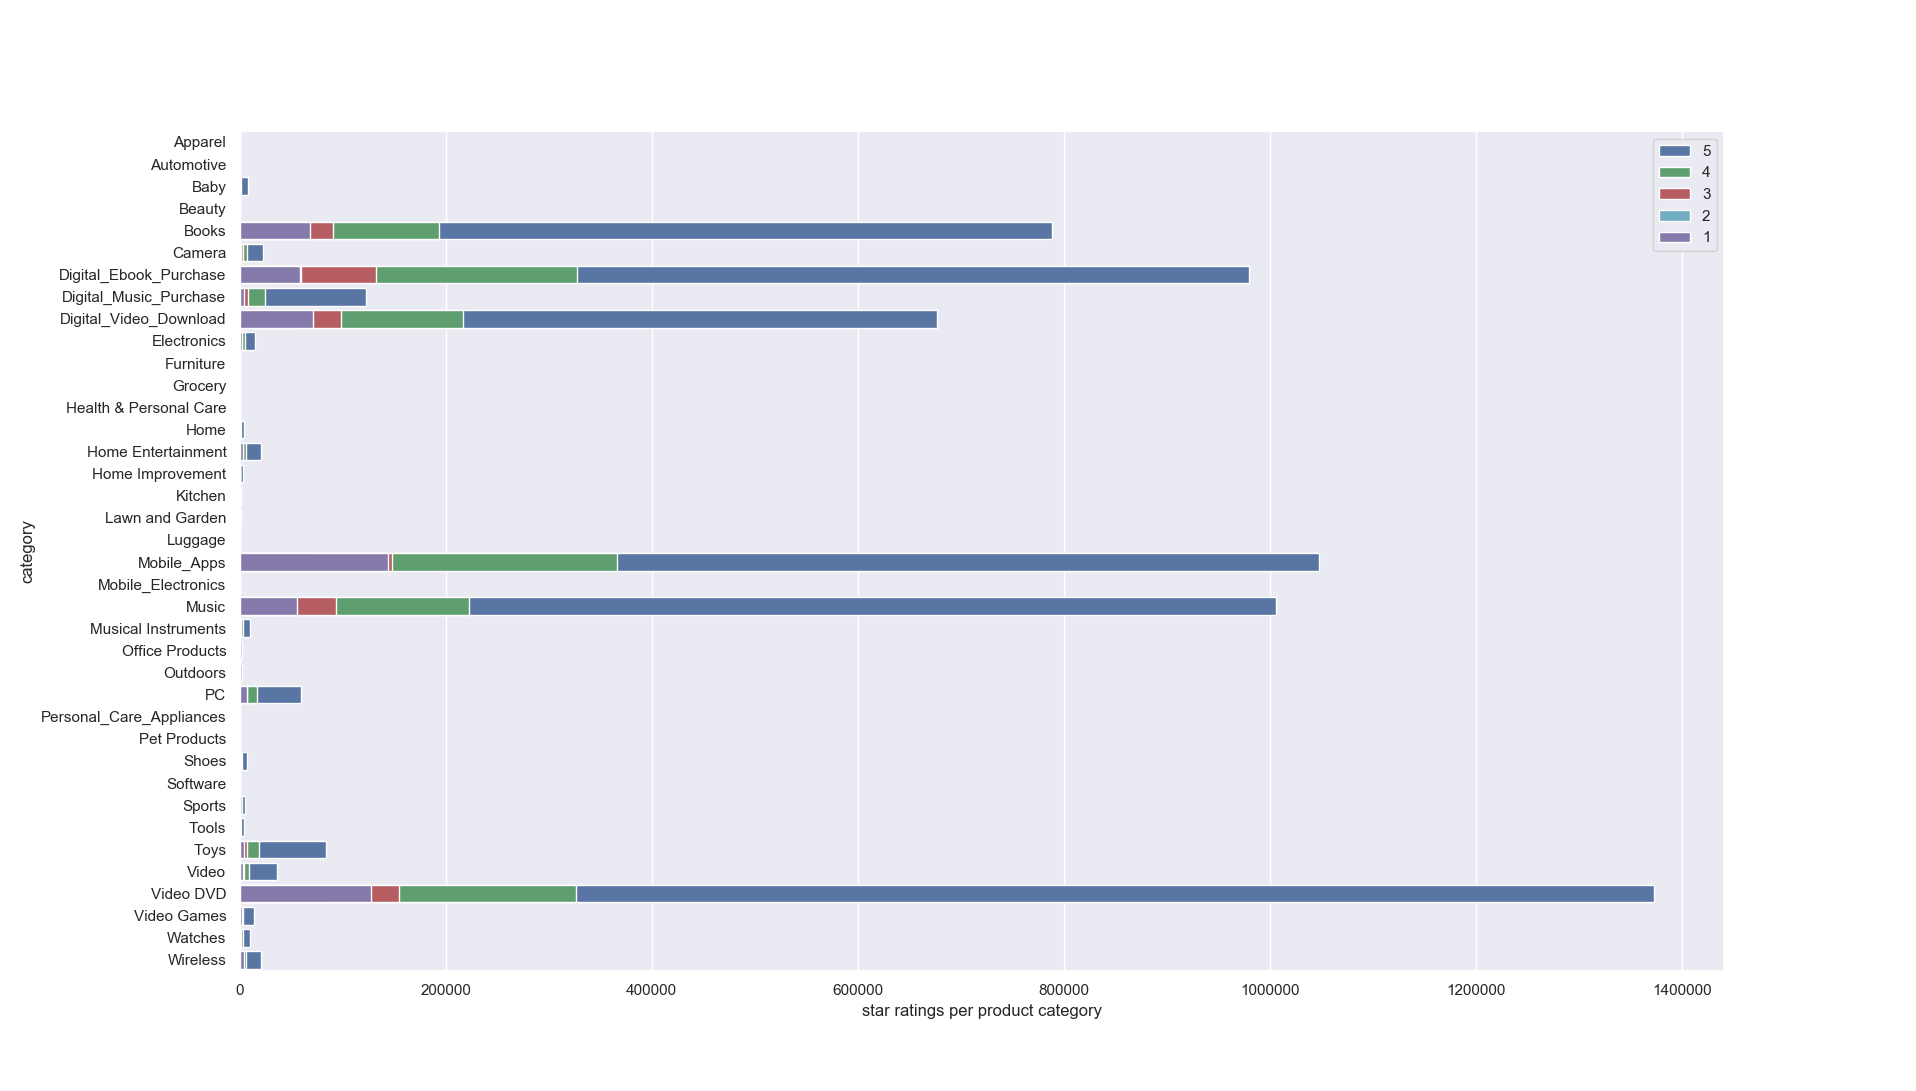
*category and numbers of star ratings*